## Updates since last iteration:

### Oct 25 2022
* Assess data quality (how many poor quality datasets and when?)
* Format static plot for paper/PPT

### Sept 9 2022
* Calculates change in saturation between years

### Sept 2 2022
* Included sensitivity on color plots

### July 20 2022
* Processed 2010 dataset and made some nice plots to compare 2010 and 2019 data
* Can now save borehole resistivities as text file with z, rho, date, max_g

### July 13 2022
* Used gradient method to detect largest contrast in resistivity (i.e. thaw layer depth, ice rich layer depth)
* Removed punctuation in virtual borehole resistivity profile file name - should now save as .txt files without error

### July 7 2022
* Added button to save virtual borehole resistivity profiles as .txt files
* Tweaked time-lapse inversion strategy: when previous time step wasn't inverted (due to poor data quality), looks further back in time to find a suitable reference model
* Fixed bug where code crashed if all data points were filtered


### July 4 2022
* Fixed issue with saving dataset with poor quality data
* Fixed datetime formatting for plots
* Included rms error on plots for reference
* New interactive plot that can retrieve vertical resistivity profile line plots
* If borehole is right at cell edge location, take average resistivity of cells on either side

### June 27 2022
* Includes a gridded color plot for virtual borehole
* Saves raw and filtered data in table
* Fixed bug in dataset testing
* Instead of just skipping poor quality data, we now save the data and the inverted results (as -999) to indicate data is presented but was not inverted


### May 13 2022
* Using better format for survey date/time
* Can extract resistivity at a specific point
* Can extract resistivity in a rectangular region
* Can plot a line plot for virtual borehole

## Import packages

In [1]:
import numpy as np
import pandas as pd
import pygimli as pg
from pygimli.physics import ert
import matplotlib.pyplot as plt
import math
import sys
from ipywidgets import interact
import matplotlib.patches as patches
import matplotlib.dates as mdates
import matplotlib.colors as colors  
import ipywidgets as widgets
import datetime

## Load the data

In [2]:
# load data (separated into electrodes and data file for convenience)

elecs = pd.read_csv('data_AERT/craterlake_electrodes.txt', sep='\t')
data_in = pd.read_csv('data_AERT/craterlake_data.txt',sep='\t')

n_data = 57
n_header = 3
n_lines = n_data + n_header
n_surveys = int(len(data_in)/(n_lines))

# get electrodes

A = (elecs['A'].to_numpy())
B = (elecs['B'].to_numpy())
M = (elecs['M'].to_numpy())
N = (elecs['N'].to_numpy())

E = np.linspace(0,9.5,20) # positions


## Make a grid

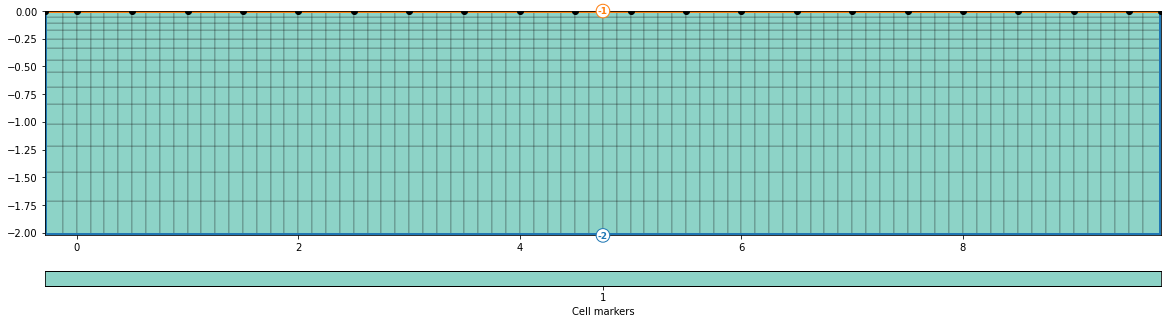

In [3]:
n_elec = len(E)
e_spc = E[1]-E[0] # assumes constant spacing for now
nb = 4 # number of cells between electrodes

# discretization in x-direction

hx = (np.ones((n_elec-1)*nb)*(e_spc/nb))
nxpad = 2
padx = (e_spc/nb)*1.3**(np.arange(0,nxpad,1))
xlocs = np.cumsum(np.hstack([0,np.flipud(padx), hx, padx]))-sum(padx)

# discretization in z-direction

pady = 0.05*1.15**(np.arange(0,14,1))
ylocs = np.flipud(-np.cumsum(np.hstack([0,pady])))

# make grid and plot

grid = pg.createGrid(
    x=xlocs,
    y=ylocs,
    marker=1, 
    worldBoundaryMarker=True
)

fig, ax = plt.subplots(figsize=[20,10])
pg.show(grid, markers=True,ax=ax,showMesh=True)

ax.plot(E,np.zeros(len(E)),'ko')


## Data processing function:

In [4]:
# data_raw = input raw data
# data_checked = checked for reciprocals/repeated measurements
# data_filt = filtered data (technical filter + moving median + electrode filter)
# data_out = dictionary of checked data with column for whether each data point was kept (used=1) or filtered (used=0)


In [117]:

def process_ERT_data(data_raw,survey_name,mesh,start_model,plotdata,plotmodel,plotmisfit):

    # thresholds:
    th_err = 10 # threshold for measurement error (%)
    th_std = 9 # removes data > 9*std(rhoa)
    th_mmf = 0.07 # threshold for moving median filter  TODO: make this higher for shallower data?
    th_elec_filt = 25 # threshold for determining bad electrode (%) - if more than x% data using an electrode are filtered, remove the rest
    th_bad_dataset = 30 # threshold for determining dataset quality (%) - if more than x% of all data points are removed, discard entire dataset

    
    # calculate geometric factor and apparent resistivity if not already in data file

    if data_raw.haveData('k')==False:
        if max(np.array(data.sensors()).T[2])-min(np.array(data.sensors()).T[2])==0: # is it flat?
            data_raw['k'] = ert.createGeometricFactors(data_raw) # no need for numerical solution
        else: # topography?
            data_raw['k'] = ert.createGeometricFactors(data_raw,numerical=True) # include topo in k calculation
            
    if data_raw.haveData('rhoa')==False:
        if data_raw.haveData('r')==False:
            data_raw['r'] = data_raw['u']/data_raw['i']
        data_raw['rhoa'] = data_raw['r']*data_raw['k'] 


    # put data into pandas dataframe

    df = pd.DataFrame(np.array(data_raw.dataMap(),dtype='object').T)
    header = df.iloc[0]
    df = df[1:] 
    df.columns = header
    df = df.apply(pd.Series.explode).reset_index(drop=True)

    df_raw = pd.DataFrame(df)
    df_raw['start_index'] = df_raw.index

    # look for reciprocal or repeated measurements

    src = np.stack([df_raw['a'],df_raw['b']]).T
    rec = np.stack([df_raw['m'],df_raw['n']]).T

    src_f = src[0]
    rec_f = rec[0]
    ind_f = [0]
    ind_r = []
    reps = []
    recips = []

    for i in range(1,len(src)): 

        if len(rec_f)==2:
            a = np.where(np.all(rec_f==src[i],axis=0))[0] # reciprocals
            b = np.where(np.all(src_f==rec[i],axis=0))[0]

            c = np.where(np.all(src_f==src[i],axis=0))[0] # repeated
            d = np.where(np.all(rec_f==rec[i],axis=0))[0]
        else:
            a = np.where(np.all(rec_f==src[i],axis=1))[0] # reciprocals
            b = np.where(np.all(src_f==rec[i],axis=1))[0]

            c = np.where(np.all(src_f==src[i],axis=1))[0] # repeated
            d = np.where(np.all(rec_f==rec[i],axis=1))[0]   

        ind_recip = np.intersect1d(a,b)
        ind_rep = np.intersect1d(c,d)

        if len(ind_recip)>0:
            ind_r.append(i)
            recips.append(ind_recip)

        elif len(ind_rep)>0:
            ind_r.append(i)
            reps.append(ind_rep)

        else:
            src_f = np.vstack((src_f,[src[i]]))
            rec_f = np.vstack((rec_f,[rec[i]]))
            ind_f.append(i)

    recips = np.squeeze(recips) 
    reps = np.squeeze(reps)

    # treat repeated and reciprocal measurements the same
    r_all = np.hstack([reps,recips]).astype(int)

    # if present, calculate new apparent resistivities and error vals

    df_f = df_raw.loc[ind_f]
    df_f = df_f.reset_index(drop=True)

    df_r = df_raw.loc[ind_r]
    df_r = df_r.reset_index(drop=True)

    df_checked = df_f.copy()
    df_checked['rep/recip'] = 0

    if len(ind_r)>0: #TODO this only handles recips now

        for i in range(len(ind_r)): # for all reciprocal measurements

            r_mean = (df_f.iloc[r_all[i]]['r'] + df_r.iloc[i]['r'])/2 
            r_err = (np.abs(df_f.iloc[r_all[i]]['r'] - df_r.iloc[i]['r'])/abs(r_mean))*100    
            df_checked.at[r_all[i],'r'] = r_mean
            df_checked.at[r_all[i],'rhoa'] = r_mean*df_r.iloc[i]['k']
            df_checked.at[r_all[i],'err'] = r_err
            df_checked.at[r_all[i],'rep/recip'] = 1


    # put everything back into the pygimli data container to plot
    
    data_checked = pg.DataContainerERT()

    # sensors 
    
    for i in range(0,len(data_raw.sensors())):
        data_checked.createSensor(np.array(data_raw.sensors()[i])) # 2D, no topography

    # add filtered quadripoles and data 

    cols = df_checked.columns
    for i in range(len(cols)):
        if max(df_checked[cols[i]]) > 0:
            data_checked[cols[i]] = np.array(df_checked[cols[i]])


    mgr = ert.ERTManager(data_checked)

    df_filt = df_checked.copy()

    I_tf = (np.unique(np.hstack([ 
        np.where(df_filt['i'] <= 0)[0],
        np.where(df_filt['u'] <= 0)[0],
        np.where(df_filt['rhoa'] <= 0)[0],
        np.where(df_filt['err'] > th_err)[0],
        np.where(df_filt['rhoa'] > th_std*np.std(df_filt['rhoa']))[0]
    ])))

    df_filt = df_filt.drop(I_tf)
    n_tf = len(I_tf)






    # to apply a moving median filter we will need to sort our data by depth level and array midpoint. 

    # find midpoint of array

    mp = np.mean([df_filt['a'],df_filt['b'],df_filt['m'],df_filt['n']],axis=0)

    # sort by depth level and midpoint so we can apply moving median filter
    # note: this works for 2D lines with topography and even electrode spacing

    # to find unique depth levels, check to find unique relative positions of electrodes

    ab = df_filt['a'] - df_filt['b']
    am = df_filt['a'] - df_filt['m']
    an = df_filt['a'] - df_filt['n']

    # pos is just a placeholder variable describing relative electrode positions...

    pos = (np.array([ab,am,an]).T).astype(dtype=float)
    pos_uniq = np.flipud(np.unique(pos, axis=0))

    # ...and we'll add this info to dataframe for convenience

    pos_i = []
    for i in range(len(pos)):
        pos_i.append(np.where((pos[i]==pos_uniq).all(axis=1))[0][0])

    df_filt['pos'] = pos_i

    # sort by depth level

    sort_index = np.argsort(pos)
    i_all = np.linspace(0,len(pos),len(pos)+1).astype('int')
    sort_index = np.array([])

    # sort by midpoint

    for i in range(len(pos_uniq)):
        j = np.where((pos==pos_uniq[i]).all(axis=1))
        si = np.argsort(mp[j])
        sort_index = np.append(sort_index,i_all[j][si]) 

    sort_index = sort_index.astype('int')

    # make a dataframe with sorted values

    df_sort = pd.DataFrame(columns = df_filt.columns,index=range(len(df_filt)))
    for i in range(len(df_filt)):
        df_sort.iloc[i] = df_filt.iloc[sort_index[i]]
    df_sort = df_sort.reset_index(drop=True)

    # moving median filter

    df_filt = df_sort.copy()

    n_mmf = 0 # keeping track of how many data are removed

    ikeep = np.ones(df_filt.shape[0],dtype=bool)

    k=0

    for j in range(len(pos_uniq)): # loop through each unique depth level
        I = (np.where(df_filt['pos']==k)[0])

        # moving median of data points

        mm = [] 
        r = np.log(np.array(df_filt['rhoa'],dtype=float)[I])

        for i in range(len(I)): # loop through depth level from left to right
            if i==0:
                mm.append(np.median(r[i:3])) # end points only use two neighboring data points to calculate median
            elif i==1:
                mm.append(np.median(r[i-1:4])) 
            elif i==len(r)-2:
                mm.append(np.median(r[i-2:])) 
            elif i==len(r)-1:
                mm.append(np.median(r[i-2:])) 
            else:
                mm.append(np.median(r[i-2:i+3])) 

        ithrow = np.where(abs(r-mm)/mm > th_mmf)[0]
        n_mmf = n_mmf + len(ithrow)

        # get rid of outlier data 

        for i in range(len(ithrow)):
            ikeep[I[ithrow[i]]] = 0

        k=k+1     

    I_mmf = (df_filt[ikeep==False])['start_index']
    df_filt = df_filt[ikeep]
    df_filt = df_filt.reset_index(drop=True)

    # bad electrode filter
    
    # find the indices of all the points we removed
    I_all = np.hstack([I_tf,I_mmf])

    # how many times was each electrode used in the full dataset?
    [elec_all,count_all] = np.unique(np.hstack([df_raw['a'],df_raw['b'],df_raw['m'],df_raw['n']]), return_counts=True)

    # how many times was each electrode used in the data that got removed?
    df_removed = df_raw[df_raw['start_index'].isin(I_all)]
    [elec_removed,count_removed] = np.unique(np.hstack([df_removed['a'],df_removed['b'],df_removed['m'],df_removed['n']]), return_counts=True)

    # loop through and, for each electrode, calculate what percentage of data points were removed
    perc_filt = []
    for i in range(len(elec_all)):
        if elec_all[i] in elec_removed:
            I = np.where(elec_removed == elec_all[i])
            perc_filt.append(count_removed[I]/count_all[i]*100)

        else:
            perc_filt.append([0])

    perc_filt = np.hstack(perc_filt)

    # identify which electrodes are bad based on a threshold 
    e_bad = elec_all[perc_filt > th_elec_filt]
    
    if len(e_bad)==len(data_raw.sensors()): # i.e. if all electrodes are "bad"
        print('ABORT: too many bad electrodes in %s. Data not inverted.'%filename)
        
        # we should still output something for the data and model to indicate data are present, 
        # but quality is too poor to invert:
        
        data_out = {
            'a': df_checked['a'].tolist(),
            'b': df_checked['b'].tolist(),
            'm': df_checked['m'].tolist(),
            'n': df_checked['n'].tolist(),
            'err': df_checked['err'].tolist(),
            'i': df_checked['i'].tolist(),
            'u':   df_checked['u'].tolist(),
            'k': df_checked['k'].tolist(),
            'rhoa': df_checked['rhoa'].tolist(),
            'valid': df_checked['valid'].tolist(),
            'used':np.zeros(len(df_checked['a'])).tolist(),
            'survey_name':[survey_name]*len(df_checked),
        }    
        
        ert_inv = {
            'rho_s':  [-999],
            'sens': [-999],
            'rms': [-999],
            'survey_name':[survey_name],

        }
            
        return (None, ert_inv, data_out)
        sys.exit()

    
    I_ef = []
    for i in range(len(df_filt['a'])):
        if (df_filt['a'].iloc[i] in e_bad) or (df_filt['b'].iloc[i] in e_bad) or (df_filt['m'].iloc[i] in e_bad) or (df_filt['n'].iloc[i] in e_bad):
            I_ef.append(True)
        else:
            I_ef.append(False)

    df_elec_filt = df_filt.drop(index = np.where(I_ef)[0])
    n_ef = len(e_bad)
    df_filt = df_elec_filt.copy()

    
    
    if (len(df_filt)==0): 

        print('ABORT: too many data points filtered from %s. Data not inverted.'%filename)

        # we should still output something for the data and model to indicate data are present, 
        # but quality is too poor to invert:

        data_out = {
            'a': df_checked['a'].tolist(),
            'b': df_checked['b'].tolist(),
            'm': df_checked['m'].tolist(),
            'n': df_checked['n'].tolist(),
            'err': df_checked['err'].tolist(),
            'i': df_checked['i'].tolist(),
            'u':   df_checked['u'].tolist(),
            'k': df_checked['k'].tolist(),
            'rhoa': df_checked['rhoa'].tolist(),
            'valid': df_checked['valid'].tolist(),
            'used':np.zeros(len(df_checked['a'])).tolist(),
            'survey_name':[survey_name]*len(df_checked),
        }    

        ert_inv = {
            'rho_s':  [-999],
            'sens': [-999],
            'rms': [-999],
            'survey_name':[survey_name],

        }

        return (None, ert_inv, data_out)
        sys.exit()



    # put everything back into the pygimli data container

    data_filt = pg.DataContainerERT()

    # sensors 

    for i in range(0,len(data_raw.sensors())):
        data_filt.createSensor(np.array(data_raw.sensors()[i])) # 2D, no topography

    # add filtered quadripoles and data 

    cols = df_filt.columns
    for i in range(len(cols)):
        if max(df_elec_filt[cols[i]]) > 0:
            data_filt[cols[i]] = np.array(df_elec_filt[cols[i]])

    # prepare raw and filtered data to be saved as a table

    df_checked['used']=np.ones(len(df_checked))
    df_checked['survey_name']=[survey_name]*len(df_checked)
    
    for i in range(len(df_checked)):
        pres = (
            (df_checked['a'].iloc[i] == df_filt['a']) & 
            (df_checked['b'].iloc[i] == df_filt['b']) & 
            (df_checked['m'].iloc[i] == df_filt['m']) & 
            (df_checked['n'].iloc[i] == df_filt['n'])).any()

        if pres == False:
            df_checked.loc[i,'used']=0
            
            
    if (data_checked.size()-data_filt.size())/data_checked.size()*100>th_bad_dataset: # i.e. if >30% data are removed
        print('ABORT: too many data points filtered from %s. Data not inverted.'%filename)
        
        # we should still output something for the data and model to indicate data are present, 
        # but quality is too poor to invert:
        
        data_out = {
            'a': df_checked['a'].tolist(),
            'b': df_checked['b'].tolist(),
            'm': df_checked['m'].tolist(),
            'n': df_checked['n'].tolist(),
            'err': df_checked['err'].tolist(),
            'i': df_checked['i'].tolist(),
            'u':   df_checked['u'].tolist(),
            'k': df_checked['k'].tolist(),
            'rhoa': df_checked['rhoa'].tolist(),
            'valid': df_checked['valid'].tolist(),
            'used':df_checked['used'].tolist(),
            'survey_name':[survey_name]*len(df_checked),
        }    
        
        ert_inv = {
            'rho_s':  [-999],
            'sens': [-999],
            'rms': [-999],
            'survey_name':[survey_name],

        }
            
        return (None, ert_inv, data_out)
        sys.exit()

    

    # TODO: these parameters are specific to the antarctica dataset - will need to make this more flexible to handle
    # maybe a subset of these (e.g. without err, u, i...)
    
    data_out = {
        'a': df_checked['a'].tolist(),
        'b': df_checked['b'].tolist(),
        'm': df_checked['m'].tolist(),
        'n': df_checked['n'].tolist(),
        'err': df_checked['err'].tolist(),
        'i': df_checked['i'].tolist(),
        'u':   df_checked['u'].tolist(),
        'k': df_checked['k'].tolist(),
        'rhoa': df_checked['rhoa'].tolist(),
        'valid': df_checked['valid'].tolist(),
        'used':df_checked['used'].tolist(),
        'survey_name':[survey_name]*len(df_checked),
    }        
    
    # build error model 
    
    if len (r_all)>0:  # if there is repeated/reciprocal data, use that:

        fs=20

        I = np.where(df_filt['rep/recip']==1)
        x = abs(df_filt['r'].iloc[I])
        y = abs(df_filt['err'].iloc[I])*abs(df_filt['r'].iloc[I])/100 # absolute error

        nbins = 20
        ndata = len(I[0])
        npoints = math.ceil(ndata/nbins)

        df_filt = df_filt.sort_values(by=['r'],key=abs)
        xbin = []
        ybin = []
        for i in range(nbins):
            xbin.append(np.mean(x[i*npoints:(i+1)*npoints]))
            ybin.append(np.std(y[i*npoints:(i+1)*npoints]))

        p = np.polyfit(xbin,ybin, 1)

        if p[1]<0: # if absolute error is negative, just assign some small value
            p[1]=1e-3
        p[0] = p[0] + 0.02 # increase relative error by 2% to account for other sources of error

        print('error model: err = %.4f*|R|+%.4f'%(p[0],p[1]))

        # automated (from error model)
        data_filt['err'] = ert.estimateError(
        data_filt, 
        absoluteError=p[1], 
        relativeError=p[0] # % noise
        ) 

    else:  # otherwise, assume simple error model with 4% noise

        data_filt['err'] = ert.estimateError(
        data_filt, 
        absoluteError=0.001, 
        relativeError=0.04 # % noise
        )


    # inversion parameters
    
    # set whether lambda is being optimized by L-curve

    mgr.inv.inv.setOptimizeLambda(True)

    # use blocky model constraint

    mgr.inv.inv.setBlockyModel(True)

    # run inversion
    
    if mesh is not None: 
        if start_model is not None:
            mod = mgr.invert(
                data_filt,
                verbose=False, 
                mesh=mesh,
                startModel=start_model
            )
            
        else:
            mod = mgr.invert(
                data_filt,
                verbose=False, 
                mesh=mesh
            )    
    else:
        if start_model is not None:
            mod = mgr.invert(
                data_filt,
                verbose=False, 
                startModel=start_model
            )
        else:
            mod = mgr.invert(
                data_filt,
                verbose=False, 
            )

            
    # getting lambda, chi2, rms error

    lam = mgr.inv.inv.getLambda()
    chi2 = mgr.inv.inv.getChi2()
    rms = np.sqrt(np.mean(((data_filt['rhoa']-mgr.inv.response)/data_filt['rhoa'])**2))*100

    mesh = mgr.paraDomain.cellCenters()

    # prepare inversion results to be saved as a table
    
    ert_inv = {
        'rho_s': np.array(mgr.model).tolist(),
        'sens': mgr.coverage().tolist(),
        'rms':[rms]*len(mgr.model),
        'survey_name':[survey_name]*len(mgr.model),
        
    }

    
    if plotdata==True:
                
        fig, ax = plt.subplots(1,2,figsize=[20,5])

        pg.physics.ert.showData(data_checked, vals=data_checked['rhoa'],ax=ax[0],label=r'$\rho_{app}$ ($\Omega$m)',cMap='turbo_r');
        ax[0].set_title('Raw data',fontsize=24);

        pg.physics.ert.showData(data_filt, vals=data_filt['rhoa'],ax=ax[1],label=r'$\rho_{app}$ ($\Omega$m)',cMap='turbo_r');
        ax[1].set_title('Filtered data - %.0f data points removed (%.1f%% of the data)'%(data_checked.size()-data_filt.size(), float((data_checked.size()-data_filt.size())/data_checked.size()*100)),fontsize=24);

        print('data points removed by technical filter = %.0f'%n_tf)
        print('data points removed by moving median filter = %.0f'%n_mmf)
        print('number of bad electrodes = %.0f'%n_ef)
        print('data points removed by bad electrode filter = %.0f'%len(np.where(I_ef)[0]))
        print('%.0f data points removed in total (%.1f%% of the data)'%(n_tf+n_mmf+n_ef, float((data_checked.size()-data_filt.size())/data_checked.size()*100)))
        
        plt.show()
 
    if plotmodel==True:
        fig, ax = plt.subplots(1,1,figsize=[15,5])
        
        ax, cBar = mgr.showResult(
           mod,
            ax=ax,
            cMap='turbo_r',
            coverage=mgr.coverage(),
            cMin=np.sort(mgr.paraModel())[int(len(mgr.paraModel())/100)], # this part trims the color scale to make things easier to see
            cMax=np.sort(mgr.paraModel())[-int(len(mgr.paraModel())/100)],

        );

        cBar.set_label(r'$\rho$ [$\Omega$m]')
        ax.set_xlabel('X (m)')
        ax.set_ylabel('Z (m)')
        ax.set_title(r'chi$^2$ = %.2f, rms error = %.2f%%'%(chi2,rms),fontsize=20);

        plt.show()
        
    if plotmisfit==True:
        fig, ax = plt.subplots(1,3,figsize=[15,5])
        mgr.showData(data_filt, vals=data_filt['rhoa'],ax=ax[0],label=r'$\rho_{app}$ ($\Omega$m)',cMap='turbo_r');
        mgr.showData(data_filt, vals=mgr.inv.response,ax=ax[1],label=r'$\rho_{app}$ ($\Omega$m)',cMap='turbo_r',cMin=min(data_filt['rhoa']),cMax=max(data_filt['rhoa']));
        mgr.showData(data_filt, vals=((mgr.inv.response-data_filt['rhoa'])/data_filt['rhoa'])*100,ax=ax[2],label='Error (%)',cMap='seismic',cMin=-20,cMax=20);
        ax[0].set_title('Observed data (filtered)',fontsize=20)
        ax[1].set_title('Predicted data',fontsize=20)
        ax[2].set_title('Misfit',fontsize=20);
        
        plt.show()

    return mgr, ert_inv, data_out


## Test a subset of the data to see if things are working okay

In [116]:
filename

'02.05.2019 12:00:00'

08/05/23 - 14:00:41 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 138): /Users/teddiherringnew/Library/Caches/pygimli/4293420630988484170
08/05/23 - 14:00:41 - pyGIMLi - INFO - Found 1 regions.
08/05/23 - 14:00:41 - pyGIMLi - INFO - Creating forward mesh from region infos.
08/05/23 - 14:00:41 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


First inversion


08/05/23 - 14:00:41 - pyGIMLi - INFO - Use median(data values)=31893.535013041554
08/05/23 - 14:00:41 - pyGIMLi - INFO - Created startmodel from forward operator: 1120 [31893.535013041554,...,31893.535013041554]


data points removed by technical filter = 4
data points removed by moving median filter = 5
number of bad electrodes = 1
data points removed by bad electrode filter = 6
10 data points removed in total (26.3% of the data)


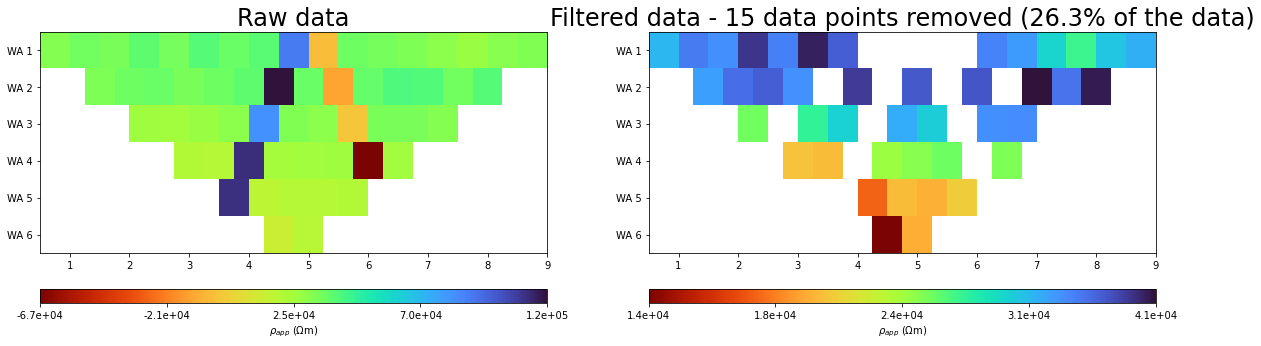

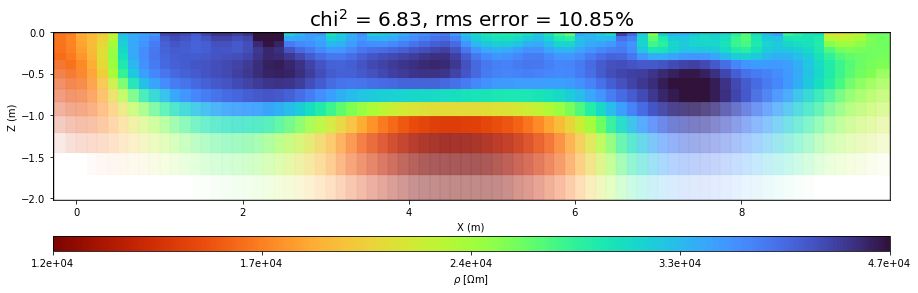

In [115]:
# load data (separated into electrodes and data file for convenience)

elecs = pd.read_csv('data_AERT/craterlake_electrodes.txt', sep='\t')
data_in = pd.read_csv('data_AERT/craterlake_data.txt',sep='\t')
n_data = 57
n_header = 3

# elecs = pd.read_csv('data_AERT/craterlake_electrodes2010.txt', sep='\t')
# data_in = pd.read_csv('data_AERT/craterlake_data2010.txt',sep=' ')
# n_data = 56
# n_header = 2

n_lines = n_data + n_header
n_surveys = int(len(data_in)/(n_lines))

# choose some random datasets...

# import random

# n_tests = 5

# test_i = []
# for i in range(n_tests):
#     test_i.append(random.randint(0, n_surveys))
    
# test_i = np.sort(test_i)


# ... or test a couple specific datasets

test_i = [339] 

# 339 has a few data points removed 
# 543 is where it crashed last time, due to too many data points removed
# 783 is another point where it crashed last time

# 315 broke the 2021 dataset

# make dictionary to store results

ert_all = dict.fromkeys(['rho_s','sens','survey_name','rms'])
data_all = dict.fromkeys(['a','b','m','n','err','u','i','k','rhoa','used','survey_name',]) #could be more general?


for j in range(0,len(test_i)):

    data = pg.DataContainerERT()

    for k in range(0,len(E)):
        data.createSensor([E[k], 0.0]) # 2D, no topography

    cf = []
    for k in range(0,n_data):
        cf.append([A[k]-1,B[k]-1,M[k]-1,N[k]-1])

    for k in range(0,n_data):
        data.createFourPointData(k, *map(int, cf[k])) 

    i = test_i[j]    
    
    filename = data_in.iloc[i*n_lines]['U0(mV)'][0:10] + ' ' + data_in.iloc[i*n_lines]['U90(mV)'][0:8] # use date and time to ID surveys
    
    data['err'] = np.array(data_in['errorU0(%)'].iloc[(i*n_lines)+n_header:(i+1)*n_lines].astype(float))
    data['u'] = np.array(data_in['U0(mV)'].iloc[(i*n_lines)+n_header:(i+1)*n_lines].astype(float)/1000)
    data['i'] = np.array(data_in['I(mA)'].iloc[(i*n_lines)+n_header:(i+1)*n_lines].astype(float)/1000)
    
    grid = pg.createGrid(
        x=xlocs,
        y=ylocs,
        marker=1, 
        worldBoundaryMarker=True
    )  
    
    
    # test standard inversion
    ##############################
    
#     mgr, ert_inv,data_filt = process_ERT_data(
#         data_raw = data,
#         survey_name = filename,
#         mesh=grid, # for unstructured mesh, can just say mesh=None
#         start_model=None, # set to None for no temporal constraint
#         plotdata=True,
#         plotmodel=True,
#         plotmisfit=False)  


    # test time-lapse inversion 
    ##############################

    if ert_all['rho_s']==None: # for first iteration, run a regular inversion
        print('First inversion')
        mgr, ert_inv,data_filt = process_ERT_data(
            data_raw = data,
            survey_name = filename,
            mesh=grid, # for unstructured mesh, can just say mesh=None
            start_model=None, # set to None for no temporal constraint
            plotdata=True,
            plotmodel=True,
            plotmisfit=False
        )  
        
    else: # for subsequent inversions, use time-lapse
                
        # check if the previous time step was inverted.
        # if it wasn't, e.g. data were poor quality, look further back (up to 6 time steps - an arbitrary threshold) for a starting model

        if max(ert_all['rho_s'])==-999: # check to see if any previous inverted result is suitable
            m0=None
            print('No suitable starting model')
                
        else: # look progresssively backwards in time to find a suitable starting model. Stop at 6 
            if len(np.where(np.array(ert_all['survey_name'])==ert_all['survey_name'][-1])[0])==1: 
                
                k=1

                while len(np.where(np.array(ert_all['survey_name'])==ert_all['survey_name'][-k])[0])==1 and k < 6 and j-k > 0:
                    k = k+1

                if len(np.where(np.array(ert_all['survey_name'])==ert_all['survey_name'][-k])[0])==1: # not able to find a suitable starting model
                    m0 = None
                    print('No suitable starting model found')
                    
                else: # set starting model
                    m0=np.array(ert_all['rho_s'])[np.where(np.array(ert_all['survey_name'])==ert_all['survey_name'][-k])]
                    print('Using starting model from %.0f time steps ago'%k)

            else: 
                m0=np.array(ert_all['rho_s'])[np.where(np.array(ert_all['survey_name'])==ert_all['survey_name'][-1])]
                print('Using starting model from previous time step')

        mgr, ert_inv,data_filt = process_ERT_data(
            data_raw = data,
            survey_name = filename,
            mesh=grid, # for unstructured mesh, can just say mesh=None
            start_model = m0, # set to None for no temporal constraint
            plotdata=True,
            plotmodel=True,
            plotmisfit=False
        )          
        
    ##############################
    
    
    # append inverted results
    if ert_inv == None:
        pass
    else:
        
        if ert_all['rho_s']==None:
            ert_all = ert_inv 
        else:
            ert_all = {key: ert_all[key] + ert_inv[key] for key in ert_all}
    
    # append data
    if data_filt == None:
        pass
    else:
        if data_all['a']==None:
            data_all = data_filt
        else:
            data_all = {key: data_all[key] + data_filt[key] for key in data_all}

# convert dictionaries to dataframes
if ert_all['rho_s']==None:
    pass
else:
    ert_all = pd.DataFrame.from_dict(ert_all)
    
if data_all['a']==None:
    pass
else:
    data_all = pd.DataFrame.from_dict(data_all)

## Run time-lapse inversion

## 2010

In [13]:

# # load data (separated into electrodes and data file for convenience)

# elecs = pd.read_csv('data_AERT/craterlake_electrodes2010.txt', sep='\t')
# data_in = pd.read_csv('data_AERT/craterlake_data2010.txt',sep=' ')
# n_data = 56
# n_header = 2

# n_lines = n_data + n_header
# n_surveys = int(len(data_in)/(n_lines))


# # make dictionary to store results

# ert_all = dict.fromkeys(['rho_s','sens','survey_name','rms'])
# data_all = dict.fromkeys(['a','b','m','n','err','u','i','k','rhoa','valid','used','survey_name',]) #could be more general?

# for i in range(0,n_surveys):
#     print('Inverting survey %.0f/%.0f'%(i,n_surveys))
# # for i in range(0,20): # this is just testing the first few datasets

#     data = pg.DataContainerERT()

#     for k in range(0,len(E)):
#         data.createSensor([E[k], 0.0]) # 2D, no topography

#     cf = []
#     for k in range(0,n_data):
#         cf.append([A[k]-1,B[k]-1,M[k]-1,N[k]-1])

#     for k in range(0,n_data):
#         data.createFourPointData(k, *map(int, cf[k])) 
    
#     filename = data_in.iloc[i*n_lines]['U0(mV)'][0:10] + ' ' + data_in.iloc[i*n_lines]['U90(mV)'][0:8] # use date and time to ID surveys
    
#     data['err'] = np.array(data_in['errorU0(%)'].iloc[(i*n_lines)+n_header:(i+1)*n_lines].astype(float))
#     data['u'] = np.array(data_in['U0(mV)'].iloc[(i*n_lines)+n_header:(i+1)*n_lines].astype(float)/1000)
#     data['i'] = np.array(data_in['I(mA)'].iloc[(i*n_lines)+n_header:(i+1)*n_lines].astype(float)/1000)
    
#     grid = pg.createGrid(
#         x=xlocs,
#         y=ylocs,
#         marker=1, 
#         worldBoundaryMarker=True
#     )

        
#     if ert_all['rho_s']==None: # for first iteration, run a regular inversion
        
#         print('First inversion')
        
#         mgr, ert_inv,data_filt = process_ERT_data(
#             data_raw = data,
#             survey_name = filename,
#             mesh=grid, # for unstructured mesh, can just say mesh=None
#             start_model=None, # set to None for no temporal constraint
#             plotdata=False,
#             plotmodel=False,
#             plotmisfit=False
#         )  
        
#     else: # for subsequent inversions, use time-lapse
                
#         # check if the previous time step was inverted.
#         # if it wasn't, e.g. data were poor quality, look further back (up to 6 time steps - an arbitrary threshold) for a starting model

#         if max(ert_all['rho_s'])==-999: # check to see if any previous inverted result is suitable
#             m0=None
#             print('No suitable starting model')
                
#         else: # look progresssively backwards in time to find a suitable starting model. Stop at 6 
#             if len(np.where(np.array(ert_all['survey_name'])==ert_all['survey_name'][-1])[0])==1: 
                
#                 k=1

#                 while len(np.where(np.array(ert_all['survey_name'])==ert_all['survey_name'][-k])[0])==1 and k < 6 and j-k > 0:
#                     k = k+1

#                 if len(np.where(np.array(ert_all['survey_name'])==ert_all['survey_name'][-k])[0])==1: # not able to find a suitable starting model
#                     m0 = None
#                     print('No suitable starting model found')
                    
#                 else: # set starting model
#                     m0=np.array(ert_all['rho_s'])[np.where(np.array(ert_all['survey_name'])==ert_all['survey_name'][-k])]
#                     print('Using starting model from %.0f time steps ago'%k)

#             else: 
#                 m0=np.array(ert_all['rho_s'])[np.where(np.array(ert_all['survey_name'])==ert_all['survey_name'][-1])]
#                 print('Using starting model from previous time step')
        
#         mgr, ert_inv,data_filt = process_ERT_data(
#             data_raw = data,
#             survey_name = filename,
#             mesh=grid, # for unstructured mesh, can just say mesh=None
#             start_model = m0, # set to None for no temporal constraint
#             plotdata=False,
#             plotmodel=False,
#             plotmisfit=False
#         )          
        
#     # append inverted results
#     if ert_inv == None:
#         pass
#     else:
#         if ert_all['rho_s']==None:
#             ert_all = ert_inv 
#         else:
#             ert_all = {key: ert_all[key] + ert_inv[key] for key in ert_all}
    
#     # append data
#     if data_filt == None:
#         pass
#     else:
#         if data_all['a']==None:
#             data_all = data_filt
#         else:
#             data_all = {key: data_all[key] + data_filt[key] for key in data_all}

# # convert dictionaries to dataframes
# if ert_all['rho_s']==None:
#     pass
# else:
#     ert_all = pd.DataFrame.from_dict(ert_all)
    
# if data_all['a']==None:
#     pass
# else:
#     data_all = pd.DataFrame.from_dict(data_all)
    
# ert_all.to_csv('data_AERT/inverted_data/ert_all_2010')
# data_all.to_csv('data_AERT/inverted_data/data_all_2010')
# grid.exportVTK('data_AERT/inverted_data/mesh_2010')


15/07/22 - 14:32:05 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 4): /Users/teddiherringnew/Library/Caches/pygimli/7786174440183351008
15/07/22 - 14:32:05 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:32:05 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:32:05 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 14:32:05 - pyGIMLi - INFO - Use median(data values)=23078.898170816832


Inverting survey 0/2406
First inversion


15/07/22 - 14:32:05 - pyGIMLi - INFO - Created startmodel from forward operator: 1120 [23078.898170816832,...,23078.898170816832]
15/07/22 - 14:32:13 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 3): /Users/teddiherringnew/Library/Caches/pygimli/8679838088352229287
15/07/22 - 14:32:13 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:32:13 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:32:13 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 14:32:13 - pyGIMLi - INFO - Starting model set from given array. [28564.82551972 28705.98934184 29011.8650497  ... 11398.23812379
 42375.25249399 43502.11360336]


Inverting survey 1/2406
Using starting model from previous time step


15/07/22 - 14:32:19 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 2): /Users/teddiherringnew/Library/Caches/pygimli/8527152015931216744
15/07/22 - 14:32:19 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:32:19 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:32:19 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 14:32:19 - pyGIMLi - INFO - Starting model set from given array. [28594.81964457 28738.17202755 29047.1524776  ... 11155.90376665
 39353.08878816 40049.77705092]


Inverting survey 2/2406
Using starting model from previous time step


15/07/22 - 14:32:27 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 2): /Users/teddiherringnew/Library/Caches/pygimli/2513084371260253743
15/07/22 - 14:32:27 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:32:27 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:32:27 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 14:32:27 - pyGIMLi - INFO - Starting model set from given array. [28258.03523363 28390.30115213 28677.50303876 ... 10453.96593005
 37671.00413757 38923.41604842]


Inverting survey 3/2406
Using starting model from previous time step


15/07/22 - 14:32:34 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/5085647420376872374
15/07/22 - 14:32:34 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:32:34 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:32:34 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 14:32:34 - pyGIMLi - INFO - Starting model set from given array. [28235.947129   28376.78372292 28678.33268672 ... 11042.78488739
 39194.38614731 39829.76097726]


Inverting survey 4/2406
Using starting model from previous time step


15/07/22 - 14:32:40 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/2629478981974253747
15/07/22 - 14:32:40 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:32:40 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:32:40 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 14:32:40 - pyGIMLi - INFO - Starting model set from given array. [28215.60309281 28360.19437757 28666.96836982 ... 11336.29262493
 40708.22209874 41313.05247263]


Inverting survey 5/2406
Using starting model from previous time step


15/07/22 - 14:32:46 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7153926892489989227
15/07/22 - 14:32:46 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:32:46 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:32:46 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Inverting survey 6/2406
Using starting model from previous time step


15/07/22 - 14:32:46 - pyGIMLi - INFO - Starting model set from given array. [28271.79983915 28418.27388228 28728.67525326 ... 11452.55957432
 39429.61708154 40047.78309924]
15/07/22 - 14:32:52 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/6146552164888912204
15/07/22 - 14:32:52 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:32:52 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:32:52 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 14:32:52 - pyGIMLi - INFO - Starting model set from given array. [27859.41123946 27983.41270135 28257.69474108 ... 10737.79313439
 34550.65451061 35253.57130971]


Inverting survey 7/2406
Using starting model from previous time step


15/07/22 - 14:32:58 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/5001379926309829032
15/07/22 - 14:32:58 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:32:58 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:32:58 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 14:32:58 - pyGIMLi - INFO - Starting model set from given array. [27267.37570599 27387.64830992 27660.04366799 ... 10175.82544443
 35735.36323478 36582.21574691]


Inverting survey 8/2406
Using starting model from previous time step


15/07/22 - 14:33:03 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/1948686748863146189
15/07/22 - 14:33:03 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:33:03 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:33:03 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 14:33:04 - pyGIMLi - INFO - Starting model set from given array. [28910.33161896 29038.30454803 29329.2552177  ... 10266.17681041
 34775.8285561  35560.82663716]


Inverting survey 9/2406
Using starting model from previous time step


15/07/22 - 14:33:10 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 2): /Users/teddiherringnew/Library/Caches/pygimli/8492705976164174180
15/07/22 - 14:33:11 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:33:11 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:33:11 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 14:33:11 - pyGIMLi - INFO - Starting model set from given array. [28240.30362054 28362.90721372 28638.53235784 ...  9957.16735522
 33998.78995673 35185.81512481]


Inverting survey 10/2406
Using starting model from previous time step


15/07/22 - 14:33:17 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/1335180073471129794
15/07/22 - 14:33:18 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:33:18 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:33:18 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 14:33:18 - pyGIMLi - INFO - Starting model set from given array. [28132.44025424 28256.37221764 28529.72922381 ... 10154.13887489
 33436.33032618 34500.10425754]


Inverting survey 11/2406
Using starting model from previous time step


15/07/22 - 14:33:24 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/1708300662150445095
15/07/22 - 14:33:24 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:33:24 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:33:24 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 14:33:24 - pyGIMLi - INFO - Starting model set from given array. [27987.52062336 28110.9175111  28381.02517736 ... 10404.08846285
 32245.93231949 33178.64407511]


Inverting survey 12/2406
Using starting model from previous time step


15/07/22 - 14:33:30 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8738349136158321903
15/07/22 - 14:33:30 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:33:30 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:33:30 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 14:33:30 - pyGIMLi - INFO - Starting model set from given array. [28313.4120353  28441.76793455 28723.00844467 ... 11167.9621955
 29054.26480929 29596.48782466]


Inverting survey 13/2406
Using starting model from previous time step


15/07/22 - 14:33:37 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:33:37 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/9174650397895547997


Inverting survey 14/2406
Using starting model from previous time step


15/07/22 - 14:33:37 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:33:37 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:33:37 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 14:33:37 - pyGIMLi - INFO - Starting model set from given array. [28608.79148864 28739.10698626 29024.77669306 ... 11292.21632071
 26719.75467977 27237.14336321]
15/07/22 - 14:33:43 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:33:43 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7253650709949722304
15/07/22 - 14:33:43 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:33:43 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:33:43 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 14:33:43 - pyGIMLi - INFO - Starting model set from given array. [28305.12176137 28425.041058   28687.39024019 ... 11015.63132908
 26870.55841393 27560.03640363]


Inverting survey 15/2406
Using starting model from previous time step


15/07/22 - 14:33:50 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:33:50 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8771860073623689910
15/07/22 - 14:33:50 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:33:50 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:33:50 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 14:33:50 - pyGIMLi - INFO - Starting model set from given array. [28181.98812583 28305.01180986 28569.19357747 ... 11373.53208266
 27511.31924836 28172.7244502 ]


Inverting survey 16/2406
Using starting model from previous time step


15/07/22 - 14:33:57 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:33:57 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7141494570833260891
15/07/22 - 14:33:57 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:33:57 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:33:57 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 14:33:57 - pyGIMLi - INFO - Starting model set from given array. [28146.2292335  28269.74788386 28534.27196057 ... 11569.39821671
 27598.93248859 28235.95939096]


Inverting survey 17/2406
Using starting model from previous time step


15/07/22 - 14:34:02 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:34:02 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7122540042145465795
15/07/22 - 14:34:02 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:34:02 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:34:02 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 14:34:02 - pyGIMLi - INFO - Starting model set from given array. [28291.48210687 28425.98929219 28710.82272537 ... 12324.33378569
 26010.91914038 26456.18125187]


Inverting survey 18/2406
Using starting model from previous time step


15/07/22 - 14:34:08 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:34:08 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8853380570137429346
15/07/22 - 14:34:08 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:34:08 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:34:08 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 14:34:08 - pyGIMLi - INFO - Starting model set from given array. [28783.14857417 28910.48268448 29186.71984743 ... 12157.35473446
 23870.69488836 24349.78385393]


Inverting survey 19/2406
Using starting model from previous time step


15/07/22 - 14:34:14 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:34:14 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/1116340219682328021
15/07/22 - 14:34:14 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:34:14 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:34:14 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 14:34:14 - pyGIMLi - INFO - Starting model set from given array. [29091.49139176 29217.10994471 29491.43573071 ... 11936.40658869
 21453.08956301 21939.24753718]


Inverting survey 20/2406
Using starting model from previous time step


15/07/22 - 14:34:21 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:34:21 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/6666780939070357066
15/07/22 - 14:34:21 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:34:21 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:34:21 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 14:34:21 - pyGIMLi - INFO - Starting model set from given array. [28245.82745972 28366.11290097 28625.20463465 ... 12157.04118877
 21524.98210313 22029.53746507]


Inverting survey 21/2406
Using starting model from previous time step


15/07/22 - 14:34:28 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:34:28 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8667440877531019752
15/07/22 - 14:34:28 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:34:28 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:34:28 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 14:34:28 - pyGIMLi - INFO - Starting model set from given array. [27990.13451686 28113.20162632 28373.39243074 ... 12598.43798052
 22286.53800753 22770.66255973]


Inverting survey 22/2406
Using starting model from previous time step


15/07/22 - 14:34:34 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:34:34 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8405235168341927771
15/07/22 - 14:34:34 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:34:34 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:34:34 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 14:34:34 - pyGIMLi - INFO - Starting model set from given array. [27857.75456455 27998.98701471 28289.57006204 ... 12941.69802268
 23654.1797298  24051.01372804]


Inverting survey 23/2406
Using starting model from previous time step


15/07/22 - 14:34:40 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:34:40 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/9121990416693853394
15/07/22 - 14:34:40 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:34:40 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:34:40 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 14:34:40 - pyGIMLi - INFO - Starting model set from given array. [27458.85964756 27604.4724843  27899.48828194 ... 13405.9666716
 23940.8488676  24310.24591597]


Inverting survey 24/2406
Using starting model from previous time step


15/07/22 - 14:34:46 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:34:46 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7847638669859647851
15/07/22 - 14:34:46 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:34:46 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:34:46 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 14:34:46 - pyGIMLi - INFO - Starting model set from given array. [28178.14215658 28321.0182922  28613.39153082 ... 13428.07940053
 22869.59596815 23271.80057721]


Inverting survey 25/2406
Using starting model from previous time step


15/07/22 - 14:34:52 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:34:52 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/3609683709862880496
15/07/22 - 14:34:52 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:34:52 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:34:52 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 14:34:52 - pyGIMLi - INFO - Starting model set from given array. [28565.68268245 28705.54725409 28994.70569358 ... 13473.668615
 22495.15904483 22928.25919731]


Inverting survey 26/2406
Using starting model from previous time step


15/07/22 - 14:34:58 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:34:58 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/3903736519135622202
15/07/22 - 14:34:59 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:34:59 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:34:59 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 14:34:59 - pyGIMLi - INFO - Starting model set from given array. [28592.19285627 28732.38114229 29019.83450979 ... 13768.33109807
 22187.21941723 22623.3643408 ]


Inverting survey 27/2406
Using starting model from previous time step


15/07/22 - 14:35:05 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:35:05 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/4314030998003370901
15/07/22 - 14:35:05 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:35:05 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:35:05 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 14:35:05 - pyGIMLi - INFO - Starting model set from given array. [27916.34367182 28066.37683696 28367.32453784 ... 14119.06946181
 22684.85595767 23073.88281737]


Inverting survey 28/2406
Using starting model from previous time step


15/07/22 - 14:35:12 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:35:12 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7928054516398189477
15/07/22 - 14:35:12 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:35:12 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:35:12 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 14:35:13 - pyGIMLi - INFO - Starting model set from given array. [27745.83810192 27891.04209313 28180.2387477  ... 14585.26659519
 23142.8680228  23588.13200639]


Inverting survey 29/2406
Using starting model from previous time step


15/07/22 - 14:35:19 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:35:19 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8182637739866765629
15/07/22 - 14:35:19 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:35:19 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:35:19 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 14:35:20 - pyGIMLi - INFO - Starting model set from given array. [27567.15795936 27717.04120523 28011.38366694 ... 14906.94892511
 23326.14408531 23749.76985428]


Inverting survey 30/2406
Using starting model from previous time step


15/07/22 - 14:35:27 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:35:27 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/1194544906970885460
15/07/22 - 14:35:27 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:35:27 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:35:27 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 14:35:27 - pyGIMLi - INFO - Starting model set from given array. [27945.49223167 28095.99289604 28391.1866271  ... 15075.81694111
 22643.72306163 23071.69676423]


Inverting survey 31/2406
Using starting model from previous time step


15/07/22 - 14:35:33 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:35:33 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8056010199828829855
15/07/22 - 14:35:33 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:35:33 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:35:33 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 14:35:33 - pyGIMLi - INFO - Starting model set from given array. [28967.44903723 29116.17454288 29414.17627765 ... 14692.82573172
 21111.9523835  21549.21214456]


Inverting survey 32/2406
Using starting model from previous time step


15/07/22 - 14:35:40 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:35:40 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7142818760823468295
15/07/22 - 14:35:40 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:35:40 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:35:40 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 14:35:40 - pyGIMLi - INFO - Starting model set from given array. [29486.21205    29630.63027582 29924.74143855 ... 14702.50519192
 20704.87551428 21181.80799748]


Inverting survey 33/2406
Using starting model from previous time step


15/07/22 - 14:35:46 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:35:46 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7894771651177374317
15/07/22 - 14:35:46 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:35:46 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:35:46 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 14:35:46 - pyGIMLi - INFO - Starting model set from given array. [29933.05236696 30077.77311082 30372.6290316  ... 14799.60295844
 20851.52486051 21329.58600238]


Inverting survey 34/2406
Using starting model from previous time step


15/07/22 - 14:35:52 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:35:52 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/3445924692077157683
15/07/22 - 14:35:52 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:35:52 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:35:52 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 14:35:53 - pyGIMLi - INFO - Starting model set from given array. [29643.19025216 29798.11140479 30107.05872938 ... 15093.01896515
 21503.55508531 21941.15205526]


Inverting survey 35/2406
Using starting model from previous time step


15/07/22 - 14:35:58 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:35:58 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8684271315732795003
15/07/22 - 14:35:58 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:35:58 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:35:58 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 14:35:59 - pyGIMLi - INFO - Starting model set from given array. [29623.31090884 29781.17335847 30093.68803955 ... 15273.57660999
 22096.88327397 22518.65008761]


Inverting survey 36/2406
Using starting model from previous time step


15/07/22 - 14:36:04 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:36:04 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/2068775433707908392
15/07/22 - 14:36:04 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:36:04 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:36:04 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Inverting survey 37/2406
Using starting model from previous time step


15/07/22 - 14:36:04 - pyGIMLi - INFO - Starting model set from given array. [29727.36719302 29887.69796509 30202.70937783 ... 15431.43426094
 22345.60454532 22754.63761245]
15/07/22 - 14:36:11 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:36:11 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/3884164164420071442
15/07/22 - 14:36:11 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:36:11 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:36:11 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 14:36:11 - pyGIMLi - INFO - Starting model set from given array. [30407.98082215 30552.60820778 30847.07992461 ... 15855.04008732
 18898.06289046 19408.15282452]


Inverting survey 38/2406
Using starting model from previous time step


15/07/22 - 14:36:16 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:36:16 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/4490823305857056868
15/07/22 - 14:36:16 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:36:16 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:36:16 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 14:36:16 - pyGIMLi - INFO - Starting model set from given array. [33432.76898877 33570.55693063 33870.78079429 ... 15939.27684337
 19406.34194266 20119.85478215]


Inverting survey 39/2406
Using starting model from previous time step


15/07/22 - 14:36:22 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:36:22 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/3632516556210886106
15/07/22 - 14:36:22 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:36:22 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:36:22 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 14:36:22 - pyGIMLi - INFO - Starting model set from given array. [33700.83493391 33845.0432029  34156.30891594 ... 13827.08058971
 27032.36540712 27607.42666691]


Inverting survey 40/2406
Using starting model from previous time step


15/07/22 - 14:36:28 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:36:28 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/2115745993310716280
15/07/22 - 14:36:28 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:36:28 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:36:28 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Inverting survey 41/2406
Using starting model from previous time step


15/07/22 - 14:36:28 - pyGIMLi - INFO - Starting model set from given array. [33129.08130527 33294.1117212  33635.87378693 ... 13445.25617198
 30067.526341   30477.27983778]
15/07/22 - 14:36:34 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:36:34 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7139736493441850399
15/07/22 - 14:36:35 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:36:35 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:36:35 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 14:36:35 - pyGIMLi - INFO - Starting model set from given array. [32820.7529492  32977.28786632 33298.51163817 ... 13207.9567447
 29978.05208026 30549.98493304]


Inverting survey 42/2406
Using starting model from previous time step


15/07/22 - 14:36:41 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:36:41 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8318597616891286020
15/07/22 - 14:36:41 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:36:41 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:36:41 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Inverting survey 43/2406
Using starting model from previous time step


15/07/22 - 14:36:41 - pyGIMLi - INFO - Starting model set from given array. [32857.43181362 33008.5773768  33325.09359636 ... 13919.58504242
 24879.55219819 25356.23630449]
15/07/22 - 14:36:46 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:36:46 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7930677228822987441
15/07/22 - 14:36:46 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:36:46 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:36:46 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 14:36:46 - pyGIMLi - INFO - Starting model set from given array. [34459.82370612 34601.19991957 34910.93705809 ... 13284.99427357
 23644.87252996 24229.22500894]


Inverting survey 44/2406
Using starting model from previous time step


15/07/22 - 14:36:52 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:36:52 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/1838031272853460170
15/07/22 - 14:36:52 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:36:52 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:36:52 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 14:36:52 - pyGIMLi - INFO - Starting model set from given array. [35263.06885862 35398.87985789 35700.7951898  ... 11497.0636842
 24399.38961009 24878.04784293]


Inverting survey 45/2406
Using starting model from previous time step


15/07/22 - 14:36:57 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:36:57 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8943172860705897069
15/07/22 - 14:36:57 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:36:57 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:36:57 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Inverting survey 46/2406
Using starting model from previous time step


15/07/22 - 14:36:58 - pyGIMLi - INFO - Starting model set from given array. [34142.5652537  34292.29805053 34613.40186929 ... 12235.93007514
 24534.04516628 24997.51264041]
15/07/22 - 14:37:04 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:37:04 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/1476158863762283579
15/07/22 - 14:37:04 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:37:04 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:37:04 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 14:37:04 - pyGIMLi - INFO - Starting model set from given array. [33746.52630787 33900.03977032 34224.80521383 ... 13121.62272075
 24374.61113156 24849.09336812]


Inverting survey 47/2406
Using starting model from previous time step


15/07/22 - 14:37:09 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:37:09 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7883323704042498887
15/07/22 - 14:37:09 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:37:09 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:37:09 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 14:37:09 - pyGIMLi - INFO - Starting model set from given array. [33290.99887785 33449.62869744 33781.4932836  ... 13739.20084841
 24033.62602876 24528.09214056]


Inverting survey 48/2406
Using starting model from previous time step


15/07/22 - 14:37:15 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:37:15 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7025385002752369445
15/07/22 - 14:37:15 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:37:15 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:37:15 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 14:37:15 - pyGIMLi - INFO - Starting model set from given array. [33609.4239528  33760.70182441 34080.05411786 ... 13962.72714025
 22471.03651282 23004.73869905]


Inverting survey 49/2406
Using starting model from previous time step


15/07/22 - 14:37:21 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:37:21 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/3399493428597160308
15/07/22 - 14:37:21 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:37:21 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:37:21 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 14:37:21 - pyGIMLi - INFO - Starting model set from given array. [32726.26220004 32887.38354643 33220.1206257  ... 14061.39735149
 22157.08819215 22661.59648164]


Inverting survey 50/2406
Using starting model from previous time step


15/07/22 - 14:37:27 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:37:27 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8144665119696614195
15/07/22 - 14:37:27 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:37:27 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:37:27 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 14:37:28 - pyGIMLi - INFO - Starting model set from given array. [32014.25606452 32180.39146939 32516.84684242 ... 14557.27378305
 22050.36805309 22521.81563858]


Inverting survey 51/2406
Using starting model from previous time step


15/07/22 - 14:37:34 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:37:34 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7145546945728970109
15/07/22 - 14:37:34 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:37:34 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:37:34 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 14:37:34 - pyGIMLi - INFO - Starting model set from given array. [31645.67367126 31814.41658701 32152.80949708 ... 15000.14013077
 22117.03674215 22574.91364393]


Inverting survey 52/2406
Using starting model from previous time step


15/07/22 - 14:37:41 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:37:41 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7145147370267468521
15/07/22 - 14:37:41 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:37:41 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:37:41 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 14:37:41 - pyGIMLi - INFO - Starting model set from given array. [30983.74911862 31154.89708353 31491.48501608 ... 15808.69775974
 22579.48068039 23063.77101607]


Inverting survey 53/2406
Using starting model from previous time step


15/07/22 - 14:37:48 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:37:48 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7058841150656016931
15/07/22 - 14:37:48 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:37:48 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:37:48 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 14:37:48 - pyGIMLi - INFO - Starting model set from given array. [30571.9807149  30751.00825482 31098.39058678 ... 16466.12408596
 22575.21640137 23048.72618075]


Inverting survey 54/2406
Using starting model from previous time step


15/07/22 - 14:37:53 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:37:53 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7107295532172369486
15/07/22 - 14:37:54 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:37:54 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:37:54 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Inverting survey 55/2406
Using starting model from previous time step


15/07/22 - 14:37:54 - pyGIMLi - INFO - Starting model set from given array. [31834.1793971  32006.00962198 32349.81458562 ... 16189.30288078
 20457.50255528 20979.84828249]
15/07/22 - 14:37:59 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:37:59 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8214330542241523348
15/07/22 - 14:37:59 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:37:59 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:37:59 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 14:37:59 - pyGIMLi - INFO - Starting model set from given array. [32380.89551621 32546.71663181 32882.05620401 ... 15869.00302124
 19668.02241904 20213.91518628]


Inverting survey 56/2406
Using starting model from previous time step


15/07/22 - 14:38:06 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:38:06 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7704631878998551187
15/07/22 - 14:38:06 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:38:06 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:38:06 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Inverting survey 57/2406
Using starting model from previous time step


15/07/22 - 14:38:06 - pyGIMLi - INFO - Starting model set from given array. [32414.435785   32577.47241738 32909.07926552 ... 15420.9891571
 18892.49918698 19426.01120316]
15/07/22 - 14:38:13 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:38:13 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/6476100893788564813
15/07/22 - 14:38:13 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:38:13 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:38:13 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 14:38:13 - pyGIMLi - INFO - Starting model set from given array. [31491.4849569  31663.41274479 32004.45985526 ... 16200.3418071
 19857.67571706 20401.73592591]


Inverting survey 58/2406
Using starting model from previous time step


15/07/22 - 14:38:20 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:38:20 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7423322256168643825
15/07/22 - 14:38:20 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:38:20 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:38:20 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 14:38:20 - pyGIMLi - INFO - Starting model set from given array. [30813.21368958 30990.00006341 31333.01933669 ... 16932.44471881
 20388.55108596 20900.16129992]


Inverting survey 59/2406
Using starting model from previous time step


15/07/22 - 14:38:27 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:38:27 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7120363441374323841
15/07/22 - 14:38:27 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:38:27 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:38:27 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 14:38:27 - pyGIMLi - INFO - Starting model set from given array. [30315.96045902 30502.84247996 30862.23303355 ... 17327.56210925
 20621.67789007 21123.42512429]


Inverting survey 60/2406
Using starting model from previous time step


15/07/22 - 14:38:34 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:38:34 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8624373889002476886
15/07/22 - 14:38:34 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:38:34 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:38:34 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 14:38:34 - pyGIMLi - INFO - Starting model set from given array. [31144.76186969 31327.52571064 31682.71756506 ... 17416.01980429
 19994.64386855 20521.62100958]


Inverting survey 61/2406
Using starting model from previous time step


15/07/22 - 14:38:40 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:38:40 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/2339500171195341933
15/07/22 - 14:38:40 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:38:40 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:38:40 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 14:38:40 - pyGIMLi - INFO - Starting model set from given array. [32668.07871623 32835.86686256 33174.80076192 ... 16603.77645362
 18794.5064397  19354.30651395]


Inverting survey 62/2406
Using starting model from previous time step


15/07/22 - 14:38:46 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:38:46 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7365763207363230403
15/07/22 - 14:38:46 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:38:46 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:38:46 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 14:38:46 - pyGIMLi - INFO - Starting model set from given array. [32166.56680226 32344.26412956 32699.57503409 ... 16406.23021737
 18746.75926128 19262.1191604 ]


Inverting survey 63/2406
Using starting model from previous time step


15/07/22 - 14:38:52 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:38:52 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/2389385454491508022
15/07/22 - 14:38:52 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:38:52 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:38:52 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 14:38:52 - pyGIMLi - INFO - Starting model set from given array. [33343.33699508 33510.33907242 33852.46854223 ... 16233.32262753
 18208.31771329 18717.41705805]


Inverting survey 64/2406
Using starting model from previous time step


15/07/22 - 14:38:58 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:38:58 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7989867466942251354
15/07/22 - 14:38:58 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:38:58 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:38:58 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Inverting survey 65/2406
Using starting model from previous time step


15/07/22 - 14:38:59 - pyGIMLi - INFO - Starting model set from given array. [33137.19260996 33302.89774021 33643.4587115  ... 16471.75849743
 18405.47766785 18909.17791629]
15/07/22 - 14:39:05 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:39:05 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7221583694585599384
15/07/22 - 14:39:05 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:39:05 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:39:05 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 14:39:05 - pyGIMLi - INFO - Starting model set from given array. [33568.69208438 33738.81745112 34088.06985873 ... 16575.06993585
 18635.17809699 19148.22558024]


Inverting survey 66/2406
Using starting model from previous time step


15/07/22 - 14:39:11 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:39:11 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8105394528754847216
15/07/22 - 14:39:11 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:39:11 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:39:11 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Inverting survey 67/2406
Using starting model from previous time step


15/07/22 - 14:39:11 - pyGIMLi - INFO - Starting model set from given array. [33201.29408592 33361.92483015 33698.55514023 ... 16430.21667821
 17856.73224245 18286.06353172]
15/07/22 - 14:39:16 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:39:16 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8744799021903902629
15/07/22 - 14:39:16 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:39:16 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:39:16 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Inverting survey 68/2406
Using starting model from previous time step


15/07/22 - 14:39:16 - pyGIMLi - INFO - Starting model set from given array. [36236.60669187 36360.85434227 36656.33925597 ... 15338.37539315
 16028.52921588 16376.98272793]
15/07/22 - 14:39:22 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:39:22 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8855463620213953504
15/07/22 - 14:39:22 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:39:22 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:39:22 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Inverting survey 69/2406
Using starting model from previous time step


15/07/22 - 14:39:22 - pyGIMLi - INFO - Starting model set from given array. [37848.66057348 37966.41807518 38250.37050518 ... 14685.02847488
 15649.67788171 16046.19114801]
15/07/22 - 14:39:28 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:39:28 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7123016749236040184
15/07/22 - 14:39:28 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:39:28 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:39:28 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Inverting survey 70/2406
Using starting model from previous time step


15/07/22 - 14:39:28 - pyGIMLi - INFO - Starting model set from given array. [36791.46892366 36929.73979176 37241.33478075 ... 15294.93945517
 16436.63479399 16840.45514254]
15/07/22 - 14:39:34 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:39:34 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7022782682880023995
15/07/22 - 14:39:34 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:39:34 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:39:34 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Inverting survey 71/2406
Using starting model from previous time step


15/07/22 - 14:39:34 - pyGIMLi - INFO - Starting model set from given array. [35498.521039   35647.83772988 35970.12348624 ... 15843.99816897
 17136.96084282 17529.66735801]
15/07/22 - 14:39:39 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:39:39 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7522100732319189693
15/07/22 - 14:39:39 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:39:39 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:39:40 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 14:39:40 - pyGIMLi - INFO - Starting model set from given array. [34730.72619386 34881.43700359 35201.56935163 ... 16283.22943107
 17571.12702332 17949.13423254]


Inverting survey 72/2406
Using starting model from previous time step


15/07/22 - 14:39:45 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:39:45 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/9129257977292814982
15/07/22 - 14:39:45 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:39:45 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:39:45 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Inverting survey 73/2406
Using starting model from previous time step


15/07/22 - 14:39:45 - pyGIMLi - INFO - Starting model set from given array. [34652.3593238  34801.25538669 35119.94245662 ... 16237.07760236
 17219.69863145 17539.40792324]
15/07/22 - 14:39:50 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:39:50 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8143645780676601828
15/07/22 - 14:39:50 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:39:50 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:39:50 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Inverting survey 74/2406
Using starting model from previous time step


15/07/22 - 14:39:50 - pyGIMLi - INFO - Starting model set from given array. [36741.17076012 36873.88045034 37175.39498279 ... 15488.09858687
 16150.94813671 16439.9876527 ]
15/07/22 - 14:39:56 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:39:56 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7031863760103848354
15/07/22 - 14:39:56 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:39:56 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:39:56 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 14:39:56 - pyGIMLi - INFO - Starting model set from given array. [36622.37010444 36760.67205597 37070.36272419 ... 15103.53982874
 15783.16492514 16068.84462633]


Inverting survey 75/2406
Using starting model from previous time step


15/07/22 - 14:40:01 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:40:01 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/9073420014969813955
15/07/22 - 14:40:01 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:40:01 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:40:01 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Inverting survey 76/2406
Using starting model from previous time step


15/07/22 - 14:40:02 - pyGIMLi - INFO - Starting model set from given array. [36184.44845174 36328.3417996  36643.53052973 ... 15303.44550278
 16033.54699749 16312.15955544]
15/07/22 - 14:40:08 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:40:08 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/2535763120679925792
15/07/22 - 14:40:08 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:40:08 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:40:08 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Inverting survey 77/2406
Using starting model from previous time step


15/07/22 - 14:40:08 - pyGIMLi - INFO - Starting model set from given array. [34353.46134711 34515.9535334  34852.71117759 ... 16008.21147107
 16929.73111496 17207.2664183 ]
15/07/22 - 14:40:15 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:40:15 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7994915686993203829
15/07/22 - 14:40:15 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:40:15 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:40:15 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Inverting survey 78/2406
Using starting model from previous time step


15/07/22 - 14:40:15 - pyGIMLi - INFO - Starting model set from given array. [32624.02306062 32788.81621881 33118.80030456 ... 16868.99769052
 17897.28381455 18156.36297887]
15/07/22 - 14:40:21 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:40:21 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/2908155232923141561
15/07/22 - 14:40:21 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:40:21 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:40:21 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Inverting survey 79/2406
Using starting model from previous time step


15/07/22 - 14:40:21 - pyGIMLi - INFO - Starting model set from given array. [35725.12649868 35875.304213   36199.84267246 ... 15830.37072076
 16288.74802211 16495.95495587]
15/07/22 - 14:40:27 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:40:27 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8716160313755283860
15/07/22 - 14:40:27 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:40:27 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:40:27 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Inverting survey 80/2406
Using starting model from previous time step


15/07/22 - 14:40:27 - pyGIMLi - INFO - Starting model set from given array. [35978.25832707 36119.65658547 36429.6352783  ... 14871.81145642
 15256.1151406  15451.51747254]
15/07/22 - 14:40:33 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:40:33 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/6808002416761845535
15/07/22 - 14:40:33 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:40:33 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:40:33 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Inverting survey 81/2406
Using starting model from previous time step


15/07/22 - 14:40:33 - pyGIMLi - INFO - Starting model set from given array. [34275.57376786 34435.69419756 34768.88441674 ... 15137.89847557
 15553.19106407 15719.10069726]
15/07/22 - 14:40:40 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:40:40 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/4080540659215880157
15/07/22 - 14:40:40 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:40:40 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:40:40 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Inverting survey 82/2406
Using starting model from previous time step


15/07/22 - 14:40:40 - pyGIMLi - INFO - Starting model set from given array. [32963.80955536 33118.94874561 33436.63220988 ... 15563.27355662
 16098.96142919 16273.45155922]
15/07/22 - 14:40:47 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:40:47 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/4810235896245896759
15/07/22 - 14:40:47 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:40:47 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:40:47 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Inverting survey 83/2406
Using starting model from previous time step


15/07/22 - 14:40:47 - pyGIMLi - INFO - Starting model set from given array. [31982.8156611  32144.41459425 32465.90500042 ... 16277.28452169
 16916.05979628 17082.39506882]
15/07/22 - 14:40:53 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:40:53 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/587516940251666593
15/07/22 - 14:40:53 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:40:53 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:40:53 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Inverting survey 84/2406
Using starting model from previous time step


15/07/22 - 14:40:53 - pyGIMLi - INFO - Starting model set from given array. [32711.70033625 32876.83642812 33210.57720383 ... 16164.00418895
 16682.8274349  16845.49748307]
15/07/22 - 14:40:58 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:40:58 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7963656132261960829
15/07/22 - 14:40:58 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:40:58 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:40:58 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Inverting survey 85/2406
Using starting model from previous time step


15/07/22 - 14:40:58 - pyGIMLi - INFO - Starting model set from given array. [36708.74349454 36854.84334311 37179.06184655 ... 15391.72661811
 15821.25502422 16055.63726423]
15/07/22 - 14:41:04 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:41:04 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8407026327818496474
15/07/22 - 14:41:04 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:41:04 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:41:04 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Inverting survey 86/2406
Using starting model from previous time step


15/07/22 - 14:41:04 - pyGIMLi - INFO - Starting model set from given array. [37167.25980606 37306.35140484 37621.18010492 ... 15182.8162491
 15501.68665343 15724.15108894]
15/07/22 - 14:41:09 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:41:09 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8921910624705928599
15/07/22 - 14:41:10 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:41:10 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:41:10 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Inverting survey 87/2406
Using starting model from previous time step


15/07/22 - 14:41:10 - pyGIMLi - INFO - Starting model set from given array. [36793.7144746  36934.04871287 37252.37789715 ... 15064.43001858
 15452.87734912 15699.65116821]
15/07/22 - 14:41:15 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:41:15 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/759259598878852146
15/07/22 - 14:41:15 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:41:15 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:41:15 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Inverting survey 88/2406
Using starting model from previous time step


15/07/22 - 14:41:15 - pyGIMLi - INFO - Starting model set from given array. [36743.93376811 36880.50808161 37193.42611363 ... 15038.99627539
 15377.17210888 15620.11288505]
15/07/22 - 14:41:21 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:41:21 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/650505340207919241
15/07/22 - 14:41:21 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:41:21 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:41:21 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Inverting survey 89/2406
Using starting model from previous time step


15/07/22 - 14:41:21 - pyGIMLi - INFO - Starting model set from given array. [36623.53563985 36764.28573513 37081.65202716 ... 15163.83770863
 15585.34068399 15836.66633201]
15/07/22 - 14:41:27 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:41:27 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8188793491229930636
15/07/22 - 14:41:27 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:41:27 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:41:27 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Inverting survey 90/2406
Using starting model from previous time step


15/07/22 - 14:41:27 - pyGIMLi - INFO - Starting model set from given array. [35747.4632326  35897.63825163 36224.99102243 ... 15426.67272056
 15986.13346216 16238.81220996]
15/07/22 - 14:41:33 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:41:33 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/3299001369648570897
15/07/22 - 14:41:33 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:41:33 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:41:33 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Inverting survey 91/2406
Using starting model from previous time step


15/07/22 - 14:41:33 - pyGIMLi - INFO - Starting model set from given array. [35483.31529915 35636.51709906 35965.66516571 ... 15627.10663467
 16148.08684181 16378.40797847]
15/07/22 - 14:41:38 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:41:38 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/2520664549146849322
15/07/22 - 14:41:38 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:41:38 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:41:38 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Inverting survey 92/2406
Using starting model from previous time step


15/07/22 - 14:41:38 - pyGIMLi - INFO - Starting model set from given array. [37080.65955947 37223.37056275 37544.47681055 ... 15107.66176897
 15347.0298011  15549.66766377]
15/07/22 - 14:41:44 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:41:44 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7082836755766531419
15/07/22 - 14:41:44 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:41:44 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:41:44 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Inverting survey 93/2406
Using starting model from previous time step


15/07/22 - 14:41:44 - pyGIMLi - INFO - Starting model set from given array. [37086.45963557 37236.08950464 37565.81560014 ... 15523.97343489
 15753.18259006 15936.4701257 ]
15/07/22 - 14:41:50 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:41:50 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8352519980871960742
15/07/22 - 14:41:50 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:41:50 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:41:50 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Inverting survey 94/2406
Using starting model from previous time step


15/07/22 - 14:41:51 - pyGIMLi - INFO - Starting model set from given array. [35574.93643019 35740.50021303 36086.65107584 ... 15963.67660035
 16334.52170124 16500.72825646]
15/07/22 - 14:41:58 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:41:58 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7821564513299387003
15/07/22 - 14:41:58 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:41:58 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:41:58 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Inverting survey 95/2406
Using starting model from previous time step


15/07/22 - 14:41:58 - pyGIMLi - INFO - Starting model set from given array. [32550.81162727 32719.02449433 33051.7246676  ... 16995.20293226
 17531.3142137  17670.31245735]
15/07/22 - 14:42:05 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:42:05 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/4988077488145881192
15/07/22 - 14:42:06 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:42:06 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:42:06 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Inverting survey 96/2406
Using starting model from previous time step


15/07/22 - 14:42:06 - pyGIMLi - INFO - Starting model set from given array. [29714.13416387 29906.2023177  30261.60410887 ... 18465.49195778
 19043.98978002 19095.2476912 ]
15/07/22 - 14:42:13 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:42:13 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8151462217672352622
15/07/22 - 14:42:13 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:42:13 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:42:13 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Inverting survey 97/2406
Using starting model from previous time step


15/07/22 - 14:42:13 - pyGIMLi - INFO - Starting model set from given array. [30355.44288081 30530.85104936 30865.48890361 ... 18022.7794378
 17998.52285861 17964.42989253]
15/07/22 - 14:42:18 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:42:18 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/4538114940022312448
15/07/22 - 14:42:19 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:42:19 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:42:19 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Inverting survey 98/2406
Using starting model from previous time step


15/07/22 - 14:42:19 - pyGIMLi - INFO - Starting model set from given array. [36942.65895294 37092.63893862 37420.91158163 ... 15168.18228804
 14803.14604999 14839.01547432]
15/07/22 - 14:42:24 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:42:24 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/5483437950982261799


Inverting survey 99/2406
Using starting model from previous time step


15/07/22 - 14:42:24 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:42:24 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:42:24 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 14:42:25 - pyGIMLi - INFO - Starting model set from given array. [36602.90706594 36759.0704578  37094.48173733 ... 15049.77702141
 14881.20508599 14950.16562908]
15/07/22 - 14:42:32 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:42:32 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/6001862079663455377
15/07/22 - 14:42:32 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:42:32 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:42:32 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Inverting survey 100/2406
Using starting model from previous time step


15/07/22 - 14:42:32 - pyGIMLi - INFO - Starting model set from given array. [34597.24950623 34759.67305433 35094.621307   ... 15720.23104747
 15612.46077235 15665.23097173]
15/07/22 - 14:42:39 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:42:39 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/507748299554642143
15/07/22 - 14:42:39 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:42:39 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:42:39 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Inverting survey 101/2406
Using starting model from previous time step


15/07/22 - 14:42:40 - pyGIMLi - INFO - Starting model set from given array. [33869.12647581 34042.54913538 34390.13111258 ... 16087.69622278
 15945.86569703 15964.68581541]
15/07/22 - 14:42:47 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:42:47 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8357306416783684057
15/07/22 - 14:42:47 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:42:47 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:42:47 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Inverting survey 102/2406
Using starting model from previous time step


15/07/22 - 14:42:47 - pyGIMLi - INFO - Starting model set from given array. [31756.20099376 31939.53532562 32291.88251965 ... 17066.81097757
 16876.26531683 16843.34679369]
15/07/22 - 14:42:52 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:42:52 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7850275532598253088
15/07/22 - 14:42:52 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:42:52 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:42:52 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Inverting survey 103/2406
Using starting model from previous time step


15/07/22 - 14:42:52 - pyGIMLi - INFO - Starting model set from given array. [34658.08286243 34828.34690916 35176.94101399 ... 16030.78460853
 15581.39640736 15556.11760855]
15/07/22 - 14:42:58 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:42:58 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/9121799672032168698
15/07/22 - 14:42:58 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:42:58 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:42:58 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Inverting survey 104/2406
Using starting model from previous time step


15/07/22 - 14:42:58 - pyGIMLi - INFO - Starting model set from given array. [36386.68905906 36539.20086946 36866.97714593 ... 14542.66528616
 14086.61339077 14098.32054229]
15/07/22 - 14:43:04 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:43:04 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/270618232156079722
15/07/22 - 14:43:04 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:43:04 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:43:04 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Inverting survey 105/2406
Using starting model from previous time step


15/07/22 - 14:43:05 - pyGIMLi - INFO - Starting model set from given array. [34388.91008591 34551.87619984 34889.37431031 ... 14700.38533496
 14241.26178209 14233.40804216]
15/07/22 - 14:43:11 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:43:11 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7265588773535030831
15/07/22 - 14:43:12 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:43:12 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:43:12 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Inverting survey 106/2406
Using starting model from previous time step


15/07/22 - 14:43:12 - pyGIMLi - INFO - Starting model set from given array. [32363.49474608 32530.99116665 32865.28154791 ... 15350.61004565
 15062.30332726 15060.15853309]
15/07/22 - 14:43:19 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:43:19 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/6990313359991208429
15/07/22 - 14:43:19 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:43:19 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:43:19 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Inverting survey 107/2406
Using starting model from previous time step


15/07/22 - 14:43:19 - pyGIMLi - INFO - Starting model set from given array. [31202.66512608 31377.28062022 31716.83396756 ... 16298.99008998
 16090.84706567 16074.74406427]
15/07/22 - 14:43:26 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:43:26 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8548114955884951498
15/07/22 - 14:43:26 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:43:26 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:43:26 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Inverting survey 108/2406
Using starting model from previous time step


15/07/22 - 14:43:26 - pyGIMLi - INFO - Starting model set from given array. [30242.33752167 30420.52275535 30760.76281987 ... 16832.55328395
 16564.81124433 16518.5791458 ]
15/07/22 - 14:43:32 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:43:32 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7922896167753409763
15/07/22 - 14:43:32 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:43:32 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:43:32 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Inverting survey 109/2406
Using starting model from previous time step


15/07/22 - 14:43:32 - pyGIMLi - INFO - Starting model set from given array. [31891.92464163 32062.90203737 32402.00142313 ... 15959.96540854
 15667.74243287 15656.24665117]
15/07/22 - 14:43:40 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:43:40 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/3789355265827629352
15/07/22 - 14:43:40 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:43:40 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:43:40 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Inverting survey 110/2406
Using starting model from previous time step


15/07/22 - 14:43:40 - pyGIMLi - INFO - Starting model set from given array. [30941.01091972 31106.77001069 31433.28958389 ... 15946.31069725
 15525.5895863  15482.04150191]
15/07/22 - 14:43:47 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:43:47 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/4425902815126689692
15/07/22 - 14:43:47 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:43:47 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:43:47 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Inverting survey 111/2406
Using starting model from previous time step


15/07/22 - 14:43:47 - pyGIMLi - INFO - Starting model set from given array. [30185.27772098 30350.64043245 30671.6240063  ... 16287.16048431
 15753.1096022  15673.20497165]
15/07/22 - 14:43:54 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:43:54 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/9189778446777791157
15/07/22 - 14:43:54 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:43:54 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:43:54 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Inverting survey 112/2406
Using starting model from previous time step


15/07/22 - 14:43:54 - pyGIMLi - INFO - Starting model set from given array. [29032.03848256 29206.51644559 29534.56804603 ... 17328.97674637
 16774.47408032 16653.65358657]
15/07/22 - 14:44:01 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:44:01 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/6925622834870487979
15/07/22 - 14:44:01 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:44:01 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:44:01 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Inverting survey 113/2406
Using starting model from previous time step


15/07/22 - 14:44:01 - pyGIMLi - INFO - Starting model set from given array. [27789.97750908 27975.00963382 28314.59636494 ... 18240.42918502
 17639.24269527 17474.95755951]
15/07/22 - 14:44:08 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:44:08 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/1422988049543029824
15/07/22 - 14:44:08 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:44:08 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:44:08 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Inverting survey 114/2406
Using starting model from previous time step


15/07/22 - 14:44:08 - pyGIMLi - INFO - Starting model set from given array. [27015.91001403 27205.67702351 27549.74854002 ... 18916.25359987
 18246.16977051 18044.23354328]
15/07/22 - 14:44:15 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:44:15 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7050610912553784850
15/07/22 - 14:44:15 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:44:15 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:44:15 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Inverting survey 115/2406
Using starting model from previous time step


15/07/22 - 14:44:15 - pyGIMLi - INFO - Starting model set from given array. [27293.9258591  27478.95466896 27815.42913837 ... 18719.10384241
 18010.40197009 17806.71480224]
15/07/22 - 14:44:22 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:44:22 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8521773182842465073
15/07/22 - 14:44:22 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:44:22 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:44:22 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Inverting survey 116/2406
Using starting model from previous time step


15/07/22 - 14:44:22 - pyGIMLi - INFO - Starting model set from given array. [29445.7851723  29618.73905506 29946.18310233 ... 17474.23541876
 16770.89439547 16631.96198974]
15/07/22 - 14:44:29 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:44:29 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7689808206367351601
15/07/22 - 14:44:29 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:44:29 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:44:29 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Inverting survey 117/2406
Using starting model from previous time step


15/07/22 - 14:44:29 - pyGIMLi - INFO - Starting model set from given array. [28719.23701895 28888.79365262 29208.47567834 ... 17404.41129373
 16656.17118547 16504.04193304]
15/07/22 - 14:44:36 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:44:36 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7585249178844433443
15/07/22 - 14:44:36 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:44:36 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:44:37 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Inverting survey 118/2406
Using starting model from previous time step


15/07/22 - 14:44:37 - pyGIMLi - INFO - Starting model set from given array. [28068.65084063 28244.38875864 28568.94860013 ... 18101.36362355
 17320.34653219 17135.98743817]
15/07/22 - 14:44:44 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:44:44 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/9045726305391912562
15/07/22 - 14:44:44 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:44:44 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:44:44 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Inverting survey 119/2406
Using starting model from previous time step


15/07/22 - 14:44:44 - pyGIMLi - INFO - Starting model set from given array. [27109.58889713 27300.46190427 27644.59133179 ... 19195.04318227
 18302.37238743 18056.28705352]
15/07/22 - 14:44:51 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:44:51 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7829252912389466989
15/07/22 - 14:44:52 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:44:52 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:44:52 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Inverting survey 120/2406
Using starting model from previous time step


15/07/22 - 14:44:52 - pyGIMLi - INFO - Starting model set from given array. [26572.9282273  26772.48229827 27126.69527442 ... 19997.40440975
 19027.08926284 18743.35314109]
15/07/22 - 14:44:58 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:44:58 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/1089516707653195006
15/07/22 - 14:44:58 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:44:58 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:44:58 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Inverting survey 121/2406
Using starting model from previous time step


15/07/22 - 14:44:58 - pyGIMLi - INFO - Starting model set from given array. [27487.72444336 27676.62746432 28020.32404676 ... 18622.41567317
 17702.37930729 17463.19105077]
15/07/22 - 14:45:04 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:45:04 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8851500212379823826
15/07/22 - 14:45:04 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:45:04 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:45:04 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Inverting survey 122/2406
Using starting model from previous time step


15/07/22 - 14:45:04 - pyGIMLi - INFO - Starting model set from given array. [28018.18456593 28192.530185   28518.03733758 ... 17740.70297388
 16908.94781944 16726.71250833]
15/07/22 - 14:45:11 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:45:11 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8835898258216907345
15/07/22 - 14:45:11 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:45:11 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:45:11 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Inverting survey 123/2406
Using starting model from previous time step


15/07/22 - 14:45:11 - pyGIMLi - INFO - Starting model set from given array. [27976.52138895 28143.29009147 28458.83340699 ... 17322.71386397
 16457.02444087 16289.79033588]
15/07/22 - 14:45:18 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:45:18 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8075297018730121014
15/07/22 - 14:45:18 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:45:18 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:45:18 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Inverting survey 124/2406
Using starting model from previous time step


15/07/22 - 14:45:18 - pyGIMLi - INFO - Starting model set from given array. [27451.55188552 27623.62910151 27943.23716571 ... 18005.09794366
 17150.61626805 16967.6508553 ]
15/07/22 - 14:45:25 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:45:25 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7406684443529274069
15/07/22 - 14:45:25 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:45:25 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:45:25 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Inverting survey 125/2406
Using starting model from previous time step


15/07/22 - 14:45:25 - pyGIMLi - INFO - Starting model set from given array. [26833.81616574 27018.2300489  27352.6320965  ... 19146.8912544
 18190.24719388 17940.92336325]
15/07/22 - 14:45:33 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:45:33 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/4342371566747128689
15/07/22 - 14:45:33 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:45:33 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:45:33 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Inverting survey 126/2406
Using starting model from previous time step


15/07/22 - 14:45:33 - pyGIMLi - INFO - Starting model set from given array. [25709.33534409 25905.25765606 26253.47563612 ... 20131.15879754
 19121.11909838 18832.05923068]
15/07/22 - 14:45:39 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:45:39 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8802654249433262616
15/07/22 - 14:45:39 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:45:39 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:45:39 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Inverting survey 127/2406
Using starting model from previous time step


15/07/22 - 14:45:39 - pyGIMLi - INFO - Starting model set from given array. [27856.48224292 28034.35241733 28362.83744771 ... 18345.22562168
 17499.26380391 17310.49583413]
15/07/22 - 14:45:45 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:45:45 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/6904288587234074544
15/07/22 - 14:45:45 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:45:45 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:45:45 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Inverting survey 128/2406
Using starting model from previous time step


15/07/22 - 14:45:45 - pyGIMLi - INFO - Starting model set from given array. [27124.38625927 27285.96358839 27587.30567471 ... 17724.88228857
 16872.14640078 16692.70841263]
15/07/22 - 14:45:52 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:45:52 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7334565631830572155
15/07/22 - 14:45:52 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:45:52 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:45:52 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Inverting survey 129/2406
Using starting model from previous time step


15/07/22 - 14:45:52 - pyGIMLi - INFO - Starting model set from given array. [26878.57677968 27033.14366214 27323.9860228  ... 17500.15074404
 16660.18703662 16497.57411879]
15/07/22 - 14:45:59 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:45:59 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/5534464361163713072
15/07/22 - 14:46:00 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:46:00 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:46:00 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Inverting survey 130/2406
Using starting model from previous time step


15/07/22 - 14:46:00 - pyGIMLi - INFO - Starting model set from given array. [26541.14389822 26705.27719455 27008.45809218 ... 18070.79229578
 17421.26590977 17273.86335003]
15/07/22 - 14:46:06 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:46:06 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/2607549984032101435
15/07/22 - 14:46:06 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:46:06 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:46:06 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Inverting survey 131/2406
Using starting model from previous time step


15/07/22 - 14:46:06 - pyGIMLi - INFO - Starting model set from given array. [26175.15040358 26351.13096739 26671.1776342  ... 19029.11787223
 18321.29934551 18130.11205801]
15/07/22 - 14:46:13 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:46:13 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/5650727363060733017


Inverting survey 132/2406
Using starting model from previous time step


15/07/22 - 14:46:13 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:46:13 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:46:13 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 14:46:14 - pyGIMLi - INFO - Starting model set from given array. [25798.80697715 25973.05038963 26288.6265956  ... 19114.64273079
 18453.66739535 18267.76084924]
15/07/22 - 14:46:20 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:46:20 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8515003169533703805
15/07/22 - 14:46:20 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:46:20 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:46:20 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Inverting survey 133/2406
Using starting model from previous time step


15/07/22 - 14:46:20 - pyGIMLi - INFO - Starting model set from given array. [25851.80616882 26021.19978059 26329.6281409  ... 18728.50200963
 18197.2754576  18043.36442153]
15/07/22 - 14:46:27 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:46:27 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/344019956347028104
15/07/22 - 14:46:28 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:46:28 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:46:28 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Inverting survey 134/2406
Using starting model from previous time step


15/07/22 - 14:46:28 - pyGIMLi - INFO - Starting model set from given array. [25930.10465091 26098.87446934 26405.33846084 ... 18787.32336395
 18212.58039171 18047.85083185]
15/07/22 - 14:46:34 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:46:34 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/4235593645678787891
15/07/22 - 14:46:34 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:46:34 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:46:34 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Inverting survey 135/2406
Using starting model from previous time step


15/07/22 - 14:46:34 - pyGIMLi - INFO - Starting model set from given array. [25794.79557736 25964.66516995 26271.19828331 ... 19172.96751303
 18413.85369828 18205.0055919 ]
15/07/22 - 14:46:42 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:46:42 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8823200758552462367
15/07/22 - 14:46:42 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:46:42 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:46:42 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Inverting survey 136/2406
Using starting model from previous time step


15/07/22 - 14:46:42 - pyGIMLi - INFO - Starting model set from given array. [25335.12242597 25516.64554846 25839.1947011  ... 19765.44975106
 18920.33233761 18669.38554777]
15/07/22 - 14:46:49 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:46:49 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/1675845599937792683
15/07/22 - 14:46:50 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:46:50 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:46:50 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Inverting survey 137/2406
Using starting model from previous time step


15/07/22 - 14:46:50 - pyGIMLi - INFO - Starting model set from given array. [24795.15716545 24984.2556915  25314.2080799  ... 20879.41075546
 19888.81087545 19582.76404449]
15/07/22 - 14:46:57 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:46:57 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8649645364836500161
15/07/22 - 14:46:57 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:46:57 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:46:57 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Inverting survey 138/2406
Using starting model from previous time step


15/07/22 - 14:46:57 - pyGIMLi - INFO - Starting model set from given array. [24251.90513844 24452.04306031 24797.61903076 ... 21936.99760435
 20696.76196194 20311.88615852]
15/07/22 - 14:47:05 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:47:05 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7654791713274943704
15/07/22 - 14:47:05 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:47:05 - pyGIMLi - INFO - Creating forward mesh from region infos.


Inverting survey 139/2406
Using starting model from previous time step


15/07/22 - 14:47:05 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 14:47:05 - pyGIMLi - INFO - Starting model set from given array. [24161.09033772 24365.41371349 24716.06969348 ... 22750.16062119
 21247.97967971 20789.87855722]
15/07/22 - 14:47:10 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:47:10 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8138480116619753662
15/07/22 - 14:47:10 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:47:10 - pyGIMLi - INFO - Creating forward mesh from region infos.


Inverting survey 140/2406
Using starting model from previous time step


15/07/22 - 14:47:11 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 14:47:11 - pyGIMLi - INFO - Starting model set from given array. [25370.18536504 25560.19616737 25897.39165288 ... 19379.70148469
 18196.60332095 17877.50917595]
15/07/22 - 14:47:18 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:47:18 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/6336325526402732249
15/07/22 - 14:47:18 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:47:18 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:47:18 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Inverting survey 141/2406
Using starting model from previous time step


15/07/22 - 14:47:18 - pyGIMLi - INFO - Starting model set from given array. [25686.09365011 25854.17022194 26157.23104498 ... 19235.48057529
 18184.01810489 17920.36686428]
15/07/22 - 14:47:25 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:47:25 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/4878094412608213662
15/07/22 - 14:47:25 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:47:25 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:47:25 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Inverting survey 142/2406
Using starting model from previous time step


15/07/22 - 14:47:25 - pyGIMLi - INFO - Starting model set from given array. [25082.77566363 25262.94218963 25583.50606105 ... 20107.18379598
 18989.21995622 18689.83428122]
15/07/22 - 14:47:33 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:47:33 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8767692444344787074
15/07/22 - 14:47:33 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:47:33 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:47:33 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Inverting survey 143/2406
Using starting model from previous time step


15/07/22 - 14:47:33 - pyGIMLi - INFO - Starting model set from given array. [24933.17096371 25123.14634361 25455.56808579 ... 21087.44053502
 19903.08675686 19558.63591464]
15/07/22 - 14:47:40 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:47:40 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8730492049527378383
15/07/22 - 14:47:40 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:47:40 - pyGIMLi - INFO - Creating forward mesh from region infos.


Inverting survey 144/2406
Using starting model from previous time step


15/07/22 - 14:47:40 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 14:47:40 - pyGIMLi - INFO - Starting model set from given array. [24661.75768659 24860.47846323 25205.87542266 ... 21674.28721235
 20350.82711537 19960.81786767]
15/07/22 - 14:47:47 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:47:47 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/6307622288127198914
15/07/22 - 14:47:47 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:47:47 - pyGIMLi - INFO - Creating forward mesh from region infos.


Inverting survey 145/2406
Using starting model from previous time step


15/07/22 - 14:47:47 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 14:47:47 - pyGIMLi - INFO - Starting model set from given array. [24856.5372306  25083.03218364 25469.59362616 ... 22885.88269513
 20937.25553996 20416.48217802]
15/07/22 - 14:47:54 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:47:54 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7770034758193493596
15/07/22 - 14:47:54 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:47:54 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:47:54 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Inverting survey 146/2406
Using starting model from previous time step


15/07/22 - 14:47:54 - pyGIMLi - INFO - Starting model set from given array. [26492.00537927 26700.54649026 27066.57888704 ... 21283.06607058
 20042.30790407 19690.60987213]
15/07/22 - 14:47:59 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:47:59 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7254342559911557440
15/07/22 - 14:47:59 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:47:59 - pyGIMLi - INFO - Creating forward mesh from region infos.


Inverting survey 147/2406
Using starting model from previous time step


15/07/22 - 14:47:59 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 14:47:59 - pyGIMLi - INFO - Starting model set from given array. [29139.42072695 29300.57386342 29600.50154133 ... 19456.92676749
 18719.48163516 18560.93448117]
15/07/22 - 14:48:05 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:48:05 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7640448558780867375
15/07/22 - 14:48:05 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:48:05 - pyGIMLi - INFO - Creating forward mesh from region infos.


Inverting survey 148/2406
Using starting model from previous time step


15/07/22 - 14:48:05 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 14:48:05 - pyGIMLi - INFO - Starting model set from given array. [32624.34152683 32766.298538   33061.00486118 ... 16800.45971933
 16229.02818456 16209.74726074]
15/07/22 - 14:48:10 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:48:10 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8847095195942017594


Inverting survey 149/2406
Using starting model from previous time step


15/07/22 - 14:48:10 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:48:10 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:48:10 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 14:48:11 - pyGIMLi - INFO - Starting model set from given array. [33547.20081849 33683.6842436  33973.55485744 ... 16554.60069352
 15880.46050344 15855.73668736]
15/07/22 - 14:48:16 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:48:16 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8078060771439044570


Inverting survey 150/2406
Using starting model from previous time step


15/07/22 - 14:48:16 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:48:16 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:48:16 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 14:48:16 - pyGIMLi - INFO - Starting model set from given array. [35089.13894955 35219.24367075 35507.61259707 ... 16299.63110765
 15542.91361833 15527.35939826]
15/07/22 - 14:48:22 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:48:22 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/1159395643396131916
15/07/22 - 14:48:22 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:48:22 - pyGIMLi - INFO - Creating forward mesh from region infos.


Inverting survey 151/2406
Using starting model from previous time step


15/07/22 - 14:48:22 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 14:48:22 - pyGIMLi - INFO - Starting model set from given array. [40203.57070333 40299.49254656 40551.59823911 ... 15546.36318767
 14723.0840551  14750.87853547]
15/07/22 - 14:48:28 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:48:28 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7229136510422453991
15/07/22 - 14:48:28 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:48:28 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:48:28 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Inverting survey 152/2406
Using starting model from previous time step


15/07/22 - 14:48:28 - pyGIMLi - INFO - Starting model set from given array. [41835.28233854 41904.33088317 42115.92098806 ... 14931.22984957
 14341.67269622 14438.60223039]
15/07/22 - 14:48:34 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:48:34 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8554655569751601916
15/07/22 - 14:48:34 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:48:34 - pyGIMLi - INFO - Creating forward mesh from region infos.


Inverting survey 153/2406
Using starting model from previous time step


15/07/22 - 14:48:34 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 14:48:34 - pyGIMLi - INFO - Starting model set from given array. [36157.25621348 36251.65390913 36487.94476316 ... 14466.27143153
 14021.14391981 14122.33418039]
15/07/22 - 14:48:42 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:48:42 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8160613218599793016
15/07/22 - 14:48:42 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:48:42 - pyGIMLi - INFO - Creating forward mesh from region infos.


Inverting survey 154/2406
Using starting model from previous time step


15/07/22 - 14:48:42 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 14:48:42 - pyGIMLi - INFO - Starting model set from given array. [35674.59480458 35771.28588086 36003.40154876 ... 14752.73923249
 14510.68621014 14636.0093291 ]
15/07/22 - 14:48:47 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:48:47 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/5295957645245859837
15/07/22 - 14:48:47 - pyGIMLi - INFO - Found 1 regions.


Inverting survey 155/2406
Using starting model from previous time step


15/07/22 - 14:48:47 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:48:47 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 14:48:48 - pyGIMLi - INFO - Starting model set from given array. [35179.73572812 35297.61310842 35566.11563902 ... 14691.4786271
 14465.88279585 14581.1625978 ]
15/07/22 - 14:48:53 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:48:53 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7299393781764874218


Inverting survey 156/2406
Using starting model from previous time step


15/07/22 - 14:48:53 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:48:53 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:48:53 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 14:48:53 - pyGIMLi - INFO - Starting model set from given array. [34813.96389244 34932.12705948 35200.52459882 ... 14591.33924711
 14454.06356699 14587.51375726]
15/07/22 - 14:48:58 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:48:58 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/904417436432772103
15/07/22 - 14:48:58 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:48:58 - pyGIMLi - INFO - Creating forward mesh from region infos.


Inverting survey 157/2406
Using starting model from previous time step


15/07/22 - 14:48:58 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 14:48:58 - pyGIMLi - INFO - Starting model set from given array. [34770.2658299  34881.69543088 35139.5672097  ... 14242.32184363
 14178.92326849 14332.60876215]
15/07/22 - 14:49:04 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:49:04 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/422693296853524426


Inverting survey 158/2406
Using starting model from previous time step


15/07/22 - 14:49:04 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:49:04 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:49:04 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 14:49:04 - pyGIMLi - INFO - Starting model set from given array. [33736.13483101 33853.49944688 34117.00119202 ... 14030.98571417
 14024.42055305 14180.89354151]
15/07/22 - 14:49:10 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:49:10 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/4232735683956107538
15/07/22 - 14:49:10 - pyGIMLi - INFO - Found 1 regions.


Inverting survey 159/2406
Using starting model from previous time step


15/07/22 - 14:49:10 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:49:10 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 14:49:10 - pyGIMLi - INFO - Starting model set from given array. [33989.94348588 34105.86148264 34366.91590048 ... 14016.42997071
 14054.95657697 14222.57726119]
15/07/22 - 14:49:15 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:49:15 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/9209623021269594718


Inverting survey 160/2406
Using starting model from previous time step


15/07/22 - 14:49:15 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:49:15 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:49:15 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 14:49:15 - pyGIMLi - INFO - Starting model set from given array. [34773.00604326 34883.37480692 35138.58034016 ... 13944.27524108
 14063.1875493  14259.52676977]
15/07/22 - 14:49:20 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:49:20 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/6444109458521607275


Inverting survey 161/2406
Using starting model from previous time step


15/07/22 - 14:49:21 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:49:21 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:49:21 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 14:49:21 - pyGIMLi - INFO - Starting model set from given array. [34830.63328925 34942.8515033  35201.43327629 ... 13936.1341789
 14123.32042358 14336.48081421]
15/07/22 - 14:49:27 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:49:27 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/5675127087337666788


Inverting survey 162/2406
Using starting model from previous time step


15/07/22 - 14:49:27 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:49:27 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:49:27 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 14:49:27 - pyGIMLi - INFO - Starting model set from given array. [34946.11827257 35057.52476864 35314.66243019 ... 13886.56915368
 14053.23678408 14259.03388745]
15/07/22 - 14:49:32 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:49:32 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7288914034566108909


Inverting survey 163/2406
Using starting model from previous time step


15/07/22 - 14:49:32 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:49:32 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:49:32 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 14:49:32 - pyGIMLi - INFO - Starting model set from given array. [37816.22720503 37904.53603749 38137.31373095 ... 13389.98695657
 13486.13344811 13714.25450172]
15/07/22 - 14:49:38 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:49:38 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7304871933140834648


Inverting survey 164/2406
Using starting model from previous time step


15/07/22 - 14:49:38 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:49:38 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:49:38 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 14:49:38 - pyGIMLi - INFO - Starting model set from given array. [39348.25633646 39417.14121226 39624.41042179 ... 13069.04985177
 13078.3882523  13303.23775708]
15/07/22 - 14:49:44 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:49:44 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/6017796444289196795


Inverting survey 165/2406
Using starting model from previous time step


15/07/22 - 14:49:45 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:49:45 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:49:45 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 14:49:45 - pyGIMLi - INFO - Starting model set from given array. [36427.94122038 36486.75118678 36678.22330643 ... 12505.77751204
 12615.51017343 12876.96810262]
15/07/22 - 14:49:52 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:49:52 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/5031192042829131949


Inverting survey 166/2406
Using starting model from previous time step


15/07/22 - 14:49:52 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:49:52 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:49:52 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 14:49:52 - pyGIMLi - INFO - Starting model set from given array. [33366.57880718 33434.86327903 33634.30368792 ... 12114.71482687
 12404.51794112 12697.24593155]
15/07/22 - 14:50:00 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:50:00 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8383571038523221644


Inverting survey 167/2406
Using starting model from previous time step


15/07/22 - 14:50:00 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:50:00 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:50:00 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 14:50:00 - pyGIMLi - INFO - Starting model set from given array. [32494.74462398 32564.59278525 32766.99222641 ... 11766.78566661
 12247.94735679 12586.18514831]
15/07/22 - 14:50:07 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:50:07 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7330074042261820967


Inverting survey 168/2406
Using starting model from previous time step


15/07/22 - 14:50:07 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:50:07 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:50:07 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 14:50:07 - pyGIMLi - INFO - Starting model set from given array. [32043.72125259 32114.25089242 32317.28141795 ... 11469.44178521
 12093.13552564 12464.61674874]
15/07/22 - 14:50:14 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:50:14 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7010883073504086657


Inverting survey 169/2406
Using starting model from previous time step


15/07/22 - 14:50:14 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:50:14 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:50:14 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 14:50:14 - pyGIMLi - INFO - Starting model set from given array. [32507.69739618 32581.17328514 32792.73156455 ... 11181.31563642
 11879.35824862 12271.38676313]


Inverting survey 170/2406


15/07/22 - 14:50:21 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:50:21 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/536882362031828899
15/07/22 - 14:50:22 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:50:22 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:50:22 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 14:50:22 - pyGIMLi - INFO - Starting model set from given array. [34504.89944155 34572.44476239 34782.53312754 ... 10691.14906009
 11333.96546901 11724.08643206]
15/07/22 - 14:50:29 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:50:29 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7508449463482430392


Inverting survey 171/2406
Using starting model from previous time step


15/07/22 - 14:50:29 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:50:29 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:50:29 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 14:50:29 - pyGIMLi - INFO - Starting model set from given array. [34566.50983355 34631.1153778  34835.97028582 ... 10457.0829375
 11187.01053754 11601.29857799]
15/07/22 - 14:50:36 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:50:36 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7592104599053635672


Inverting survey 172/2406
Using starting model from previous time step


15/07/22 - 14:50:36 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:50:36 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:50:36 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 14:50:36 - pyGIMLi - INFO - Starting model set from given array. [34387.14005503 34455.25746984 34665.58367082 ... 10303.74776625
 11208.01594334 11668.28105239]
15/07/22 - 14:50:43 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:50:43 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8888538312325014333


Inverting survey 173/2406
Using starting model from previous time step


15/07/22 - 14:50:43 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:50:43 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:50:43 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 14:50:43 - pyGIMLi - INFO - Starting model set from given array. [33564.36539347 33637.19087936 33853.70033549 ... 10042.00460555
 11123.80289347 11625.31527962]
15/07/22 - 14:50:50 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:50:50 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7290369858692769403


Inverting survey 174/2406
Using starting model from previous time step


15/07/22 - 14:50:50 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:50:50 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:50:50 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 14:50:51 - pyGIMLi - INFO - Starting model set from given array. [33043.19566708 33116.6362368  33333.77620415 ...  9843.8601756
 11014.85255756 11537.79153992]
15/07/22 - 14:50:57 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:50:57 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/942325845292379137


Inverting survey 175/2406
Using starting model from previous time step


15/07/22 - 14:50:57 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:50:57 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:50:57 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 14:50:57 - pyGIMLi - INFO - Starting model set from given array. [32942.93313613 33015.40207222 33229.99935907 ...  9596.72210109
 10663.48368696 11150.81543827]
15/07/22 - 14:51:04 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:51:04 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7114000746535983126


Inverting survey 176/2406
Using starting model from previous time step


15/07/22 - 14:51:04 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:51:04 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:51:04 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 14:51:04 - pyGIMLi - INFO - Starting model set from given array. [33818.90904374 33890.47530034 34108.12330737 ...  9558.74319689
 10400.57530195 10826.23559676]
15/07/22 - 14:51:11 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:51:11 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8708114097024802771


Inverting survey 177/2406
Using starting model from previous time step


15/07/22 - 14:51:11 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:51:11 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:51:11 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 14:51:11 - pyGIMLi - INFO - Starting model set from given array. [33887.00597191 33956.14029686 34167.72191663 ...  9699.31337309
 10461.6315713  10865.41412479]
15/07/22 - 14:51:18 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:51:18 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/4156220554038282649


Inverting survey 178/2406
Using starting model from previous time step


15/07/22 - 14:51:18 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:51:18 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:51:18 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 14:51:18 - pyGIMLi - INFO - Starting model set from given array. [33650.28271731 33721.16992659 33935.01514962 ...  9785.77542974
 10546.91516187 10947.26140867]
15/07/22 - 14:51:26 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:51:26 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7806386227583674482


Inverting survey 179/2406
Using starting model from previous time step


15/07/22 - 14:51:26 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:51:26 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:51:26 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 14:51:26 - pyGIMLi - INFO - Starting model set from given array. [33137.31118969 33207.64804634 33416.60690914 ...  9970.76965803
 10671.10725429 11047.61727889]
15/07/22 - 14:51:33 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:51:33 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/679598425757471082


Inverting survey 180/2406
Using starting model from previous time step


15/07/22 - 14:51:33 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:51:33 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:51:33 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 14:51:33 - pyGIMLi - INFO - Starting model set from given array. [32821.0247722  32893.89151237 33105.70529054 ... 10118.70686241
 10751.93654098 11108.39623205]
15/07/22 - 14:51:39 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:51:39 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7300205724437734189


Inverting survey 181/2406
Using starting model from previous time step


15/07/22 - 14:51:39 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:51:39 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:51:39 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 14:51:40 - pyGIMLi - INFO - Starting model set from given array. [33014.08824677 33086.63072894 33298.27330598 ... 10180.6242045
 10736.3063108  11069.90259803]
15/07/22 - 14:51:47 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:51:47 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7447959915082110307


Inverting survey 182/2406
Using starting model from previous time step


15/07/22 - 14:51:47 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:51:47 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:51:47 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 14:51:47 - pyGIMLi - INFO - Starting model set from given array. [33618.44916312 33690.54513629 33903.64416472 ... 10168.9027661
 10638.97862246 10953.6127638 ]
15/07/22 - 14:51:54 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:51:54 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/3340709970406848216


Inverting survey 183/2406
Using starting model from previous time step


15/07/22 - 14:51:54 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:51:54 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:51:54 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 14:51:54 - pyGIMLi - INFO - Starting model set from given array. [33934.54476509 34005.29234747 34217.1272343  ... 10161.04767504
 10542.0532402  10836.70797962]
15/07/22 - 14:52:01 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:52:01 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8764672253567188328


Inverting survey 184/2406
Using starting model from previous time step


15/07/22 - 14:52:01 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:52:01 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:52:01 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 14:52:01 - pyGIMLi - INFO - Starting model set from given array. [33112.70544298 33183.45716108 33388.9695297  ... 10304.02972587
 10693.68985139 10982.81462909]
15/07/22 - 14:52:08 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:52:08 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8642164042048414762


Inverting survey 185/2406
Using starting model from previous time step


15/07/22 - 14:52:08 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:52:08 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:52:08 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 14:52:08 - pyGIMLi - INFO - Starting model set from given array. [32571.09480021 32644.00937446 32849.22354097 ... 10506.26970051
 10856.52865444 11128.49040086]
15/07/22 - 14:52:15 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:52:15 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7455294040284489854


Inverting survey 186/2406
Using starting model from previous time step


15/07/22 - 14:52:15 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:52:15 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:52:15 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 14:52:15 - pyGIMLi - INFO - Starting model set from given array. [32992.0107792  33066.84996076 33278.06858409 ... 10554.32633734
 10946.07607395 11232.68531377]
15/07/22 - 14:52:23 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:52:23 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/6818261702500480996


Inverting survey 187/2406
Using starting model from previous time step


15/07/22 - 14:52:23 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:52:23 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:52:23 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 14:52:23 - pyGIMLi - INFO - Starting model set from given array. [33452.31040064 33527.85627972 33744.06986855 ... 10329.8571109
 10709.11389701 10994.56992473]
15/07/22 - 14:52:30 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:52:30 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7433281187544996395


Inverting survey 188/2406
Using starting model from previous time step


15/07/22 - 14:52:30 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:52:30 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:52:30 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 14:52:30 - pyGIMLi - INFO - Starting model set from given array. [33246.21774609 33323.39583461 33545.23998993 ... 10003.16252329
 10447.93387166 10749.85673354]
15/07/22 - 14:52:37 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:52:37 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7271943216741501814


Inverting survey 189/2406
Using starting model from previous time step


15/07/22 - 14:52:38 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:52:38 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:52:38 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 14:52:38 - pyGIMLi - INFO - Starting model set from given array. [29836.180196   29908.60295366 30112.02235293 ...  9814.12306327
 10327.97736668 10637.38576174]
15/07/22 - 14:52:45 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:52:45 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8302992594296224822


Inverting survey 190/2406
Using starting model from previous time step


15/07/22 - 14:52:45 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:52:45 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:52:45 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 14:52:45 - pyGIMLi - INFO - Starting model set from given array. [27141.07741652 27207.39740043 27390.00144689 ...  9791.61833181
 10126.63218655 10375.7558472 ]
15/07/22 - 14:52:53 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:52:53 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/1959107497944971912
15/07/22 - 14:52:53 - pyGIMLi - INFO - Found 1 regions.


Inverting survey 191/2406
Using starting model from previous time step


15/07/22 - 14:52:53 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:52:53 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 14:52:54 - pyGIMLi - INFO - Starting model set from given array. [25993.1892431  26058.14489903 26232.19482164 ... 10200.99822805
 10302.87206943 10484.01052274]
15/07/22 - 14:53:01 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:53:01 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/594125336417260894


Inverting survey 192/2406
Using starting model from previous time step


15/07/22 - 14:53:01 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:53:01 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:53:01 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 14:53:01 - pyGIMLi - INFO - Starting model set from given array. [25827.54603233 25895.74723804 26073.73444114 ... 10592.86466618
 10595.44454665 10748.19331728]
15/07/22 - 14:53:09 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:53:09 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/1149434316419410636


Inverting survey 193/2406
Using starting model from previous time step


15/07/22 - 14:53:09 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:53:09 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:53:09 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 14:53:10 - pyGIMLi - INFO - Starting model set from given array. [25756.61618628 25826.21170238 26006.32450567 ... 10846.10637596
 10756.71439156 10886.4761223 ]
15/07/22 - 14:53:17 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:53:17 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8606534026725005055
15/07/22 - 14:53:17 - pyGIMLi - INFO - Found 1 regions.


Inverting survey 194/2406
Using starting model from previous time step


15/07/22 - 14:53:17 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:53:17 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 14:53:17 - pyGIMLi - INFO - Starting model set from given array. [25582.80784856 25656.78521065 25845.05875277 ... 11259.77672184
 10992.95687682 11084.39125394]
15/07/22 - 14:53:25 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:53:25 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7439448676711605266


Inverting survey 195/2406
Using starting model from previous time step


15/07/22 - 14:53:25 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:53:25 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:53:25 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 14:53:25 - pyGIMLi - INFO - Starting model set from given array. [25125.35132589 25196.89050245 25379.59792353 ... 11239.29561177
 11137.38843322 11266.59067099]
15/07/22 - 14:53:31 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:53:31 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/1906405643772169838


Inverting survey 196/2406
Using starting model from previous time step


15/07/22 - 14:53:31 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:53:31 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:53:31 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 14:53:31 - pyGIMLi - INFO - Starting model set from given array. [24956.33728104 25027.96473615 25207.67185807 ... 10929.51502227
 10907.35079427 11046.65403976]
15/07/22 - 14:53:37 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:53:37 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/5862207476246152023


Inverting survey 197/2406
Using starting model from previous time step


15/07/22 - 14:53:38 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:53:38 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:53:38 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 14:53:38 - pyGIMLi - INFO - Starting model set from given array. [24840.09913699 24912.11986418 25090.40465642 ... 11049.03240623
 10921.45738686 11028.47358809]
15/07/22 - 14:53:44 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:53:44 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7317590404822752459


Inverting survey 198/2406
Using starting model from previous time step


15/07/22 - 14:53:44 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:53:44 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:53:44 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 14:53:44 - pyGIMLi - INFO - Starting model set from given array. [24709.86565851 24784.44844511 24966.45656703 ... 11289.36896498
 11067.00991915 11149.34517318]
15/07/22 - 14:53:51 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:53:51 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7273242191802651028


Inverting survey 199/2406
Using starting model from previous time step


15/07/22 - 14:53:51 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:53:51 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:53:51 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 14:53:51 - pyGIMLi - INFO - Starting model set from given array. [24315.59739364 24390.51254554 24572.58520662 ... 11618.40756746
 11210.66878984 11251.44772365]


Inverting survey 200/2406


15/07/22 - 14:53:57 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:53:57 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/3666927464109213640
15/07/22 - 14:53:57 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:53:57 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:53:57 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 14:53:57 - pyGIMLi - INFO - Starting model set from given array. [24223.1249217  24291.72330876 24463.6860881  ... 11355.52665624
 11095.77327326 11174.96170983]


Inverting survey 201/2406


15/07/22 - 14:54:03 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:54:03 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/6958723590610980939
15/07/22 - 14:54:03 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:54:03 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:54:03 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 14:54:03 - pyGIMLi - INFO - Starting model set from given array. [24346.55293176 24419.71079324 24600.88687321 ... 10673.00656613
 10562.21830857 10672.26026069]
15/07/22 - 14:54:09 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:54:09 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/6225140932149194658


Inverting survey 202/2406
Using starting model from previous time step


15/07/22 - 14:54:10 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:54:10 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:54:10 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 14:54:10 - pyGIMLi - INFO - Starting model set from given array. [24595.48506626 24674.35021886 24863.88025398 ... 12091.14188438
 11583.37392918 11605.3986518 ]
15/07/22 - 14:54:16 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:54:16 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/6990673398105483247


Inverting survey 203/2406
Using starting model from previous time step


15/07/22 - 14:54:16 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:54:16 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:54:16 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 14:54:16 - pyGIMLi - INFO - Starting model set from given array. [24484.05859985 24561.92366292 24747.3718924  ... 12593.22807261
 11853.78190828 11818.83750155]
15/07/22 - 14:54:24 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:54:24 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/3654647825231327597


Inverting survey 204/2406
Using starting model from previous time step


15/07/22 - 14:54:24 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:54:24 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:54:24 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 14:54:24 - pyGIMLi - INFO - Starting model set from given array. [24579.32661359 24657.7426194  24843.10665894 ... 12978.80305241
 12050.80998265 11975.99869024]
15/07/22 - 14:54:31 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:54:31 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/9203825767293862887


Inverting survey 205/2406
Using starting model from previous time step


15/07/22 - 14:54:31 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:54:31 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:54:31 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 14:54:32 - pyGIMLi - INFO - Starting model set from given array. [24535.2123583  24615.95477251 24806.99528518 ... 13010.4640265
 12029.67377246 11942.89936   ]


Inverting survey 206/2406


15/07/22 - 14:54:38 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:54:38 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/6503333389483573279
15/07/22 - 14:54:38 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:54:38 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:54:38 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 14:54:38 - pyGIMLi - INFO - Starting model set from given array. [24819.2139579  24899.72186952 25092.65977313 ... 13124.62443092
 11881.23984103 11766.79093168]
15/07/22 - 14:54:44 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:54:44 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7450509019099927564


Inverting survey 207/2406
Using starting model from previous time step


15/07/22 - 14:54:44 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:54:44 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:54:44 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 14:54:44 - pyGIMLi - INFO - Starting model set from given array. [25150.02531694 25233.38652659 25429.91336911 ... 13279.80051761
 12017.93786923 11909.93675202]
15/07/22 - 14:54:51 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:54:51 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8498055511032267519


Inverting survey 208/2406
Using starting model from previous time step


15/07/22 - 14:54:51 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:54:51 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:54:51 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 14:54:51 - pyGIMLi - INFO - Starting model set from given array. [25194.57378689 25280.38659338 25479.6976551  ... 13296.15729042
 12042.81892782 11932.68904394]
15/07/22 - 14:54:57 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:54:57 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/5333162527381748297


Inverting survey 209/2406
Using starting model from previous time step


15/07/22 - 14:54:57 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:54:57 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:54:57 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 14:54:57 - pyGIMLi - INFO - Starting model set from given array. [25211.44058697 25299.65484704 25501.06012304 ... 13457.55097308
 12141.07039447 12015.84306169]
15/07/22 - 14:55:03 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:55:03 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/9103383283879914341


Inverting survey 210/2406
Using starting model from previous time step


15/07/22 - 14:55:03 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:55:03 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:55:03 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 14:55:03 - pyGIMLi - INFO - Starting model set from given array. [25353.12632845 25443.18415573 25646.4552191  ... 13553.96502654
 12177.15669285 12041.22954351]
15/07/22 - 14:55:09 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:55:09 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8287136021692771464


Inverting survey 211/2406
Using starting model from previous time step


15/07/22 - 14:55:09 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:55:09 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:55:09 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 14:55:09 - pyGIMLi - INFO - Starting model set from given array. [25265.59680032 25358.68075451 25568.04634519 ... 13610.94841548
 12147.10815946 11991.81265209]
15/07/22 - 14:55:15 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:55:15 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/6669628415143887326
15/07/22 - 14:55:15 - pyGIMLi - INFO - Found 1 regions.


Inverting survey 212/2406
Using starting model from previous time step


15/07/22 - 14:55:15 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:55:15 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 14:55:15 - pyGIMLi - INFO - Starting model set from given array. [25721.18342166 25809.48659862 26016.55575263 ... 13310.66496343
 11818.88163651 11655.65599891]


Inverting survey 213/2406


15/07/22 - 14:55:22 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:55:22 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/2879758553252409457
15/07/22 - 14:55:22 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:55:22 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:55:22 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 14:55:22 - pyGIMLi - INFO - Starting model set from given array. [25858.40187128 25947.35106522 26155.61562561 ... 13367.80398298
 11809.41108172 11650.79409212]
15/07/22 - 14:55:28 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:55:28 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7978348394356113544


Inverting survey 214/2406
Using starting model from previous time step


15/07/22 - 14:55:29 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:55:29 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:55:29 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 14:55:29 - pyGIMLi - INFO - Starting model set from given array. [26066.38883573 26159.16826366 26371.74892871 ... 13436.23246876
 11917.58473884 11774.92305305]
15/07/22 - 14:55:35 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:55:35 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/6594407976155478559


Inverting survey 215/2406
Using starting model from previous time step


15/07/22 - 14:55:35 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:55:35 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:55:35 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 14:55:35 - pyGIMLi - INFO - Starting model set from given array. [25965.29893743 26060.03332096 26275.02960759 ... 13429.78680323
 11986.90111145 11836.35828516]


Inverting survey 216/2406


15/07/22 - 14:55:42 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:55:42 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/9133358900096350225
15/07/22 - 14:55:42 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:55:42 - pyGIMLi - INFO - Creating forward mesh from region infos.


Using starting model from previous time step


15/07/22 - 14:55:42 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 14:55:43 - pyGIMLi - INFO - Starting model set from given array. [26294.22749441 26389.4873358  26607.45925301 ... 13450.13001511
 12050.25616279 11907.9201693 ]
15/07/22 - 14:55:50 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:55:50 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/9037331441988566447


Inverting survey 217/2406
Using starting model from previous time step


15/07/22 - 14:55:50 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:55:50 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:55:50 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 14:55:50 - pyGIMLi - INFO - Starting model set from given array. [26273.17025884 26367.75054494 26584.34590868 ... 13292.94867689
 11959.70724876 11827.21075813]
15/07/22 - 14:55:56 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:55:56 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7086157798864697583


Inverting survey 218/2406
Using starting model from previous time step


15/07/22 - 14:55:56 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:55:56 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:55:56 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 14:55:57 - pyGIMLi - INFO - Starting model set from given array. [25964.71045112 26055.92917686 26267.275917   ... 13626.4852684
 12105.40591449 11952.82989349]
15/07/22 - 14:56:03 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:56:03 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/5043217653042930468


Inverting survey 219/2406
Using starting model from previous time step


15/07/22 - 14:56:03 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:56:03 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:56:03 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 14:56:03 - pyGIMLi - INFO - Starting model set from given array. [25585.07214134 25675.21850145 25884.39281648 ... 13750.33708637
 12044.49842571 11870.79024554]
15/07/22 - 14:56:09 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:56:09 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/2876963003756174188
15/07/22 - 14:56:09 - pyGIMLi - INFO - Found 1 regions.


Inverting survey 220/2406
Using starting model from previous time step


15/07/22 - 14:56:09 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:56:09 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 14:56:10 - pyGIMLi - INFO - Starting model set from given array. [25503.39314234 25593.61809939 25802.952162   ... 13753.50595751
 11987.70364909 11806.83133769]
15/07/22 - 14:56:16 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:56:16 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/3233936506028566591


Inverting survey 221/2406
Using starting model from previous time step


15/07/22 - 14:56:16 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:56:16 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:56:16 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 14:56:16 - pyGIMLi - INFO - Starting model set from given array. [25565.2184394  25654.9397582  25863.52115254 ... 13705.52453196
 12022.61661963 11846.4559422 ]
15/07/22 - 14:56:23 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:56:23 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/6719884296951039411


Inverting survey 222/2406
Using starting model from previous time step


15/07/22 - 14:56:23 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:56:23 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:56:23 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 14:56:23 - pyGIMLi - INFO - Starting model set from given array. [25727.41579455 25817.59134118 26026.474862   ... 13620.03617185
 11990.16115589 11819.57842388]
15/07/22 - 14:56:30 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:56:30 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/1749745712825269951


Inverting survey 223/2406
Using starting model from previous time step


15/07/22 - 14:56:31 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:56:31 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:56:31 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 14:56:31 - pyGIMLi - INFO - Starting model set from given array. [25787.58377963 25877.9116706  26086.49308434 ... 13588.35088553
 11996.22145542 11827.48807363]
15/07/22 - 14:56:37 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:56:37 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/4407746727442626920


Inverting survey 224/2406
Using starting model from previous time step


15/07/22 - 14:56:37 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:56:37 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:56:37 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 14:56:37 - pyGIMLi - INFO - Starting model set from given array. [25732.25603032 25823.98274974 26034.34798542 ... 13742.83958445
 12010.35542879 11826.46524963]
15/07/22 - 14:56:44 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:56:44 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7565436394337114120


Inverting survey 225/2406
Using starting model from previous time step


15/07/22 - 14:56:44 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:56:44 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:56:44 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 14:56:44 - pyGIMLi - INFO - Starting model set from given array. [25507.41211295 25598.06562833 25806.5466349  ... 14015.22454092
 12070.68229782 11864.91044241]
15/07/22 - 14:56:50 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:56:50 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/3318049230751302125
15/07/22 - 14:56:50 - pyGIMLi - INFO - Found 1 regions.


Inverting survey 226/2406
Using starting model from previous time step


15/07/22 - 14:56:50 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:56:50 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 14:56:50 - pyGIMLi - INFO - Starting model set from given array. [25570.80564134 25658.59801008 25862.28747069 ... 14069.46193221
 12054.07781825 11838.70556343]
15/07/22 - 14:56:56 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:56:56 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8541117497157407078


Inverting survey 227/2406
Using starting model from previous time step


15/07/22 - 14:56:56 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:56:56 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:56:56 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 14:56:57 - pyGIMLi - INFO - Starting model set from given array. [25692.31159452 25783.21953404 25991.66060277 ... 13844.80162696
 11996.60269015 11797.1432822 ]
15/07/22 - 14:57:02 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:57:02 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7679586520703626581


Inverting survey 228/2406
Using starting model from previous time step


15/07/22 - 14:57:03 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:57:03 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:57:03 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 14:57:03 - pyGIMLi - INFO - Starting model set from given array. [26106.42390274 26198.05186244 26407.55531949 ... 13838.45339283
 12023.44082754 11843.95854297]
15/07/22 - 14:57:08 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:57:08 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7949098166150034583


Inverting survey 229/2406
Using starting model from previous time step


15/07/22 - 14:57:09 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:57:09 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:57:09 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 14:57:09 - pyGIMLi - INFO - Starting model set from given array. [26039.44658832 26131.41309162 26341.10046692 ... 13830.80348078
 12050.39204608 11858.00769048]
15/07/22 - 14:57:15 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:57:15 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/6322619074323206980


Inverting survey 230/2406
Using starting model from previous time step


15/07/22 - 14:57:15 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:57:15 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:57:15 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 14:57:15 - pyGIMLi - INFO - Starting model set from given array. [25960.57981913 26053.39741457 26265.33170564 ... 13938.42744032
 12022.47580531 11817.44656538]
15/07/22 - 14:57:21 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:57:21 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/5611508611609098468


Inverting survey 231/2406
Using starting model from previous time step


15/07/22 - 14:57:21 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:57:21 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:57:21 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 14:57:21 - pyGIMLi - INFO - Starting model set from given array. [27012.90912919 27102.4692545  27317.05290284 ... 14462.94526668
 12649.9785197  12414.26819587]
15/07/22 - 14:57:27 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:57:27 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/522486985718482050


Inverting survey 232/2406
Using starting model from previous time step


15/07/22 - 14:57:27 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:57:27 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:57:27 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 14:57:28 - pyGIMLi - INFO - Starting model set from given array. [26968.75024586 27055.50928517 27263.72771583 ... 13997.69864218
 12526.34539208 12396.24257541]
15/07/22 - 14:57:34 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:57:34 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/6823430845380747608


Inverting survey 233/2406
Using starting model from previous time step


15/07/22 - 14:57:34 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:57:34 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:57:34 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 14:57:34 - pyGIMLi - INFO - Starting model set from given array. [26880.45456692 26966.50927666 27170.05618235 ... 13600.12399034
 12244.23099668 12123.26191212]


Inverting survey 234/2406


15/07/22 - 14:57:41 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:57:41 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/9087042146442757066
15/07/22 - 14:57:41 - pyGIMLi - INFO - Found 1 regions.


Using starting model from previous time step


15/07/22 - 14:57:41 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:57:41 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 14:57:41 - pyGIMLi - INFO - Starting model set from given array. [26899.2795653  26987.99835848 27193.80724539 ... 13502.63233051
 12171.41572456 12051.62278191]


Inverting survey 235/2406


15/07/22 - 14:57:49 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:57:49 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8858881523996157019
15/07/22 - 14:57:49 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:57:49 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:57:49 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 14:57:49 - pyGIMLi - INFO - Starting model set from given array. [26299.19444976 26389.31479519 26597.72034208 ... 14002.43707135
 12283.39917476 12105.42867971]
15/07/22 - 14:57:56 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:57:56 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/5156467231113114979


Inverting survey 236/2406
Using starting model from previous time step


15/07/22 - 14:57:56 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:57:56 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:57:56 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 14:57:56 - pyGIMLi - INFO - Starting model set from given array. [26477.17517697 26558.05722339 26756.14028731 ... 13415.50889591
 12260.47794956 12161.96038054]
15/07/22 - 14:58:02 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:58:02 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/1672524790092950105


Inverting survey 237/2406
Using starting model from previous time step


15/07/22 - 14:58:03 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:58:03 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:58:03 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 14:58:03 - pyGIMLi - INFO - Starting model set from given array. [27379.81982579 27459.95321189 27657.38097516 ... 10451.96306914
 10331.40744223 10439.23864496]
15/07/22 - 14:58:10 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:58:10 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/851115743385262133
15/07/22 - 14:58:10 - pyGIMLi - INFO - Found 1 regions.


Inverting survey 238/2406
Using starting model from previous time step


15/07/22 - 14:58:10 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:58:10 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 14:58:11 - pyGIMLi - INFO - Starting model set from given array. [26736.42694547 26817.32991141 27013.0835579  ... 11205.81289049
 10898.02700696 10968.68306052]
15/07/22 - 14:58:17 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:58:17 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8763086098834730808


Inverting survey 239/2406
Using starting model from previous time step


15/07/22 - 14:58:17 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:58:17 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:58:17 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 14:58:17 - pyGIMLi - INFO - Starting model set from given array. [27040.98158726 27130.92549265 27342.44834574 ... 12074.32259809
 11594.99796255 11632.09625079]
15/07/22 - 14:58:23 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:58:23 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/2070798814885773339
15/07/22 - 14:58:24 - pyGIMLi - INFO - Found 1 regions.


Inverting survey 240/2406
Using starting model from previous time step


15/07/22 - 14:58:24 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:58:24 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 14:58:24 - pyGIMLi - INFO - Starting model set from given array. [26771.43812213 26863.19690778 27075.42396436 ... 12533.88321163
 11910.46600713 11912.64830146]
15/07/22 - 14:58:30 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:58:30 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/6874991308882326423


Inverting survey 241/2406
Using starting model from previous time step


15/07/22 - 14:58:30 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:58:30 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:58:30 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 14:58:30 - pyGIMLi - INFO - Starting model set from given array. [26632.31937337 26722.61803799 26933.75716648 ... 12971.07987818
 12177.99324116 12150.4138398 ]
15/07/22 - 14:58:37 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:58:37 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/9058784812176943961


Inverting survey 242/2406
Using starting model from previous time step


15/07/22 - 14:58:37 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:58:37 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:58:37 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 14:58:37 - pyGIMLi - INFO - Starting model set from given array. [26887.21278309 26973.59917693 27181.83663573 ... 12277.28598593
 11532.48847259 11520.60786159]
15/07/22 - 14:58:44 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:58:44 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/9023007817965202523


Inverting survey 243/2406
Using starting model from previous time step


15/07/22 - 14:58:44 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:58:44 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:58:44 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 14:58:44 - pyGIMLi - INFO - Starting model set from given array. [27040.10497974 27127.6141141  27337.69193075 ... 12762.39820103
 11895.8794395  11863.13177771]
15/07/22 - 14:58:50 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:58:50 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/6594775658156574022


Inverting survey 244/2406
Using starting model from previous time step


15/07/22 - 14:58:50 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:58:50 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:58:50 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 14:58:50 - pyGIMLi - INFO - Starting model set from given array. [27017.55640703 27106.81446343 27317.66965019 ... 13112.51029636
 12218.52383776 12175.40401367]
15/07/22 - 14:58:57 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:58:57 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7527119372291948866


Inverting survey 245/2406
Using starting model from previous time step


15/07/22 - 14:58:57 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:58:57 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:58:57 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 14:58:57 - pyGIMLi - INFO - Starting model set from given array. [26500.88646034 26592.12538225 26802.48001401 ... 13233.34399638
 12345.01936848 12292.72266602]
15/07/22 - 14:59:03 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:59:03 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7442792711503330162


Inverting survey 246/2406
Using starting model from previous time step


15/07/22 - 14:59:03 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:59:03 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:59:03 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 14:59:03 - pyGIMLi - INFO - Starting model set from given array. [26315.04786929 26408.07301449 26619.80995792 ... 13446.22475468
 12463.79260202 12386.13684997]


Inverting survey 247/2406
Using starting model from previous time step


15/07/22 - 14:59:11 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:59:11 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7692107994940317838
15/07/22 - 14:59:11 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:59:11 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:59:11 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 14:59:11 - pyGIMLi - INFO - Starting model set from given array. [26118.85172531 26211.47556178 26423.83106821 ... 13564.79869392
 12456.19995653 12355.30798065]
15/07/22 - 14:59:18 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:59:18 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/4688491453877775490


Inverting survey 248/2406
Using starting model from previous time step


15/07/22 - 14:59:18 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:59:18 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:59:18 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 14:59:18 - pyGIMLi - INFO - Starting model set from given array. [26291.03524941 26383.42633767 26596.1188963  ... 13630.54161668
 12442.33221609 12333.58987023]
15/07/22 - 14:59:25 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:59:25 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8685744354353382421


Inverting survey 249/2406
Using starting model from previous time step


15/07/22 - 14:59:25 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:59:25 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:59:25 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 14:59:25 - pyGIMLi - INFO - Starting model set from given array. [26402.82706536 26495.39257376 26708.98385928 ... 13750.51122916
 12555.72592419 12448.5811609 ]
15/07/22 - 14:59:32 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:59:32 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/332758703366889579


Inverting survey 250/2406
Using starting model from previous time step


15/07/22 - 14:59:32 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:59:32 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:59:32 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 14:59:32 - pyGIMLi - INFO - Starting model set from given array. [26213.55559605 26304.44724557 26514.39753648 ... 13766.11994357
 12568.4561537  12459.83419221]
15/07/22 - 14:59:38 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:59:38 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8857841129819300976


Inverting survey 251/2406
Using starting model from previous time step


15/07/22 - 14:59:38 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:59:38 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:59:38 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 14:59:38 - pyGIMLi - INFO - Starting model set from given array. [26385.11637713 26477.44937118 26689.4490637  ... 13891.42607864
 12612.87990016 12498.55777285]
15/07/22 - 14:59:45 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:59:45 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/9122482508297212620


Inverting survey 252/2406
Using starting model from previous time step


15/07/22 - 14:59:45 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:59:45 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:59:45 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 14:59:45 - pyGIMLi - INFO - Starting model set from given array. [26050.44211693 26143.91977606 26355.59384685 ... 13860.4104701
 12554.99066551 12424.4879296 ]
15/07/22 - 14:59:51 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:59:51 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8713440726355745173


Inverting survey 253/2406
Using starting model from previous time step


15/07/22 - 14:59:51 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:59:51 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:59:51 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 14:59:51 - pyGIMLi - INFO - Starting model set from given array. [25650.94717079 25742.50112767 25950.34652386 ... 14192.35992775
 12630.75950331 12467.42856392]
15/07/22 - 14:59:57 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 14:59:57 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8504279232433826733


Inverting survey 254/2406
Using starting model from previous time step


15/07/22 - 14:59:57 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 14:59:57 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 14:59:57 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 14:59:57 - pyGIMLi - INFO - Starting model set from given array. [26178.87858644 26257.81452759 26451.72524778 ... 13295.3246052
 12321.00566959 12268.96009393]
15/07/22 - 15:00:04 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:00:04 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/9065279954908468917


Inverting survey 255/2406
Using starting model from previous time step


15/07/22 - 15:00:04 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:00:04 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:00:04 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:00:04 - pyGIMLi - INFO - Starting model set from given array. [25144.62797995 25218.07296001 25400.03380837 ... 11611.1990925
 11464.08483175 11589.62948725]


Inverting survey 256/2406


15/07/22 - 15:00:10 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:00:10 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8276778520644026838


Using starting model from previous time step


15/07/22 - 15:00:10 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:00:10 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:00:10 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:00:11 - pyGIMLi - INFO - Starting model set from given array. [24689.4996641  24762.3398471  24937.65944822 ... 12284.74908697
 11623.46960472 11617.97314128]
15/07/22 - 15:00:17 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:00:17 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7488105528849767252


Inverting survey 257/2406
Using starting model from previous time step


15/07/22 - 15:00:17 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:00:17 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:00:17 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:00:17 - pyGIMLi - INFO - Starting model set from given array. [23840.29060551 23909.05600339 24072.57883228 ... 12976.96319347
 11879.9778614  11787.89222045]
15/07/22 - 15:00:24 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:00:24 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7601716572247127113


Inverting survey 258/2406
Using starting model from previous time step


15/07/22 - 15:00:24 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:00:24 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:00:24 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:00:24 - pyGIMLi - INFO - Starting model set from given array. [23424.82103592 23495.04671389 23658.35288743 ... 13440.22642416
 12095.35722065 11964.19016479]
15/07/22 - 15:00:30 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:00:30 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7330482446146024655


Inverting survey 259/2406
Using starting model from previous time step


15/07/22 - 15:00:30 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:00:30 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:00:30 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:00:30 - pyGIMLi - INFO - Starting model set from given array. [22950.25561165 23020.61203398 23183.71526058 ... 13772.322697
 12165.86326063 11992.52225187]
15/07/22 - 15:00:37 - pyGIMLi - INFO - Save RVector binary


Inverting survey 260/2406
Using starting model from previous time step


15/07/22 - 15:00:37 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8261336888679211300
15/07/22 - 15:00:37 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:00:37 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:00:37 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:00:37 - pyGIMLi - INFO - Starting model set from given array. [22434.09878625 22500.99069626 22658.51731009 ... 14090.13121547
 12249.11666767 12052.66197985]


Inverting survey 261/2406


15/07/22 - 15:00:45 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:00:45 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8803062158168888886
15/07/22 - 15:00:45 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:00:45 - pyGIMLi - INFO - Creating forward mesh from region infos.


Using starting model from previous time step


15/07/22 - 15:00:45 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:00:45 - pyGIMLi - INFO - Starting model set from given array. [21783.40407055 21847.13504744 21998.84510014 ... 13870.64585449
 12153.87117975 11972.85733383]
15/07/22 - 15:00:52 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:00:52 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7218901330521184642


Inverting survey 262/2406
Using starting model from previous time step


15/07/22 - 15:00:52 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:00:52 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:00:52 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:00:52 - pyGIMLi - INFO - Starting model set from given array. [21450.21676677 21512.15905964 21658.29704416 ... 14415.69119607
 11954.242325   11757.32462607]


Inverting survey 263/2406


15/07/22 - 15:00:59 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:00:59 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/4034197090329943154
15/07/22 - 15:01:00 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:01:00 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:01:00 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 15:01:00 - pyGIMLi - INFO - Starting model set from given array. [20821.86550165 20878.8360647  21011.76930273 ... 15171.50815176
 11398.47248926 11240.21201251]


Inverting survey 264/2406


15/07/22 - 15:01:09 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:01:09 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7839399431320200032


Using starting model from previous time step


15/07/22 - 15:01:10 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:01:10 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:01:10 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:01:10 - pyGIMLi - INFO - Starting model set from given array. [21026.65876249 21095.24168371 21247.60226593 ... 16176.71847777
 11759.87671402 11591.61007636]
15/07/22 - 15:01:17 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:01:17 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8729103291024454993


Inverting survey 265/2406
Using starting model from previous time step


15/07/22 - 15:01:17 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:01:17 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:01:17 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:01:17 - pyGIMLi - INFO - Starting model set from given array. [21058.50396918 21128.54665099 21282.47665946 ... 16508.07014275
 11768.19535523 11610.93002157]
15/07/22 - 15:01:24 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:01:24 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/989027819883741076


Inverting survey 266/2406
Using starting model from previous time step


15/07/22 - 15:01:24 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:01:24 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:01:24 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:01:24 - pyGIMLi - INFO - Starting model set from given array. [20944.7742082  21017.53387604 21176.54783278 ... 16502.55408741
 11854.99802698 11693.05065111]
15/07/22 - 15:01:31 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:01:31 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7230210071069129925


Inverting survey 267/2406
Using starting model from previous time step


15/07/22 - 15:01:31 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:01:31 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:01:31 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:01:31 - pyGIMLi - INFO - Starting model set from given array. [20945.73853304 21017.7636834  21176.56997871 ... 16357.01253256
 11731.93590909 11576.96764023]


Inverting survey 268/2406


15/07/22 - 15:01:38 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:01:38 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/9028156587279443927
15/07/22 - 15:01:39 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:01:39 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:01:39 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 15:01:39 - pyGIMLi - INFO - Starting model set from given array. [20930.21969938 21002.04184793 21159.78837236 ... 16772.07614521
 11768.2469318  11614.09937857]
15/07/22 - 15:01:48 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:01:48 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8034727500681212174


Inverting survey 269/2406
Using starting model from previous time step


15/07/22 - 15:01:49 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:01:49 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:01:49 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:01:49 - pyGIMLi - INFO - Starting model set from given array. [20879.11565268 20952.91203654 21113.91789345 ... 17030.1609465
 11770.30580969 11621.88240455]
15/07/22 - 15:01:56 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:01:56 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/2789527398185307615


Inverting survey 270/2406
Using starting model from previous time step


15/07/22 - 15:01:56 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:01:56 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:01:56 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:01:56 - pyGIMLi - INFO - Starting model set from given array. [20878.21236957 20954.06722613 21117.97686351 ... 17114.13449654
 11756.36624958 11609.94785283]
15/07/22 - 15:02:03 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:02:03 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7495782186387306063


Inverting survey 271/2406
Using starting model from previous time step


15/07/22 - 15:02:03 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:02:03 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:02:03 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:02:03 - pyGIMLi - INFO - Starting model set from given array. [20875.5142169  20953.01993247 21119.48923719 ... 17242.11290066
 11789.02382315 11644.17900769]
15/07/22 - 15:02:10 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:02:10 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7910628746248728607


Inverting survey 272/2406
Using starting model from previous time step


15/07/22 - 15:02:10 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:02:10 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:02:10 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:02:10 - pyGIMLi - INFO - Starting model set from given array. [20973.71794414 21050.59452448 21216.49063859 ... 17207.16733918
 11772.2058362  11626.21424325]
15/07/22 - 15:02:17 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:02:17 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7978442665733722259


Inverting survey 273/2406
Using starting model from previous time step


15/07/22 - 15:02:17 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:02:17 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:02:17 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:02:17 - pyGIMLi - INFO - Starting model set from given array. [20951.14841894 21028.94879839 21195.88872832 ... 17362.78599815
 11674.65864934 11535.06523548]
15/07/22 - 15:02:27 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:02:27 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/9219006905214741900


Inverting survey 274/2406
Using starting model from previous time step


15/07/22 - 15:02:28 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:02:28 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:02:28 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:02:28 - pyGIMLi - INFO - Starting model set from given array. [20831.07950386 20906.25734226 21066.80396328 ... 17138.32746865
 11408.69887292 11288.9351878 ]
15/07/22 - 15:02:35 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:02:35 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8192968614329668254


Inverting survey 275/2406
Using starting model from previous time step


15/07/22 - 15:02:35 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:02:35 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:02:35 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:02:35 - pyGIMLi - INFO - Starting model set from given array. [21148.49962289 21227.85249066 21394.01550875 ... 17322.58819252
 11533.72510118 11415.91464759]


Inverting survey 276/2406


15/07/22 - 15:02:44 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:02:44 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7585572611246283172
15/07/22 - 15:02:44 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:02:44 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:02:44 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:02:44 - pyGIMLi - INFO - Starting model set from given array. [21381.29828748 21467.17014698 21642.68509264 ... 17326.48018427
 11727.89574741 11597.36621941]


Using starting model from previous time step


15/07/22 - 15:02:52 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:02:52 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/9221045827166193980


Inverting survey 277/2406
Using starting model from previous time step


15/07/22 - 15:02:52 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:02:52 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:02:52 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:02:52 - pyGIMLi - INFO - Starting model set from given array. [21636.97385182 21727.33967473 21909.19660678 ... 17458.23172819
 11784.02928612 11650.90876344]
15/07/22 - 15:02:59 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:02:59 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8761046151083222244


Inverting survey 278/2406
Using starting model from previous time step


15/07/22 - 15:02:59 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:02:59 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:02:59 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:02:59 - pyGIMLi - INFO - Starting model set from given array. [22078.96281127 22164.44353842 22341.94883118 ... 17846.35620047
 11846.07399618 11705.90806801]
15/07/22 - 15:03:06 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:03:06 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/1962432153587820600


Inverting survey 279/2406
Using starting model from previous time step


15/07/22 - 15:03:06 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:03:06 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:03:06 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:03:06 - pyGIMLi - INFO - Starting model set from given array. [21276.39139918 21348.17505601 21508.16924125 ... 17428.88858619
 11916.89493174 11772.06638697]
15/07/22 - 15:03:12 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:03:12 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/782708377621764029


Inverting survey 280/2406
Using starting model from previous time step


15/07/22 - 15:03:12 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:03:12 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:03:12 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:03:12 - pyGIMLi - INFO - Starting model set from given array. [21200.91388702 21275.05605727 21438.10175148 ... 16755.06260911
 11652.64339215 11498.11382277]
15/07/22 - 15:03:19 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:03:19 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7330073234847074243


Inverting survey 281/2406
Using starting model from previous time step


15/07/22 - 15:03:19 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:03:19 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:03:19 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:03:19 - pyGIMLi - INFO - Starting model set from given array. [21019.05031025 21088.84128557 21241.08234574 ... 17030.2459316
 11091.29948525 10981.19414003]
15/07/22 - 15:03:26 - pyGIMLi - INFO - Save RVector binary


Inverting survey 282/2406
Using starting model from previous time step


15/07/22 - 15:03:26 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7590103851360323840
15/07/22 - 15:03:26 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:03:26 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:03:26 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:03:26 - pyGIMLi - INFO - Starting model set from given array. [21009.4547805  21086.026084   21247.70152346 ... 17688.32476796
 11172.00285877 11066.24414022]
15/07/22 - 15:03:33 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:03:33 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/6474146706963772769


Inverting survey 283/2406
Using starting model from previous time step


15/07/22 - 15:03:33 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:03:33 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:03:33 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:03:34 - pyGIMLi - INFO - Starting model set from given array. [21132.41285799 21210.04032798 21373.8549358  ... 17840.47484952
 10974.17774191 10880.58593823]
15/07/22 - 15:03:40 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:03:40 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/4418938621578298709


Inverting survey 284/2406
Using starting model from previous time step


15/07/22 - 15:03:40 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:03:40 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:03:40 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:03:41 - pyGIMLi - INFO - Starting model set from given array. [21298.41859456 21372.2723828  21535.75072333 ... 17490.51424729
 11283.09562519 11167.66271411]
15/07/22 - 15:03:47 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:03:47 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7796349880027408969
15/07/22 - 15:03:47 - pyGIMLi - INFO - Found 1 regions.


Inverting survey 285/2406
Using starting model from previous time step


15/07/22 - 15:03:47 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:03:47 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:03:47 - pyGIMLi - INFO - Starting model set from given array. [21487.00595504 21563.31493086 21729.84762967 ... 17011.08317702
 11241.23007343 11111.63610662]
15/07/22 - 15:03:54 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:03:54 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/3935150177233768610
15/07/22 - 15:03:54 - pyGIMLi - INFO - Found 1 regions.


Inverting survey 286/2406
Using starting model from previous time step


15/07/22 - 15:03:54 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:03:54 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:03:54 - pyGIMLi - INFO - Starting model set from given array. [21151.06124661 21226.86508808 21389.50389431 ... 17030.05327728
 11035.23608455 10932.13091944]
15/07/22 - 15:04:01 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:04:01 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/9008748272370450942


Inverting survey 287/2406
Using starting model from previous time step


15/07/22 - 15:04:01 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:04:01 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:04:01 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:04:01 - pyGIMLi - INFO - Starting model set from given array. [21145.13465767 21224.63994758 21391.37140649 ... 17692.02352551
 10997.6532348  10898.73976309]
15/07/22 - 15:04:08 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:04:08 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/5730290614698951631


Inverting survey 288/2406
Using starting model from previous time step


15/07/22 - 15:04:09 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:04:09 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:04:09 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:04:09 - pyGIMLi - INFO - Starting model set from given array. [21053.95001417 21137.81313749 21310.6469094  ... 17868.01254908
 10966.88846551 10871.55275323]
15/07/22 - 15:04:16 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:04:16 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/1948309384958254594


Inverting survey 289/2406
Using starting model from previous time step


15/07/22 - 15:04:16 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:04:16 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:04:16 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:04:16 - pyGIMLi - INFO - Starting model set from given array. [21034.94812183 21118.84699698 21291.63432649 ... 18146.9889831
 10936.96440137 10847.521146  ]
15/07/22 - 15:04:23 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:04:23 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8385525642205366785


Inverting survey 290/2406
Using starting model from previous time step


15/07/22 - 15:04:23 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:04:23 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:04:23 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:04:23 - pyGIMLi - INFO - Starting model set from given array. [21024.4670223  21107.68239976 21283.05903433 ... 18438.81464983
 11406.70802541 11298.29074381]
15/07/22 - 15:04:30 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:04:30 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/9024850442627710195


Inverting survey 291/2406
Using starting model from previous time step


15/07/22 - 15:04:30 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:04:30 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:04:30 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:04:30 - pyGIMLi - INFO - Starting model set from given array. [20979.13541417 21060.97913121 21232.22024475 ... 17986.63465538
 10714.59165441 10626.03314346]
15/07/22 - 15:04:37 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:04:37 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8841019575326602725


Inverting survey 292/2406
Using starting model from previous time step


15/07/22 - 15:04:37 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:04:37 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:04:37 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:04:37 - pyGIMLi - INFO - Starting model set from given array. [21058.75037807 21142.49116462 21315.3616509  ... 18193.56065589
 10743.89664331 10660.29387862]
15/07/22 - 15:04:44 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:04:44 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7347663233457931505


Inverting survey 293/2406
Using starting model from previous time step


15/07/22 - 15:04:44 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:04:44 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:04:44 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:04:44 - pyGIMLi - INFO - Starting model set from given array. [20977.32619719 21064.7548373  21242.39862642 ... 18668.91974988
 10653.37135113 10573.27576142]
15/07/22 - 15:04:51 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:04:51 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8872930125846943919


Inverting survey 294/2406
Using starting model from previous time step


15/07/22 - 15:04:51 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:04:51 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:04:51 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:04:52 - pyGIMLi - INFO - Starting model set from given array. [21009.85071512 21101.244173   21285.01981691 ... 18787.27473468
 10698.71229166 10617.54993597]
15/07/22 - 15:04:59 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:04:59 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/6943058323179167795


Inverting survey 295/2406
Using starting model from previous time step


15/07/22 - 15:04:59 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:04:59 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:04:59 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:04:59 - pyGIMLi - INFO - Starting model set from given array. [21003.53877459 21097.59557719 21284.62537026 ... 19073.23074008
 10674.47172911 10593.80277249]


Inverting survey 296/2406
Using starting model from previous time step


15/07/22 - 15:05:06 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:05:06 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7081035784438512573
15/07/22 - 15:05:07 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:05:07 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:05:07 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:05:07 - pyGIMLi - INFO - Starting model set from given array. [21142.96735288 21239.15633252 21429.31534089 ... 19042.52848627
 10702.66377368 10619.86594396]
15/07/22 - 15:05:14 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:05:14 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/2831337250993168684


Inverting survey 297/2406
Using starting model from previous time step


15/07/22 - 15:05:14 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:05:14 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:05:14 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:05:14 - pyGIMLi - INFO - Starting model set from given array. [21301.57219329 21398.49490733 21589.9269649  ... 19141.35506147
 10710.97550102 10629.08100205]
15/07/22 - 15:05:21 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:05:21 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/1197804280209137201


Inverting survey 298/2406
Using starting model from previous time step


15/07/22 - 15:05:21 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:05:21 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:05:21 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:05:21 - pyGIMLi - INFO - Starting model set from given array. [21303.01397875 21401.80010224 21596.16337531 ... 19248.31878044
 10723.1284827  10642.18886999]
15/07/22 - 15:05:28 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:05:28 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8919089374737140439


Inverting survey 299/2406
Using starting model from previous time step


15/07/22 - 15:05:28 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:05:28 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:05:28 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:05:28 - pyGIMLi - INFO - Starting model set from given array. [21361.89363922 21463.90036944 21662.73392383 ... 19321.97133943
 10713.99408947 10628.82495925]
15/07/22 - 15:05:34 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:05:34 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7965146864439476663


Inverting survey 300/2406
Using starting model from previous time step


15/07/22 - 15:05:34 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:05:34 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:05:34 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:05:34 - pyGIMLi - INFO - Starting model set from given array. [21512.21158256 21616.41605033 21817.86701902 ... 19456.9604471
 10727.79623585 10635.93273083]
15/07/22 - 15:05:40 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:05:40 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7113740880821814916


Inverting survey 301/2406
Using starting model from previous time step


15/07/22 - 15:05:40 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:05:40 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:05:40 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:05:40 - pyGIMLi - INFO - Starting model set from given array. [21603.52667009 21710.72835326 21916.24622249 ... 19414.54227009
 10712.24736994 10616.69791752]
15/07/22 - 15:05:47 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:05:47 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/1167046458114874725


Inverting survey 302/2406
Using starting model from previous time step


15/07/22 - 15:05:48 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:05:48 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:05:48 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:05:48 - pyGIMLi - INFO - Starting model set from given array. [21709.57882654 21812.18884306 22013.69492338 ... 19709.24343226
 10790.58315586 10690.56976375]
15/07/22 - 15:05:54 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:05:54 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8158737943258895521


Inverting survey 303/2406
Using starting model from previous time step


15/07/22 - 15:05:54 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:05:54 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:05:54 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:05:54 - pyGIMLi - INFO - Starting model set from given array. [21636.47079253 21737.27383162 21937.09699016 ... 19598.6225116
 10598.42105429 10516.88898024]
15/07/22 - 15:06:00 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:06:00 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7633926047419569213


Inverting survey 304/2406
Using starting model from previous time step


15/07/22 - 15:06:00 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:06:00 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:06:00 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:06:01 - pyGIMLi - INFO - Starting model set from given array. [21660.16644917 21761.67902556 21960.90826129 ... 19828.82379086
 10446.87474145 10371.18806968]
15/07/22 - 15:06:06 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:06:06 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7779716266908574268


Inverting survey 305/2406
Using starting model from previous time step


15/07/22 - 15:06:07 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:06:07 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:06:07 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:06:07 - pyGIMLi - INFO - Starting model set from given array. [21682.21216261 21788.31501519 21993.67189015 ... 20132.40364127
 10353.73768206 10269.51196629]
15/07/22 - 15:06:13 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:06:13 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/2033404817709547368


Inverting survey 306/2406
Using starting model from previous time step


15/07/22 - 15:06:13 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:06:13 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:06:13 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:06:13 - pyGIMLi - INFO - Starting model set from given array. [21708.32581954 21818.56186437 22030.03803035 ... 20184.03674993
 10276.31288276 10189.3372694 ]
15/07/22 - 15:06:20 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:06:20 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/2804773064161280764


Inverting survey 307/2406
Using starting model from previous time step


15/07/22 - 15:06:20 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:06:20 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:06:20 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:06:20 - pyGIMLi - INFO - Starting model set from given array. [21826.9738257  21936.49001392 22147.41961446 ... 20351.88177006
 10361.64182292 10278.41737471]
15/07/22 - 15:06:26 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:06:26 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7466972853947815440


Inverting survey 308/2406
Using starting model from previous time step


15/07/22 - 15:06:26 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:06:26 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:06:26 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:06:26 - pyGIMLi - INFO - Starting model set from given array. [22142.88111516 22249.58030152 22458.96462485 ... 20040.04847338
 10536.70156782 10447.18164623]
15/07/22 - 15:06:32 - pyGIMLi - INFO - Save RVector binary


Inverting survey 309/2406
Using starting model from previous time step


15/07/22 - 15:06:32 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/9122110198447437734
15/07/22 - 15:06:32 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:06:32 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:06:32 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:06:32 - pyGIMLi - INFO - Starting model set from given array. [24350.93775149 24440.18198648 24634.46974866 ... 16568.31683106
 12125.70293355 11941.73381223]
15/07/22 - 15:06:39 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:06:39 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7947617707919784066


Inverting survey 310/2406
Using starting model from previous time step


15/07/22 - 15:06:39 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:06:39 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:06:39 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:06:39 - pyGIMLi - INFO - Starting model set from given array. [23804.71701038 23890.98568987 24075.46144057 ... 16527.66104756
 11592.59644435 11456.28601808]
15/07/22 - 15:06:46 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:06:46 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7014502578834542226


Inverting survey 311/2406
Using starting model from previous time step


15/07/22 - 15:06:46 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:06:46 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:06:46 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:06:46 - pyGIMLi - INFO - Starting model set from given array. [22851.73166131 22947.92779754 23143.88349118 ... 17971.33330721
 10881.30838851 10784.6598893 ]
15/07/22 - 15:06:54 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:06:54 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7100593563994754764


Inverting survey 312/2406
Using starting model from previous time step


15/07/22 - 15:06:54 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:06:54 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:06:54 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:06:54 - pyGIMLi - INFO - Starting model set from given array. [22793.45053914 22892.76375521 23092.47774031 ... 18525.57725622
 10743.86622666 10660.88141249]
15/07/22 - 15:07:00 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:07:00 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/6790358786596984376


Inverting survey 313/2406
Using starting model from previous time step


15/07/22 - 15:07:00 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:07:00 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:07:00 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:07:00 - pyGIMLi - INFO - Starting model set from given array. [23480.24951216 23572.08544749 23764.62079253 ... 17199.74340898
 11627.92700777 11500.85798382]
15/07/22 - 15:07:05 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:07:05 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8185822303347701548


Inverting survey 314/2406
Using starting model from previous time step


15/07/22 - 15:07:05 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:07:05 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:07:05 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:07:05 - pyGIMLi - INFO - Starting model set from given array. [26098.49192979 26164.74944887 26328.29405979 ... 13796.04025723
 11812.79531262 11583.50253745]
15/07/22 - 15:07:10 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 2): /Users/teddiherringnew/Library/Caches/pygimli/189642182773517726


Inverting survey 315/2406
Using starting model from previous time step


15/07/22 - 15:07:10 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:07:10 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:07:11 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:07:11 - pyGIMLi - INFO - Starting model set from given array. [26297.65076812 26357.09678107 26511.70949334 ... 13329.12166801
 11641.73585059 11433.21341024]
15/07/22 - 15:07:15 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:07:15 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7375680844077474126


Inverting survey 316/2406
Using starting model from previous time step


15/07/22 - 15:07:15 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:07:15 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:07:15 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:07:16 - pyGIMLi - INFO - Starting model set from given array. [25757.87689513 25820.65622156 25979.22374732 ... 13293.87756843
 11594.70632421 11376.58279745]
15/07/22 - 15:07:21 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:07:21 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7731811524748727073


Inverting survey 317/2406
Using starting model from previous time step


15/07/22 - 15:07:21 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:07:21 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:07:21 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:07:21 - pyGIMLi - INFO - Starting model set from given array. [25432.44880308 25495.79893683 25652.6692601  ... 13482.79802434
 11617.83952709 11388.11524158]
15/07/22 - 15:07:26 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:07:26 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/3807038633202710801


Inverting survey 318/2406
Using starting model from previous time step


15/07/22 - 15:07:26 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:07:26 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:07:26 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:07:27 - pyGIMLi - INFO - Starting model set from given array. [25114.40452486 25176.40460344 25329.55093246 ... 13492.25381196
 11526.56789143 11305.01277737]
15/07/22 - 15:07:32 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:07:32 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8129440148420138782


Inverting survey 319/2406
Using starting model from previous time step


15/07/22 - 15:07:32 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:07:32 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:07:32 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:07:32 - pyGIMLi - INFO - Starting model set from given array. [25147.79732632 25204.43778908 25349.3279162  ... 13105.07430639
 11397.65776523 11172.13056276]
15/07/22 - 15:07:37 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:07:37 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/5660938727441786826


Inverting survey 320/2406
Using starting model from previous time step


15/07/22 - 15:07:37 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:07:37 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:07:37 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:07:38 - pyGIMLi - INFO - Starting model set from given array. [25433.92591328 25490.39434337 25636.44182611 ... 13014.50698589
 11330.30995261 11111.94611562]
15/07/22 - 15:07:43 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:07:43 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7772979217755770118


Inverting survey 321/2406
Using starting model from previous time step


15/07/22 - 15:07:43 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:07:43 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:07:43 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:07:43 - pyGIMLi - INFO - Starting model set from given array. [25239.08473629 25300.55780215 25454.34451616 ... 13161.42312544
 11311.42949119 11075.96924911]


Inverting survey 322/2406


15/07/22 - 15:07:49 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:07:49 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7996840868838874229
15/07/22 - 15:07:49 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:07:49 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:07:49 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:07:49 - pyGIMLi - INFO - Starting model set from given array. [24065.95087649 24122.43782543 24260.77438977 ... 13140.87796191
 11157.56323721 10960.25758495]


Using starting model from previous time step


15/07/22 - 15:07:56 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:07:56 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7140056670047126423


Inverting survey 323/2406
Using starting model from previous time step


15/07/22 - 15:07:56 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:07:56 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:07:56 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:07:56 - pyGIMLi - INFO - Starting model set from given array. [23352.67530099 23421.94394068 23575.26481722 ... 14554.04135293
 11176.98559857 11018.95988176]
15/07/22 - 15:08:03 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:08:03 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8827868066902664317


Inverting survey 324/2406
Using starting model from previous time step


15/07/22 - 15:08:04 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:08:04 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:08:04 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:08:04 - pyGIMLi - INFO - Starting model set from given array. [22930.65702336 23008.8695805  23173.32164022 ... 15176.82323784
 10930.17577259 10804.5226739 ]
15/07/22 - 15:08:10 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:08:10 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8758235029658225083


Inverting survey 325/2406
Using starting model from previous time step


15/07/22 - 15:08:10 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:08:10 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:08:10 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:08:10 - pyGIMLi - INFO - Starting model set from given array. [23721.7093646  23796.38090438 23959.89243571 ... 14405.77255201
 11355.07891382 11170.33771999]


Inverting survey 326/2406
Using starting model from previous time step


15/07/22 - 15:11:23 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:11:23 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8076477531463359972
15/07/22 - 15:11:24 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:11:24 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:11:24 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:11:24 - pyGIMLi - INFO - Starting model set from given array. [24851.5943878  24913.48006797 25065.12671565 ... 13272.15168087
 11463.93312866 11238.83231632]


Inverting survey 327/2406


15/07/22 - 15:11:31 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:11:31 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8166495328159304379
15/07/22 - 15:11:31 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:11:31 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:11:31 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 15:11:31 - pyGIMLi - INFO - Starting model set from given array. [24848.12627715 24911.29239884 25064.58018336 ... 13422.85960516
 11367.13448035 11151.08327188]


Inverting survey 328/2406


15/07/22 - 15:11:39 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:11:39 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8473962005275926159
15/07/22 - 15:11:39 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:11:39 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:11:39 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:11:40 - pyGIMLi - INFO - Starting model set from given array. [24691.03882792 24756.07518537 24910.78282716 ... 13552.29273406
 11508.37467226 11281.97859248]


Using starting model from previous time step
Inverting survey 329/2406


15/07/22 - 15:11:46 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:11:46 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8292441641949261567
15/07/22 - 15:11:46 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:11:46 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:11:46 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:11:46 - pyGIMLi - INFO - Starting model set from given array. [24528.26951486 24594.8305615  24749.84096272 ... 13882.8520006
 11456.34939476 11234.60532216]


Using starting model from previous time step
Inverting survey 330/2406


15/07/22 - 15:11:53 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:11:53 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/1348151855328380942
15/07/22 - 15:11:53 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:11:53 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:11:53 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:11:53 - pyGIMLi - INFO - Starting model set from given array. [24209.59736965 24279.45559602 24437.83088131 ... 14145.94601668
 11435.96003862 11220.14434422]


Using starting model from previous time step
Inverting survey 331/2406


15/07/22 - 15:11:59 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:11:59 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/5209332000405960430
15/07/22 - 15:11:59 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:11:59 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:11:59 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:12:00 - pyGIMLi - INFO - Starting model set from given array. [24505.94342055 24570.6543394  24723.88497663 ... 13575.29740537
 11425.27095423 11212.99807822]


Using starting model from previous time step
Inverting survey 332/2406


15/07/22 - 15:12:06 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:12:06 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8619950788186844542
15/07/22 - 15:12:06 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:12:06 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:12:06 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:12:06 - pyGIMLi - INFO - Starting model set from given array. [24649.71759027 24711.45086099 24862.14973969 ... 13533.24281894
 11273.05755087 11062.24463405]


Using starting model from previous time step
Inverting survey 333/2406


15/07/22 - 15:12:12 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:12:12 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/5636080167518984819
15/07/22 - 15:12:12 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:12:12 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:12:12 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:12:12 - pyGIMLi - INFO - Starting model set from given array. [23902.4215134  23970.9632427  24130.17393491 ... 13837.97636897
 11139.60599706 10930.11688403]


Using starting model from previous time step
Inverting survey 334/2406


15/07/22 - 15:12:20 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:12:20 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/4009771396273189029
15/07/22 - 15:12:20 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:12:20 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:12:20 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:12:20 - pyGIMLi - INFO - Starting model set from given array. [23158.44755369 23226.14424513 23378.04901199 ... 13951.60884222
 10934.48453323 10783.57627844]


Using starting model from previous time step
Inverting survey 335/2406


15/07/22 - 15:12:28 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:12:28 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8965557343032649693
15/07/22 - 15:12:28 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:12:28 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:12:28 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:12:28 - pyGIMLi - INFO - Starting model set from given array. [23078.83620551 23149.45755505 23304.97526862 ... 14134.69533256
 11073.31096967 10920.95079813]


Using starting model from previous time step
Inverting survey 336/2406


15/07/22 - 15:12:36 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:12:36 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/3779863460600434567
15/07/22 - 15:12:36 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:12:36 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:12:36 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:12:36 - pyGIMLi - INFO - Starting model set from given array. [22834.47024633 22908.09783025 23066.57840743 ... 14489.33712733
 10990.20260767 10847.1517031 ]


Using starting model from previous time step
Inverting survey 337/2406
Using starting model from previous time step


15/07/22 - 15:12:43 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:12:43 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7156744645028749993
15/07/22 - 15:12:43 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:12:43 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:12:43 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:12:43 - pyGIMLi - INFO - Starting model set from given array. [23116.37660106 23195.48083854 23365.18439888 ... 14367.86773067
 11199.12054062 11016.67188174]


Inverting survey 338/2406


15/07/22 - 15:12:50 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:12:50 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7086372776526987697
15/07/22 - 15:12:50 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:12:50 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:12:50 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:12:50 - pyGIMLi - INFO - Starting model set from given array. [23819.19702879 23890.58411717 24053.82485625 ... 13421.45831513
 11265.50207884 11061.5259831 ]


Using starting model from previous time step
Inverting survey 339/2406


15/07/22 - 15:12:56 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:12:56 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8616607245630502649
15/07/22 - 15:12:56 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:12:56 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:12:56 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:12:56 - pyGIMLi - INFO - Starting model set from given array. [23699.63754893 23772.37699292 23935.52211364 ... 13713.00026845
 11269.11287848 11059.75697026]


Using starting model from previous time step
Inverting survey 340/2406


15/07/22 - 15:13:02 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:13:02 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/6716329835695898023
15/07/22 - 15:13:02 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:13:02 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:13:02 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:13:02 - pyGIMLi - INFO - Starting model set from given array. [23409.89780295 23486.60696729 23654.39150714 ... 14015.59615601
 11224.48458168 11032.26375625]


Using starting model from previous time step
Inverting survey 341/2406


15/07/22 - 15:13:09 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:13:09 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/1887782294373577333
15/07/22 - 15:13:09 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:13:09 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:13:09 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:13:09 - pyGIMLi - INFO - Starting model set from given array. [23242.46449721 23321.43107027 23491.55008814 ... 14173.77251833
 11292.41489823 11101.53757141]


Using starting model from previous time step
Inverting survey 342/2406


15/07/22 - 15:13:15 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:13:15 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8561253093822037178
15/07/22 - 15:13:15 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:13:15 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:13:15 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:13:16 - pyGIMLi - INFO - Starting model set from given array. [23244.13423088 23322.40909428 23490.76276617 ... 14210.6303607
 11276.79148165 11085.01764089]


Using starting model from previous time step
Inverting survey 343/2406


15/07/22 - 15:13:22 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:13:22 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8424264276071364840
15/07/22 - 15:13:22 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:13:22 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:13:22 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:13:23 - pyGIMLi - INFO - Starting model set from given array. [23785.35180004 23860.23255505 24026.40786274 ... 13565.12434497
 11373.47000309 11172.06122186]


Using starting model from previous time step
Inverting survey 344/2406


15/07/22 - 15:13:29 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:13:29 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/3027624765135964996
15/07/22 - 15:13:29 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:13:29 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:13:29 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:13:29 - pyGIMLi - INFO - Starting model set from given array. [24004.9526204  24076.68516246 24239.30733377 ... 13380.6051468
 11384.50443554 11174.26527802]


Using starting model from previous time step
Inverting survey 345/2406


15/07/22 - 15:13:35 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:13:35 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/1071141839042516449
15/07/22 - 15:13:36 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:13:36 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:13:36 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:13:36 - pyGIMLi - INFO - Starting model set from given array. [23848.97688016 23922.95556219 24088.22562441 ... 13561.16922027
 11345.68173793 11129.78545807]


Using starting model from previous time step
Inverting survey 346/2406


15/07/22 - 15:13:42 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:13:42 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/5508507871883394489
15/07/22 - 15:13:42 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:13:42 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:13:42 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:13:42 - pyGIMLi - INFO - Starting model set from given array. [23791.25980278 23866.87874229 24034.61347742 ... 13625.61035485
 11410.15726479 11200.79830707]


Using starting model from previous time step
Inverting survey 347/2406


15/07/22 - 15:13:49 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:13:49 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8198185426890788085
15/07/22 - 15:13:49 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:13:49 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:13:49 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:13:49 - pyGIMLi - INFO - Starting model set from given array. [23769.810668   23844.97551583 24011.98022959 ... 13670.11003605
 11423.53140587 11220.23376218]


Using starting model from previous time step
Inverting survey 348/2406


15/07/22 - 15:13:56 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:13:56 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7172311491936151390
15/07/22 - 15:13:56 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:13:56 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:13:56 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:13:56 - pyGIMLi - INFO - Starting model set from given array. [23749.99848521 23825.02931843 23991.88821492 ... 13572.23833394
 11482.61272109 11275.91020868]


Using starting model from previous time step
Inverting survey 349/2406


15/07/22 - 15:14:02 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:14:02 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/992890648014862292
15/07/22 - 15:14:02 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:14:02 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:14:02 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:14:02 - pyGIMLi - INFO - Starting model set from given array. [23716.2211479  23791.2923863  23957.25761642 ... 13696.80567473
 11480.41629186 11266.87726503]


Using starting model from previous time step
Inverting survey 350/2406


15/07/22 - 15:14:09 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:14:09 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/5728605326987948968
15/07/22 - 15:14:09 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:14:09 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:14:09 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:14:09 - pyGIMLi - INFO - Starting model set from given array. [22878.49134471 22955.9238294  23124.13793558 ... 14294.82570546
 11165.40394788 10976.74426807]


Using starting model from previous time step
Inverting survey 351/2406


15/07/22 - 15:14:17 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:14:17 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7053710798591087121
15/07/22 - 15:14:17 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:14:17 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:14:17 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:14:17 - pyGIMLi - INFO - Starting model set from given array. [22276.33575296 22352.22777065 22513.58465499 ... 14529.22710726
 10705.07035221 10575.57085549]


Using starting model from previous time step
Inverting survey 352/2406


15/07/22 - 15:14:25 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:14:25 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8604666891502071939
15/07/22 - 15:14:25 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:14:25 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:14:25 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:14:25 - pyGIMLi - INFO - Starting model set from given array. [22215.80293086 22296.04661707 22462.601044   ... 14754.46388782
 10861.74748932 10730.15049574]


Using starting model from previous time step
Inverting survey 353/2406


15/07/22 - 15:14:33 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:14:33 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/5064248515000027218
15/07/22 - 15:14:33 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:14:33 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:14:33 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:14:33 - pyGIMLi - INFO - Starting model set from given array. [22296.17605466 22378.78474582 22548.55694303 ... 14791.27537668
 10952.93816476 10814.26049921]


Using starting model from previous time step
Inverting survey 354/2406


15/07/22 - 15:14:41 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:14:41 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8464391578402630236
15/07/22 - 15:14:41 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:14:41 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:14:41 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:14:41 - pyGIMLi - INFO - Starting model set from given array. [22285.42177014 22368.6937824  22540.03273117 ... 14762.00809809
 10982.13029799 10841.08614837]


Using starting model from previous time step
Inverting survey 355/2406


15/07/22 - 15:14:49 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:14:49 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8301592444215378603
15/07/22 - 15:14:49 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:14:49 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:14:49 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:14:49 - pyGIMLi - INFO - Starting model set from given array. [22309.59605796 22392.0131022  22562.02455823 ... 14732.11054947
 10983.57608162 10841.94181979]


Using starting model from previous time step
Inverting survey 356/2406


15/07/22 - 15:14:55 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:14:55 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/9121091371089461194
15/07/22 - 15:14:55 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:14:55 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:14:55 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:14:55 - pyGIMLi - INFO - Starting model set from given array. [22137.71021744 22225.98867043 22406.46001802 ... 14797.14634293
 10852.78227322 10686.46095956]


Using starting model from previous time step
Inverting survey 357/2406


15/07/22 - 15:15:03 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:15:03 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/4753477629118741016
15/07/22 - 15:15:03 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:15:03 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:15:03 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:15:03 - pyGIMLi - INFO - Starting model set from given array. [21980.10438729 22063.45427013 22234.27857828 ... 15017.38955627
 10742.24719525 10616.29707598]


Using starting model from previous time step
Inverting survey 358/2406


15/07/22 - 15:15:13 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:15:13 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/4609853090282102546
15/07/22 - 15:15:13 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:15:13 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:15:13 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:15:13 - pyGIMLi - INFO - Starting model set from given array. [22066.37300585 22151.88733187 22324.58592131 ... 15289.69781524
 10834.97525729 10711.23143921]


Using starting model from previous time step
Inverting survey 359/2406


15/07/22 - 15:15:20 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:15:20 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/6713589754795437449
15/07/22 - 15:15:20 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:15:20 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:15:20 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:15:20 - pyGIMLi - INFO - Starting model set from given array. [22037.71145314 22124.00368004 22297.77861719 ... 15180.67485964
 10978.38542441 10841.2993562 ]


Using starting model from previous time step
Inverting survey 360/2406


15/07/22 - 15:15:28 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:15:28 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8975557358475092951
15/07/22 - 15:15:29 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:15:29 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:15:29 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:15:29 - pyGIMLi - INFO - Starting model set from given array. [21604.08269321 21695.48441387 21874.03865439 ... 16233.13138081
 10543.49003262 10436.48420896]


Using starting model from previous time step
Inverting survey 361/2406


15/07/22 - 15:15:35 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:15:35 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8022161923859122358
15/07/22 - 15:15:35 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:15:35 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:15:35 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:15:35 - pyGIMLi - INFO - Starting model set from given array. [22150.72002128 22238.93331519 22416.06532153 ... 15371.62135324
 11114.54842232 10967.4655387 ]


Using starting model from previous time step
Inverting survey 362/2406


15/07/22 - 15:15:48 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:15:48 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8380250412154120930
15/07/22 - 15:15:48 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:15:48 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:15:48 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:15:48 - pyGIMLi - INFO - Starting model set from given array. [21707.95614546 21794.37840116 21968.41403727 ... 15891.31240291
 10507.1909316  10398.70200727]


Using starting model from previous time step
Inverting survey 363/2406


15/07/22 - 15:15:55 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:15:55 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8513874470901680885
15/07/22 - 15:15:55 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:15:55 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:15:55 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:15:55 - pyGIMLi - INFO - Starting model set from given array. [21378.63734862 21464.99344582 21636.86323523 ... 16314.55253534
 10223.24508394 10130.77983678]


Using starting model from previous time step
Inverting survey 364/2406


15/07/22 - 15:16:05 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:16:05 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8165347466414892255


Using starting model from previous time step


15/07/22 - 15:16:06 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:16:06 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:16:06 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:16:06 - pyGIMLi - INFO - Starting model set from given array. [21283.14206383 21375.46332234 21554.39593645 ... 16593.14153379
 10380.62419173 10282.86530372]


Inverting survey 365/2406


15/07/22 - 15:16:13 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:16:13 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/3358160728897208591
15/07/22 - 15:16:13 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:16:13 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:16:13 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:16:13 - pyGIMLi - INFO - Starting model set from given array. [21345.29186409 21438.42747962 21618.6372634  ... 16817.38597499
 10406.40683303 10308.63945132]


Using starting model from previous time step
Inverting survey 366/2406


15/07/22 - 15:16:24 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:16:24 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/9103225279683503664
15/07/22 - 15:16:25 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:16:25 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:16:25 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:16:25 - pyGIMLi - INFO - Starting model set from given array. [20927.8657075  21026.38241744 21211.013071   ... 17588.79863956
 10076.5203846   9976.44804034]


Using starting model from previous time step
Inverting survey 367/2406


15/07/22 - 15:16:34 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:16:34 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8545487936674100437


Using starting model from previous time step


15/07/22 - 15:16:34 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:16:34 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:16:34 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:16:35 - pyGIMLi - INFO - Starting model set from given array. [21352.5387577  21451.96868698 21639.45537372 ... 17194.00044094
 10370.27371859 10267.58854093]


Inverting survey 368/2406


15/07/22 - 15:16:47 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:16:47 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/313210465885367321
15/07/22 - 15:16:47 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:16:47 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:16:47 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:16:47 - pyGIMLi - INFO - Starting model set from given array. [21336.89091391 21429.20802954 21610.13779887 ... 16490.85664265
 10243.77759753 10139.26680183]


Using starting model from previous time step
Inverting survey 369/2406


15/07/22 - 15:17:00 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:17:00 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/4583981830260120632
15/07/22 - 15:17:01 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:17:01 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:17:01 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:17:01 - pyGIMLi - INFO - Starting model set from given array. [21179.14476432 21270.76803715 21449.8066598  ... 16757.16135389
 10052.80196795  9967.17623147]


Using starting model from previous time step
Inverting survey 370/2406


15/07/22 - 15:17:13 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:17:13 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7545909674446953920
15/07/22 - 15:17:13 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:17:13 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:17:13 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:17:13 - pyGIMLi - INFO - Starting model set from given array. [21063.81002296 21158.40329299 21338.917598   ... 16991.08142229
 10156.37864114 10063.05413339]


Using starting model from previous time step
Inverting survey 371/2406


15/07/22 - 15:17:29 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:17:29 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7325539851141190754


Using starting model from previous time step


15/07/22 - 15:17:29 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:17:29 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:17:30 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:17:30 - pyGIMLi - INFO - Starting model set from given array. [20998.51382437 21096.48991673 21281.25304593 ... 17354.39144648
 10052.06382143  9955.89161032]


Inverting survey 372/2406


15/07/22 - 15:17:48 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:17:48 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/9114929405942016638


Using starting model from previous time step


15/07/22 - 15:17:49 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:17:49 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:17:49 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:17:49 - pyGIMLi - INFO - Starting model set from given array. [20578.60247357 20685.52489648 20881.10509285 ... 18169.95075875
  9698.82157055  9613.24531304]


Inverting survey 373/2406


15/07/22 - 15:18:18 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:18:18 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8832050889273637648


Using starting model from previous time step


15/07/22 - 15:18:18 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:18:18 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:18:18 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:18:19 - pyGIMLi - INFO - Starting model set from given array. [20438.48395245 20551.28471745 20753.68513158 ... 18781.63735102
  9584.57234364  9482.86801133]


Inverting survey 374/2406


15/07/22 - 15:18:44 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:18:44 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7112371671927034404


Using starting model from previous time step


15/07/22 - 15:18:45 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:18:45 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:18:45 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:18:45 - pyGIMLi - INFO - Starting model set from given array. [20492.75230062 20608.94503779 20817.07119066 ... 18551.80322863
  9509.8823698   9428.6536707 ]


Inverting survey 375/2406


15/07/22 - 15:19:36 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:19:36 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/5368166147608322132


Using starting model from previous time step


15/07/22 - 15:19:36 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:19:36 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:19:36 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:19:37 - pyGIMLi - INFO - Starting model set from given array. [20415.1666813  20528.65996018 20732.82388094 ... 18600.58975213
  9518.4850014   9425.79300395]


Inverting survey 376/2406


15/07/22 - 15:20:21 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:20:21 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8570603297654815362


Using starting model from previous time step


15/07/22 - 15:20:21 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:20:21 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:20:22 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:20:22 - pyGIMLi - INFO - Starting model set from given array. [20358.64753498 20477.25567773 20687.1943966  ... 19385.60931046
  9374.48597618  9304.55332421]


Inverting survey 377/2406


15/07/22 - 15:21:08 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:21:08 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/9147443046056679283


Using starting model from previous time step


15/07/22 - 15:21:08 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:21:08 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:21:08 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:21:09 - pyGIMLi - INFO - Starting model set from given array. [19922.74637397 20057.87987614 20291.48706201 ... 20745.49470532
  9032.3772902   8923.60550499]


Inverting survey 378/2406


15/07/22 - 15:21:42 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:21:42 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7223501471518013678


Using starting model from previous time step


15/07/22 - 15:21:42 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:21:42 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:21:42 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:21:42 - pyGIMLi - INFO - Starting model set from given array. [19380.72290746 19536.10622558 19800.08364906 ... 21755.09197895
  8652.64623025  8544.63559261]


Inverting survey 379/2406


15/07/22 - 15:21:54 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:21:54 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8700301764958163002
15/07/22 - 15:21:54 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:21:54 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:21:54 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 15:21:54 - pyGIMLi - INFO - Starting model set from given array. [19420.29883634 19586.12376129 19866.38025524 ... 21879.83907561
  8482.97161948  8363.09051864]


Inverting survey 380/2406


15/07/22 - 15:22:01 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:22:01 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8793654391525060249
15/07/22 - 15:22:02 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:22:02 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:22:02 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:22:02 - pyGIMLi - INFO - Starting model set from given array. [19097.92156482 19259.63506396 19536.09488396 ... 19869.5212444
  8602.10154514  8549.17563476]


Using starting model from previous time step
Inverting survey 381/2406


15/07/22 - 15:22:09 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:22:09 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/4072483546927240980
15/07/22 - 15:22:09 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:22:09 - pyGIMLi - INFO - Creating forward mesh from region infos.


Using starting model from previous time step


15/07/22 - 15:22:09 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:22:10 - pyGIMLi - INFO - Starting model set from given array. [20478.69421177 20597.98805696 20814.85882611 ... 18044.87336149
  9602.36543324  9509.40277645]


Inverting survey 382/2406


15/07/22 - 15:22:18 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:22:18 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8897669246968760775
15/07/22 - 15:22:18 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:22:18 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:22:18 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 15:22:18 - pyGIMLi - INFO - Starting model set from given array. [20862.84230851 20967.81042524 21162.46878998 ... 17642.68163845
  9741.83794683  9637.97674406]


Inverting survey 383/2406


15/07/22 - 15:22:29 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:22:29 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/2717280435285965310
15/07/22 - 15:22:29 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:22:29 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:22:29 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:22:29 - pyGIMLi - INFO - Starting model set from given array. [20718.94357555 20829.36037242 21030.11746435 ... 18290.06138198
  9568.1055751   9477.91798427]


Using starting model from previous time step
Inverting survey 384/2406


15/07/22 - 15:22:39 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:22:39 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/6548160235418238423
15/07/22 - 15:22:39 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:22:39 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:22:39 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 15:22:39 - pyGIMLi - INFO - Starting model set from given array. [20728.67824698 20844.45103099 21051.91235951 ... 19053.47197305
  9410.55132409  9336.65460839]


Inverting survey 385/2406


15/07/22 - 15:22:49 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:22:49 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8331785876472027138
15/07/22 - 15:22:49 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:22:49 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:22:49 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:22:49 - pyGIMLi - INFO - Starting model set from given array. [20778.87367671 20897.23038857 21108.68137918 ... 19139.40645172
  9384.61832991  9323.19338492]


Using starting model from previous time step
Inverting survey 386/2406


15/07/22 - 15:22:56 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:22:56 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8371638659462451367
15/07/22 - 15:22:56 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:22:56 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:22:56 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:22:56 - pyGIMLi - INFO - Starting model set from given array. [21349.87674134 21464.52807342 21675.41084186 ... 17953.60939834
 10157.17274162 10070.27929054]


Using starting model from previous time step
Inverting survey 387/2406


15/07/22 - 15:23:04 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:23:04 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7619842328375435804
15/07/22 - 15:23:04 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:23:04 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:23:04 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:23:04 - pyGIMLi - INFO - Starting model set from given array. [21378.63206544 21483.55079374 21680.88083251 ... 17353.10351884
 10192.20195095 10082.23932453]


Using starting model from previous time step
Inverting survey 388/2406


15/07/22 - 15:23:12 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:23:12 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8822459270174524048
15/07/22 - 15:23:12 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:23:12 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:23:12 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 15:23:12 - pyGIMLi - INFO - Starting model set from given array. [21424.73042132 21529.75758574 21727.82791527 ... 17415.1384583
 10389.67119126 10281.13053006]


Inverting survey 389/2406


15/07/22 - 15:23:18 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:23:18 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7244370903630194578


Using starting model from previous time step


15/07/22 - 15:23:19 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:23:19 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:23:19 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:23:19 - pyGIMLi - INFO - Starting model set from given array. [21813.09241307 21917.38132825 22115.98305454 ... 16930.6175255
 10712.46231513 10595.37863436]


Inverting survey 390/2406


15/07/22 - 15:23:26 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:23:26 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7575221500318052237
15/07/22 - 15:23:26 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:23:26 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:23:26 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 15:23:26 - pyGIMLi - INFO - Starting model set from given array. [23196.59750836 23289.92366066 23477.76584588 ... 15674.29684132
 11857.70195006 11670.02715254]


Inverting survey 391/2406


15/07/22 - 15:23:33 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:23:33 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7102147888112502079
15/07/22 - 15:23:33 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:23:33 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:23:33 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:23:33 - pyGIMLi - INFO - Starting model set from given array. [24078.01390256 24160.29469594 24337.59494634 ... 14679.71201049
 11918.34608792 11703.33806421]


Using starting model from previous time step
Inverting survey 392/2406


15/07/22 - 15:23:39 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:23:39 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7697153184679279047
15/07/22 - 15:23:39 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:23:39 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:23:39 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:23:39 - pyGIMLi - INFO - Starting model set from given array. [26692.09006711 26722.11302903 26826.03536569 ... 12904.89023084
 11358.37932801 11189.07668778]


Using starting model from previous time step
Inverting survey 393/2406


15/07/22 - 15:23:46 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:23:46 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7210836653180539867
15/07/22 - 15:23:46 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:23:46 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:23:46 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:23:46 - pyGIMLi - INFO - Starting model set from given array. [24682.71896837 24700.17316504 24779.07731927 ... 11233.78833524
 10259.60031868 10202.85639961]


Using starting model from previous time step
Inverting survey 394/2406


15/07/22 - 15:23:53 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:23:53 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/6280755548423734030
15/07/22 - 15:23:53 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:23:53 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:23:53 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 15:23:53 - pyGIMLi - INFO - Starting model set from given array. [22799.75973563 22825.38246286 22912.94312284 ... 11096.75968558
 10116.88006455 10049.2059324 ]


Inverting survey 395/2406


15/07/22 - 15:23:59 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:23:59 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/3271281723075408729
15/07/22 - 15:23:59 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:23:59 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:23:59 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:23:59 - pyGIMLi - INFO - Starting model set from given array. [22734.66976324 22762.748177   22855.73936989 ... 10937.60444707
 10054.26150884 10002.29885908]


Using starting model from previous time step
Inverting survey 396/2406


15/07/22 - 15:24:05 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:24:05 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8827831932247697040
15/07/22 - 15:24:05 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:24:05 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:24:05 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:24:05 - pyGIMLi - INFO - Starting model set from given array. [21927.9437721  21958.08006025 22051.93407613 ... 10643.74301635
  9847.93959026  9806.99102244]


Using starting model from previous time step
Inverting survey 397/2406


15/07/22 - 15:24:11 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:24:11 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8154035592253508125
15/07/22 - 15:24:11 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:24:11 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:24:11 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:24:11 - pyGIMLi - INFO - Starting model set from given array. [21271.77700887 21303.68037499 21399.75945497 ... 10168.23312077
  9516.21654299  9502.12853107]


Using starting model from previous time step
Inverting survey 398/2406


15/07/22 - 15:24:17 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:24:17 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/4311752819440661854
15/07/22 - 15:24:17 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:24:17 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:24:17 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:24:17 - pyGIMLi - INFO - Starting model set from given array. [20086.8185969  20120.37001899 20217.46542209 ...  9894.3206832
  9209.3830396   9181.71708409]


Using starting model from previous time step
Inverting survey 399/2406


15/07/22 - 15:24:25 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:24:25 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7809802025576171373
15/07/22 - 15:24:25 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:24:25 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:24:26 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:24:26 - pyGIMLi - INFO - Starting model set from given array. [19885.18462554 19914.45835109 20002.75371627 ... 10065.36595723
  9249.45318213  9196.88845131]


Using starting model from previous time step
Inverting survey 400/2406


15/07/22 - 15:24:34 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:24:34 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7778104239824459700
15/07/22 - 15:24:34 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:24:34 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:24:34 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:24:34 - pyGIMLi - INFO - Starting model set from given array. [19938.84017683 19968.64450521 20057.39447874 ... 10252.25329325
  9371.82551765  9305.26142207]


Using starting model from previous time step
Inverting survey 401/2406


15/07/22 - 15:24:40 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:24:40 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7883494083090118688
15/07/22 - 15:24:40 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:24:40 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:24:40 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:24:40 - pyGIMLi - INFO - Starting model set from given array. [20247.010542   20283.8736636  20386.22048314 ... 10392.70346353
  9554.2312929   9494.77840298]


Using starting model from previous time step
Inverting survey 402/2406


15/07/22 - 15:24:47 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:24:47 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/205946265755756323
15/07/22 - 15:24:47 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:24:47 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:24:47 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:24:47 - pyGIMLi - INFO - Starting model set from given array. [19610.72238439 19646.87089011 19747.50811978 ...  9891.8774519
  9259.82652232  9240.38589317]


Using starting model from previous time step
Inverting survey 403/2406


15/07/22 - 15:24:54 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:24:54 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7564131982356479787
15/07/22 - 15:24:54 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:24:54 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:24:54 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:24:54 - pyGIMLi - INFO - Starting model set from given array. [19175.79592847 19212.48737865 19312.69905725 ...  9489.23506045
  9023.77478092  9035.07983469]


Using starting model from previous time step
Inverting survey 404/2406


15/07/22 - 15:25:01 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:25:01 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8984005445410803013
15/07/22 - 15:25:02 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:25:02 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:25:02 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:25:02 - pyGIMLi - INFO - Starting model set from given array. [18843.99424264 18880.11914316 18978.53820394 ...  9116.31809527
  8781.6079023   8817.83288961]


Using starting model from previous time step


Inverting survey 405/2406


15/07/22 - 15:25:06 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:25:06 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7402804992412365866
15/07/22 - 15:25:06 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:25:06 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:25:06 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:25:06 - pyGIMLi - INFO - Starting model set from given array. [15303.78309464 15444.0906588  15707.29102617 ... 12776.5161446
  7830.18788783  7563.53041597]


Using starting model from previous time step


Inverting survey 406/2406


15/07/22 - 15:25:10 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:25:10 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7184684501557352286
15/07/22 - 15:25:11 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:25:11 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:25:11 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:25:11 - pyGIMLi - INFO - Starting model set from given array. [11453.52392764 11698.31769621 12122.94470873 ... 16645.61527695
  8893.47964062  8265.86392417]


Using starting model from previous time step


Inverting survey 407/2406


15/07/22 - 15:25:16 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:25:16 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8669847951633589645
15/07/22 - 15:25:16 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:25:16 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:25:16 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:25:16 - pyGIMLi - INFO - Starting model set from given array. [ 8831.79212291  9147.34754817  9688.50165245 ... 18170.08283861
 10364.04153409  9343.65618955]


Using starting model from previous time step


Inverting survey 408/2406


15/07/22 - 15:25:20 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:25:20 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8894823307152251545
15/07/22 - 15:25:20 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:25:20 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:25:20 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:25:20 - pyGIMLi - INFO - Starting model set from given array. [ 8093.23855178  8428.67894649  9008.43628894 ... 19014.52188402
 10891.82706972  9764.27514085]


Using starting model from previous time step


Inverting survey 409/2406


15/07/22 - 15:25:25 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:25:25 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7719323635168529883
15/07/22 - 15:25:25 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:25:25 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:25:25 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:25:25 - pyGIMLi - INFO - Starting model set from given array. [10536.0073946  10837.19247047 11356.6822731  ... 17528.77857115
 10160.04242034  9026.51874192]


Using starting model from previous time step


Inverting survey 410/2406


15/07/22 - 15:25:31 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:25:31 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8314152397392962143
15/07/22 - 15:25:31 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:25:31 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:25:31 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:25:31 - pyGIMLi - INFO - Starting model set from given array. [ 9722.75497397 10000.28954381 10474.03467391 ... 17520.50099306
 10011.97198021  8873.33829718]


Using starting model from previous time step


Inverting survey 411/2406


15/07/22 - 15:25:35 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:25:35 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/6919745807376590788
15/07/22 - 15:25:35 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:25:35 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:25:35 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:25:36 - pyGIMLi - INFO - Starting model set from given array. [ 9805.61922468 10069.9066924  10518.84718897 ... 17222.9212713
  9790.94359437  8671.41613408]


Using starting model from previous time step


Inverting survey 412/2406


15/07/22 - 15:25:40 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:25:40 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/1852064269530417954
15/07/22 - 15:25:40 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:25:40 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:25:40 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:25:40 - pyGIMLi - INFO - Starting model set from given array. [ 9025.72352238  9311.58735142  9795.18214675 ... 18372.8007618
 10395.94077038  9192.27105246]


Using starting model from previous time step


Inverting survey 413/2406


15/07/22 - 15:25:44 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:25:44 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/9165159236034710402


Using starting model from previous time step


15/07/22 - 15:25:45 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:25:45 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:25:45 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:25:45 - pyGIMLi - INFO - Starting model set from given array. [ 8617.03413916  8926.04503987  9450.21083726 ... 19842.77245395
 11120.64957052  9816.44806997]




Inverting survey 414/2406


15/07/22 - 15:25:49 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:25:49 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/3273245575944260881
15/07/22 - 15:25:49 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:25:49 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:25:49 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:25:49 - pyGIMLi - INFO - Starting model set from given array. [ 8233.33367379  8560.34335201  9117.94767289 ... 20022.19110906
 10998.61293143  9735.83201395]


Using starting model from previous time step


Inverting survey 415/2406


15/07/22 - 15:25:54 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:25:54 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7302776024190993121
15/07/22 - 15:25:54 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:25:54 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:25:54 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:25:54 - pyGIMLi - INFO - Starting model set from given array. [10331.92748503 10593.06818011 11036.15715123 ... 22066.26717971
  8892.785091    8444.90755   ]


Using starting model from previous time step


Inverting survey 416/2406


15/07/22 - 15:25:58 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:25:58 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/4696228020414367184
15/07/22 - 15:25:59 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:25:59 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:25:59 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 15:25:59 - pyGIMLi - INFO - Starting model set from given array. [10975.85984185 11215.94245265 11621.00149474 ... 20922.94090342
  8526.06904852  8003.72186124]




Inverting survey 417/2406


15/07/22 - 15:26:04 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:26:04 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7971455953558940088
15/07/22 - 15:26:04 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:26:04 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:26:04 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:26:04 - pyGIMLi - INFO - Starting model set from given array. [ 9995.87961556 10267.81820677 10723.96607531 ... 18904.77133952
  9668.19056147  8504.40881949]


Using starting model from previous time step


Inverting survey 418/2406


15/07/22 - 15:26:09 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:26:09 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8281908797235541140
15/07/22 - 15:26:09 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:26:09 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:26:09 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:26:09 - pyGIMLi - INFO - Starting model set from given array. [ 9799.83771918 10076.4317755  10538.75658298 ... 18703.95150351
  9939.75835222  8670.81605427]


Using starting model from previous time step


Inverting survey 419/2406


15/07/22 - 15:26:13 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:26:13 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/530506848122836789
15/07/22 - 15:26:13 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:26:13 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:26:14 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:26:14 - pyGIMLi - INFO - Starting model set from given array. [ 9035.51563168  9326.25395588  9810.95708654 ... 19475.49942586
 10315.27837429  8999.0071692 ]


Using starting model from previous time step


Inverting survey 420/2406


15/07/22 - 15:26:18 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:26:18 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7912950399461317654
15/07/22 - 15:26:18 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:26:18 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:26:18 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:26:18 - pyGIMLi - INFO - Starting model set from given array. [ 8343.23342108  8671.21821104  9220.89925691 ... 20586.47903416
 10736.54778634  9383.87460628]


Using starting model from previous time step


Inverting survey 421/2406


15/07/22 - 15:26:22 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:26:22 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7217878579781758869
15/07/22 - 15:26:22 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:26:22 - pyGIMLi - INFO - Creating forward mesh from region infos.


Using starting model from previous time step


15/07/22 - 15:26:22 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:26:22 - pyGIMLi - INFO - Starting model set from given array. [11358.60679141 11619.98097168 12061.30752539 ... 24778.90960922
  8003.66670739  7848.27141455]




Inverting survey 422/2406


15/07/22 - 15:26:27 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:26:27 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8180095645408788420
15/07/22 - 15:26:27 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:26:27 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:26:27 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:26:27 - pyGIMLi - INFO - Starting model set from given array. [ 9736.99749744 10047.26089674 10568.92078998 ... 20586.80035525
  9670.43095761  8498.01799929]


Using starting model from previous time step


Inverting survey 423/2406


15/07/22 - 15:26:31 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:26:31 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7498925906505128475
15/07/22 - 15:26:31 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:26:31 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:26:31 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:26:31 - pyGIMLi - INFO - Starting model set from given array. [10779.12120588 11020.3562179  11429.71034664 ... 20808.46771467
  8097.65090724  7590.92772365]


Using starting model from previous time step


Inverting survey 424/2406


15/07/22 - 15:26:36 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:26:36 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/6972439225459748886
15/07/22 - 15:26:36 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:26:36 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:26:36 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:26:36 - pyGIMLi - INFO - Starting model set from given array. [ 9305.19896272  9601.74342086 10100.28589749 ... 19695.61922583
 10165.473817    8748.34187903]


Using starting model from previous time step


Inverting survey 425/2406


15/07/22 - 15:26:40 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:26:40 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8797445939598276530
15/07/22 - 15:26:40 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:26:40 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:26:40 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:26:40 - pyGIMLi - INFO - Starting model set from given array. [ 8756.32541024  9074.42554907  9610.18621853 ... 20517.06716502
 10342.22973132  8960.36136282]


Using starting model from previous time step


Inverting survey 426/2406


15/07/22 - 15:26:45 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:26:45 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7916444437502717323
15/07/22 - 15:26:45 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:26:45 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:26:45 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:26:45 - pyGIMLi - INFO - Starting model set from given array. [ 8458.53102846  8795.35544465  9366.52777031 ... 20606.26673944
 10301.23504849  8940.77747527]


Using starting model from previous time step


Inverting survey 427/2406


15/07/22 - 15:26:49 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:26:49 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8649097759294121394
15/07/22 - 15:26:49 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:26:49 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:26:49 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:26:49 - pyGIMLi - INFO - Starting model set from given array. [ 8693.69741851  9055.94855705  9677.89694715 ... 20205.71403546
 10061.02905765  8722.26824017]


Using starting model from previous time step


Inverting survey 428/2406


15/07/22 - 15:26:53 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:26:53 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7241599973474667370
15/07/22 - 15:26:53 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:26:53 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:26:53 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:26:53 - pyGIMLi - INFO - Starting model set from given array. [ 9632.7115548   9950.74086551 10496.10307923 ... 18492.6651515
  9257.4210907   8011.66358875]


Using starting model from previous time step


Inverting survey 429/2406


15/07/22 - 15:26:58 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:26:58 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/1184342322699160618
15/07/22 - 15:26:58 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:26:58 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:26:58 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:26:58 - pyGIMLi - INFO - Starting model set from given array. [ 9664.55645259  9964.40136479 10474.84547703 ... 17870.97339622
  8912.24650006  7715.45175324]


Using starting model from previous time step


Inverting survey 430/2406


15/07/22 - 15:27:02 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:27:02 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7079333508917384666
15/07/22 - 15:27:02 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:27:02 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:27:02 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:27:02 - pyGIMLi - INFO - Starting model set from given array. [ 9033.78257143  9353.80712761  9896.72575923 ... 19030.04788975
  9630.43095185  8348.51848944]


Using starting model from previous time step


Inverting survey 431/2406


15/07/22 - 15:27:06 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:27:06 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7698188461362507174
15/07/22 - 15:27:06 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:27:06 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:27:06 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:27:06 - pyGIMLi - INFO - Starting model set from given array. [11727.41502304 11962.51827377 12368.8592403  ... 17174.19046217
  7327.35025899  6857.69216153]


Using starting model from previous time step
Inverting survey 432/2406


15/07/22 - 15:27:11 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:27:11 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7386302178069883633
15/07/22 - 15:27:12 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:27:12 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:27:12 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:27:12 - pyGIMLi - INFO - Starting model set from given array. [16999.57825    17038.12516036 17132.14592976 ... 11444.3687687
 10133.9887903   9953.25472479]


Using starting model from previous time step
Inverting survey 433/2406


15/07/22 - 15:27:18 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:27:18 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7546673536156694087
15/07/22 - 15:27:18 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:27:18 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:27:18 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 15:27:18 - pyGIMLi - INFO - Starting model set from given array. [17563.99476313 17604.09185319 17705.39937939 ... 11356.45167987
 10085.41321576  9938.08699137]


Inverting survey 434/2406


15/07/22 - 15:27:24 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:27:24 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8410194024374615972
15/07/22 - 15:27:24 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:27:24 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:27:24 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:27:24 - pyGIMLi - INFO - Starting model set from given array. [16724.84420746 16757.6213217  16841.64910583 ... 12262.51014278
  9870.91179227  9712.6026365 ]


Using starting model from previous time step
Inverting survey 435/2406


15/07/22 - 15:27:31 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:27:31 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7383165250545843273
15/07/22 - 15:27:31 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:27:31 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:27:31 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:27:31 - pyGIMLi - INFO - Starting model set from given array. [16894.22022035 16933.67232304 17029.00754264 ... 13431.07625405
 10259.3009161  10109.88335981]


Using starting model from previous time step
Inverting survey 436/2406


15/07/22 - 15:27:37 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:27:37 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/9164840283609049622
15/07/22 - 15:27:37 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:27:37 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:27:37 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:27:37 - pyGIMLi - INFO - Starting model set from given array. [16684.06008588 16720.32716861 16807.93327148 ... 13603.63031728
  9983.40786361  9851.31721861]


Using starting model from previous time step
Inverting survey 437/2406


15/07/22 - 15:27:44 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:27:44 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/1689905300858296313
15/07/22 - 15:27:44 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:27:44 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:27:44 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:27:44 - pyGIMLi - INFO - Starting model set from given array. [16662.84908324 16700.78382264 16790.70122981 ... 13875.44320736
 10097.47660016  9964.99942409]


Using starting model from previous time step
Inverting survey 438/2406


15/07/22 - 15:27:50 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:27:50 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/6961349404838146854
15/07/22 - 15:27:50 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:27:50 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:27:50 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:27:50 - pyGIMLi - INFO - Starting model set from given array. [16733.80250817 16771.85971979 16861.21151377 ... 14383.23569301
 10072.95886063  9953.93568164]


Using starting model from previous time step
Inverting survey 439/2406


15/07/22 - 15:27:57 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:27:57 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7620790900681901632
15/07/22 - 15:27:57 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:27:57 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:27:57 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:27:57 - pyGIMLi - INFO - Starting model set from given array. [16672.00060897 16710.47301008 16799.161952   ... 14923.06606823
 10109.30368098  9987.37563386]


Using starting model from previous time step
Inverting survey 440/2406


15/07/22 - 15:28:04 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:28:04 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8539050052795182908
15/07/22 - 15:28:04 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:28:04 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:28:04 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:28:04 - pyGIMLi - INFO - Starting model set from given array. [16507.56592816 16547.50242037 16638.65334146 ... 15081.23706059
 10007.78843022  9894.85167415]


Using starting model from previous time step
Inverting survey 441/2406


15/07/22 - 15:28:11 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:28:11 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8410598022361440579
15/07/22 - 15:28:11 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:28:11 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:28:11 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:28:11 - pyGIMLi - INFO - Starting model set from given array. [16506.0097378  16546.91395595 16638.38908187 ... 15623.83135656
  9953.96189002  9849.72314396]


Using starting model from previous time step
Inverting survey 442/2406


15/07/22 - 15:28:18 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:28:18 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/9220912647772063809
15/07/22 - 15:28:18 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:28:18 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:28:18 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:28:18 - pyGIMLi - INFO - Starting model set from given array. [16471.19129135 16515.49857271 16611.9561995  ... 15879.41614366
  9822.05051937  9723.12409797]


Using starting model from previous time step
Inverting survey 443/2406


15/07/22 - 15:28:26 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:28:26 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7124909000572008295
15/07/22 - 15:28:26 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:28:26 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:28:26 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:28:26 - pyGIMLi - INFO - Starting model set from given array. [16334.3730899  16380.37822743 16478.50287513 ... 16361.45702546
  9732.04866488  9642.08998378]


Using starting model from previous time step
Inverting survey 444/2406


15/07/22 - 15:28:33 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:28:33 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/3765736690559691550
15/07/22 - 15:28:33 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:28:33 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:28:33 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:28:33 - pyGIMLi - INFO - Starting model set from given array. [16309.97839197 16358.00837245 16458.47413916 ... 16936.64671153
  9608.91902944  9521.28182876]


Using starting model from previous time step
Inverting survey 445/2406


15/07/22 - 15:28:40 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:28:40 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8490840628893559252
15/07/22 - 15:28:40 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:28:40 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:28:40 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 15:28:41 - pyGIMLi - INFO - Starting model set from given array. [16263.3410519  16311.33016956 16410.76521731 ... 17292.80658777
  9529.82948014  9443.58621805]


Inverting survey 446/2406


15/07/22 - 15:28:47 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:28:47 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8310846571650671839
15/07/22 - 15:28:48 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:28:48 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:28:48 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 15:28:48 - pyGIMLi - INFO - Starting model set from given array. [16102.19122143 16148.7584898  16248.35805789 ... 16357.51909414
  9871.09655405  9810.37009079]


Inverting survey 447/2406


15/07/22 - 15:28:55 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:28:55 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8924423373806515757
15/07/22 - 15:28:55 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:28:55 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:28:55 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 15:28:56 - pyGIMLi - INFO - Starting model set from given array. [16192.03403377 16237.302279   16334.67481638 ... 15922.24400983
  9671.34240883  9581.74641817]


Inverting survey 448/2406


15/07/22 - 15:29:02 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:29:02 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7724288338981695005
15/07/22 - 15:29:02 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:29:02 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:29:02 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:29:02 - pyGIMLi - INFO - Starting model set from given array. [16237.72967976 16283.54254955 16382.84285273 ... 15027.80147111
  9745.91103314  9646.41473071]


Using starting model from previous time step
Inverting survey 449/2406


15/07/22 - 15:29:09 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:29:09 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7983283141882288425
15/07/22 - 15:29:09 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:29:09 - pyGIMLi - INFO - Creating forward mesh from region infos.


Using starting model from previous time step


15/07/22 - 15:29:09 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:29:09 - pyGIMLi - INFO - Starting model set from given array. [16351.75949094 16395.29843793 16490.71071743 ... 14862.79957746
  9778.21497892  9677.77125335]


Inverting survey 450/2406


15/07/22 - 15:29:16 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:29:16 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/1243139021055397086
15/07/22 - 15:29:16 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:29:16 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:29:16 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 15:29:16 - pyGIMLi - INFO - Starting model set from given array. [16400.02593801 16443.92557187 16539.95661981 ... 14947.49804127
  9748.66659217  9650.75951786]


Inverting survey 451/2406


15/07/22 - 15:29:24 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:29:24 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8062784723834613061
15/07/22 - 15:29:24 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:29:24 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:29:24 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 15:29:24 - pyGIMLi - INFO - Starting model set from given array. [16410.97096196 16454.66257637 16550.82245803 ... 14757.02903723
  9816.98912094  9714.87732891]


Inverting survey 452/2406


15/07/22 - 15:29:32 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:29:32 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8400787070656720334
15/07/22 - 15:29:32 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:29:32 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:29:32 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:29:33 - pyGIMLi - INFO - Starting model set from given array. [16453.43332389 16497.41677816 16595.19326899 ... 14795.38976687
 10018.2191437   9918.11451223]


Using starting model from previous time step
Inverting survey 453/2406


15/07/22 - 15:29:39 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:29:39 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/6552400978970084023
15/07/22 - 15:29:40 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:29:40 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:29:40 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:29:40 - pyGIMLi - INFO - Starting model set from given array. [16464.61589471 16505.629715   16597.76475097 ... 14294.78933967
  9892.11924423  9781.59353866]


Using starting model from previous time step
Inverting survey 454/2406


15/07/22 - 15:29:47 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:29:47 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7787443233139113660
15/07/22 - 15:29:47 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:29:47 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:29:47 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:29:47 - pyGIMLi - INFO - Starting model set from given array. [16532.80764358 16574.55557423 16667.25797972 ... 14536.12040987
  9841.58632828  9736.71802281]


Using starting model from previous time step
Inverting survey 455/2406


15/07/22 - 15:29:54 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:29:54 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7838225343489850581
15/07/22 - 15:29:54 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:29:54 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:29:54 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:29:54 - pyGIMLi - INFO - Starting model set from given array. [16487.01846143 16529.86690514 16623.89815723 ... 14669.93892309
  9808.24813455  9706.96922894]


Using starting model from previous time step
Inverting survey 456/2406


15/07/22 - 15:30:01 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:30:01 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/3473803038397430832
15/07/22 - 15:30:01 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:30:01 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:30:01 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:30:01 - pyGIMLi - INFO - Starting model set from given array. [16483.88182162 16526.7428286  16620.26973555 ... 14821.59313176
  9723.70723521  9626.90810378]


Using starting model from previous time step
Inverting survey 457/2406


15/07/22 - 15:30:08 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:30:08 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8370891013437720155
15/07/22 - 15:30:09 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:30:09 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:30:09 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:30:09 - pyGIMLi - INFO - Starting model set from given array. [16435.58938455 16479.24865013 16573.83493781 ... 14863.16342577
  9655.31016292  9561.3211025 ]


Using starting model from previous time step
Inverting survey 458/2406


15/07/22 - 15:30:14 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:30:14 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/2604854753776986862
15/07/22 - 15:30:14 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:30:14 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:30:15 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:30:15 - pyGIMLi - INFO - Starting model set from given array. [16302.62833    16346.96245748 16443.4214728  ... 14611.76628633
  9826.04470237  9729.09222494]


Using starting model from previous time step
Inverting survey 459/2406


15/07/22 - 15:30:21 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:30:21 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/1333269579879303922
15/07/22 - 15:30:21 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:30:21 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:30:21 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 15:30:21 - pyGIMLi - INFO - Starting model set from given array. [16248.78227987 16292.39998057 16388.32981972 ... 14020.67470812
  9830.0134755   9722.38360203]


Inverting survey 460/2406


15/07/22 - 15:30:29 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:30:29 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7339783434144792702
15/07/22 - 15:30:29 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:30:29 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:30:29 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:30:29 - pyGIMLi - INFO - Starting model set from given array. [16385.37913575 16425.92776923 16516.76377379 ... 13849.9548774
  9573.92342695  9471.01900223]


Using starting model from previous time step
Inverting survey 461/2406


15/07/22 - 15:30:36 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:30:36 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/5055688693365210699
15/07/22 - 15:30:37 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:30:37 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:30:37 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 15:30:37 - pyGIMLi - INFO - Starting model set from given array. [16370.28143239 16410.60993108 16501.17509727 ... 13822.66064323
  9714.2626262   9606.17791611]


Inverting survey 462/2406


15/07/22 - 15:30:48 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:30:48 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/6955402295619926824


Using starting model from previous time step


15/07/22 - 15:30:48 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:30:48 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:30:48 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:30:48 - pyGIMLi - INFO - Starting model set from given array. [16380.72835426 16420.64260396 16511.1477506  ... 13609.78613319
  9850.75425884  9732.24853114]


Inverting survey 463/2406


15/07/22 - 15:30:57 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:30:57 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8198354770731890667
15/07/22 - 15:30:57 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:30:57 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:30:57 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:30:58 - pyGIMLi - INFO - Starting model set from given array. [16356.92495886 16395.07649459 16484.16471423 ... 12827.29011501
  9852.90914179  9715.78051631]


Using starting model from previous time step
Inverting survey 464/2406


15/07/22 - 15:31:03 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:31:03 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/6484202332479733063
15/07/22 - 15:31:03 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:31:03 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:31:04 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 15:31:04 - pyGIMLi - INFO - Starting model set from given array. [16336.14043262 16372.32299287 16457.32228815 ... 13050.49570289
  9714.70415071  9583.13706789]


Inverting survey 465/2406


15/07/22 - 15:31:11 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:31:11 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8485835093679022546
15/07/22 - 15:31:11 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:31:11 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:31:11 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 15:31:11 - pyGIMLi - INFO - Starting model set from given array. [16264.0115535  16294.24504415 16370.94702678 ... 12092.11962382
  9863.20499261  9712.13844676]




Inverting survey 466/2406


15/07/22 - 15:31:15 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:31:15 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8248749608752442457
15/07/22 - 15:31:15 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:31:15 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:31:15 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 15:31:15 - pyGIMLi - INFO - Starting model set from given array. [15116.45957326 15200.5934985  15365.53430457 ... 14533.39185487
  6760.98050036  6647.01589507]




Inverting survey 467/2406


15/07/22 - 15:31:20 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:31:20 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7324293241735146819
15/07/22 - 15:31:20 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:31:20 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:31:20 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:31:20 - pyGIMLi - INFO - Starting model set from given array. [12877.39195117 13071.25770725 13407.01380246 ... 14423.26489525
  7309.74793342  6265.06152599]


Using starting model from previous time step


Inverting survey 468/2406


15/07/22 - 15:31:24 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:31:24 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7027344752997062547
15/07/22 - 15:31:24 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:31:24 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:31:24 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 15:31:24 - pyGIMLi - INFO - Starting model set from given array. [11473.22193212 11710.58338625 12114.12942181 ... 16054.93173843
  8070.65243159  6953.37126843]




Inverting survey 469/2406


15/07/22 - 15:31:30 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:31:30 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7835634225470142332
15/07/22 - 15:31:30 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:31:30 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:31:30 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 15:31:30 - pyGIMLi - INFO - Starting model set from given array. [10873.61175987 11128.19113298 11556.0798162  ... 16868.77332414
  8604.93449413  7427.80149304]




Inverting survey 470/2406


15/07/22 - 15:31:34 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:31:34 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8625687606013133806
15/07/22 - 15:31:34 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:31:34 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:31:34 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:31:34 - pyGIMLi - INFO - Starting model set from given array. [10505.99645213 10790.30784336 11271.03984775 ... 17555.35281056
  8926.49084881  7725.05522848]


Using starting model from previous time step


Inverting survey 471/2406


15/07/22 - 15:31:38 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:31:38 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/3169967579297076557
15/07/22 - 15:31:38 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:31:38 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:31:38 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:31:39 - pyGIMLi - INFO - Starting model set from given array. [10290.76961123 10595.54085547 11111.18096487 ... 18352.25112144
  9360.63056776  8103.45523795]


Using starting model from previous time step


Inverting survey 472/2406


15/07/22 - 15:31:42 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:31:42 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/5083037993233446624
15/07/22 - 15:31:42 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:31:42 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:31:42 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:31:43 - pyGIMLi - INFO - Starting model set from given array. [12649.27591001 12856.35022697 13207.94182418 ... 16828.90809028
  8308.72954113  7171.74530223]


Using starting model from previous time step


Inverting survey 473/2406


15/07/22 - 15:31:47 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:31:47 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/103984473526964952
15/07/22 - 15:31:47 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:31:47 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:31:47 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:31:47 - pyGIMLi - INFO - Starting model set from given array. [10804.30537866 11049.35039594 11455.78025762 ... 17483.46211261
  8457.20155472  7221.27077248]


Using starting model from previous time step


Inverting survey 474/2406


15/07/22 - 15:31:51 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:31:51 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8304944878881149137
15/07/22 - 15:31:51 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:31:51 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:31:51 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:31:51 - pyGIMLi - INFO - Starting model set from given array. [10499.38754289 10765.07218385 11203.18967715 ... 18862.44709995
  9065.71832657  7724.89494239]


Using starting model from previous time step


Inverting survey 475/2406


15/07/22 - 15:31:55 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:31:55 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/917974813353864298
15/07/22 - 15:31:55 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:31:55 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:31:55 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:31:55 - pyGIMLi - INFO - Starting model set from given array. [10621.63153083 10899.71692863 11361.57565764 ... 19153.0450193
  9384.02997943  8042.22835764]


Using starting model from previous time step


Inverting survey 476/2406


15/07/22 - 15:31:59 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:31:59 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/2385337731897814091
15/07/22 - 15:31:59 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:31:59 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:31:59 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 15:31:59 - pyGIMLi - INFO - Starting model set from given array. [10883.76597868 11142.81900223 11575.38135788 ... 17945.44186004
  8798.16179138  7532.35268868]




Inverting survey 477/2406


15/07/22 - 15:32:04 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:32:04 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/923439282092111605
15/07/22 - 15:32:04 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:32:04 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:32:04 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:32:04 - pyGIMLi - INFO - Starting model set from given array. [10355.84487446 10619.22401554 11052.5306776  ... 18612.75733583
  9082.0989517   7764.55604134]


Using starting model from previous time step


Inverting survey 478/2406


15/07/22 - 15:32:09 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:32:09 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/990747225075732612
15/07/22 - 15:32:09 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:32:09 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:32:09 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 15:32:09 - pyGIMLi - INFO - Starting model set from given array. [ 9749.25166624 10042.85195888 10530.19713757 ... 19722.19420626
  9842.74056259  8448.75681368]




Inverting survey 479/2406


15/07/22 - 15:32:15 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:32:15 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/6960060882245336757
15/07/22 - 15:32:15 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:32:15 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:32:15 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:32:15 - pyGIMLi - INFO - Starting model set from given array. [10168.4971384  10460.3051362  10949.09023875 ... 18336.28146577
  9352.45547302  8068.10635587]


Using starting model from previous time step


Inverting survey 480/2406


15/07/22 - 15:32:20 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:32:20 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8848157992408932596
15/07/22 - 15:32:20 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:32:20 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:32:20 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:32:21 - pyGIMLi - INFO - Starting model set from given array. [12248.89308224 12436.50620827 12757.91022983 ... 16880.9368957
  6618.73836286  6254.65125824]


Using starting model from previous time step


Inverting survey 481/2406


15/07/22 - 15:32:24 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:32:24 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/4619852418644778800
15/07/22 - 15:32:24 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:32:24 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:32:24 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:32:24 - pyGIMLi - INFO - Starting model set from given array. [12695.33938511 12896.15868375 13241.80459586 ... 13733.81782448
  7465.57228636  6564.40715431]


Using starting model from previous time step


Inverting survey 482/2406


15/07/22 - 15:32:28 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:32:28 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7738382730238712575
15/07/22 - 15:32:28 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:32:28 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:32:28 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:32:28 - pyGIMLi - INFO - Starting model set from given array. [13526.98089934 13691.23864524 13981.10188052 ... 12924.7099509
  7070.8422776   6230.53232223]


Using starting model from previous time step


Inverting survey 483/2406


15/07/22 - 15:32:32 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:32:32 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/4378238226788562605
15/07/22 - 15:32:32 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:32:32 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:32:32 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:32:32 - pyGIMLi - INFO - Starting model set from given array. [13934.72529227 14100.05251137 14393.56023189 ... 12577.29380837
  6964.45483633  6158.13932956]


Using starting model from previous time step


Inverting survey 484/2406


15/07/22 - 15:32:36 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:32:36 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/6980873369950371212


Using starting model from previous time step


15/07/22 - 15:32:36 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:32:36 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:32:36 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:32:36 - pyGIMLi - INFO - Starting model set from given array. [12768.29372375 12963.50501281 13300.43713336 ... 13549.24063492
  7054.35329384  6135.33309811]




Inverting survey 485/2406


15/07/22 - 15:32:40 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:32:40 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8915025595648224712
15/07/22 - 15:32:40 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:32:40 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:32:40 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:32:41 - pyGIMLi - INFO - Starting model set from given array. [11391.31450937 11639.66003491 12059.5124896  ... 15760.36714332
  7779.15311856  6672.53406889]


Using starting model from previous time step


Inverting survey 486/2406


15/07/22 - 15:32:44 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:32:44 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8737978974115720715
15/07/22 - 15:32:45 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:32:45 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:32:45 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:32:45 - pyGIMLi - INFO - Starting model set from given array. [10848.38297633 11138.74885611 11630.1640791  ... 17300.01143775
  8421.13471891  7230.96850248]


Using starting model from previous time step


Inverting survey 487/2406


15/07/22 - 15:32:49 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:32:49 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7949719014554039755
15/07/22 - 15:32:49 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:32:49 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:32:49 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:32:49 - pyGIMLi - INFO - Starting model set from given array. [12503.89003448 12706.4791282  13049.91399608 ... 16559.23536216
  7811.27222635  6667.00907284]


Using starting model from previous time step


Inverting survey 488/2406


15/07/22 - 15:32:54 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:32:54 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/2741017673175474632
15/07/22 - 15:32:54 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:32:54 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:32:54 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:32:54 - pyGIMLi - INFO - Starting model set from given array. [13149.99975606 13289.65385977 13532.61360531 ... 18376.92605464
  5754.19814682  5584.86553494]


Using starting model from previous time step


Inverting survey 489/2406


15/07/22 - 15:32:58 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:32:58 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/6960829387991794718
15/07/22 - 15:32:58 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:32:58 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:32:58 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:32:58 - pyGIMLi - INFO - Starting model set from given array. [13560.97474843 13738.4419063  14043.25611795 ... 14365.80363976
  7377.2880784   6328.41603267]


Using starting model from previous time step


Inverting survey 490/2406


15/07/22 - 15:33:03 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:33:03 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8242776537160113695
15/07/22 - 15:33:03 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:33:03 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:33:03 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:33:03 - pyGIMLi - INFO - Starting model set from given array. [12070.65278505 12279.74549582 12631.88583471 ... 15241.90095194
  7547.18108137  6482.45475056]


Using starting model from previous time step


Inverting survey 491/2406


15/07/22 - 15:33:07 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:33:07 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/5521850400216656570
15/07/22 - 15:33:07 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:33:07 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:33:07 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:33:07 - pyGIMLi - INFO - Starting model set from given array. [11275.53257194 11519.57458773 11924.39471818 ... 16401.15387866
  7939.94870298  6779.84234816]


Using starting model from previous time step


Inverting survey 492/2406


15/07/22 - 15:33:11 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:33:11 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/9053569951307886989
15/07/22 - 15:33:11 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:33:11 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:33:11 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:33:11 - pyGIMLi - INFO - Starting model set from given array. [10476.15020294 10764.18770841 11242.90859025 ... 18189.91921803
  8714.68063771  7439.93648543]


Using starting model from previous time step


Inverting survey 493/2406


15/07/22 - 15:33:15 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:33:15 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/5583400898038666065
15/07/22 - 15:33:15 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:33:15 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:33:16 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:33:16 - pyGIMLi - INFO - Starting model set from given array. [12461.87203556 12678.83977426 13041.01125072 ... 17195.5602787
  7943.98567824  6748.96432374]


Using starting model from previous time step


Inverting survey 494/2406


15/07/22 - 15:33:19 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:33:19 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/6742746754644155299
15/07/22 - 15:33:19 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:33:19 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:33:19 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:33:19 - pyGIMLi - INFO - Starting model set from given array. [12187.50836718 12409.67847339 12776.6335084  ... 16664.3759515
  7819.76659097  6647.84254358]


Using starting model from previous time step


Inverting survey 495/2406


15/07/22 - 15:33:22 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:33:22 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8855148827572524368
15/07/22 - 15:33:22 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:33:22 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:33:22 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:33:23 - pyGIMLi - INFO - Starting model set from given array. [12158.35634045 12381.2787942  12748.80223958 ... 16836.75006805
  7913.16364815  6727.92754843]


Using starting model from previous time step


Inverting survey 496/2406


15/07/22 - 15:33:27 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:33:27 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8431600388967118407
15/07/22 - 15:33:27 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:33:27 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:33:27 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 15:33:27 - pyGIMLi - INFO - Starting model set from given array. [11993.22678402 12219.05265274 12590.52851397 ... 17141.31655819
  8120.33311223  6902.26536233]




Inverting survey 497/2406


15/07/22 - 15:33:32 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:33:32 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7103396332257740101
15/07/22 - 15:33:33 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:33:33 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:33:33 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 15:33:33 - pyGIMLi - INFO - Starting model set from given array. [11233.44289642 11480.26542503 11884.26219148 ... 17554.13684068
  8151.80655961  6885.74015603]




Inverting survey 498/2406


15/07/22 - 15:33:38 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:33:38 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/3782937547599835663


Using starting model from previous time step


15/07/22 - 15:33:38 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:33:38 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:33:38 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:33:38 - pyGIMLi - INFO - Starting model set from given array. [10927.06173717 11193.74661904 11629.9228323  ... 17914.91447236
  8315.2466257   7031.81140105]




Inverting survey 499/2406


15/07/22 - 15:33:42 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:33:42 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7421693021261290138
15/07/22 - 15:33:42 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:33:42 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:33:42 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:33:42 - pyGIMLi - INFO - Starting model set from given array. [10470.08114369 10760.67206051 11238.41927644 ... 18957.82644308
  8838.46758666  7470.18650004]


Using starting model from previous time step


Inverting survey 500/2406


15/07/22 - 15:33:46 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:33:46 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/3863508555594264748
15/07/22 - 15:33:46 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:33:46 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:33:46 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:33:46 - pyGIMLi - INFO - Starting model set from given array. [10694.47094189 10998.65066957 11504.18153528 ... 19393.2976752
  9058.64375936  7676.9096054 ]


Using starting model from previous time step


Inverting survey 501/2406


15/07/22 - 15:33:50 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:33:50 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/218451737233677150
15/07/22 - 15:33:50 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:33:50 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:33:50 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:33:50 - pyGIMLi - INFO - Starting model set from given array. [10980.03141373 11259.21619111 11724.1983348  ... 18107.16157327
  8597.20351105  7292.83140307]


Using starting model from previous time step


Inverting survey 502/2406


15/07/22 - 15:33:54 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:33:54 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/2681589418264050950
15/07/22 - 15:33:55 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:33:55 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:33:55 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 15:33:55 - pyGIMLi - INFO - Starting model set from given array. [11029.62671371 11308.97807624 11771.0946725  ... 18023.65061705
  8485.39522118  7199.0407859 ]




Inverting survey 503/2406


15/07/22 - 15:33:59 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:33:59 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7945383947041813056
15/07/22 - 15:33:59 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:33:59 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:33:59 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:33:59 - pyGIMLi - INFO - Starting model set from given array. [10306.57285079 10602.49060637 11090.5753414  ... 18752.98597559
  8699.12694232  7348.54303736]


Using starting model from previous time step


Inverting survey 504/2406


15/07/22 - 15:34:04 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:34:04 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/314396715399353165
15/07/22 - 15:34:04 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:34:04 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:34:04 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 15:34:04 - pyGIMLi - INFO - Starting model set from given array. [10067.72083745 10386.29672815 10911.50955767 ... 19687.87821095
  9004.38246157  7598.84787742]




Inverting survey 505/2406


15/07/22 - 15:34:08 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:34:08 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7544366821144277241
15/07/22 - 15:34:09 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:34:09 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:34:09 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:34:09 - pyGIMLi - INFO - Starting model set from given array. [ 9837.36689135 10184.73198132 10765.22635683 ... 19884.946334
  9163.97490165  7772.38991592]


Using starting model from previous time step


Inverting survey 506/2406


15/07/22 - 15:34:13 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:34:13 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/6944175452543508251
15/07/22 - 15:34:13 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:34:13 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:34:13 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 15:34:13 - pyGIMLi - INFO - Starting model set from given array. [11476.17338485 11749.02078903 12213.04024354 ... 20174.59047405
  5788.06951183  5435.17901993]




Inverting survey 507/2406


15/07/22 - 15:34:17 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:34:17 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7800263159057735714
15/07/22 - 15:34:17 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:34:17 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:34:17 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:34:17 - pyGIMLi - INFO - Starting model set from given array. [10978.98414266 11267.14601922 11750.26529603 ... 17312.28505989
  8366.15400876  7040.6015079 ]


Using starting model from previous time step


Inverting survey 508/2406


15/07/22 - 15:34:21 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:34:21 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/1300112843790970951
15/07/22 - 15:34:21 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:34:21 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:34:21 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:34:22 - pyGIMLi - INFO - Starting model set from given array. [10294.34306145 10589.71009227 11083.10113484 ... 17928.41606531
  8395.52246255  7122.2865952 ]


Using starting model from previous time step


Inverting survey 509/2406


15/07/22 - 15:34:27 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:34:27 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8858088935353013119
15/07/22 - 15:34:27 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:34:27 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:34:27 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 15:34:27 - pyGIMLi - INFO - Starting model set from given array. [10038.2959708  10351.1537008  10874.02590584 ... 18484.02784838
  8828.7758269   7522.01620407]




Inverting survey 510/2406


15/07/22 - 15:34:32 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:34:32 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/197678420658367272
15/07/22 - 15:34:32 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:34:32 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:34:32 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:34:32 - pyGIMLi - INFO - Starting model set from given array. [ 9870.19205892 10210.05440104 10782.6638299  ... 18751.78151668
  8931.5239473   7621.49538781]


Using starting model from previous time step
Inverting survey 511/2406


15/07/22 - 15:34:42 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:34:42 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8314668158534942747
15/07/22 - 15:34:42 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:34:42 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:34:42 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:34:42 - pyGIMLi - INFO - Starting model set from given array. [15849.13348685 15900.3332566  15997.97780911 ... 18078.91556457
  7889.14479636  7809.1337183 ]


Using starting model from previous time step
Inverting survey 512/2406


15/07/22 - 15:34:51 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:34:51 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/9081243983641415789
15/07/22 - 15:34:52 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:34:52 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:34:52 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 15:34:52 - pyGIMLi - INFO - Starting model set from given array. [15956.96571425 16010.96471772 16113.19456153 ... 18637.3562586
  7626.07440952  7585.1925387 ]


Inverting survey 513/2406


15/07/22 - 15:35:00 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:35:00 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8880428903498931894
15/07/22 - 15:35:00 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:35:00 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:35:00 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:35:00 - pyGIMLi - INFO - Starting model set from given array. [15982.00039372 16039.58290568 16147.24460875 ... 18957.35044646
  7546.2877423   7505.64239702]


Using starting model from previous time step
Inverting survey 514/2406


15/07/22 - 15:35:09 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:35:09 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7708575817994569494
15/07/22 - 15:35:09 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:35:09 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:35:09 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:35:09 - pyGIMLi - INFO - Starting model set from given array. [15878.98523909 15943.85708773 16062.15377667 ... 20390.81045984
  7339.57597471  7295.24405807]


Using starting model from previous time step
Inverting survey 515/2406


15/07/22 - 15:35:17 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:35:17 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8190913288737778864
15/07/22 - 15:35:17 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:35:17 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:35:17 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:35:17 - pyGIMLi - INFO - Starting model set from given array. [15638.15135253 15715.73716847 15853.51815392 ... 22421.66763841
  7022.19710234  6951.41090319]


Using starting model from previous time step
Inverting survey 516/2406


15/07/22 - 15:35:26 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:35:26 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8227064784086850238
15/07/22 - 15:35:26 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:35:26 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:35:26 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 15:35:26 - pyGIMLi - INFO - Starting model set from given array. [15423.46422939 15512.65051396 15668.1575511  ... 23792.14970755
  6573.1699033   6494.2454791 ]


Inverting survey 517/2406


15/07/22 - 15:35:34 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:35:34 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7554860517175388333
15/07/22 - 15:35:34 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:35:34 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:35:34 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:35:34 - pyGIMLi - INFO - Starting model set from given array. [15089.15885501 15188.96953062 15361.26043638 ... 25027.94253828
  5997.09142039  5902.97959318]


Using starting model from previous time step
Inverting survey 518/2406


15/07/22 - 15:35:41 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:35:41 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8502476340034108458
15/07/22 - 15:35:41 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:35:41 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:35:41 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:35:41 - pyGIMLi - INFO - Starting model set from given array. [15359.09021709 15459.88521258 15634.12190835 ... 24706.07295823
  5933.78504503  5854.61698653]


Using starting model from previous time step
Inverting survey 519/2406


15/07/22 - 15:35:48 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:35:48 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7169271859130503821
15/07/22 - 15:35:49 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:35:49 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:35:49 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:35:49 - pyGIMLi - INFO - Starting model set from given array. [15515.31952772 15614.84768154 15787.65830763 ... 24350.49882515
  5868.15182129  5786.25873773]


Using starting model from previous time step
Inverting survey 520/2406


15/07/22 - 15:35:56 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:35:56 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/3190123255940303704
15/07/22 - 15:35:56 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:35:56 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:35:56 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:35:56 - pyGIMLi - INFO - Starting model set from given array. [15425.22541896 15528.98609695 15708.08527509 ... 24444.41154236
  5444.00401344  5363.69980548]


Using starting model from previous time step
Inverting survey 521/2406


15/07/22 - 15:36:04 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:36:04 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8395040819897028852
15/07/22 - 15:36:05 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:36:05 - pyGIMLi - INFO - Creating forward mesh from region infos.


Using starting model from previous time step


15/07/22 - 15:36:05 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:36:05 - pyGIMLi - INFO - Starting model set from given array. [15180.57976477 15290.75963376 15479.64338327 ... 24886.84504794
  5348.98796014  5245.83167643]


Inverting survey 522/2406


15/07/22 - 15:36:19 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:36:19 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7887926354931489248
15/07/22 - 15:36:19 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:36:19 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:36:19 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:36:19 - pyGIMLi - INFO - Starting model set from given array. [15015.24563781 15134.18633488 15337.19753296 ... 25562.82951611
  5252.4340313   5151.66207987]


Using starting model from previous time step
Inverting survey 523/2406


15/07/22 - 15:36:29 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:36:29 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7076951851469947420
15/07/22 - 15:36:30 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:36:30 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:36:30 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:36:30 - pyGIMLi - INFO - Starting model set from given array. [14797.91504973 14924.16167341 15138.56639459 ... 26262.75587818
  5171.80732892  5065.57755503]


Using starting model from previous time step
Inverting survey 524/2406


15/07/22 - 15:36:40 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:36:40 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8419041642658831088
15/07/22 - 15:36:40 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:36:40 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:36:40 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 15:36:40 - pyGIMLi - INFO - Starting model set from given array. [14879.82607818 15008.54806916 15227.33141558 ... 26445.55919363
  4898.06017179  4789.79055957]


Inverting survey 525/2406


15/07/22 - 15:36:49 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:36:49 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/9036474119083167441
15/07/22 - 15:36:49 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:36:49 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:36:49 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:36:49 - pyGIMLi - INFO - Starting model set from given array. [15012.71852062 15139.12553519 15354.46743226 ... 25981.525266
  4638.03192841  4532.10896324]


Using starting model from previous time step
Inverting survey 526/2406


15/07/22 - 15:36:57 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:36:57 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/3376858195941855065
15/07/22 - 15:36:57 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:36:57 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:36:57 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 15:36:57 - pyGIMLi - INFO - Starting model set from given array. [13619.46306574 13763.49295058 14002.97373277 ... 30520.54416728
  4072.47225026  4131.15719925]


Inverting survey 527/2406


15/07/22 - 15:37:05 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:37:05 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/4732388637840284176
15/07/22 - 15:37:05 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:37:05 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:37:05 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:37:06 - pyGIMLi - INFO - Starting model set from given array. [13319.34350726 13474.73188003 13732.14296493 ... 33060.63732004
  3775.23962611  3845.31788736]


Using starting model from previous time step
Inverting survey 528/2406


15/07/22 - 15:37:13 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:37:13 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/4130900058447746734
15/07/22 - 15:37:13 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:37:13 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:37:13 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:37:13 - pyGIMLi - INFO - Starting model set from given array. [13288.48201999 13450.53995313 13718.79034308 ... 33903.19866311
  3608.63573624  3668.54264251]


Using starting model from previous time step
Inverting survey 529/2406


15/07/22 - 15:37:20 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:37:20 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/5744488764065819177
15/07/22 - 15:37:20 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:37:20 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:37:20 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 15:37:20 - pyGIMLi - INFO - Starting model set from given array. [13281.20255982 13449.03780863 13726.89708656 ... 34427.76717828
  3513.01119455  3567.44125039]


Inverting survey 530/2406


15/07/22 - 15:37:30 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:37:30 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/5407198895453009411
15/07/22 - 15:37:30 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:37:30 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:37:30 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 15:37:30 - pyGIMLi - INFO - Starting model set from given array. [13674.80954676 13842.12472365 14119.72397889 ... 32808.83980872
  3688.69050182  3730.26949059]


Inverting survey 531/2406


15/07/22 - 15:37:39 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:37:39 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/786540527546847010
15/07/22 - 15:37:39 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:37:39 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:37:39 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:37:39 - pyGIMLi - INFO - Starting model set from given array. [13786.24111302 13951.97919437 14227.18490942 ... 32426.65401117
  3649.95350983  3692.32126396]


Using starting model from previous time step
Inverting survey 532/2406


15/07/22 - 15:37:47 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:37:47 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7041727405489417600
15/07/22 - 15:37:47 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:37:47 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:37:47 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:37:47 - pyGIMLi - INFO - Starting model set from given array. [13624.67055508 13795.06258317 14078.06638095 ... 33535.59717216
  3405.01706164  3458.50885133]


Using starting model from previous time step
Inverting survey 533/2406


15/07/22 - 15:37:55 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:37:55 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8558952878766698206
15/07/22 - 15:37:55 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:37:55 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:37:55 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 15:37:55 - pyGIMLi - INFO - Starting model set from given array. [13575.35093582 13750.35034811 14040.16711694 ... 32827.06602447
  3454.48519056  3502.80950337]


Inverting survey 534/2406


15/07/22 - 15:38:03 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:38:03 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8106985035505918912
15/07/22 - 15:38:03 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:38:03 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:38:03 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 15:38:04 - pyGIMLi - INFO - Starting model set from given array. [12991.50062511 13180.71921763 13493.57591179 ... 33597.71007297
  3355.34244885  3392.54155718]


Inverting survey 535/2406


15/07/22 - 15:38:12 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:38:12 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/535073439519720091
15/07/22 - 15:38:12 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:38:12 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:38:12 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 15:38:12 - pyGIMLi - INFO - Starting model set from given array. [12650.61036352 12849.05539542 13176.77983516 ... 37486.51401023
  3048.62706971  3094.50882331]


Inverting survey 536/2406


15/07/22 - 15:38:19 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:38:19 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7854952668289749211
15/07/22 - 15:38:19 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:38:19 - pyGIMLi - INFO - Creating forward mesh from region infos.


Using starting model from previous time step


15/07/22 - 15:38:19 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:38:19 - pyGIMLi - INFO - Starting model set from given array. [12224.82005122 12437.20478346 12788.67853642 ... 40899.35627638
  2803.68455482  2844.96950114]


Inverting survey 537/2406


15/07/22 - 15:38:28 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:38:28 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7092966912850264929
15/07/22 - 15:38:28 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:38:28 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:38:28 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:38:28 - pyGIMLi - INFO - Starting model set from given array. [16426.5538631  16654.49999447 17044.6193862  ... 39068.0234329
  2976.60471817  2922.17482511]


Using starting model from previous time step
Inverting survey 538/2406


15/07/22 - 15:38:38 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:38:38 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/1490160095242130258
15/07/22 - 15:38:38 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:38:38 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:38:38 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:38:38 - pyGIMLi - INFO - Starting model set from given array. [16137.83873355 16379.45584443 16796.06906178 ... 36280.29916151
   951.6737039    898.43964222]


Using starting model from previous time step
Inverting survey 539/2406


15/07/22 - 15:38:45 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:38:45 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8409562554465591327
15/07/22 - 15:38:45 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:38:45 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:38:45 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:38:45 - pyGIMLi - INFO - Starting model set from given array. [13864.2549326  14123.59231944 14567.14507441 ... 32370.02716599
   950.86772751   887.57585711]


Using starting model from previous time step
Inverting survey 540/2406


15/07/22 - 15:38:52 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:38:52 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/549163096825529165
15/07/22 - 15:38:52 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:38:52 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:38:52 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:38:52 - pyGIMLi - INFO - Starting model set from given array. [13285.67799877 13544.54806296 13985.96723493 ... 31752.78828997
   903.58900823   842.81041595]


Using starting model from previous time step
Inverting survey 541/2406


15/07/22 - 15:38:58 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:38:58 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7412483509652057853
15/07/22 - 15:38:59 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:38:59 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:38:59 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:38:59 - pyGIMLi - INFO - Starting model set from given array. [12957.25945139 13215.79022463 13655.27714162 ... 31669.6042571
   834.87836483   778.90987972]


Using starting model from previous time step
Inverting survey 542/2406


15/07/22 - 15:39:05 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:39:05 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7511139279173834078
15/07/22 - 15:39:05 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:39:05 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:39:05 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:39:05 - pyGIMLi - INFO - Starting model set from given array. [12926.68428138 13182.63323326 13616.74262948 ... 31419.14230883
   789.16238748   737.28781617]


Using starting model from previous time step
Inverting survey 543/2406


15/07/22 - 15:39:12 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:39:12 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/968094066080165811
15/07/22 - 15:39:12 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:39:12 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:39:12 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:39:12 - pyGIMLi - INFO - Starting model set from given array. [12987.37207956 13239.03420108 13666.00764162 ... 30952.96469198
   729.61157606   683.27406416]


Using starting model from previous time step
Inverting survey 544/2406


15/07/22 - 15:39:18 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:39:18 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8027983484005762449
15/07/22 - 15:39:18 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:39:18 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:39:18 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:39:18 - pyGIMLi - INFO - Starting model set from given array. [12349.54766111 12607.0097159  13044.31059183 ... 31575.6204065
   706.01714641   660.07173987]


Using starting model from previous time step
Inverting survey 545/2406


15/07/22 - 15:39:24 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:39:24 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/1084375505846801531
15/07/22 - 15:39:25 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:39:25 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:39:25 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:39:25 - pyGIMLi - INFO - Starting model set from given array. [12180.3278312  12444.11248232 12894.32088367 ... 31457.96660711
   660.47709732   617.38254373]


Using starting model from previous time step
Inverting survey 546/2406


15/07/22 - 15:39:33 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:39:33 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/3234785377524926037
15/07/22 - 15:39:33 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:39:33 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:39:33 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:39:34 - pyGIMLi - INFO - Starting model set from given array. [12174.59905568 12443.3156688  12903.02751022 ... 30990.80276674
   675.61544205   632.2412395 ]


Using starting model from previous time step
Inverting survey 547/2406


15/07/22 - 15:39:40 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:39:40 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/6293680431794120018
15/07/22 - 15:39:40 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:39:40 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:39:40 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:39:41 - pyGIMLi - INFO - Starting model set from given array. [12372.01945713 12647.83459616 13119.52003863 ... 31369.92765307
   630.12561443   588.45898862]


Using starting model from previous time step
Inverting survey 548/2406


15/07/22 - 15:39:49 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:39:49 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/2070922901539849874
15/07/22 - 15:39:49 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:39:49 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:39:49 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:39:49 - pyGIMLi - INFO - Starting model set from given array. [12851.20708405 13137.4370515  13627.74406593 ... 31918.48290226
   631.09198949   589.61729325]


Using starting model from previous time step
Inverting survey 549/2406


15/07/22 - 15:39:56 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:39:56 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8999003303960312536
15/07/22 - 15:39:56 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:39:56 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:39:56 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:39:56 - pyGIMLi - INFO - Starting model set from given array. [13083.98870209 13377.48808337 13880.80244254 ... 32140.32225697
   590.31104808   550.76694777]


Using starting model from previous time step
Inverting survey 550/2406


15/07/22 - 15:40:03 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:40:03 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7997385446446146094
15/07/22 - 15:40:03 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:40:03 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:40:03 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:40:03 - pyGIMLi - INFO - Starting model set from given array. [13491.51611549 13794.82856109 14316.95315818 ... 33412.90824213
   565.15681849   527.499113  ]


Using starting model from previous time step
Inverting survey 551/2406


15/07/22 - 15:40:10 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:40:10 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8001396188622569331
15/07/22 - 15:40:10 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:40:10 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:40:10 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:40:10 - pyGIMLi - INFO - Starting model set from given array. [14161.636363   14475.72309484 15017.92668932 ... 34379.5568916
   537.0869045    501.07630828]


Using starting model from previous time step
Inverting survey 552/2406


15/07/22 - 15:40:18 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:40:18 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/6433533657899107866
15/07/22 - 15:40:18 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:40:18 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:40:18 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:40:18 - pyGIMLi - INFO - Starting model set from given array. [14622.21046192 14940.51187718 15489.89852905 ... 34501.9248281
   513.96839192   479.66122272]


Using starting model from previous time step
Inverting survey 553/2406


15/07/22 - 15:40:26 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:40:26 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/5216844543109232816
15/07/22 - 15:40:27 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:40:27 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:40:27 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:40:27 - pyGIMLi - INFO - Starting model set from given array. [15077.43520093 15406.7421565  15976.86163777 ... 36680.98536731
   497.84640457   464.87277425]


Using starting model from previous time step
Inverting survey 554/2406


15/07/22 - 15:40:33 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:40:33 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8168027026237772893
15/07/22 - 15:40:34 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:40:34 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:40:34 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:40:34 - pyGIMLi - INFO - Starting model set from given array. [16155.29089904 16460.68296037 16990.53118524 ... 35047.714586
   519.5427495    490.34888774]


Using starting model from previous time step
Inverting survey 555/2406


15/07/22 - 15:40:40 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:40:40 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/9168276553278567421
15/07/22 - 15:40:40 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:40:40 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:40:40 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:40:40 - pyGIMLi - INFO - Starting model set from given array. [18876.28131954 19158.9792882  19644.47428773 ... 27949.0608716
   613.61563627   584.20949234]


Using starting model from previous time step
Inverting survey 556/2406


15/07/22 - 15:40:48 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:40:48 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8003082312665684465
15/07/22 - 15:40:48 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:40:48 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:40:48 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:40:48 - pyGIMLi - INFO - Starting model set from given array. [16067.05918608 16383.76795444 16923.33832731 ... 31447.39899982
   516.96601115   487.34797038]


Using starting model from previous time step
Inverting survey 557/2406


15/07/22 - 15:40:56 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:40:56 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/6503832200580052090
15/07/22 - 15:40:56 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:40:56 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:40:56 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:40:56 - pyGIMLi - INFO - Starting model set from given array. [13981.63322329 14293.52747679 14827.85997482 ... 33419.39543216
   374.51750205   351.59612484]


Using starting model from previous time step
Inverting survey 558/2406


15/07/22 - 15:41:04 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:41:04 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/5378090503966787640
15/07/22 - 15:41:04 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:41:04 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:41:04 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:41:04 - pyGIMLi - INFO - Starting model set from given array. [13404.43727086 13724.32332959 14277.13300751 ... 36199.44059034
   370.17428707   348.57526537]


Using starting model from previous time step
Inverting survey 559/2406


15/07/22 - 15:41:11 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:41:11 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/4822260481927399599
15/07/22 - 15:41:12 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:41:12 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:41:12 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:41:12 - pyGIMLi - INFO - Starting model set from given array. [14686.26820557 15030.05313608 15626.81272964 ... 39658.50744234
   428.20729939   405.00168878]


Using starting model from previous time step
Inverting survey 560/2406


15/07/22 - 15:41:19 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:41:19 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/5333805349872221750
15/07/22 - 15:41:19 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:41:19 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:41:19 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:41:19 - pyGIMLi - INFO - Starting model set from given array. [17884.35028386 18241.75221535 18856.90021332 ... 34936.435024
   467.6871702    443.09828633]


Using starting model from previous time step
Inverting survey 561/2406


15/07/22 - 15:41:26 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:41:26 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8782902120192734036
15/07/22 - 15:41:26 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:41:26 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:41:26 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:41:26 - pyGIMLi - INFO - Starting model set from given array. [19469.1156927  19804.29514389 20381.65689531 ... 25415.48886149
   564.6624866    538.01035605]


Using starting model from previous time step
Inverting survey 562/2406


15/07/22 - 15:41:33 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:41:33 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/3125458468053223953
15/07/22 - 15:41:33 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:41:33 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:41:34 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:41:34 - pyGIMLi - INFO - Starting model set from given array. [15096.17594706 15415.4059197  15959.29963141 ... 34093.01747021
   384.10817873   360.8716672 ]


Using starting model from previous time step
Inverting survey 563/2406


15/07/22 - 15:41:41 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:41:41 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/3503787151957781762
15/07/22 - 15:41:41 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:41:41 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:41:41 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:41:41 - pyGIMLi - INFO - Starting model set from given array. [14010.2338071  14343.47365369 14919.27300096 ... 38539.58094803
   377.31863783   356.81039535]


Using starting model from previous time step
Inverting survey 564/2406


15/07/22 - 15:41:49 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:41:49 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/523776390307114573
15/07/22 - 15:41:49 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:41:49 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:41:49 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:41:49 - pyGIMLi - INFO - Starting model set from given array. [14302.809856   14653.22646888 15263.4699286  ... 41184.50261416
   391.86346819   370.21528405]


Using starting model from previous time step
Inverting survey 565/2406


15/07/22 - 15:41:57 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:41:57 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/9009784958863276065
15/07/22 - 15:41:57 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:41:57 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:41:57 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:41:57 - pyGIMLi - INFO - Starting model set from given array. [15090.49335668 15459.48987438 16103.14070129 ... 43187.60623973
   409.66074774   386.5726699 ]


Using starting model from previous time step
Inverting survey 566/2406


15/07/22 - 15:42:04 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:42:04 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8769315354238195806
15/07/22 - 15:42:04 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:42:04 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:42:04 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:42:04 - pyGIMLi - INFO - Starting model set from given array. [16140.34527432 16525.08718146 17197.70402467 ... 39293.10600744
   403.38820706   380.81115791]


Using starting model from previous time step
Inverting survey 567/2406


15/07/22 - 15:42:12 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:42:12 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7430367340421880742
15/07/22 - 15:42:12 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:42:12 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:42:12 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:42:12 - pyGIMLi - INFO - Starting model set from given array. [18095.33115017 18417.43132295 18974.60002726 ... 31250.11636365
   473.67348778   452.3805859 ]


Using starting model from previous time step
Inverting survey 568/2406


15/07/22 - 15:42:20 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:42:20 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7544538634696209309
15/07/22 - 15:42:20 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:42:20 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:42:20 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:42:20 - pyGIMLi - INFO - Starting model set from given array. [17096.82235933 17404.63306356 17929.47618835 ... 28715.86682645
   322.1578369    305.76903223]


Using starting model from previous time step
Inverting survey 569/2406


15/07/22 - 15:42:27 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:42:27 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/9208167868378721382
15/07/22 - 15:42:27 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:42:27 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:42:27 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:42:28 - pyGIMLi - INFO - Starting model set from given array. [15892.74821888 16201.16628667 16724.82898415 ... 28163.60614615
   245.70967562   233.22333308]


Using starting model from previous time step
Inverting survey 570/2406


15/07/22 - 15:42:35 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:42:35 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/626560572761283897
15/07/22 - 15:42:35 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:42:35 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:42:35 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:42:35 - pyGIMLi - INFO - Starting model set from given array. [15229.79858814 15532.79058058 16047.19901228 ... 27923.56307955
   214.03949401   203.51824899]


Using starting model from previous time step
Inverting survey 571/2406


15/07/22 - 15:42:43 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:42:43 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/505587977904573622
15/07/22 - 15:42:43 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:42:43 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:42:43 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:42:43 - pyGIMLi - INFO - Starting model set from given array. [17309.44913708 17547.79854362 17950.30519563 ... 25443.15482108
   442.32090675   427.84254313]


Using starting model from previous time step
Inverting survey 572/2406


15/07/22 - 15:42:52 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:42:52 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8627539464164191509
15/07/22 - 15:42:52 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:42:52 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:42:52 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:42:52 - pyGIMLi - INFO - Starting model set from given array. [19544.66018776 19630.9546532  19789.29973356 ... 26403.90369808
  1664.85964852  1623.50283145]


Using starting model from previous time step
Inverting survey 573/2406


15/07/22 - 15:43:00 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:43:00 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7958866266900370306
15/07/22 - 15:43:00 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:43:00 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:43:00 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:43:00 - pyGIMLi - INFO - Starting model set from given array. [19541.52050442 19655.40262695 19854.07489321 ... 32976.32961549
  1418.04160171  1327.17632106]


Using starting model from previous time step
Inverting survey 574/2406


15/07/22 - 15:43:10 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:43:10 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8723574011647079047
15/07/22 - 15:43:10 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:43:10 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:43:10 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:43:10 - pyGIMLi - INFO - Starting model set from given array. [19093.99284378 19235.41582291 19478.9454656  ... 34692.62142418
  1376.52228673  1309.83860714]


Using starting model from previous time step
Inverting survey 575/2406


15/07/22 - 15:43:18 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:43:18 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8024561975063767638
15/07/22 - 15:43:18 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:43:18 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:43:18 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:43:18 - pyGIMLi - INFO - Starting model set from given array. [18161.26060098 18300.7345423  18538.98286045 ... 33873.59371054
  1310.68571306  1232.58696735]


Using starting model from previous time step
Inverting survey 576/2406


15/07/22 - 15:43:26 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:43:26 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7096021777844306469
15/07/22 - 15:43:27 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:43:27 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:43:27 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:43:27 - pyGIMLi - INFO - Starting model set from given array. [18179.98894495 18320.50189683 18561.47963723 ... 31815.0079335
  1196.78682664  1133.55896057]


Using starting model from previous time step
Inverting survey 577/2406


15/07/22 - 15:43:35 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:43:35 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/5701531086206415113
15/07/22 - 15:43:35 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:43:35 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:43:35 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:43:35 - pyGIMLi - INFO - Starting model set from given array. [18900.165789   19012.22986096 19207.83979399 ... 30226.18264197
  1187.19741567  1135.38580724]


Using starting model from previous time step
Inverting survey 578/2406


15/07/22 - 15:43:44 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:43:44 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/4948832826670240815
15/07/22 - 15:43:44 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:43:44 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:43:44 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:43:44 - pyGIMLi - INFO - Starting model set from given array. [19224.5343368  19335.44381418 19532.17675619 ... 28299.75526452
  1687.49713025  1597.0159021 ]


Using starting model from previous time step
Inverting survey 579/2406


15/07/22 - 15:43:52 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:43:52 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8173195454383995007
15/07/22 - 15:43:52 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:43:52 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:43:52 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:43:52 - pyGIMLi - INFO - Starting model set from given array. [19036.93620763 19124.32247068 19288.08533075 ... 28095.19638581
  2073.86388776  1981.12898169]


Using starting model from previous time step
Inverting survey 580/2406


15/07/22 - 15:43:59 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:43:59 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7203376826207637219
15/07/22 - 15:43:59 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:43:59 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:43:59 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:43:59 - pyGIMLi - INFO - Starting model set from given array. [19503.96457236 19566.85089727 19692.08054153 ... 29395.67189991
  2365.43771817  2289.75981484]


Using starting model from previous time step
Inverting survey 581/2406


15/07/22 - 15:44:07 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:44:07 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7009893121454794899
15/07/22 - 15:44:07 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:44:07 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:44:07 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:44:07 - pyGIMLi - INFO - Starting model set from given array. [19531.53494089 19589.74458271 19706.73785238 ... 28146.14202192
  2307.8556666   2243.74600695]


Using starting model from previous time step
Inverting survey 582/2406


15/07/22 - 15:44:15 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:44:15 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7521063197011673985
15/07/22 - 15:44:15 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:44:15 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:44:15 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:44:15 - pyGIMLi - INFO - Starting model set from given array. [19218.40762761 19289.26351864 19425.67496108 ... 27454.25320396
  2218.90896723  2151.22433974]


Using starting model from previous time step
Inverting survey 583/2406


15/07/22 - 15:44:23 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:44:23 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8122449166750038863
15/07/22 - 15:44:23 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:44:23 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:44:23 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:44:23 - pyGIMLi - INFO - Starting model set from given array. [19064.88648019 19134.49908801 19268.31391157 ... 27017.08116118
  2293.88721649  2227.6844034 ]


Using starting model from previous time step
Inverting survey 584/2406


15/07/22 - 15:44:31 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:44:31 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7424699596104716787
15/07/22 - 15:44:31 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:44:31 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:44:31 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:44:31 - pyGIMLi - INFO - Starting model set from given array. [18826.99113103 18902.07108683 19044.08628928 ... 25657.46820831
  2338.78277158  2276.62183318]


Using starting model from previous time step
Inverting survey 585/2406


15/07/22 - 15:44:39 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:44:39 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8711533854977801813
15/07/22 - 15:44:39 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:44:39 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:44:39 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:44:39 - pyGIMLi - INFO - Starting model set from given array. [18894.24426713 18972.90784345 19118.28083158 ... 26769.07791308
  2360.76800277  2297.36975463]


Using starting model from previous time step
Inverting survey 586/2406


15/07/22 - 15:44:47 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:44:47 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8335111711513101194
15/07/22 - 15:44:47 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:44:47 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:44:47 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:44:48 - pyGIMLi - INFO - Starting model set from given array. [18718.33326899 18799.60410361 18948.59957266 ... 26948.1869656
  2269.25687105  2208.94428894]


Using starting model from previous time step
Inverting survey 587/2406


15/07/22 - 15:44:56 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:44:56 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7109311810379952538
15/07/22 - 15:44:56 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:44:56 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:44:56 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:44:56 - pyGIMLi - INFO - Starting model set from given array. [18588.92565734 18675.47971288 18832.10893257 ... 26894.76003407
  2244.73636002  2183.09417966]


Using starting model from previous time step
Inverting survey 588/2406


15/07/22 - 15:45:05 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:45:05 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7007648223024538018
15/07/22 - 15:45:05 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:45:05 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:45:05 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 15:45:06 - pyGIMLi - INFO - Starting model set from given array. [18407.74047538 18504.50784355 18676.57924449 ... 27270.34990585
  2225.01095391  2162.12375217]


Inverting survey 589/2406


15/07/22 - 15:45:15 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:45:15 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7710810057964785422
15/07/22 - 15:45:15 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:45:15 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:45:15 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:45:15 - pyGIMLi - INFO - Starting model set from given array. [18218.29717979 18329.83544985 18524.6351176  ... 28251.44765098
  2243.76886355  2177.56945506]


Using starting model from previous time step
Inverting survey 590/2406


15/07/22 - 15:45:24 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:45:24 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/1037742178860042498
15/07/22 - 15:45:24 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:45:24 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:45:24 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:45:24 - pyGIMLi - INFO - Starting model set from given array. [18321.03304845 18429.34434079 18618.22310783 ... 28185.90100093
  2084.65695529  2019.5059419 ]


Using starting model from previous time step
Inverting survey 591/2406


15/07/22 - 15:45:33 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:45:33 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/9097983784577352962
15/07/22 - 15:45:33 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:45:33 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:45:33 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 15:45:33 - pyGIMLi - INFO - Starting model set from given array. [18086.3942302  18205.57106435 18412.09684561 ... 27909.07803052
  2010.66525454  1943.95219767]


Inverting survey 592/2406


15/07/22 - 15:45:42 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:45:42 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8720451375975656392
15/07/22 - 15:45:42 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:45:42 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:45:42 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 15:45:42 - pyGIMLi - INFO - Starting model set from given array. [18056.5712818  18179.39359231 18390.85593736 ... 27492.75399733
  1967.3733524   1900.27778925]


Inverting survey 593/2406


15/07/22 - 15:45:51 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:45:51 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/5029618146461865202
15/07/22 - 15:45:51 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:45:51 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:45:51 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:45:51 - pyGIMLi - INFO - Starting model set from given array. [18137.78653915 18263.94222061 18480.23027187 ... 27925.23420756
  1872.74327505  1806.31518878]


Using starting model from previous time step
Inverting survey 594/2406


15/07/22 - 15:46:00 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:46:00 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/332105777790897132
15/07/22 - 15:46:00 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:46:00 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:46:00 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:46:00 - pyGIMLi - INFO - Starting model set from given array. [18177.87849963 18310.05494994 18535.62179989 ... 27803.32859625
  1889.87457012  1820.37029733]


Using starting model from previous time step
Inverting survey 595/2406


15/07/22 - 15:46:09 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:46:09 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8642982763428047092
15/07/22 - 15:46:09 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:46:09 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:46:09 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:46:09 - pyGIMLi - INFO - Starting model set from given array. [18227.41916259 18363.15250722 18595.12407398 ... 27826.7265947
  1910.839102    1841.79566972]


Using starting model from previous time step
Inverting survey 596/2406


15/07/22 - 15:46:18 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:46:18 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/5833162346891496341
15/07/22 - 15:46:18 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:46:18 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:46:18 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:46:18 - pyGIMLi - INFO - Starting model set from given array. [17997.42208188 18133.23740833 18365.72128015 ... 28164.22253603
  1915.84690836  1845.88952839]


Using starting model from previous time step
Inverting survey 597/2406


15/07/22 - 15:46:26 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:46:26 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/5300679464218202174
15/07/22 - 15:46:27 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:46:27 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:46:27 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:46:27 - pyGIMLi - INFO - Starting model set from given array. [17380.4872085  17511.01009535 17735.8392447  ... 27803.08782781
  1773.64876601  1707.95377231]


Using starting model from previous time step
Inverting survey 598/2406


15/07/22 - 15:46:34 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:46:34 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7765662034650191188
15/07/22 - 15:46:34 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:46:34 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:46:34 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:46:34 - pyGIMLi - INFO - Starting model set from given array. [16121.9595096  16275.14236056 16533.38795345 ... 28302.65611521
  2468.36580548  2311.59003346]


Using starting model from previous time step
Inverting survey 599/2406


15/07/22 - 15:46:43 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:46:43 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/4597636453362163100
15/07/22 - 15:46:43 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:46:43 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:46:43 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:46:43 - pyGIMLi - INFO - Starting model set from given array. [17853.72780553 17991.49457948 18226.4799092  ... 28954.92840632
  1805.83821659  1745.26073633]


Using starting model from previous time step
Inverting survey 600/2406


15/07/22 - 15:46:50 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:46:50 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8533710677105951870
15/07/22 - 15:46:51 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:46:51 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:46:51 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:46:51 - pyGIMLi - INFO - Starting model set from given array. [16196.07398661 16353.39666645 16618.3423004  ... 27346.177679
  2272.6749076   2139.91951534]


Using starting model from previous time step


Inverting survey 601/2406


15/07/22 - 15:46:56 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:46:56 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/9136524207738370899
15/07/22 - 15:46:57 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:46:57 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:46:57 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:46:57 - pyGIMLi - INFO - Starting model set from given array. [10681.3285244  11009.43809042 11551.57276457 ... 30512.69055489
  1873.14575336  1666.39579481]


Using starting model from previous time step


Inverting survey 602/2406


15/07/22 - 15:47:02 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:47:02 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/6991133691920980884
15/07/22 - 15:47:02 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:47:02 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:47:02 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:47:02 - pyGIMLi - INFO - Starting model set from given array. [ 9966.42478358 10350.00666502 11000.87188346 ... 24669.96604578
  7338.30688639  5505.24945308]


Using starting model from previous time step


Inverting survey 603/2406


15/07/22 - 15:47:06 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:47:06 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8941341165907235499
15/07/22 - 15:47:06 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:47:06 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:47:06 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:47:06 - pyGIMLi - INFO - Starting model set from given array. [11692.70313809 12029.64370055 12612.48739792 ... 22762.06057832
  6736.82371389  6330.5410038 ]


Using starting model from previous time step


Inverting survey 604/2406


15/07/22 - 15:47:11 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:47:11 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/6639852877801979925
15/07/22 - 15:47:11 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:47:11 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:47:11 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 15:47:11 - pyGIMLi - INFO - Starting model set from given array. [12549.98064334 12920.62743468 13564.79354295 ... 16293.47904893
  8517.74381337  7429.45204559]




Inverting survey 605/2406


15/07/22 - 15:47:16 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:47:16 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/1894009100910797783
15/07/22 - 15:47:16 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:47:16 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:47:16 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:47:16 - pyGIMLi - INFO - Starting model set from given array. [11808.23328907 12198.00694677 12869.32291533 ... 15964.79638023
  8810.82065018  7806.52661572]


Using starting model from previous time step


Inverting survey 606/2406


15/07/22 - 15:47:20 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:47:20 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/4275658130338125621
15/07/22 - 15:47:20 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:47:20 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:47:20 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:47:20 - pyGIMLi - INFO - Starting model set from given array. [11895.16767782 12286.44634633 12959.87253852 ... 16340.1593308
  9122.88783142  8079.08176855]


Using starting model from previous time step
Inverting survey 607/2406


15/07/22 - 15:47:28 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:47:28 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/4019191576463074932
15/07/22 - 15:47:28 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:47:28 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:47:28 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:47:28 - pyGIMLi - INFO - Starting model set from given array. [18435.76337826 18491.98835466 18606.40171141 ... 17750.51959987
 11337.0171983  11263.48375064]


Using starting model from previous time step
Inverting survey 608/2406


15/07/22 - 15:47:35 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:47:35 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7642344817124679511
15/07/22 - 15:47:35 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:47:35 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:47:35 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:47:35 - pyGIMLi - INFO - Starting model set from given array. [18288.1075828  18340.81179488 18447.48713249 ... 16280.71755409
 11068.66617198 10947.79971752]


Using starting model from previous time step
Inverting survey 609/2406


15/07/22 - 15:47:42 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:47:42 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7458698322136934977
15/07/22 - 15:47:42 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:47:42 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:47:42 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:47:42 - pyGIMLi - INFO - Starting model set from given array. [18083.95453326 18136.08263325 18241.00640242 ... 14974.27388265
 10961.21698237 10831.22676163]


Using starting model from previous time step
Inverting survey 610/2406


15/07/22 - 15:47:52 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:47:52 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8068784231862030242
15/07/22 - 15:47:52 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:47:52 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:47:52 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 15:47:53 - pyGIMLi - INFO - Starting model set from given array. [17992.2968483  18043.53934995 18145.05630839 ... 14451.31830335
 10798.44373664 10670.60538809]


Inverting survey 611/2406


15/07/22 - 15:48:00 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:48:00 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8889196956153475492
15/07/22 - 15:48:00 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:48:00 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:48:00 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:48:00 - pyGIMLi - INFO - Starting model set from given array. [17790.3761137  17842.33201508 17943.09226558 ... 14263.53635843
 10389.5608621  10271.99146606]


Using starting model from previous time step
Inverting survey 612/2406


15/07/22 - 15:48:07 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:48:07 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7178714761195393738
15/07/22 - 15:48:08 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:48:08 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:48:08 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:48:08 - pyGIMLi - INFO - Starting model set from given array. [17564.05422333 17618.59469856 17721.84681366 ... 14342.92803006
  9957.93920321  9852.38914059]


Using starting model from previous time step
Inverting survey 613/2406


15/07/22 - 15:48:15 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:48:15 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8109850175975419945
15/07/22 - 15:48:15 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:48:15 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:48:15 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:48:15 - pyGIMLi - INFO - Starting model set from given array. [17476.26000968 17536.39840964 17647.00462644 ... 14499.07038638
  9592.52892196  9499.12537528]


Using starting model from previous time step
Inverting survey 614/2406


15/07/22 - 15:48:23 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:48:23 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/2047778853719239865
15/07/22 - 15:48:23 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:48:23 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:48:23 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:48:23 - pyGIMLi - INFO - Starting model set from given array. [17490.59676205 17557.21835874 17676.97701951 ... 14394.74212025
  9108.21396297  9024.26751745]


Using starting model from previous time step
Inverting survey 615/2406


15/07/22 - 15:48:30 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:48:30 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8357736561441267290
15/07/22 - 15:48:30 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:48:30 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:48:30 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:48:31 - pyGIMLi - INFO - Starting model set from given array. [17245.48432209 17321.48529812 17456.35064891 ... 14453.59085519
  8839.95501278  8760.5053999 ]


Using starting model from previous time step
Inverting survey 616/2406


15/07/22 - 15:48:38 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:48:38 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/4176520777243898379
15/07/22 - 15:48:38 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:48:38 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:48:38 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:48:38 - pyGIMLi - INFO - Starting model set from given array. [17058.27149135 17148.70857268 17305.74378746 ... 14316.67075497
  8803.6327024   8714.25488215]


Using starting model from previous time step
Inverting survey 617/2406


15/07/22 - 15:48:46 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:48:46 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/6864026376658375008
15/07/22 - 15:48:46 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:48:46 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:48:46 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:48:46 - pyGIMLi - INFO - Starting model set from given array. [16887.45502567 16993.21398601 17174.77983169 ... 14903.51226069
  8688.045162    8595.19834505]


Using starting model from previous time step
Inverting survey 618/2406


15/07/22 - 15:48:53 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:48:53 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/2074523141924424004
15/07/22 - 15:48:53 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:48:53 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:48:53 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:48:53 - pyGIMLi - INFO - Starting model set from given array. [16614.60782025 16729.43342425 16925.25592233 ... 15833.13403717
  8438.85144674  8358.35589549]


Using starting model from previous time step
Inverting survey 619/2406


15/07/22 - 15:49:00 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:49:00 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/4749162449812472133
15/07/22 - 15:49:00 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:49:00 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:49:00 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:49:00 - pyGIMLi - INFO - Starting model set from given array. [16448.4774596  16569.98989307 16776.1823119  ... 16845.37917647
  8061.78205988  8012.56551529]


Using starting model from previous time step
Inverting survey 620/2406


15/07/22 - 15:49:10 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:49:10 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/3999712347269375900
15/07/22 - 15:49:10 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:49:10 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:49:10 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 15:49:10 - pyGIMLi - INFO - Starting model set from given array. [15979.26731491 16090.76756856 16280.92489005 ... 17953.12023716
  7723.00913339  7672.79114624]


Inverting survey 621/2406


15/07/22 - 15:49:17 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:49:17 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/9087454109590774959
15/07/22 - 15:49:17 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:49:17 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:49:17 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:49:17 - pyGIMLi - INFO - Starting model set from given array. [16129.32922377 16238.56570731 16425.31177967 ... 18275.36670833
  8589.47821354  8520.5517605 ]


Using starting model from previous time step
Inverting survey 622/2406


15/07/22 - 15:49:25 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:49:25 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/9195570012380530517
15/07/22 - 15:49:25 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:49:25 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:49:25 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:49:25 - pyGIMLi - INFO - Starting model set from given array. [16151.01932052 16241.66882317 16404.19429084 ... 15055.02918087
  9880.40141579  9760.33001193]


Using starting model from previous time step
Inverting survey 623/2406


15/07/22 - 15:49:33 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:49:33 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/3790930919216032676
15/07/22 - 15:49:33 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:49:33 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:49:33 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 15:49:33 - pyGIMLi - INFO - Starting model set from given array. [16437.90805661 16518.85983503 16666.75752433 ... 13074.56368654
 11317.42616881 11156.20209816]


Inverting survey 624/2406


15/07/22 - 15:49:41 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:49:41 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7725361769775118557
15/07/22 - 15:49:41 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:49:41 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:49:41 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:49:41 - pyGIMLi - INFO - Starting model set from given array. [16200.20770296 16266.6868659  16389.43182036 ... 11898.32471462
 11080.92639793 10911.94946641]


Using starting model from previous time step
Inverting survey 625/2406


15/07/22 - 15:49:48 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:49:48 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/3266786443367499303
15/07/22 - 15:49:48 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:49:48 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:49:48 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:49:49 - pyGIMLi - INFO - Starting model set from given array. [16080.98940109 16139.52024065 16249.10978112 ... 12415.98663148
 10277.12421372 10136.98939894]


Using starting model from previous time step
Inverting survey 626/2406


15/07/22 - 15:49:56 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:49:56 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/9022921238800711229
15/07/22 - 15:49:56 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:49:56 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:49:56 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:49:56 - pyGIMLi - INFO - Starting model set from given array. [15575.83581428 15626.75476982 15723.5613164  ... 13402.76677966
  9197.32908304  9103.38736574]


Using starting model from previous time step
Inverting survey 627/2406


15/07/22 - 15:50:04 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:50:04 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7181241752791607285
15/07/22 - 15:50:04 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:50:04 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:50:04 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:50:05 - pyGIMLi - INFO - Starting model set from given array. [15506.44216186 15548.67871621 15631.1114495  ... 14889.33806264
  8204.70710325  8130.39188184]


Using starting model from previous time step
Inverting survey 628/2406


15/07/22 - 15:50:13 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:50:13 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/5659139375566170663
15/07/22 - 15:50:13 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:50:13 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:50:13 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:50:13 - pyGIMLi - INFO - Starting model set from given array. [15295.58662322 15342.13368372 15428.36671733 ... 17950.96615841
  7214.36392137  7168.94291584]


Using starting model from previous time step
Inverting survey 629/2406


15/07/22 - 15:50:22 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:50:22 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/9072632487543438255
15/07/22 - 15:50:22 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:50:22 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:50:22 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:50:22 - pyGIMLi - INFO - Starting model set from given array. [15503.16384132 15550.06403183 15636.30441853 ... 19313.0374512
  7109.1520951   7079.35561182]


Using starting model from previous time step
Inverting survey 630/2406


15/07/22 - 15:50:31 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:50:31 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7909162230727756337
15/07/22 - 15:50:31 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:50:31 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:50:32 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:50:32 - pyGIMLi - INFO - Starting model set from given array. [15556.57322523 15605.90915492 15696.08498384 ... 19643.40256743
  7067.14379565  7026.87850395]


Using starting model from previous time step
Inverting survey 631/2406


15/07/22 - 15:50:42 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:50:42 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8423540871076346570
15/07/22 - 15:50:42 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:50:42 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:50:42 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 15:50:42 - pyGIMLi - INFO - Starting model set from given array. [15546.30593864 15595.93384749 15686.72986119 ... 19134.13919904
  7059.82285518  7000.05113303]


Inverting survey 632/2406


15/07/22 - 15:50:50 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:50:50 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7810439542782723500
15/07/22 - 15:50:51 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:50:51 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:50:51 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 15:50:51 - pyGIMLi - INFO - Starting model set from given array. [15705.06072922 15750.7222811  15836.69216691 ... 17171.74599213
  7330.64578448  7262.9370201 ]


Inverting survey 633/2406


15/07/22 - 15:50:59 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:50:59 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8487108221335008601
15/07/22 - 15:50:59 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:50:59 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:50:59 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 15:50:59 - pyGIMLi - INFO - Starting model set from given array. [15950.63539701 15992.79825327 16072.99017497 ... 16825.8728215
  7484.99416295  7421.80569417]


Inverting survey 634/2406


15/07/22 - 15:51:07 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:51:07 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7499804459922034764
15/07/22 - 15:51:07 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:51:07 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:51:07 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:51:07 - pyGIMLi - INFO - Starting model set from given array. [15971.90768205 16014.70492707 16095.86419194 ... 16761.40127729
  7408.21465881  7340.10009647]


Using starting model from previous time step
Inverting survey 635/2406


15/07/22 - 15:51:15 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:51:15 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8222031764440703081
15/07/22 - 15:51:15 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:51:15 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:51:15 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:51:15 - pyGIMLi - INFO - Starting model set from given array. [16045.03388358 16086.24116028 16164.95422701 ... 16925.02187058
  7495.9707331   7430.60674623]


Using starting model from previous time step
Inverting survey 636/2406


15/07/22 - 15:51:23 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:51:23 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7390200256405636618
15/07/22 - 15:51:23 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:51:23 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:51:23 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:51:23 - pyGIMLi - INFO - Starting model set from given array. [15996.10099776 16036.87390947 16114.93568673 ... 16827.21736464
  7476.52732382  7411.09234804]


Using starting model from previous time step
Inverting survey 637/2406


15/07/22 - 15:51:30 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:51:30 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7359623886772392208
15/07/22 - 15:51:30 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:51:30 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:51:30 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:51:30 - pyGIMLi - INFO - Starting model set from given array. [15965.14016565 16001.64538697 16075.42239537 ... 14296.84861694
  7891.06549044  7821.44233289]


Using starting model from previous time step
Inverting survey 638/2406


15/07/22 - 15:51:37 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:51:37 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/5137028977131239285
15/07/22 - 15:51:37 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:51:37 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:51:37 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:51:37 - pyGIMLi - INFO - Starting model set from given array. [15974.03289786 16008.79494624 16082.37740675 ... 14930.76288034
  7683.54210825  7613.74320304]


Using starting model from previous time step
Inverting survey 639/2406


15/07/22 - 15:51:43 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:51:43 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/3893770163732248476
15/07/22 - 15:51:43 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:51:43 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:51:44 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 15:51:44 - pyGIMLi - INFO - Starting model set from given array. [15900.73624752 15929.25940999 15990.75095267 ... 15979.26334915
  7258.89097843  7189.51169356]


Inverting survey 640/2406


15/07/22 - 15:51:50 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:51:50 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/789288716337259461
15/07/22 - 15:51:50 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:51:50 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:51:50 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:51:50 - pyGIMLi - INFO - Starting model set from given array. [15684.7093388  15713.56282484 15774.09604762 ... 17391.0325213
  6973.39238521  6922.08602948]


Using starting model from previous time step
Inverting survey 641/2406


15/07/22 - 15:51:58 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:51:58 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8790020518607203836
15/07/22 - 15:51:58 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:51:58 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:51:58 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 15:51:59 - pyGIMLi - INFO - Starting model set from given array. [15522.48876171 15551.25741131 15611.92386532 ... 17405.56145945
  6896.37014645  6846.80624063]


Inverting survey 642/2406


15/07/22 - 15:52:07 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:52:07 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/1571297031490800102
15/07/22 - 15:52:07 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:52:07 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:52:07 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:52:08 - pyGIMLi - INFO - Starting model set from given array. [15451.81533345 15478.33385767 15535.09719649 ... 17538.2978257
  6853.01413678  6808.88842952]


Using starting model from previous time step
Inverting survey 643/2406


15/07/22 - 15:52:16 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:52:16 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/312080958589416774
15/07/22 - 15:52:16 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:52:16 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:52:16 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:52:16 - pyGIMLi - INFO - Starting model set from given array. [15251.27992531 15278.14799827 15333.24590148 ... 19336.29904045
  6756.66430971  6743.71935894]


Using starting model from previous time step
Inverting survey 644/2406


15/07/22 - 15:52:25 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:52:25 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8929067119269372894


Using starting model from previous time step


15/07/22 - 15:52:26 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:52:26 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:52:26 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:52:26 - pyGIMLi - INFO - Starting model set from given array. [15035.66517056 15065.56547424 15125.96896422 ... 18774.13611616
  6651.85471962  6592.78606016]


Inverting survey 645/2406


15/07/22 - 15:52:35 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:52:35 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/4328538862172590218
15/07/22 - 15:52:35 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:52:35 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:52:35 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:52:35 - pyGIMLi - INFO - Starting model set from given array. [15018.42590201 15048.08050108 15107.91430577 ... 19626.81259576
  6662.73810278  6621.12571285]


Using starting model from previous time step
Inverting survey 646/2406


15/07/22 - 15:52:44 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:52:44 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/660876797478670660
15/07/22 - 15:52:44 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:52:44 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:52:44 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:52:44 - pyGIMLi - INFO - Starting model set from given array. [14975.77156602 15006.28273962 15065.45593271 ... 21175.02875021
  6466.58613396  6423.62624256]


Using starting model from previous time step
Inverting survey 647/2406


15/07/22 - 15:52:53 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:52:53 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/42657517981697667
15/07/22 - 15:52:53 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:52:53 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:52:53 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:52:54 - pyGIMLi - INFO - Starting model set from given array. [14879.3705363  14914.64025957 14981.32759651 ... 21900.74100041
  6306.39761542  6246.66617096]


Using starting model from previous time step
Inverting survey 648/2406


15/07/22 - 15:53:03 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:53:03 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8618959776630985514
15/07/22 - 15:53:03 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:53:03 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:53:03 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:53:03 - pyGIMLi - INFO - Starting model set from given array. [14819.46532669 14857.55254367 14928.46047732 ... 22154.12269502
  6238.62755746  6152.71290686]


Using starting model from previous time step
Inverting survey 649/2406


15/07/22 - 15:53:12 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:53:12 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/4862640525634563962
15/07/22 - 15:53:13 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:53:13 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:53:13 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:53:13 - pyGIMLi - INFO - Starting model set from given array. [14947.44680668 14982.33570045 15050.09833618 ... 19241.41956618
  6208.42875652  6177.74177176]


Using starting model from previous time step
Inverting survey 650/2406


15/07/22 - 15:53:22 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:53:22 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7380767256199990758
15/07/22 - 15:53:22 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:53:22 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:53:22 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:53:22 - pyGIMLi - INFO - Starting model set from given array. [14960.33887226 14988.14433258 15044.92605261 ... 18298.84650817
  6546.56841619  6515.44036267]


Using starting model from previous time step
Inverting survey 651/2406


15/07/22 - 15:53:31 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:53:31 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7921039169317090232
15/07/22 - 15:53:31 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:53:31 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:53:31 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 15:53:31 - pyGIMLi - INFO - Starting model set from given array. [14446.81834733 14476.92791418 14535.89222052 ... 19823.62781666
  6661.99672485  6591.46966221]


Inverting survey 652/2406


15/07/22 - 15:53:41 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:53:41 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7847792480447773379
15/07/22 - 15:53:41 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:53:41 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:53:41 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:53:41 - pyGIMLi - INFO - Starting model set from given array. [14238.85131565 14272.32289473 14335.93271188 ... 20950.71200323
  6547.72491555  6479.00224923]


Using starting model from previous time step
Inverting survey 653/2406


15/07/22 - 15:53:51 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:53:51 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7710473511418965347
15/07/22 - 15:53:51 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:53:51 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:53:51 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:53:51 - pyGIMLi - INFO - Starting model set from given array. [14102.40438768 14137.2364428  14202.93674442 ... 20430.43322293
  6426.0170359   6338.70835913]


Using starting model from previous time step
Inverting survey 654/2406


15/07/22 - 15:54:00 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:54:00 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/9165064845801298470
15/07/22 - 15:54:00 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:54:00 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:54:00 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:54:00 - pyGIMLi - INFO - Starting model set from given array. [14075.38044327 14112.48443091 14181.41563593 ... 21653.88575648
  6417.42574148  6340.33015748]


Using starting model from previous time step
Inverting survey 655/2406


15/07/22 - 15:54:10 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:54:10 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7959357070575981782
15/07/22 - 15:54:10 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:54:10 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:54:10 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:54:10 - pyGIMLi - INFO - Starting model set from given array. [13991.47934321 14034.77510779 14112.84517463 ... 23838.16461224
  6146.970226    6083.65136283]


Using starting model from previous time step
Inverting survey 656/2406


15/07/22 - 15:54:19 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:54:19 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/9070623822097549575
15/07/22 - 15:54:19 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:54:19 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:54:19 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:54:19 - pyGIMLi - INFO - Starting model set from given array. [14005.56042994 14055.06214504 14142.45866702 ... 24761.93903233
  5915.34299158  5833.2123713 ]


Using starting model from previous time step
Inverting survey 657/2406


15/07/22 - 15:54:29 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:54:29 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8363781329094453694
15/07/22 - 15:54:29 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:54:29 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:54:29 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:54:29 - pyGIMLi - INFO - Starting model set from given array. [14021.46407195 14074.63888659 14167.77301041 ... 25724.53760254
  5819.77930576  5728.41446446]


Using starting model from previous time step
Inverting survey 658/2406


15/07/22 - 15:54:39 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:54:39 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7696595895521742483
15/07/22 - 15:54:39 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:54:39 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:54:39 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 15:54:39 - pyGIMLi - INFO - Starting model set from given array. [13930.50206029 13992.39455608 14098.20078773 ... 28435.33265471
  5538.92786742  5446.02113704]


Inverting survey 659/2406


15/07/22 - 15:54:47 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:54:47 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8815520778374483743
15/07/22 - 15:54:47 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:54:47 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:54:47 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:54:48 - pyGIMLi - INFO - Starting model set from given array. [13690.92779466 13762.24311415 13882.14108554 ... 30464.74145329
  5308.80151862  5183.94794403]


Using starting model from previous time step
Inverting survey 660/2406


15/07/22 - 15:54:57 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:54:57 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/6983669665008971550
15/07/22 - 15:54:58 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:54:58 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:54:58 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:54:58 - pyGIMLi - INFO - Starting model set from given array. [13439.1106398  13520.39898252 13656.02781211 ... 32529.24913098
  4703.00464505  4578.86005753]


Using starting model from previous time step
Inverting survey 661/2406


15/07/22 - 15:55:08 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:55:08 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7378490124528358666
15/07/22 - 15:55:09 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:55:09 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:55:09 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:55:09 - pyGIMLi - INFO - Starting model set from given array. [13442.39698333 13528.97623622 13672.12793605 ... 34049.79296402
  2759.64611786  2715.99417607]


Using starting model from previous time step
Inverting survey 662/2406


15/07/22 - 15:55:18 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:55:18 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7547818497981945166
15/07/22 - 15:55:18 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:55:18 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:55:18 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 15:55:18 - pyGIMLi - INFO - Starting model set from given array. [12194.95341192 12298.55761196 12466.3908596  ... 30816.76351846
  1420.90537888  1381.13998111]


Inverting survey 663/2406


15/07/22 - 15:55:28 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:55:28 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7625813368688888381
15/07/22 - 15:55:28 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:55:28 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:55:28 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:55:28 - pyGIMLi - INFO - Starting model set from given array. [13841.97685179 13943.5347784  14108.54651972 ... 29216.04437847
  1034.45116199   978.25670965]


Using starting model from previous time step
Inverting survey 664/2406


15/07/22 - 15:55:37 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:55:37 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7767478616477689889
15/07/22 - 15:55:37 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:55:37 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:55:37 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:55:37 - pyGIMLi - INFO - Starting model set from given array. [13725.22212371 13827.36531874 13994.90435206 ... 25772.78402397
  1004.87054969   945.98267979]


Using starting model from previous time step
Inverting survey 665/2406


15/07/22 - 15:55:45 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:55:45 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7228257411449992718
15/07/22 - 15:55:46 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:55:46 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:55:46 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:55:46 - pyGIMLi - INFO - Starting model set from given array. [13787.02700822 13890.60305597 14060.8051183  ... 25321.31619951
  1052.58600268   987.8664206 ]


Using starting model from previous time step
Inverting survey 666/2406


15/07/22 - 15:55:54 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:55:54 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/962117797957000962
15/07/22 - 15:55:54 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:55:54 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:55:54 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:55:54 - pyGIMLi - INFO - Starting model set from given array. [13866.20317515 13966.83724506 14133.38690481 ... 24872.0112479
  1150.21643742  1080.07492941]


Using starting model from previous time step
Inverting survey 667/2406


15/07/22 - 15:56:03 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:56:03 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/6402470766823242066
15/07/22 - 15:56:03 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:56:03 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:56:03 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:56:03 - pyGIMLi - INFO - Starting model set from given array. [14121.39930485 14209.69011239 14358.40715764 ... 22976.01980919
  1409.30925696  1328.61723283]


Using starting model from previous time step
Inverting survey 668/2406


15/07/22 - 15:56:11 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:56:11 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8387674795349138663
15/07/22 - 15:56:11 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:56:11 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:56:11 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:56:12 - pyGIMLi - INFO - Starting model set from given array. [14442.41964355 14520.91476555 14655.26146996 ... 21666.3488674
  1677.95704396  1604.63065498]


Using starting model from previous time step


Inverting survey 669/2406


15/07/22 - 15:56:16 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:56:16 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8383241208180809607
15/07/22 - 15:56:16 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:56:16 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:56:16 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:56:16 - pyGIMLi - INFO - Starting model set from given array. [ 8628.64220415  8835.71964843  9161.03146188 ... 28535.08943891
  1825.34521374  1531.7063897 ]


Using starting model from previous time step


Inverting survey 670/2406


15/07/22 - 15:56:21 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:56:21 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8760038275911782253
15/07/22 - 15:56:21 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:56:21 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:56:21 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:56:21 - pyGIMLi - INFO - Starting model set from given array. [ 9006.08534963  9238.64398425  9612.7651017  ... 40930.94495839
  3931.52139871  3318.71714513]


Using starting model from previous time step


Inverting survey 671/2406


15/07/22 - 15:56:25 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:56:25 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7252827524602944312
15/07/22 - 15:56:25 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:56:25 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:56:25 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:56:26 - pyGIMLi - INFO - Starting model set from given array. [ 8987.87810986  9238.13490633  9637.97461898 ... 39791.73508215
 13357.83119418 10149.2899261 ]


Using starting model from previous time step


Inverting survey 672/2406


15/07/22 - 15:56:30 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:56:30 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/3553312370119918098
15/07/22 - 15:56:30 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:56:30 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:56:30 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 15:56:30 - pyGIMLi - INFO - Starting model set from given array. [ 7954.21243323  8217.21267093  8644.20857758 ... 28962.20267791
 11893.43061034  9913.95186288]




Inverting survey 673/2406


15/07/22 - 15:56:34 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:56:34 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/6925671490629814232
15/07/22 - 15:56:34 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:56:34 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:56:34 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:56:34 - pyGIMLi - INFO - Starting model set from given array. [ 7872.74265067  8130.34121208  8555.63222328 ... 29976.62971334
 11776.3261766   9705.28933513]


Using starting model from previous time step


Inverting survey 674/2406


15/07/22 - 15:56:39 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:56:39 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/5792756501829427704
15/07/22 - 15:56:39 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:56:39 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:56:39 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:56:39 - pyGIMLi - INFO - Starting model set from given array. [ 7993.71625988  8235.80398746  8640.45570786 ... 31131.44490434
 11638.9785001   9512.50256974]


Using starting model from previous time step


Inverting survey 675/2406


15/07/22 - 15:56:43 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:56:43 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7567070116813380867
15/07/22 - 15:56:43 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:56:43 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:56:43 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:56:43 - pyGIMLi - INFO - Starting model set from given array. [ 7866.86961699  8109.18312364  8513.85687199 ... 29056.45936361
 10441.18610176  8470.54870424]


Using starting model from previous time step


Inverting survey 676/2406


15/07/22 - 15:56:47 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:56:47 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8618968908516563884
15/07/22 - 15:56:47 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:56:47 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:56:47 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:56:47 - pyGIMLi - INFO - Starting model set from given array. [ 7843.84271878  8089.1560189   8499.1584881  ... 29054.86569271
 10726.83930118  8721.20631444]


Using starting model from previous time step


Inverting survey 677/2406


15/07/22 - 15:56:52 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:56:52 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7410625055268597172
15/07/22 - 15:56:52 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:56:52 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:56:52 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:56:52 - pyGIMLi - INFO - Starting model set from given array. [ 7524.17552108  7752.18957999  8129.56503012 ... 30527.5958159
 11432.2355943   9309.94082735]


Using starting model from previous time step


Inverting survey 678/2406


15/07/22 - 15:56:56 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:56:56 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/5675644214186799043
15/07/22 - 15:56:56 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:56:56 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:56:56 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:56:56 - pyGIMLi - INFO - Starting model set from given array. [ 7650.51355571  7876.7357199   8250.45789295 ... 31072.27498252
 11312.47857038  9209.53323473]


Using starting model from previous time step
Inverting survey 679/2406


15/07/22 - 15:57:03 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:57:03 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8113060458494634832
15/07/22 - 15:57:03 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:57:03 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:57:03 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:57:03 - pyGIMLi - INFO - Starting model set from given array. [14094.75915044 14186.52442267 14340.13859111 ... 28999.64662936
  5107.17808561  5158.5439403 ]


Using starting model from previous time step
Inverting survey 680/2406


15/07/22 - 15:57:12 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:57:12 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8025068509557937234
15/07/22 - 15:57:12 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:57:12 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:57:12 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:57:12 - pyGIMLi - INFO - Starting model set from given array. [13905.30088461 13980.99151793 14109.67453037 ... 27522.45799242
  5117.32188584  4973.25480886]


Using starting model from previous time step
Inverting survey 681/2406


15/07/22 - 15:57:21 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:57:21 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/4895111989260047414
15/07/22 - 15:57:21 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:57:21 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:57:21 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:57:21 - pyGIMLi - INFO - Starting model set from given array. [13970.03718564 14043.21575546 14168.18821809 ... 27028.39934224
  5271.22206524  5127.53183284]


Using starting model from previous time step
Inverting survey 682/2406


15/07/22 - 15:57:30 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:57:30 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/4474342689960982691
15/07/22 - 15:57:30 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:57:30 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:57:30 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:57:30 - pyGIMLi - INFO - Starting model set from given array. [14233.76457305 14296.93164526 14406.73298581 ... 24775.80786989
  5733.16349546  5642.87730067]


Using starting model from previous time step
Inverting survey 683/2406


15/07/22 - 15:57:39 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:57:39 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7223604033480277976
15/07/22 - 15:57:39 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:57:39 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:57:39 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:57:39 - pyGIMLi - INFO - Starting model set from given array. [14262.59371971 14324.69872161 14433.03685952 ... 23825.82252304
  5916.42954484  5809.95208459]


Using starting model from previous time step
Inverting survey 684/2406


15/07/22 - 15:57:49 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:57:49 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8623734781981230355
15/07/22 - 15:57:49 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:57:49 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:57:49 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 15:57:49 - pyGIMLi - INFO - Starting model set from given array. [14249.64223443 14313.04658239 14423.04049028 ... 24350.48521426
  5903.54462386  5783.89693037]


Inverting survey 685/2406


15/07/22 - 15:57:58 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:57:58 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7613759163598917538
15/07/22 - 15:57:59 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:57:59 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:57:59 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:57:59 - pyGIMLi - INFO - Starting model set from given array. [14351.11717721 14412.01751599 14518.52891155 ... 23228.67152109
  6042.08373384  5932.84863155]


Using starting model from previous time step
Inverting survey 686/2406


15/07/22 - 15:58:09 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:58:09 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8240030899729951141
15/07/22 - 15:58:09 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:58:09 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:58:09 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 15:58:09 - pyGIMLi - INFO - Starting model set from given array. [14429.30746095 14486.87078845 14588.51832311 ... 21962.76612511
  6364.26771423  6258.00663966]


Inverting survey 687/2406


15/07/22 - 15:58:19 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:58:19 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8024861218555662213
15/07/22 - 15:58:19 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:58:19 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:58:19 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:58:19 - pyGIMLi - INFO - Starting model set from given array. [14501.52487471 14553.0999266  14645.45655206 ... 20511.73791776
  6561.90081598  6468.82666367]


Using starting model from previous time step
Inverting survey 688/2406


15/07/22 - 15:58:29 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:58:29 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/126664532143946875
15/07/22 - 15:58:29 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:58:29 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:58:29 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:58:29 - pyGIMLi - INFO - Starting model set from given array. [14510.92056601 14556.19961406 14638.74713319 ... 19479.8177293
  6805.02074375  6719.69002445]


Using starting model from previous time step
Inverting survey 689/2406


15/07/22 - 15:58:38 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:58:38 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/4256078100595473099
15/07/22 - 15:58:38 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:58:38 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:58:38 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 15:58:38 - pyGIMLi - INFO - Starting model set from given array. [14473.35779155 14515.59573159 14592.84580348 ... 19071.98416006
  6810.72421028  6727.3867246 ]




Inverting survey 690/2406


15/07/22 - 15:58:43 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:58:43 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/6387364711281803643
15/07/22 - 15:58:43 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:58:43 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:58:43 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:58:43 - pyGIMLi - INFO - Starting model set from given array. [12352.69235454 12464.89657624 12638.66946181 ... 25707.97100197
  4487.33562453  4346.2561707 ]


Using starting model from previous time step


Inverting survey 691/2406


15/07/22 - 15:58:48 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:58:48 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/5295445720322209508
15/07/22 - 15:58:48 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:58:48 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:58:48 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 15:58:48 - pyGIMLi - INFO - Starting model set from given array. [12111.49272999 12241.56012928 12448.49030259 ... 27824.97652417
  4907.98482097  4776.22919919]




Inverting survey 692/2406


15/07/22 - 15:58:52 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:58:52 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8682781241145371236
15/07/22 - 15:58:52 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:58:52 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:58:52 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:58:52 - pyGIMLi - INFO - Starting model set from given array. [13178.17184078 13310.63348754 13531.87017804 ... 16245.07342647
  7123.34977275  5989.12544528]


Using starting model from previous time step


Inverting survey 693/2406


15/07/22 - 15:58:57 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:58:57 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/833664426078408157
15/07/22 - 15:58:57 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:58:57 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:58:57 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:58:57 - pyGIMLi - INFO - Starting model set from given array. [12907.42944993 13001.53659323 13165.50095715 ... 16969.05048015
  5333.93373776  5210.43621454]


Using starting model from previous time step


Inverting survey 694/2406


15/07/22 - 15:59:02 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:59:02 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/3850779790183908573
15/07/22 - 15:59:02 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:59:02 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:59:02 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 15:59:02 - pyGIMLi - INFO - Starting model set from given array. [12311.21750872 12464.56039592 12724.86292758 ... 15390.61419434
  7021.69804311  5997.64839872]




Inverting survey 695/2406


15/07/22 - 15:59:05 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:59:05 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/5788481588515199418
15/07/22 - 15:59:05 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:59:05 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:59:05 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:59:06 - pyGIMLi - INFO - Starting model set from given array. [13090.93925371 13227.96466447 13467.47653262 ... 13275.01176381
  6587.09137075  5683.59830425]


Using starting model from previous time step


Inverting survey 696/2406


15/07/22 - 15:59:10 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:59:10 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/9123017537938874401
15/07/22 - 15:59:10 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:59:10 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:59:10 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:59:10 - pyGIMLi - INFO - Starting model set from given array. [12357.58661741 12508.69328907 12765.57576807 ... 13640.34675351
  6356.50581238  5404.32425963]


Using starting model from previous time step


Inverting survey 697/2406


15/07/22 - 15:59:14 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:59:14 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8994574721313573725
15/07/22 - 15:59:14 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:59:14 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:59:14 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:59:15 - pyGIMLi - INFO - Starting model set from given array. [11383.13987448 11578.60493178 11901.10143088 ... 15830.6319051
  6860.5096799   5721.98744562]


Using starting model from previous time step


Inverting survey 698/2406


15/07/22 - 15:59:19 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:59:19 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7381856018661069355
15/07/22 - 15:59:19 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:59:19 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:59:19 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:59:19 - pyGIMLi - INFO - Starting model set from given array. [10741.47945546 10983.84713643 11383.77888637 ... 19572.38038961
  8422.70467764  7027.95371586]


Using starting model from previous time step


Inverting survey 699/2406


15/07/22 - 15:59:23 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:59:23 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/6243856380802502382
15/07/22 - 15:59:23 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:59:23 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:59:23 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:59:24 - pyGIMLi - INFO - Starting model set from given array. [11152.75326991 11340.30276019 11649.12882738 ... 22745.11570211
  5329.74732571  4982.65033575]


Using starting model from previous time step
Inverting survey 700/2406


15/07/22 - 15:59:31 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:59:31 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/1742383855032950334
15/07/22 - 15:59:31 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:59:31 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:59:31 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 15:59:31 - pyGIMLi - INFO - Starting model set from given array. [14119.19905683 14213.53559042 14369.89805721 ... 22303.54376337
  5778.93499428  5723.06637759]


Inverting survey 701/2406


15/07/22 - 15:59:41 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:59:41 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8658516387133254158
15/07/22 - 15:59:41 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:59:41 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:59:41 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:59:41 - pyGIMLi - INFO - Starting model set from given array. [14237.53307052 14325.0756244  14471.76329402 ... 24534.46469611
  5224.77937066  5162.60865538]


Using starting model from previous time step
Inverting survey 702/2406


15/07/22 - 15:59:50 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 15:59:50 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/1509854583718152990
15/07/22 - 15:59:50 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 15:59:50 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 15:59:51 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 15:59:51 - pyGIMLi - INFO - Starting model set from given array. [13646.77860247 13747.96514729 13915.57681064 ... 27595.41492846
  4191.41593317  4107.39990544]


Using starting model from previous time step
Inverting survey 703/2406


15/07/22 - 16:00:01 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:00:01 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/3957082298255970324
15/07/22 - 16:00:01 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:00:01 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:00:01 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:00:01 - pyGIMLi - INFO - Starting model set from given array. [13152.76890507 13263.76198586 13447.74571788 ... 22224.17562349
  1201.98144812  1138.52622525]


Using starting model from previous time step
Inverting survey 704/2406


15/07/22 - 16:00:10 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:00:10 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/9002961824727497741
15/07/22 - 16:00:10 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:00:10 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:00:10 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:00:10 - pyGIMLi - INFO - Starting model set from given array. [12202.2431315  12324.13374994 12522.06284091 ... 23925.56653718
   990.27455551   931.75573982]


Using starting model from previous time step
Inverting survey 705/2406


15/07/22 - 16:00:19 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:00:19 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/346361793071136374
15/07/22 - 16:00:19 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:00:19 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:00:19 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:00:19 - pyGIMLi - INFO - Starting model set from given array. [11936.95330826 12060.8891939  12261.47824218 ... 23847.04062947
   863.67882812   816.53504103]


Using starting model from previous time step
Inverting survey 706/2406


15/07/22 - 16:00:28 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:00:28 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/3249531751792486427
15/07/22 - 16:00:28 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:00:28 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:00:28 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:00:28 - pyGIMLi - INFO - Starting model set from given array. [11540.52056572 11668.51263389 11875.34355115 ... 24277.30402013
   783.72070341   740.28967048]


Using starting model from previous time step
Inverting survey 707/2406


15/07/22 - 16:00:37 - pyGIMLi - INFO - Save RVector binary


Using starting model from previous time step


15/07/22 - 16:00:37 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8954297816591260297
15/07/22 - 16:00:38 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:00:38 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:00:38 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:00:38 - pyGIMLi - INFO - Starting model set from given array. [11116.69024485 11247.54819951 11458.28692167 ... 24876.36974059
   711.57674928   670.83986106]


Inverting survey 708/2406


15/07/22 - 16:00:48 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:00:48 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/1777539360802620469
15/07/22 - 16:00:48 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:00:48 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:00:48 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:00:48 - pyGIMLi - INFO - Starting model set from given array. [10758.04228811 10890.55545864 11103.23507002 ... 25409.51213042
   649.79972603   611.97520599]


Using starting model from previous time step
Inverting survey 709/2406


15/07/22 - 16:00:58 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:00:58 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/4356902746285939742
15/07/22 - 16:00:58 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:00:58 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:00:58 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:00:58 - pyGIMLi - INFO - Starting model set from given array. [10564.14432184 10701.19302881 10921.04459854 ... 26034.84422035
   590.53444575   555.59623387]


Using starting model from previous time step
Inverting survey 710/2406


15/07/22 - 16:01:05 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:01:05 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8636698709334890853
15/07/22 - 16:01:05 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:01:05 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:01:05 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 16:01:05 - pyGIMLi - INFO - Starting model set from given array. [10513.57905384 10653.88706889 10878.39259165 ... 26524.82272178
   516.01631257   485.24744273]


Inverting survey 711/2406


15/07/22 - 16:01:12 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:01:12 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8680235114856221507
15/07/22 - 16:01:12 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:01:12 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:01:12 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:01:13 - pyGIMLi - INFO - Starting model set from given array. [10530.34915122 10675.17047147 10906.59102245 ... 26988.43422869
   436.72679759   410.60058897]


Using starting model from previous time step
Inverting survey 712/2406


15/07/22 - 16:01:19 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:01:19 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7103465068897743726
15/07/22 - 16:01:20 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:01:20 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:01:20 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:01:20 - pyGIMLi - INFO - Starting model set from given array. [10830.56338051 10978.38041836 11212.65915387 ... 27329.46340615
   391.1719976    368.18848726]


Using starting model from previous time step
Inverting survey 713/2406


15/07/22 - 16:01:27 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:01:27 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8923500383359573877
15/07/22 - 16:01:27 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:01:27 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:01:27 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:01:27 - pyGIMLi - INFO - Starting model set from given array. [11267.84402711 11428.61912524 11683.80669517 ... 26504.26976186
   337.1435272    317.61365554]


Using starting model from previous time step
Inverting survey 714/2406


15/07/22 - 16:01:36 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:01:36 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8407284409989340800
15/07/22 - 16:01:36 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:01:36 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:01:36 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:01:36 - pyGIMLi - INFO - Starting model set from given array. [12475.02864589 12636.54729929 12891.44595073 ... 28076.81365986
   380.97512672   360.18254317]


Using starting model from previous time step
Inverting survey 715/2406


15/07/22 - 16:01:45 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:01:45 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7928985584441072455
15/07/22 - 16:01:45 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:01:45 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:01:45 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:01:45 - pyGIMLi - INFO - Starting model set from given array. [13976.00463497 14146.19268931 14413.11726213 ... 29686.42801212
   402.23093278   380.29726037]


Using starting model from previous time step
Inverting survey 716/2406


15/07/22 - 16:01:53 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:01:53 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8223752906435435247
15/07/22 - 16:01:53 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:01:53 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:01:53 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:01:53 - pyGIMLi - INFO - Starting model set from given array. [15396.06935169 15611.88317825 15954.22625556 ... 29158.06061175
   401.91730725   384.07010277]


Using starting model from previous time step
Inverting survey 717/2406


15/07/22 - 16:02:03 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:02:03 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/766664278814991890
15/07/22 - 16:02:03 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:02:03 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:02:03 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:02:03 - pyGIMLi - INFO - Starting model set from given array. [17062.34039642 17261.39840439 17570.37320086 ... 32075.65323652
   445.00275285   425.66456834]


Using starting model from previous time step
Inverting survey 718/2406


15/07/22 - 16:02:12 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:02:12 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/5432406491696857647
15/07/22 - 16:02:13 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:02:13 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:02:13 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:02:13 - pyGIMLi - INFO - Starting model set from given array. [17581.81929215 17805.89352891 18153.75081358 ... 33504.32856738
   446.23276013   425.54853858]


Using starting model from previous time step
Inverting survey 719/2406


15/07/22 - 16:02:22 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:02:22 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/3918621080313829940
15/07/22 - 16:02:22 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:02:22 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:02:22 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:02:22 - pyGIMLi - INFO - Starting model set from given array. [18654.93251609 18887.39843798 19246.80324772 ... 37682.79201823
   535.29499419   510.5870294 ]


Using starting model from previous time step
Inverting survey 720/2406


15/07/22 - 16:02:30 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:02:30 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/6054429719447085070
15/07/22 - 16:02:30 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:02:30 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:02:30 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:02:30 - pyGIMLi - INFO - Starting model set from given array. [19128.35260309 19401.99395864 19835.57464275 ... 41201.49458295
   492.01025972   466.63032993]


Using starting model from previous time step
Inverting survey 721/2406


15/07/22 - 16:02:39 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:02:39 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7596777252105971197
15/07/22 - 16:02:39 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:02:39 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:02:39 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:02:39 - pyGIMLi - INFO - Starting model set from given array. [19132.47146762 19428.13317933 19902.81246074 ... 42279.79993649
   485.59610623   460.78087259]


Using starting model from previous time step
Inverting survey 722/2406


15/07/22 - 16:02:48 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:02:48 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7755964802758760789
15/07/22 - 16:02:48 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:02:48 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:02:48 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:02:48 - pyGIMLi - INFO - Starting model set from given array. [18234.72127566 18526.99189977 18994.83680241 ... 44199.76171325
   503.30650237   477.25525304]


Using starting model from previous time step
Inverting survey 723/2406


15/07/22 - 16:02:57 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:02:57 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7882539453845128769
15/07/22 - 16:02:57 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:02:57 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:02:57 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:02:58 - pyGIMLi - INFO - Starting model set from given array. [19401.65738282 19737.92390751 20279.37611009 ... 45476.18857747
   473.58012931   448.04494036]


Using starting model from previous time step
Inverting survey 724/2406


15/07/22 - 16:03:04 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:03:04 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/4425109869637456569
15/07/22 - 16:03:04 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:03:04 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:03:04 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:03:04 - pyGIMLi - INFO - Starting model set from given array. [21499.96838498 21886.17706659 22521.62892513 ... 26618.60567948
 25099.64649807 24688.25638174]


Using starting model from previous time step
Inverting survey 725/2406


15/07/22 - 16:03:12 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:03:12 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8025478921167484554
15/07/22 - 16:03:13 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:03:13 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:03:13 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:03:13 - pyGIMLi - INFO - Starting model set from given array. [ 15582.27023187  15979.94816327  16610.20705177 ... 100489.77522197
   9192.95562036   7916.43544809]


Using starting model from previous time step
Inverting survey 726/2406


15/07/22 - 16:03:21 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:03:21 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/2013055922386503466
15/07/22 - 16:03:21 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:03:21 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:03:21 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:03:22 - pyGIMLi - INFO - Starting model set from given array. [21922.8010738  22283.02248612 22866.6952074  ... 28048.75809951
 27112.13329868 26662.03037445]


Using starting model from previous time step
Inverting survey 727/2406


15/07/22 - 16:03:30 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:03:30 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/3423482532820049917
15/07/22 - 16:03:30 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:03:30 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:03:31 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:03:31 - pyGIMLi - INFO - Starting model set from given array. [22677.94203382 23071.58797441 23716.66862057 ... 29006.64663041
 28042.76469341 27578.8639892 ]


Using starting model from previous time step
Inverting survey 728/2406


15/07/22 - 16:03:39 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:03:39 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8040222640893449708
15/07/22 - 16:03:39 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:03:39 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:03:39 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:03:39 - pyGIMLi - INFO - Starting model set from given array. [ 15318.10301822  15693.86726078  16289.99306566 ... 131209.09417049
  12577.65376254  10255.24866941]


Using starting model from previous time step
Inverting survey 729/2406


15/07/22 - 16:03:48 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:03:48 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/2249534802846140442
15/07/22 - 16:03:48 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:03:48 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:03:48 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:03:48 - pyGIMLi - INFO - Starting model set from given array. [23642.33299856 24054.90875444 24728.80481952 ... 31543.24401379
 30469.34729535 29952.58038924]


Using starting model from previous time step
Inverting survey 730/2406


15/07/22 - 16:03:57 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:03:57 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/55930141770876517
15/07/22 - 16:03:57 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:03:57 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:03:57 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:03:57 - pyGIMLi - INFO - Starting model set from given array. [23926.98592988 24349.51746169 25040.89439018 ... 30705.03557252
 29645.44873832 29136.45063036]


Using starting model from previous time step
Inverting survey 731/2406


15/07/22 - 16:04:06 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:04:06 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/9167767355715883835
15/07/22 - 16:04:06 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:04:06 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:04:06 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:04:06 - pyGIMLi - INFO - Starting model set from given array. [23946.64819005 24330.94067676 24945.65190863 ... 31292.04149332
 30127.19992004 29571.00150888]


Using starting model from previous time step
Inverting survey 732/2406


15/07/22 - 16:04:15 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:04:15 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/9006774847120687155
15/07/22 - 16:04:15 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:04:15 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:04:15 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 16:04:15 - pyGIMLi - INFO - Starting model set from given array. [28348.82186082 28772.45816253 29433.93748973 ... 32019.8444553
 30835.96188587 30271.40835516]


Inverting survey 733/2406


15/07/22 - 16:04:24 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:04:24 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7430863102419925650
15/07/22 - 16:04:24 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:04:24 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:04:24 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:04:25 - pyGIMLi - INFO - Starting model set from given array. [27011.94090635 27448.20595743 28145.44481775 ... 30085.16583297
 29038.50722704 28536.46659477]


Using starting model from previous time step
Inverting survey 734/2406


15/07/22 - 16:04:34 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:04:34 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/5878509744571764857
15/07/22 - 16:04:34 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:04:34 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:04:34 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:04:34 - pyGIMLi - INFO - Starting model set from given array. [17682.92090543 18132.49652369 18843.28510394 ... 74149.59960355
  8652.95928953  7108.51639013]


Using starting model from previous time step
Inverting survey 735/2406


15/07/22 - 16:04:41 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:04:41 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7311544234299451629
15/07/22 - 16:04:41 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:04:41 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:04:41 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:04:41 - pyGIMLi - INFO - Starting model set from given array. [16453.47809499 16944.06504847 17735.31453621 ... 89456.14058749
  5111.3468721   4455.28860339]


Using starting model from previous time step
Inverting survey 736/2406


15/07/22 - 16:04:48 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:04:48 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7612258066001448946
15/07/22 - 16:04:49 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:04:49 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:04:49 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:04:49 - pyGIMLi - INFO - Starting model set from given array. [ 15620.58128523  16076.92723542  16826.22149587 ... 148713.0220995
   5389.96108082   4822.59346235]


Using starting model from previous time step
Inverting survey 737/2406


15/07/22 - 16:04:58 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:04:58 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7024281124500085961
15/07/22 - 16:04:58 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:04:58 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:04:58 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:04:58 - pyGIMLi - INFO - Starting model set from given array. [ 16276.6441565   16716.2922432   17445.60210586 ... 249738.25668535
   5303.03273993   4633.80417982]


Using starting model from previous time step
Inverting survey 738/2406


15/07/22 - 16:05:06 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:05:06 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7321608608328298575
15/07/22 - 16:05:06 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:05:06 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:05:06 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:05:07 - pyGIMLi - INFO - Starting model set from given array. [ 17093.04345922  17554.03221628  18334.19429045 ... 594986.4594784
   5736.78973216   5283.48165881]


Using starting model from previous time step
Inverting survey 739/2406


15/07/22 - 16:05:15 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:05:15 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/2856472270943621056
15/07/22 - 16:05:15 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:05:15 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:05:15 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 16:05:15 - pyGIMLi - INFO - Starting model set from given array. [  17722.25205832   18199.55253257   19027.34765018 ... 1670133.7691244
   27572.78744785   25682.54563132]


Inverting survey 740/2406


15/07/22 - 16:05:27 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:05:27 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8267150423306397385
15/07/22 - 16:05:27 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:05:27 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:05:27 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:05:27 - pyGIMLi - INFO - Starting model set from given array. [  19229.44993223   19738.43829852   20633.94615377 ... 5574144.9902214
  364171.20165887  326236.68378838]


Using starting model from previous time step
Inverting survey 741/2406


15/07/22 - 16:05:38 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:05:38 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/3899003466861054342
15/07/22 - 16:05:38 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:05:38 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:05:38 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:05:38 - pyGIMLi - INFO - Starting model set from given array. [  19302.00270394   19802.17154312   20680.64340815 ... 5880930.06108672
  427609.65695944  354197.12228364]


Using starting model from previous time step


Inverting survey 742/2406


15/07/22 - 16:05:42 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:05:42 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/3116176874305360962
15/07/22 - 16:05:43 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:05:43 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:05:43 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:05:43 - pyGIMLi - INFO - Starting model set from given array. [ 5178.5222515   5351.86763488  5615.09838651 ... 65609.7800892
 37008.58654364 34784.78425624]


Using starting model from previous time step
Inverting survey 743/2406


15/07/22 - 16:05:50 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:05:50 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8015733435150152080
15/07/22 - 16:05:50 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:05:50 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:05:50 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:05:50 - pyGIMLi - INFO - Starting model set from given array. [18800.40144152 19190.47626126 19855.36249182 ... 26154.10616352
 25366.40225635 24981.0744006 ]


Using starting model from previous time step
Inverting survey 744/2406


15/07/22 - 16:05:59 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:05:59 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7550898059752591649
15/07/22 - 16:05:59 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:05:59 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:05:59 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:05:59 - pyGIMLi - INFO - Starting model set from given array. [18013.09474678 18290.8949588  18729.08353597 ... 28990.61550326
 27982.23618426 27494.78091469]


Using starting model from previous time step
Inverting survey 745/2406


15/07/22 - 16:06:08 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:06:08 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7254937078949458293
15/07/22 - 16:06:08 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:06:08 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:06:08 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:06:08 - pyGIMLi - INFO - Starting model set from given array. [19423.21164606 19664.12519418 20031.58731637 ... 30984.53764113
 29848.52283753 29303.07842054]


Using starting model from previous time step
Inverting survey 746/2406


15/07/22 - 16:06:17 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:06:17 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7614290225964904591
15/07/22 - 16:06:17 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:06:17 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:06:17 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:06:17 - pyGIMLi - INFO - Starting model set from given array. [20486.50764754 20650.85898245 20869.38339085 ... 31985.79721739
 30854.12211912 30309.61704001]


Using starting model from previous time step
Inverting survey 747/2406


15/07/22 - 16:06:27 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:06:27 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7319496099480962400
15/07/22 - 16:06:27 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:06:27 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:06:27 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:06:27 - pyGIMLi - INFO - Starting model set from given array. [22576.32271211 22741.30135102 22948.94695949 ... 34233.00824323
 32981.20409243 32380.26297954]


Using starting model from previous time step
Inverting survey 748/2406


15/07/22 - 16:06:36 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:06:36 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/6142879649653003009
15/07/22 - 16:06:36 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:06:36 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:06:36 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:06:36 - pyGIMLi - INFO - Starting model set from given array. [24975.9144156  25152.31364576 25368.29643421 ... 37002.55659959
 35601.0836173  34930.41554386]


Using starting model from previous time step
Inverting survey 749/2406


15/07/22 - 16:06:45 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:06:45 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7531046459457203838
15/07/22 - 16:06:45 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:06:45 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:06:45 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 16:06:45 - pyGIMLi - INFO - Starting model set from given array. [28850.9360686  28985.19108386 29104.33722721 ... 37602.78611543
 36129.55066745 35425.9534172 ]


Inverting survey 750/2406


15/07/22 - 16:06:54 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:06:54 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/6247705552020713044
15/07/22 - 16:06:55 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:06:55 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:06:55 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:06:55 - pyGIMLi - INFO - Starting model set from given array. [29067.71084501 29250.57654152 29458.67850048 ... 34672.93816375
 33255.61665244 32581.40922066]


Using starting model from previous time step
Inverting survey 751/2406


15/07/22 - 16:07:04 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:07:04 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7706929486108847364
15/07/22 - 16:07:04 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:07:04 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:07:04 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:07:04 - pyGIMLi - INFO - Starting model set from given array. [29800.11102864 29878.84947919 29892.35779142 ... 37622.90575738
 36133.21491817 35420.75976583]


Using starting model from previous time step
Inverting survey 752/2406


15/07/22 - 16:07:13 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:07:13 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8878808277210846914
15/07/22 - 16:07:13 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:07:13 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:07:13 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:07:13 - pyGIMLi - INFO - Starting model set from given array. [31960.56471301 31985.18763759 31906.43930902 ... 38859.75317648
 37313.49256915 36577.12740616]


Using starting model from previous time step
Inverting survey 753/2406


15/07/22 - 16:07:22 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:07:22 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/6508591439599312718
15/07/22 - 16:07:22 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:07:22 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:07:22 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:07:22 - pyGIMLi - INFO - Starting model set from given array. [30229.96821064 30300.22636277 30298.53158611 ... 35803.0935841
 34303.95890014 33591.6274485 ]


Using starting model from previous time step
Inverting survey 754/2406


15/07/22 - 16:07:31 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:07:31 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/5501134763443370587
15/07/22 - 16:07:31 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:07:31 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:07:31 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:07:31 - pyGIMLi - INFO - Starting model set from given array. [34201.15173774 34253.0442784  34199.39761719 ... 37518.39855416
 35958.10667926 35215.13130136]


Using starting model from previous time step
Inverting survey 755/2406


15/07/22 - 16:07:40 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:07:40 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/3943751976997685138
15/07/22 - 16:07:40 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:07:40 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:07:41 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:07:41 - pyGIMLi - INFO - Starting model set from given array. [34319.0300235  34342.41129358 34232.62096662 ... 39437.9791906
 37835.46877879 37070.3683734 ]


Using starting model from previous time step
Inverting survey 756/2406


15/07/22 - 16:07:50 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:07:50 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/6747272418916250929
15/07/22 - 16:07:50 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:07:50 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:07:50 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:07:50 - pyGIMLi - INFO - Starting model set from given array. [29909.24701349 29855.06289905 29637.09345505 ... 40930.26712986
 39227.58831433 38415.3629584 ]


Using starting model from previous time step
Inverting survey 757/2406


15/07/22 - 16:07:59 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:07:59 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/1728428070799672268
15/07/22 - 16:07:59 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:07:59 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:07:59 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:07:59 - pyGIMLi - INFO - Starting model set from given array. [27943.9401969  27784.00297112 27393.57442933 ... 44064.41325556
 42253.34230253 41389.25779716]


Using starting model from previous time step
Inverting survey 758/2406


15/07/22 - 16:08:09 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:08:09 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8111118349540038519


Using starting model from previous time step
ABORT: too many data points filtered from 26.04.2010 20:00:00. Data not inverted.
Inverting survey 759/2406


15/07/22 - 16:08:10 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:08:10 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8980417368728773621
15/07/22 - 16:08:10 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:08:10 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:08:10 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:08:11 - pyGIMLi - INFO - Starting model set from given array. [22538.48141221 22339.75537231 21923.97366894 ... 48121.75386411
 46254.13867739 45360.52072805]


Using starting model from 2 time steps ago
Inverting survey 760/2406


15/07/22 - 16:08:21 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:08:21 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/2241099276827019476
15/07/22 - 16:08:22 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:08:22 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:08:22 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:08:22 - pyGIMLi - INFO - Starting model set from given array. [13309.19815673 13163.5437584  12871.62810287 ... 37393.05163114
 35859.12242817 35127.42464432]


Using starting model from previous time step
Inverting survey 761/2406


15/07/22 - 16:08:32 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:08:32 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/3108835639877937491
15/07/22 - 16:08:33 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:08:33 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:08:33 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:08:33 - pyGIMLi - INFO - Starting model set from given array. [19383.6765217  19112.77386321 18561.43775875 ...  6379.89461374
  6154.73970154  6048.76117117]


Using starting model from previous time step
Inverting survey 762/2406


15/07/22 - 16:08:42 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:08:42 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7665370648969191967
15/07/22 - 16:08:42 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:08:42 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:08:42 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:08:42 - pyGIMLi - INFO - Starting model set from given array. [16626.25668666 16370.83696395 15875.28405945 ... 43025.91479648
 40956.43689818 39981.31039193]


Using starting model from previous time step
Inverting survey 763/2406


15/07/22 - 16:08:54 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:08:54 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8478106640043778367
15/07/22 - 16:08:54 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:08:54 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:08:54 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:08:54 - pyGIMLi - INFO - Starting model set from given array. [23589.40880986 23319.24964405 22771.16800948 ... 42348.36832227
 40383.97074021 39452.4938447 ]


Using starting model from previous time step
Inverting survey 764/2406


15/07/22 - 16:09:05 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:09:05 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7543066805510294156
15/07/22 - 16:09:05 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:09:05 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:09:05 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:09:05 - pyGIMLi - INFO - Starting model set from given array. [30582.25505204 30303.50895742 29703.66588257 ... 47751.11437537
 45522.32760373 44461.66086708]


Using starting model from previous time step
Inverting survey 765/2406


15/07/22 - 16:09:14 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:09:14 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/1063766608140204470
15/07/22 - 16:09:14 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:09:14 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:09:14 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:09:15 - pyGIMLi - INFO - Starting model set from given array. [36527.76951646 36355.60650083 35903.19853096 ... 55004.59125872
 52388.11588    51146.37288602]


Using starting model from previous time step
Inverting survey 766/2406


15/07/22 - 16:09:23 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:09:23 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/5161211572824440099
15/07/22 - 16:09:24 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:09:24 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:09:24 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:09:24 - pyGIMLi - INFO - Starting model set from given array. [34002.80570499 33802.70148726 33326.10842116 ... 54234.51703416
 51663.87025264 50443.13939378]


Using starting model from previous time step
Inverting survey 767/2406


15/07/22 - 16:09:33 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:09:33 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/3690366025907689876
15/07/22 - 16:09:33 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:09:33 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:09:33 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:09:34 - pyGIMLi - INFO - Starting model set from given array. [28530.17599358 28193.4164851  27522.31656259 ... 51200.92913427
 48906.82596124 47810.95621762]


Using starting model from previous time step
Inverting survey 768/2406


15/07/22 - 16:09:44 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:09:44 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7218559458066450671
15/07/22 - 16:09:44 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:09:44 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:09:44 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:09:44 - pyGIMLi - INFO - Starting model set from given array. [39525.59933147 39102.72021126 38205.02511165 ... 51390.07014622
 48823.04246831 47609.05194569]


Using starting model from previous time step
Inverting survey 769/2406


15/07/22 - 16:09:53 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:09:53 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8673625855623592717
15/07/22 - 16:09:53 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:09:53 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:09:54 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:09:54 - pyGIMLi - INFO - Starting model set from given array. [46695.33886787 46472.54930677 45897.16003742 ... 54073.33952296
 51561.22763875 50371.86804022]


Using starting model from previous time step
Inverting survey 770/2406


15/07/22 - 16:10:03 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:10:03 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7756085460622771295
15/07/22 - 16:10:03 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:10:03 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:10:03 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:10:03 - pyGIMLi - INFO - Starting model set from given array. [51638.92738787 51794.29414388 51861.71172964 ... 52601.49185893
 50167.86168301 49014.09332888]


Using starting model from previous time step
Inverting survey 771/2406


15/07/22 - 16:10:11 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:10:11 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7528533845289339287
15/07/22 - 16:10:11 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:10:11 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:10:11 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:10:11 - pyGIMLi - INFO - Starting model set from given array. [ 30144.31959458  30582.72573736  31214.97928579 ... 248177.69260442
  34734.64616809  22036.37856946]


Using starting model from previous time step
Inverting survey 772/2406


15/07/22 - 16:10:18 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:10:18 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/1459887911514502191
15/07/22 - 16:10:18 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:10:18 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:10:18 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:10:18 - pyGIMLi - INFO - Starting model set from given array. [ 42826.22046578  43337.69583348  44080.58018608 ... 440362.66334043
   6053.20199368   5924.85438156]


Using starting model from previous time step


Inverting survey 773/2406


15/07/22 - 16:10:22 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:10:22 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8717260156054020321
15/07/22 - 16:10:23 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:10:23 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:10:23 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:10:23 - pyGIMLi - INFO - Starting model set from given array. [ 12485.10462179  12073.64753075  11359.23498614 ... 147065.68262101
 130214.24583992 122453.92267432]


Using starting model from previous time step
Inverting survey 774/2406


15/07/22 - 16:10:38 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:10:38 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/5912347532667556544
15/07/22 - 16:10:39 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:10:39 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:10:39 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 16:10:39 - pyGIMLi - INFO - Starting model set from given array. [57762.49201402 58391.61587694 59275.23729435 ... 40709.5192385
 38930.42589445 38085.08948024]


Inverting survey 775/2406


15/07/22 - 16:10:48 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:10:48 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8397518654157799132
15/07/22 - 16:10:48 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:10:48 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:10:48 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:10:48 - pyGIMLi - INFO - Starting model set from given array. [60823.89293378 61372.42245364 62099.19559048 ... 45305.83537647
 43332.20734125 42393.74838014]


Using starting model from previous time step
Inverting survey 776/2406


15/07/22 - 16:10:58 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:10:58 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/3125606919482222852
15/07/22 - 16:10:58 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:10:58 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:10:58 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:10:58 - pyGIMLi - INFO - Starting model set from given array. [63274.72095285 63889.70185444 64730.08286816 ... 47583.81250067
 45483.51398296 44484.57581815]


Using starting model from previous time step
Inverting survey 777/2406


15/07/22 - 16:11:07 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:11:07 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8845283759106843826
15/07/22 - 16:11:07 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:11:07 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:11:07 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:11:07 - pyGIMLi - INFO - Starting model set from given array. [66192.34829107 66640.96194688 67138.03911205 ... 49577.34275047
 47282.4725994  46194.5212101 ]


Using starting model from previous time step
Inverting survey 778/2406


15/07/22 - 16:11:18 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:11:18 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/2406058204808560326
15/07/22 - 16:11:18 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:11:18 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:11:18 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 16:11:18 - pyGIMLi - INFO - Starting model set from given array. [53148.70370207 53175.65871034 52960.70561811 ... 43882.59329923
 41890.45418232 40948.91987281]


Inverting survey 779/2406


15/07/22 - 16:11:27 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:11:27 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8700959287027355653
15/07/22 - 16:11:28 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:11:28 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:11:28 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:11:28 - pyGIMLi - INFO - Starting model set from given array. [56799.41588127 56560.2080785  55912.09100733 ... 53236.37390976
 50911.60904335 49812.27708952]


Using starting model from previous time step
Inverting survey 780/2406


15/07/22 - 16:11:39 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:11:39 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/4422776828632171095
15/07/22 - 16:11:40 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:11:40 - pyGIMLi - INFO - Creating forward mesh from region infos.


Using starting model from previous time step


15/07/22 - 16:11:40 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:11:40 - pyGIMLi - INFO - Starting model set from given array. [44879.6512192  44601.50542216 43962.089231   ... 51212.07885424
 48969.83721073 47901.82808692]


Inverting survey 781/2406


15/07/22 - 16:11:50 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:11:50 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/9054147423501612041
15/07/22 - 16:11:50 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:11:50 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:11:50 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:11:50 - pyGIMLi - INFO - Starting model set from given array. [60594.89844827 60152.34368449 59123.62759425 ... 57957.99562532
 55081.14166062 53727.79567242]


Using starting model from previous time step
Inverting survey 782/2406


15/07/22 - 16:12:01 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:12:01 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/5441671498017500121
15/07/22 - 16:12:01 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:12:01 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:12:01 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 16:12:01 - pyGIMLi - INFO - Starting model set from given array. [81232.73953836 81193.70025454 80794.11197746 ... 63829.19085852
 60860.24523541 59458.93844148]


Inverting survey 783/2406


15/07/22 - 16:12:12 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:12:12 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/4447250704359247756
15/07/22 - 16:12:12 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:12:12 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:12:12 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:12:12 - pyGIMLi - INFO - Starting model set from given array. [85970.49221962 85670.61362932 84792.99670103 ... 67504.75040589
 64692.1877079  63366.04829964]


Using starting model from previous time step
Inverting survey 784/2406


15/07/22 - 16:12:23 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:12:23 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7602108949095974897
15/07/22 - 16:12:23 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:12:23 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:12:23 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 16:12:23 - pyGIMLi - INFO - Starting model set from given array. [73165.35038205 72824.15740077 71928.14708264 ... 78590.34740289
 74667.28377174 72821.83020666]


Inverting survey 785/2406


15/07/22 - 16:12:33 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:12:33 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7033176202830731589
15/07/22 - 16:12:33 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:12:33 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:12:33 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:12:33 - pyGIMLi - INFO - Starting model set from given array. [92017.39429581 91677.69705781 90690.87958404 ... 81013.57767184
 77317.89646812 75575.91800957]


Using starting model from previous time step
Inverting survey 786/2406


15/07/22 - 16:12:42 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:12:42 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7214729397973199554
15/07/22 - 16:12:42 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:12:42 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:12:42 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:12:42 - pyGIMLi - INFO - Starting model set from given array. [128215.38207672 128707.19231551 129001.86382651 ...  73326.48443991
  70522.04684736  69198.36658747]


Using starting model from previous time step
Inverting survey 787/2406


15/07/22 - 16:12:53 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:12:53 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8761286170142452718
15/07/22 - 16:12:53 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:12:53 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:12:53 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 16:12:53 - pyGIMLi - INFO - Starting model set from given array. [110825.7456989  110882.07503275 110508.24542798 ...  81296.12641541
  77873.39279049  76255.07960995]


Inverting survey 788/2406


15/07/22 - 16:13:03 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:13:03 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8903775199359576038
15/07/22 - 16:13:03 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:13:03 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:13:03 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:13:03 - pyGIMLi - INFO - Starting model set from given array. [128925.35646885 129376.21332268 129631.64315193 ... 100861.4789502
  96723.55561587  94765.79067073]


Using starting model from previous time step
Inverting survey 789/2406


15/07/22 - 16:13:13 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:13:13 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8935285404456495833
15/07/22 - 16:13:13 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:13:13 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:13:13 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:13:13 - pyGIMLi - INFO - Starting model set from given array. [146748.64832933 147952.76238032 149471.59139195 ...  90311.12679689
  86899.13144066  85280.62037612]


Using starting model from previous time step
Inverting survey 790/2406


15/07/22 - 16:13:24 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:13:24 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8717258533209254846
15/07/22 - 16:13:24 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:13:24 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:13:24 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 16:13:24 - pyGIMLi - INFO - Starting model set from given array. [138302.83902266 139572.78194672 141263.34802539 ... 108808.6807158
 104170.90091988 101970.66655037]


Inverting survey 791/2406


15/07/22 - 16:13:34 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:13:34 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8577562695558753295
15/07/22 - 16:13:34 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:13:34 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:13:34 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:13:35 - pyGIMLi - INFO - Starting model set from given array. [155010.10790667 156284.98873599 157885.36436799 ... 104161.0144322
 100054.83864571  98108.2130035 ]


Using starting model from previous time step
Inverting survey 792/2406


15/07/22 - 16:13:47 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:13:47 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8393382212500970635
15/07/22 - 16:13:47 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:13:47 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:13:47 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 16:13:48 - pyGIMLi - INFO - Starting model set from given array. [127971.95359652 128284.69775498 128293.26533011 ... 112887.76303984
 108330.75928713 106168.24759533]


Inverting survey 793/2406


15/07/22 - 16:13:58 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:13:58 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/9074906770037463963
15/07/22 - 16:13:58 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:13:58 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:13:58 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:13:58 - pyGIMLi - INFO - Starting model set from given array. [120415.34515844 119996.26720453 118728.55008493 ... 122946.20607675
 117868.66074398 115466.88905521]


Using starting model from previous time step
Inverting survey 794/2406


15/07/22 - 16:14:09 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:14:09 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8983547494970862342
15/07/22 - 16:14:09 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:14:09 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:14:09 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:14:09 - pyGIMLi - INFO - Starting model set from given array. [144827.18688946 144140.53119195 142308.91059153 ... 114321.09246143
 109705.43318964 107519.7969753 ]


Using starting model from previous time step
Inverting survey 795/2406


15/07/22 - 16:14:19 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:14:19 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/2300451196265490156
15/07/22 - 16:14:20 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:14:20 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:14:20 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:14:20 - pyGIMLi - INFO - Starting model set from given array. [134885.48964958 135077.96950601 134861.58532362 ... 151226.17019952
 144860.57353115 141843.5748012 ]


Using starting model from previous time step
Inverting survey 796/2406


15/07/22 - 16:14:30 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:14:30 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/2166082842592407878
15/07/22 - 16:14:30 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:14:30 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:14:30 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:14:30 - pyGIMLi - INFO - Starting model set from given array. [150299.85559787 150444.24579194 150067.84581492 ... 137109.91100977
 131595.65385708 128980.7797619 ]


Using starting model from previous time step
Inverting survey 797/2406


15/07/22 - 16:14:39 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:14:39 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/4147851227736873808
15/07/22 - 16:14:39 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:14:39 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:14:40 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:14:40 - pyGIMLi - INFO - Starting model set from given array. [173649.41380889 174033.22461216 173973.59347372 ... 146509.26200514
 140895.29424727 138227.32041719]


Using starting model from previous time step
Inverting survey 798/2406


15/07/22 - 16:14:49 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:14:49 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7915288977725647686
15/07/22 - 16:14:49 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:14:49 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:14:49 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:14:49 - pyGIMLi - INFO - Starting model set from given array. [185650.60417352 186652.89900299 187716.26185985 ... 166221.80723364
 159904.73149204 156895.47124349]


Using starting model from previous time step
Inverting survey 799/2406


15/07/22 - 16:15:00 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:15:00 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/2362934219839851806
15/07/22 - 16:15:00 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:15:00 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:15:00 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 16:15:00 - pyGIMLi - INFO - Starting model set from given array. [162188.73484179 163758.95927497 165990.39027111 ... 185266.67546391
 177875.90175584 174337.62981566]


Inverting survey 800/2406


15/07/22 - 16:15:10 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:15:10 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8570979738851562696
15/07/22 - 16:15:11 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:15:11 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:15:11 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:15:11 - pyGIMLi - INFO - Starting model set from given array. [182809.90585881 184371.02783612 186447.45411104 ... 165542.09010419
 159332.37712319 156359.38823419]


Using starting model from previous time step
Inverting survey 801/2406


15/07/22 - 16:15:20 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:15:20 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7035100185525853982
15/07/22 - 16:15:21 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:15:21 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:15:21 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 16:15:21 - pyGIMLi - INFO - Starting model set from given array. [174942.54337555 175850.71584951 176765.71952324 ... 186216.63225927
 179183.2441019  175818.82284471]


Inverting survey 802/2406


15/07/22 - 16:15:32 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:15:32 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8540671070491510996
15/07/22 - 16:15:32 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:15:32 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:15:32 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 16:15:32 - pyGIMLi - INFO - Starting model set from given array. [151131.57049328 151681.18040002 152065.15176806 ... 209633.42055502
 201384.29401233 197433.20817011]


Inverting survey 803/2406


15/07/22 - 16:15:43 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:15:43 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7324451464656041797
15/07/22 - 16:15:43 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:15:43 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:15:43 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:15:43 - pyGIMLi - INFO - Starting model set from given array. [152706.16445861 152836.85018397 152476.82312086 ... 228415.30820752
 219551.01146369 215308.6563567 ]


Using starting model from previous time step
Inverting survey 804/2406


15/07/22 - 16:15:54 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:15:54 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/3587574128166234114
15/07/22 - 16:15:55 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:15:55 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:15:55 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 16:15:55 - pyGIMLi - INFO - Starting model set from given array. [148393.33880815 148364.0694441  147737.98400266 ... 232372.4729065
 222737.42837022 218159.04246204]


Inverting survey 805/2406


15/07/22 - 16:16:06 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:16:06 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7485196203903808701


Using starting model from previous time step
ABORT: too many data points filtered from 04.05.2010 16:00:00. Data not inverted.
Inverting survey 806/2406


15/07/22 - 16:16:07 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:16:07 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8548103940406754515


Using starting model from 2 time steps ago
ABORT: too many data points filtered from 04.05.2010 20:00:00. Data not inverted.
Inverting survey 807/2406


15/07/22 - 16:16:08 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:16:08 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/9098431892675067388


No suitable starting model found
ABORT: too many data points filtered from 05.05.2010 00:00:00. Data not inverted.
Inverting survey 808/2406


15/07/22 - 16:16:09 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:16:09 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/3840822462306757870
15/07/22 - 16:16:09 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:16:09 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:16:09 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:16:09 - pyGIMLi - INFO - Use median(data values)=410148.49260641105


No suitable starting model found


15/07/22 - 16:16:09 - pyGIMLi - INFO - Created startmodel from forward operator: 1120 [410148.49260641105,...,410148.49260641105]


Inverting survey 809/2406


15/07/22 - 16:16:16 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:16:16 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7730678874523362251
15/07/22 - 16:16:16 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:16:16 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:16:16 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 16:16:16 - pyGIMLi - INFO - Starting model set from given array. [165584.1457372  165294.18788268 164179.80838954 ... 244985.86264965
 235493.41526103 230928.87155279]


Inverting survey 810/2406


15/07/22 - 16:16:27 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:16:27 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8242223052262660510
15/07/22 - 16:16:27 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:16:27 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:16:27 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 16:16:27 - pyGIMLi - INFO - Starting model set from given array. [184363.1850133  184345.83139081 183596.31358673 ... 274285.48978867
 263982.48286774 259040.41799235]


Inverting survey 811/2406


15/07/22 - 16:16:37 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:16:37 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/2432587790835925844
15/07/22 - 16:16:37 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:16:37 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:16:37 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:16:38 - pyGIMLi - INFO - Starting model set from given array. [173247.31392736 173801.40333441 174106.60111027 ... 262964.19277164
 253723.0312039  249258.81825297]


Using starting model from previous time step
Inverting survey 812/2406


15/07/22 - 16:16:48 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:16:48 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/6542976375879005912


Using starting model from previous time step
ABORT: too many data points filtered from 05.05.2010 20:00:00. Data not inverted.
Inverting survey 813/2406


15/07/22 - 16:16:50 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:16:50 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/1484200542933305701
15/07/22 - 16:16:50 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:16:50 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:16:50 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from 2 time steps ago


15/07/22 - 16:16:50 - pyGIMLi - INFO - Starting model set from given array. [172537.76942429 173536.15460972 174686.07648627 ... 278591.28049405
 268111.595549   263096.45863457]


Inverting survey 814/2406


15/07/22 - 16:17:00 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:17:00 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/4825406322770632027
15/07/22 - 16:17:00 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:17:00 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:17:00 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:17:00 - pyGIMLi - INFO - Starting model set from given array. [202114.34424114 202981.69760759 203707.80665127 ... 256425.09733188
 246911.49682875 242358.4684911 ]


Using starting model from previous time step
Inverting survey 815/2406


15/07/22 - 16:17:09 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:17:09 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7736842505756356489


Using starting model from previous time step
ABORT: too many data points filtered from 06.05.2010 08:00:00. Data not inverted.
Inverting survey 816/2406


15/07/22 - 16:17:11 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:17:11 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/383522133993710150
15/07/22 - 16:17:11 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:17:11 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:17:11 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:17:11 - pyGIMLi - INFO - Starting model set from given array. [199588.2324141  201258.53154451 203478.9213478  ... 255859.68939452
 246418.62284416 241879.03380582]


Using starting model from 2 time steps ago
Inverting survey 817/2406


15/07/22 - 16:17:22 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:17:22 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/4945904172942231967
15/07/22 - 16:17:22 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:17:22 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:17:22 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 16:17:22 - pyGIMLi - INFO - Starting model set from given array. [195159.70904118 197482.73869841 201008.18408651 ... 160077.61788905
 155071.19284873 152662.91151118]


Inverting survey 818/2406


15/07/22 - 16:17:34 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:17:34 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/9210563415075241248
15/07/22 - 16:17:34 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:17:34 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:17:34 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:17:34 - pyGIMLi - INFO - Starting model set from given array. [191824.61268707 194472.27450473 198600.65070678 ... 248054.22013183
 239576.3736776  235435.80201747]


Using starting model from previous time step
Inverting survey 819/2406


15/07/22 - 16:17:43 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:17:43 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8328052226012122822
15/07/22 - 16:17:44 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:17:44 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:17:44 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:17:44 - pyGIMLi - INFO - Starting model set from given array. [217263.02313397 219735.60359735 223385.69468189 ... 244429.00379581
 235776.02504214 231576.21344638]


Using starting model from previous time step
Inverting survey 820/2406


15/07/22 - 16:17:53 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:17:53 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/5837874743608545809
15/07/22 - 16:17:53 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:17:53 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:17:53 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:17:54 - pyGIMLi - INFO - Starting model set from given array. [217774.95972347 220111.90614805 223473.70968304 ... 217333.0742258
 210023.0164082  206493.10317616]


Using starting model from previous time step
Inverting survey 821/2406


15/07/22 - 16:18:05 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:18:05 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/3277028081558493466
15/07/22 - 16:18:05 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:18:05 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:18:05 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 16:18:05 - pyGIMLi - INFO - Starting model set from given array. [202706.87623308 205183.34610951 208919.70651995 ... 231657.94535883
 223355.44953827 219356.46076628]


Inverting survey 822/2406


15/07/22 - 16:18:15 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:18:15 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/6993000738583304236
15/07/22 - 16:18:15 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:18:15 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:18:15 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 16:18:15 - pyGIMLi - INFO - Starting model set from given array. [220805.75896476 224155.58190395 229435.73378211 ... 188741.44285008
 182440.10613239 179383.81710562]


Inverting survey 823/2406


15/07/22 - 16:18:27 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:18:27 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/6008262959185879589
15/07/22 - 16:18:27 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:18:27 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:18:27 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 16:18:27 - pyGIMLi - INFO - Starting model set from given array. [193199.07609395 196774.21680119 202681.55672014 ... 239827.58355967
 231025.37191281 226766.225544  ]


Inverting survey 824/2406


15/07/22 - 16:18:40 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:18:40 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/2675423471276460099
15/07/22 - 16:18:40 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:18:40 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:18:40 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 16:18:40 - pyGIMLi - INFO - Starting model set from given array. [203834.15467102 207446.56495197 213382.70450501 ... 208866.56570935
 201970.71608675 198623.61997212]


Inverting survey 825/2406


15/07/22 - 16:18:52 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:18:52 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/6142475062547069161
15/07/22 - 16:18:52 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:18:52 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:18:52 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 16:18:52 - pyGIMLi - INFO - Starting model set from given array. [182242.83938956 185617.50404022 191188.17533367 ... 203952.32429607
 196954.21223675 193561.91990023]


Inverting survey 826/2406


15/07/22 - 16:19:04 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:19:04 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8967138663971427479
15/07/22 - 16:19:04 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:19:04 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:19:04 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 16:19:04 - pyGIMLi - INFO - Starting model set from given array. [188480.47827551 191611.37139223 196633.40343492 ... 219538.86900085
 211938.88965981 208262.01245829]


Inverting survey 827/2406


15/07/22 - 16:19:15 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:19:15 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/3894136353251557071
15/07/22 - 16:19:15 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:19:15 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:19:15 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 16:19:15 - pyGIMLi - INFO - Starting model set from given array. [197898.85030576 201271.37445892 206718.35171512 ... 213324.09379505
 206100.23558155 202589.79865721]


Inverting survey 828/2406


15/07/22 - 16:19:28 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:19:28 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7136259884164371822
15/07/22 - 16:19:28 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:19:28 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:19:28 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 16:19:28 - pyGIMLi - INFO - Starting model set from given array. [202954.3224161  206635.57894365 212685.15651623 ... 223335.66885134
 215748.81196215 212062.63500982]


Inverting survey 829/2406


15/07/22 - 16:19:38 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:19:38 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8229888171292001934
15/07/22 - 16:19:38 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:19:38 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:19:38 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:19:38 - pyGIMLi - INFO - Starting model set from given array. [184191.2340412  186863.33458964 190829.95823507 ... 212270.11711794
 204819.89023721 201182.85410488]


Using starting model from previous time step
Inverting survey 830/2406


15/07/22 - 16:19:46 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:19:46 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/5578343121730699052
15/07/22 - 16:19:47 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:19:47 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:19:47 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 16:19:47 - pyGIMLi - INFO - Starting model set from given array. [205364.4317211  208183.34327575 212377.89981055 ... 215581.05435141
 208403.07555982 204905.52090391]


Inverting survey 831/2406


15/07/22 - 16:19:56 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:19:56 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8883493067117464938
15/07/22 - 16:19:56 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:19:56 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:19:56 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 16:19:56 - pyGIMLi - INFO - Starting model set from given array. [168111.30101996 171513.51622098 177136.48446891 ... 269864.32455034
 259237.83130331 254031.83171838]


Inverting survey 832/2406


15/07/22 - 16:20:05 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:20:05 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8504906547555959204
15/07/22 - 16:20:05 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:20:05 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:20:05 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:20:05 - pyGIMLi - INFO - Starting model set from given array. [182224.1784998  185467.5531418  190685.06750858 ... 224713.7114308
 216928.00248184 213141.79006523]


Using starting model from previous time step
Inverting survey 833/2406


15/07/22 - 16:20:15 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:20:15 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/9030733631783795038
15/07/22 - 16:20:15 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:20:15 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:20:15 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:20:15 - pyGIMLi - INFO - Starting model set from given array. [169813.50659126 173804.34162934 180517.43684351 ... 585158.75751998
  77517.05099664  62857.12594795]


Using starting model from previous time step
Inverting survey 834/2406


15/07/22 - 16:20:23 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:20:23 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8159527002911386057
15/07/22 - 16:20:23 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:20:23 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:20:24 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:20:24 - pyGIMLi - INFO - Starting model set from given array. [160897.4024949  165681.65203092 173984.16246852 ... 421794.61713675
  49017.11909352  44913.57642708]


Using starting model from previous time step
Inverting survey 835/2406


15/07/22 - 16:20:34 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:20:34 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7700019094710482870
15/07/22 - 16:20:34 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:20:34 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:20:34 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:20:34 - pyGIMLi - INFO - Starting model set from given array. [166331.75694781 167359.05874876 169076.23827162 ... 336988.36767055
  59892.37726342  58377.94314859]


Using starting model from previous time step
Inverting survey 836/2406


15/07/22 - 16:20:41 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:20:41 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/6957141398940182218
15/07/22 - 16:20:41 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:20:41 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:20:41 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:20:41 - pyGIMLi - INFO - Starting model set from given array. [128554.92356752 128515.02592385 128693.87668347 ... 188137.78629023
  37243.57405405  37402.85403452]


Using starting model from previous time step
Inverting survey 837/2406


15/07/22 - 16:20:49 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:20:49 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/1217696787833561394
15/07/22 - 16:20:50 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:20:50 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:20:50 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:20:50 - pyGIMLi - INFO - Starting model set from given array. [110704.121607   111001.67886022 111769.82003689 ... 161858.76537077
 163542.18983964 166864.78513195]


Using starting model from previous time step
Inverting survey 838/2406


15/07/22 - 16:20:57 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:20:57 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7864357821112582027
15/07/22 - 16:20:57 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:20:57 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:20:57 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:20:57 - pyGIMLi - INFO - Starting model set from given array. [ 88032.52005412  88482.24460054  89518.17731898 ...  30992.97713314
 141616.41625821 145624.0959657 ]


Using starting model from previous time step


Inverting survey 839/2406


15/07/22 - 16:21:02 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:21:02 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/5890715923441238018
15/07/22 - 16:21:02 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:21:02 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:21:02 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:21:02 - pyGIMLi - INFO - Starting model set from given array. [ 69801.37011689  71066.3358129   73624.75615006 ...  20985.90703135
 257681.7835571  293925.94475427]


Using starting model from previous time step


Inverting survey 840/2406


15/07/22 - 16:21:07 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:21:07 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/792692282663817129
15/07/22 - 16:21:07 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:21:07 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:21:07 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:21:07 - pyGIMLi - INFO - Starting model set from given array. [ 49940.36612945  51431.14172635  54290.27060025 ...  27116.94176383
 113995.9241815  168849.43970923]


Using starting model from previous time step


Inverting survey 841/2406


15/07/22 - 16:21:12 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:21:12 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8916058773229436584
15/07/22 - 16:21:12 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:21:12 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:21:12 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:21:12 - pyGIMLi - INFO - Starting model set from given array. [ 44368.96367029  46156.35525075  49471.9523987  ...  26469.23136934
  94853.17122228 135564.26617862]


Using starting model from previous time step


Inverting survey 842/2406


15/07/22 - 16:21:17 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:21:17 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7258108378448388015
15/07/22 - 16:21:17 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:21:17 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:21:17 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 16:21:18 - pyGIMLi - INFO - Starting model set from given array. [ 34450.05522987  36033.76319906  38938.39688964 ...  25776.1701002
  81446.74868925 110914.16152409]




Inverting survey 843/2406


15/07/22 - 16:21:23 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:21:23 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8970600313620999925
15/07/22 - 16:21:23 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:21:23 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:21:23 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 16:21:23 - pyGIMLi - INFO - Starting model set from given array. [ 32323.29999905  34045.89817862  37169.01750844 ...  28346.74723968
  87082.53233575 116192.37835585]


Inverting survey 844/2406


15/07/22 - 16:21:33 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:21:33 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/3224873771675101389
15/07/22 - 16:21:33 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:21:33 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:21:33 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:21:33 - pyGIMLi - INFO - Starting model set from given array. [53237.22695665 53736.62326772 54688.41531522 ... 32723.24697537
 80516.23601342 81584.13937394]


Using starting model from previous time step
Inverting survey 845/2406


15/07/22 - 16:21:41 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:21:41 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7229257226709033161
15/07/22 - 16:21:41 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:21:41 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:21:41 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:21:41 - pyGIMLi - INFO - Starting model set from given array. [48220.91602503 48759.81377439 49762.15323087 ... 32753.52284668
 88482.91768133 88715.30050247]


Using starting model from previous time step
Inverting survey 846/2406


15/07/22 - 16:21:48 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:21:48 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/9072059607393353143
15/07/22 - 16:21:48 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:21:48 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:21:48 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:21:48 - pyGIMLi - INFO - Starting model set from given array. [ 39343.64659874  40004.42412786  41186.016431   ...  30625.04077849
 101693.17352305 102537.82560377]


Using starting model from previous time step
Inverting survey 847/2406


15/07/22 - 16:21:55 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:21:55 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/2930538202668140926
15/07/22 - 16:21:55 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:21:55 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:21:55 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:21:55 - pyGIMLi - INFO - Starting model set from given array. [ 30326.14901284  30962.45281858  32086.89695867 ...  35265.49247475
 102335.6927296  104282.80437362]


Using starting model from previous time step
Inverting survey 848/2406


15/07/22 - 16:22:02 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:22:02 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7293556415873488158
15/07/22 - 16:22:02 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:22:02 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:22:02 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 16:22:02 - pyGIMLi - INFO - Starting model set from given array. [ 25784.89760066  26451.73281176  27630.68234547 ...  47364.81164015
 103499.48296535 105145.99644924]


Inverting survey 849/2406


15/07/22 - 16:22:09 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:22:09 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/5076124739690111805
15/07/22 - 16:22:10 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:22:10 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:22:10 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:22:10 - pyGIMLi - INFO - Starting model set from given array. [23651.45172471 24336.15762378 25540.9697283  ... 59515.49138219
 92862.9353194  93932.285491  ]


Using starting model from previous time step
Inverting survey 850/2406


15/07/22 - 16:22:20 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:22:20 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7576109490689241951
15/07/22 - 16:22:20 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:22:20 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:22:20 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:22:20 - pyGIMLi - INFO - Starting model set from given array. [35235.8803833  36144.47782094 37747.73797908 ... 76027.15817968
 82789.37097398 82528.82351892]


Using starting model from previous time step
Inverting survey 851/2406


15/07/22 - 16:22:26 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:22:26 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8264582238731520131
15/07/22 - 16:22:26 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:22:26 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:22:26 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:22:27 - pyGIMLi - INFO - Starting model set from given array. [ 30598.49525255  31696.71280278  33604.3576876  ... 115969.59890395
  92494.07231669  85118.91046916]


Using starting model from previous time step
Inverting survey 852/2406


15/07/22 - 16:22:34 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:22:34 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7410069733501028028
15/07/22 - 16:22:34 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:22:34 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:22:34 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 16:22:34 - pyGIMLi - INFO - Starting model set from given array. [ 29101.642522    30392.98683703  32650.96243484 ... 182198.62478058
  97634.43598794  87704.16009758]


Inverting survey 853/2406


15/07/22 - 16:22:41 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:22:41 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/2853716376880538321
15/07/22 - 16:22:41 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:22:41 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:22:41 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:22:41 - pyGIMLi - INFO - Starting model set from given array. [ 34414.32147377  36120.55605551  39117.46437992 ... 255277.09382288
 108957.45175633  96213.02726253]


Using starting model from previous time step
Inverting survey 854/2406


15/07/22 - 16:22:49 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:22:49 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/9151251334457188670
15/07/22 - 16:22:49 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:22:49 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:22:49 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:22:49 - pyGIMLi - INFO - Starting model set from given array. [ 35666.39621052  37554.84362855  40897.10331607 ... 313421.18829326
 102642.00373192  89005.74771638]


Using starting model from previous time step
Inverting survey 855/2406


15/07/22 - 16:22:56 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:22:56 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7751162057510358104
15/07/22 - 16:22:56 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:22:56 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:22:56 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:22:56 - pyGIMLi - INFO - Starting model set from given array. [ 39716.139901    41884.7079413   45748.2031837  ... 378924.6766108
  94380.18529296  80835.963662  ]


Using starting model from previous time step
Inverting survey 856/2406


15/07/22 - 16:23:03 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:23:03 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/271452997210424555
15/07/22 - 16:23:03 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:23:03 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:23:03 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:23:03 - pyGIMLi - INFO - Starting model set from given array. [ 40429.50047788  42686.81789565  46730.25918417 ... 499151.71429652
  91584.06896287  77705.25523949]


Using starting model from previous time step
Inverting survey 857/2406


15/07/22 - 16:23:10 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:23:10 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/4092851085812222549
15/07/22 - 16:23:10 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:23:10 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:23:10 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:23:10 - pyGIMLi - INFO - Starting model set from given array. [ 44734.23096032  47247.89088907  51739.05464225 ... 715303.7346913
  85957.97794277  72388.23785108]


Using starting model from previous time step
Inverting survey 858/2406


15/07/22 - 16:23:18 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:23:18 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/9106179606052455571
15/07/22 - 16:23:18 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:23:18 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:23:18 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:23:18 - pyGIMLi - INFO - Starting model set from given array. [  54314.18793444   56910.40828841   61483.21840955 ... 1159493.65595066
   87592.40551347   76697.25664561]


Using starting model from previous time step
Inverting survey 859/2406


15/07/22 - 16:23:26 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:23:26 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7889303022569387475
15/07/22 - 16:23:26 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:23:26 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:23:26 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 16:23:26 - pyGIMLi - INFO - Starting model set from given array. [  56881.22126282   59826.49512958   64995.03201659 ... 1844391.99652505
  129808.34159508  114270.82509887]


Inverting survey 860/2406


15/07/22 - 16:23:36 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:23:36 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/3415355874268383974
15/07/22 - 16:23:36 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:23:36 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:23:36 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:23:36 - pyGIMLi - INFO - Starting model set from given array. [  71448.09845304   75301.62314773   82205.51856181 ... 3305887.10589674
  297804.11309643  266332.2776313 ]


Using starting model from previous time step
Inverting survey 861/2406


15/07/22 - 16:23:43 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:23:43 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/1988267537299254402
15/07/22 - 16:23:43 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:23:43 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:23:43 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:23:43 - pyGIMLi - INFO - Starting model set from given array. [  60162.10144992   63741.97834189   70233.28946379 ... 4053387.00966928
  356396.55227445  313567.03678228]


Using starting model from previous time step
Inverting survey 862/2406


15/07/22 - 16:23:51 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:23:51 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7605203265852932785
15/07/22 - 16:23:51 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:23:51 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:23:51 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:23:51 - pyGIMLi - INFO - Starting model set from given array. [  58674.39011109   62140.82099067   68449.03220354 ... 4771807.9788343
  484452.29366235  413254.25233158]


Using starting model from previous time step
Inverting survey 863/2406


15/07/22 - 16:23:58 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:23:58 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8450876692350158724
15/07/22 - 16:23:58 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:23:58 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:23:58 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:23:58 - pyGIMLi - INFO - Starting model set from given array. [  51745.68667797   54837.34296054   60437.74776678 ... 5370385.28635022
  493330.81608689  424850.48501258]


Using starting model from previous time step
Inverting survey 864/2406


15/07/22 - 16:24:06 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:24:06 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7615805840864791480
15/07/22 - 16:24:06 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:24:06 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:24:06 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:24:06 - pyGIMLi - INFO - Starting model set from given array. [  57478.13041741   60465.56889931   65797.37079939 ... 5673626.48206575
  498121.85456756  421419.37270557]


Using starting model from previous time step
Inverting survey 865/2406


15/07/22 - 16:24:14 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:24:14 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/9104224859462443683
15/07/22 - 16:24:14 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:24:14 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:24:14 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:24:15 - pyGIMLi - INFO - Starting model set from given array. [  60193.43674174   63061.77860857   68143.43636863 ... 6218019.26820668
  541427.7336277   457407.94380182]


Using starting model from previous time step
Inverting survey 866/2406


15/07/22 - 16:24:23 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:24:23 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/4402193779051912315
15/07/22 - 16:24:23 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:24:23 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:24:23 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 16:24:23 - pyGIMLi - INFO - Starting model set from given array. [  65060.61107346   68129.64166276   73598.16648283 ... 6933444.63747564
  616284.96306895  513901.93453559]


Inverting survey 867/2406


15/07/22 - 16:24:32 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:24:32 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/9126181639674646843
15/07/22 - 16:24:32 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:24:32 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:24:32 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:24:32 - pyGIMLi - INFO - Starting model set from given array. [  77281.07225286   80475.93631217   86128.00806265 ... 8230572.80328005
  712808.65489758  591854.82196082]


Using starting model from previous time step
Inverting survey 868/2406


15/07/22 - 16:24:41 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:24:41 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/1843615709319355526
15/07/22 - 16:24:41 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:24:41 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:24:41 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 16:24:41 - pyGIMLi - INFO - Starting model set from given array. [  78908.6721083    82094.32294347   87719.17469459 ... 9113326.48455122
  754453.16588056  616325.14277832]


Inverting survey 869/2406


15/07/22 - 16:24:51 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:24:51 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7297412976057175459
15/07/22 - 16:24:51 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:24:51 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:24:51 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 16:24:51 - pyGIMLi - INFO - Starting model set from given array. [   77242.54054117    80302.08464003    85680.80233045 ...
 10150855.26094426   817940.09942934   657479.74181125]


Inverting survey 870/2406


15/07/22 - 16:25:00 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:25:00 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8956273027272087381
15/07/22 - 16:25:00 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:25:00 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:25:00 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:25:00 - pyGIMLi - INFO - Starting model set from given array. [   82222.8470536     85379.37181742    90925.98665653 ...
 10753180.31431519   912515.03001947   729770.05796852]


Using starting model from previous time step
Inverting survey 871/2406


15/07/22 - 16:25:14 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:25:14 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8558311613423781622
15/07/22 - 16:25:14 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:25:14 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:25:14 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:25:14 - pyGIMLi - INFO - Starting model set from given array. [  104879.91765493   108403.27241101   114622.90755649 ...
 14897015.43688105  1655091.51515985  1381448.27830916]


Using starting model from previous time step
Inverting survey 872/2406


15/07/22 - 16:25:27 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:25:27 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/3684846612964002792
15/07/22 - 16:25:27 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:25:27 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:25:27 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 16:25:27 - pyGIMLi - INFO - Starting model set from given array. [  114987.60005293   118882.68924852   125810.82467153 ...
 15455468.34627704  2015133.56924338  1686473.11604962]


Inverting survey 873/2406


15/07/22 - 16:25:39 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:25:39 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7565094556357235507
15/07/22 - 16:25:39 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:25:39 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:25:39 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:25:40 - pyGIMLi - INFO - Starting model set from given array. [  108479.13542116   112025.66022335   118286.78006419 ...
 16766200.82723917  2567114.03951055  2142624.60365127]


Using starting model from previous time step
Inverting survey 874/2406


15/07/22 - 16:25:53 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:25:53 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/369117807852350367
15/07/22 - 16:25:53 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:25:53 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:25:53 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 16:25:53 - pyGIMLi - INFO - Starting model set from given array. [  101629.33594672   104323.31633774   109011.70736275 ...
 12665370.86258279  1588230.11888772  1431634.7790462 ]


Inverting survey 875/2406


15/07/22 - 16:26:02 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:26:02 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/3875559875719250503
15/07/22 - 16:26:02 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:26:02 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:26:02 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:26:02 - pyGIMLi - INFO - Starting model set from given array. [  91729.3302118    94037.95185887   98010.85263715 ... 6460722.29160252
  850643.55787141  693266.76036974]


Using starting model from previous time step
Inverting survey 876/2406


15/07/22 - 16:26:12 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:26:12 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/6816954729575316098
15/07/22 - 16:26:12 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:26:12 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:26:12 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:26:12 - pyGIMLi - INFO - Starting model set from given array. [ 95535.99588835  97558.27003342 101026.52815669 ... 221634.89033835
  46587.16666057  43843.87962046]


Using starting model from previous time step
Inverting survey 877/2406


15/07/22 - 16:26:21 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:26:21 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8678169892342424598
15/07/22 - 16:26:21 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:26:21 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:26:21 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:26:21 - pyGIMLi - INFO - Starting model set from given array. [ 81522.42040211  83823.69221765  87726.48159094 ... 187106.87816563
  78623.98091587  73155.90277582]


Using starting model from previous time step
Inverting survey 878/2406


15/07/22 - 16:26:30 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:26:30 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7405373537003260822
15/07/22 - 16:26:31 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:26:31 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:26:31 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 16:26:31 - pyGIMLi - INFO - Starting model set from given array. [ 79091.82644546  81317.02748058  85132.46821148 ... 162877.19402913
  84296.10441428  79228.87345812]


Inverting survey 879/2406


15/07/22 - 16:26:40 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:26:40 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8646233037608553343
15/07/22 - 16:26:40 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:26:40 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:26:40 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 16:26:40 - pyGIMLi - INFO - Starting model set from given array. [ 74609.98228288  76301.80794155  79229.22504131 ... 138642.72811268
  73034.98571557  70095.74119322]


Inverting survey 880/2406


15/07/22 - 16:26:49 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:26:49 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/5618874288087059826
15/07/22 - 16:26:49 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:26:49 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:26:49 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:26:49 - pyGIMLi - INFO - Starting model set from given array. [ 68926.37888593  70628.85823598  73550.28625129 ... 141377.05911168
  72894.52634927  69552.48054034]


Using starting model from previous time step
Inverting survey 881/2406


15/07/22 - 16:26:58 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:26:58 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7225388361931383736
15/07/22 - 16:26:58 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:26:58 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:26:58 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:26:58 - pyGIMLi - INFO - Starting model set from given array. [ 67429.99875932  68991.12393134  71657.80751543 ... 142151.82570056
  71760.676899    68716.73063166]


Using starting model from previous time step
Inverting survey 882/2406


15/07/22 - 16:27:07 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:27:07 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7125801633315974907
15/07/22 - 16:27:07 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:27:07 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:27:07 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 16:27:07 - pyGIMLi - INFO - Starting model set from given array. [ 63022.45431218  64410.57019772  66773.58236513 ... 142290.98993873
  68086.40271137  65291.94188624]


Inverting survey 883/2406


15/07/22 - 16:27:16 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:27:16 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/555392157920601178
15/07/22 - 16:27:16 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:27:16 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:27:16 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 16:27:16 - pyGIMLi - INFO - Starting model set from given array. [71947.97647915 72655.67039343 73915.05107136 ... 79251.53691008
 75102.19241601 73940.39333649]


Inverting survey 884/2406


15/07/22 - 16:27:24 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:27:25 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7631444315392289493
15/07/22 - 16:27:25 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:27:25 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:27:25 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 16:27:25 - pyGIMLi - INFO - Starting model set from given array. [93657.90792353 94154.74449696 95072.80465357 ... 76600.12779638
 51171.32241584 50217.38887003]


Inverting survey 885/2406


15/07/22 - 16:27:34 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:27:34 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7104403628992127616
15/07/22 - 16:27:34 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:27:34 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:27:34 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 16:27:35 - pyGIMLi - INFO - Starting model set from given array. [73956.59223036 74563.4310647  75654.65424288 ... 77146.09475032
 51969.51398966 51225.22002741]


Inverting survey 886/2406


15/07/22 - 16:27:42 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:27:42 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7049609128908832127
15/07/22 - 16:27:42 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:27:42 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:27:43 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 16:27:43 - pyGIMLi - INFO - Starting model set from given array. [67858.62023709 68527.1246507  69694.64972778 ... 80821.41152832
 50997.75018587 50234.22857165]


Inverting survey 887/2406


15/07/22 - 16:27:51 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:27:51 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8651071435711556996
15/07/22 - 16:27:51 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:27:51 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:27:51 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:27:51 - pyGIMLi - INFO - Starting model set from given array. [67984.4203386  68691.42771974 69907.59579176 ... 76248.52801587
 53439.65883701 52564.4919537 ]


Using starting model from previous time step
Inverting survey 888/2406


15/07/22 - 16:27:59 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:27:59 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/3885159349834124799
15/07/22 - 16:28:00 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:28:00 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:28:00 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:28:00 - pyGIMLi - INFO - Starting model set from given array. [71074.50895205 71847.23685197 73157.65287872 ... 74234.5430826
 58659.90016148 57463.04687112]


Using starting model from previous time step
Inverting survey 889/2406


15/07/22 - 16:28:11 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:28:11 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/1538436738570176843
15/07/22 - 16:28:11 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:28:11 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:28:11 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:28:11 - pyGIMLi - INFO - Starting model set from given array. [71151.02630379 71966.7224773  73336.3257033  ... 75238.50219228
 60366.32877698 58998.20541296]


Using starting model from previous time step
Inverting survey 890/2406


15/07/22 - 16:28:22 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:28:22 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7631355089889186814
15/07/22 - 16:28:22 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:28:22 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:28:22 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:28:22 - pyGIMLi - INFO - Starting model set from given array. [68856.9473064  69731.45369056 71200.92713297 ... 74806.31984024
 60430.23329507 58971.18417998]


Using starting model from previous time step
Inverting survey 891/2406


15/07/22 - 16:28:34 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:28:34 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7284428009856176080
15/07/22 - 16:28:34 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:28:34 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:28:34 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 16:28:35 - pyGIMLi - INFO - Starting model set from given array. [70673.19175742 71652.83487069 73289.10304501 ... 77833.45141211
 64274.2335862  62505.43185622]


Inverting survey 892/2406


15/07/22 - 16:28:45 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:28:45 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/2542063094649584396
15/07/22 - 16:28:45 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:28:45 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:28:45 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 16:28:45 - pyGIMLi - INFO - Starting model set from given array. [72132.75624642 73327.81494772 75343.23239507 ... 96915.66280726
 60893.16594485 59054.68543062]


Inverting survey 893/2406


15/07/22 - 16:28:55 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:28:55 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/5427966170797263478
15/07/22 - 16:28:55 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:28:55 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:28:55 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 16:28:55 - pyGIMLi - INFO - Starting model set from given array. [ 60975.39866723  62564.92650386  65219.67853501 ... 168247.66878939
  77699.85448767  72661.83094808]


Inverting survey 894/2406


15/07/22 - 16:29:05 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:29:05 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/6271978305289997385


Using starting model from previous time step


15/07/22 - 16:29:05 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:29:05 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:29:05 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:29:05 - pyGIMLi - INFO - Starting model set from given array. [ 51525.96974188  53222.52841167  56039.42300099 ... 236417.99252284
  89488.77245508  81554.95101983]


Inverting survey 895/2406


15/07/22 - 16:29:14 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:29:14 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8531787939371110889
15/07/22 - 16:29:14 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:29:14 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:29:14 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 16:29:14 - pyGIMLi - INFO - Starting model set from given array. [ 58041.26170619  60017.58118412  63328.12103238 ... 372150.60670601
 110649.16382208  98313.68416953]


Inverting survey 896/2406


15/07/22 - 16:29:23 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:29:23 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/9220923556536460119
15/07/22 - 16:29:23 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:29:23 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:29:23 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 16:29:23 - pyGIMLi - INFO - Starting model set from given array. [ 66653.43113671  69000.36837087  72993.05700263 ... 641946.42992723
 138150.19453408 120051.7156342 ]


Inverting survey 897/2406


15/07/22 - 16:29:34 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:29:34 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7281005045676844476
15/07/22 - 16:29:35 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:29:35 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:29:35 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 16:29:35 - pyGIMLi - INFO - Starting model set from given array. [ 82196.14329276  84731.84097208  89033.54580228 ... 531075.58513814
 158788.07647708 143739.51114822]


Inverting survey 898/2406


15/07/22 - 16:29:45 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:29:45 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8446500273624127613
15/07/22 - 16:29:45 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:29:45 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:29:45 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 16:29:45 - pyGIMLi - INFO - Starting model set from given array. [ 88941.57388123  91931.9508309   97098.73093197 ... 456986.01061815
 136507.53446181 119313.05311445]


Inverting survey 899/2406


15/07/22 - 16:29:52 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:29:52 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/5669714517056819316
15/07/22 - 16:29:52 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:29:52 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:29:52 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:29:52 - pyGIMLi - INFO - Starting model set from given array. [102395.47492416 106282.90361014 113202.068869   ... 409501.10216904
 138508.11189704 121680.91117856]


Using starting model from previous time step
Inverting survey 900/2406


15/07/22 - 16:30:00 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:30:00 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/1897405105838315458
15/07/22 - 16:30:00 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:30:00 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:30:00 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:30:00 - pyGIMLi - INFO - Starting model set from given array. [107141.85127416 111304.96049995 118824.23297824 ... 420380.20540731
 130305.95222252 113565.03890517]


Using starting model from previous time step
Inverting survey 901/2406


15/07/22 - 16:30:07 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:30:07 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8341609723417755683
15/07/22 - 16:30:07 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:30:07 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:30:07 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:30:07 - pyGIMLi - INFO - Starting model set from given array. [106655.39529555 111241.83460143 119631.03874985 ... 312237.9922356
 106605.96249212  91361.6689157 ]


Using starting model from previous time step
Inverting survey 902/2406


15/07/22 - 16:30:14 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:30:14 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/641258079220796655
15/07/22 - 16:30:14 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:30:14 - pyGIMLi - INFO - Creating forward mesh from region infos.


Using starting model from previous time step


15/07/22 - 16:30:14 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:30:14 - pyGIMLi - INFO - Starting model set from given array. [114892.74435468 119900.30582814 129098.05966381 ... 300888.40771043
  95969.44450851  81878.04791562]


Inverting survey 903/2406


15/07/22 - 16:30:21 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:30:21 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/4994540668961991906
15/07/22 - 16:30:21 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:30:21 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:30:21 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:30:21 - pyGIMLi - INFO - Starting model set from given array. [120889.1211643  126156.83430226 135923.63627786 ... 330099.34942005
  75791.46474608  60408.81135297]


Using starting model from previous time step
Inverting survey 904/2406


15/07/22 - 16:30:27 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:30:27 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/4804682375666295673
15/07/22 - 16:30:27 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:30:27 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:30:27 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:30:28 - pyGIMLi - INFO - Starting model set from given array. [126213.86746009 130961.47758887 139639.32901727 ... 379960.12264175
  71013.37269356  61062.23819065]


Using starting model from previous time step
Inverting survey 905/2406


15/07/22 - 16:30:36 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:30:36 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/2635228734327335444
15/07/22 - 16:30:37 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:30:37 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:30:37 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:30:37 - pyGIMLi - INFO - Starting model set from given array. [113525.4902224  117996.03746446 126068.15276677 ... 388843.97545142
  91461.38176484  71701.05968952]


Using starting model from previous time step
Inverting survey 906/2406


15/07/22 - 16:30:44 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:30:44 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/9093473198346828165
15/07/22 - 16:30:44 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:30:44 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:30:44 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 16:30:45 - pyGIMLi - INFO - Starting model set from given array. [150856.32109803 153062.94202696 156803.40978931 ... 217843.94317506
  27479.93394426  27859.41537531]


Inverting survey 907/2406


15/07/22 - 16:30:56 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:30:56 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/200388335252781413
15/07/22 - 16:30:56 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:30:56 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:30:56 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 16:30:56 - pyGIMLi - INFO - Starting model set from given array. [129670.86504822 130345.8321324  131509.7689299  ...  66458.13691224
  58095.18071342  56782.8199177 ]


Inverting survey 908/2406


15/07/22 - 16:31:06 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:31:06 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8704647213789232381
15/07/22 - 16:31:06 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:31:06 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:31:06 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 16:31:06 - pyGIMLi - INFO - Starting model set from given array. [114294.8836437  114984.34021672 116169.83816684 ...  66587.3988977
  53597.56759055  52461.28718016]


Inverting survey 909/2406


15/07/22 - 16:31:17 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:31:17 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7945462546135062409
15/07/22 - 16:31:17 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:31:17 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:31:17 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 16:31:17 - pyGIMLi - INFO - Starting model set from given array. [102982.16829851 103794.34909041 105121.95113346 ...  84557.60285375
  37810.77482134  37190.36586067]


Inverting survey 910/2406


15/07/22 - 16:31:33 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:31:33 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/2542217751647284088
15/07/22 - 16:31:33 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:31:33 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:31:33 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 16:31:33 - pyGIMLi - INFO - Starting model set from given array. [94985.17676407 95883.12703505 97334.19529905 ... 94600.7476023
 35647.41342643 34802.21800776]


Inverting survey 911/2406


15/07/22 - 16:31:46 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:31:46 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/605496825593355850
15/07/22 - 16:31:46 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:31:46 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:31:46 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 16:31:46 - pyGIMLi - INFO - Starting model set from given array. [ 99184.9488525  100269.85961458 102025.34266703 ... 100515.04950158
  42388.2419041   41142.5971996 ]


Inverting survey 912/2406


15/07/22 - 16:31:56 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:31:56 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8418582667589789694
15/07/22 - 16:31:57 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:31:57 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:31:57 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 16:31:57 - pyGIMLi - INFO - Starting model set from given array. [109144.97224913 110307.43685711 112177.20274634 ... 105773.12656652
  37816.4724939   37094.89923612]


Inverting survey 913/2406


15/07/22 - 16:32:07 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:32:07 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7316858089974458478
15/07/22 - 16:32:07 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:32:07 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:32:07 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 16:32:07 - pyGIMLi - INFO - Starting model set from given array. [106391.4190143  107639.56266218 109681.61247677 ... 117989.38942122
  32417.36149177  32110.02366161]


Inverting survey 914/2406


15/07/22 - 16:32:20 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:32:20 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7035896778159225917
15/07/22 - 16:32:21 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:32:21 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:32:21 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 16:32:21 - pyGIMLi - INFO - Starting model set from given array. [114861.21616336 116532.4839178  119291.53559342 ... 129659.44499205
  33911.47522626  32876.99014761]


Inverting survey 915/2406


15/07/22 - 16:32:33 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:32:33 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/2759902328029804115


Using starting model from previous time step


15/07/22 - 16:32:33 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:32:33 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:32:33 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:32:33 - pyGIMLi - INFO - Starting model set from given array. [100649.36357057 102811.5924919  106421.52528192 ... 161487.65220815
  42527.96544364  40317.23964271]


Inverting survey 916/2406


15/07/22 - 16:32:42 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:32:42 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/9137682301837599337
15/07/22 - 16:32:42 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:32:42 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:32:42 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 16:32:42 - pyGIMLi - INFO - Starting model set from given array. [82151.87270567 82854.18385811 83965.97918245 ... 95875.19986413
 31009.11567399 30820.05078576]




Inverting survey 917/2406


15/07/22 - 16:32:48 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:32:48 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8623450421769264026
15/07/22 - 16:32:48 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:32:48 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:32:48 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 16:32:49 - pyGIMLi - INFO - Starting model set from given array. [ 61694.51175875  62285.61825918  63179.82783095 ... 114472.95245378
  31024.33298863  28273.32752372]


Inverting survey 918/2406


15/07/22 - 16:32:58 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:32:58 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/3952953020801667973
15/07/22 - 16:32:58 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:32:58 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:32:58 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 16:32:58 - pyGIMLi - INFO - Starting model set from given array. [106008.60742046 106491.87789948 107341.58507469 ...  76126.8251151
  30709.99836066  30574.72939278]


Inverting survey 919/2406


15/07/22 - 16:33:07 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:33:07 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8311800982104530518
15/07/22 - 16:33:07 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:33:07 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:33:07 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 16:33:07 - pyGIMLi - INFO - Starting model set from given array. [86059.57049612 86831.8312912  88081.34839757 ... 76340.15312163
 26730.57445511 26020.64775022]


Inverting survey 920/2406


15/07/22 - 16:33:19 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:33:19 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7096589045194723543
15/07/22 - 16:33:19 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:33:19 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:33:19 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 16:33:19 - pyGIMLi - INFO - Starting model set from given array. [83347.44476829 84108.02646475 85350.59536    ... 87782.46074908
 27925.61164032 27399.81015463]


Inverting survey 921/2406


15/07/22 - 16:33:31 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:33:31 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8395973549885158293
15/07/22 - 16:33:31 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:33:31 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:33:31 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 16:33:32 - pyGIMLi - INFO - Starting model set from given array. [78632.20851493 79414.69937283 80701.03781502 ... 88635.91291538
 27649.2819118  27129.11182764]


Inverting survey 922/2406


15/07/22 - 16:33:45 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:33:45 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7222784995412775993
15/07/22 - 16:33:45 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:33:45 - pyGIMLi - INFO - Creating forward mesh from region infos.


Using starting model from previous time step


15/07/22 - 16:33:45 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:33:46 - pyGIMLi - INFO - Starting model set from given array. [78559.84165098 79316.88685006 80554.38069779 ... 86213.74954068
 26443.3483263  25921.01110729]


Inverting survey 923/2406


15/07/22 - 16:33:59 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:33:59 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/170782651258598005
15/07/22 - 16:33:59 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:33:59 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:33:59 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 16:33:59 - pyGIMLi - INFO - Starting model set from given array. [76232.47697468 76978.02759934 78200.82201229 ... 88271.39506043
 25466.4186163  24961.11664871]


Inverting survey 924/2406


15/07/22 - 16:34:11 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:34:11 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8508480473485747705
15/07/22 - 16:34:11 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:34:11 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:34:12 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 16:34:12 - pyGIMLi - INFO - Starting model set from given array. [74006.8674454  74735.77793628 75925.32198235 ... 82995.2862869
 24483.68891705 24047.51820385]


Inverting survey 925/2406


15/07/22 - 16:34:25 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:34:25 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8414021455661129935
15/07/22 - 16:34:25 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:34:25 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:34:25 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 16:34:25 - pyGIMLi - INFO - Starting model set from given array. [73243.66479309 73975.41209895 75182.20842096 ... 90718.56341303
 24631.44978061 24152.85680737]


Inverting survey 926/2406


15/07/22 - 16:34:39 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:34:39 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/3501154982456580667
15/07/22 - 16:34:40 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:34:40 - pyGIMLi - INFO - Creating forward mesh from region infos.


Using starting model from previous time step


15/07/22 - 16:34:40 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:34:40 - pyGIMLi - INFO - Starting model set from given array. [72810.67861147 73517.54396196 74679.38749483 ... 93527.99843545
 24674.09113366 24187.93388263]


Inverting survey 927/2406


15/07/22 - 16:34:49 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:34:49 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8340026912434792175
15/07/22 - 16:34:50 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:34:50 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:34:50 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 16:34:50 - pyGIMLi - INFO - Starting model set from given array. [81182.25455118 81931.56829396 83162.61355912 ... 74291.49314776
 31192.26214793 30606.15280795]


Inverting survey 928/2406


15/07/22 - 16:34:57 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:34:57 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/3910830608755392450
15/07/22 - 16:34:57 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:34:57 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:34:57 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 16:34:57 - pyGIMLi - INFO - Starting model set from given array. [68475.53779553 69218.88654799 70421.15332838 ... 83029.0066929
 20021.11017054 19752.86823891]


Inverting survey 929/2406


15/07/22 - 16:35:08 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:35:08 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/1363270234470926142
15/07/22 - 16:35:08 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:35:08 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:35:08 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 16:35:09 - pyGIMLi - INFO - Starting model set from given array. [64988.9905225  65628.20872081 66681.71705399 ... 91624.24254632
 21095.63889849 20717.41052743]


Inverting survey 930/2406


15/07/22 - 16:35:20 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:35:20 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7744028156117320951
15/07/22 - 16:35:21 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:35:21 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:35:21 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 16:35:21 - pyGIMLi - INFO - Starting model set from given array. [66065.91290779 66715.50182862 67787.64212918 ... 88010.9714253
 21545.31345648 21107.1076506 ]


Inverting survey 931/2406


15/07/22 - 16:35:34 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:35:34 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/2675455895308583939
15/07/22 - 16:35:34 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:35:34 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:35:34 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 16:35:34 - pyGIMLi - INFO - Starting model set from given array. [67686.62844254 68350.60109424 69440.94039518 ... 90350.8841149
 23432.9863822  22983.83285611]


Inverting survey 932/2406


15/07/22 - 16:35:43 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:35:43 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/9060802678797763102
15/07/22 - 16:35:43 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:35:43 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:35:43 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 16:35:43 - pyGIMLi - INFO - Starting model set from given array. [ 61345.37854538  62249.51019742  63696.72244215 ... 113936.99470209
  27248.8314325   26980.93578157]


Inverting survey 933/2406


15/07/22 - 16:35:55 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:35:55 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8250431369605586379
15/07/22 - 16:35:56 - pyGIMLi - INFO - Found 1 regions.


Using starting model from previous time step


15/07/22 - 16:35:56 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:35:56 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:35:56 - pyGIMLi - INFO - Starting model set from given array. [ 82362.980816    83515.83582496  85431.594381   ... 131690.19455106
  28371.03340391  28081.64190167]


Inverting survey 934/2406


15/07/22 - 16:36:07 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:36:07 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/3794570407908034146
15/07/22 - 16:36:07 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:36:07 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:36:07 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 16:36:07 - pyGIMLi - INFO - Starting model set from given array. [ 70222.30790843  72043.8698423   75115.0368407  ... 270399.37626566
  46917.26860169  41947.63905444]


Inverting survey 935/2406


15/07/22 - 16:36:16 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:36:16 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7116740120143989303
15/07/22 - 16:36:16 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:36:16 - pyGIMLi - INFO - Creating forward mesh from region infos.


Using starting model from previous time step


15/07/22 - 16:36:16 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:36:16 - pyGIMLi - INFO - Starting model set from given array. [ 68834.50694662  70792.64911783  74129.40118128 ... 499112.18113543
  56604.1071113   50910.52192914]


Inverting survey 936/2406


15/07/22 - 16:36:26 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:36:26 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/733086549522534193
15/07/22 - 16:36:27 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:36:27 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:36:27 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 16:36:27 - pyGIMLi - INFO - Starting model set from given array. [ 76319.13888324  78370.32531551  81906.06517725 ... 776914.30987403
  97599.21163637  88194.70124792]


Inverting survey 937/2406


15/07/22 - 16:36:38 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:36:38 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/5846375850122883332
15/07/22 - 16:36:38 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:36:38 - pyGIMLi - INFO - Creating forward mesh from region infos.


Using starting model from previous time step


15/07/22 - 16:36:38 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:36:38 - pyGIMLi - INFO - Starting model set from given array. [  84280.13070425   86390.8398982    90045.32471837 ... 1002718.12135225
  123419.79447044  115311.80013455]


Inverting survey 938/2406


15/07/22 - 16:36:50 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:36:50 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/6519431334818268327


Using starting model from previous time step


15/07/22 - 16:36:50 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:36:50 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:36:50 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:36:50 - pyGIMLi - INFO - Starting model set from given array. [  86610.33175904   88788.1123575    92567.03952417 ... 1776388.84073449
  166849.53906025  156917.37476358]


Inverting survey 939/2406


15/07/22 - 16:37:01 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:37:01 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8573582275188880262
15/07/22 - 16:37:01 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:37:01 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:37:01 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 16:37:02 - pyGIMLi - INFO - Starting model set from given array. [  93348.07721501   95420.22796859   99020.73336485 ... 1304623.76039318
  100921.78896608  102422.79920982]


Inverting survey 940/2406


15/07/22 - 16:37:11 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:37:11 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8200754820597949179
15/07/22 - 16:37:11 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:37:11 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:37:11 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 16:37:11 - pyGIMLi - INFO - Starting model set from given array. [  96663.54619486   98915.80062558  102816.60986769 ... 1163776.54862494
  129060.277305    123392.64843287]


Inverting survey 941/2406


15/07/22 - 16:37:24 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:37:24 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/2601239565254573749
15/07/22 - 16:37:24 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:37:24 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:37:24 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 16:37:24 - pyGIMLi - INFO - Starting model set from given array. [  95944.35626097   98221.04512025  102173.2807928  ... 1658048.81009368
  178536.4043309   171164.9899496 ]


Inverting survey 942/2406


15/07/22 - 16:37:34 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:37:34 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7326423798958254065
15/07/22 - 16:37:34 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:37:34 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:37:34 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 16:37:34 - pyGIMLi - INFO - Starting model set from given array. [101129.32936681 102990.57632359 106165.89752    ... 426722.61003647
  67554.89178276  71294.76242478]


Inverting survey 943/2406


15/07/22 - 16:37:44 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:37:44 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/4898614258488534974
15/07/22 - 16:37:44 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:37:44 - pyGIMLi - INFO - Creating forward mesh from region infos.


Using starting model from previous time step


15/07/22 - 16:37:45 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:37:45 - pyGIMLi - INFO - Starting model set from given array. [ 94779.20096679  96913.83803694 100547.91240708 ... 297436.83093915
  94086.28391039  85681.14997572]


Inverting survey 944/2406


15/07/22 - 16:37:55 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:37:55 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8523492679487920972
15/07/22 - 16:37:55 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:37:55 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:37:55 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:37:55 - pyGIMLi - INFO - Starting model set from given array. [124127.11427528 124490.6827281  125099.35313132 ...  50111.8073331
  32799.63603304  32270.16047306]


Using starting model from previous time step
Inverting survey 945/2406


15/07/22 - 16:38:02 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:38:02 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/6946401366254270607
15/07/22 - 16:38:02 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:38:02 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:38:03 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:38:03 - pyGIMLi - INFO - Starting model set from given array. [91478.56541286 92361.65556002 93740.03417411 ... 56064.82024592
 38270.2027046  36626.29136213]


Using starting model from previous time step
Inverting survey 946/2406


15/07/22 - 16:38:16 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:38:16 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/3877507255134191660
15/07/22 - 16:38:16 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:38:16 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:38:16 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 16:38:16 - pyGIMLi - INFO - Starting model set from given array. [102573.7041428  104139.03233438 106742.83909217 ...  96402.43683027
  47290.39033751  45595.186471  ]


Inverting survey 947/2406


15/07/22 - 16:38:23 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:38:23 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/3025090908063180501
15/07/22 - 16:38:23 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:38:23 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:38:23 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 16:38:23 - pyGIMLi - INFO - Starting model set from given array. [ 82341.2310395   84368.8895356   87695.83223279 ... 173773.70933963
  60183.78675484  54539.45014559]


Inverting survey 948/2406


15/07/22 - 16:38:33 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:38:33 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/4528042744688992213
15/07/22 - 16:38:33 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:38:33 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:38:33 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:38:33 - pyGIMLi - INFO - Starting model set from given array. [ 89819.48740497  92152.62990369  96031.59885792 ... 235998.96727456
  97475.75500859  84981.13582309]


Using starting model from previous time step
Inverting survey 949/2406


15/07/22 - 16:38:40 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:38:40 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/9218459620864796118
15/07/22 - 16:38:40 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:38:40 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:38:40 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 16:38:40 - pyGIMLi - INFO - Starting model set from given array. [104552.12608828 107253.68129743 111778.49329829 ... 240700.20259228
 134656.08327078 119349.01781993]


Inverting survey 950/2406


15/07/22 - 16:38:49 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:38:49 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/6561423061864181217
15/07/22 - 16:38:49 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:38:49 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:38:49 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 16:38:49 - pyGIMLi - INFO - Starting model set from given array. [112326.53280924 115231.0351472  120116.41063824 ... 207803.96070529
 159880.54489296 142870.81567234]


Inverting survey 951/2406


15/07/22 - 16:38:58 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:38:58 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7105611856556783241
15/07/22 - 16:38:58 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:38:58 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:38:58 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 16:38:59 - pyGIMLi - INFO - Starting model set from given array. [127276.741072   130576.76022124 136196.66478753 ... 150269.30428769
 133278.65366677 122705.74166627]


Inverting survey 952/2406


15/07/22 - 16:39:08 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:39:08 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/4983491380148931251
15/07/22 - 16:39:08 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:39:08 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:39:08 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 16:39:08 - pyGIMLi - INFO - Starting model set from given array. [127249.21274559 130607.94271661 136304.19441618 ... 135815.51379267
 115023.74006811 105542.13016624]


Inverting survey 953/2406


15/07/22 - 16:39:17 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:39:17 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8279192624001106386
15/07/22 - 16:39:18 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:39:18 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:39:18 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 16:39:18 - pyGIMLi - INFO - Starting model set from given array. [134918.6264138  138434.69440105 144438.03368892 ... 130296.7804767
 111997.69333707 103775.02651538]


Inverting survey 954/2406


15/07/22 - 16:39:28 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:39:28 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/9104885448938317899


Using starting model from previous time step


15/07/22 - 16:39:28 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:39:28 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:39:28 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:39:28 - pyGIMLi - INFO - Starting model set from given array. [135253.69362959 138605.6268662  144309.95224637 ... 116527.54787764
  98381.77582884  91579.15710283]


Inverting survey 955/2406


15/07/22 - 16:39:38 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:39:38 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/6955363469978444662
15/07/22 - 16:39:38 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:39:38 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:39:38 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 16:39:39 - pyGIMLi - INFO - Starting model set from given array. [130381.19090042 133397.28676613 138479.21943023 ... 107704.60139206
  81815.17888053  76499.62084958]


Inverting survey 956/2406


15/07/22 - 16:39:48 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:39:48 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8895166109256408514
15/07/22 - 16:39:48 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:39:48 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:39:48 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 16:39:48 - pyGIMLi - INFO - Starting model set from given array. [142938.77033353 145911.07830616 150888.94030249 ... 107346.0102089
  91295.60961166  86044.85736082]


Inverting survey 957/2406


15/07/22 - 16:39:56 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:39:56 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/6977194770986690592
15/07/22 - 16:39:56 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:39:56 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:39:56 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:39:56 - pyGIMLi - INFO - Starting model set from given array. [136666.89810668 139579.91497282 144457.05758195 ... 105173.85937186
  84753.90774754  79719.43601986]


Using starting model from previous time step
Inverting survey 958/2406


15/07/22 - 16:40:03 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:40:03 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/9167773190517379528
15/07/22 - 16:40:04 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:40:04 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:40:04 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:40:04 - pyGIMLi - INFO - Starting model set from given array. [133618.10866579 136623.9583386  141634.26438289 ... 114547.43078217
  87424.64844609  81941.22738832]


Using starting model from previous time step
Inverting survey 959/2406


15/07/22 - 16:40:11 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:40:11 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8683227628095643667
15/07/22 - 16:40:11 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:40:11 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:40:11 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 16:40:11 - pyGIMLi - INFO - Starting model set from given array. [131815.77971423 134964.14621592 140138.86944263 ... 134098.32837371
 108126.97061173 100845.74135441]


Inverting survey 960/2406


15/07/22 - 16:40:19 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:40:19 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/6939519384119924919
15/07/22 - 16:40:19 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:40:19 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:40:19 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 16:40:19 - pyGIMLi - INFO - Starting model set from given array. [135767.98588991 139591.573221   145994.13201347 ... 187352.37784628
 120760.28711035 110847.84060087]


Inverting survey 961/2406


15/07/22 - 16:40:26 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:40:26 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/9162350423091089295
15/07/22 - 16:40:26 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:40:26 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:40:26 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 16:40:27 - pyGIMLi - INFO - Starting model set from given array. [137405.93304728 141613.60077788 148693.0413359  ... 241308.15906548
 107082.66207569  95896.36566393]


Inverting survey 962/2406


15/07/22 - 16:40:33 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:40:33 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/1175008865154503218
15/07/22 - 16:40:34 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:40:34 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:40:34 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:40:34 - pyGIMLi - INFO - Starting model set from given array. [145192.6603136  149857.22216595 157837.46407358 ... 292504.88803971
 109956.42718249  99535.99687321]


Using starting model from previous time step
Inverting survey 963/2406


15/07/22 - 16:40:42 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:40:42 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7122483400295975152
15/07/22 - 16:40:42 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:40:42 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:40:42 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:40:42 - pyGIMLi - INFO - Starting model set from given array. [137973.41808142 142195.16224406 149368.35612472 ... 275393.9004564
 111483.1532567   99736.16855566]


Using starting model from previous time step
Inverting survey 964/2406


15/07/22 - 16:40:51 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:40:51 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7517869804320295304
15/07/22 - 16:40:51 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:40:51 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:40:51 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:40:51 - pyGIMLi - INFO - Starting model set from given array. [134983.48867092 139119.92943822 146210.57987432 ... 283309.67629716
  99264.92595615  90760.90474338]


Using starting model from previous time step
Inverting survey 965/2406


15/07/22 - 16:41:00 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:41:00 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/4855709978822257910
15/07/22 - 16:41:01 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:41:01 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:41:01 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 16:41:01 - pyGIMLi - INFO - Starting model set from given array. [127675.50404679 131452.11156804 137938.77637898 ... 285412.52173116
  80839.27652822  74151.8596207 ]


Inverting survey 966/2406


15/07/22 - 16:41:09 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:41:09 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/2672646882341308285
15/07/22 - 16:41:09 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:41:09 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:41:09 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 16:41:10 - pyGIMLi - INFO - Starting model set from given array. [126838.73095219 130262.21767442 136110.17330738 ... 276786.91785423
  69451.44811327  64029.2117335 ]


Inverting survey 967/2406


15/07/22 - 16:41:19 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:41:19 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7898628194454441176
15/07/22 - 16:41:20 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:41:20 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:41:20 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 16:41:20 - pyGIMLi - INFO - Starting model set from given array. [121382.68440875 124402.69810577 129497.57320356 ... 243995.60035925
  62906.05359502  58038.67492352]


Inverting survey 968/2406


15/07/22 - 16:41:30 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:41:30 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/2230342250137929874
15/07/22 - 16:41:30 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:41:30 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:41:30 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 16:41:30 - pyGIMLi - INFO - Starting model set from given array. [113223.71676076 115665.82439475 119750.91106521 ... 224109.185615
  51136.1634524   48124.46211437]


Inverting survey 969/2406


15/07/22 - 16:41:38 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:41:38 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7146575425437260461
15/07/22 - 16:41:38 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:41:38 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:41:38 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:41:38 - pyGIMLi - INFO - Starting model set from given array. [108515.04391264 110890.10984435 114882.35924784 ... 266180.66517846
  48895.12827517  46417.11401569]


Using starting model from previous time step
Inverting survey 970/2406


15/07/22 - 16:41:46 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:41:46 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/1760900436622889640
15/07/22 - 16:41:47 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:41:47 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:41:47 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:41:47 - pyGIMLi - INFO - Starting model set from given array. [105987.81143746 107825.38991916 110896.76478467 ... 212428.73585807
  46960.53565508  44559.83419449]


Using starting model from previous time step
Inverting survey 971/2406


15/07/22 - 16:41:55 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:41:55 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/9097120012765081313
15/07/22 - 16:41:55 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:41:55 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:41:55 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:41:55 - pyGIMLi - INFO - Starting model set from given array. [101025.68346021 102392.38212704 104646.38228576 ... 183275.26102949
  41267.95943096  39638.63775059]


Using starting model from previous time step
Inverting survey 972/2406


15/07/22 - 16:42:01 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:42:01 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/751422699890506155
15/07/22 - 16:42:01 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:42:01 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:42:01 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:42:01 - pyGIMLi - INFO - Starting model set from given array. [192731.70940009 192740.46804558 193021.51144078 ...  64820.49924656
  60182.42883122  59736.23095134]


Using starting model from previous time step
Inverting survey 973/2406


15/07/22 - 16:42:08 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:42:08 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/3987923637812655410
15/07/22 - 16:42:08 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:42:08 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:42:08 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:42:08 - pyGIMLi - INFO - Starting model set from given array. [131434.35336652 132050.46802285 133142.33284179 ...  70126.3205627
  57481.22282179  56247.18154349]


Using starting model from previous time step
Inverting survey 974/2406


15/07/22 - 16:42:15 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:42:15 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8970470550451921021
15/07/22 - 16:42:16 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:42:16 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:42:16 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:42:16 - pyGIMLi - INFO - Starting model set from given array. [106984.2811307  107696.46987118 108891.83097545 ... 102032.48660425
  38194.76147109  38124.66130483]


Using starting model from previous time step
Inverting survey 975/2406


15/07/22 - 16:42:24 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:42:24 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/3527097480159308025
15/07/22 - 16:42:24 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:42:24 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:42:24 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:42:24 - pyGIMLi - INFO - Starting model set from given array. [ 86316.19852637  87005.26168242  88166.36763643 ... 113102.54276874
  27560.26173856  27344.22215832]


Using starting model from previous time step
Inverting survey 976/2406


15/07/22 - 16:42:34 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:42:34 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/5090032000759444777
15/07/22 - 16:42:34 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:42:34 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:42:34 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:42:34 - pyGIMLi - INFO - Starting model set from given array. [ 92414.97960339  93158.00227265  94381.70660423 ... 106572.54180584
  29220.23824662  28744.97602694]


Using starting model from previous time step
Inverting survey 977/2406


15/07/22 - 16:42:44 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:42:44 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8931196501923468573
15/07/22 - 16:42:44 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:42:44 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:42:44 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:42:44 - pyGIMLi - INFO - Starting model set from given array. [ 79216.67014971  79679.46611335  80482.46636113 ... 101233.24565335
  26301.71922203  25883.72516057]


Using starting model from previous time step
Inverting survey 978/2406


15/07/22 - 16:42:53 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:42:53 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8856570806321155087
15/07/22 - 16:42:53 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:42:53 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:42:53 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:42:54 - pyGIMLi - INFO - Starting model set from given array. [97850.52146201 98447.87870483 99447.96403688 ... 98469.97497379
 34743.14539182 34253.43045516]


Using starting model from previous time step
Inverting survey 979/2406


15/07/22 - 16:43:00 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:43:00 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7722791131865100262
15/07/22 - 16:43:00 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:43:00 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:43:00 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:43:00 - pyGIMLi - INFO - Starting model set from given array. [ 84812.56867186  85575.4870804   86813.47498597 ... 121150.82164528
  26896.82213653  26703.77969165]


Using starting model from previous time step
Inverting survey 980/2406


15/07/22 - 16:43:09 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:43:09 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/6230305708520685945
15/07/22 - 16:43:09 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:43:09 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:43:09 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:43:09 - pyGIMLi - INFO - Starting model set from given array. [ 82322.34100365  82958.63753896  84020.19633558 ... 129894.31662144
  23665.00286671  23123.56589683]


Using starting model from previous time step
Inverting survey 981/2406


15/07/22 - 16:43:16 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:43:16 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8017561945563993898
15/07/22 - 16:43:16 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:43:16 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:43:16 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:43:17 - pyGIMLi - INFO - Starting model set from given array. [ 86398.80942616  87122.24356922  88303.82635933 ... 122452.42818961
  30042.26153161  29508.92927028]


Using starting model from previous time step
Inverting survey 982/2406


15/07/22 - 16:43:26 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:43:26 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8460211214581981595
15/07/22 - 16:43:26 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:43:26 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:43:26 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:43:26 - pyGIMLi - INFO - Starting model set from given array. [101147.76362777 102272.92795082 104111.18301978 ... 153420.67260327
  31497.07147831  30949.42491985]


Using starting model from previous time step
Inverting survey 983/2406


15/07/22 - 16:43:38 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:43:38 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8503757027418184776
15/07/22 - 16:43:38 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:43:38 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:43:38 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:43:38 - pyGIMLi - INFO - Starting model set from given array. [ 97708.7353022   98965.92197608 101058.83552779 ... 179968.31405474
  29664.84219368  29448.32693608]


Using starting model from previous time step
Inverting survey 984/2406


15/07/22 - 16:43:49 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:43:49 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/5578855673750738216
15/07/22 - 16:43:50 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:43:50 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:43:50 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:43:50 - pyGIMLi - INFO - Starting model set from given array. [ 99222.28219698 100751.9010407  103332.23163503 ... 209863.46233089
  34403.00630503  33818.41609277]


Using starting model from previous time step
Inverting survey 985/2406


15/07/22 - 16:43:58 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:43:58 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7113816038412364255
15/07/22 - 16:43:58 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:43:58 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:43:58 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:43:58 - pyGIMLi - INFO - Starting model set from given array. [ 98335.01109349 100241.37809093 103455.01226178 ... 286582.90487801
  53327.6615084   49596.03427555]


Using starting model from previous time step
Inverting survey 986/2406


15/07/22 - 16:44:07 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:44:07 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/9037647574854795417
15/07/22 - 16:44:07 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:44:07 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:44:07 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:44:07 - pyGIMLi - INFO - Starting model set from given array. [ 88157.19360573  89436.97587638  91593.87998149 ... 160383.03069926
  47058.90717395  44629.37410765]


Using starting model from previous time step
Inverting survey 987/2406


15/07/22 - 16:44:16 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:44:16 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8474829795846817093
15/07/22 - 16:44:16 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:44:16 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:44:16 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:44:16 - pyGIMLi - INFO - Starting model set from given array. [85175.19421243 85925.58905362 87191.0813696  ... 89695.86561136
 44193.18040186 43253.58023263]


Using starting model from previous time step
Inverting survey 988/2406


15/07/22 - 16:44:26 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:44:26 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8796988470738675895
15/07/22 - 16:44:26 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:44:26 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:44:26 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:44:26 - pyGIMLi - INFO - Starting model set from given array. [82056.15486817 82619.87885142 83549.16035332 ... 82300.95914597
 35268.50896557 34784.23599236]


Using starting model from previous time step
Inverting survey 989/2406


15/07/22 - 16:44:37 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:44:37 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/6967760954213816648
15/07/22 - 16:44:37 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:44:37 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:44:37 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 16:44:37 - pyGIMLi - INFO - Starting model set from given array. [ 79003.87646021  79741.89455817  80949.49996753 ... 101222.51271649
  30845.47988161  30248.31350928]


Inverting survey 990/2406


15/07/22 - 16:44:47 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:44:47 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8505302586435790103
15/07/22 - 16:44:47 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:44:47 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:44:47 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:44:47 - pyGIMLi - INFO - Starting model set from given array. [ 78340.16497102  79120.77961316  80403.04188609 ... 100926.40320649
  33411.82214094  32579.06335302]


Using starting model from previous time step
Inverting survey 991/2406


15/07/22 - 16:44:58 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:44:58 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/3633472631275890617


Using starting model from previous time step


15/07/22 - 16:44:58 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:44:58 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:44:58 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:44:58 - pyGIMLi - INFO - Starting model set from given array. [ 81618.54524868  82400.6021321   83687.32771313 ... 100944.79439183
  34517.03115021  33643.92327411]


Inverting survey 992/2406


15/07/22 - 16:45:08 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:45:08 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/4712096439297806657
15/07/22 - 16:45:08 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:45:08 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:45:08 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:45:08 - pyGIMLi - INFO - Starting model set from given array. [85970.98364428 86793.91123714 88136.62939384 ... 97160.45556306
 32879.60267284 32580.07546362]


Using starting model from previous time step
Inverting survey 993/2406


15/07/22 - 16:45:19 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:45:19 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/6648250343382719479
15/07/22 - 16:45:19 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:45:19 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:45:19 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 16:45:19 - pyGIMLi - INFO - Starting model set from given array. [90361.87726963 91269.77802408 92759.23219312 ... 98237.58527857
 36416.50068304 35995.78993381]


Inverting survey 994/2406


15/07/22 - 16:45:28 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:45:28 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/6053157020785725291
15/07/22 - 16:45:29 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:45:29 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:45:29 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 16:45:29 - pyGIMLi - INFO - Starting model set from given array. [ 93477.05130844  94734.51297508  96800.914245   ... 116028.08156194
  44773.49692828  42718.2794923 ]


Inverting survey 995/2406


15/07/22 - 16:45:38 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:45:38 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/3902056539269039065
15/07/22 - 16:45:38 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:45:38 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:45:38 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 16:45:38 - pyGIMLi - INFO - Starting model set from given array. [ 89692.19644155  91281.23205875  93919.44462609 ... 128875.00213516
  44412.20894766  41988.30011188]


Inverting survey 996/2406


15/07/22 - 16:45:48 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:45:48 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/6784133129958189203
15/07/22 - 16:45:48 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:45:48 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:45:48 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 16:45:48 - pyGIMLi - INFO - Starting model set from given array. [ 90515.76770287  92320.03017011  95331.23100894 ... 146454.71895537
  45253.79809925  42135.67969676]


Inverting survey 997/2406


15/07/22 - 16:45:57 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:45:57 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7943889225464700144
15/07/22 - 16:45:57 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:45:57 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:45:57 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:45:57 - pyGIMLi - INFO - Starting model set from given array. [ 85831.32353049  87816.37655122  91153.43189134 ... 178774.05464495
  48132.12709133  44043.14232325]


Using starting model from previous time step
Inverting survey 998/2406


15/07/22 - 16:46:05 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:46:05 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8431083159607409583
15/07/22 - 16:46:06 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:46:06 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:46:06 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 16:46:06 - pyGIMLi - INFO - Starting model set from given array. [ 84410.16341152  86661.99664522  90462.36885724 ... 223201.84339038
  51799.87673501  46040.28327202]


Inverting survey 999/2406


15/07/22 - 16:46:13 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:46:13 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/1644046081177288268
15/07/22 - 16:46:13 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:46:13 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:46:13 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:46:13 - pyGIMLi - INFO - Starting model set from given array. [ 84025.38272993  86457.94189725  90606.66809763 ... 280476.71126948
  55050.51704976  46893.36901727]


Using starting model from previous time step
Inverting survey 1000/2406


15/07/22 - 16:46:20 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:46:20 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/23929189662758950
15/07/22 - 16:46:20 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:46:20 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:46:20 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 16:46:20 - pyGIMLi - INFO - Starting model set from given array. [ 90974.7692824   93747.06688188  98521.04037548 ... 346800.86550093
  60553.84723719  52529.21975709]


Inverting survey 1001/2406


15/07/22 - 16:46:29 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:46:29 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7937723044230676969
15/07/22 - 16:46:29 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:46:29 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:46:29 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 16:46:29 - pyGIMLi - INFO - Starting model set from given array. [ 94628.2718732   97694.41329437 102982.11335678 ... 470715.15514698
  98915.25804465  80712.78110491]


Inverting survey 1002/2406


15/07/22 - 16:46:38 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:46:38 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8131310239865013577
15/07/22 - 16:46:38 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:46:38 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:46:38 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 16:46:38 - pyGIMLi - INFO - Starting model set from given array. [ 97656.28143798 100957.74540769 106686.36062029 ... 434784.91596266
  88071.18669865  72161.4433087 ]


Inverting survey 1003/2406


15/07/22 - 16:46:45 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:46:45 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/2204135804709301421
15/07/22 - 16:46:45 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:46:45 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:46:45 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:46:45 - pyGIMLi - INFO - Starting model set from given array. [110657.37536971 114154.70095967 120171.44906129 ... 416973.52372273
  87522.705298    70869.92169293]


Using starting model from previous time step
Inverting survey 1004/2406


15/07/22 - 16:46:52 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:46:52 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8203835734416130927
15/07/22 - 16:46:53 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:46:53 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:46:53 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 16:46:53 - pyGIMLi - INFO - Starting model set from given array. [116441.37165294 120223.66913757 126772.79478489 ... 439137.49955
  73797.76129994  61601.35878421]


Inverting survey 1005/2406


15/07/22 - 16:47:02 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:47:02 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8288269016591509099
15/07/22 - 16:47:02 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:47:02 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:47:02 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 16:47:02 - pyGIMLi - INFO - Starting model set from given array. [118180.32892301 122062.06867206 128784.88113866 ... 388663.7677467
  85836.73082957  68828.93294559]


Inverting survey 1006/2406


15/07/22 - 16:47:10 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:47:10 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7515053712565806596
15/07/22 - 16:47:10 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:47:10 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:47:10 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 16:47:10 - pyGIMLi - INFO - Starting model set from given array. [129112.72528415 133294.47626228 140536.05262139 ... 497240.02042747
  94383.98553667  78897.44869322]


Inverting survey 1007/2406


15/07/22 - 16:47:19 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:47:19 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7460121586194981386
15/07/22 - 16:47:19 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:47:19 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:47:19 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 16:47:19 - pyGIMLi - INFO - Starting model set from given array. [126345.23739113 130607.25819602 137970.44015709 ... 439463.45399987
  95934.59732099  75315.36745786]


Inverting survey 1008/2406


15/07/22 - 16:47:26 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:47:26 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/5640878199948239326
15/07/22 - 16:47:26 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:47:26 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:47:26 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 16:47:26 - pyGIMLi - INFO - Starting model set from given array. [141803.70415421 146188.76398197 153769.60911426 ... 468147.06866314
  60077.4325715   51529.70733791]


Inverting survey 1009/2406


15/07/22 - 16:47:35 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:47:35 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7211237956345165063
15/07/22 - 16:47:35 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:47:35 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:47:35 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:47:35 - pyGIMLi - INFO - Starting model set from given array. [129507.42978887 134109.55980381 142110.23629872 ... 625613.70248627
 134659.44855235 110262.55566806]


Using starting model from previous time step
Inverting survey 1010/2406


15/07/22 - 16:47:44 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:47:44 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7227637746562296200
15/07/22 - 16:47:44 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:47:44 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:47:44 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:47:44 - pyGIMLi - INFO - Starting model set from given array. [140911.72299462 145564.77500987 153593.25008579 ... 590566.5601895
  97570.69652121  77860.92433403]


Using starting model from previous time step
Inverting survey 1011/2406


15/07/22 - 16:47:51 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:47:51 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/3258262083210332974
15/07/22 - 16:47:51 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:47:51 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:47:51 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:47:51 - pyGIMLi - INFO - Starting model set from given array. [150694.53824994 155577.04425568 164066.35854762 ... 690233.25628479
  79711.69984423  71350.57636147]


Using starting model from previous time step
Inverting survey 1012/2406


15/07/22 - 16:48:01 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:48:01 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8906709322966597167
15/07/22 - 16:48:01 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:48:01 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:48:01 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 16:48:01 - pyGIMLi - INFO - Starting model set from given array. [136042.7744065  140949.13672129 149498.38661595 ... 686947.7599911
 107957.85926777  86148.27442367]


Inverting survey 1013/2406


15/07/22 - 16:48:08 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:48:08 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7752880694645910608
15/07/22 - 16:48:08 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:48:08 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:48:08 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 16:48:08 - pyGIMLi - INFO - Starting model set from given array. [153130.23209205 158015.80241111 166524.39307184 ... 652680.40671285
  54402.12268149  48772.79662578]


Inverting survey 1014/2406


15/07/22 - 16:48:17 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:48:17 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8396384545313257807
15/07/22 - 16:48:17 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:48:17 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:48:17 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:48:17 - pyGIMLi - INFO - Starting model set from given array. [162958.11599341 167269.91644684 174760.43940787 ... 642476.87843012
  36422.36404171  35534.12281354]


Using starting model from previous time step


Inverting survey 1015/2406


15/07/22 - 16:48:22 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:48:22 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/9018119441425040269
15/07/22 - 16:48:22 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:48:22 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:48:22 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:48:22 - pyGIMLi - INFO - Starting model set from given array. [112395.32939876 115965.85800188 121917.20445315 ... 921355.92643475
  81053.76970214  59185.31897081]


Using starting model from previous time step
Inverting survey 1016/2406


15/07/22 - 16:48:35 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:48:35 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7541268268460783623
15/07/22 - 16:48:35 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:48:35 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:48:35 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 16:48:35 - pyGIMLi - INFO - Starting model set from given array. [165469.34139267 167669.98751902 171295.7443355  ... 278725.22664125
   4131.82681249   3860.93160894]


Inverting survey 1017/2406


15/07/22 - 16:48:42 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:48:42 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7140899531382815322
15/07/22 - 16:48:42 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:48:42 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:48:42 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:48:42 - pyGIMLi - INFO - Starting model set from given array. [133731.27854977 136532.41245983 141244.79451033 ... 244095.02745761
   3235.21407186   2999.38912287]


Using starting model from previous time step
Inverting survey 1018/2406


15/07/22 - 16:48:50 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:48:50 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8137495529662372822
15/07/22 - 16:48:51 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:48:51 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:48:51 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 16:48:51 - pyGIMLi - INFO - Starting model set from given array. [112350.84987515 114559.5276426  118356.54798228 ... 237438.99525267
   3535.61808558   3355.88967737]


Inverting survey 1019/2406


15/07/22 - 16:48:58 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:48:58 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/3284241801671090374
15/07/22 - 16:48:58 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:48:58 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:48:58 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 16:48:58 - pyGIMLi - INFO - Starting model set from given array. [117795.07088813 118196.56895825 119021.1545643  ... 161770.05467232
  57451.69138734  55986.94699022]


Inverting survey 1020/2406


15/07/22 - 16:49:07 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:49:07 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/4512663408863436651
15/07/22 - 16:49:07 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:49:07 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:49:07 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:49:07 - pyGIMLi - INFO - Starting model set from given array. [115442.4853765  115914.87872074 116856.30455475 ... 157125.16323667
  46266.84586591  45809.10453295]


Using starting model from previous time step
Inverting survey 1021/2406


15/07/22 - 16:49:13 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:49:13 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/5558563852155547047
15/07/22 - 16:49:13 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:49:13 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:49:13 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 16:49:13 - pyGIMLi - INFO - Starting model set from given array. [138403.80045379 138748.75215004 139534.22432393 ...  95716.94311581
  67636.544575    66800.49451416]


Inverting survey 1022/2406


15/07/22 - 16:49:24 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:49:24 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7280963112943470450
15/07/22 - 16:49:24 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:49:24 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:49:24 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 16:49:24 - pyGIMLi - INFO - Starting model set from given array. [116741.40661519 117172.06441329 117949.78073705 ... 110059.57685197
  54873.4154581   54448.01116301]


Inverting survey 1023/2406


15/07/22 - 16:49:33 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:49:33 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7021782197573566396
15/07/22 - 16:49:33 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:49:33 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:49:34 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:49:34 - pyGIMLi - INFO - Starting model set from given array. [130021.58950032 130642.67760152 131629.85242974 ... 111276.38886628
  53720.63460663  52842.49811303]


Using starting model from previous time step
Inverting survey 1024/2406


15/07/22 - 16:49:41 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:49:41 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/2122405314913262471
15/07/22 - 16:49:41 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:49:41 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:49:41 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:49:42 - pyGIMLi - INFO - Starting model set from given array. [117001.69098949 118426.30615053 120633.63475062 ... 123322.77225954
  48282.33679673  45750.95098817]


Using starting model from previous time step
Inverting survey 1025/2406


15/07/22 - 16:49:50 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:49:50 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/4612427271588230665
15/07/22 - 16:49:50 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:49:50 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:49:50 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:49:50 - pyGIMLi - INFO - Starting model set from given array. [107756.03598447 110203.52342037 114139.52086409 ... 272904.93732307
  79591.88928861  72498.50562214]


Using starting model from previous time step
Inverting survey 1026/2406


15/07/22 - 16:49:58 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:49:58 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/1063034490413719934
15/07/22 - 16:49:58 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:49:58 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:49:58 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 16:49:58 - pyGIMLi - INFO - Starting model set from given array. [124223.03423797 127415.33547423 132751.72704295 ... 295856.4169425
  68741.6620256   60989.52567012]


Inverting survey 1027/2406


15/07/22 - 16:50:05 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:50:05 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/9069320876830831860
15/07/22 - 16:50:05 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:50:05 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:50:05 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:50:05 - pyGIMLi - INFO - Starting model set from given array. [128386.1232025  131752.62323024 137446.34410032 ... 267654.67889572
  84412.28702434  74299.23065347]


Using starting model from previous time step
Inverting survey 1028/2406


15/07/22 - 16:50:13 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:50:13 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7321642656338747520
15/07/22 - 16:50:13 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:50:13 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:50:13 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:50:13 - pyGIMLi - INFO - Starting model set from given array. [138325.00418713 141671.77315653 147350.28408478 ... 232883.5150711
  95087.49527591  84572.69070663]


Using starting model from previous time step
Inverting survey 1029/2406


15/07/22 - 16:50:20 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:50:20 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8098596306129093109
15/07/22 - 16:50:20 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:50:20 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:50:20 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:50:20 - pyGIMLi - INFO - Starting model set from given array. [134033.76226487 137392.48010704 143147.52018134 ... 219570.70808533
  76748.60165894  69804.12447186]


Using starting model from previous time step
Inverting survey 1030/2406


15/07/22 - 16:50:28 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:50:28 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/1142611714398349180
15/07/22 - 16:50:28 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:50:28 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:50:28 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:50:28 - pyGIMLi - INFO - Starting model set from given array. [127881.11203207 131105.95232605 136606.54804466 ... 223417.74427973
  68557.13713992  62392.03923597]


Using starting model from previous time step
Inverting survey 1031/2406


15/07/22 - 16:50:36 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:50:36 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8012707418380130554
15/07/22 - 16:50:36 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:50:36 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:50:36 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:50:36 - pyGIMLi - INFO - Starting model set from given array. [122909.26494026 125914.02834362 131066.0624361  ... 243079.30040333
  64240.87696756  58889.29620278]


Using starting model from previous time step
Inverting survey 1032/2406


15/07/22 - 16:50:45 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:50:45 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8879881806631784173
15/07/22 - 16:50:46 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:50:46 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:50:46 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 16:50:46 - pyGIMLi - INFO - Starting model set from given array. [112943.96492301 115490.34213816 119827.87498522 ... 241992.59215262
  54128.174979    50053.91424689]


Inverting survey 1033/2406


15/07/22 - 16:50:54 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:50:54 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8137664369194646607
15/07/22 - 16:50:54 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:50:54 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:50:54 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:50:55 - pyGIMLi - INFO - Starting model set from given array. [104141.70829987 106431.49913132 110302.31945688 ... 241247.47608659
  44088.04488952  41536.72440281]


Using starting model from previous time step
Inverting survey 1034/2406


15/07/22 - 16:51:03 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:51:03 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8219310604926337902
15/07/22 - 16:51:03 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:51:03 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:51:03 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 16:51:03 - pyGIMLi - INFO - Starting model set from given array. [ 93820.49688872  95365.75715189  97975.95877354 ... 234026.42552448
  43535.09876323  41448.66927274]


Inverting survey 1035/2406


15/07/22 - 16:51:11 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:51:11 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7708648085914219155
15/07/22 - 16:51:11 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:51:11 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:51:11 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:51:11 - pyGIMLi - INFO - Starting model set from given array. [147376.42008006 147916.66792159 148930.01912407 ...  88385.79997109
  75755.00360893  74229.37608153]


Using starting model from previous time step
Inverting survey 1036/2406


15/07/22 - 16:51:18 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:51:18 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7480757418265025904
15/07/22 - 16:51:18 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:51:18 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:51:18 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:51:18 - pyGIMLi - INFO - Starting model set from given array. [100583.70878565 101420.28843111 102781.44183344 ... 113559.33360351
  41497.18711016  40104.4828452 ]


Using starting model from previous time step
Inverting survey 1037/2406


15/07/22 - 16:51:27 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:51:27 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/3399626173262409897
15/07/22 - 16:51:27 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:51:27 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:51:27 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:51:27 - pyGIMLi - INFO - Starting model set from given array. [ 97709.04638175  98064.96849289  98674.84210377 ... 117556.54050313
  42904.09648034  42119.48725977]


Using starting model from previous time step
Inverting survey 1038/2406


15/07/22 - 16:51:35 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:51:35 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7406674262317863143
15/07/22 - 16:51:36 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:51:36 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:51:36 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:51:36 - pyGIMLi - INFO - Starting model set from given array. [ 87672.4034819   88449.56486835  89679.85079156 ... 146316.53187702
  31360.43047254  30883.6656221 ]


Using starting model from previous time step
Inverting survey 1039/2406


15/07/22 - 16:51:47 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:51:47 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7285552717710141566
15/07/22 - 16:51:47 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:51:47 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:51:47 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 16:51:48 - pyGIMLi - INFO - Starting model set from given array. [ 92169.53824115  92850.06300565  93957.9016908  ... 162884.90092689
  28497.96356027  27916.19524176]


Inverting survey 1040/2406


15/07/22 - 16:51:54 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:51:54 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7375171393415068571
15/07/22 - 16:51:55 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:51:55 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:51:55 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:51:55 - pyGIMLi - INFO - Starting model set from given array. [ 80142.07790661  81030.26630056  82468.9111923  ... 193588.5824895
  20967.25974007  20959.66210353]


Using starting model from previous time step
Inverting survey 1041/2406


15/07/22 - 16:52:02 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:52:02 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7577629285817311819
15/07/22 - 16:52:02 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:52:02 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:52:02 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:52:02 - pyGIMLi - INFO - Starting model set from given array. [ 87820.89465966  89394.06290887  91926.93561116 ... 241348.11605687
  24629.69009197  24405.06589799]


Using starting model from previous time step
Inverting survey 1042/2406


15/07/22 - 16:52:14 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:52:14 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/9052080487340639734
15/07/22 - 16:52:14 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:52:14 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:52:14 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 16:52:14 - pyGIMLi - INFO - Starting model set from given array. [117634.58137558 119500.47348917 122534.80710015 ... 211777.87612039
  50153.91637767  48718.79576333]


Inverting survey 1043/2406


15/07/22 - 16:52:21 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:52:21 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7198378654420532698
15/07/22 - 16:52:22 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:52:22 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:52:22 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 16:52:22 - pyGIMLi - INFO - Starting model set from given array. [126474.52201855 129716.75302696 135093.97410672 ... 344370.5301531
  72183.37916841  62719.64286344]


Inverting survey 1044/2406


15/07/22 - 16:52:28 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:52:28 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7434322357037932685
15/07/22 - 16:52:28 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:52:28 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:52:28 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:52:29 - pyGIMLi - INFO - Starting model set from given array. [152022.98808895 156917.03677601 165463.11424974 ... 606374.55484911
 110189.14083417  87391.23094434]


Using starting model from previous time step
Inverting survey 1045/2406


15/07/22 - 16:52:37 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:52:37 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/6691781767955663839
15/07/22 - 16:52:37 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:52:37 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:52:37 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:52:37 - pyGIMLi - INFO - Starting model set from given array. [142041.94915363 146402.98450226 154084.2324897  ... 605485.7356193
 131605.83531376 114596.1748866 ]


Using starting model from previous time step
Inverting survey 1046/2406


15/07/22 - 16:52:45 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:52:45 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/2066320524625426289
15/07/22 - 16:52:45 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:52:45 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:52:45 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:52:46 - pyGIMLi - INFO - Starting model set from given array. [121845.08149427 125831.56585626 132771.2496425  ... 461124.75489872
 126442.88428987 104284.09729798]


Using starting model from previous time step
Inverting survey 1047/2406


15/07/22 - 16:52:52 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:52:52 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8717295206131395047
15/07/22 - 16:52:52 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:52:52 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:52:52 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:52:52 - pyGIMLi - INFO - Starting model set from given array. [119245.60267017 123021.79533984 129562.00700026 ... 437156.64624604
  80337.36145299  69595.36291779]


Using starting model from previous time step
Inverting survey 1048/2406


15/07/22 - 16:52:59 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:52:59 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/2687983929793925670
15/07/22 - 16:52:59 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:52:59 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:52:59 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:52:59 - pyGIMLi - INFO - Starting model set from given array. [119452.57663772 123313.33583984 129996.32199711 ... 631166.3921339
  98151.96065209  80237.06419198]


Using starting model from previous time step
Inverting survey 1049/2406


15/07/22 - 16:53:06 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:53:06 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7451028721852895554
15/07/22 - 16:53:06 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:53:06 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:53:06 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:53:06 - pyGIMLi - INFO - Starting model set from given array. [127119.3223667  130704.68240862 136823.74643297 ... 813428.12769981
  77147.90713066  64900.94795239]


Using starting model from previous time step
Inverting survey 1050/2406


15/07/22 - 16:53:14 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:53:14 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/9155202741305720691
15/07/22 - 16:53:14 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:53:14 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:53:14 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:53:14 - pyGIMLi - INFO - Starting model set from given array. [ 142158.2731316   145853.95932992  152112.84853196 ... 1030078.56766439
  139185.19771667  118729.25425568]


Using starting model from previous time step
Inverting survey 1051/2406


15/07/22 - 16:53:22 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:53:22 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7809318485679119424
15/07/22 - 16:53:22 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:53:22 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:53:22 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:53:22 - pyGIMLi - INFO - Starting model set from given array. [146737.79923825 150702.49144963 157508.36481264 ... 780193.4920479
 132162.66964948  97796.48061607]


Using starting model from previous time step
Inverting survey 1052/2406


15/07/22 - 16:53:29 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:53:29 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/6420672386333065614
15/07/22 - 16:53:29 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:53:29 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:53:29 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 16:53:29 - pyGIMLi - INFO - Starting model set from given array. [167061.77182389 172304.49471262 181344.84908432 ... 594633.39382908
  67138.5818799   57433.40145244]


Inverting survey 1053/2406


15/07/22 - 16:53:38 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:53:38 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/866007398249208073
15/07/22 - 16:53:38 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:53:38 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:53:38 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:53:38 - pyGIMLi - INFO - Starting model set from given array. [136823.34914361 141356.25625293 149233.11439303 ... 667210.83261571
 120496.36834644  98265.75042806]


Using starting model from previous time step
Inverting survey 1054/2406


15/07/22 - 16:53:46 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:53:46 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7157211406639466343
15/07/22 - 16:53:46 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:53:46 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:53:46 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:53:46 - pyGIMLi - INFO - Starting model set from given array. [161902.53988012 166983.26436274 175670.99367151 ... 495781.11582697
  56404.63273712  47719.72307067]


Using starting model from previous time step
Inverting survey 1055/2406


15/07/22 - 16:53:53 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:53:53 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/5635194803678057123
15/07/22 - 16:53:53 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:53:53 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:53:53 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:53:54 - pyGIMLi - INFO - Starting model set from given array. [159512.26535913 164319.9894326  172450.03152337 ... 574466.8951185
  67040.03761601  59339.09748215]


Using starting model from previous time step
Inverting survey 1056/2406


15/07/22 - 16:54:02 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:54:02 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8906351719553116952
15/07/22 - 16:54:02 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:54:02 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:54:02 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:54:02 - pyGIMLi - INFO - Starting model set from given array. [149025.43846505 153453.33212568 160968.04369257 ... 550408.65775011
 114156.71053765  93149.67051989]


Using starting model from previous time step
Inverting survey 1057/2406


15/07/22 - 16:54:09 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:54:09 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/1752524118670986463
15/07/22 - 16:54:09 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:54:09 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:54:09 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 16:54:09 - pyGIMLi - INFO - Starting model set from given array. [176562.6828506  181331.17245583 189262.74703102 ... 555648.42973208
  65885.41745513  61167.80775837]


Inverting survey 1058/2406


15/07/22 - 16:54:18 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:54:18 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/5494234812969306721
15/07/22 - 16:54:18 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:54:18 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:54:18 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 16:54:18 - pyGIMLi - INFO - Starting model set from given array. [154314.49110966 159043.45920242 167084.42452264 ... 816942.58875844
 147794.1379991  127487.53458516]


Inverting survey 1059/2406


15/07/22 - 16:54:28 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:54:28 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7261235977686900124


Using starting model from previous time step


15/07/22 - 16:54:28 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:54:28 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:54:28 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:54:28 - pyGIMLi - INFO - Starting model set from given array. [161827.78606163 166320.17533131 173871.52190032 ... 578647.8363187
  86458.76908286  74278.46529429]


Inverting survey 1060/2406


15/07/22 - 16:54:37 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:54:37 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7413786423893475648
15/07/22 - 16:54:37 - pyGIMLi - INFO - Found 1 regions.


Using starting model from previous time step


15/07/22 - 16:54:37 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:54:37 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:54:37 - pyGIMLi - INFO - Starting model set from given array. [160366.54699576 164937.56750782 172636.55199578 ... 549945.54586694
 105477.05779384  93957.93171672]


Inverting survey 1061/2406


15/07/22 - 16:54:44 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:54:44 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7743026402130386716
15/07/22 - 16:54:45 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:54:45 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:54:45 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 16:54:45 - pyGIMLi - INFO - Starting model set from given array. [156353.94559978 160975.94611179 168873.09322625 ... 632481.95367235
 106756.09616894  93947.89970023]


Inverting survey 1062/2406


15/07/22 - 16:54:54 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:54:54 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/684002697086400416
15/07/22 - 16:54:54 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:54:54 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:54:54 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 16:54:54 - pyGIMLi - INFO - Starting model set from given array. [161124.68343732 165661.93947925 173206.24048871 ... 481708.26639706
  62292.84872364  56004.79011725]


Inverting survey 1063/2406


15/07/22 - 16:55:04 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:55:04 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7320373147889371126
15/07/22 - 16:55:04 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:55:04 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:55:04 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 16:55:04 - pyGIMLi - INFO - Starting model set from given array. [165668.58177417 170221.55603756 177849.82935939 ... 556491.10616611
  66706.57438683  61633.8884434 ]


Inverting survey 1064/2406


15/07/22 - 16:55:14 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:55:14 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7243158850385108466
15/07/22 - 16:55:14 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:55:14 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:55:14 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 16:55:15 - pyGIMLi - INFO - Starting model set from given array. [139073.20292834 143364.05922198 150748.71689888 ... 728794.55603551
  58219.15890642  52818.35469314]


Inverting survey 1065/2406


15/07/22 - 16:55:23 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:55:23 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/5371620296488339547
15/07/22 - 16:55:23 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:55:23 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:55:23 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 16:55:23 - pyGIMLi - INFO - Starting model set from given array. [ 142462.29236702  146468.34969957  153229.60671157 ... 1218573.95345079
   38428.56949771   37439.82475702]


Inverting survey 1066/2406


15/07/22 - 16:55:30 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:55:30 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8794535785596772677
15/07/22 - 16:55:30 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:55:30 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:55:30 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 16:55:30 - pyGIMLi - INFO - Starting model set from given array. [147208.90240199 151673.3995158  159424.40020667 ... 179673.70920326
 134862.09371014 133781.69396429]


Inverting survey 1067/2406


15/07/22 - 16:55:41 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:55:41 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8115252428511507396
15/07/22 - 16:55:41 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:55:41 - pyGIMLi - INFO - Creating forward mesh from region infos.


Using starting model from previous time step


15/07/22 - 16:55:41 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:55:41 - pyGIMLi - INFO - Starting model set from given array. [226991.36471916 231531.02444737 239218.65498926 ... 151891.05492642
 147338.05896816 145114.77381208]


Inverting survey 1068/2406


15/07/22 - 16:55:52 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:55:52 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8156642479943709268
15/07/22 - 16:55:52 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:55:52 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:55:52 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 16:55:52 - pyGIMLi - INFO - Starting model set from given array. [167656.79427597 172688.29589982 181351.33403511 ... 619029.20149603
 109058.34299166  79002.18339757]


Inverting survey 1069/2406


15/07/22 - 16:55:59 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:55:59 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7189519886059566255
15/07/22 - 16:55:59 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:55:59 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:55:59 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 16:56:00 - pyGIMLi - INFO - Starting model set from given array. [ 208015.91247506  212979.60389938  221449.53971406 ... 1136548.03406065
   28895.14477409   28126.53763185]


Inverting survey 1070/2406


15/07/22 - 16:56:10 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:56:10 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/1133092191520910858
15/07/22 - 16:56:10 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:56:10 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:56:10 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:56:10 - pyGIMLi - INFO - Starting model set from given array. [217028.87480298 222367.3480382  231534.66801437 ... 986756.45207151
  46523.19989652  44758.81414724]


Using starting model from previous time step
Inverting survey 1071/2406


15/07/22 - 16:56:19 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:56:19 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7398918687005150290
15/07/22 - 16:56:20 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:56:20 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:56:20 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 16:56:20 - pyGIMLi - INFO - Starting model set from given array. [ 181339.80657726  186729.26595095  195890.68793411 ... 1507659.91645101
   67297.38535928   50238.19741836]


Inverting survey 1072/2406


15/07/22 - 16:56:28 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:56:28 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7355103417828928413
15/07/22 - 16:56:28 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:56:28 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:56:28 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 16:56:28 - pyGIMLi - INFO - Starting model set from given array. [ 224165.30205993  229976.24349922  239847.35993311 ... 3545019.20903171
   49612.07854882   51164.49380791]


Inverting survey 1073/2406


15/07/22 - 16:56:38 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:56:38 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/1947180118731068252
15/07/22 - 16:56:38 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:56:38 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:56:38 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 16:56:38 - pyGIMLi - INFO - Starting model set from given array. [  197637.4179081    203184.59792077   212534.36767215 ...
 15013357.82711746   185640.96068509   176355.0487065 ]


Inverting survey 1074/2406


15/07/22 - 16:56:51 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:56:51 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/2139654894928065269
15/07/22 - 16:56:51 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:56:51 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:56:51 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 16:56:51 - pyGIMLi - INFO - Starting model set from given array. [  240852.77544636   246897.69335473   257223.44481696 ...
 40721563.30762139  2210862.94341474  1919217.99567008]


Inverting survey 1075/2406


15/07/22 - 16:57:01 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:57:01 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7032137708104519649
15/07/22 - 16:57:01 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:57:01 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:57:01 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 16:57:01 - pyGIMLi - INFO - Starting model set from given array. [  214790.50675287   220066.86319665   228984.59610794 ...
 40526302.11991633  1850704.63124176  1487103.12421506]


Inverting survey 1076/2406


15/07/22 - 16:57:09 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:57:09 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/968258110448882822
15/07/22 - 16:57:10 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:57:10 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:57:10 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:57:10 - pyGIMLi - INFO - Starting model set from given array. [  254929.82979215   260602.14138268   270152.11269987 ...
 48719514.59202698  2301393.92264098  1889966.0791949 ]


Using starting model from previous time step
Inverting survey 1077/2406


15/07/22 - 16:57:18 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:57:18 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8424104190689119283
15/07/22 - 16:57:19 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:57:19 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:57:19 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 16:57:19 - pyGIMLi - INFO - Starting model set from given array. [  228830.45930638   234158.40917974   243171.60253585 ...
 47095092.1673371   1740389.34829094  1405506.8390056 ]


Inverting survey 1078/2406


15/07/22 - 16:57:28 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:57:28 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8461898496688295459
15/07/22 - 16:57:28 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:57:28 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:57:28 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 16:57:28 - pyGIMLi - INFO - Starting model set from given array. [  250984.21619964   256001.56993795   264314.71473973 ...
 51900976.38102898  1901623.99787255  1537599.53978573]


Inverting survey 1079/2406


15/07/22 - 16:57:39 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:57:39 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/3710795043886735610
15/07/22 - 16:57:39 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:57:39 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:57:40 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:57:40 - pyGIMLi - INFO - Starting model set from given array. [  238493.97504371   243539.0542746    252080.93767929 ...
 68527690.48996527  3917558.69336308  3360226.94067173]


Using starting model from previous time step
Inverting survey 1080/2406


15/07/22 - 16:57:49 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:57:49 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/6001191957002632904
15/07/22 - 16:57:49 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:57:49 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:57:49 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 16:57:50 - pyGIMLi - INFO - Starting model set from given array. [  278099.16127195   283553.24302459   292720.23273109 ...
 65170607.74960042  4049803.80431222  3310015.13892925]


Inverting survey 1081/2406


15/07/22 - 16:57:58 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:57:58 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/9115368714771046658
15/07/22 - 16:57:58 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:57:58 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:57:58 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 16:57:59 - pyGIMLi - INFO - Starting model set from given array. [  267238.18086045   273020.20295208   282724.79339143 ...
 65652231.68899295  3970638.25800639  3235659.9706197 ]


Inverting survey 1082/2406


15/07/22 - 16:58:08 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:58:08 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8560733673595986784
15/07/22 - 16:58:08 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:58:08 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:58:08 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 16:58:08 - pyGIMLi - INFO - Starting model set from given array. [  258402.32580745   264013.0846616    273482.59375786 ...
 68118395.04526626  3843927.44726343  3142835.60915464]


Inverting survey 1083/2406


15/07/22 - 16:58:17 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:58:17 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7495895854388273659
15/07/22 - 16:58:17 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:58:17 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:58:17 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 16:58:17 - pyGIMLi - INFO - Starting model set from given array. [  247902.53311165   253639.30397419   263411.37578462 ...
 65292970.58353978  3693023.96617539  3000187.76526601]


Inverting survey 1084/2406


15/07/22 - 16:58:26 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:58:26 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/5965256728160481305
15/07/22 - 16:58:26 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:58:26 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:58:26 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 16:58:26 - pyGIMLi - INFO - Starting model set from given array. [  207679.28023799   213328.93159381   223061.80264776 ...
 64230656.82569845  5397750.10228779  3946310.96836413]


Inverting survey 1085/2406


15/07/22 - 16:58:35 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:58:35 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/1461618273080491467
15/07/22 - 16:58:35 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:58:35 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:58:35 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:58:35 - pyGIMLi - INFO - Starting model set from given array. [  210391.50358634   215781.95519822   224963.63105114 ...
 66250002.00517446  5756279.6880903   4006830.47789556]


Using starting model from previous time step
Inverting survey 1086/2406


15/07/22 - 16:58:44 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:58:44 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8106571226189509039
15/07/22 - 16:58:45 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:58:45 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:58:45 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 16:58:45 - pyGIMLi - INFO - Starting model set from given array. [  204107.52620962   209355.48142622   218329.30524707 ...
 67263209.99255112  5095753.32238507  3692386.87136454]


Inverting survey 1087/2406


15/07/22 - 16:58:54 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:58:54 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/842196014581972236
15/07/22 - 16:58:55 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:58:55 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:58:55 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 16:58:55 - pyGIMLi - INFO - Starting model set from given array. [  185142.07433295   190150.77817521   198701.70854822 ...
 61818831.0319707   6243038.07785798  4210702.83591771]


Inverting survey 1088/2406


15/07/22 - 16:59:04 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:59:05 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8735130946662303112


Using starting model from previous time step


15/07/22 - 16:59:05 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:59:05 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:59:05 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:59:05 - pyGIMLi - INFO - Starting model set from given array. [  185135.1572       189982.54089406   198230.96071652 ...
 62474578.97978294  5536640.71746989  3779464.05848065]


Inverting survey 1089/2406


15/07/22 - 16:59:14 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:59:14 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7300852391892624080
15/07/22 - 16:59:14 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:59:14 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:59:14 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 16:59:14 - pyGIMLi - INFO - Starting model set from given array. [  165874.45391562   170449.30855312   178376.33174912 ...
 60523287.23937247  5145327.78395688  3597998.53724667]


Inverting survey 1090/2406


15/07/22 - 16:59:23 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:59:23 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8484349702886258301
15/07/22 - 16:59:24 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:59:24 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:59:24 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 16:59:24 - pyGIMLi - INFO - Starting model set from given array. [  166768.31640398   171294.85180689   178977.38856584 ...
 58462483.24683391  5047220.2150871   3434765.47521326]


Inverting survey 1091/2406


15/07/22 - 16:59:33 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:59:33 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8641618833465618888


Using starting model from previous time step


15/07/22 - 16:59:34 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:59:34 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:59:34 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 16:59:34 - pyGIMLi - INFO - Starting model set from given array. [  147028.40422534   151420.14409964   158995.7715814  ...
 62061971.96381818  7553563.16041515  4917327.69635007]


Inverting survey 1092/2406


15/07/22 - 16:59:46 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:59:46 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7236231867034692635
15/07/22 - 16:59:46 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:59:46 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:59:46 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 16:59:46 - pyGIMLi - INFO - Starting model set from given array. [  167340.91294879   171494.50687472   178573.86443526 ...
 65766536.21020932  6431120.21333865  5227586.48475761]


Inverting survey 1093/2406


15/07/22 - 16:59:55 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 16:59:55 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/421262550772595769
15/07/22 - 16:59:55 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 16:59:55 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 16:59:56 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 16:59:56 - pyGIMLi - INFO - Starting model set from given array. [  149428.98269204   153875.20898839   161532.44340848 ...
 60067909.50817391  7568621.02694283  4621129.52901151]


Inverting survey 1094/2406


15/07/22 - 17:00:07 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:00:07 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7947279664195999679
15/07/22 - 17:00:07 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:00:07 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:00:07 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:00:08 - pyGIMLi - INFO - Starting model set from given array. [  160039.15738558   164199.56142077   171419.74754087 ...
 64142774.12891751  7752406.82164099  5999670.49643953]


Inverting survey 1095/2406


15/07/22 - 17:00:16 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:00:16 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/913732814652601224
15/07/22 - 17:00:16 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:00:16 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:00:16 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:00:16 - pyGIMLi - INFO - Starting model set from given array. [  145869.4730591    149853.4222631    156614.64254473 ...
 59134999.56326567  5874936.38948505  4054192.04160988]


Inverting survey 1096/2406


15/07/22 - 17:00:25 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:00:25 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/1915937011930856839
15/07/22 - 17:00:25 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:00:25 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:00:25 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:00:25 - pyGIMLi - INFO - Starting model set from given array. [  125927.72769436   129742.79114822   136312.75583707 ...
 56758360.98821233  7352627.9527474   4853382.13554767]


Inverting survey 1097/2406


15/07/22 - 17:00:33 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:00:33 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/9070492930021997647
15/07/22 - 17:00:33 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:00:33 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:00:33 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 17:00:33 - pyGIMLi - INFO - Starting model set from given array. [  127811.68793759   131395.84544834   137553.20160972 ...
 54661378.87309803  6985120.61168433  4688303.79601071]


Using starting model from previous time step
Inverting survey 1098/2406


15/07/22 - 17:00:41 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:00:41 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/9073388164563176724
15/07/22 - 17:00:41 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:00:41 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:00:41 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:00:41 - pyGIMLi - INFO - Starting model set from given array. [  127895.08399634   131174.98766346   136656.44218457 ...
 52312590.61659978  5288193.61897945  3894942.40843264]


Inverting survey 1099/2406


15/07/22 - 17:00:50 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:00:50 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7119005002596247791
15/07/22 - 17:00:50 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:00:50 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:00:50 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:00:50 - pyGIMLi - INFO - Starting model set from given array. [  124806.76569464   128215.61266078   133915.91396933 ...
 50696780.42467408  7346742.65252986  4817917.89717729]


Inverting survey 1100/2406


15/07/22 - 17:00:59 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:00:59 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/971991716541558885
15/07/22 - 17:00:59 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:00:59 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:00:59 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 17:00:59 - pyGIMLi - INFO - Starting model set from given array. [  115566.59157934   118675.74724426   123929.70720553 ...
 49137527.90197825  6063884.66935773  4152384.42953627]


Using starting model from previous time step
Inverting survey 1101/2406


15/07/22 - 17:01:08 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:01:08 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7006755600182716458
15/07/22 - 17:01:08 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:01:08 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:01:08 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 17:01:08 - pyGIMLi - INFO - Starting model set from given array. [  104647.295001     107628.27518642   112713.81221517 ...
 49140007.61531893  6072823.78917707  4174866.46863956]


Using starting model from previous time step
Inverting survey 1102/2406


15/07/22 - 17:01:15 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:01:15 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/2246021425853732643
15/07/22 - 17:01:16 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:01:16 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:01:16 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 17:01:16 - pyGIMLi - INFO - Starting model set from given array. [  104603.58684905   107396.10653301   112082.131428   ...
 47796506.94637312  5695439.19445536  3957361.53460049]


Using starting model from previous time step
Inverting survey 1103/2406


15/07/22 - 17:01:24 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:01:24 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/4109561805806630838
15/07/22 - 17:01:24 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:01:24 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:01:24 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:01:25 - pyGIMLi - INFO - Starting model set from given array. [   98560.63482643   100926.66957123   104838.35016635 ...
 46636679.58906343  5542586.44698108  3932203.89052651]


Inverting survey 1104/2406


15/07/22 - 17:01:35 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:01:35 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7270968013396939584
15/07/22 - 17:01:35 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:01:35 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:01:35 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:01:35 - pyGIMLi - INFO - Starting model set from given array. [   96966.91793884    99242.00557611   102996.09740098 ...
 44192091.63078463  4839537.92829094  3523744.48493871]


Inverting survey 1105/2406


15/07/22 - 17:01:44 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:01:44 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7864633508992890946
15/07/22 - 17:01:44 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:01:44 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:01:44 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:01:44 - pyGIMLi - INFO - Starting model set from given array. [   97634.22796555   100093.51021121   104121.15969127 ...
 46068536.80229366  7401207.92553757  4898089.51764144]


Inverting survey 1106/2406


15/07/22 - 17:01:53 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:01:53 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/358953301286386890
15/07/22 - 17:01:53 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:01:53 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:01:53 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 17:01:53 - pyGIMLi - INFO - Starting model set from given array. [   92749.62805698    95479.19309523   100019.55223574 ...
 41733427.08295707  6420289.14361574  4099059.66655014]


Using starting model from previous time step
Inverting survey 1107/2406


15/07/22 - 17:02:01 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:02:01 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7138989976627263719
15/07/22 - 17:02:01 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:02:01 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:02:01 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:02:02 - pyGIMLi - INFO - Starting model set from given array. [   91416.43120472    93944.3659542     98167.35844702 ...
 37723331.80833035  5485133.66693373  4041819.26208811]


Inverting survey 1108/2406


15/07/22 - 17:02:10 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:02:10 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/973075389860442117
15/07/22 - 17:02:10 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:02:10 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:02:10 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:02:10 - pyGIMLi - INFO - Starting model set from given array. [   94064.01729159    96527.01762435   100638.61364754 ...
 43428606.61661438  6275078.71681362  4064721.03895672]


Inverting survey 1109/2406


15/07/22 - 17:02:19 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:02:19 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7546095707154804028
15/07/22 - 17:02:20 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:02:20 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:02:20 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:02:20 - pyGIMLi - INFO - Starting model set from given array. [   89075.51162361    91487.15068392    95480.28824123 ...
 40725009.50475065  6586987.29019993  4393955.54169774]


Inverting survey 1110/2406


15/07/22 - 17:02:29 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:02:29 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8001324687303874167
15/07/22 - 17:02:29 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:02:29 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:02:29 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:02:29 - pyGIMLi - INFO - Starting model set from given array. [   93037.55097957    95843.84497504   100583.74052425 ...
 38824494.36335021  6945892.94354797  4498495.71228988]


Inverting survey 1111/2406


15/07/22 - 17:02:38 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:02:38 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8995715531040814038
15/07/22 - 17:02:38 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:02:38 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:02:38 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 17:02:38 - pyGIMLi - INFO - Starting model set from given array. [   86854.61848532    89561.53287449    94130.00650072 ...
 40682045.55509896  5674972.62349431  3865191.79308696]


Using starting model from previous time step
Inverting survey 1112/2406


15/07/22 - 17:02:46 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:02:46 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/1793388793176028295
15/07/22 - 17:02:46 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:02:46 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:02:46 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:02:46 - pyGIMLi - INFO - Starting model set from given array. [  112729.55891551   116009.90477979   121610.36606615 ...
 45681014.11279462  6518789.51766246  4341513.58315735]


Inverting survey 1113/2406


15/07/22 - 17:02:55 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:02:55 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8808192224827505639
15/07/22 - 17:02:55 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:02:55 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:02:55 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:02:55 - pyGIMLi - INFO - Starting model set from given array. [  107803.1971229    111033.62235316   116582.70581665 ...
 47165406.55744219  6561674.03569549  4389805.11877005]


Inverting survey 1114/2406


15/07/22 - 17:03:03 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:03:03 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/4396334023066200275
15/07/22 - 17:03:03 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:03:03 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:03:03 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 17:03:04 - pyGIMLi - INFO - Starting model set from given array. [  112942.71117647   116407.56071157   122373.26631198 ...
 47915127.97394531  6105396.14903654  4143470.40271758]


Using starting model from previous time step
Inverting survey 1115/2406


15/07/22 - 17:03:14 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:03:14 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7161125426624201780


Using starting model from previous time step


15/07/22 - 17:03:14 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:03:14 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:03:14 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 17:03:14 - pyGIMLi - INFO - Starting model set from given array. [  157589.9134606    161526.21968582   168285.96508635 ...
 52130741.42449338  8204219.1886502   6491224.23940875]


Inverting survey 1116/2406


15/07/22 - 17:03:23 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:03:23 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7597821012840031328
15/07/22 - 17:03:23 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:03:23 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:03:23 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:03:23 - pyGIMLi - INFO - Starting model set from given array. [  138096.57203592   142236.02128793   149375.35861465 ...
 51439854.80484804  5784564.27015113  4032281.11079332]


Inverting survey 1117/2406


15/07/22 - 17:03:32 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:03:32 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/3116694787686172894
15/07/22 - 17:03:32 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:03:32 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:03:32 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 17:03:32 - pyGIMLi - INFO - Starting model set from given array. [  159527.66405083   163631.20560819   170610.51991955 ...
 48030285.57777388  6142671.59959534  4213143.29491888]


Using starting model from previous time step
Inverting survey 1118/2406


15/07/22 - 17:03:40 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:03:40 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/9061852747122775773
15/07/22 - 17:03:40 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:03:40 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:03:40 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:03:40 - pyGIMLi - INFO - Starting model set from given array. [  143434.72914418   147398.4622495    154251.41779761 ...
 46231683.5707827   6634377.57179778  4312513.76308978]


Inverting survey 1119/2406


15/07/22 - 17:03:48 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:03:48 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7051126142893609129
15/07/22 - 17:03:48 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:03:48 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:03:48 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:03:48 - pyGIMLi - INFO - Starting model set from given array. [  146889.85894911   150644.82457134   156952.64897263 ...
 46265622.18931093  5442898.10502413  4026498.61730789]


Inverting survey 1120/2406


15/07/22 - 17:03:56 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:03:56 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/6383688372524071227
15/07/22 - 17:03:57 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:03:57 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:03:57 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 17:03:57 - pyGIMLi - INFO - Starting model set from given array. [  142195.3295819    145852.6294624    152107.33472364 ...
 45475878.04732334  6454211.33711568  4221680.24302801]


Using starting model from previous time step
Inverting survey 1121/2406


15/07/22 - 17:04:05 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:04:05 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8663508398586650802
15/07/22 - 17:04:05 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:04:05 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:04:05 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 17:04:05 - pyGIMLi - INFO - Starting model set from given array. [  142765.86841887   146444.94549987   152631.54135373 ...
 48455243.97791574  5795785.56130421  4178387.37607605]


Using starting model from previous time step
Inverting survey 1122/2406


15/07/22 - 17:04:13 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:04:13 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/2798579766227894720
15/07/22 - 17:04:13 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:04:13 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:04:13 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:04:13 - pyGIMLi - INFO - Starting model set from given array. [  139730.26193836   143840.84293566   150908.2900309  ...
 49637862.78354811  6373507.51154214  4155568.73661299]


Inverting survey 1123/2406


15/07/22 - 17:04:23 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:04:23 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7592105113414363931
15/07/22 - 17:04:23 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:04:23 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:04:23 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:04:23 - pyGIMLi - INFO - Starting model set from given array. [  155949.35147496   160448.03370321   168117.46921101 ...
 52250042.90256583  5081555.88413211  3522279.48304626]


Inverting survey 1124/2406


15/07/22 - 17:04:33 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:04:33 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8550122162558814507
15/07/22 - 17:04:33 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:04:33 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:04:33 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:04:34 - pyGIMLi - INFO - Starting model set from given array. [  163182.94371945   167775.47473965   175710.53275857 ...
 47067051.36322235  5834655.60752647  3875249.27853875]


Inverting survey 1125/2406


15/07/22 - 17:04:45 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:04:45 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7927470847357448678
15/07/22 - 17:04:46 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:04:46 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:04:46 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:04:46 - pyGIMLi - INFO - Starting model set from given array. [  177992.9847573    181983.36370049   188766.82939346 ...
 52214613.31184743  6648473.06187643  5475132.08448994]


Inverting survey 1126/2406


15/07/22 - 17:04:55 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:04:55 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7499147061620408724
15/07/22 - 17:04:55 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:04:55 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:04:55 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:04:55 - pyGIMLi - INFO - Starting model set from given array. [  150888.79547319   154174.85132725   159741.62853686 ...
 46410904.32288342  5988123.42749674  4056779.10450796]


Inverting survey 1127/2406


15/07/22 - 17:05:04 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:05:04 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/51389188592235915
15/07/22 - 17:05:04 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:05:04 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:05:04 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 17:05:04 - pyGIMLi - INFO - Starting model set from given array. [  134739.9410212    138139.27533183   143917.93367062 ...
 44812500.9081881   6398414.63916915  4487972.03723081]


Using starting model from previous time step
Inverting survey 1128/2406


15/07/22 - 17:05:12 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:05:12 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/5373675391694019498
15/07/22 - 17:05:13 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:05:13 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:05:13 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 17:05:13 - pyGIMLi - INFO - Starting model set from given array. [  129170.02449576   132286.51934614   137496.43879343 ...
 44892471.88671131  5982338.99939575  4232768.86634006]


Using starting model from previous time step
Inverting survey 1129/2406


15/07/22 - 17:05:21 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:05:21 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8059005880254742374
15/07/22 - 17:05:21 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:05:21 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:05:21 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 17:05:21 - pyGIMLi - INFO - Starting model set from given array. [  127685.14699251   130996.93102821   136588.67850166 ...
 44788910.73683654  7706504.59442998  5006747.90569133]


Using starting model from previous time step
Inverting survey 1130/2406


15/07/22 - 17:05:29 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:05:29 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/9158385073853274912
15/07/22 - 17:05:30 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:05:30 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:05:30 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:05:30 - pyGIMLi - INFO - Starting model set from given array. [  120958.06775845   124200.2387355    129663.18505545 ...
 46869229.78189605  7228918.91555053  4628373.46982423]


Inverting survey 1131/2406


15/07/22 - 17:05:39 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:05:39 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/3681000814110432206
15/07/22 - 17:05:39 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:05:39 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:05:39 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 17:05:39 - pyGIMLi - INFO - Starting model set from given array. [  119282.41584362   123263.06997825   129993.30696616 ...
 46299801.86745787  7381500.3690268   4867827.47947752]


Using starting model from previous time step
Inverting survey 1132/2406


15/07/22 - 17:05:47 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:05:47 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/3785803321619126303
15/07/22 - 17:05:47 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:05:47 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:05:47 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:05:47 - pyGIMLi - INFO - Starting model set from given array. [  125608.34096158   129603.34848705   136438.33102433 ...
 40171615.56565809  9424828.68462225  5795199.7448554 ]


Inverting survey 1133/2406


15/07/22 - 17:05:58 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:05:58 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/1228463877335116964
15/07/22 - 17:05:58 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:05:58 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:05:58 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:05:58 - pyGIMLi - INFO - Starting model set from given array. [  168001.00905263   172103.00966195   179141.17407759 ...
 51141853.22490007 10146857.07148414  6182000.19394613]


Inverting survey 1134/2406


15/07/22 - 17:06:06 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:06:06 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7988377569539915079
15/07/22 - 17:06:06 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:06:06 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:06:06 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:06:07 - pyGIMLi - INFO - Starting model set from given array. [  147684.20860837   152314.12143291   160213.82322576 ...
 52017617.90216697  7175551.87165593  4601680.2066617 ]


Inverting survey 1135/2406


15/07/22 - 17:06:14 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:06:14 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/12948220645608005
15/07/22 - 17:06:14 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:06:14 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:06:14 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:06:14 - pyGIMLi - INFO - Starting model set from given array. [  129835.39812273   134138.80333069   141603.5434239  ...
 49874755.9570209   7784540.80942369  5203592.42797105]


Inverting survey 1136/2406


15/07/22 - 17:06:22 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:06:22 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7548016489892975444
15/07/22 - 17:06:22 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:06:22 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:06:22 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 17:06:22 - pyGIMLi - INFO - Starting model set from given array. [  122263.24215192   126577.39902294   133964.59222387 ...
 45513356.94483367  7653428.37310115  5045883.75167882]


Using starting model from previous time step
Inverting survey 1137/2406


15/07/22 - 17:06:30 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:06:30 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7284108922266203575
15/07/22 - 17:06:30 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:06:30 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:06:30 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:06:31 - pyGIMLi - INFO - Starting model set from given array. [  131564.82199527   135847.67137122   143210.95095674 ...
 43578127.50699953 12068524.16448412  6979531.08121793]


Inverting survey 1138/2406


15/07/22 - 17:06:37 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:06:37 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/9033383768057685366
15/07/22 - 17:06:37 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:06:37 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:06:37 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 17:06:37 - pyGIMLi - INFO - Starting model set from given array. [  122770.18904373   127177.26851761   134822.18389296 ...
 72328758.7051067  14086936.03163457  9490112.59045273]


Using starting model from previous time step
Inverting survey 1139/2406


15/07/22 - 17:06:47 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:06:47 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/2750837352452861758
15/07/22 - 17:06:47 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:06:47 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:06:47 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:06:47 - pyGIMLi - INFO - Starting model set from given array. [  178390.1638385    182575.14078509   189739.19470908 ...
 54328982.25610464 10306587.46804513  6062188.39917865]


Inverting survey 1140/2406


15/07/22 - 17:06:56 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:06:56 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7707792603178445270
15/07/22 - 17:06:56 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:06:56 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:06:56 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 17:06:56 - pyGIMLi - INFO - Starting model set from given array. [  128941.26559323   133310.91511906   140894.47189052 ...
 54357296.12781027  7815393.37959618  4836854.74692247]


Using starting model from previous time step
Inverting survey 1141/2406


15/07/22 - 17:07:04 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:07:04 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7292079145142848387
15/07/22 - 17:07:04 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:07:04 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:07:04 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 17:07:04 - pyGIMLi - INFO - Starting model set from given array. [  141686.89946072   145953.89165806   153260.88579925 ...
 49086958.30496351  9211783.90929682  6207265.14803901]


Using starting model from previous time step
Inverting survey 1142/2406


15/07/22 - 17:07:12 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:07:12 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/6941769154294173849
15/07/22 - 17:07:12 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:07:12 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:07:12 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 17:07:13 - pyGIMLi - INFO - Starting model set from given array. [  120632.83726928   124667.58969802   131655.41374799 ...
 55581453.41111864  9674404.13186593  5731567.65354829]


Using starting model from previous time step
Inverting survey 1143/2406


15/07/22 - 17:07:21 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:07:21 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/591848818474419186
15/07/22 - 17:07:21 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:07:21 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:07:21 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:07:21 - pyGIMLi - INFO - Starting model set from given array. [  127796.01979591   132013.78010321   139196.4869727  ...
 48120773.12141518  8346570.19104319  5618507.75879377]


Inverting survey 1144/2406


15/07/22 - 17:07:30 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:07:30 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8080728849322996408
15/07/22 - 17:07:30 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:07:30 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:07:30 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:07:30 - pyGIMLi - INFO - Starting model set from given array. [  142402.29481997   146883.13286489   154457.91319425 ...
 53781573.93079303  7274553.48768579  4892064.85038796]


Inverting survey 1145/2406


15/07/22 - 17:07:38 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:07:38 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8626547226625960844
15/07/22 - 17:07:38 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:07:38 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:07:38 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 17:07:38 - pyGIMLi - INFO - Starting model set from given array. [  146817.76923105   151498.72052561   159596.82155957 ...
 54232653.42055503  6352831.76981015  4290553.88904152]


Using starting model from previous time step
Inverting survey 1146/2406


15/07/22 - 17:07:47 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:07:47 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/2310467975226229525
15/07/22 - 17:07:47 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:07:47 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:07:47 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:07:47 - pyGIMLi - INFO - Starting model set from given array. [  149098.14945389   153469.95238554   160886.25815904 ...
 54493276.59764889  6682180.06282385  4416214.9894773 ]


Inverting survey 1147/2406


15/07/22 - 17:07:55 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:07:55 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/9183956607320518580
15/07/22 - 17:07:55 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:07:55 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:07:55 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 17:07:55 - pyGIMLi - INFO - Starting model set from given array. [  166727.64743133   171378.07238125   179227.88201853 ...
 53683624.52373905  5336593.79732904  3640854.30083067]


Using starting model from previous time step
Inverting survey 1148/2406


15/07/22 - 17:08:04 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:08:04 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7570475024746772408
15/07/22 - 17:08:04 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:08:04 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:08:04 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 17:08:04 - pyGIMLi - INFO - Starting model set from given array. [  178961.56192279   184429.39776402   193741.13806928 ...
 53053598.48810184  6774622.49715172  4515113.56047042]


Using starting model from previous time step
Inverting survey 1149/2406


15/07/22 - 17:08:12 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:08:12 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7417573625160790908
15/07/22 - 17:08:12 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:08:12 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:08:12 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:08:12 - pyGIMLi - INFO - Starting model set from given array. [  179089.54860767   184651.12244923   194323.93727191 ...
 54022811.87549727  6389150.88598598  4322850.13115133]


Inverting survey 1150/2406


15/07/22 - 17:08:20 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:08:20 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/603278012449926231
15/07/22 - 17:08:20 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:08:20 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:08:20 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:08:20 - pyGIMLi - INFO - Starting model set from given array. [  179244.06165925   184559.70838881   193714.56504047 ...
 55247970.1667514   6967317.34956519  4624581.53589156]


Inverting survey 1151/2406


15/07/22 - 17:08:30 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:08:30 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/346631002121093837
15/07/22 - 17:08:31 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:08:31 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:08:31 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:08:31 - pyGIMLi - INFO - Starting model set from given array. [  219475.54259033   224943.78188604   234336.95357228 ...
 60326292.99326672 10860858.72153314  7640504.35721505]


Inverting survey 1152/2406


15/07/22 - 17:08:40 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:08:40 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/4217132614715692158
15/07/22 - 17:08:40 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:08:40 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:08:40 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:08:40 - pyGIMLi - INFO - Starting model set from given array. [  173120.45647655   178731.71066277   188466.85288286 ...
 60007681.08094043  7376532.60942358  5111801.61288159]


Inverting survey 1153/2406


15/07/22 - 17:08:48 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:08:48 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8708316081668344466
15/07/22 - 17:08:48 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:08:48 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:08:48 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:08:49 - pyGIMLi - INFO - Starting model set from given array. [  157215.51257408   162541.33392802   171781.77938228 ...
 60461796.58452826  8803409.64272971  5394277.46912161]


Inverting survey 1154/2406


15/07/22 - 17:08:57 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:08:57 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8869023385444602670
15/07/22 - 17:08:57 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:08:57 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:08:57 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:08:57 - pyGIMLi - INFO - Starting model set from given array. [  168763.06300457   173795.20016349   182433.04793969 ...
 62584223.14521974  7644593.04773215  5209354.59929498]


Inverting survey 1155/2406


15/07/22 - 17:09:05 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:09:05 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8059824767263870665
15/07/22 - 17:09:05 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:09:05 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:09:05 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 17:09:06 - pyGIMLi - INFO - Starting model set from given array. [  185066.58307861   190167.56317604   198750.53022135 ...
 63021067.00368799  4967584.97331804  3517563.10528521]


Using starting model from previous time step
Inverting survey 1156/2406


15/07/22 - 17:09:16 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:09:16 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8902688111663482703
15/07/22 - 17:09:16 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:09:16 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:09:16 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 17:09:17 - pyGIMLi - INFO - Starting model set from given array. [  202957.19672059   207837.35546655   216160.86719417 ...
 73043470.96372831  7099225.19202636  5800607.54679312]


Using starting model from previous time step
Inverting survey 1157/2406


15/07/22 - 17:09:25 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:09:25 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/9222401672592563420
15/07/22 - 17:09:25 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:09:25 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:09:25 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 17:09:25 - pyGIMLi - INFO - Starting model set from given array. [  213739.70285416   218599.92664036   226719.22796033 ...
 70167194.03154115  5219661.95271602  4167235.20607653]


Using starting model from previous time step
Inverting survey 1158/2406


15/07/22 - 17:09:34 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:09:34 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8670128247186603446
15/07/22 - 17:09:34 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:09:34 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:09:34 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 17:09:34 - pyGIMLi - INFO - Starting model set from given array. [  218036.42056025   223159.59695939   231858.73476755 ...
 70320513.96664917  4952213.37465911  3924273.9177186 ]


Using starting model from previous time step
Inverting survey 1159/2406


15/07/22 - 17:09:42 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:09:42 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7259607750843048947
15/07/22 - 17:09:42 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:09:42 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:09:42 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 17:09:43 - pyGIMLi - INFO - Starting model set from given array. [  195856.51091469   200776.85145906   209166.20837198 ...
 69887509.56235531  6171995.3584845   4938166.66280875]


Using starting model from previous time step
Inverting survey 1160/2406


15/07/22 - 17:09:51 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:09:51 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/3084869658187272675


Using starting model from previous time step
ABORT: too many data points filtered from 02.07.2010 20:00:00. Data not inverted.
Inverting survey 1161/2406


15/07/22 - 17:09:53 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:09:53 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/5019137685000547274


Using starting model from 2 time steps ago
ABORT: too many data points filtered from 03.07.2010 00:00:00. Data not inverted.
Inverting survey 1162/2406


15/07/22 - 17:09:54 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:09:54 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7102191931723110190
15/07/22 - 17:09:54 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:09:54 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:09:54 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 17:09:54 - pyGIMLi - INFO - Use median(data values)=635758.9530950146


No suitable starting model found


15/07/22 - 17:09:54 - pyGIMLi - INFO - Created startmodel from forward operator: 1120 [635758.9530950146,...,635758.9530950146]


Inverting survey 1163/2406


15/07/22 - 17:10:01 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:10:01 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7042310913481558074


Using starting model from previous time step
ABORT: too many data points filtered from 03.07.2010 08:00:00. Data not inverted.
Inverting survey 1164/2406


15/07/22 - 17:10:03 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:10:03 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/6944402619407419087
15/07/22 - 17:10:03 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:10:03 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:10:03 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 17:10:03 - pyGIMLi - INFO - Starting model set from given array. [223362.17758556 226932.86607933 232785.58835847 ... 286014.82984575
 277574.36879864 273430.64016258]


Using starting model from 2 time steps ago
Inverting survey 1165/2406


15/07/22 - 17:10:12 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:10:12 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/3955933826518178899
15/07/22 - 17:10:12 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:10:12 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:10:12 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 17:10:12 - pyGIMLi - INFO - Starting model set from given array. [238398.45723783 241031.04771082 244961.28091097 ... 991304.86195868
 124876.64703023 100810.6583338 ]


Using starting model from previous time step
Inverting survey 1166/2406


15/07/22 - 17:10:19 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:10:19 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/1447150549066228714
15/07/22 - 17:10:19 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:10:19 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:10:19 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 17:10:19 - pyGIMLi - INFO - Starting model set from given array. [ 254438.79802752  257843.6021763   263209.78758684 ... 1614720.59105014
   43630.65822889   41023.04778936]


Using starting model from previous time step
Inverting survey 1167/2406


15/07/22 - 17:10:27 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:10:27 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/1007810312789369436
15/07/22 - 17:10:27 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:10:27 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:10:27 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 17:10:28 - pyGIMLi - INFO - Starting model set from given array. [ 262031.52903369  265900.20260001  272123.61811439 ... 2652628.27586514
   55670.29736178   53331.45373002]


Using starting model from previous time step
Inverting survey 1168/2406


15/07/22 - 17:10:38 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:10:38 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/5408935720603473343
15/07/22 - 17:10:38 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:10:38 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:10:38 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 17:10:38 - pyGIMLi - INFO - Starting model set from given array. [ 279379.23835616  285249.55545936  295230.56914639 ... 2530552.72295269
   14814.93305995   13690.01090305]


Using starting model from previous time step
Inverting survey 1169/2406


15/07/22 - 17:10:46 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:10:46 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8137634272960656119
15/07/22 - 17:10:47 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:10:47 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:10:47 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 17:10:47 - pyGIMLi - INFO - Starting model set from given array. [ 235004.35735968  240972.5114286   251138.36066909 ... 1398285.85622827
    9380.09430081    8571.04904957]


Using starting model from previous time step
Inverting survey 1170/2406


15/07/22 - 17:10:55 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:10:55 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/2406029415681618810
15/07/22 - 17:10:55 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:10:55 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:10:55 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 17:10:55 - pyGIMLi - INFO - Starting model set from given array. [ 219160.17136722  225224.65816354  235643.39911826 ... 1016546.47683757
    7237.51699093    6584.06457568]


Using starting model from previous time step
Inverting survey 1171/2406


15/07/22 - 17:11:03 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:11:03 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/6169061389008853677
15/07/22 - 17:11:03 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:11:03 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:11:03 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 17:11:04 - pyGIMLi - INFO - Starting model set from given array. [204455.96939683 210441.81278638 220678.79125411 ... 817055.18321006
   4857.40787951   4417.32662597]


Using starting model from previous time step
Inverting survey 1172/2406


15/07/22 - 17:11:12 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:11:12 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/1923008603070795520
15/07/22 - 17:11:12 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:11:12 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:11:12 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 17:11:12 - pyGIMLi - INFO - Starting model set from given array. [188705.83440838 194302.75115174 203789.81382771 ... 770175.24946994
   8109.1804365    7392.57233366]


Using starting model from previous time step
Inverting survey 1173/2406


15/07/22 - 17:11:21 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:11:21 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/9157064989059329323
15/07/22 - 17:11:21 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:11:21 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:11:21 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 17:11:21 - pyGIMLi - INFO - Starting model set from given array. [207409.6093981  213212.22079662 223086.00567656 ... 739276.63451505
   2570.62604386   2330.54176698]


Using starting model from previous time step
Inverting survey 1174/2406


15/07/22 - 17:11:29 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:11:29 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8250130774067635758
15/07/22 - 17:11:29 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:11:29 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:11:30 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 17:11:30 - pyGIMLi - INFO - Starting model set from given array. [177264.60741285 182373.24432418 190731.9066939  ... 699587.04575153
   6260.5348106    5723.7058186 ]


Using starting model from previous time step
Inverting survey 1175/2406


15/07/22 - 17:11:37 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:11:37 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8276967177435600461
15/07/22 - 17:11:37 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:11:37 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:11:37 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 17:11:37 - pyGIMLi - INFO - Starting model set from given array. [282198.67491467 287934.46068864 297715.6159777  ... 318220.64959317
 298400.8683843  294370.75329109]


Using starting model from previous time step
Inverting survey 1176/2406


15/07/22 - 17:11:46 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:11:46 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7657077322008144096


Using starting model from previous time step
ABORT: too many data points filtered from 05.07.2010 12:00:00. Data not inverted.
Inverting survey 1177/2406


15/07/22 - 17:11:48 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:11:48 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8986699828666467368


Using starting model from 2 time steps ago
ABORT: too many data points filtered from 05.07.2010 16:00:00. Data not inverted.
Inverting survey 1178/2406


15/07/22 - 17:11:49 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:11:49 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/3333702704498402037


No suitable starting model found
ABORT: too many data points filtered from 05.07.2010 20:00:00. Data not inverted.
Inverting survey 1179/2406


15/07/22 - 17:11:50 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:11:50 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7249371886629039094


No suitable starting model found
ABORT: too many data points filtered from 06.07.2010 00:00:00. Data not inverted.
Inverting survey 1180/2406


15/07/22 - 17:11:52 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:11:52 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8522694402804153371


No suitable starting model found
ABORT: too many data points filtered from 06.07.2010 04:00:00. Data not inverted.
Inverting survey 1181/2406


15/07/22 - 17:11:53 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:11:53 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7561388670503636294
15/07/22 - 17:11:53 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:11:53 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:11:53 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 17:11:53 - pyGIMLi - INFO - Use median(data values)=517771.89196328755


No suitable starting model found


15/07/22 - 17:11:53 - pyGIMLi - INFO - Created startmodel from forward operator: 1120 [517771.89196328755,...,517771.89196328755]


Inverting survey 1182/2406


15/07/22 - 17:12:01 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:12:01 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8988969838639612201
15/07/22 - 17:12:01 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:12:01 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:12:01 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 17:12:01 - pyGIMLi - INFO - Starting model set from given array. [254877.43328937 257424.38176969 261022.1665033  ... 821986.04336565
  57487.33643345  56576.7226566 ]


Using starting model from previous time step
Inverting survey 1183/2406


15/07/22 - 17:12:10 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:12:10 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7338083157771938578


Using starting model from previous time step
ABORT: too many data points filtered from 06.07.2010 16:00:00. Data not inverted.
Inverting survey 1184/2406


15/07/22 - 17:12:12 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:12:12 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/9005385895200548957
15/07/22 - 17:12:12 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:12:12 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:12:12 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 17:12:12 - pyGIMLi - INFO - Starting model set from given array. [ 251185.65604738  256317.80014893  264759.39496273 ... 1881063.79093081
   35282.76391009   34767.89587856]


Using starting model from 2 time steps ago
Inverting survey 1185/2406


15/07/22 - 17:12:20 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:12:20 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/17101058485934147
15/07/22 - 17:12:21 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:12:21 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:12:21 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 17:12:21 - pyGIMLi - INFO - Starting model set from given array. [ 272755.53707824  278414.05845499  287888.80762306 ... 2184748.81675496
   32820.24972805   28617.72361084]


Using starting model from previous time step
Inverting survey 1186/2406


15/07/22 - 17:12:31 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:12:31 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/1455784365870362708
15/07/22 - 17:12:31 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:12:31 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:12:31 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 17:12:31 - pyGIMLi - INFO - Starting model set from given array. [ 293450.52217734  299561.3129431   309945.22499436 ... 1384354.41312831
    5287.05573057    4748.87969314]


Using starting model from previous time step
Inverting survey 1187/2406


15/07/22 - 17:12:40 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:12:40 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7773983559899594264
15/07/22 - 17:12:40 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:12:40 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:12:40 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 17:12:40 - pyGIMLi - INFO - Starting model set from given array. [239632.04719643 246169.94359578 257497.93809731 ... 932898.57480056
   2998.01319494   2738.76372815]


Using starting model from previous time step
Inverting survey 1188/2406


15/07/22 - 17:12:48 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:12:48 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7146973899499125919
15/07/22 - 17:12:48 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:12:48 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:12:48 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 17:12:48 - pyGIMLi - INFO - Starting model set from given array. [193792.83774264 199310.3844533  208470.87470789 ... 782898.72774276
   3927.48466692   3605.26028387]


Using starting model from previous time step
Inverting survey 1189/2406


15/07/22 - 17:12:56 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:12:56 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8613072794500031206
15/07/22 - 17:12:57 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:12:57 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:12:57 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 17:12:57 - pyGIMLi - INFO - Starting model set from given array. [185672.88745303 191723.01154356 202190.4520777  ... 695201.00974701
   1590.97559483   1459.57112333]


Using starting model from previous time step
Inverting survey 1190/2406


15/07/22 - 17:13:05 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:13:05 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8874828175688412202
15/07/22 - 17:13:05 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:13:05 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:13:05 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 17:13:05 - pyGIMLi - INFO - Starting model set from given array. [183087.96543715 188402.54194075 197096.41297827 ... 669453.97585206
   3392.89038425   3155.55271928]


Using starting model from previous time step
Inverting survey 1191/2406


15/07/22 - 17:13:14 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:13:14 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/3419073790367237514
15/07/22 - 17:13:14 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:13:14 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:13:14 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 17:13:14 - pyGIMLi - INFO - Starting model set from given array. [163638.30333549 169315.01213068 178980.00278362 ... 664639.94175734
   2971.97608164   2746.56049141]


Using starting model from previous time step
Inverting survey 1192/2406


15/07/22 - 17:13:23 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:13:23 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/1550130709199000032
15/07/22 - 17:13:23 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:13:23 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:13:23 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 17:13:23 - pyGIMLi - INFO - Starting model set from given array. [161813.77167701 167047.52698762 175804.66180997 ... 665754.79638735
   5538.06532941   5129.78571468]


Using starting model from previous time step
Inverting survey 1193/2406


15/07/22 - 17:13:32 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:13:32 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/182580573777827408
15/07/22 - 17:13:32 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:13:32 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:13:32 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 17:13:32 - pyGIMLi - INFO - Starting model set from given array. [174750.97449363 180628.86393735 190506.70150858 ... 650311.76196418
   2356.85944356   2133.40397479]


Using starting model from previous time step
Inverting survey 1194/2406


15/07/22 - 17:13:40 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:13:40 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/6240780849801065610
15/07/22 - 17:13:41 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:13:41 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:13:41 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 17:13:41 - pyGIMLi - INFO - Starting model set from given array. [149802.14138712 155396.14060816 164974.89630307 ... 707830.39078693
   5680.27220185   5200.55611013]


Using starting model from previous time step
Inverting survey 1195/2406


15/07/22 - 17:13:49 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:13:49 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/2910390463306250132
15/07/22 - 17:13:49 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:13:49 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:13:49 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 17:13:49 - pyGIMLi - INFO - Starting model set from given array. [186068.95785651 191611.04668652 201084.31198649 ... 737407.63640853
   1101.89648625    996.14759589]


Using starting model from previous time step
Inverting survey 1196/2406


15/07/22 - 17:13:57 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:13:57 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8545055708365062020
15/07/22 - 17:13:57 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:13:57 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:13:57 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 17:13:57 - pyGIMLi - INFO - Starting model set from given array. [132268.88515814 137315.80565129 146005.97903412 ... 672511.70604299
   1979.49451102   1817.23224456]


Using starting model from previous time step
Inverting survey 1197/2406


15/07/22 - 17:14:06 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:14:06 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/413237675240473279
15/07/22 - 17:14:06 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:14:06 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:14:06 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 17:14:06 - pyGIMLi - INFO - Starting model set from given array. [128045.11247535 133090.27493757 141478.40986239 ... 700590.39603773
   6685.77955014   6186.01765909]


Using starting model from previous time step
Inverting survey 1198/2406


15/07/22 - 17:14:14 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:14:14 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7250299848634984189
15/07/22 - 17:14:14 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:14:14 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:14:14 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 17:14:14 - pyGIMLi - INFO - Starting model set from given array. [149245.25544968 153854.09967038 161802.06443311 ... 729993.44631914
   1072.58303122    975.8842521 ]


Using starting model from previous time step
Inverting survey 1199/2406


15/07/22 - 17:14:25 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:14:25 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8841319511126862669
15/07/22 - 17:14:25 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:14:25 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:14:25 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 17:14:25 - pyGIMLi - INFO - Starting model set from given array. [130059.62599684 135078.60664239 143474.05471647 ... 534642.18355216
   1874.99715995   1733.09533222]


Using starting model from previous time step
Inverting survey 1200/2406


15/07/22 - 17:14:33 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:14:33 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/4930808245104150708
15/07/22 - 17:14:34 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:14:34 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:14:34 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 17:14:34 - pyGIMLi - INFO - Starting model set from given array. [1.40534097e+05 1.44890368e+05 1.52397744e+05 ... 5.65892275e+05
 2.58605832e+02 2.36404141e+02]


Using starting model from previous time step
Inverting survey 1201/2406


15/07/22 - 17:14:42 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:14:42 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/6872108037032223569
15/07/22 - 17:14:42 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:14:42 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:14:42 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 17:14:42 - pyGIMLi - INFO - Starting model set from given array. [1.36106077e+05 1.40097228e+05 1.46987030e+05 ... 4.71085220e+05
 1.20210258e+02 1.10036036e+02]


Using starting model from previous time step
Inverting survey 1202/2406


15/07/22 - 17:14:51 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:14:51 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7478780635318672969
15/07/22 - 17:14:51 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:14:51 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:14:51 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 17:14:51 - pyGIMLi - INFO - Starting model set from given array. [129680.438643   133984.88921013 141172.67013521 ... 472286.33062143
   3240.45305391   3059.65419297]


Using starting model from previous time step
Inverting survey 1203/2406


15/07/22 - 17:15:02 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:15:02 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8291430285092260684
15/07/22 - 17:15:02 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:15:02 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:15:02 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 17:15:02 - pyGIMLi - INFO - Starting model set from given array. [132579.01973452 136339.5634031  142838.33103183 ... 468984.54469679
   1167.00185798   1095.94416096]


Using starting model from previous time step
Inverting survey 1204/2406


15/07/22 - 17:15:14 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:15:14 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7079375099966517050
15/07/22 - 17:15:14 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:15:14 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:15:14 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 17:15:14 - pyGIMLi - INFO - Starting model set from given array. [121037.7013959  125126.24470485 131970.01223289 ... 406125.78671179
   1993.02833651   1863.2079296 ]


Using starting model from previous time step
Inverting survey 1205/2406


15/07/22 - 17:15:26 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:15:26 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7281473601545328762
15/07/22 - 17:15:26 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:15:26 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:15:26 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 17:15:26 - pyGIMLi - INFO - Starting model set from given array. [133948.58179487 137833.25332649 144522.95025178 ... 425625.65047134
   1160.76795888   1089.83284291]


Using starting model from previous time step
Inverting survey 1206/2406


15/07/22 - 17:15:37 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:15:37 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/6901844216439245866
15/07/22 - 17:15:37 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:15:37 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:15:37 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 17:15:37 - pyGIMLi - INFO - Starting model set from given array. [143378.23138453 147290.51057858 153967.33221638 ... 380417.74533766
    869.76827365    816.63340072]


Using starting model from previous time step
Inverting survey 1207/2406


15/07/22 - 17:15:45 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:15:46 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7010046977130728688
15/07/22 - 17:15:46 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:15:46 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:15:46 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:15:46 - pyGIMLi - INFO - Starting model set from given array. [ 94478.04592069  98924.28835521 106363.88249505 ... 476076.67300124
   2317.44931023   2139.28191672]


Inverting survey 1208/2406


15/07/22 - 17:15:57 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:15:57 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/3911678662808882698
15/07/22 - 17:15:57 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:15:57 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:15:57 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 17:15:57 - pyGIMLi - INFO - Starting model set from given array. [148841.80649196 152936.21409492 159937.50414644 ... 431435.71815513
   1208.01099981   1141.86822356]


Using starting model from previous time step
Inverting survey 1209/2406


15/07/22 - 17:16:05 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:16:05 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7574551246598859567
15/07/22 - 17:16:05 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:16:05 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:16:05 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 17:16:05 - pyGIMLi - INFO - Starting model set from given array. [ 96398.93426717 100823.41032323 108205.91326405 ... 475521.32570637
   2269.5572348    2083.2205046 ]


Using starting model from previous time step
Inverting survey 1210/2406


15/07/22 - 17:16:14 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:16:14 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8822675162310599739
15/07/22 - 17:16:15 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:16:15 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:16:15 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 17:16:15 - pyGIMLi - INFO - Starting model set from given array. [147515.77795405 151667.5129003  158796.19785654 ... 447248.85516374
    899.9185291     846.98400414]


Using starting model from previous time step
Inverting survey 1211/2406


15/07/22 - 17:16:26 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:16:26 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/5432478203712635001
15/07/22 - 17:16:26 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:16:26 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:16:26 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 17:16:26 - pyGIMLi - INFO - Starting model set from given array. [107037.42326031 111541.97636931 118984.98155723 ... 470772.0656922
   3203.20611963   2968.47977977]


Using starting model from previous time step
Inverting survey 1212/2406


15/07/22 - 17:16:37 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:16:37 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7833676750999028723
15/07/22 - 17:16:37 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:16:37 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:16:37 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 17:16:37 - pyGIMLi - INFO - Starting model set from given array. [150254.6625392  154651.62838611 162155.87968443 ... 444374.44506831
   1009.38349677    948.78754111]


Using starting model from previous time step
Inverting survey 1213/2406


15/07/22 - 17:16:46 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:16:46 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7144194517486629472
15/07/22 - 17:16:46 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:16:46 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:16:46 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 17:16:46 - pyGIMLi - INFO - Starting model set from given array. [101402.60126812 106234.99315586 114357.85982004 ... 492191.20151302
   3593.75233448   3315.97946006]


Using starting model from previous time step
Inverting survey 1214/2406


15/07/22 - 17:16:57 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:16:57 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/142508702693118993
15/07/22 - 17:16:57 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:16:57 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:16:57 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 17:16:57 - pyGIMLi - INFO - Starting model set from given array. [146419.49560751 150886.9832135  158622.11305485 ... 461484.613266
   1453.97160279   1363.00182303]


Using starting model from previous time step
Inverting survey 1215/2406


15/07/22 - 17:17:08 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:17:08 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8389842173972323930
15/07/22 - 17:17:08 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:17:08 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:17:08 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 17:17:08 - pyGIMLi - INFO - Starting model set from given array. [109747.70504728 114123.19500664 121451.78270808 ... 421096.16947139
   1023.09169781    944.02588899]


Using starting model from previous time step
Inverting survey 1216/2406


15/07/22 - 17:17:16 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:17:16 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8337541471200350113
15/07/22 - 17:17:16 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:17:16 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:17:16 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:17:17 - pyGIMLi - INFO - Starting model set from given array. [100267.15811119 104442.08302519 111495.83535678 ... 484505.73853705
   3768.48565969   3534.47616535]


Inverting survey 1217/2406


15/07/22 - 17:17:28 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:17:28 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8394541738396482649
15/07/22 - 17:17:28 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:17:28 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:17:28 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:17:28 - pyGIMLi - INFO - Starting model set from given array. [144869.52833438 149030.16741607 156119.07737729 ... 461917.62842338
   1289.15818919   1213.60743511]


Inverting survey 1218/2406


15/07/22 - 17:17:37 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:17:37 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8271045425412024577
15/07/22 - 17:17:37 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:17:37 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:17:37 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 17:17:37 - pyGIMLi - INFO - Starting model set from given array. [ 92953.041304    97583.34428807 105393.53091393 ... 470495.95990513
   2640.96941633   2422.50284617]


Using starting model from previous time step
Inverting survey 1219/2406


15/07/22 - 17:17:49 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:17:49 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8753830877740132256
15/07/22 - 17:17:49 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:17:49 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:17:49 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 17:17:49 - pyGIMLi - INFO - Starting model set from given array. [141857.80999413 146177.66816699 153507.07002982 ... 391613.46097296
   1283.66541831   1212.5681266 ]


Using starting model from previous time step
Inverting survey 1220/2406


15/07/22 - 17:17:58 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:17:58 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8539497590534517207
15/07/22 - 17:17:58 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:17:58 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:17:58 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 17:17:58 - pyGIMLi - INFO - Starting model set from given array. [100505.55362156 105085.86276457 112767.98377067 ... 476090.52688391
   2423.42524099   2233.35650084]


Using starting model from previous time step
Inverting survey 1221/2406


15/07/22 - 17:18:06 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:18:06 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8922162913102336216
15/07/22 - 17:18:07 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:18:07 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:18:07 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 17:18:07 - pyGIMLi - INFO - Starting model set from given array. [1.05692842e+05 1.09958582e+05 1.17178315e+05 ... 4.71205511e+05
 3.71925613e+02 3.43084309e+02]


Using starting model from previous time step
Inverting survey 1222/2406


15/07/22 - 17:18:15 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:18:15 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8295664741738269214
15/07/22 - 17:18:16 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:18:16 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:18:16 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:18:16 - pyGIMLi - INFO - Starting model set from given array. [116681.25718556 120975.05992278 128226.07900479 ... 462300.95051734
   3355.57530016   3161.5446416 ]


Inverting survey 1223/2406


15/07/22 - 17:18:26 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:18:26 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/5127935943252639005
15/07/22 - 17:18:27 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:18:27 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:18:27 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 17:18:27 - pyGIMLi - INFO - Starting model set from given array. [158089.18903527 162753.23995388 170676.98111796 ... 410892.29051783
   1277.4602717    1198.84311801]


Using starting model from previous time step
Inverting survey 1224/2406


15/07/22 - 17:18:35 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:18:35 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8503809849785955422
15/07/22 - 17:18:35 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:18:35 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:18:35 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 17:18:35 - pyGIMLi - INFO - Starting model set from given array. [111808.30458626 116309.01911279 123948.78191932 ... 521803.45792489
   3383.05189654   3128.92486224]


Using starting model from previous time step
Inverting survey 1225/2406


15/07/22 - 17:18:44 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:18:44 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7432758367218031380
15/07/22 - 17:18:44 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:18:44 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:18:44 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 17:18:44 - pyGIMLi - INFO - Starting model set from given array. [141053.53494894 145515.26117956 152848.43866305 ... 730881.81544806
   3216.21364396   2933.87386744]


Using starting model from previous time step
Inverting survey 1226/2406


15/07/22 - 17:18:52 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:18:52 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7479928666854784745
15/07/22 - 17:18:52 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:18:52 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:18:52 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 17:18:52 - pyGIMLi - INFO - Starting model set from given array. [117410.5367034  121792.73433314 129087.32913429 ... 551930.14779239
   2014.80375363   1853.92387014]


Using starting model from previous time step
Inverting survey 1227/2406


15/07/22 - 17:19:01 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:19:01 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8956746183057514323
15/07/22 - 17:19:02 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:19:02 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:19:02 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 17:19:02 - pyGIMLi - INFO - Starting model set from given array. [132205.52491597 137092.47905192 145210.8617221  ... 590468.16128751
   4580.53064125   4253.49233298]


Using starting model from previous time step
Inverting survey 1228/2406


15/07/22 - 17:19:10 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:19:10 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/3447794428548216476
15/07/22 - 17:19:10 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:19:10 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:19:10 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 17:19:10 - pyGIMLi - INFO - Starting model set from given array. [1.29560339e+05 1.34386083e+05 1.42602572e+05 ... 5.27107743e+05
 3.89877719e+02 3.55114937e+02]


Using starting model from previous time step
Inverting survey 1229/2406


15/07/22 - 17:19:19 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:19:19 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7359881245061493796
15/07/22 - 17:19:19 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:19:19 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:19:19 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 17:19:19 - pyGIMLi - INFO - Starting model set from given array. [146170.61455689 150813.30078397 158679.03616497 ... 549643.98755105
   2908.36923304   2720.84964708]


Using starting model from previous time step
Inverting survey 1230/2406


15/07/22 - 17:19:28 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:19:28 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/5972098942101046721
15/07/22 - 17:19:28 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:19:28 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:19:28 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 17:19:28 - pyGIMLi - INFO - Starting model set from given array. [143850.51282509 148338.62961267 156008.65058247 ... 432287.57285905
    569.95749238    526.58605255]


Using starting model from previous time step
Inverting survey 1231/2406


15/07/22 - 17:19:37 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:19:37 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7560779821584605018
15/07/22 - 17:19:37 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:19:37 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:19:37 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 17:19:37 - pyGIMLi - INFO - Starting model set from given array. [115762.91994007 120522.18813597 128518.71511704 ... 447118.43053869
   4733.25251195   4425.71363956]


Using starting model from previous time step
Inverting survey 1232/2406


15/07/22 - 17:19:45 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:19:45 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8585921257600317368
15/07/22 - 17:19:45 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:19:45 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:19:45 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 17:19:46 - pyGIMLi - INFO - Starting model set from given array. [153312.90266482 157494.18937789 164655.1705685  ... 406412.64354207
   2236.59590796   2087.70099474]


Using starting model from previous time step
Inverting survey 1233/2406


15/07/22 - 17:19:54 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:19:54 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8558510064239640454
15/07/22 - 17:19:54 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:19:54 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:19:54 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 17:19:54 - pyGIMLi - INFO - Starting model set from given array. [129991.03167404 133558.62950803 139690.23123956 ... 395440.02713867
    439.00727923    407.70756246]


Using starting model from previous time step
Inverting survey 1234/2406


15/07/22 - 17:20:02 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:20:02 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7496084424394876155
15/07/22 - 17:20:02 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:20:02 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:20:02 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 17:20:02 - pyGIMLi - INFO - Starting model set from given array. [ 93936.62165593  98227.52564527 105378.01335345 ... 385288.70343606
   2380.44061261   2231.9873401 ]


Using starting model from previous time step
Inverting survey 1235/2406


15/07/22 - 17:20:11 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:20:11 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7393811092946292035
15/07/22 - 17:20:11 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:20:11 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:20:11 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 17:20:11 - pyGIMLi - INFO - Starting model set from given array. [135695.9901583  138918.19668748 144338.35395913 ... 373928.28371092
    658.83313999    616.91513483]


Using starting model from previous time step
Inverting survey 1236/2406


15/07/22 - 17:20:19 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:20:19 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/6870266681780297382
15/07/22 - 17:20:19 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:20:19 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:20:19 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 17:20:19 - pyGIMLi - INFO - Starting model set from given array. [131166.79346188 134035.0796945  138853.51461202 ... 356528.62292277
    602.05618943    563.0909905 ]


Using starting model from previous time step
Inverting survey 1237/2406


15/07/22 - 17:20:27 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:20:27 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/5812702324811920292
15/07/22 - 17:20:27 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:20:27 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:20:27 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 17:20:27 - pyGIMLi - INFO - Starting model set from given array. [1.06221279e+05 1.09189734e+05 1.14230332e+05 ... 3.93045086e+05
 7.25763461e+01 6.61647093e+01]


Using starting model from previous time step
Inverting survey 1238/2406


15/07/22 - 17:20:38 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:20:38 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8600737373194556368
15/07/22 - 17:20:38 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:20:38 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:20:38 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 17:20:38 - pyGIMLi - INFO - Starting model set from given array. [122235.12922088 125412.85198034 130779.42267961 ... 347408.13761729
    933.92517215    876.26001949]


Using starting model from previous time step
Inverting survey 1239/2406


15/07/22 - 17:20:50 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:20:50 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8643056487382053851
15/07/22 - 17:20:50 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:20:50 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:20:50 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 17:20:50 - pyGIMLi - INFO - Starting model set from given array. [120301.14957575 123736.47258246 129633.5128459  ... 387034.73152035
    896.68401005    837.94699005]


Using starting model from previous time step
Inverting survey 1240/2406


15/07/22 - 17:21:01 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:21:01 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8793142342318148740
15/07/22 - 17:21:01 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:21:01 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:21:01 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 17:21:01 - pyGIMLi - INFO - Starting model set from given array. [133682.2483197  137342.18881057 143523.46829322 ... 350411.44062193
    729.91076925    682.460373  ]


Using starting model from previous time step
Inverting survey 1241/2406


15/07/22 - 17:21:09 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:21:10 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7047719128358195966
15/07/22 - 17:21:10 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:21:10 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:21:10 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 17:21:10 - pyGIMLi - INFO - Starting model set from given array. [ 93310.66749589  97206.54494561 103763.94348845 ... 481269.09232336
   2444.02116219   2260.82005573]


Using starting model from previous time step
Inverting survey 1242/2406


15/07/22 - 17:21:19 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:21:19 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8397354294292638420
15/07/22 - 17:21:19 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:21:19 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:21:19 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:21:19 - pyGIMLi - INFO - Starting model set from given array. [129522.91343802 133730.72622978 140679.39774234 ... 604546.24854178
   3658.22052908   3377.87496852]


Inverting survey 1243/2406


15/07/22 - 17:21:28 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:21:28 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8418915313729360319
15/07/22 - 17:21:28 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:21:28 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:21:28 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:21:28 - pyGIMLi - INFO - Starting model set from given array. [1.32611303e+05 1.36710109e+05 1.43658131e+05 ... 5.17868642e+05
 5.63977754e+02 5.17227827e+02]


Inverting survey 1244/2406


15/07/22 - 17:21:37 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:21:37 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8143103075630446570
15/07/22 - 17:21:37 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:21:37 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:21:37 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:21:37 - pyGIMLi - INFO - Starting model set from given array. [116704.40474253 121221.82293156 128785.12948768 ... 503861.06453632
   4716.44821632   4411.29010327]


Inverting survey 1245/2406


15/07/22 - 17:21:45 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:21:45 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/6408568992600957089
15/07/22 - 17:21:45 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:21:45 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:21:45 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 17:21:46 - pyGIMLi - INFO - Starting model set from given array. [1.41726599e+05 1.45974965e+05 1.53122884e+05 ... 4.57211306e+05
 4.23365599e+02 3.87486916e+02]


Using starting model from previous time step
Inverting survey 1246/2406


15/07/22 - 17:21:54 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:21:54 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7544362486195855802
15/07/22 - 17:21:55 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:21:55 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:21:55 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 17:21:55 - pyGIMLi - INFO - Starting model set from given array. [126444.12320182 131192.85432576 139127.36871748 ... 489856.79726202
   4058.20257871   3793.01814082]


Using starting model from previous time step
Inverting survey 1247/2406


15/07/22 - 17:22:03 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:22:03 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/5830551809848584793
15/07/22 - 17:22:03 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:22:03 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:22:03 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 17:22:03 - pyGIMLi - INFO - Starting model set from given array. [1.31368011e+05 1.35529340e+05 1.42585287e+05 ... 4.31489649e+05
 3.28461421e+02 3.00691015e+02]


Using starting model from previous time step
Inverting survey 1248/2406


15/07/22 - 17:22:12 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:22:12 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8516504782376345750
15/07/22 - 17:22:12 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:22:12 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:22:12 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 17:22:12 - pyGIMLi - INFO - Starting model set from given array. [111844.25322986 116283.26694949 123729.32262339 ... 485723.22220717
   3530.13231153   3303.39077241]


Using starting model from previous time step
Inverting survey 1249/2406


15/07/22 - 17:22:20 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:22:20 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/3397990479496180395
15/07/22 - 17:22:20 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:22:20 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:22:20 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 17:22:20 - pyGIMLi - INFO - Starting model set from given array. [1.19100260e+05 1.23001673e+05 1.29745056e+05 ... 4.55171366e+05
 2.59224879e+02 2.37253162e+02]


Using starting model from previous time step
Inverting survey 1250/2406


15/07/22 - 17:22:29 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:22:29 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8796232443159877253
15/07/22 - 17:22:29 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:22:29 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:22:29 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 17:22:29 - pyGIMLi - INFO - Starting model set from given array. [ 98002.55561895 101652.62668083 107657.13185172 ... 395328.66783353
   3169.40087611   2983.99250554]


Using starting model from previous time step
Inverting survey 1251/2406


15/07/22 - 17:22:40 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:22:40 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/6232409020089539653
15/07/22 - 17:22:41 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:22:41 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:22:41 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 17:22:41 - pyGIMLi - INFO - Starting model set from given array. [127173.74898715 130799.45056573 137006.0882688  ... 419781.60956082
   1390.39619885   1304.87733885]


Using starting model from previous time step
Inverting survey 1252/2406


15/07/22 - 17:22:49 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:22:49 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/3349968341460698732
15/07/22 - 17:22:49 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:22:49 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:22:49 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 17:22:49 - pyGIMLi - INFO - Starting model set from given array. [1.17242927e+05 1.20684353e+05 1.26568652e+05 ... 3.66861066e+05
 1.04937634e+02 9.60380864e+01]


Using starting model from previous time step
Inverting survey 1253/2406


15/07/22 - 17:22:58 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:22:58 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7579513179825657319
15/07/22 - 17:22:58 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:22:58 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:22:58 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 17:22:58 - pyGIMLi - INFO - Starting model set from given array. [119891.1395888  123220.40615634 128746.14783478 ... 392054.81453513
   2056.04048499   1939.33514018]


Using starting model from previous time step
Inverting survey 1254/2406


15/07/22 - 17:23:06 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:23:06 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8198963388825687736
15/07/22 - 17:23:06 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:23:06 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:23:06 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 17:23:06 - pyGIMLi - INFO - Starting model set from given array. [1.06378111e+05 1.09369473e+05 1.14432475e+05 ... 3.59970924e+05
 1.24719061e+02 1.14617077e+02]


Using starting model from previous time step
Inverting survey 1255/2406


15/07/22 - 17:23:17 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:23:17 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8382363400241548123
15/07/22 - 17:23:17 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:23:17 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:23:17 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:23:18 - pyGIMLi - INFO - Starting model set from given array. [126472.4656236  127766.75063512 129919.04711936 ... 324164.66383063
   2745.47816847   2664.55726403]


Inverting survey 1256/2406


15/07/22 - 17:23:24 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:23:24 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/3533227563420657032
15/07/22 - 17:23:24 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:23:24 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:23:24 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:23:24 - pyGIMLi - INFO - Starting model set from given array. [ 58203.39400038  58228.40249397  58281.16222394 ... 206944.32895791
 203985.33283873 202450.46502069]


Inverting survey 1257/2406


15/07/22 - 17:23:31 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:23:31 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8533205444261920434
15/07/22 - 17:23:32 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:23:32 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:23:32 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 17:23:32 - pyGIMLi - INFO - Starting model set from given array. [131703.99706223 131466.1818802  131231.55561983 ... 281967.13101236
 126200.85367052 122957.64011414]


Using starting model from previous time step
Inverting survey 1258/2406


15/07/22 - 17:23:39 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:23:39 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/6432861446812954136
15/07/22 - 17:23:39 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:23:39 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:23:39 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 17:23:40 - pyGIMLi - INFO - Starting model set from given array. [159083.21026221 159190.5258642  159546.35232597 ... 226631.6012091
  77777.87951119  76269.25960701]


Using starting model from previous time step
Inverting survey 1259/2406


15/07/22 - 17:23:47 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:23:47 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/6922835821335043687
15/07/22 - 17:23:47 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:23:47 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:23:47 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 17:23:47 - pyGIMLi - INFO - Starting model set from given array. [187038.08926455 188273.79630707 190260.73109698 ... 273764.34970278
  70364.08692885  69591.78721615]


Using starting model from previous time step
Inverting survey 1260/2406


15/07/22 - 17:23:54 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:23:54 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8244949266283200236
15/07/22 - 17:23:54 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:23:54 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:23:54 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 17:23:54 - pyGIMLi - INFO - Starting model set from given array. [171354.40063008 173428.11138472 176820.10130903 ... 323701.63996264
  65614.64935027  65313.38234218]


Using starting model from previous time step
Inverting survey 1261/2406


15/07/22 - 17:24:01 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:24:01 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8654340834826011609
15/07/22 - 17:24:01 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:24:01 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:24:01 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 17:24:01 - pyGIMLi - INFO - Starting model set from given array. [163554.99770093 165640.11323289 168999.94379845 ... 363046.37595759
  47120.84149081  47268.07757262]


Using starting model from previous time step
Inverting survey 1262/2406


15/07/22 - 17:24:08 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:24:08 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/1727221692440519463
15/07/22 - 17:24:09 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:24:09 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:24:09 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 17:24:09 - pyGIMLi - INFO - Starting model set from given array. [162448.04807023 164674.14682304 168229.17518328 ... 434797.39334509
  37932.14194586  38244.05485575]


Using starting model from previous time step
Inverting survey 1263/2406


15/07/22 - 17:24:18 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:24:18 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7004599064748208804
15/07/22 - 17:24:18 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:24:18 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:24:18 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 17:24:18 - pyGIMLi - INFO - Starting model set from given array. [181735.94464442 184244.16651336 188365.45904776 ... 458933.11916732
  63575.15542124  62562.72573675]


Using starting model from previous time step
Inverting survey 1264/2406


15/07/22 - 17:24:29 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:24:29 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/5164172642631042336
15/07/22 - 17:24:29 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:24:29 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:24:29 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 17:24:29 - pyGIMLi - INFO - Starting model set from given array. [184041.17880891 187240.3908215  192609.2225999  ... 804137.88189123
  67453.96659561  66818.8672211 ]


Using starting model from previous time step
Inverting survey 1265/2406


15/07/22 - 17:24:37 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:24:37 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7815716612065442220
15/07/22 - 17:24:37 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:24:37 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:24:37 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 17:24:37 - pyGIMLi - INFO - Starting model set from given array. [ 177868.89361622  182262.67444073  189590.81944824 ... 1465387.25687494
  152963.95018329  140841.77815519]


Using starting model from previous time step
Inverting survey 1266/2406


15/07/22 - 17:24:44 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:24:44 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/3726469733420689538
15/07/22 - 17:24:44 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:24:44 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:24:44 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 17:24:44 - pyGIMLi - INFO - Starting model set from given array. [ 176082.62363991  180948.15676725  189135.94375588 ... 1884730.79436806
  200950.54605176  189518.32200395]


Using starting model from previous time step
Inverting survey 1267/2406


15/07/22 - 17:24:52 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:24:52 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8106992622979140131
15/07/22 - 17:24:52 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:24:52 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:24:52 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 17:24:52 - pyGIMLi - INFO - Starting model set from given array. [ 208915.62957373  214337.88433939  223579.38054885 ... 1352269.01720226
  200946.3955139   184812.86972961]


Using starting model from previous time step
Inverting survey 1268/2406


15/07/22 - 17:25:00 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:25:00 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/5954892725717938742
15/07/22 - 17:25:00 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:25:00 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:25:00 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 17:25:01 - pyGIMLi - INFO - Starting model set from given array. [215873.27774034 220909.13985592 229571.04873419 ... 763876.83561757
 185453.70466354 172909.92346556]


Using starting model from previous time step
Inverting survey 1269/2406


15/07/22 - 17:25:09 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:25:09 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/3469558597304540943
15/07/22 - 17:25:09 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:25:09 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:25:09 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:25:09 - pyGIMLi - INFO - Starting model set from given array. [200988.95423632 204670.02116722 210948.03008587 ... 408860.53951427
 119220.79697128 112308.86259306]


Inverting survey 1270/2406


15/07/22 - 17:25:17 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:25:17 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7317208137893074395
15/07/22 - 17:25:17 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:25:17 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:25:17 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:25:18 - pyGIMLi - INFO - Starting model set from given array. [193822.74266115 196360.22686733 200619.46780293 ... 322800.57906236
  78707.29112723  75139.80403899]


Inverting survey 1271/2406


15/07/22 - 17:25:26 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:25:26 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/1975136314375369172
15/07/22 - 17:25:26 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:25:26 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:25:26 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:25:26 - pyGIMLi - INFO - Starting model set from given array. [192893.96181933 196183.39696462 201670.53762418 ... 407903.01393693
  82130.82345034  77916.57793055]


Inverting survey 1272/2406


15/07/22 - 17:25:35 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:25:35 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/5897575208193705654


Using starting model from previous time step


15/07/22 - 17:25:35 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:25:35 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:25:35 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 17:25:35 - pyGIMLi - INFO - Starting model set from given array. [182536.81716705 187124.18080322 194788.82381048 ... 647022.85008261
  91996.92019321  84217.48383312]


Inverting survey 1273/2406


15/07/22 - 17:25:43 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:25:43 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/9166537466819064614
15/07/22 - 17:25:43 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:25:43 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:25:43 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 17:25:43 - pyGIMLi - INFO - Starting model set from given array. [201725.10349481 206752.80014153 215256.51901342 ... 862622.83174804
 118522.83242996 108268.34888863]


Using starting model from previous time step
Inverting survey 1274/2406


15/07/22 - 17:25:52 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:25:52 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7001896897803877696
15/07/22 - 17:25:52 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:25:52 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:25:52 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 17:25:52 - pyGIMLi - INFO - Starting model set from given array. [ 192539.054607    197330.62841562  205467.88824313 ... 1114125.4129182
  135933.75388785  121749.28244424]


Using starting model from previous time step
Inverting survey 1275/2406


15/07/22 - 17:26:00 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:26:00 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8150024330489680030
15/07/22 - 17:26:00 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:26:00 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:26:00 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:26:00 - pyGIMLi - INFO - Starting model set from given array. [ 220109.98091343  225870.92163147  235599.01154693 ... 1036919.90338755
  124455.7930503   114268.35400903]


Inverting survey 1276/2406


15/07/22 - 17:26:08 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:26:08 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/3949030557142653661
15/07/22 - 17:26:08 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:26:08 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:26:08 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 17:26:09 - pyGIMLi - INFO - Starting model set from given array. [ 225269.61389356  231030.33190576  240926.05989168 ... 1162872.24452896
  165931.79822092  149908.80006296]


Using starting model from previous time step
Inverting survey 1277/2406


15/07/22 - 17:26:15 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:26:15 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/1087772924081658008
15/07/22 - 17:26:15 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:26:15 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:26:15 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 17:26:15 - pyGIMLi - INFO - Starting model set from given array. [ 223894.67529521  229558.98230325  239289.33144259 ... 1315696.92106947
  205965.15524772  187956.31810518]


Using starting model from previous time step
Inverting survey 1278/2406


15/07/22 - 17:26:23 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:26:23 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7858184897118577594
15/07/22 - 17:26:23 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:26:23 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:26:23 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 17:26:23 - pyGIMLi - INFO - Starting model set from given array. [ 232613.9328022   238594.81491799  248709.2769236  ... 1224351.22364194
  199238.18556815  184237.09376368]


Using starting model from previous time step
Inverting survey 1279/2406


15/07/22 - 17:26:30 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:26:30 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8768510687360034789
15/07/22 - 17:26:31 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:26:31 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:26:31 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:26:31 - pyGIMLi - INFO - Starting model set from given array. [ 227859.3489164   233970.07042569  244372.98158018 ... 1089637.32989967
  152360.20545093  136265.89077046]


Inverting survey 1280/2406


15/07/22 - 17:26:38 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:26:38 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/5961108999162206040
15/07/22 - 17:26:39 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:26:39 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:26:39 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 17:26:39 - pyGIMLi - INFO - Starting model set from given array. [238278.64065376 244705.41546492 255626.53731439 ... 847626.64169162
 145277.14425303 135232.92927191]


Using starting model from previous time step
Inverting survey 1281/2406


15/07/22 - 17:26:47 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:26:47 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/5651164929396429795
15/07/22 - 17:26:47 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:26:47 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:26:47 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:26:47 - pyGIMLi - INFO - Starting model set from given array. [232256.91981059 238095.30778711 248129.56564627 ... 762381.28355392
 126775.48729573 115861.43638003]


Inverting survey 1282/2406


15/07/22 - 17:26:55 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:26:55 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7659306113543555794
15/07/22 - 17:26:55 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:26:55 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:26:55 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:26:55 - pyGIMLi - INFO - Starting model set from given array. [241521.15093355 247870.91763589 258603.00298569 ... 646339.81457123
  78242.36064023  73521.29639697]


Inverting survey 1283/2406


15/07/22 - 17:27:03 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:27:03 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/241997179210975204
15/07/22 - 17:27:03 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:27:03 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:27:03 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 17:27:04 - pyGIMLi - INFO - Starting model set from given array. [249709.74045845 255615.01226884 265802.42496237 ... 861233.07518455
 121175.38897979 114048.7328774 ]


Using starting model from previous time step
Inverting survey 1284/2406


15/07/22 - 17:27:12 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:27:12 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8948110975835804938
15/07/22 - 17:27:12 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:27:12 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:27:12 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 17:27:12 - pyGIMLi - INFO - Starting model set from given array. [246743.33867948 252400.14002447 261920.25753659 ... 820103.31344712
 123880.56238898 115603.11300251]


Using starting model from previous time step
Inverting survey 1285/2406


15/07/22 - 17:27:20 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:27:20 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7229918893627770375
15/07/22 - 17:27:20 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:27:20 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:27:20 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:27:21 - pyGIMLi - INFO - Starting model set from given array. [226481.77644273 232235.75746057 242174.51857932 ... 925274.23643382
 127451.28488862 118572.79701735]


Inverting survey 1286/2406


15/07/22 - 17:27:29 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:27:29 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8163376621836269019
15/07/22 - 17:27:29 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:27:29 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:27:29 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:27:29 - pyGIMLi - INFO - Starting model set from given array. [227364.48210333 232922.43013427 242376.90086489 ... 666582.93818107
  93456.2923087   85875.59672069]


Inverting survey 1287/2406


15/07/22 - 17:27:38 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:27:38 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7373361476172064970
15/07/22 - 17:27:38 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:27:38 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:27:38 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 17:27:38 - pyGIMLi - INFO - Starting model set from given array. [215399.41717822 220513.25863409 229285.21762145 ... 777863.34825444
 109138.33372828 103191.33067819]


Using starting model from previous time step
Inverting survey 1288/2406


15/07/22 - 17:27:46 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:27:46 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8707753822370856241
15/07/22 - 17:27:46 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:27:46 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:27:46 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 17:27:46 - pyGIMLi - INFO - Starting model set from given array. [218604.47494141 223759.30716866 232500.81399742 ... 789781.25645708
  92614.18640417  85637.37304494]


Using starting model from previous time step
Inverting survey 1289/2406


15/07/22 - 17:27:55 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:27:55 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8412777028374680751
15/07/22 - 17:27:55 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:27:55 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:27:55 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 17:27:55 - pyGIMLi - INFO - Starting model set from given array. [229332.50053302 233864.15722099 241417.77008586 ... 704415.50103788
  83424.89204761  79471.25632278]


Using starting model from previous time step
Inverting survey 1290/2406


15/07/22 - 17:28:03 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:28:03 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8859555029895944155
15/07/22 - 17:28:03 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:28:03 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:28:03 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 17:28:03 - pyGIMLi - INFO - Starting model set from given array. [223212.54522344 227388.88648601 234488.43799383 ... 700386.9311694
  97224.05557051  92307.36551454]


Using starting model from previous time step
Inverting survey 1291/2406


15/07/22 - 17:28:12 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:28:12 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7729989457132214197
15/07/22 - 17:28:12 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:28:12 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:28:12 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 17:28:12 - pyGIMLi - INFO - Starting model set from given array. [216370.82616642 220208.88964085 226660.29774497 ... 620201.39066882
  90820.44028609  85936.19493195]


Using starting model from previous time step
Inverting survey 1292/2406


15/07/22 - 17:28:21 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:28:21 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8706001546251281440
15/07/22 - 17:28:21 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:28:21 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:28:21 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 17:28:21 - pyGIMLi - INFO - Starting model set from given array. [183190.37989212 186701.83661087 192578.42632201 ... 607951.12701723
  60774.15819724  59031.60173871]


Using starting model from previous time step
Inverting survey 1293/2406


15/07/22 - 17:28:29 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:28:29 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8394484375296901371
15/07/22 - 17:28:29 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:28:29 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:28:29 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 17:28:29 - pyGIMLi - INFO - Starting model set from given array. [173591.69625675 176826.6604238  182302.18988555 ... 652211.08336285
  64188.56014687  61916.0070816 ]


Using starting model from previous time step
Inverting survey 1294/2406


15/07/22 - 17:28:38 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:28:38 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7845771160618248391
15/07/22 - 17:28:38 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:28:38 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:28:38 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 17:28:38 - pyGIMLi - INFO - Starting model set from given array. [170975.76073246 173975.16484681 179001.03612749 ... 741392.40723165
  70337.06140007  67519.40467243]


Using starting model from previous time step
Inverting survey 1295/2406


15/07/22 - 17:28:47 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:28:47 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/4762362439044122949
15/07/22 - 17:28:47 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:28:47 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:28:47 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 17:28:47 - pyGIMLi - INFO - Starting model set from given array. [179197.15176243 181779.12713604 186066.15659632 ... 639087.57903267
  67714.82748345  65022.26224503]


Using starting model from previous time step
Inverting survey 1296/2406


15/07/22 - 17:28:57 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:28:57 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8956644962213613246
15/07/22 - 17:28:57 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:28:57 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:28:57 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 17:28:57 - pyGIMLi - INFO - Starting model set from given array. [178519.81948168 179970.08171698 182312.30845393 ... 461527.58263211
  30901.52004083  29849.67033252]


Using starting model from previous time step
Inverting survey 1297/2406


15/07/22 - 17:29:04 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:29:04 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7826312162164260121
15/07/22 - 17:29:04 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:29:04 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:29:04 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 17:29:05 - pyGIMLi - INFO - Starting model set from given array. [168997.86078421 170586.32672528 173145.9681978  ... 447313.26527254
  21179.3702353   21496.26057316]


Using starting model from previous time step
Inverting survey 1298/2406


15/07/22 - 17:29:12 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:29:12 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8518317451888959150
15/07/22 - 17:29:12 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:29:12 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:29:12 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:29:12 - pyGIMLi - INFO - Starting model set from given array. [141799.58140954 142877.77050709 144631.15476939 ... 518237.40787408
   9242.88157251   9286.46887377]


Inverting survey 1299/2406


15/07/22 - 17:29:20 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:29:20 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/5034083499141485841
15/07/22 - 17:29:20 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:29:20 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:29:20 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:29:20 - pyGIMLi - INFO - Starting model set from given array. [134700.2217628  135851.56614038 137763.36239955 ... 405792.91503297
   6372.28618635   6176.22007102]


Inverting survey 1300/2406


15/07/22 - 17:29:30 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:29:30 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7684102531793200564
15/07/22 - 17:29:30 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:29:30 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:29:30 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:29:30 - pyGIMLi - INFO - Starting model set from given array. [128523.03071436 129734.93262899 131756.61816965 ... 302510.82505713
   6623.91563967   6353.92776297]


Inverting survey 1301/2406


15/07/22 - 17:29:38 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:29:38 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7606804234327336337
15/07/22 - 17:29:38 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:29:38 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:29:38 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:29:38 - pyGIMLi - INFO - Starting model set from given array. [132350.65972116 133915.09407862 136451.22351701 ... 282549.34949522
   7160.45858028   6804.046343  ]


Inverting survey 1302/2406


15/07/22 - 17:29:46 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:29:46 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/1096739608959379371
15/07/22 - 17:29:46 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:29:46 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:29:46 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:29:46 - pyGIMLi - INFO - Starting model set from given array. [133024.80979391 134842.54552554 137781.27811701 ... 297429.29036723
   7307.10484421   6888.64251393]


Inverting survey 1303/2406


15/07/22 - 17:29:55 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:29:55 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7852951890763239311
15/07/22 - 17:29:55 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:29:55 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:29:55 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:29:56 - pyGIMLi - INFO - Starting model set from given array. [138456.97212974 140434.80564973 143632.88263975 ... 283470.63315973
   8360.71814482   7875.56536606]


Inverting survey 1304/2406


15/07/22 - 17:30:05 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:30:05 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8651157844874454442
15/07/22 - 17:30:05 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:30:05 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:30:05 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:30:05 - pyGIMLi - INFO - Starting model set from given array. [141828.05395695 143994.88105168 147500.04792303 ... 295723.51806471
   8885.51301606   8344.18558698]


Inverting survey 1305/2406


15/07/22 - 17:30:15 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:30:15 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/3141301256887916398
15/07/22 - 17:30:15 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:30:15 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:30:15 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:30:15 - pyGIMLi - INFO - Starting model set from given array. [142429.73644383 144710.12778108 148467.06092483 ... 299712.6845159
   9254.69915457   8691.00840089]


Inverting survey 1306/2406


15/07/22 - 17:30:25 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:30:25 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/5637745679171521808
15/07/22 - 17:30:25 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:30:25 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:30:25 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:30:25 - pyGIMLi - INFO - Starting model set from given array. [144086.76759123 146174.00027721 149591.84076025 ... 284842.39768152
   8298.26914865   7787.92464983]


Inverting survey 1307/2406


15/07/22 - 17:30:35 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:30:35 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8605304354118164378
15/07/22 - 17:30:35 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:30:35 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:30:35 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:30:35 - pyGIMLi - INFO - Starting model set from given array. [139588.29762278 141734.86274746 145244.28417428 ... 292392.98128032
   7921.29729701   7429.38718852]


Inverting survey 1308/2406


15/07/22 - 17:30:45 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:30:45 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8273163321327631257
15/07/22 - 17:30:45 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:30:45 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:30:45 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:30:45 - pyGIMLi - INFO - Starting model set from given array. [137201.98293737 139429.82498785 143089.23557677 ... 289720.07555869
   7704.47785426   7225.78637741]


Inverting survey 1309/2406


15/07/22 - 17:30:55 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:30:55 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7780750163190534152
15/07/22 - 17:30:55 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:30:55 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:30:55 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:30:55 - pyGIMLi - INFO - Starting model set from given array. [138318.04404147 140520.26163439 144124.70651609 ... 296623.66391076
   7579.75749201   7094.20416268]


Inverting survey 1310/2406


15/07/22 - 17:31:04 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:31:04 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7308069879203163970
15/07/22 - 17:31:04 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:31:04 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:31:04 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:31:05 - pyGIMLi - INFO - Starting model set from given array. [138111.5919957  140265.32851465 143787.66458898 ... 280285.39697106
   7991.23609951   7498.44436348]


Inverting survey 1311/2406


15/07/22 - 17:31:14 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:31:14 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7756681912538676814
15/07/22 - 17:31:14 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:31:14 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:31:14 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:31:14 - pyGIMLi - INFO - Starting model set from given array. [138940.83670736 141140.52708733 144738.41083217 ... 281924.69909151
   7692.50730644   7197.29759186]


Inverting survey 1312/2406


15/07/22 - 17:31:24 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:31:24 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7657383371603807405
15/07/22 - 17:31:24 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:31:24 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:31:24 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:31:25 - pyGIMLi - INFO - Starting model set from given array. [133259.70214983 135723.86164764 139768.43054731 ... 298728.99833073
   7631.68266234   7122.34769183]


Inverting survey 1313/2406


15/07/22 - 17:31:34 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:31:34 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7616969416847717563
15/07/22 - 17:31:35 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:31:35 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:31:35 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:31:35 - pyGIMLi - INFO - Starting model set from given array. [132926.8573887  135528.07407044 139833.30381148 ... 307709.51326697
   7780.01188928   7241.55035744]


Inverting survey 1314/2406


15/07/22 - 17:31:47 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:31:47 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/9143081305947934701
15/07/22 - 17:31:48 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:31:48 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:31:48 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:31:48 - pyGIMLi - INFO - Starting model set from given array. [162686.96814532 166110.28909565 171889.77070271 ... 508434.253655
   9485.40350247   8733.51543007]


Inverting survey 1315/2406


15/07/22 - 17:32:00 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:32:00 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/1195829226654645310
15/07/22 - 17:32:00 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:32:00 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:32:00 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:32:00 - pyGIMLi - INFO - Starting model set from given array. [159797.91821334 163664.39020829 170336.20474988 ... 955549.34374625
  15010.31446201  13704.2088303 ]


Inverting survey 1316/2406


15/07/22 - 17:32:09 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:32:09 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/5513111386121024362
15/07/22 - 17:32:10 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:32:10 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:32:10 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:32:10 - pyGIMLi - INFO - Starting model set from given array. [165650.04491896 169630.24648768 176442.37322366 ... 906352.16309123
  15898.13423956  14411.69123879]


Inverting survey 1317/2406


15/07/22 - 17:32:19 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:32:19 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7558186875743286246
15/07/22 - 17:32:19 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:32:19 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:32:19 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:32:19 - pyGIMLi - INFO - Starting model set from given array. [ 173881.05554698  178622.02477268  186779.94539379 ... 1532726.7345255
   56306.07058605   50178.09840919]


Inverting survey 1318/2406


15/07/22 - 17:32:29 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:32:29 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/944878994504955138
15/07/22 - 17:32:29 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:32:29 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:32:29 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:32:29 - pyGIMLi - INFO - Starting model set from given array. [ 158633.30178907  163457.66062484  171680.66999456 ... 5398928.28580904
  168762.08088844  129947.8301291 ]


Inverting survey 1319/2406


15/07/22 - 17:32:39 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:32:39 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7630327346733335176
15/07/22 - 17:32:39 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:32:39 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:32:39 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:32:39 - pyGIMLi - INFO - Starting model set from given array. [  162684.28579693   167458.60440721   175543.26753246 ...
 18617442.69185314  2772146.51049054  2384168.0282284 ]


Inverting survey 1320/2406


15/07/22 - 17:32:48 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:32:48 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/4889183545044862104
15/07/22 - 17:32:48 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:32:48 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:32:48 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:32:48 - pyGIMLi - INFO - Starting model set from given array. [  153189.31605069   158132.59112892   166622.21388807 ...
 23145675.46409556  5260420.47157312  4227084.68512722]


Inverting survey 1321/2406


15/07/22 - 17:32:57 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:32:57 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/4369864661290615197
15/07/22 - 17:32:57 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:32:57 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:32:57 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:32:57 - pyGIMLi - INFO - Starting model set from given array. [  170879.51362706   176111.206116     184998.16731907 ...
 25242573.89991535  4105343.63603626  3319686.5882706 ]


Inverting survey 1322/2406


15/07/22 - 17:33:06 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:33:06 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/1315089228219594078
15/07/22 - 17:33:06 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:33:06 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:33:06 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:33:06 - pyGIMLi - INFO - Starting model set from given array. [  157863.08866947   163130.77381254   172171.49527341 ...
 28769234.87616753  4289646.10096372  3314433.19618449]


Inverting survey 1323/2406


15/07/22 - 17:33:15 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:33:15 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8569535581017186910
15/07/22 - 17:33:15 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:33:15 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:33:15 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:33:15 - pyGIMLi - INFO - Starting model set from given array. [  161337.3969613    166696.90244102   175942.79656073 ...
 32402346.97711795  4700736.76186501  3672438.88133938]


Inverting survey 1324/2406


15/07/22 - 17:33:25 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:33:25 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/200476879258042691
15/07/22 - 17:33:25 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:33:25 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:33:25 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:33:25 - pyGIMLi - INFO - Starting model set from given array. [  176599.57546386   182176.02988302   191770.5599266  ...
 37732972.87885579  5234982.59564299  4014337.85671492]


Inverting survey 1325/2406


15/07/22 - 17:33:34 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:33:34 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/327421162688382981


Using starting model from previous time step


15/07/22 - 17:33:34 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:33:34 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:33:34 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 17:33:34 - pyGIMLi - INFO - Starting model set from given array. [  201853.3981772    207611.27396653   217440.20434562 ...
 42773819.05408029  5674095.18524432  4451931.55606948]


Inverting survey 1326/2406


15/07/22 - 17:33:43 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:33:43 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7846082288188150963
15/07/22 - 17:33:43 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:33:43 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:33:43 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:33:43 - pyGIMLi - INFO - Starting model set from given array. [  228721.1743311    234578.39038478   244406.83868397 ...
 42742954.23598398  6036843.444086    4642549.26276784]


Inverting survey 1327/2406


15/07/22 - 17:33:52 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:33:52 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8625000522297370762
15/07/22 - 17:33:52 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:33:52 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:33:52 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:33:52 - pyGIMLi - INFO - Starting model set from given array. [  247094.72428143   253511.04104877   264270.88141311 ...
 45735069.93572959  6299911.55406063  4908859.85662928]


Inverting survey 1328/2406


15/07/22 - 17:34:00 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:34:00 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/27442166504792772
15/07/22 - 17:34:01 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:34:01 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:34:01 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:34:01 - pyGIMLi - INFO - Starting model set from given array. [  243015.55557022   249423.34697757   260179.99351309 ...
 49073593.51405724  8398619.27586763  5928446.26083674]


Inverting survey 1329/2406


15/07/22 - 17:34:10 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:34:10 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/4973668250473790648
15/07/22 - 17:34:10 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:34:10 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:34:10 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:34:10 - pyGIMLi - INFO - Starting model set from given array. [  232394.39855829   238687.67197971   249269.65354344 ...
 50884400.22760274  9182245.40984214  6375469.34161603]


Inverting survey 1330/2406


15/07/22 - 17:34:20 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:34:20 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/5627406780225597547
15/07/22 - 17:34:20 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:34:20 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:34:20 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:34:20 - pyGIMLi - INFO - Starting model set from given array. [282107.57833687 286986.17255305 294980.43946191 ... 271097.89554189
 264476.02416465 261153.36213434]


Inverting survey 1331/2406


15/07/22 - 17:34:30 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:34:30 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8086033369470907916
15/07/22 - 17:34:30 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:34:30 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:34:30 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:34:30 - pyGIMLi - INFO - Starting model set from given array. [228572.12777985 232562.24313773 238617.65400806 ... 755441.59244989
 153858.11513443 132399.03083225]


Inverting survey 1332/2406


15/07/22 - 17:34:38 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:34:38 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8464375559888016354
15/07/22 - 17:34:38 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:34:38 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:34:38 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:34:38 - pyGIMLi - INFO - Starting model set from given array. [ 226430.39901356  231938.76303636  240779.76019011 ... 1186606.66603769
   83879.10373068   72931.51830545]


Inverting survey 1333/2406


15/07/22 - 17:34:48 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:34:48 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/6279939396443985558
15/07/22 - 17:34:48 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:34:48 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:34:48 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:34:48 - pyGIMLi - INFO - Starting model set from given array. [ 269312.77935822  275416.79446845  285228.79827275 ... 2681486.54932707
  115795.84429924  107627.17478245]


Inverting survey 1334/2406


15/07/22 - 17:34:57 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:34:57 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/287397871477652328
15/07/22 - 17:34:57 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:34:57 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:34:57 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:34:57 - pyGIMLi - INFO - Starting model set from given array. [ 282166.93714847  289325.04534514  301195.5122675  ... 3720495.08691679
   64138.98380145   58102.753219  ]


Inverting survey 1335/2406


15/07/22 - 17:35:07 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:35:07 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7229581505269405390
15/07/22 - 17:35:07 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:35:07 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:35:07 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:35:07 - pyGIMLi - INFO - Starting model set from given array. [ 270885.32603782  278629.47310961  291570.1491636  ... 7327200.78326768
   80277.86688254   71810.85549168]


Inverting survey 1336/2406


15/07/22 - 17:35:17 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:35:17 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8110212442540911330
15/07/22 - 17:35:17 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:35:17 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:35:17 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:35:17 - pyGIMLi - INFO - Starting model set from given array. [  259933.53042691   267667.02443294   280766.94490836 ...
 31988047.8820133   1936224.23506208  1679662.01773936]


Inverting survey 1337/2406


15/07/22 - 17:35:26 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:35:26 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7858946523359292084
15/07/22 - 17:35:27 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:35:27 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:35:27 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:35:27 - pyGIMLi - INFO - Starting model set from given array. [  262688.06361262   270169.92692033   282871.4409615  ...
 44560011.72403358  5096382.58209249  3881676.60537661]


Inverting survey 1338/2406


15/07/22 - 17:35:36 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:35:36 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7675144535636261837
15/07/22 - 17:35:36 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:35:36 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:35:36 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:35:36 - pyGIMLi - INFO - Starting model set from given array. [  247447.6029737    254512.79242902   266556.05949572 ...
 51620830.50355973  7122424.88022257  5429152.52148886]


Inverting survey 1339/2406


15/07/22 - 17:35:45 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:35:45 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/6696269986703402593
15/07/22 - 17:35:46 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:35:46 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:35:46 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:35:46 - pyGIMLi - INFO - Starting model set from given array. [  241628.77582538   248640.72255724   260620.16029169 ...
 56235761.56952531  8307082.64873407  6276089.99260652]


Inverting survey 1340/2406


15/07/22 - 17:35:55 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:35:55 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/67792970735632260
15/07/22 - 17:35:55 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:35:55 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:35:55 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:35:55 - pyGIMLi - INFO - Starting model set from given array. [  236000.71988418   242861.50972812   254646.7175764  ...
 60384208.22757289  8755057.64020016  6307118.47359891]


Inverting survey 1341/2406


15/07/22 - 17:36:04 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:36:04 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8403969673618442246
15/07/22 - 17:36:04 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:36:04 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:36:04 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:36:04 - pyGIMLi - INFO - Starting model set from given array. [  223400.0004458    230166.91483127   241832.86557234 ...
 61559205.78481538  9804042.51214231  6859016.69662155]


Inverting survey 1342/2406


15/07/22 - 17:36:14 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:36:14 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/1149476946823678271
15/07/22 - 17:36:14 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:36:14 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:36:14 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:36:14 - pyGIMLi - INFO - Starting model set from given array. [  218661.15873516   225299.89034258   236767.64386523 ...
 64368577.38673253  9669371.79181824  6874856.82236025]


Inverting survey 1343/2406


15/07/22 - 17:36:22 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:36:22 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/5195092588060924317
15/07/22 - 17:36:23 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:36:23 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:36:23 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:36:23 - pyGIMLi - INFO - Starting model set from given array. [  230887.71063375   237540.49672667   248855.12420013 ...
 61058775.4074134  10152069.04117656  7134275.75999417]


Inverting survey 1344/2406


15/07/22 - 17:36:32 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:36:32 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/5060388347503123339
15/07/22 - 17:36:32 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:36:32 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:36:32 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:36:32 - pyGIMLi - INFO - Starting model set from given array. [  239415.1593014    245943.76988278   257011.54049918 ...
 61336287.75723702  8966815.43734918  6551894.82107883]


Inverting survey 1345/2406


15/07/22 - 17:36:41 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:36:41 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/1150850012661991
15/07/22 - 17:36:41 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:36:41 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:36:41 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:36:41 - pyGIMLi - INFO - Starting model set from given array. [  220806.06425926   227233.14651265   238276.23661105 ...
 62622211.26217239 10539895.83980693  7196176.3409601 ]


Inverting survey 1346/2406


15/07/22 - 17:36:50 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:36:50 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/9210740055938629322
15/07/22 - 17:36:50 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:36:50 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:36:50 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:36:50 - pyGIMLi - INFO - Starting model set from given array. [  209704.25944715   215628.99994699   225800.75338193 ...
 59350646.54200023 10411644.6226001   6959085.81426168]


Inverting survey 1347/2406


15/07/22 - 17:36:59 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:36:59 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/3173697922757983081
15/07/22 - 17:36:59 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:36:59 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:36:59 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:36:59 - pyGIMLi - INFO - Starting model set from given array. [  217484.71534025   223079.51139446   232549.06965516 ...
 58198297.62998323  8138737.47518503  5938997.67459814]


Inverting survey 1348/2406


15/07/22 - 17:37:08 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:37:08 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7817126227566669771
15/07/22 - 17:37:08 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:37:08 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:37:08 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:37:08 - pyGIMLi - INFO - Starting model set from given array. [  221671.14695171   227075.34536293   236170.80353604 ...
 55352303.94678973 11583523.55868115  7360506.62356397]


Inverting survey 1349/2406


15/07/22 - 17:37:17 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:37:17 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/1634624367469758180
15/07/22 - 17:37:17 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:37:17 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:37:17 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:37:18 - pyGIMLi - INFO - Starting model set from given array. [  195730.90693621   201103.98566305   210299.61264701 ...
 58312639.35591692  9449158.53891823  6469917.52441161]


Inverting survey 1350/2406


15/07/22 - 17:37:27 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:37:27 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/2170405566398407692
15/07/22 - 17:37:27 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:37:27 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:37:27 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:37:28 - pyGIMLi - INFO - Starting model set from given array. [  197882.24931097   202919.46221902   211394.04665647 ...
 54095091.54169318  7592345.9076729   5425317.42788887]


Inverting survey 1351/2406


15/07/22 - 17:37:36 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:37:36 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8305348145895152580
15/07/22 - 17:37:36 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:37:36 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:37:36 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:37:36 - pyGIMLi - INFO - Starting model set from given array. [  188585.90750484   193447.86023188   201687.367569   ...
 53882060.26708465  9876793.23530226  6428435.39924356]


Inverting survey 1352/2406


15/07/22 - 17:37:45 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:37:45 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7449165030283550506
15/07/22 - 17:37:46 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:37:46 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:37:46 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:37:46 - pyGIMLi - INFO - Starting model set from given array. [  175179.28522803   179604.76994807   187117.92839035 ...
 53566759.00475916  6765091.5721097   4869749.63603721]


Inverting survey 1353/2406


15/07/22 - 17:37:55 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:37:55 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8562324184230423041
15/07/22 - 17:37:55 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:37:55 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:37:55 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:37:55 - pyGIMLi - INFO - Starting model set from given array. [  178840.00857029   183046.02759583   190056.57250883 ...
 52183746.73499154  6950259.72191745  5002927.05819578]


Inverting survey 1354/2406


15/07/22 - 17:38:04 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:38:04 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/9049512104802385129
15/07/22 - 17:38:04 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:38:04 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:38:04 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:38:05 - pyGIMLi - INFO - Starting model set from given array. [  185485.3619172    189860.48270626   197093.47158238 ...
 48656996.99548396  5778515.70304287  4239602.22167655]


Inverting survey 1355/2406


15/07/22 - 17:38:14 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:38:14 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7696021483199827119
15/07/22 - 17:38:14 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:38:14 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:38:14 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:38:14 - pyGIMLi - INFO - Starting model set from given array. [  174812.25215901   178703.36197034   185185.19130847 ...
 49109129.02024426  7307203.1731873   5186187.08456129]


Inverting survey 1356/2406


15/07/22 - 17:38:23 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:38:23 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/6102812196110202598
15/07/22 - 17:38:23 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:38:23 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:38:23 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:38:23 - pyGIMLi - INFO - Starting model set from given array. [  168040.64513853   171896.77174388   178314.76199674 ...
 47347966.77162128  6394554.98660234  4578325.07570415]


Inverting survey 1357/2406


15/07/22 - 17:38:33 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:38:33 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/3763472867077790068
15/07/22 - 17:38:33 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:38:33 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:38:33 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:38:33 - pyGIMLi - INFO - Starting model set from given array. [  164846.31018564   168607.10129495   174836.98709922 ...
 49235404.85555288  6378465.77973203  4627795.71411801]


Inverting survey 1358/2406


15/07/22 - 17:38:42 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:38:42 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/2806232858740670382
15/07/22 - 17:38:42 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:38:42 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:38:42 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:38:42 - pyGIMLi - INFO - Starting model set from given array. [  167822.40440751   171583.46021102   177773.56583617 ...
 45506236.61898331  6513289.38277791  4688043.32333718]


Inverting survey 1359/2406


15/07/22 - 17:38:52 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:38:52 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8304736637864612374
15/07/22 - 17:38:52 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:38:52 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:38:52 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:38:52 - pyGIMLi - INFO - Starting model set from given array. [  165431.41610445   169256.50635626   175616.40178731 ...
 46862745.40640412  7135336.49782041  4944783.26424695]


Inverting survey 1360/2406


15/07/22 - 17:39:01 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:39:01 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/6483945962696493232
15/07/22 - 17:39:01 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:39:01 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:39:01 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:39:01 - pyGIMLi - INFO - Starting model set from given array. [  161536.68031512   165466.48239448   172029.27751926 ...
 45512588.83032703  6347330.87389075  4519271.41277792]


Inverting survey 1361/2406


15/07/22 - 17:39:10 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:39:10 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7388532849219571607
15/07/22 - 17:39:10 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:39:10 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:39:10 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:39:10 - pyGIMLi - INFO - Starting model set from given array. [  173525.76451661   177865.81067915   185059.64940687 ...
 46130889.17547473  6416553.17990481  4564602.24286635]


Inverting survey 1362/2406


15/07/22 - 17:39:20 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:39:20 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7242162799409954686
15/07/22 - 17:39:20 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:39:20 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:39:20 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:39:20 - pyGIMLi - INFO - Starting model set from given array. [  175663.89709642   180070.40853902   187497.77985456 ...
 46158341.32153378  8378135.38481312  5672523.93404883]


Inverting survey 1363/2406


15/07/22 - 17:39:30 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:39:30 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7304481315374565298
15/07/22 - 17:39:30 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:39:30 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:39:30 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:39:30 - pyGIMLi - INFO - Starting model set from given array. [  171479.95323272   175844.85911954   183220.45289571 ...
 44933274.37343642  6676406.451064    4644694.65901814]


Inverting survey 1364/2406


15/07/22 - 17:39:39 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:39:39 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8512880591624328418
15/07/22 - 17:39:39 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:39:39 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:39:40 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:39:40 - pyGIMLi - INFO - Starting model set from given array. [  167566.54563678   171624.46586274   178406.61045544 ...
 44432314.51673306  6062283.10875839  4394415.90997077]


Inverting survey 1365/2406


15/07/22 - 17:39:49 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:39:49 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7947869618211752579
15/07/22 - 17:39:49 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:39:49 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:39:49 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:39:49 - pyGIMLi - INFO - Starting model set from given array. [  177127.83864476   181299.25329235   188279.00438144 ...
 43824923.75240438  5718205.5404886   4142668.72099704]


Inverting survey 1366/2406


15/07/22 - 17:39:59 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:39:59 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/3999896612106994298
15/07/22 - 17:39:59 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:39:59 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:39:59 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:39:59 - pyGIMLi - INFO - Starting model set from given array. [  164061.49780161   167875.6937656    174298.39401966 ...
 45003521.05250479  7128608.49998476  4961585.19746036]


Inverting survey 1367/2406


15/07/22 - 17:40:08 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:40:08 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7032780041544116644
15/07/22 - 17:40:08 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:40:08 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:40:08 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:40:08 - pyGIMLi - INFO - Starting model set from given array. [  162113.24644861   165740.66845766   171809.002766   ...
 43316299.873095    6043898.5281938   4272397.50998161]


Inverting survey 1368/2406


15/07/22 - 17:40:18 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:40:18 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/1737289195673463871
15/07/22 - 17:40:18 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:40:18 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:40:18 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:40:18 - pyGIMLi - INFO - Starting model set from given array. [  146186.10608649   149567.94564415   155253.8057148  ...
 44379960.11333329  6087925.30657273  4350592.69807005]


Inverting survey 1369/2406


15/07/22 - 17:40:27 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:40:27 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8010201383978248260
15/07/22 - 17:40:27 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:40:27 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:40:27 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:40:27 - pyGIMLi - INFO - Starting model set from given array. [  151725.26138231   155315.37623565   161322.20453564 ...
 44918207.50370412  6752120.16251004  4717039.59979186]


Inverting survey 1370/2406


15/07/22 - 17:40:37 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:40:37 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/6878001458936154053
15/07/22 - 17:40:37 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:40:37 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:40:37 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:40:37 - pyGIMLi - INFO - Starting model set from given array. [  149131.11865737   152652.6912311    158527.83708495 ...
 42857660.94573008  6129792.66457562  4355332.35414747]


Inverting survey 1371/2406


15/07/22 - 17:40:46 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:40:46 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/6925210519098336532
15/07/22 - 17:40:46 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:40:46 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:40:46 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:40:46 - pyGIMLi - INFO - Starting model set from given array. [  154941.21497905   158404.40254377   164170.51797353 ...
 41511074.82909352  5940463.04809845  4276122.71664294]


Inverting survey 1372/2406


15/07/22 - 17:40:56 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:40:56 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7370259510541955898
15/07/22 - 17:40:56 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:40:56 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:40:56 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:40:56 - pyGIMLi - INFO - Starting model set from given array. [  148334.56792231   151837.76427732   157734.26175862 ...
 42299286.44169684  6132340.76138954  4366700.35542022]


Inverting survey 1373/2406


15/07/22 - 17:41:04 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:41:04 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8491333150774375329
15/07/22 - 17:41:05 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:41:05 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:41:05 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:41:05 - pyGIMLi - INFO - Starting model set from given array. [  153798.96091918   157720.53180588   164274.00406491 ...
 43819421.66429821  6117245.47171387  4301510.61897069]


Inverting survey 1374/2406


15/07/22 - 17:41:14 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:41:14 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/4441725058895625185
15/07/22 - 17:41:14 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:41:14 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:41:14 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:41:14 - pyGIMLi - INFO - Starting model set from given array. [  161509.30225111   165262.54278757   171503.66657534 ...
 42568844.85111717  6069236.66037175  4335178.03839668]


Inverting survey 1375/2406


15/07/22 - 17:41:24 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:41:24 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8804858197925374944
15/07/22 - 17:41:24 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:41:24 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:41:24 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:41:24 - pyGIMLi - INFO - Starting model set from given array. [  150304.71938777   154160.5590326    160680.73441267 ...
 42975431.84678869  6419262.83321548  4531798.1831623 ]


Inverting survey 1376/2406


15/07/22 - 17:41:33 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:41:33 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8816763840508433165
15/07/22 - 17:41:33 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:41:33 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:41:33 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 17:41:34 - pyGIMLi - INFO - Starting model set from given array. [  150236.06912181   154113.82039963   160687.70453891 ...
 42435280.33287442  6521729.00170328  4575939.62755863]


Using starting model from previous time step
Inverting survey 1377/2406


15/07/22 - 17:41:42 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:41:42 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7056345495269570764
15/07/22 - 17:41:42 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:41:42 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:41:42 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:41:42 - pyGIMLi - INFO - Starting model set from given array. [  155453.52780449   159250.36366434   165597.0992975  ...
 41211475.26968653  5811193.22646991  4199116.45550872]


Inverting survey 1378/2406


15/07/22 - 17:41:51 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:41:51 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7900665151194062334
15/07/22 - 17:41:51 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:41:51 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:41:52 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:41:52 - pyGIMLi - INFO - Starting model set from given array. [  157573.71105704   161263.58891857   167433.38512593 ...
 41313139.10440183  6424520.60178997  4560842.57107396]


Inverting survey 1379/2406


15/07/22 - 17:42:01 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:42:01 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8909149188677427011
15/07/22 - 17:42:01 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:42:01 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:42:01 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:42:01 - pyGIMLi - INFO - Starting model set from given array. [  158657.76667142   162369.38952687   168601.82567468 ...
 40320790.40095292  5855353.04902753  4159207.05172102]


Inverting survey 1380/2406


15/07/22 - 17:42:10 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:42:10 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/9196857575157397909
15/07/22 - 17:42:10 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:42:10 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:42:10 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:42:10 - pyGIMLi - INFO - Starting model set from given array. [  155009.71806879   158651.26317332   164752.34105696 ...
 41465286.37086882  5948781.70864381  4231610.49539143]


Inverting survey 1381/2406


15/07/22 - 17:42:20 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:42:20 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/5950773496754135859
15/07/22 - 17:42:20 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:42:20 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:42:20 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:42:20 - pyGIMLi - INFO - Starting model set from given array. [  158834.1816556    162328.33531969   168131.11037143 ...
 40052322.08152633  5553923.38607871  4009178.15735068]


Inverting survey 1382/2406


15/07/22 - 17:42:29 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:42:29 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8636558319369740680
15/07/22 - 17:42:29 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:42:29 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:42:29 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:42:29 - pyGIMLi - INFO - Starting model set from given array. [  161043.69276877   164724.56976608   170879.10196072 ...
 40352938.35239454  5832857.40654313  4142064.42877489]


Inverting survey 1383/2406


15/07/22 - 17:42:39 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:42:39 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7640863437216626067
15/07/22 - 17:42:39 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:42:39 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:42:39 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:42:39 - pyGIMLi - INFO - Starting model set from given array. [  159371.62505602   162827.76188283   168636.48536318 ...
 39804763.9639897   5943368.63223825  4215189.15705958]


Inverting survey 1384/2406


15/07/22 - 17:42:48 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:42:48 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/9196311179017966537
15/07/22 - 17:42:48 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:42:48 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:42:48 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:42:48 - pyGIMLi - INFO - Starting model set from given array. [  155569.1773728    159345.84052292   165641.44693762 ...
 41544663.06903828  6359708.28303094  4398206.9836777 ]


Inverting survey 1385/2406


15/07/22 - 17:42:57 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:42:57 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7694499324651625026
15/07/22 - 17:42:57 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:42:57 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:42:57 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:42:57 - pyGIMLi - INFO - Starting model set from given array. [  157703.88397771   161406.68282342   167591.80876176 ...
 40770526.40873829  6266873.23814063  4435545.56120419]


Inverting survey 1386/2406


15/07/22 - 17:43:06 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:43:06 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/296757094019714208
15/07/22 - 17:43:06 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:43:06 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:43:06 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:43:06 - pyGIMLi - INFO - Starting model set from given array. [  148308.03607304   151983.81959936   158160.63102687 ...
 41223371.76947393  5894826.23806125  4149691.98029364]


Inverting survey 1387/2406


15/07/22 - 17:43:15 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:43:15 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7625581824243188636
15/07/22 - 17:43:15 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:43:15 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:43:15 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:43:15 - pyGIMLi - INFO - Starting model set from given array. [  154284.16532388   157678.95618377   163378.74488009 ...
 40714108.41581968  6039602.87147309  4234294.29804154]


Inverting survey 1388/2406


15/07/22 - 17:43:25 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:43:25 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8124263530461112989


Using starting model from previous time step


15/07/22 - 17:43:25 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:43:25 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:43:25 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 17:43:25 - pyGIMLi - INFO - Starting model set from given array. [  154746.81893653   158428.55924373   164568.41728791 ...
 41602604.8838034   5881339.94705834  4185802.81349346]


Inverting survey 1389/2406


15/07/22 - 17:43:34 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:43:34 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/3686372345843058680
15/07/22 - 17:43:35 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:43:35 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:43:35 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:43:35 - pyGIMLi - INFO - Starting model set from given array. [  157903.44989456   161540.81764784   167587.84379763 ...
 41596302.46614876  6070809.57469329  4278181.26290389]


Inverting survey 1390/2406


15/07/22 - 17:43:43 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:43:43 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7747720197039118132
15/07/22 - 17:43:43 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:43:43 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:43:43 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:43:43 - pyGIMLi - INFO - Starting model set from given array. [  156902.03043628   160561.91879567   166662.10696848 ...
 43005389.62432939  7939077.49078966  5160083.06491375]


Inverting survey 1391/2406


15/07/22 - 17:43:53 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:43:53 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7106017897755755377
15/07/22 - 17:43:53 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:43:53 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:43:53 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:43:53 - pyGIMLi - INFO - Starting model set from given array. [  150689.97572341   154321.35014095   160411.77922902 ...
 43838826.43680224  5919176.48436774  4177280.25118324]


Inverting survey 1392/2406


15/07/22 - 17:44:02 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:44:02 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7311848210983108938
15/07/22 - 17:44:02 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:44:02 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:44:02 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:44:02 - pyGIMLi - INFO - Starting model set from given array. [  158939.23028448   162863.43129279   169405.41863282 ...
 43449222.09974215  6783506.20183742  4701422.66967074]


Inverting survey 1393/2406


15/07/22 - 17:44:11 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:44:11 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8367319764641704415
15/07/22 - 17:44:11 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:44:11 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:44:11 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:44:11 - pyGIMLi - INFO - Starting model set from given array. [  162096.48223166   166064.90776367   172704.96458194 ...
 44385913.30934998  7982917.59586337  5174943.99387909]


Inverting survey 1394/2406


15/07/22 - 17:44:20 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:44:20 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7974010546759309574
15/07/22 - 17:44:20 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:44:20 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:44:21 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:44:21 - pyGIMLi - INFO - Starting model set from given array. [  160073.01417413   164196.34090045   171157.44834038 ...
 44703501.87583832  6000734.97665271  4262065.56670111]


Inverting survey 1395/2406


15/07/22 - 17:44:29 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:44:29 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/5063309955430613542
15/07/22 - 17:44:29 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:44:29 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:44:29 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:44:30 - pyGIMLi - INFO - Starting model set from given array. [  157113.50821517   161450.93457649   168731.78277197 ...
 44699862.94836253  7654127.31680084  5154215.41484864]


Inverting survey 1396/2406


15/07/22 - 17:44:38 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:44:38 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/5037552913019806137
15/07/22 - 17:44:38 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:44:38 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:44:38 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:44:38 - pyGIMLi - INFO - Starting model set from given array. [  151090.00804945   155334.05005279   162545.48300384 ...
 43870384.4093046   7932263.66947426  5134103.068227  ]


Inverting survey 1397/2406


15/07/22 - 17:44:47 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:44:47 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8550842217384184635
15/07/22 - 17:44:47 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:44:47 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:44:47 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:44:47 - pyGIMLi - INFO - Starting model set from given array. [  164827.6962179    169371.33768893   177056.83148706 ...
 46265176.94428514  5792478.4889962   4060671.88062643]


Inverting survey 1398/2406


15/07/22 - 17:44:57 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:44:57 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7897483843727836265
15/07/22 - 17:44:57 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:44:57 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:44:57 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:44:57 - pyGIMLi - INFO - Starting model set from given array. [  137406.76759655   141969.23372295   149788.89575201 ...
 41949679.94286417  4795968.96497681  3555141.01068455]


Inverting survey 1399/2406


15/07/22 - 17:45:07 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:45:07 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/2850688539698902495
15/07/22 - 17:45:07 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:45:07 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:45:07 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:45:07 - pyGIMLi - INFO - Starting model set from given array. [189071.20384533 193024.89674358 199710.98766307 ... 218331.41817899
 213831.12784217 211544.56076448]


Inverting survey 1400/2406


15/07/22 - 17:45:17 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:45:17 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/6978736114448936643
15/07/22 - 17:45:17 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:45:17 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:45:17 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:45:17 - pyGIMLi - INFO - Starting model set from given array. [162382.37127869 165994.48817983 171645.21045845 ... 648158.68814539
 117391.03715491  98058.7963092 ]


Inverting survey 1401/2406


15/07/22 - 17:45:26 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:45:26 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/6396452151474138724


Using starting model from previous time step


15/07/22 - 17:45:27 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:45:27 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:45:27 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 17:45:27 - pyGIMLi - INFO - Starting model set from given array. [180885.61130157 185203.58120602 191945.61945641 ... 860461.34385525
 129638.88675029 112008.79735445]


Inverting survey 1402/2406


15/07/22 - 17:45:36 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:45:36 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7980733050695916491
15/07/22 - 17:45:36 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:45:36 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:45:37 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:45:37 - pyGIMLi - INFO - Starting model set from given array. [209769.2584811  214453.52416624 221794.11601198 ... 891511.4841979
  90946.86793912  80048.53790801]


Inverting survey 1403/2406


15/07/22 - 17:45:44 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:45:44 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/6555096891995637716
15/07/22 - 17:45:44 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:45:44 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:45:44 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:45:44 - pyGIMLi - INFO - Starting model set from given array. [ 223927.1033129   229566.96663507  238736.88349799 ... 1836600.72503064
   76095.75637743   67389.3009279 ]


Inverting survey 1404/2406


15/07/22 - 17:45:53 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:45:53 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7238543652937070472
15/07/22 - 17:45:54 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:45:54 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:45:54 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:45:54 - pyGIMLi - INFO - Starting model set from given array. [ 211192.12185287  215539.7105101   222537.45900236 ... 3657901.89322252
   83258.12443393   80278.96151138]


Inverting survey 1405/2406


15/07/22 - 17:46:03 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:46:03 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8585170062932191825
15/07/22 - 17:46:03 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:46:03 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:46:03 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:46:03 - pyGIMLi - INFO - Starting model set from given array. [  203099.63668385   208172.28843879   216400.67110411 ...
 11485067.55815449   167626.61239286   164106.81994793]


Inverting survey 1406/2406


15/07/22 - 17:46:13 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:46:13 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/970893821566840441
15/07/22 - 17:46:13 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:46:13 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:46:13 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:46:13 - pyGIMLi - INFO - Starting model set from given array. [  208922.2765415    214379.46180659   223301.63584258 ...
 26864733.6107745   1738362.81260541  1542716.63942738]


Inverting survey 1407/2406


15/07/22 - 17:46:22 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:46:22 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/6980920498400121573
15/07/22 - 17:46:22 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:46:22 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:46:22 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:46:23 - pyGIMLi - INFO - Starting model set from given array. [  206999.43672513   212860.58329015   222556.52142588 ...
 34789818.26850636  4853048.12746963  4051164.62517692]


Inverting survey 1408/2406


15/07/22 - 17:46:32 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:46:32 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8344373156205416191
15/07/22 - 17:46:32 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:46:32 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:46:32 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:46:32 - pyGIMLi - INFO - Starting model set from given array. [  208252.77749859   213945.82315806   223604.58615474 ...
 41454317.90036315  4562417.19363732  3831268.57898106]


Inverting survey 1409/2406


15/07/22 - 17:46:41 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:46:41 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8879881312221721412
15/07/22 - 17:46:42 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:46:42 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:46:42 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:46:42 - pyGIMLi - INFO - Starting model set from given array. [  200091.78459742   205776.06507484   215491.62025687 ...
 46859560.55561143  5289764.59983933  4112452.66319963]


Inverting survey 1410/2406


15/07/22 - 17:46:50 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:46:50 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/5096525294334461708
15/07/22 - 17:46:50 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:46:50 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:46:50 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:46:51 - pyGIMLi - INFO - Starting model set from given array. [  204002.22188127   209554.5979113    218951.13644284 ...
 49408165.05786233  6872245.12911845  5120154.4197078 ]


Inverting survey 1411/2406


15/07/22 - 17:47:00 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:47:00 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8545475652989212942
15/07/22 - 17:47:00 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:47:00 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:47:00 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:47:00 - pyGIMLi - INFO - Starting model set from given array. [  213059.36768138   218900.6851158    228797.73735683 ...
 52284095.31084645  6279815.40233704  5000781.0269303 ]


Inverting survey 1412/2406


15/07/22 - 17:47:09 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:47:09 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/5148512133937914097
15/07/22 - 17:47:09 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:47:09 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:47:09 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:47:10 - pyGIMLi - INFO - Starting model set from given array. [  206308.10403708   212200.61173601   222346.34844374 ...
 53431047.36505907  7106835.6101713   5281249.29863211]


Inverting survey 1413/2406


15/07/22 - 17:47:18 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:47:18 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/6758444255695686182
15/07/22 - 17:47:19 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:47:19 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:47:19 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:47:19 - pyGIMLi - INFO - Starting model set from given array. [  202876.18020037   208451.4698389    217874.47371599 ...
 55155641.39079192  9252670.48184996  6260685.65061391]


Inverting survey 1414/2406


15/07/22 - 17:47:28 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:47:28 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/9004928339034897878
15/07/22 - 17:47:28 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:47:28 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:47:29 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:47:29 - pyGIMLi - INFO - Starting model set from given array. [  216169.00602532   222037.18830008   231931.23123956 ...
 60776194.44440927  7966151.48124886  5767807.36692209]


Inverting survey 1415/2406


15/07/22 - 17:47:38 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:47:38 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/2584152031410973638
15/07/22 - 17:47:38 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:47:38 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:47:38 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:47:38 - pyGIMLi - INFO - Starting model set from given array. [  189740.75659851   195422.53358599   205178.19309168 ...
 62279184.05357157 10770139.227933    6999284.01555522]


Inverting survey 1416/2406


15/07/22 - 17:47:47 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:47:47 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7269647763252360848
15/07/22 - 17:47:47 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:47:47 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:47:47 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:47:47 - pyGIMLi - INFO - Starting model set from given array. [  191283.19144664   196969.26483817   206688.43896002 ...
 66996061.18392707  9352625.73167809  6400208.35610713]


Inverting survey 1417/2406


15/07/22 - 17:47:56 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:47:56 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/2321204069688359859
15/07/22 - 17:47:57 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:47:57 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:47:57 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:47:57 - pyGIMLi - INFO - Starting model set from given array. [  184866.35371933   190257.6987567    199546.08754246 ...
 66369733.04385252 10490390.88470034  7272888.91035156]


Inverting survey 1418/2406


15/07/22 - 17:48:06 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:48:06 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/1990352637765269422
15/07/22 - 17:48:06 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:48:06 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:48:06 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:48:06 - pyGIMLi - INFO - Starting model set from given array. [  195653.87587819   201120.29175597   210380.94094462 ...
 64690050.7759058   9032462.25558758  6230740.49631728]


Inverting survey 1419/2406


15/07/22 - 17:48:15 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:48:15 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/121868982353595145
15/07/22 - 17:48:15 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:48:15 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:48:15 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:48:15 - pyGIMLi - INFO - Starting model set from given array. [  178576.87436489   183966.45453613   193246.19429989 ...
 63513936.08505856 11125398.78818196  7123617.49533271]


Inverting survey 1420/2406


15/07/22 - 17:48:24 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:48:24 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7798832414865040261
15/07/22 - 17:48:24 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:48:24 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:48:24 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:48:24 - pyGIMLi - INFO - Starting model set from given array. [  196119.16098501   201464.31689957   210515.18481135 ...
 61603641.60449702  8295891.8645682   5877019.95191516]


Inverting survey 1421/2406


15/07/22 - 17:48:33 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:48:33 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/6984259119482289237
15/07/22 - 17:48:33 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:48:33 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:48:33 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:48:33 - pyGIMLi - INFO - Starting model set from given array. [  176834.90389096   181932.25985684   190667.85521297 ...
 61561950.4409833  11791459.18049046  7302023.99134148]


Inverting survey 1422/2406


15/07/22 - 17:48:43 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:48:43 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8224719053856637763
15/07/22 - 17:48:43 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:48:43 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:48:43 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:48:43 - pyGIMLi - INFO - Starting model set from given array. [  198491.49178472   202985.66360292   210574.43841472 ...
 55587384.18329873  6859600.81623473  5258509.83828561]


Inverting survey 1423/2406


15/07/22 - 17:48:53 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:48:53 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7108731073404518032
15/07/22 - 17:48:53 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:48:53 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:48:53 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:48:53 - pyGIMLi - INFO - Starting model set from given array. [  226096.17099394   227985.76979301   230967.3886792  ...
 44220185.11922189  3252686.61868686  3077470.57048569]


Inverting survey 1424/2406


15/07/22 - 17:49:02 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:49:02 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7843386859924368336
15/07/22 - 17:49:02 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:49:02 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:49:03 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:49:03 - pyGIMLi - INFO - Starting model set from given array. [  192755.19958784   196631.96874006   202982.63109644 ...
 48747059.99628223  6938384.47888059  4707757.31947369]


Inverting survey 1425/2406


15/07/22 - 17:49:12 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:49:12 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/4676087795577288582
15/07/22 - 17:49:12 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:49:12 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:49:12 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:49:12 - pyGIMLi - INFO - Starting model set from given array. [  181439.679273     185054.00439476   191014.27393545 ...
 47969975.37175792  7561962.70293463  5017132.16700818]


Inverting survey 1426/2406


15/07/22 - 17:49:21 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:49:21 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/744357897920488793
15/07/22 - 17:49:22 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:49:22 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:49:22 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:49:22 - pyGIMLi - INFO - Starting model set from given array. [  165281.28422613   169047.79350679   175306.99424042 ...
 51889019.71570506  6199102.11085853  4370238.13133891]


Inverting survey 1427/2406


15/07/22 - 17:49:32 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:49:32 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/231706451041646309
15/07/22 - 17:49:32 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:49:32 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:49:32 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:49:32 - pyGIMLi - INFO - Starting model set from given array. [  171604.0869231    175238.09040612   181252.361291   ...
 52165170.53338647  8673365.86822316  5632425.4889135 ]


Inverting survey 1428/2406


15/07/22 - 17:49:41 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:49:41 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/9134741147571413008
15/07/22 - 17:49:41 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:49:41 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:49:41 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:49:41 - pyGIMLi - INFO - Starting model set from given array. [  155534.44346376   159657.15900643   166455.2451828  ...
 54979078.957474    7056073.44024064  4885251.31568401]


Inverting survey 1429/2406


15/07/22 - 17:49:50 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:49:50 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/9024433140734162543
15/07/22 - 17:49:51 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:49:51 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:49:51 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:49:51 - pyGIMLi - INFO - Starting model set from given array. [  147508.23867846   151756.17731978   158962.69374998 ...
 56955407.04672503  8814823.52640836  5974185.91234672]


Inverting survey 1430/2406


15/07/22 - 17:49:59 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:49:59 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8555351727111567788
15/07/22 - 17:49:59 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:49:59 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:49:59 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:49:59 - pyGIMLi - INFO - Starting model set from given array. [  160434.95824851   164625.49284122   171673.7385646  ...
 53082286.49498477  7965879.57513381  5582747.74136471]


Inverting survey 1431/2406


15/07/22 - 17:50:08 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:50:08 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7345082830807361998
15/07/22 - 17:50:08 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:50:08 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:50:08 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:50:08 - pyGIMLi - INFO - Starting model set from given array. [  175551.65481993   180336.63644885   188383.54831804 ...
 57743029.38915265 11165644.38213283  7507150.09017073]


Inverting survey 1432/2406


15/07/22 - 17:50:17 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:50:17 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/6837026457223239021
15/07/22 - 17:50:18 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:50:18 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:50:18 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:50:18 - pyGIMLi - INFO - Starting model set from given array. [  193330.83752792   198226.71807314   206489.84421142 ...
 63858327.6334517   9249520.51879636  6517113.61480747]


Inverting survey 1433/2406


15/07/22 - 17:50:26 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:50:26 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7457603432767662253
15/07/22 - 17:50:26 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:50:26 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:50:26 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:50:26 - pyGIMLi - INFO - Starting model set from given array. [  197123.25189917   202116.42620687   210547.5317427  ...
 63387763.48741277  9235092.19113307  6595542.43962708]


Inverting survey 1434/2406


15/07/22 - 17:50:35 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:50:35 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7817216779994665739
15/07/22 - 17:50:35 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:50:35 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:50:35 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:50:35 - pyGIMLi - INFO - Starting model set from given array. [  212592.13448653   217564.47360665   225881.00849574 ...
 63691368.23404882  9711066.99116434  6977349.34880052]


Inverting survey 1435/2406


15/07/22 - 17:50:44 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:50:44 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/4000360185322086177
15/07/22 - 17:50:44 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:50:44 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:50:44 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:50:44 - pyGIMLi - INFO - Starting model set from given array. [  210291.23946087   215311.62137453   223750.91579257 ...
 65081093.79846153  9404647.90440106  6681463.7721374 ]


Inverting survey 1436/2406


15/07/22 - 17:50:53 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:50:53 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7120608175092182366
15/07/22 - 17:50:53 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:50:53 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:50:53 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:50:53 - pyGIMLi - INFO - Starting model set from given array. [  217166.52802142   222306.83679081   230878.61956627 ...
 66059705.08452386  9087868.13849784  6454393.25829271]


Inverting survey 1437/2406


15/07/22 - 17:51:05 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:51:05 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/6232768608639636871
15/07/22 - 17:51:05 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:51:05 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:51:05 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:51:05 - pyGIMLi - INFO - Starting model set from given array. [  258177.40546304   263615.78986248   272811.77667421 ...
 73081265.2702809   8986792.34004837  7577618.01647514]


Inverting survey 1438/2406


15/07/22 - 17:51:15 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:51:15 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8677727215350848271
15/07/22 - 17:51:15 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:51:15 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:51:15 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:51:15 - pyGIMLi - INFO - Starting model set from given array. [  251369.02080221   257032.67386754   266603.0366082  ...
 70753627.89968283  9137830.99239402  6733409.46002946]


Inverting survey 1439/2406


15/07/22 - 17:51:25 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:51:25 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/5611340121580801167
15/07/22 - 17:51:25 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:51:25 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:51:25 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:51:25 - pyGIMLi - INFO - Starting model set from given array. [  238447.6829169    244250.29164458   254106.28361788 ...
 69887989.11837065  9746050.65810894  7016011.42376491]


Inverting survey 1440/2406


15/07/22 - 17:51:34 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:51:34 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/4094204590138218583
15/07/22 - 17:51:34 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:51:34 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:51:34 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:51:35 - pyGIMLi - INFO - Starting model set from given array. [  234369.75459066   240056.24701536   249624.49027628 ...
 70594298.58561586 11631930.06246512  7723555.60551897]


Inverting survey 1441/2406


15/07/22 - 17:51:43 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:51:43 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/3801376183313863020
15/07/22 - 17:51:43 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:51:43 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:51:43 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:51:44 - pyGIMLi - INFO - Starting model set from given array. [  231756.72235747   237398.28848608   246794.76733251 ...
 68437724.62433171  9817884.04638191  6886775.68917051]


Inverting survey 1442/2406


15/07/22 - 17:51:52 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:51:52 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7006175800245893083
15/07/22 - 17:51:52 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:51:52 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:51:52 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:51:52 - pyGIMLi - INFO - Starting model set from given array. [  240809.05923735   246472.93143166   255918.73976717 ...
 68149438.31853633  8603316.71754805  6390783.31446328]


Inverting survey 1443/2406


15/07/22 - 17:52:04 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:52:04 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7180205590838787465


Using starting model from previous time step


15/07/22 - 17:52:05 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:52:05 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:52:05 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 17:52:05 - pyGIMLi - INFO - Starting model set from given array. [  270474.49284054   276171.05118183   285759.38774104 ...
 73899135.08818172  9791279.62802357  8208895.28689628]


Inverting survey 1444/2406


15/07/22 - 17:52:14 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:52:14 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/3611038160352791704
15/07/22 - 17:52:14 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:52:14 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:52:14 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:52:14 - pyGIMLi - INFO - Starting model set from given array. [  236062.57212968   241952.43018247   252002.51715024 ...
 72344982.1535658  10200574.92503913  6946638.23482003]


Inverting survey 1445/2406


15/07/22 - 17:52:24 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:52:24 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8027954629892307248
15/07/22 - 17:52:24 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:52:24 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:52:24 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:52:24 - pyGIMLi - INFO - Starting model set from given array. [  231314.88448609   237094.62775422   246926.88208984 ...
 71806606.68865569  9447081.26978803  6842763.66899154]


Inverting survey 1446/2406


15/07/22 - 17:52:33 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:52:33 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7172876505650234609
15/07/22 - 17:52:33 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:52:33 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:52:33 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:52:33 - pyGIMLi - INFO - Starting model set from given array. [  228342.49229253   234019.81471304   243671.73118582 ...
 71904609.70100424  8549193.89112322  6278489.42230268]


Inverting survey 1447/2406


15/07/22 - 17:52:42 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:52:42 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8301996552354516459
15/07/22 - 17:52:43 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:52:43 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:52:43 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:52:43 - pyGIMLi - INFO - Starting model set from given array. [  239414.93031778   244963.56003246   254272.70018112 ...
 69975563.30191706 10291046.28081794  7170514.59407671]


Inverting survey 1448/2406


15/07/22 - 17:52:51 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:52:51 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/9137713934958671793
15/07/22 - 17:52:51 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:52:51 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:52:51 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:52:52 - pyGIMLi - INFO - Starting model set from given array. [  252890.0478869    258779.97018271   268588.06723406 ...
 69322358.82368527  8310316.86643022  6176478.82411322]


Inverting survey 1449/2406


15/07/22 - 17:53:03 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:53:03 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/2358648030862453212
15/07/22 - 17:53:03 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:53:03 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:53:04 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:53:04 - pyGIMLi - INFO - Starting model set from given array. [  272402.05602097   277933.93373958   287296.24636864 ...
 73912124.38541795  9491397.09804879  8068020.61940239]


Inverting survey 1450/2406


15/07/22 - 17:53:13 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:53:13 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/1881041502511266471
15/07/22 - 17:53:13 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:53:13 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:53:13 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:53:13 - pyGIMLi - INFO - Starting model set from given array. [  237010.45602573   242643.02609453   252161.10094745 ...
 70033680.44496374 10734517.28552254  7010578.11967654]


Inverting survey 1451/2406


15/07/22 - 17:53:22 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:53:22 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/6139058737883310754
15/07/22 - 17:53:22 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:53:22 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:53:22 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:53:22 - pyGIMLi - INFO - Starting model set from given array. [  239758.79686221   245265.40436606   254416.63432554 ...
 68029287.2363496   8583134.91124859  6248846.09158195]


Inverting survey 1452/2406


15/07/22 - 17:53:34 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:53:34 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8740380956554308072


Using starting model from previous time step


15/07/22 - 17:53:34 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:53:34 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:53:34 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 17:53:34 - pyGIMLi - INFO - Starting model set from given array. [  268443.63342925   273766.51205607   282709.79637786 ...
 70455625.40774947  9315293.74659753  7870480.06669759]


Inverting survey 1453/2406


15/07/22 - 17:53:44 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:53:44 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/2910659479466707140
15/07/22 - 17:53:44 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:53:44 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:53:44 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:53:44 - pyGIMLi - INFO - Starting model set from given array. [  245086.04425684   250420.46096329   259424.43194716 ...
 69108722.48535593  7666862.09227162  5767998.46085984]


Inverting survey 1454/2406


15/07/22 - 17:53:53 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:53:53 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/9189545505032793074
15/07/22 - 17:53:54 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:53:54 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:53:54 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:53:54 - pyGIMLi - INFO - Starting model set from given array. [  228917.51155866   234441.88675798   243791.28060339 ...
 66500661.59534316 10864464.03176472  7101434.20045829]


Inverting survey 1455/2406


15/07/22 - 17:54:03 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:54:03 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/9208560677533874868
15/07/22 - 17:54:03 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:54:03 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:54:03 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:54:03 - pyGIMLi - INFO - Starting model set from given array. [  228113.39060269   234031.2085708    243963.50610462 ...
 66332145.9950804   9110749.76572186  6595569.24222608]


Inverting survey 1456/2406


15/07/22 - 17:54:12 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:54:12 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/9090953745619855495
15/07/22 - 17:54:13 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:54:13 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:54:13 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:54:13 - pyGIMLi - INFO - Starting model set from given array. [  205670.42632837   211341.97767391   221101.47218279 ...
 67993193.47336988  9914037.77398928  6742962.90426929]


Inverting survey 1457/2406


15/07/22 - 17:54:22 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:54:22 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7198937721576258054
15/07/22 - 17:54:22 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:54:22 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:54:22 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:54:22 - pyGIMLi - INFO - Starting model set from given array. [  213182.68137425   218792.71115453   228256.83154537 ...
 66811953.25743576  8433628.1909663   6289981.99807892]


Inverting survey 1458/2406


15/07/22 - 17:54:32 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:54:32 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/1845784927215907915
15/07/22 - 17:54:32 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:54:32 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:54:32 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:54:32 - pyGIMLi - INFO - Starting model set from given array. [  196643.90919248   201989.82245741   211096.42667471 ...
 65588592.15916169 12111896.16150733  7452069.38296105]


Inverting survey 1459/2406


15/07/22 - 17:54:41 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:54:41 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8836611108035144573
15/07/22 - 17:54:41 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:54:41 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:54:41 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:54:41 - pyGIMLi - INFO - Starting model set from given array. [  192023.09860156   197090.25708787   205715.73533724 ...
 67747144.26701628  8081735.80896667  5891607.69834395]


Inverting survey 1460/2406


15/07/22 - 17:54:50 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:54:50 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7549514780251787402
15/07/22 - 17:54:50 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:54:50 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:54:50 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:54:50 - pyGIMLi - INFO - Starting model set from given array. [  213100.55403116   216968.19062153   223381.71242548 ...
 55937467.79056782  4031141.28616404  3444994.06002391]


Inverting survey 1461/2406


15/07/22 - 17:55:00 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:55:00 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7080497556156075636
15/07/22 - 17:55:00 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:55:00 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:55:00 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:55:00 - pyGIMLi - INFO - Starting model set from given array. [  203133.50585718   206681.71918661   212512.89240059 ...
 55631210.31015185  4938097.6376998   3999828.40391746]


Inverting survey 1462/2406


15/07/22 - 17:55:09 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:55:09 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7566654063531317419
15/07/22 - 17:55:09 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:55:09 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:55:09 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:55:09 - pyGIMLi - INFO - Starting model set from given array. [  178985.18868608   183057.45619405   189717.74039618 ...
 56153634.28280418  8984066.62263723  6021586.15210462]


Inverting survey 1463/2406


15/07/22 - 17:55:19 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:55:19 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/5149495936904974805
15/07/22 - 17:55:19 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:55:19 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:55:19 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:55:19 - pyGIMLi - INFO - Starting model set from given array. [  154594.15654079   158965.75989716   166322.39059731 ...
 62519246.50243012 10411631.88320293  6279366.90736879]


Inverting survey 1464/2406


15/07/22 - 17:55:28 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:55:28 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/5264076886222253988
15/07/22 - 17:55:28 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:55:28 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:55:28 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:55:28 - pyGIMLi - INFO - Starting model set from given array. [  168461.99939745   173189.41945991   181055.06634905 ...
 50615445.72223454  7920538.11715925  6170213.7230637 ]


Inverting survey 1465/2406


15/07/22 - 17:55:37 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:55:37 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8369271023591107100
15/07/22 - 17:55:37 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:55:37 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:55:37 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:55:37 - pyGIMLi - INFO - Starting model set from given array. [  199383.37455078   204229.94666761   212413.62872545 ...
 62710068.84325271  7924118.89089418  5744424.72625857]


Inverting survey 1466/2406


15/07/22 - 17:55:46 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:55:46 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7764109780207387683
15/07/22 - 17:55:46 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:55:46 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:55:46 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:55:46 - pyGIMLi - INFO - Starting model set from given array. [  213736.98709849   218541.37979513   226523.80241152 ...
 57153654.2377257   6507690.04840801  4885313.72615831]


Inverting survey 1467/2406


15/07/22 - 17:55:55 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:55:55 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8573115846073387012
15/07/22 - 17:55:55 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:55:55 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:55:55 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:55:55 - pyGIMLi - INFO - Starting model set from given array. [  197375.20759379   201724.90806752   208984.59544498 ...
 55976694.24000994  8392862.22252589  5679912.72948326]


Inverting survey 1468/2406


15/07/22 - 17:56:05 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:56:05 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/9139571193191232651


Using starting model from previous time step


15/07/22 - 17:56:05 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:56:05 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:56:05 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 17:56:05 - pyGIMLi - INFO - Starting model set from given array. [  173263.37072682   177779.10750676   185441.03241984 ...
 54452162.09218732  6534662.8856654   4882621.77362351]


Inverting survey 1469/2406


15/07/22 - 17:56:14 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:56:14 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7470684786734915210
15/07/22 - 17:56:14 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:56:14 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:56:14 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:56:14 - pyGIMLi - INFO - Starting model set from given array. [  192981.03234219   196926.5160097    203430.42289512 ...
 54764421.69029209  5248746.03483324  4052173.7048021 ]


Inverting survey 1470/2406


15/07/22 - 17:56:23 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:56:23 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8644662492692351245
15/07/22 - 17:56:23 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:56:23 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:56:23 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:56:23 - pyGIMLi - INFO - Starting model set from given array. [  199494.86660099   203447.06596703   209929.79456739 ...
 53959968.89714694  5955171.16382413  4565217.21650471]


Inverting survey 1471/2406


15/07/22 - 17:56:32 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:56:32 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8037970852177055494
15/07/22 - 17:56:32 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:56:32 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:56:32 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:56:33 - pyGIMLi - INFO - Starting model set from given array. [  182753.73491384   186938.6319363    194037.22031722 ...
 55317284.6940043   6753367.68631337  4763574.74558906]


Inverting survey 1472/2406


15/07/22 - 17:56:42 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:56:42 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8978692322063305392
15/07/22 - 17:56:42 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:56:42 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:56:42 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:56:42 - pyGIMLi - INFO - Starting model set from given array. [  184877.27057095   188703.0931345    195001.54226084 ...
 54734198.20050278  5436765.32086312  4239899.27593224]


Inverting survey 1473/2406


15/07/22 - 17:56:52 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:56:52 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7489232055203978639
15/07/22 - 17:56:52 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:56:52 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:56:52 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:56:52 - pyGIMLi - INFO - Starting model set from given array. [  191186.75444826   195039.64397301   201345.48511364 ...
 53518886.73329833  5778263.3370947   4467137.95107968]


Inverting survey 1474/2406


15/07/22 - 17:57:01 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:57:01 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/9061148468664212414
15/07/22 - 17:57:01 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:57:01 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:57:01 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:57:01 - pyGIMLi - INFO - Starting model set from given array. [  182328.54494899   186081.63507937   192284.81357727 ...
 53206473.8386573   6977346.96926845  4867712.87954755]


Inverting survey 1475/2406


15/07/22 - 17:57:10 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:57:10 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7601225842950217409
15/07/22 - 17:57:10 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:57:10 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:57:10 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:57:10 - pyGIMLi - INFO - Starting model set from given array. [  167252.04428077   171048.53128954   177396.12298175 ...
 54263779.00360136  6075682.34806912  4574037.06456723]


Inverting survey 1476/2406


15/07/22 - 17:57:20 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:57:20 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7156139594395718092
15/07/22 - 17:57:20 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:57:20 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:57:20 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:57:20 - pyGIMLi - INFO - Starting model set from given array. [  179366.1189881    183190.24387438   189477.52884876 ...
 54675658.9213971   5883195.34876113  4446742.93030761]


Inverting survey 1477/2406


15/07/22 - 17:57:29 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:57:29 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/1961994972845604552
15/07/22 - 17:57:29 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:57:29 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:57:29 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:57:29 - pyGIMLi - INFO - Starting model set from given array. [  182348.70473906   185965.04008449   191901.72504974 ...
 52565232.82006241  7558334.41603817  5242973.00013574]


Inverting survey 1478/2406


15/07/22 - 17:57:39 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:57:39 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/6373635751946554902
15/07/22 - 17:57:39 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:57:39 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:57:39 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:57:39 - pyGIMLi - INFO - Starting model set from given array. [  172727.3057729    176619.37058778   183113.1375961  ...
 53385765.1171586   6215099.66371188  4751407.16822164]


Inverting survey 1479/2406


15/07/22 - 17:57:48 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:57:48 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7947143021517300154
15/07/22 - 17:57:48 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:57:48 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:57:48 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:57:49 - pyGIMLi - INFO - Starting model set from given array. [  175617.22072037   179403.31271476   185705.72075578 ...
 53110966.07794774  6687742.62255839  4868697.67220892]


Inverting survey 1480/2406


15/07/22 - 17:57:58 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:57:58 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/3956423538779628703
15/07/22 - 17:57:58 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:57:58 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:57:58 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:57:58 - pyGIMLi - INFO - Starting model set from given array. [  175462.53533844   179226.02716904   185461.41141285 ...
 53549334.09741358  5286092.51756069  4084897.06430834]


Inverting survey 1481/2406


15/07/22 - 17:58:07 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:58:07 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/5215187285981816055
15/07/22 - 17:58:07 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:58:07 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:58:07 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:58:07 - pyGIMLi - INFO - Starting model set from given array. [  180973.98619788   185025.70837386   191743.3005462  ...
 50892756.94879791  6868548.76804662  5021044.76941599]


Inverting survey 1482/2406


15/07/22 - 17:58:17 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:58:17 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8223954056811294469
15/07/22 - 17:58:17 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:58:17 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:58:17 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:58:17 - pyGIMLi - INFO - Starting model set from given array. [  166513.87332471   170372.03580795   176845.44617383 ...
 50596725.87315849  6824253.65965001  4798008.34619813]


Inverting survey 1483/2406


15/07/22 - 17:58:26 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:58:26 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8863291226571022479
15/07/22 - 17:58:27 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:58:27 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:58:27 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:58:27 - pyGIMLi - INFO - Starting model set from given array. [  166951.42165381   170498.53163347   176450.9251325  ...
 48950602.96001798  6431332.61974054  4681814.73491717]


Inverting survey 1484/2406


15/07/22 - 17:58:36 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:58:36 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/5697953007850470459
15/07/22 - 17:58:36 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:58:36 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:58:36 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:58:36 - pyGIMLi - INFO - Starting model set from given array. [  166688.63387365   170109.50829857   175786.11881917 ...
 50294053.97331309  6982518.96948288  4994262.22329335]


Inverting survey 1485/2406


15/07/22 - 17:58:46 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:58:46 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8987866227823483677
15/07/22 - 17:58:46 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:58:46 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:58:46 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:58:46 - pyGIMLi - INFO - Starting model set from given array. [  167368.2273606    171156.9879776    177401.51211002 ...
 49024216.1225624   6007954.69615067  4442269.70287643]


Inverting survey 1486/2406


15/07/22 - 17:58:55 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:58:55 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8886739448527029810
15/07/22 - 17:58:55 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:58:55 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:58:55 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:58:56 - pyGIMLi - INFO - Starting model set from given array. [  165635.50560992   169138.67590677   174907.96640209 ...
 50050078.13204943  6119497.21232594  4581079.24517518]


Inverting survey 1487/2406


15/07/22 - 17:59:05 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:59:05 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8697050176437116637
15/07/22 - 17:59:05 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:59:05 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:59:05 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:59:05 - pyGIMLi - INFO - Starting model set from given array. [  170128.5462454    173583.84645111   179259.35314899 ...
 48547576.58278928  7024076.36708762  4995898.75914617]


Inverting survey 1488/2406


15/07/22 - 17:59:14 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:59:14 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/6998557196185997651
15/07/22 - 17:59:14 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:59:14 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:59:14 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:59:15 - pyGIMLi - INFO - Starting model set from given array. [  149756.89110193   153628.13666302   160173.29120988 ...
 52606090.20536985  8037928.16417848  5250801.97386488]


Inverting survey 1489/2406


15/07/22 - 17:59:24 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:59:24 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7200287671678743936
15/07/22 - 17:59:24 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:59:24 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:59:24 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:59:24 - pyGIMLi - INFO - Starting model set from given array. [  141641.21449763   145421.84324795   151652.40454858 ...
 53054625.40064359  7173791.98263743  4988219.00070962]


Inverting survey 1490/2406


15/07/22 - 17:59:33 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:59:33 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/9223360009846840264


Using starting model from previous time step


15/07/22 - 17:59:33 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:59:33 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:59:33 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 17:59:33 - pyGIMLi - INFO - Starting model set from given array. [  143829.62589156   147536.5666504    153727.51975615 ...
 53963485.35776993 11028475.02460664  6926317.7285417 ]


Inverting survey 1491/2406


15/07/22 - 17:59:43 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:59:43 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7527132186995012379
15/07/22 - 17:59:43 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:59:43 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:59:43 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:59:43 - pyGIMLi - INFO - Starting model set from given array. [  148410.4664412    152502.49251336   159432.99547876 ...
 59056099.30788344  8178989.57348322  5715616.44679252]


Inverting survey 1492/2406


15/07/22 - 17:59:52 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 17:59:52 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7492712694123896722
15/07/22 - 17:59:52 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 17:59:52 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 17:59:52 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 17:59:52 - pyGIMLi - INFO - Starting model set from given array. [  149517.86275875   153711.79940024   160719.00170694 ...
 53082085.58080587  7752462.98060885  5460866.03640423]


Inverting survey 1493/2406


15/07/22 - 18:00:00 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:00:00 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7778435172815790890
15/07/22 - 18:00:01 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:00:01 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:00:01 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:00:01 - pyGIMLi - INFO - Starting model set from given array. [  161706.65169617   165809.18289295   172699.89708421 ...
 48371378.52044251 10720082.99200366  6912093.91179383]


Inverting survey 1494/2406


15/07/22 - 18:00:10 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:00:10 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/9087399964624297253
15/07/22 - 18:00:10 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:00:10 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:00:10 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:00:10 - pyGIMLi - INFO - Starting model set from given array. [  183035.57047598   187142.32831725   194031.74967989 ...
 52672187.44107573  5770825.28966389  4440545.37989738]


Inverting survey 1495/2406


15/07/22 - 18:00:20 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:00:20 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/1670283385460305502
15/07/22 - 18:00:20 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:00:20 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:00:20 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:00:20 - pyGIMLi - INFO - Starting model set from given array. [  158515.33463842   162737.24679578   169911.5788999  ...
 53623644.27544163  8833601.77397557  5880177.39663613]


Inverting survey 1496/2406


15/07/22 - 18:00:29 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:00:29 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8798741722508727885
15/07/22 - 18:00:30 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:00:30 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:00:30 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:00:30 - pyGIMLi - INFO - Starting model set from given array. [  163250.99337628   167479.17094958   174520.6771395  ...
 51423724.45687073  6369903.51918938  4774770.63852988]


Inverting survey 1497/2406


15/07/22 - 18:00:38 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:00:38 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8463696112265300181
15/07/22 - 18:00:39 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:00:39 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:00:39 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:00:39 - pyGIMLi - INFO - Starting model set from given array. [  188722.84918546   193250.26241693   200803.29953953 ...
 55152389.8316957   6863335.3505503   5026905.98424899]


Inverting survey 1498/2406


15/07/22 - 18:00:48 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:00:48 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8653541109148307173
15/07/22 - 18:00:48 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:00:48 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:00:48 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:00:48 - pyGIMLi - INFO - Starting model set from given array. [  164478.98318436   168824.89635411   176218.04517347 ...
 56542621.02665024  8270398.99982113  5636995.854386  ]


Inverting survey 1499/2406


15/07/22 - 18:00:57 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:00:57 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8370953724023837955
15/07/22 - 18:00:57 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:00:57 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:00:57 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:00:57 - pyGIMLi - INFO - Starting model set from given array. [  158049.75869998   162230.42667392   169269.12862846 ...
 60626110.50042496  8897573.47863926  5984496.08932778]


Inverting survey 1500/2406


15/07/22 - 18:01:06 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:01:06 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/53706902743570561
15/07/22 - 18:01:06 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:01:06 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:01:06 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:01:06 - pyGIMLi - INFO - Starting model set from given array. [  182072.07418076   186526.27073646   193973.57009633 ...
 60315511.59339599  9018604.83926811  6383527.55487047]


Inverting survey 1501/2406


15/07/22 - 18:01:15 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:01:15 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/5196568034875605318
15/07/22 - 18:01:15 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:01:15 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:01:15 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:01:15 - pyGIMLi - INFO - Starting model set from given array. [  195551.7136647    200476.22403474   208715.37129881 ...
 61240647.30350795  8163360.83008242  5787778.17896009]


Inverting survey 1502/2406


15/07/22 - 18:01:30 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:01:30 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7346763669940899687
15/07/22 - 18:01:30 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:01:30 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:01:31 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:01:31 - pyGIMLi - INFO - Starting model set from given array. [  220509.89829883   225269.0553149    233301.58733339 ...
 64089853.65219571  7076202.3203758   5907361.32902829]


Inverting survey 1503/2406


15/07/22 - 18:01:40 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:01:40 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/9149902885766585053
15/07/22 - 18:01:40 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:01:40 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:01:40 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:01:40 - pyGIMLi - INFO - Starting model set from given array. [  230641.17645932   236037.30959388   245096.07615574 ...
 69066915.84436065 11242922.44622108  7288455.29329676]


Inverting survey 1504/2406


15/07/22 - 18:01:50 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:01:50 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8361282447535774041
15/07/22 - 18:01:50 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:01:50 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:01:50 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:01:50 - pyGIMLi - INFO - Starting model set from given array. [  217689.92891446   223173.0486179    232397.17088449 ...
 67797316.39878091  8130634.98053251  6075389.72513739]


Inverting survey 1505/2406


15/07/22 - 18:01:59 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:01:59 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/4139084589505079982
15/07/22 - 18:01:59 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:01:59 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:01:59 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:02:00 - pyGIMLi - INFO - Starting model set from given array. [  205607.75174646   210928.94057136   219982.17920216 ...
 66657375.81305462 10135993.83176653  6850096.39744295]


Inverting survey 1506/2406


15/07/22 - 18:02:08 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:02:08 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/4590317070045833730
15/07/22 - 18:02:08 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:02:08 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:02:08 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:02:08 - pyGIMLi - INFO - Starting model set from given array. [  222616.59412392   227970.98640703   236892.01177508 ...
 64012542.38771925  7746486.31345388  5940457.21747965]


Inverting survey 1507/2406


15/07/22 - 18:02:18 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:02:18 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8929558818935911368
15/07/22 - 18:02:18 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:02:18 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:02:18 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:02:18 - pyGIMLi - INFO - Starting model set from given array. [  218060.56883608   223438.63630234   232498.97945303 ...
 65933806.91235947  7455103.9825834   5553108.01652339]


Inverting survey 1508/2406


15/07/22 - 18:02:28 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:02:28 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7155171142560383590
15/07/22 - 18:02:28 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:02:28 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:02:28 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:02:28 - pyGIMLi - INFO - Starting model set from given array. [  218575.44955412   223870.06833062   232885.98838242 ...
 62336517.24919149  7649931.88376111  5584907.70207215]


Inverting survey 1509/2406


15/07/22 - 18:02:40 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:02:40 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/4952959270080040801
15/07/22 - 18:02:40 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:02:40 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:02:40 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:02:41 - pyGIMLi - INFO - Starting model set from given array. [  241536.63903946   246393.30574243   254551.0475748  ...
 66431992.99416623  8408280.30595422  7185468.80895727]


Inverting survey 1510/2406


15/07/22 - 18:02:50 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:02:50 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8234509474317844762
15/07/22 - 18:02:50 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:02:50 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:02:50 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:02:50 - pyGIMLi - INFO - Starting model set from given array. [  219292.56443667   224204.35546149   232394.09862514 ...
 59500523.27946158  8948297.41964011  5851780.6470596 ]


Inverting survey 1511/2406


15/07/22 - 18:02:59 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:02:59 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/9100282347838271718
15/07/22 - 18:03:00 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:03:00 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:03:00 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:03:00 - pyGIMLi - INFO - Starting model set from given array. [  202685.64203627   207384.30190624   215348.19150924 ...
 61038209.60860601  6634084.06841534  5253993.20451186]


Inverting survey 1512/2406


15/07/22 - 18:03:09 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:03:09 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/2768509142588620952
15/07/22 - 18:03:09 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:03:09 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:03:09 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:03:09 - pyGIMLi - INFO - Starting model set from given array. [  209348.36647676   213707.96207128   220969.43893687 ...
 58305911.04988812  5743086.83934106  4571649.40834113]


Inverting survey 1513/2406


15/07/22 - 18:03:19 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:03:19 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/5831334088810073626
15/07/22 - 18:03:19 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:03:19 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:03:19 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:03:19 - pyGIMLi - INFO - Starting model set from given array. [  197983.81023251   202256.41069491   209445.34145191 ...
 57612441.91147394  8450655.49286607  5883181.54193143]


Inverting survey 1514/2406


15/07/22 - 18:03:29 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:03:29 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8330740881203464097
15/07/22 - 18:03:29 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:03:29 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:03:29 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:03:29 - pyGIMLi - INFO - Starting model set from given array. [  177773.80055283   181883.38119631   188810.6406883  ...
 58100335.5903532   6168806.53450054  4836987.88782025]


Inverting survey 1515/2406


15/07/22 - 18:03:38 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:03:38 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/404243670462821030
15/07/22 - 18:03:38 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:03:38 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:03:38 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:03:39 - pyGIMLi - INFO - Starting model set from given array. [  194230.86365835   198062.95231108   204416.21990641 ...
 57285468.18026251  5266293.59501234  4187479.0727224 ]


Inverting survey 1516/2406


15/07/22 - 18:03:48 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:03:48 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8976682113858306751


Using starting model from previous time step


15/07/22 - 18:03:48 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:03:48 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:03:48 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 18:03:48 - pyGIMLi - INFO - Starting model set from given array. [  201141.0001073    205070.69029305   211566.35671363 ...
 56742238.52197853  5698683.86424003  4456473.33686814]


Inverting survey 1517/2406


15/07/22 - 18:03:57 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:03:57 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8547628533501456001
15/07/22 - 18:03:57 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:03:57 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:03:57 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:03:57 - pyGIMLi - INFO - Starting model set from given array. [  177224.05386398   180989.7043032    187361.35003153 ...
 56092659.18866297  6451901.99625696  4746554.86820475]


Inverting survey 1518/2406


15/07/22 - 18:04:07 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:04:07 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/6999308992824697565
15/07/22 - 18:04:07 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:04:07 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:04:07 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:04:07 - pyGIMLi - INFO - Starting model set from given array. [  173192.44062484   176997.1556806    183379.99576457 ...
 57647044.13134169  6017995.3952726   4500100.4305183 ]


Inverting survey 1519/2406


15/07/22 - 18:04:15 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:04:15 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8376024612874570340
15/07/22 - 18:04:16 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:04:16 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:04:16 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:04:16 - pyGIMLi - INFO - Starting model set from given array. [  183092.23844454   186951.43729476   193292.54292226 ...
 58295003.3132002   6096987.20981873  4541270.67662626]


Inverting survey 1520/2406


15/07/22 - 18:04:24 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:04:24 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/1187694009730164631
15/07/22 - 18:04:24 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:04:24 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:04:25 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:04:25 - pyGIMLi - INFO - Starting model set from given array. [  175684.92991269   179711.41651135   186543.09306575 ...
 56497488.40280361  5839582.46316304  4401003.29809783]


Inverting survey 1521/2406


15/07/22 - 18:04:34 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:04:34 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7456150544673110160


Using starting model from previous time step


15/07/22 - 18:04:34 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:04:34 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:04:34 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 18:04:34 - pyGIMLi - INFO - Starting model set from given array. [  176107.98724513   180073.3560598    186676.02758275 ...
 58991353.12555192  6415767.87512598  4775652.62211988]


Inverting survey 1522/2406


15/07/22 - 18:04:43 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:04:43 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7003094292340239395
15/07/22 - 18:04:43 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:04:43 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:04:43 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:04:43 - pyGIMLi - INFO - Starting model set from given array. [  181449.61115354   185549.83840405   192339.87815008 ...
 57693193.40648437  7184880.41753316  5067927.49402726]


Inverting survey 1523/2406


15/07/22 - 18:04:52 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:04:52 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8310718817649490189
15/07/22 - 18:04:52 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:04:52 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:04:52 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:04:52 - pyGIMLi - INFO - Starting model set from given array. [  173275.09647878   177465.53369478   184506.71761746 ...
 58527941.98729495  6157343.52029877  4549372.39223333]


Inverting survey 1524/2406


15/07/22 - 18:05:01 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:05:01 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/9159376243122622306
15/07/22 - 18:05:01 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:05:01 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:05:01 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:05:01 - pyGIMLi - INFO - Starting model set from given array. [  178766.78992413   182918.76842247   189893.22976514 ...
 56210003.76170319  8204802.99527771  5657178.61246186]


Inverting survey 1525/2406


15/07/22 - 18:05:11 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:05:11 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/9030389930911141339
15/07/22 - 18:05:11 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:05:11 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:05:11 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:05:11 - pyGIMLi - INFO - Starting model set from given array. [  171985.68931777   176257.05229722   183387.14470507 ...
 59849844.1498512   6866738.30939418  5129175.72198302]


Inverting survey 1526/2406


15/07/22 - 18:05:20 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:05:20 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/6946328527301953897
15/07/22 - 18:05:20 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:05:20 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:05:20 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:05:21 - pyGIMLi - INFO - Starting model set from given array. [  182401.7998136    186789.47947599   194148.81176716 ...
 58021120.66892037  9192860.55616866  6050920.28926571]


Inverting survey 1527/2406


15/07/22 - 18:05:30 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:05:30 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/2805625878971325110
15/07/22 - 18:05:31 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:05:31 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:05:31 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:05:31 - pyGIMLi - INFO - Starting model set from given array. [  173048.64687816   177580.29594797   185157.10809294 ...
 51555009.50820652  5627127.07886515  4548569.19009259]


Inverting survey 1528/2406


15/07/22 - 18:05:42 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:05:42 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/3723170639870237786
15/07/22 - 18:05:43 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:05:43 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:05:43 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:05:43 - pyGIMLi - INFO - Starting model set from given array. [  209968.89411287   214094.04113228   221009.62603179 ...
 57480995.53494677  9729826.37653005  7628807.27383891]


Inverting survey 1529/2406


15/07/22 - 18:05:52 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:05:52 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/6255379777603049473
15/07/22 - 18:05:52 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:05:52 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:05:52 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:05:52 - pyGIMLi - INFO - Starting model set from given array. [  194679.59943109   199091.54576023   206502.5088967  ...
 59895085.76959786  6903854.33566936  5062796.67455518]


Inverting survey 1530/2406


15/07/22 - 18:06:01 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:06:01 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8314797917484698575
15/07/22 - 18:06:01 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:06:01 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:06:01 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:06:01 - pyGIMLi - INFO - Starting model set from given array. [  201769.37001562   205862.55771359   212637.50192647 ...
 55186204.81897692  7621326.87536462  5544976.53147925]


Inverting survey 1531/2406


15/07/22 - 18:06:10 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:06:10 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/9075528872453291380
15/07/22 - 18:06:10 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:06:10 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:06:10 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:06:10 - pyGIMLi - INFO - Starting model set from given array. [  190889.98163917   195192.26504756   202502.74721454 ...
 55278568.6040376   5999428.29492008  4506979.42014046]


Inverting survey 1532/2406


15/07/22 - 18:06:19 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:06:19 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8980602628920280216
15/07/22 - 18:06:20 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:06:20 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:06:20 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:06:20 - pyGIMLi - INFO - Starting model set from given array. [  201163.59282468   205218.20287484   211903.7068818  ...
 54562045.44153139  4911678.12557379  3922557.05944892]


Inverting survey 1533/2406


15/07/22 - 18:06:29 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:06:29 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/9139650480230040452
15/07/22 - 18:06:29 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:06:29 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:06:29 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:06:29 - pyGIMLi - INFO - Starting model set from given array. [  192735.5283509    196548.08552584   202956.13541592 ...
 53244325.52340325  6185559.66881688  4691481.19281538]


Inverting survey 1534/2406


15/07/22 - 18:06:38 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:06:38 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7998520385844160734
15/07/22 - 18:06:38 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:06:38 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:06:38 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:06:38 - pyGIMLi - INFO - Starting model set from given array. [  187630.64036759   191514.86877458   198077.07865081 ...
 53707946.18467484  5588955.01938764  4242253.14714859]


Inverting survey 1535/2406


15/07/22 - 18:06:47 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:06:47 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8453636403796118277
15/07/22 - 18:06:47 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:06:47 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:06:47 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:06:48 - pyGIMLi - INFO - Starting model set from given array. [  191706.88238482   195656.85859409   202199.26390927 ...
 55307607.34375359  4802543.06066412  3799847.21253575]


Inverting survey 1536/2406


15/07/22 - 18:07:00 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:07:00 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/9152281466926609816
15/07/22 - 18:07:00 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:07:00 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:07:00 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:07:00 - pyGIMLi - INFO - Starting model set from given array. [  193216.7491858    196578.84355524   202221.73596407 ...
 56290088.74601089  7780097.6042217   6471412.98788645]


Inverting survey 1537/2406


15/07/22 - 18:07:09 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:07:09 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/1288620079919756357
15/07/22 - 18:07:10 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:07:10 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:07:10 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:07:10 - pyGIMLi - INFO - Starting model set from given array. [  181221.81731794   185094.6794132    191531.27163389 ...
 58912185.65244604  6137729.77264523  4720693.51872918]


Inverting survey 1538/2406


15/07/22 - 18:07:19 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:07:19 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7241477718366606003
15/07/22 - 18:07:19 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:07:19 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:07:19 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:07:19 - pyGIMLi - INFO - Starting model set from given array. [  189062.04191717   192859.92185738   199123.10777894 ...
 57054256.02962739  5948579.90143746  4661004.12460221]


Inverting survey 1539/2406


15/07/22 - 18:07:29 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:07:29 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/2989103257546409040
15/07/22 - 18:07:29 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:07:29 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:07:29 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:07:29 - pyGIMLi - INFO - Starting model set from given array. [  187195.77052411   190999.73163089   197279.63729074 ...
 55383215.56118664  6128909.51387602  4513297.46274379]


Inverting survey 1540/2406


15/07/22 - 18:07:38 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:07:38 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7138287940231716175
15/07/22 - 18:07:38 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:07:38 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:07:38 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:07:38 - pyGIMLi - INFO - Starting model set from given array. [  173305.73082279   177214.73411879   183812.25589225 ...
 55064981.47977401  5320526.7749937   4034411.61957526]


Inverting survey 1541/2406


15/07/22 - 18:07:50 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:07:50 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/9090706108962277389
15/07/22 - 18:07:50 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:07:50 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:07:50 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:07:50 - pyGIMLi - INFO - Starting model set from given array. [  197558.6879575    201114.4074331    207005.95916076 ...
 56690332.35986927  6594036.84751277  5646667.0148613 ]


Inverting survey 1542/2406


15/07/22 - 18:07:59 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:07:59 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/5438910016515389531
15/07/22 - 18:07:59 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:07:59 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:07:59 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:07:59 - pyGIMLi - INFO - Starting model set from given array. [  179994.05214087   183916.32908711   190477.49928527 ...
 55044409.84545114  8065884.02418281  5138971.36343045]


Inverting survey 1543/2406


15/07/22 - 18:08:08 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:08:08 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7588063078411473482
15/07/22 - 18:08:08 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:08:08 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:08:08 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:08:08 - pyGIMLi - INFO - Starting model set from given array. [  188160.32418024   192380.21976466   199356.41679848 ...
 55428670.32328432  5350661.91507868  4265071.18877435]


Inverting survey 1544/2406


15/07/22 - 18:08:16 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:08:16 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8232009824685086750
15/07/22 - 18:08:16 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:08:16 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:08:16 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:08:17 - pyGIMLi - INFO - Starting model set from given array. [  189306.01545363   193268.37430513   199859.04610712 ...
 53353198.32877336  6346115.7030457   4658876.31785931]


Inverting survey 1545/2406


15/07/22 - 18:08:25 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:08:25 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/3144408668239026570
15/07/22 - 18:08:25 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:08:25 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:08:25 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:08:25 - pyGIMLi - INFO - Starting model set from given array. [  186150.46616601   190353.81123043   197458.38403735 ...
 53533670.97037631  5862160.86966537  4369527.53476678]


Inverting survey 1546/2406


15/07/22 - 18:08:35 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:08:35 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/2528181794803461389
15/07/22 - 18:08:35 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:08:35 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:08:35 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:08:35 - pyGIMLi - INFO - Starting model set from given array. [  169009.16779186   173406.95821385   180679.1594427  ...
 57073853.98021219  9112074.65867998  5804037.43011606]


Inverting survey 1547/2406


15/07/22 - 18:08:44 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:08:44 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8341696189801150392
15/07/22 - 18:08:44 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:08:44 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:08:44 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:08:44 - pyGIMLi - INFO - Starting model set from given array. [  161321.35801606   165756.79218283   173242.37745718 ...
 64338514.64781915  7808778.47560359  5808422.64482033]


Inverting survey 1548/2406


15/07/22 - 18:08:54 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:08:54 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8309300606464999727
15/07/22 - 18:08:55 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:08:55 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:08:55 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:08:55 - pyGIMLi - INFO - Starting model set from given array. [227187.03889413 231579.28427267 239027.25395769 ... 296202.82338688
 288950.24064107 285307.11428476]


Inverting survey 1549/2406


15/07/22 - 18:09:04 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:09:04 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7542346288653793961
15/07/22 - 18:09:04 - pyGIMLi - INFO - Found 1 regions.


Using starting model from previous time step


15/07/22 - 18:09:04 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:09:04 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 18:09:04 - pyGIMLi - INFO - Starting model set from given array. [212386.05706454 216448.92857314 223130.69998611 ... 328767.62267234
 318754.28289627 313751.54495277]


Inverting survey 1550/2406


15/07/22 - 18:09:14 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:09:14 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8870141699053690333
15/07/22 - 18:09:14 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:09:14 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:09:14 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:09:14 - pyGIMLi - INFO - Starting model set from given array. [183190.8430192  187455.34502447 194439.11195051 ... 929698.42848978
 132282.29536853 105937.83524696]


Inverting survey 1551/2406


15/07/22 - 18:09:22 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:09:22 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/387605849905699514
15/07/22 - 18:09:22 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:09:22 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:09:22 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:09:22 - pyGIMLi - INFO - Starting model set from given array. [ 184523.69778809  188954.53549208  196061.37830809 ... 1242458.8936879
   40723.29347231   37737.14843025]


Inverting survey 1552/2406


15/07/22 - 18:09:33 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:09:33 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/6278673248239833527
15/07/22 - 18:09:33 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:09:33 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:09:33 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:09:33 - pyGIMLi - INFO - Starting model set from given array. [ 202170.24063991  206346.27998995  212850.53045522 ... 3000668.01984735
   50249.23483801   48726.04536848]


Inverting survey 1553/2406


15/07/22 - 18:09:43 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:09:43 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8382348166524690913
15/07/22 - 18:09:43 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:09:43 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:09:43 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:09:43 - pyGIMLi - INFO - Starting model set from given array. [ 216747.97371497  222140.86589627  231109.71810046 ... 2568314.77050443
   18572.2774713    18627.70914899]


Inverting survey 1554/2406


15/07/22 - 18:09:53 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:09:53 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7994554681758184685
15/07/22 - 18:09:54 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:09:54 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:09:54 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:09:54 - pyGIMLi - INFO - Starting model set from given array. [ 185422.05998035  190481.74677547  198862.8009117  ... 1666091.18894463
   15148.42427975   14138.54184496]


Inverting survey 1555/2406


15/07/22 - 18:10:03 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:10:03 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7224961003398535883
15/07/22 - 18:10:03 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:10:03 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:10:04 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:10:04 - pyGIMLi - INFO - Starting model set from given array. [ 186777.49341113  191899.4916839   200468.45651738 ... 1153761.84841439
    8451.98880074    7722.74945819]


Inverting survey 1556/2406


15/07/22 - 18:10:13 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:10:13 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7984634382644037664
15/07/22 - 18:10:13 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:10:13 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:10:13 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:10:13 - pyGIMLi - INFO - Starting model set from given array. [192728.7294755  197992.97349701 206888.07028352 ... 911873.54826698
   4345.37577463   3975.70942067]


Inverting survey 1557/2406


15/07/22 - 18:10:23 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:10:23 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8887163316654241301
15/07/22 - 18:10:23 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:10:23 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:10:23 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:10:23 - pyGIMLi - INFO - Starting model set from given array. [190494.23618634 195870.9950021  204769.91447304 ... 705046.41288097
   5427.17129627   4974.46486645]


Inverting survey 1558/2406


15/07/22 - 18:10:33 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:10:33 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/9070809978110054983
15/07/22 - 18:10:33 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:10:33 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:10:33 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:10:33 - pyGIMLi - INFO - Starting model set from given array. [191804.0674954  197242.09230678 206458.90298066 ... 705490.16202327
   3671.96122654   3368.04036101]


Inverting survey 1559/2406


15/07/22 - 18:10:43 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:10:43 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/5465100731250557367
15/07/22 - 18:10:43 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:10:43 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:10:43 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:10:43 - pyGIMLi - INFO - Starting model set from given array. [203539.45163573 208218.51076953 215890.49810843 ... 720239.90725107
   8401.39328339   7775.38392254]


Inverting survey 1560/2406


15/07/22 - 18:10:53 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:10:53 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/1341228806916529503
15/07/22 - 18:10:53 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:10:53 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:10:53 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:10:53 - pyGIMLi - INFO - Starting model set from given array. [212411.65945276 217875.09644415 226982.41182677 ... 731835.23547731
   3629.65371977   3301.97069005]


Inverting survey 1561/2406


15/07/22 - 18:11:02 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:11:02 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7199921991769361887
15/07/22 - 18:11:03 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:11:03 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:11:03 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:11:03 - pyGIMLi - INFO - Starting model set from given array. [178469.52395595 184138.29019402 193708.9515381  ... 660946.72185993
   3891.71660906   3562.83707295]


Inverting survey 1562/2406


15/07/22 - 18:11:12 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:11:12 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/4492962447180139446
15/07/22 - 18:11:12 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:11:12 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:11:12 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:11:12 - pyGIMLi - INFO - Starting model set from given array. [194225.20115608 199733.22646266 209207.62116689 ... 431852.26863378
   2301.97571717   2133.43252713]


Inverting survey 1563/2406


15/07/22 - 18:11:22 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:11:22 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7057714687048809224
15/07/22 - 18:11:22 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:11:22 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:11:23 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:11:23 - pyGIMLi - INFO - Starting model set from given array. [185144.1380591  190458.98383112 199670.37882955 ... 538354.95544148
   2452.00334465   2278.81622882]


Inverting survey 1564/2406


15/07/22 - 18:11:33 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:11:33 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/176170080895109255
15/07/22 - 18:11:33 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:11:33 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:11:33 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:11:33 - pyGIMLi - INFO - Starting model set from given array. [179355.0661772  184369.84544673 192962.92698614 ... 516958.50965971
   1342.3353067    1245.48389632]


Inverting survey 1565/2406


15/07/22 - 18:11:43 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:11:43 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8506740949115645305
15/07/22 - 18:11:43 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:11:43 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:11:43 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:11:44 - pyGIMLi - INFO - Starting model set from given array. [133581.94434956 138452.47496936 146462.13821596 ... 550363.50052324
   4930.25848208   4567.26700541]


Inverting survey 1566/2406


15/07/22 - 18:11:53 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:11:53 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7468395247170100675
15/07/22 - 18:11:53 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:11:53 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:11:53 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:11:53 - pyGIMLi - INFO - Starting model set from given array. [180157.37538717 185255.28568042 193800.24557225 ... 541403.11504116
    838.60943074    774.38122975]


Inverting survey 1567/2406


15/07/22 - 18:12:03 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:12:03 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7425909340488326359
15/07/22 - 18:12:03 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:12:03 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:12:03 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:12:03 - pyGIMLi - INFO - Starting model set from given array. [152738.09295047 157716.82860172 165869.66427209 ... 603525.27362605
   6044.97606978   5659.68794082]


Inverting survey 1568/2406


15/07/22 - 18:12:12 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:12:12 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/5628577532915678474
15/07/22 - 18:12:13 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:12:13 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:12:13 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:12:13 - pyGIMLi - INFO - Starting model set from given array. [178430.11114519 183427.06655195 191807.15277904 ... 600551.80187714
   1603.25502306   1481.53076428]


Inverting survey 1569/2406


15/07/22 - 18:12:23 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:12:23 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7557925059470117461
15/07/22 - 18:12:23 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:12:23 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:12:23 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:12:23 - pyGIMLi - INFO - Starting model set from given array. [179372.80307477 184803.0111454  193761.03885766 ... 565318.7788151
   5595.04127043   5220.60182053]


Inverting survey 1570/2406


15/07/22 - 18:12:33 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:12:33 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/2260948097313531147
15/07/22 - 18:12:33 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:12:33 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:12:33 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:12:33 - pyGIMLi - INFO - Starting model set from given array. [177884.80969262 182832.40421692 191255.43339707 ... 601757.06512164
   2831.35453654   2616.24681612]


Inverting survey 1571/2406


15/07/22 - 18:12:42 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:12:42 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8925083349361883900
15/07/22 - 18:12:42 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:12:42 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:12:42 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:12:42 - pyGIMLi - INFO - Starting model set from given array. [180457.358868   185316.28736019 193583.26662803 ... 496815.33942502
   1269.71053298   1180.25472718]


Inverting survey 1572/2406


15/07/22 - 18:12:53 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:12:53 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8176494955330612373
15/07/22 - 18:12:53 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:12:53 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:12:53 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:12:53 - pyGIMLi - INFO - Starting model set from given array. [134571.53808271 139204.07160935 146927.2533338  ... 585426.72750528
   6092.76478756   5689.31493306]


Inverting survey 1573/2406


15/07/22 - 18:13:02 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:13:02 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/5253111346776140100
15/07/22 - 18:13:03 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:13:03 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:13:03 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:13:03 - pyGIMLi - INFO - Starting model set from given array. [173229.26312726 178029.06714601 186057.81709339 ... 545270.33298934
    861.7093633     796.88711479]


Inverting survey 1574/2406


15/07/22 - 18:13:13 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:13:13 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7507706457320260804
15/07/22 - 18:13:13 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:13:13 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:13:13 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:13:13 - pyGIMLi - INFO - Starting model set from given array. [146773.06206541 151050.517815   158135.95467928 ... 544445.50908564
   5678.68493202   5350.0189795 ]


Inverting survey 1575/2406


15/07/22 - 18:13:23 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:13:23 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/9006211140976722929
15/07/22 - 18:13:23 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:13:23 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:13:23 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:13:23 - pyGIMLi - INFO - Starting model set from given array. [162619.175988   167191.57840256 174972.40304148 ... 549674.68777897
   1254.85763001   1163.73849279]


Inverting survey 1576/2406


15/07/22 - 18:13:34 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:13:34 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8061401689460979386
15/07/22 - 18:13:34 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:13:34 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:13:34 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:13:34 - pyGIMLi - INFO - Starting model set from given array. [137704.88383485 142724.76048822 150989.9005168  ... 530496.91942238
   5982.37191651   5581.53946718]


Inverting survey 1577/2406


15/07/22 - 18:13:43 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:13:43 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/3047829733446283734
15/07/22 - 18:13:44 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:13:44 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:13:44 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:13:44 - pyGIMLi - INFO - Starting model set from given array. [158751.69956111 163378.36071226 171258.63438007 ... 596736.9803091
   1516.22048234   1399.89904463]


Inverting survey 1578/2406


15/07/22 - 18:13:53 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:13:53 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7302163660725340430
15/07/22 - 18:13:53 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:13:53 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:13:53 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:13:53 - pyGIMLi - INFO - Starting model set from given array. [172366.49225505 176964.01692805 184730.09123687 ... 474891.83588501
    741.1891447     690.3787449 ]


Inverting survey 1579/2406


15/07/22 - 18:14:02 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:14:02 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/5708134268768307326
15/07/22 - 18:14:02 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:14:02 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:14:02 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:14:02 - pyGIMLi - INFO - Starting model set from given array. [166383.41515073 170890.60244815 178579.78387658 ... 462216.92063127
   1227.98803007   1147.80352389]


Inverting survey 1580/2406


15/07/22 - 18:14:12 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:14:12 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/3796084126348621377
15/07/22 - 18:14:12 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:14:12 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:14:12 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:14:12 - pyGIMLi - INFO - Starting model set from given array. [157341.18731961 161885.87556844 169732.65280449 ... 370866.71718861
    591.41691347    552.91397423]


Inverting survey 1581/2406


15/07/22 - 18:14:21 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:14:21 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/4761588865563281179
15/07/22 - 18:14:21 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:14:21 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:14:21 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:14:21 - pyGIMLi - INFO - Starting model set from given array. [167529.48132339 171802.68960984 179174.29030075 ... 428647.08027821
   1295.55385136   1216.90025872]


Inverting survey 1582/2406


15/07/22 - 18:14:31 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:14:31 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7746830596811700688
15/07/22 - 18:14:31 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:14:31 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:14:31 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:14:31 - pyGIMLi - INFO - Starting model set from given array. [156887.13002571 160664.50013253 167116.10199002 ... 440922.29889342
    725.81032962    678.09725565]


Inverting survey 1583/2406


15/07/22 - 18:14:41 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:14:41 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8582534629580512399
15/07/22 - 18:14:41 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:14:41 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:14:41 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:14:41 - pyGIMLi - INFO - Starting model set from given array. [158812.28546855 162559.07557859 168870.94151139 ... 416472.88481975
    657.7858772     614.5390498 ]


Inverting survey 1584/2406


15/07/22 - 18:14:52 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:14:52 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/6402928505060619575
15/07/22 - 18:14:52 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:14:52 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:14:52 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:14:52 - pyGIMLi - INFO - Starting model set from given array. [123389.45581937 128153.48446957 135977.51940701 ... 426585.92763973
   4430.78383685   4162.85262204]


Inverting survey 1585/2406


15/07/22 - 18:15:01 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:15:01 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/6819140852203828648
15/07/22 - 18:15:02 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:15:02 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:15:02 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:15:02 - pyGIMLi - INFO - Starting model set from given array. [143356.92705127 147507.84998424 154423.79450914 ... 504622.74474326
   1881.92082111   1743.28579919]


Inverting survey 1586/2406


15/07/22 - 18:15:11 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:15:11 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/2855609035403041417
15/07/22 - 18:15:11 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:15:11 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:15:11 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:15:11 - pyGIMLi - INFO - Starting model set from given array. [168481.08224227 172672.14988628 179738.92449919 ... 451739.4173081
   1306.3514001    1227.24213501]


Inverting survey 1587/2406


15/07/22 - 18:15:21 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:15:21 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/718065448913725384
15/07/22 - 18:15:21 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:15:21 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:15:21 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:15:21 - pyGIMLi - INFO - Starting model set from given array. [163363.01873514 167334.16440172 174034.40256892 ... 426972.25837834
   1257.4265964    1182.62820817]


Inverting survey 1588/2406


15/07/22 - 18:15:31 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:15:31 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/9125732417153843597
15/07/22 - 18:15:31 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:15:31 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:15:31 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:15:32 - pyGIMLi - INFO - Starting model set from given array. [160154.93881919 163899.81331874 170161.44870535 ... 385476.57256308
    709.32414364    664.47610814]


Inverting survey 1589/2406


15/07/22 - 18:15:41 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:15:41 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/6166552615819004587
15/07/22 - 18:15:41 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:15:41 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:15:41 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:15:41 - pyGIMLi - INFO - Starting model set from given array. [160226.00496634 163959.22439489 170186.34343753 ... 359277.87494048
    590.27292727    553.41644586]


Inverting survey 1590/2406


15/07/22 - 18:15:50 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:15:50 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7396093535818283244
15/07/22 - 18:15:50 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:15:50 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:15:50 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:15:51 - pyGIMLi - INFO - Starting model set from given array. [157120.9253271  160830.72980215 167049.54595584 ... 393869.33043814
    952.86256531    891.22241728]


Inverting survey 1591/2406


15/07/22 - 18:16:00 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:16:00 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/3982724691052988869
15/07/22 - 18:16:00 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:16:00 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:16:00 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:16:00 - pyGIMLi - INFO - Starting model set from given array. [148375.04351348 152120.10302953 158532.30301107 ... 430124.17521789
   1104.45653082   1034.40296964]


Inverting survey 1592/2406


15/07/22 - 18:16:09 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:16:09 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/799283494651606609
15/07/22 - 18:16:09 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:16:09 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:16:09 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:16:10 - pyGIMLi - INFO - Starting model set from given array. [169134.28391557 173330.74116497 180474.3074245  ... 397845.48259205
   1098.8212122    1032.63562181]


Inverting survey 1593/2406


15/07/22 - 18:16:19 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:16:19 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/2011635246766496111
15/07/22 - 18:16:19 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:16:19 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:16:19 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:16:19 - pyGIMLi - INFO - Starting model set from given array. [159774.70433159 163516.7050639  169950.49818944 ... 427550.63353633
   1360.77439548   1280.43313623]


Inverting survey 1594/2406


15/07/22 - 18:16:29 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:16:29 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8058953793876746626
15/07/22 - 18:16:29 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:16:29 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:16:29 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:16:29 - pyGIMLi - INFO - Starting model set from given array. [148901.24355873 152376.02574088 158317.68576278 ... 422357.92504991
   1161.11701235   1089.30355106]


Inverting survey 1595/2406


15/07/22 - 18:16:38 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:16:38 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8214561968257824506
15/07/22 - 18:16:38 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:16:38 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:16:38 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:16:38 - pyGIMLi - INFO - Starting model set from given array. [156990.38765571 160255.5476427  165695.04227435 ... 371352.17730396
   1222.54553445   1148.20238493]


Inverting survey 1596/2406


15/07/22 - 18:16:48 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:16:48 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8669505145519567498
15/07/22 - 18:16:48 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:16:48 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:16:48 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:16:48 - pyGIMLi - INFO - Starting model set from given array. [154039.9768986  157257.19814592 162600.90049971 ... 366293.3970504
   1249.47990761   1174.4909847 ]


Inverting survey 1597/2406


15/07/22 - 18:16:57 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:16:57 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/4305004663067422139
15/07/22 - 18:16:57 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:16:57 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:16:57 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:16:57 - pyGIMLi - INFO - Starting model set from given array. [146447.7646216  149731.85206939 155231.21421975 ... 379276.09765769
   1197.29382982   1123.12907867]


Inverting survey 1598/2406


15/07/22 - 18:17:07 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:17:07 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8532296200356263565
15/07/22 - 18:17:07 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:17:07 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:17:07 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:17:07 - pyGIMLi - INFO - Starting model set from given array. [153836.7343854  157121.95999126 162602.75548295 ... 394186.61171554
   1954.45680885   1837.16134818]


Inverting survey 1599/2406


15/07/22 - 18:17:16 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:17:16 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7146644064096017531
15/07/22 - 18:17:16 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:17:16 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:17:16 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:17:16 - pyGIMLi - INFO - Starting model set from given array. [147572.67260159 150775.61300451 156160.19827206 ... 400023.3847078
   1188.78975472   1111.62833338]


Inverting survey 1600/2406


15/07/22 - 18:17:26 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:17:26 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/2665492467741745648
15/07/22 - 18:17:26 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:17:26 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:17:26 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:17:26 - pyGIMLi - INFO - Starting model set from given array. [139259.58575692 142419.18020876 147720.60843409 ... 409051.84601997
   1211.48494639   1132.68050426]


Inverting survey 1601/2406


15/07/22 - 18:17:36 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:17:36 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/9032406677089113117
15/07/22 - 18:17:36 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:17:36 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:17:36 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:17:36 - pyGIMLi - INFO - Starting model set from given array. [139692.96839334 142893.88949514 148278.27894062 ... 419500.50728268
   1514.75658201   1418.6898835 ]


Inverting survey 1602/2406


15/07/22 - 18:17:45 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:17:45 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/5523608378322269894
15/07/22 - 18:17:45 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:17:45 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:17:46 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:17:46 - pyGIMLi - INFO - Starting model set from given array. [143772.3635703  146998.54985517 152414.03098623 ... 414054.69770986
   1641.78928312   1538.28876853]


Inverting survey 1603/2406


15/07/22 - 18:17:55 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:17:55 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8281228586799626775
15/07/22 - 18:17:55 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:17:55 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:17:55 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:17:55 - pyGIMLi - INFO - Starting model set from given array. [141197.34273406 144307.46948273 149547.7651245  ... 405811.91525879
   1443.64020273   1355.02275854]


Inverting survey 1604/2406


15/07/22 - 18:18:05 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:18:05 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/4576802966433711724
15/07/22 - 18:18:06 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:18:06 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:18:06 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:18:06 - pyGIMLi - INFO - Starting model set from given array. [135268.93418265 138688.62187471 144243.63341837 ... 420799.28484685
   3930.87312468   3679.12148009]


Inverting survey 1605/2406


15/07/22 - 18:18:15 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:18:15 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/3932917317150577108
15/07/22 - 18:18:15 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:18:15 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:18:15 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:18:15 - pyGIMLi - INFO - Starting model set from given array. [145298.44009136 148421.43757843 153655.12287532 ... 404595.01739481
   2475.60774453   2333.80656635]


Inverting survey 1606/2406


15/07/22 - 18:18:25 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:18:25 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/9144161568286827209
15/07/22 - 18:18:25 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:18:25 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:18:25 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:18:25 - pyGIMLi - INFO - Starting model set from given array. [148713.10363423 151680.24546314 156615.19127274 ... 385432.89919843
   1713.4614252    1609.35505099]


Inverting survey 1607/2406


15/07/22 - 18:18:34 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:18:34 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8882459587227120104
15/07/22 - 18:18:35 - pyGIMLi - INFO - Found 1 regions.


Using starting model from previous time step


15/07/22 - 18:18:35 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:18:35 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 18:18:35 - pyGIMLi - INFO - Starting model set from given array. [142865.75465684 146057.70188382 151412.42478964 ... 405134.51611777
   1277.33343001   1195.83342284]


Inverting survey 1608/2406


15/07/22 - 18:18:44 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:18:44 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7960015235358658622
15/07/22 - 18:18:44 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:18:44 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:18:44 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:18:44 - pyGIMLi - INFO - Starting model set from given array. [138353.12542787 141580.16539267 146969.21176925 ... 391874.07444452
    978.99715487    911.10531732]


Inverting survey 1609/2406


15/07/22 - 18:18:54 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:18:54 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/1713308050770534880
15/07/22 - 18:18:54 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:18:54 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:18:54 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:18:54 - pyGIMLi - INFO - Starting model set from given array. [123830.38636438 127067.99338185 132549.98469382 ... 431575.97535211
    607.82885182    564.52136358]


Inverting survey 1610/2406


15/07/22 - 18:19:03 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:19:03 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/3160530252326419716
15/07/22 - 18:19:03 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:19:03 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:19:03 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:19:04 - pyGIMLi - INFO - Starting model set from given array. [143796.24794098 147448.35943419 153560.22620305 ... 382551.21246917
    678.77276373    634.64372609]


Inverting survey 1611/2406


15/07/22 - 18:19:14 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:19:14 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7789445730987546678
15/07/22 - 18:19:14 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:19:14 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:19:14 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:19:14 - pyGIMLi - INFO - Starting model set from given array. [144223.36494037 148595.03184399 155846.06963027 ... 419258.64528769
   4606.3899497    4364.49551058]


Inverting survey 1612/2406


15/07/22 - 18:19:24 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:19:24 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8487714847017355512
15/07/22 - 18:19:24 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:19:24 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:19:24 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:19:24 - pyGIMLi - INFO - Starting model set from given array. [152654.44975564 156510.36079313 162991.37862879 ... 412956.23008005
   1784.6425988    1671.24279944]


Inverting survey 1613/2406


15/07/22 - 18:19:34 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:19:34 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/6588889779189692462
15/07/22 - 18:19:34 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:19:34 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:19:35 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:19:35 - pyGIMLi - INFO - Starting model set from given array. [157783.37595046 161714.94193678 168287.06806919 ... 361121.62391778
   1016.68917003    952.71274726]


Inverting survey 1614/2406


15/07/22 - 18:19:44 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:19:44 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/4215833661198514423
15/07/22 - 18:19:44 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:19:44 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:19:44 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:19:44 - pyGIMLi - INFO - Starting model set from given array. [135581.05850483 139204.28929564 145379.40553668 ... 404109.26156588
    924.36803254    865.7452937 ]


Inverting survey 1615/2406


15/07/22 - 18:19:54 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:19:54 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/5376098634099645452
15/07/22 - 18:19:54 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:19:54 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:19:54 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:19:54 - pyGIMLi - INFO - Starting model set from given array. [152844.45191775 156479.13689729 162575.75848695 ... 351627.36881072
   1348.32553891   1271.45791472]


Inverting survey 1616/2406


15/07/22 - 18:20:03 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:20:03 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7427062321898818449
15/07/22 - 18:20:03 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:20:03 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:20:03 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:20:03 - pyGIMLi - INFO - Starting model set from given array. [162272.68910575 165544.99003622 170965.62718133 ... 321221.91481219
   1486.38056806   1405.61218786]


Inverting survey 1617/2406


15/07/22 - 18:20:14 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:20:14 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8597619212585964188
15/07/22 - 18:20:14 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:20:14 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:20:14 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:20:14 - pyGIMLi - INFO - Starting model set from given array. [157625.02023848 161903.86613023 168942.83615726 ... 411111.85762457
   3306.79651196   3104.53843214]


Inverting survey 1618/2406


15/07/22 - 18:20:23 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:20:23 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/3575424348084776581
15/07/22 - 18:20:23 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:20:23 - pyGIMLi - INFO - Creating forward mesh from region infos.


Using starting model from previous time step


15/07/22 - 18:20:23 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 18:20:23 - pyGIMLi - INFO - Starting model set from given array. [144880.09891311 148543.10376146 154749.7628239  ... 437822.17060807
   2458.98815271   2296.66260202]


Inverting survey 1619/2406


15/07/22 - 18:20:33 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:20:33 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8136398448266073462
15/07/22 - 18:20:33 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:20:33 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:20:33 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:20:33 - pyGIMLi - INFO - Starting model set from given array. [145395.24256853 149014.34701571 155155.68387111 ... 415776.61741948
   1674.70095493   1567.2004966 ]


Inverting survey 1620/2406


15/07/22 - 18:20:43 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:20:43 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/9092676600122811793
15/07/22 - 18:20:43 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:20:43 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:20:43 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:20:43 - pyGIMLi - INFO - Starting model set from given array. [155129.81128676 158823.3585695  164983.49260841 ... 367731.21752187
   1098.82648365   1028.00083372]


Inverting survey 1621/2406


15/07/22 - 18:20:52 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:20:52 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8522371354272422268
15/07/22 - 18:20:52 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:20:52 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:20:52 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:20:52 - pyGIMLi - INFO - Starting model set from given array. [134960.06922151 138556.37456135 144670.81165551 ... 398899.71763364
    731.22708175    683.58362014]


Inverting survey 1622/2406


15/07/22 - 18:21:02 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:21:02 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/9124277937857346305
15/07/22 - 18:21:02 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:21:02 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:21:02 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:21:02 - pyGIMLi - INFO - Starting model set from given array. [148065.38483522 151576.26620593 157447.68560157 ... 362676.66418935
   1528.59683057   1443.70872323]


Inverting survey 1623/2406


15/07/22 - 18:21:11 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:21:11 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7406807511792282569
15/07/22 - 18:21:12 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:21:12 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:21:12 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:21:12 - pyGIMLi - INFO - Starting model set from given array. [163985.77601981 167482.42486801 173255.49379057 ... 336789.50299607
    708.24838865    664.98263378]


Inverting survey 1624/2406


15/07/22 - 18:21:22 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:21:22 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8620680501890539244
15/07/22 - 18:21:23 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:21:23 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:21:23 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:21:23 - pyGIMLi - INFO - Starting model set from given array. [154934.9239256  158850.67514102 165231.16861833 ... 431640.73150396
   2995.43724382   2814.93418652]


Inverting survey 1625/2406


15/07/22 - 18:21:32 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:21:32 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8464205294996662878
15/07/22 - 18:21:33 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:21:33 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:21:33 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:21:33 - pyGIMLi - INFO - Starting model set from given array. [145244.19948161 148866.6556737  154962.7806765  ... 436779.92268372
   2135.23005918   1993.39819848]


Inverting survey 1626/2406


15/07/22 - 18:21:42 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:21:42 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8175488934399486902
15/07/22 - 18:21:42 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:21:42 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:21:42 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:21:42 - pyGIMLi - INFO - Starting model set from given array. [156839.18318836 160442.3932488  166487.20677357 ... 386435.86747224
   1718.95858698   1616.88030376]


Inverting survey 1627/2406


15/07/22 - 18:21:52 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:21:52 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7195393616837949515
15/07/22 - 18:21:52 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:21:52 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:21:52 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:21:52 - pyGIMLi - INFO - Starting model set from given array. [159223.50221798 162616.70562419 168265.75463877 ... 363907.9088901
   2098.91305691   1983.0862719 ]


Inverting survey 1628/2406


15/07/22 - 18:22:01 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:22:01 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8832763621910914107
15/07/22 - 18:22:01 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:22:01 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:22:01 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:22:01 - pyGIMLi - INFO - Starting model set from given array. [152042.84337582 155502.98649695 161387.19543431 ... 364539.56623171
   2315.16657345   2187.80966238]


Inverting survey 1629/2406


15/07/22 - 18:22:11 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:22:11 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/237325661247001079
15/07/22 - 18:22:11 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:22:11 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:22:11 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:22:11 - pyGIMLi - INFO - Starting model set from given array. [158010.58862316 161010.44717892 165996.51870204 ... 371418.07048047
   1915.97586963   1801.77156916]


Inverting survey 1630/2406


15/07/22 - 18:22:20 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:22:20 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/9159136584544568723
15/07/22 - 18:22:20 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:22:20 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:22:20 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:22:20 - pyGIMLi - INFO - Starting model set from given array. [147542.47511485 150551.23137875 155605.39932628 ... 371921.086647
   2285.84130347   2152.45805904]


Inverting survey 1631/2406


15/07/22 - 18:22:30 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:22:30 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7577058403611921391
15/07/22 - 18:22:30 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:22:30 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:22:30 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:22:30 - pyGIMLi - INFO - Starting model set from given array. [141500.2531983  144516.47440888 149605.67140642 ... 416316.126079
   2531.33150292   2387.79861418]


Inverting survey 1632/2406


15/07/22 - 18:22:40 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:22:40 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8485076463024960441
15/07/22 - 18:22:40 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:22:40 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:22:40 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:22:40 - pyGIMLi - INFO - Starting model set from given array. [140635.84559617 143544.70908875 148436.12277143 ... 403676.59425033
   2209.5303231    2082.84999185]


Inverting survey 1633/2406


15/07/22 - 18:22:49 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:22:49 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/388661116945823609
15/07/22 - 18:22:49 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:22:49 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:22:49 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:22:49 - pyGIMLi - INFO - Starting model set from given array. [136018.48282823 138879.22449613 143689.99344231 ... 395081.52106795
   2260.33074221   2131.70974232]


Inverting survey 1634/2406


15/07/22 - 18:22:59 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:22:59 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7583187899972031551
15/07/22 - 18:22:59 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:22:59 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:22:59 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:22:59 - pyGIMLi - INFO - Starting model set from given array. [130991.56542217 133696.99134707 138245.17394183 ... 389507.47265459
   1971.35786679   1855.89834692]


Inverting survey 1635/2406


15/07/22 - 18:23:09 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:23:09 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8864106686919403510
15/07/22 - 18:23:09 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:23:09 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:23:09 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:23:09 - pyGIMLi - INFO - Starting model set from given array. [126978.78205365 129614.79882048 134062.46961299 ... 386578.10051064
   1721.86365581   1621.88524373]


Inverting survey 1636/2406


15/07/22 - 18:23:18 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:23:18 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/6591477886442495607
15/07/22 - 18:23:19 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:23:19 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:23:19 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:23:19 - pyGIMLi - INFO - Starting model set from given array. [127316.05074142 129804.34706958 133990.49260783 ... 372645.90280062
   1796.88981394   1693.35854891]


Inverting survey 1637/2406


15/07/22 - 18:23:29 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:23:29 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8308184878064804751
15/07/22 - 18:23:29 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:23:29 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:23:29 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:23:29 - pyGIMLi - INFO - Starting model set from given array. [130005.93998881 132440.6721515  136504.0283446  ... 362388.77446252
   1717.77986661   1618.45329783]


Inverting survey 1638/2406


15/07/22 - 18:23:38 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:23:38 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8308283879686737300
15/07/22 - 18:23:39 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:23:39 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:23:39 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:23:39 - pyGIMLi - INFO - Starting model set from given array. [128989.84525164 131538.64654778 135802.4313264  ... 373679.47468858
   1727.01473574   1625.72845316]


Inverting survey 1639/2406


15/07/22 - 18:23:48 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:23:48 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7583479913095092799
15/07/22 - 18:23:48 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:23:48 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:23:48 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:23:48 - pyGIMLi - INFO - Starting model set from given array. [128711.80068857 131138.02205861 135178.96209759 ... 356850.06587127
   1749.30544715   1647.45474168]


Inverting survey 1640/2406


15/07/22 - 18:23:58 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:23:58 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7763208480387798262
15/07/22 - 18:23:58 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:23:58 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:23:58 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:23:58 - pyGIMLi - INFO - Starting model set from given array. [130453.70690805 132871.46492449 136933.03478635 ... 364489.23739598
   1408.33287975   1322.23773172]


Inverting survey 1641/2406


15/07/22 - 18:24:07 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:24:07 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/5496244850109476191
15/07/22 - 18:24:08 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:24:08 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:24:08 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:24:08 - pyGIMLi - INFO - Starting model set from given array. [121642.87045521 123974.23795973 127877.48677167 ... 364743.98009806
   1418.41664878   1336.57767477]


Inverting survey 1642/2406


15/07/22 - 18:24:17 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:24:17 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/5076350030795266592
15/07/22 - 18:24:17 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:24:17 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:24:17 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:24:17 - pyGIMLi - INFO - Starting model set from given array. [124950.51874318 127223.12000512 131027.25295348 ... 358754.1008112
   1832.45153575   1730.30263545]


Inverting survey 1643/2406


15/07/22 - 18:24:27 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:24:27 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/5749892682062180717
15/07/22 - 18:24:28 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:24:28 - pyGIMLi - INFO - Creating forward mesh from region infos.


Using starting model from previous time step


15/07/22 - 18:24:28 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 18:24:28 - pyGIMLi - INFO - Starting model set from given array. [125219.14234172 127620.57323647 131645.78227811 ... 361973.61681179
   1777.84422801   1671.17752383]


Inverting survey 1644/2406


15/07/22 - 18:24:37 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:24:37 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/1868658708160425804
15/07/22 - 18:24:37 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:24:37 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:24:37 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:24:38 - pyGIMLi - INFO - Starting model set from given array. [125498.6796109  128116.01737697 132479.37453978 ... 382199.80255325
   1568.66156222   1471.44791094]


Inverting survey 1645/2406


15/07/22 - 18:24:47 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:24:47 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/2489946301242885156
15/07/22 - 18:24:47 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:24:47 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:24:47 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:24:47 - pyGIMLi - INFO - Starting model set from given array. [130803.01280542 133537.94665058 138088.11551044 ... 365037.80220162
   1247.0501817    1169.09670082]


Inverting survey 1646/2406


15/07/22 - 18:24:56 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:24:56 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7238578183068371421
15/07/22 - 18:24:57 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:24:57 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:24:57 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:24:57 - pyGIMLi - INFO - Starting model set from given array. [126343.80656388 129018.54149309 133465.32717772 ... 340011.63706221
   1124.19895745   1054.85164217]


Inverting survey 1647/2406


15/07/22 - 18:25:07 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:25:07 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8508002066619628993
15/07/22 - 18:25:07 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:25:07 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:25:07 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:25:07 - pyGIMLi - INFO - Starting model set from given array. [158724.46190438 161814.90116853 166817.13749005 ... 379627.16079598
   2641.37394843   2490.64343426]


Inverting survey 1648/2406


15/07/22 - 18:25:17 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:25:17 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/3754288942649863258
15/07/22 - 18:25:17 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:25:17 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:25:17 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:25:17 - pyGIMLi - INFO - Starting model set from given array. [138544.40699703 141580.07588429 146644.29711948 ... 358243.02708883
   2203.00885253   2063.87600713]


Inverting survey 1649/2406


15/07/22 - 18:25:27 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:25:27 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/4032461179998439529
15/07/22 - 18:25:27 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:25:27 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:25:27 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:25:27 - pyGIMLi - INFO - Starting model set from given array. [134415.59689468 137320.9626194  142200.64545825 ... 374380.32655055
   2146.87344924   2014.78598419]


Inverting survey 1650/2406


15/07/22 - 18:25:37 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:25:37 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7250467562061330909
15/07/22 - 18:25:37 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:25:37 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:25:37 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:25:37 - pyGIMLi - INFO - Starting model set from given array. [144189.11009067 147288.61379441 152479.14472627 ... 347980.57808686
   1942.43978814   1825.24523652]


Inverting survey 1651/2406


15/07/22 - 18:25:46 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:25:46 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8063751844658193705
15/07/22 - 18:25:47 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:25:47 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:25:47 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:25:47 - pyGIMLi - INFO - Starting model set from given array. [141242.11347583 144309.13609956 149425.55480368 ... 341184.856497
   1992.69677626   1873.99038495]


Inverting survey 1652/2406


15/07/22 - 18:25:56 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:25:56 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/6667197147049857639
15/07/22 - 18:25:56 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:25:56 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:25:56 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:25:56 - pyGIMLi - INFO - Starting model set from given array. [137594.94738329 140686.79160238 145887.57051385 ... 382191.98690729
   2644.07102392   2487.77822105]


Inverting survey 1653/2406


15/07/22 - 18:26:06 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:26:06 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7290390058391409536
15/07/22 - 18:26:06 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:26:06 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:26:06 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:26:06 - pyGIMLi - INFO - Starting model set from given array. [134536.67274819 137328.78240715 141946.72195554 ... 419673.63876603
   2958.43699503   2781.5301612 ]


Inverting survey 1654/2406


15/07/22 - 18:26:15 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:26:15 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8092328917227892567
15/07/22 - 18:26:15 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:26:15 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:26:15 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:26:15 - pyGIMLi - INFO - Starting model set from given array. [138115.79416907 141215.37759549 146421.19398191 ... 379051.02266392
   2688.15004037   2520.84237211]


Inverting survey 1655/2406


15/07/22 - 18:26:25 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:26:25 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/9064838716221956056
15/07/22 - 18:26:25 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:26:25 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:26:25 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:26:25 - pyGIMLi - INFO - Starting model set from given array. [146968.86750743 150223.91832434 155657.06663731 ... 377972.99332566
   2322.95254817   2181.37427613]


Inverting survey 1656/2406


15/07/22 - 18:26:35 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:26:35 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/4747800081124385350


Using starting model from previous time step


15/07/22 - 18:26:35 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:26:35 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:26:35 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 18:26:35 - pyGIMLi - INFO - Starting model set from given array. [146944.91111369 150270.10801422 155818.11719519 ... 350603.31271145
   2374.51142825   2232.31111316]


Inverting survey 1657/2406


15/07/22 - 18:26:44 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:26:44 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7765960675879088618
15/07/22 - 18:26:44 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:26:44 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:26:44 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:26:44 - pyGIMLi - INFO - Starting model set from given array. [146294.64368955 149482.99245847 154800.50765612 ... 375902.32939405
   2252.39363998   2117.80559054]


Inverting survey 1658/2406


15/07/22 - 18:26:54 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:26:54 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7869955326900397504
15/07/22 - 18:26:54 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:26:54 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:26:54 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:26:54 - pyGIMLi - INFO - Starting model set from given array. [145575.42931584 148752.64271286 154104.5706562  ... 328358.26137531
   2436.17124185   2291.84230356]


Inverting survey 1659/2406


15/07/22 - 18:27:03 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:27:03 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7376898609182832766
15/07/22 - 18:27:03 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:27:03 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:27:03 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:27:03 - pyGIMLi - INFO - Starting model set from given array. [141655.38108268 145258.53841536 151396.69765272 ... 303895.6407153
   1779.60119572   1674.59312843]


Inverting survey 1660/2406


15/07/22 - 18:27:12 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:27:12 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/5892587489000532897
15/07/22 - 18:27:13 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:27:13 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:27:13 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:27:13 - pyGIMLi - INFO - Starting model set from given array. [148144.10916679 151458.19993456 157020.07118275 ... 327018.47395457
   1951.39978805   1839.66923366]


Inverting survey 1661/2406


15/07/22 - 18:27:22 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:27:22 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/4042257038166658686
15/07/22 - 18:27:23 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:27:23 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:27:23 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:27:23 - pyGIMLi - INFO - Starting model set from given array. [147479.86815429 150878.7202344  156584.51325932 ... 340485.08563323
   1877.61036584   1762.84154848]


Inverting survey 1662/2406


15/07/22 - 18:27:32 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:27:32 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8267406737374588079
15/07/22 - 18:27:33 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:27:33 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:27:33 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:27:33 - pyGIMLi - INFO - Starting model set from given array. [139935.33566014 143232.93270307 148807.63944943 ... 370722.18396355
   2269.93517072   2131.54993378]


Inverting survey 1663/2406


15/07/22 - 18:27:42 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:27:42 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7105650226234337858
15/07/22 - 18:27:42 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:27:42 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:27:42 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:27:42 - pyGIMLi - INFO - Starting model set from given array. [150567.97415686 154020.38574062 159768.74472078 ... 356032.79420121
   1711.27615028   1603.47226079]


Inverting survey 1664/2406


15/07/22 - 18:27:52 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:27:52 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8890337082498091207
15/07/22 - 18:27:52 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:27:52 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:27:52 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:27:52 - pyGIMLi - INFO - Starting model set from given array. [127668.52734246 130794.94868038 136081.6465963  ... 327881.08067433
   1914.8716469    1797.75627464]


Inverting survey 1665/2406


15/07/22 - 18:28:02 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:28:02 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/1108412880254569935
15/07/22 - 18:28:02 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:28:02 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:28:02 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:28:02 - pyGIMLi - INFO - Starting model set from given array. [183579.32205478 187429.5868853  194042.69272137 ... 313658.46156262
   5405.58364098   5163.34466109]


Inverting survey 1666/2406


15/07/22 - 18:28:11 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:28:11 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7198945641527051141
15/07/22 - 18:28:11 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:28:11 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:28:12 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:28:12 - pyGIMLi - INFO - Starting model set from given array. [162941.77553352 166596.85571995 172860.81777217 ... 380943.30579284
   2856.36034358   2667.10417935]


Inverting survey 1667/2406


15/07/22 - 18:28:21 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:28:21 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8462381220370918408
15/07/22 - 18:28:21 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:28:21 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:28:21 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:28:21 - pyGIMLi - INFO - Starting model set from given array. [152022.49655086 155471.6432329  161276.60963712 ... 370596.58197619
   2176.37690197   2039.24364509]


Inverting survey 1668/2406


15/07/22 - 18:28:31 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:28:31 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7672021763710207313
15/07/22 - 18:28:31 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:28:31 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:28:31 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:28:31 - pyGIMLi - INFO - Starting model set from given array. [144512.14758237 147976.41049115 153821.47553607 ... 384638.50231319
   1594.66648089   1490.89665524]


Inverting survey 1669/2406


15/07/22 - 18:28:40 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:28:40 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/2290732161162768473
15/07/22 - 18:28:41 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:28:41 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:28:41 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:28:41 - pyGIMLi - INFO - Starting model set from given array. [141997.25327933 145318.343932   150786.78554593 ... 333670.27257131
    550.80084191    511.35518347]


Inverting survey 1670/2406


15/07/22 - 18:28:50 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:28:50 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7804090753124668654
15/07/22 - 18:28:50 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:28:50 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:28:50 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:28:50 - pyGIMLi - INFO - Starting model set from given array. [142134.23107211 145521.4159594  151183.20756397 ... 383074.52391502
   1245.50900195   1170.20730579]


Inverting survey 1671/2406


15/07/22 - 18:29:00 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:29:00 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7145701461283821626
15/07/22 - 18:29:00 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:29:00 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:29:00 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:29:00 - pyGIMLi - INFO - Starting model set from given array. [158342.73572639 161819.31736892 167598.39849302 ... 351627.59214893
   1108.66454519   1042.56601599]


Inverting survey 1672/2406


15/07/22 - 18:29:09 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:29:09 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8430128800666389057
15/07/22 - 18:29:10 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:29:10 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:29:10 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:29:10 - pyGIMLi - INFO - Starting model set from given array. [164805.98458424 168423.33493176 174406.64567999 ... 324642.81789271
   1609.35560182   1521.02647494]


Inverting survey 1673/2406


15/07/22 - 18:29:19 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:29:19 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8404712567776938454
15/07/22 - 18:29:19 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:29:19 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:29:19 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:29:20 - pyGIMLi - INFO - Starting model set from given array. [154138.29719591 157874.72177078 164217.57582289 ... 363499.83776599
   2002.47854235   1887.90906494]


Inverting survey 1674/2406


15/07/22 - 18:29:29 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:29:29 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7423454802838822763


Using starting model from previous time step


15/07/22 - 18:29:30 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:29:30 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:29:30 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 18:29:30 - pyGIMLi - INFO - Starting model set from given array. [162858.40991329 166497.11110912 172569.27820296 ... 347502.49953916
   1633.75723925   1541.34564106]


Inverting survey 1675/2406


15/07/22 - 18:29:39 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:29:39 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7479727667475143263
15/07/22 - 18:29:39 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:29:39 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:29:39 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:29:40 - pyGIMLi - INFO - Starting model set from given array. [163755.15480953 167310.94376441 173252.43387163 ... 335553.95554063
   1831.26927601   1725.63830494]


Inverting survey 1676/2406


15/07/22 - 18:29:49 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:29:49 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7731069123067853988
15/07/22 - 18:29:49 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:29:49 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:29:49 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:29:49 - pyGIMLi - INFO - Starting model set from given array. [163807.27509372 167493.5110734  173715.47376635 ... 359510.03493574
   1976.56198222   1867.30421684]


Inverting survey 1677/2406


15/07/22 - 18:29:59 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:29:59 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/2342552699045017961
15/07/22 - 18:29:59 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:29:59 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:29:59 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:29:59 - pyGIMLi - INFO - Starting model set from given array. [154104.70743581 157237.89222022 162541.61446095 ... 372793.92294872
   2357.67695292   2236.23297676]


Inverting survey 1678/2406


15/07/22 - 18:30:08 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:30:08 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7937525176532652945
15/07/22 - 18:30:09 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:30:09 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:30:09 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:30:09 - pyGIMLi - INFO - Starting model set from given array. [149909.86019244 152973.12576663 158123.5746597  ... 367663.60268975
   2478.37216245   2345.5433211 ]


Inverting survey 1679/2406


15/07/22 - 18:30:18 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:30:18 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/5404078221091508443
15/07/22 - 18:30:18 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:30:18 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:30:18 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:30:18 - pyGIMLi - INFO - Starting model set from given array. [152377.77348545 155409.6945734  160462.34420633 ... 364846.65548145
   2691.72088675   2548.55382506]


Inverting survey 1680/2406


15/07/22 - 18:30:28 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:30:28 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/5548431269270377044
15/07/22 - 18:30:28 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:30:28 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:30:28 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:30:28 - pyGIMLi - INFO - Starting model set from given array. [147565.01098299 150546.65109816 155523.77093279 ... 363233.48810159
   2638.47805081   2496.74909847]


Inverting survey 1681/2406


15/07/22 - 18:30:37 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:30:37 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/2026169201342467893
15/07/22 - 18:30:38 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:30:38 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:30:38 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:30:38 - pyGIMLi - INFO - Starting model set from given array. [147602.47349332 150344.4320811  154896.93023246 ... 346286.40006447
   2297.47252633   2170.13560305]


Inverting survey 1682/2406


15/07/22 - 18:30:47 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:30:47 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8306867087782766878
15/07/22 - 18:30:47 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:30:47 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:30:47 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:30:47 - pyGIMLi - INFO - Starting model set from given array. [139533.33817844 142029.49684394 146189.45478496 ... 365480.69835315
   2195.32887657   2078.73691355]


Inverting survey 1683/2406


15/07/22 - 18:30:56 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:30:56 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/9083520787914052136
15/07/22 - 18:30:57 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:30:57 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:30:57 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:30:57 - pyGIMLi - INFO - Starting model set from given array. [127419.56855628 129615.74848832 133309.57217857 ... 365451.42884571
   1679.06526273   1590.2004229 ]


Inverting survey 1684/2406


15/07/22 - 18:31:06 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:31:06 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8922784644231018132
15/07/22 - 18:31:06 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:31:06 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:31:06 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:31:06 - pyGIMLi - INFO - Starting model set from given array. [129204.72467785 131496.71919026 135379.01783925 ... 363330.34001369
   2134.7866755    2028.07700025]


Inverting survey 1685/2406


15/07/22 - 18:31:16 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:31:16 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8815833503601676091


Using starting model from previous time step


15/07/22 - 18:31:16 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:31:16 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:31:16 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 18:31:17 - pyGIMLi - INFO - Starting model set from given array. [126601.45261608 128781.11952294 132437.37602293 ... 349437.97864792
   1681.51179699   1590.04675401]


Inverting survey 1686/2406


15/07/22 - 18:31:26 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:31:26 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/6021010688534134778


Using starting model from previous time step


15/07/22 - 18:31:27 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:31:27 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:31:27 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 18:31:27 - pyGIMLi - INFO - Starting model set from given array. [123228.3059153  125361.08179581 128966.00355919 ... 345645.25661453
   1453.32654487   1370.78604643]


Inverting survey 1687/2406


15/07/22 - 18:31:36 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:31:36 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/1726422963893220970
15/07/22 - 18:31:36 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:31:36 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:31:36 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:31:36 - pyGIMLi - INFO - Starting model set from given array. [124759.91737783 126725.25515492 130004.01710434 ... 357122.90230163
   1722.33067645   1630.49831   ]


Inverting survey 1688/2406


15/07/22 - 18:31:46 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:31:46 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8878129033472742639
15/07/22 - 18:31:46 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:31:46 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:31:46 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:31:46 - pyGIMLi - INFO - Starting model set from given array. [116967.14350839 118877.94146422 122085.31265652 ... 371299.50747994
   1202.34376236   1133.37240505]


Inverting survey 1689/2406


15/07/22 - 18:31:56 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:31:56 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8361360515209690380
15/07/22 - 18:31:56 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:31:56 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:31:56 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:31:56 - pyGIMLi - INFO - Starting model set from given array. [121197.00539198 122944.05745403 125846.96570266 ... 351158.03727195
   1086.15101536   1021.88808789]


Inverting survey 1690/2406


15/07/22 - 18:32:05 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:32:05 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/1010146269798331238


Using starting model from previous time step


15/07/22 - 18:32:06 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:32:06 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:32:06 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 18:32:06 - pyGIMLi - INFO - Starting model set from given array. [117275.4115872  119089.82215408 122120.53973601 ... 363798.00677553
   1447.97926554   1367.02191854]


Inverting survey 1691/2406


15/07/22 - 18:32:15 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:32:15 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7299711253654145849
15/07/22 - 18:32:15 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:32:15 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:32:15 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:32:15 - pyGIMLi - INFO - Starting model set from given array. [120144.05709765 121947.44369347 124942.29873676 ... 364269.29010734
   1859.26706671   1757.94252352]


Inverting survey 1692/2406


15/07/22 - 18:32:25 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:32:25 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/6991555652764347399
15/07/22 - 18:32:25 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:32:25 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:32:25 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:32:25 - pyGIMLi - INFO - Starting model set from given array. [121383.85506257 123259.2894575  126375.68505042 ... 349754.93172314
   2013.49009774   1902.43031322]


Inverting survey 1693/2406


15/07/22 - 18:32:35 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:32:35 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/1218552822220242587
15/07/22 - 18:32:35 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:32:35 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:32:35 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:32:35 - pyGIMLi - INFO - Starting model set from given array. [119789.7743874  121729.89022088 124961.3695374  ... 347777.2526142
   2399.41218718   2270.84489007]


Inverting survey 1694/2406


15/07/22 - 18:32:44 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:32:44 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7151830452369836165
15/07/22 - 18:32:44 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:32:44 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:32:44 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:32:44 - pyGIMLi - INFO - Starting model set from given array. [121904.85464483 123793.57733193 126923.1404013  ... 338081.26903509
   2298.0333365    2172.5388599 ]


Inverting survey 1695/2406


15/07/22 - 18:32:54 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:32:54 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7648818181765667207
15/07/22 - 18:32:54 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:32:54 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:32:54 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:32:54 - pyGIMLi - INFO - Starting model set from given array. [120298.57625415 122155.23495319 125212.70189521 ... 335461.19988255
   1883.52938181   1774.68154107]


Inverting survey 1696/2406


15/07/22 - 18:33:03 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:33:03 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/6999038515695430447
15/07/22 - 18:33:03 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:33:03 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:33:03 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:33:03 - pyGIMLi - INFO - Starting model set from given array. [121183.16784494 123017.46723635 126054.52356663 ... 361172.25858789
   1987.5203696    1874.84053861]


Inverting survey 1697/2406


15/07/22 - 18:33:13 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:33:13 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/6987279173941820059
15/07/22 - 18:33:13 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:33:13 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:33:13 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:33:13 - pyGIMLi - INFO - Starting model set from given array. [122297.61918355 124144.34824497 127204.57061766 ... 359830.13252893
   2061.30865206   1943.61113136]


Inverting survey 1698/2406


15/07/22 - 18:33:23 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:33:23 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/1772761842848387272
15/07/22 - 18:33:23 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:33:23 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:33:23 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:33:23 - pyGIMLi - INFO - Starting model set from given array. [124020.17831103 125875.85544352 128942.77636649 ... 347967.95952555
   2219.75977626   2094.54445722]


Inverting survey 1699/2406


15/07/22 - 18:33:32 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:33:33 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/4011282074291138002
15/07/22 - 18:33:33 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:33:33 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:33:33 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:33:33 - pyGIMLi - INFO - Starting model set from given array. [123096.36020279 124918.27632119 127932.95486325 ... 325749.59668039
   2494.59614556   2362.28092659]


Inverting survey 1700/2406


15/07/22 - 18:33:42 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:33:42 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/5225553576822911790
15/07/22 - 18:33:42 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:33:42 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:33:42 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:33:42 - pyGIMLi - INFO - Starting model set from given array. [116652.43341806 118534.78502517 121683.4993501  ... 335572.11520828
   2532.1605755    2396.73403355]


Inverting survey 1701/2406


15/07/22 - 18:33:51 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:33:51 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8615018704439224142
15/07/22 - 18:33:52 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:33:52 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:33:52 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:33:52 - pyGIMLi - INFO - Starting model set from given array. [115318.00910377 117028.26712062 119884.16388161 ... 343579.05887663
   1603.19430842   1512.63755349]


Inverting survey 1702/2406


15/07/22 - 18:34:01 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:34:01 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/3430891856046376698
15/07/22 - 18:34:01 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:34:01 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:34:01 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:34:01 - pyGIMLi - INFO - Starting model set from given array. [106440.34891703 107969.49899288 110524.32909332 ... 358237.59542035
   1560.880992     1477.29067449]


Inverting survey 1703/2406


15/07/22 - 18:34:10 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:34:10 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/6427639211482926414
15/07/22 - 18:34:11 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:34:11 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:34:11 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:34:11 - pyGIMLi - INFO - Starting model set from given array. [120753.93739391 122489.10102594 125389.31078864 ... 349913.06360206
   2596.32193697   2463.87958609]


Inverting survey 1704/2406


15/07/22 - 18:34:20 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:34:20 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8009435064506806959


Using starting model from previous time step


15/07/22 - 18:34:21 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:34:21 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:34:21 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 18:34:21 - pyGIMLi - INFO - Starting model set from given array. [121190.90743237 122948.19358762 125880.43033156 ... 351971.6446398
   2801.4468421    2646.74967314]


Inverting survey 1705/2406


15/07/22 - 18:34:30 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:34:30 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8193095210533381676
15/07/22 - 18:34:30 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:34:30 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:34:30 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:34:31 - pyGIMLi - INFO - Starting model set from given array. [121902.58190507 123598.60881823 126416.07481048 ... 361466.63598725
   2570.24152873   2423.736836  ]


Inverting survey 1706/2406


15/07/22 - 18:34:40 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:34:40 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7457732662852735375


Using starting model from previous time step


15/07/22 - 18:34:40 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:34:40 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:34:40 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 18:34:40 - pyGIMLi - INFO - Starting model set from given array. [116059.93538621 117864.70778038 120924.87628389 ... 339388.52067641
   2732.90043516   2587.06631478]


Inverting survey 1707/2406


15/07/22 - 18:34:49 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:34:49 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/4463920484686732577
15/07/22 - 18:34:49 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:34:49 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:34:49 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:34:49 - pyGIMLi - INFO - Starting model set from given array. [114871.44102059 116548.00390225 119366.7106134  ... 335966.9976261
   2010.16771571   1891.23037908]


Inverting survey 1708/2406


15/07/22 - 18:34:58 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:34:58 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/1021663495983621531
15/07/22 - 18:34:59 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:34:59 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:34:59 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:34:59 - pyGIMLi - INFO - Starting model set from given array. [119014.55161701 120762.4017176  123677.49726496 ... 333314.9846293
   2855.34198286   2700.25548912]


Inverting survey 1709/2406


15/07/22 - 18:35:07 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:35:07 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7757881838010493407
15/07/22 - 18:35:07 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:35:07 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:35:07 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:35:08 - pyGIMLi - INFO - Starting model set from given array. [120195.49548039 122004.8507911  125021.95830006 ... 337587.52011096
   2637.85101874   2484.26024622]


Inverting survey 1710/2406


15/07/22 - 18:35:16 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:35:16 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/1721426057864586671
15/07/22 - 18:35:16 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:35:16 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:35:16 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:35:16 - pyGIMLi - INFO - Starting model set from given array. [122646.45026901 124515.82419273 127612.76267961 ... 338329.78739567
   2679.19395216   2525.39461584]


Inverting survey 1711/2406


15/07/22 - 18:35:25 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:35:25 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8471542763773318100
15/07/22 - 18:35:25 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:35:25 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:35:25 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:35:25 - pyGIMLi - INFO - Starting model set from given array. [125108.7214575  126803.87900989 129587.84804294 ... 334404.28835596
   2352.09480554   2216.05066964]


Inverting survey 1712/2406


15/07/22 - 18:35:34 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:35:34 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8118047466027071985


Using starting model from previous time step


15/07/22 - 18:35:34 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:35:34 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:35:34 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 18:35:34 - pyGIMLi - INFO - Starting model set from given array. [125234.25611444 126928.10178274 129711.55683008 ... 324206.99035268
   2704.04472555   2561.42665567]


Inverting survey 1713/2406


15/07/22 - 18:35:43 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:35:43 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/6561223616487982760
15/07/22 - 18:35:43 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:35:43 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:35:43 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:35:43 - pyGIMLi - INFO - Starting model set from given array. [116356.93330627 118252.38594761 121425.06371716 ... 317807.3209112
   2508.43677168   2371.91497312]


Inverting survey 1714/2406


15/07/22 - 18:35:52 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:35:52 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8157248630913922987
15/07/22 - 18:35:52 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:35:52 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:35:52 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:35:52 - pyGIMLi - INFO - Starting model set from given array. [121100.53407637 122913.19821373 125941.78760173 ... 307315.041268
   2915.99947085   2758.53399031]


Inverting survey 1715/2406


15/07/22 - 18:36:01 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:36:01 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7536540279586084056
15/07/22 - 18:36:01 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:36:01 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:36:01 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:36:01 - pyGIMLi - INFO - Starting model set from given array. [119727.58543842 121546.11969914 124562.75796761 ... 337716.31690256
   2418.48488206   2275.55815192]


Inverting survey 1716/2406


15/07/22 - 18:36:10 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:36:10 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/3785536732727802551
15/07/22 - 18:36:10 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:36:10 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:36:10 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:36:10 - pyGIMLi - INFO - Starting model set from given array. [124459.80850962 126397.86806829 129610.76653711 ... 317893.82873977
   2304.41458624   2168.39208929]


Inverting survey 1717/2406


15/07/22 - 18:36:19 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:36:19 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/556505278598028461
15/07/22 - 18:36:20 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:36:20 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:36:20 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:36:20 - pyGIMLi - INFO - Starting model set from given array. [125698.85128694 127671.55283935 130926.9793634  ... 326229.89303255
   2666.8980718    2516.56031774]


Inverting survey 1718/2406


15/07/22 - 18:36:29 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:36:29 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/1504332155067783754
15/07/22 - 18:36:29 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:36:29 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:36:29 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:36:29 - pyGIMLi - INFO - Starting model set from given array. [127075.84012937 128884.48355598 131860.95679883 ... 325645.68320127
   2793.6958061    2643.20469864]


Inverting survey 1719/2406


15/07/22 - 18:36:38 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:36:38 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7745983694282256667
15/07/22 - 18:36:38 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:36:38 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:36:38 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:36:38 - pyGIMLi - INFO - Starting model set from given array. [127913.31308416 129495.38792907 132079.13330629 ... 356427.65881525
   3326.52078986   3146.8218266 ]


Inverting survey 1720/2406


15/07/22 - 18:36:47 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:36:47 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7817542038803044502
15/07/22 - 18:36:47 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:36:47 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:36:47 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:36:47 - pyGIMLi - INFO - Starting model set from given array. [127984.1947844  129833.775608   132899.5449597  ... 328716.34942818
   3907.19709827   3696.17571282]


Inverting survey 1721/2406


15/07/22 - 18:36:57 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:36:57 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/9146933395552353666
15/07/22 - 18:36:57 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:36:57 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:36:57 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:36:57 - pyGIMLi - INFO - Starting model set from given array. [129240.46256223 131115.8859732  134203.91627276 ... 342055.84869488
   3069.31144258   2884.67570077]


Inverting survey 1722/2406


15/07/22 - 18:37:06 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:37:06 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8693040081806549192


Using starting model from previous time step


15/07/22 - 18:37:06 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:37:06 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:37:06 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 18:37:06 - pyGIMLi - INFO - Starting model set from given array. [127519.60609321 129531.36291446 132834.28288366 ... 332898.68480601
   2921.07043375   2743.54597946]


Inverting survey 1723/2406


15/07/22 - 18:37:15 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:37:15 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/1905849003879370504
15/07/22 - 18:37:15 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:37:15 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:37:15 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:37:15 - pyGIMLi - INFO - Starting model set from given array. [127219.08470882 129093.30296524 132144.93632123 ... 325228.96652205
   2750.19794624   2593.43425996]


Inverting survey 1724/2406


15/07/22 - 18:37:24 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:37:24 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8061962373764716048
15/07/22 - 18:37:24 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:37:24 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:37:24 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:37:24 - pyGIMLi - INFO - Starting model set from given array. [127395.95303224 129156.64759646 132014.9342815  ... 297872.66129055
   2990.51395011   2834.54317286]


Inverting survey 1725/2406


15/07/22 - 18:37:33 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:37:33 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7664708428734569292
15/07/22 - 18:37:34 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:37:34 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:37:34 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:37:34 - pyGIMLi - INFO - Starting model set from given array. [126614.34104942 128413.06799194 131362.11049962 ... 294139.40561841
   3161.09293465   2994.15854783]


Inverting survey 1726/2406


15/07/22 - 18:37:42 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:37:42 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7285239262545658387
15/07/22 - 18:37:42 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:37:42 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:37:42 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:37:43 - pyGIMLi - INFO - Starting model set from given array. [126163.64377586 127923.38004115 130806.04841233 ... 299541.36901816
   3093.33373879   2930.50282005]


Inverting survey 1727/2406


15/07/22 - 18:37:51 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:37:51 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/6214140696736655380
15/07/22 - 18:37:52 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:37:52 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:37:52 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:37:52 - pyGIMLi - INFO - Starting model set from given array. [125893.16815016 127634.08274095 130474.59402326 ... 312860.88569982
   2911.37483602   2754.8198828 ]


Inverting survey 1728/2406


15/07/22 - 18:38:02 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:38:02 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8196888406893118118
15/07/22 - 18:38:02 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:38:02 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:38:02 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:38:02 - pyGIMLi - INFO - Starting model set from given array. [125325.15913485 127122.91452722 130054.71133861 ... 297560.85846621
   3018.70003884   2859.59932501]


Inverting survey 1729/2406


15/07/22 - 18:38:11 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:38:11 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/632837033425991014
15/07/22 - 18:38:11 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:38:11 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:38:11 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:38:11 - pyGIMLi - INFO - Starting model set from given array. [124633.46338933 126466.49874933 129451.08841139 ... 301968.23410208
   2896.13972367   2739.93157055]


Inverting survey 1730/2406


15/07/22 - 18:38:20 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:38:20 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/4000663219779140258
15/07/22 - 18:38:20 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:38:20 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:38:20 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:38:20 - pyGIMLi - INFO - Starting model set from given array. [124124.41624701 125910.81431146 128825.18500447 ... 295449.12468548
   2889.90460079   2738.88127654]


Inverting survey 1731/2406


15/07/22 - 18:38:30 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:38:30 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7600110723176264076
15/07/22 - 18:38:30 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:38:30 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:38:30 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:38:30 - pyGIMLi - INFO - Starting model set from given array. [125673.73118428 127504.41918235 130508.03450832 ... 297356.41193828
   2793.37253765   2646.3084024 ]


Inverting survey 1732/2406


15/07/22 - 18:38:39 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:38:39 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/941175803757557587
15/07/22 - 18:38:39 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:38:39 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:38:39 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:38:39 - pyGIMLi - INFO - Starting model set from given array. [122321.3203844  124134.19146588 127122.81492978 ... 302126.43869698
   2856.8328205    2707.99426609]


Inverting survey 1733/2406


15/07/22 - 18:38:48 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:38:48 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/6914486632030147078
15/07/22 - 18:38:48 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:38:48 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:38:48 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:38:48 - pyGIMLi - INFO - Starting model set from given array. [121232.73086539 122992.74272189 125875.85588295 ... 302988.63219549
   2736.3238315    2591.80967676]


Inverting survey 1734/2406


15/07/22 - 18:38:57 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:38:57 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/9179040540378863410


Using starting model from previous time step


15/07/22 - 18:38:57 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:38:57 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:38:58 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 18:38:58 - pyGIMLi - INFO - Starting model set from given array. [120135.38632369 121903.68631492 124804.67856584 ... 294924.75828388
   2616.50756897   2476.62860407]


Inverting survey 1735/2406


15/07/22 - 18:39:07 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:39:07 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7656056846483329803
15/07/22 - 18:39:07 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:39:07 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:39:07 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:39:07 - pyGIMLi - INFO - Starting model set from given array. [119642.92419594 121368.73350209 124183.3093544  ... 297154.69424851
   2766.8198469    2622.52533025]


Inverting survey 1736/2406


15/07/22 - 18:39:16 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:39:16 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/6262716362751890161


Using starting model from previous time step


15/07/22 - 18:39:16 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:39:16 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:39:16 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 18:39:16 - pyGIMLi - INFO - Starting model set from given array. [109762.03950766 111266.46263101 113729.51006832 ... 309639.60148997
   2522.8492196    2396.09527434]


Inverting survey 1737/2406


15/07/22 - 18:39:25 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:39:25 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/9049819395501194889
15/07/22 - 18:39:26 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:39:26 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:39:26 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:39:26 - pyGIMLi - INFO - Starting model set from given array. [ 97850.9923202   99198.4509802  101404.4581809  ... 299126.61015344
   2965.42836168   2830.79346941]


Inverting survey 1738/2406


15/07/22 - 18:39:36 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:39:36 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/9147175931756121301


Using starting model from previous time step


15/07/22 - 18:39:36 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:39:36 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:39:36 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 18:39:36 - pyGIMLi - INFO - Starting model set from given array. [105853.93782912 107214.81731831 109449.98444611 ... 316138.89746127
   4087.51069431   3902.07389332]


Inverting survey 1739/2406


15/07/22 - 18:39:45 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:39:45 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7096868160615848093
15/07/22 - 18:39:46 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:39:46 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:39:46 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:39:46 - pyGIMLi - INFO - Starting model set from given array. [109026.35818463 110471.12036252 112853.79581509 ... 314727.90351211
   4444.67493217   4223.50828816]


Inverting survey 1740/2406


15/07/22 - 18:39:56 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:39:56 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7597672243171055894
15/07/22 - 18:39:56 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:39:56 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:39:56 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:39:56 - pyGIMLi - INFO - Starting model set from given array. [107764.19705775 109250.70052444 111709.79498537 ... 314338.54696044
   4367.27306906   4139.60473079]


Inverting survey 1741/2406


15/07/22 - 18:40:05 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:40:05 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7036112108778058878


Using starting model from previous time step


15/07/22 - 18:40:06 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:40:06 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:40:06 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 18:40:06 - pyGIMLi - INFO - Starting model set from given array. [106564.45270355 107993.51746153 110348.66530724 ... 310454.31697653
   4276.71636818   4051.93437558]


Inverting survey 1742/2406


15/07/22 - 18:40:15 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:40:15 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/1946608481098241978
15/07/22 - 18:40:15 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:40:15 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:40:15 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:40:15 - pyGIMLi - INFO - Starting model set from given array. [ 84837.36020238  86181.81182792  88463.09887833 ... 338100.23412098
   3306.50791366   3134.84959702]


Inverting survey 1743/2406


15/07/22 - 18:40:23 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:40:23 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/6782964108138436379
15/07/22 - 18:40:23 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:40:23 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:40:23 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:40:23 - pyGIMLi - INFO - Starting model set from given array. [ 74859.61473173  75933.46371892  77830.28633396 ... 348100.98247381
   5125.90652779   4980.10123525]


Inverting survey 1744/2406


15/07/22 - 18:40:33 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:40:33 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8862334379870467018
15/07/22 - 18:40:33 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:40:33 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:40:33 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:40:33 - pyGIMLi - INFO - Starting model set from given array. [ 74481.29130502  75277.45638765  76693.00081138 ... 326355.77457006
   8818.94257479   8536.90589949]


Inverting survey 1745/2406


15/07/22 - 18:40:42 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:40:42 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7611313103453894443
15/07/22 - 18:40:42 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:40:42 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:40:42 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:40:42 - pyGIMLi - INFO - Starting model set from given array. [ 79357.03576138  80047.21843272  81280.64374672 ... 270235.7553138
   7111.20623602   6812.65406803]


Inverting survey 1746/2406


15/07/22 - 18:40:52 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:40:52 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8739528126045592559
15/07/22 - 18:40:52 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:40:52 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:40:52 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:40:52 - pyGIMLi - INFO - Starting model set from given array. [ 80492.57233943  81199.99630158  82454.42844484 ... 279966.38547636
   6862.06329155   6557.43364458]


Inverting survey 1747/2406


15/07/22 - 18:41:02 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:41:02 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/9137401539232173029
15/07/22 - 18:41:02 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:41:02 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:41:02 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:41:02 - pyGIMLi - INFO - Starting model set from given array. [ 77039.67149675  77755.26651272  79025.48297807 ... 291024.73918027
   6785.95529447   6482.98831381]


Inverting survey 1748/2406


15/07/22 - 18:41:10 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:41:10 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8776431372625694056
15/07/22 - 18:41:10 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:41:10 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:41:10 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:41:10 - pyGIMLi - INFO - Starting model set from given array. [ 57026.33624068  57600.77246392  58643.9585594  ... 356889.8449333
   8936.26333355   8574.76212037]


Inverting survey 1749/2406


15/07/22 - 18:41:19 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:41:19 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7216762951558031716
15/07/22 - 18:41:19 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:41:19 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:41:19 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:41:19 - pyGIMLi - INFO - Starting model set from given array. [ 56867.68983057  57316.07352627  58154.4352601  ... 366974.70751806
   8156.52771508   7865.54213681]


Inverting survey 1750/2406


15/07/22 - 18:41:29 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:41:29 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/9034911769306695333
15/07/22 - 18:41:29 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:41:29 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:41:29 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:41:29 - pyGIMLi - INFO - Starting model set from given array. [ 57632.93924979  58104.24065351  58989.37226402 ... 362829.46542369
  10146.43031763   9769.95595741]




Inverting survey 1751/2406


15/07/22 - 18:41:35 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:41:35 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7740017814738989768


Using starting model from previous time step


15/07/22 - 18:41:35 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:41:35 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:41:35 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 18:41:35 - pyGIMLi - INFO - Starting model set from given array. [106435.20844369 108313.88150597 112073.04433414 ... 174071.60285781
   3646.94549746   3998.36446025]


Inverting survey 1752/2406


15/07/22 - 18:41:44 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:41:44 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8952451298948968857
15/07/22 - 18:41:44 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:41:44 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:41:44 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:41:44 - pyGIMLi - INFO - Starting model set from given array. [ 70094.57477275  70654.69357543  71717.62396418 ... 317906.44766619
   9459.63429605   9423.49642675]




Inverting survey 1753/2406


15/07/22 - 18:41:50 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:41:50 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8968575544007970421
15/07/22 - 18:41:50 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:41:50 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:41:50 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:41:51 - pyGIMLi - INFO - Starting model set from given array. [102128.48254318 102386.39771528 102966.53894357 ... 344149.56213852
  54917.98845437  56457.51523979]


Inverting survey 1754/2406


15/07/22 - 18:41:59 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:41:59 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/2226926027158287458
15/07/22 - 18:41:59 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:41:59 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:41:59 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:41:59 - pyGIMLi - INFO - Starting model set from given array. [ 70682.88784045  70858.1833992   71249.02910895 ... 507880.67006892
  43934.32464854  43131.46232454]


Inverting survey 1755/2406


15/07/22 - 18:42:07 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:42:07 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7218540052907942708


Using starting model from previous time step


15/07/22 - 18:42:07 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:42:07 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:42:07 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 18:42:07 - pyGIMLi - INFO - Starting model set from given array. [ 65428.5742502   65615.20431971  66028.23226459 ... 601278.28642748
  25509.76395288  25791.94298163]


Inverting survey 1756/2406


15/07/22 - 18:42:20 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:42:20 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/4428188330878334100
15/07/22 - 18:42:20 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:42:20 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:42:20 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:42:20 - pyGIMLi - INFO - Starting model set from given array. [ 60779.26886542  61040.99318312  61578.6713115  ... 365129.00752364
  13115.78691057  12312.37432086]


Inverting survey 1757/2406


15/07/22 - 18:42:30 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:42:30 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/1667882063615953377
15/07/22 - 18:42:30 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:42:30 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:42:30 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:42:30 - pyGIMLi - INFO - Starting model set from given array. [ 65984.21806605  66310.36254871  66964.56517925 ... 287904.45335859
   8408.00360808   8039.04183472]


Inverting survey 1758/2406


15/07/22 - 18:42:39 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:42:39 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/3892852197615388217
15/07/22 - 18:42:39 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:42:39 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:42:39 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:42:40 - pyGIMLi - INFO - Starting model set from given array. [ 67646.78544839  68011.98573936  68729.40839107 ... 265001.03956082
   7297.4373825    7005.83628404]


Inverting survey 1759/2406


15/07/22 - 18:42:49 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:42:49 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7028279478476818603
15/07/22 - 18:42:49 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:42:49 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:42:49 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:42:49 - pyGIMLi - INFO - Starting model set from given array. [ 68633.9370888   68978.33627495  69661.65822193 ... 256609.92699031
   6003.1808279    5807.20891447]


Inverting survey 1760/2406


15/07/22 - 18:42:59 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:42:59 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8256937973859940509
15/07/22 - 18:42:59 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:42:59 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:42:59 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:42:59 - pyGIMLi - INFO - Starting model set from given array. [ 55672.0158237   55938.62030887  56474.7565784  ... 311025.91856707
  10392.84155153  10050.49651283]


Inverting survey 1761/2406


15/07/22 - 18:43:08 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:43:08 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7843598949224769850
15/07/22 - 18:43:08 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:43:08 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:43:08 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:43:08 - pyGIMLi - INFO - Starting model set from given array. [ 50442.38042167  50655.35172586  51104.08474639 ... 372048.35884328
  11969.31058151  11479.27927341]


Inverting survey 1762/2406


15/07/22 - 18:43:16 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:43:16 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8737110506729799231
15/07/22 - 18:43:17 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:43:17 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:43:17 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:43:17 - pyGIMLi - INFO - Starting model set from given array. [ 55797.33224929  55964.76066942  56330.54486729 ... 363657.43834832
  11570.78834092  10987.47967339]


Inverting survey 1763/2406


15/07/22 - 18:43:29 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:43:29 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8722198059465513101
15/07/22 - 18:43:29 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:43:29 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:43:29 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:43:29 - pyGIMLi - INFO - Starting model set from given array. [ 65291.34946726  65465.79158612  65842.87441346 ... 379797.35382084
   9874.06957779   9322.89805798]


Inverting survey 1764/2406


15/07/22 - 18:43:38 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:43:38 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/1466863175919538093
15/07/22 - 18:43:38 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:43:38 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:43:38 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:43:38 - pyGIMLi - INFO - Starting model set from given array. [ 71944.52179818  72141.55530941  72568.64669991 ... 284821.62767213
   8570.54062971   8176.89051721]


Inverting survey 1765/2406


15/07/22 - 18:43:47 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:43:47 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8044744169428060575
15/07/22 - 18:43:48 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:43:48 - pyGIMLi - INFO - Creating forward mesh from region infos.


Using starting model from previous time step


15/07/22 - 18:43:48 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 18:43:48 - pyGIMLi - INFO - Starting model set from given array. [ 81165.40597214  81350.4611186   81729.3352975  ... 233117.02413584
   9646.83883989   9296.43732782]


Inverting survey 1766/2406


15/07/22 - 18:43:57 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:43:57 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8330707378878777629
15/07/22 - 18:43:57 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:43:57 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:43:57 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:43:57 - pyGIMLi - INFO - Starting model set from given array. [ 78226.28497864  78432.85941497  78869.53653268 ... 251240.6372652
   7924.86603766   7666.57522326]


Inverting survey 1767/2406


15/07/22 - 18:44:06 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:44:06 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8146353867349070646
15/07/22 - 18:44:06 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:44:06 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:44:06 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:44:06 - pyGIMLi - INFO - Starting model set from given array. [ 74947.23285625  75172.15163379  75673.19201153 ... 249819.39722786
  12826.41919566  12284.47277232]


Inverting survey 1768/2406


15/07/22 - 18:44:15 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:44:15 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7926075544066219968
15/07/22 - 18:44:15 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:44:15 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:44:15 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:44:15 - pyGIMLi - INFO - Starting model set from given array. [ 75078.91707184  75314.96526129  75786.45661354 ... 242029.27167571
   8587.05525999   8274.21223678]


Inverting survey 1769/2406


15/07/22 - 18:44:25 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:44:25 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/3382363914463127534
15/07/22 - 18:44:25 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:44:25 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:44:25 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:44:25 - pyGIMLi - INFO - Starting model set from given array. [ 80435.05153196  80775.83676135  81413.64795699 ... 220879.8368974
   7162.138407     6939.55169068]


Inverting survey 1770/2406


15/07/22 - 18:44:34 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:44:34 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/3744916340014278902
15/07/22 - 18:44:34 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:44:34 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:44:34 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:44:34 - pyGIMLi - INFO - Starting model set from given array. [ 84123.1130305   84596.95090818  85446.88639897 ... 216684.05002948
   6574.20028283   6334.42591134]


Inverting survey 1771/2406


15/07/22 - 18:44:43 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:44:43 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8806955135124038169
15/07/22 - 18:44:43 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:44:43 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:44:43 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:44:43 - pyGIMLi - INFO - Starting model set from given array. [ 80644.57967141  81168.60927326  82090.08922425 ... 228063.68290471
   7455.22284672   7173.40461953]


Inverting survey 1772/2406


15/07/22 - 18:44:53 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:44:53 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8351663267254964361
15/07/22 - 18:44:53 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:44:53 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:44:53 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:44:53 - pyGIMLi - INFO - Starting model set from given array. [ 78231.9339523   78530.56665698  79097.37785655 ... 235782.3413763
   6449.39306076   6086.60584953]


Inverting survey 1773/2406


15/07/22 - 18:45:03 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:45:03 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/4622568308569956328
15/07/22 - 18:45:03 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:45:03 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:45:03 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:45:03 - pyGIMLi - INFO - Starting model set from given array. [ 70532.25941214  70813.75783064  71376.48059459 ... 216153.15697148
   6227.6900494    6043.56656618]


Inverting survey 1774/2406


15/07/22 - 18:45:11 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:45:11 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7947110562082287893
15/07/22 - 18:45:12 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:45:12 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:45:12 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:45:12 - pyGIMLi - INFO - Starting model set from given array. [ 70852.53802248  71109.51860697  71622.64245644 ... 222868.9732727
   5081.31506884   4939.17773841]


Inverting survey 1775/2406


15/07/22 - 18:45:21 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:45:21 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8756801877621871051
15/07/22 - 18:45:22 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:45:22 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:45:22 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:45:22 - pyGIMLi - INFO - Starting model set from given array. [ 81194.36227956  81679.0400472   82529.3077     ... 211876.47915052
   6424.83571423   6175.24433364]


Inverting survey 1776/2406


15/07/22 - 18:45:31 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:45:31 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8648781867224285420
15/07/22 - 18:45:31 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:45:31 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:45:31 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:45:31 - pyGIMLi - INFO - Starting model set from given array. [ 84759.97747728  85555.29117327  86875.41095776 ... 212855.2081563
   7511.35642325   7124.93812283]


Inverting survey 1777/2406


15/07/22 - 18:45:41 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:45:41 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8814621108217273632
15/07/22 - 18:45:41 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:45:41 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:45:41 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:45:41 - pyGIMLi - INFO - Starting model set from given array. [ 85145.26929322  86266.97395144  88102.79561206 ... 227029.32974222
   8719.67780091   8178.70362365]


Inverting survey 1778/2406


15/07/22 - 18:45:53 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:45:53 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/6099408118812199428
15/07/22 - 18:45:53 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:45:53 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:45:53 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:45:54 - pyGIMLi - INFO - Starting model set from given array. [ 92947.8349769   94119.75548329  96052.93637901 ... 251243.19874893
   9405.85526168   8870.6990167 ]


Inverting survey 1779/2406


15/07/22 - 18:46:03 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:46:03 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7017922801207425563
15/07/22 - 18:46:03 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:46:03 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:46:03 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:46:03 - pyGIMLi - INFO - Starting model set from given array. [102477.18566795 103803.5304529  105983.76868931 ... 289371.05460701
  11960.67745985  11096.22437616]


Inverting survey 1780/2406


15/07/22 - 18:46:16 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:46:16 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8737319369844651152
15/07/22 - 18:46:16 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:46:16 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:46:16 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:46:16 - pyGIMLi - INFO - Starting model set from given array. [103760.16990695 105307.57501281 107883.77566295 ... 413285.47303532
  15773.395286    14634.61103972]


Inverting survey 1781/2406


15/07/22 - 18:46:29 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:46:29 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/9105429379190933389
15/07/22 - 18:46:29 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:46:29 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:46:29 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:46:29 - pyGIMLi - INFO - Starting model set from given array. [ 106952.55891509  108858.90210163  112071.76061653 ... 2185772.33249956
   85604.25308133   79916.84509668]


Inverting survey 1782/2406


15/07/22 - 18:46:39 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:46:39 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8696920206775170994
15/07/22 - 18:46:39 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:46:39 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:46:39 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:46:39 - pyGIMLi - INFO - Starting model set from given array. [  98997.05643262  101544.24625982  105787.25260014 ... 9840032.68909276
 1487608.30735631 1254936.57348025]


Inverting survey 1783/2406


15/07/22 - 18:46:48 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:46:48 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8506341199653867930
15/07/22 - 18:46:48 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:46:48 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:46:48 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:46:48 - pyGIMLi - INFO - Starting model set from given array. [  112716.08205162   115195.22140915   119332.98162434 ...
 14142117.29131728  3041289.93058135  2539611.89803379]


Inverting survey 1784/2406


15/07/22 - 18:47:00 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:47:00 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/5845072547704689116
15/07/22 - 18:47:00 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:47:00 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:47:00 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:47:00 - pyGIMLi - INFO - Starting model set from given array. [  107296.32641452   109224.97144282   112385.18956771 ...
 17110309.91147936  5500858.33779277  4764494.9946512 ]


Inverting survey 1785/2406


15/07/22 - 18:47:10 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:47:10 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7435130462819096955
15/07/22 - 18:47:10 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:47:10 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:47:10 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:47:10 - pyGIMLi - INFO - Starting model set from given array. [  119105.72866619   120974.00697925   124023.72047256 ...
 12461686.77609951  2236991.93170765  1991171.41785678]


Inverting survey 1786/2406


15/07/22 - 18:47:20 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:47:20 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/2692572719363734737
15/07/22 - 18:47:21 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:47:21 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:47:21 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:47:21 - pyGIMLi - INFO - Starting model set from given array. [  117353.07344727   119457.82809292   122937.61900202 ...
 12560125.19348815  1828986.20857109  1517351.18707213]


Inverting survey 1787/2406


15/07/22 - 18:47:30 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:47:30 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/9148911816674604476
15/07/22 - 18:47:30 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:47:30 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:47:30 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:47:31 - pyGIMLi - INFO - Starting model set from given array. [  112330.3247367    114682.92329268   118570.45803005 ...
 14133095.32461613  2259959.83975873  1780927.67731927]


Inverting survey 1788/2406


15/07/22 - 18:47:40 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:47:40 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/5327757045030887115
15/07/22 - 18:47:40 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:47:40 - pyGIMLi - INFO - Creating forward mesh from region infos.


Using starting model from previous time step


15/07/22 - 18:47:40 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 18:47:40 - pyGIMLi - INFO - Starting model set from given array. [  113976.51286874   116314.15263134   120171.13045444 ...
 14609705.54432949  2298072.70144717  1811414.07649786]


Inverting survey 1789/2406


15/07/22 - 18:47:49 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:47:49 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/5565706113874304405
15/07/22 - 18:47:49 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:47:49 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:47:49 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:47:49 - pyGIMLi - INFO - Starting model set from given array. [  111985.58239226   114192.50805379   117847.00493988 ...
 16039350.30593526  2431235.62965702  1894961.85889228]


Inverting survey 1790/2406


15/07/22 - 18:47:59 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:47:59 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/3371034182220387773
15/07/22 - 18:47:59 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:47:59 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:47:59 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:47:59 - pyGIMLi - INFO - Starting model set from given array. [  112851.24161712   114755.00642428   117879.37351236 ...
 15297470.37838541  2258556.30222088  1829448.72190973]


Inverting survey 1791/2406


15/07/22 - 18:48:11 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:48:11 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/4027306036851159224
15/07/22 - 18:48:11 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:48:11 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:48:11 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:48:11 - pyGIMLi - INFO - Starting model set from given array. [  104174.74512408   105372.53526362   107313.73793567 ...
 14409057.39605807  1909097.91894159  1720635.05991806]


Inverting survey 1792/2406


15/07/22 - 18:48:21 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:48:21 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7229044701918975801
15/07/22 - 18:48:21 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:48:21 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:48:21 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:48:21 - pyGIMLi - INFO - Starting model set from given array. [  103606.43226288   104852.62615377   106881.98494393 ...
 14553097.97775763  1577920.28044227  1450789.21623606]


Inverting survey 1793/2406


15/07/22 - 18:48:32 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:48:32 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8909464681004950162
15/07/22 - 18:48:32 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:48:32 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:48:32 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:48:32 - pyGIMLi - INFO - Starting model set from given array. [  103987.15977165   105365.94091727   107606.72633537 ...
 15746080.84778016  1844256.46065394  1615696.21624124]


Inverting survey 1794/2406


15/07/22 - 18:48:44 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:48:44 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8274787529908552591
15/07/22 - 18:48:44 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:48:44 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:48:44 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:48:45 - pyGIMLi - INFO - Starting model set from given array. [  103021.99031026   104542.14042214   107025.70531735 ...
 19306092.94654593  3194385.46117906  2697774.4611919 ]


Inverting survey 1795/2406


15/07/22 - 18:48:54 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:48:54 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7876102455459705283
15/07/22 - 18:48:55 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:48:55 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:48:55 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:48:55 - pyGIMLi - INFO - Starting model set from given array. [  126251.25975016   128162.59177954   131208.04599227 ...
 17262026.16093782  2467352.89229536  1864908.02245208]


Inverting survey 1796/2406


15/07/22 - 18:49:03 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:49:03 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/5082224034851768795
15/07/22 - 18:49:03 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:49:03 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:49:03 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:49:03 - pyGIMLi - INFO - Starting model set from given array. [  104967.65639021   106597.66647874   109277.85782453 ...
 17021991.16925354  2290102.10451116  1846013.97201745]


Inverting survey 1797/2406


15/07/22 - 18:49:14 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:49:14 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8403349182390973269
15/07/22 - 18:49:14 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:49:14 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:49:14 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:49:14 - pyGIMLi - INFO - Starting model set from given array. [   93433.39070703    94483.37868184    96207.74899801 ...
 18359584.21155392  2308999.20271525  2037658.00849064]


Inverting survey 1798/2406


15/07/22 - 18:49:24 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:49:24 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8586483236702085963
15/07/22 - 18:49:24 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:49:24 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:49:24 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:49:24 - pyGIMLi - INFO - Starting model set from given array. [   94996.82702926    96069.51014952    97826.76769079 ...
 17962837.84887172  2016812.55762345  1733668.0307168 ]


Inverting survey 1799/2406


15/07/22 - 18:49:35 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:49:35 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/210220078869228773


Using starting model from previous time step


15/07/22 - 18:49:35 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:49:35 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:49:35 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 18:49:35 - pyGIMLi - INFO - Starting model set from given array. [   93992.71176164    95027.22996054    96719.8449843  ...
 17218408.17932191  1800860.60651207  1565675.01805329]


Inverting survey 1800/2406


15/07/22 - 18:49:49 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:49:49 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/918096369798419805
15/07/22 - 18:49:49 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:49:49 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:49:49 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:49:49 - pyGIMLi - INFO - Starting model set from given array. [ 71755.94668805  71924.55959395  72283.02590655 ... 171964.49757988
   4081.84464817   3919.52366222]




Inverting survey 1801/2406


15/07/22 - 18:49:54 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:49:54 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8136711351768855731
15/07/22 - 18:49:54 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:49:54 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:49:54 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:49:54 - pyGIMLi - INFO - Starting model set from given array. [129985.97286149 130225.625066   130820.2640603  ...  85659.95964382
  70907.45106319  68506.29785436]




Inverting survey 1802/2406


15/07/22 - 18:49:59 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:49:59 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7333019558939830257
15/07/22 - 18:49:59 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:49:59 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:49:59 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:49:59 - pyGIMLi - INFO - Starting model set from given array. [123091.08708299 124570.29590884 127298.41672716 ...  88547.28501169
  57359.15731581  51994.1306026 ]


Inverting survey 1803/2406


15/07/22 - 18:50:06 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:50:06 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8550206001601338585
15/07/22 - 18:50:06 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:50:06 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:50:06 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:50:06 - pyGIMLi - INFO - Starting model set from given array. [ 83418.48326321  83874.70948214  84709.43903987 ... 179133.57349364
  44802.97324152  44900.33218523]




Inverting survey 1804/2406


15/07/22 - 18:50:11 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:50:11 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7801217872876175778
15/07/22 - 18:50:11 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:50:11 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:50:12 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:50:12 - pyGIMLi - INFO - Starting model set from given array. [ 77103.81093415  78403.31136706  80554.17665179 ... 212624.46914174
  47484.96037284  40141.20755322]




Inverting survey 1805/2406


15/07/22 - 18:50:17 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:50:17 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7662622292289700803
15/07/22 - 18:50:17 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:50:17 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:50:17 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:50:17 - pyGIMLi - INFO - Starting model set from given array. [ 71180.80896668  73198.12014107  76623.90242115 ... 283291.07594918
  56463.80945798  47783.82264793]




Inverting survey 1806/2406


15/07/22 - 18:50:22 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:50:22 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/1695017879763478092
15/07/22 - 18:50:23 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:50:23 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:50:23 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:50:23 - pyGIMLi - INFO - Starting model set from given array. [ 74595.08395101  76906.0982376   80897.54219871 ... 279830.4499273
  84795.91023955  65406.34080952]




Inverting survey 1807/2406


15/07/22 - 18:50:28 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:50:28 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/1352796944639665400
15/07/22 - 18:50:28 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:50:28 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:50:28 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:50:29 - pyGIMLi - INFO - Starting model set from given array. [ 69560.3156032   71764.72821828  75565.30296845 ... 227220.47421542
  69215.61591713  53942.11377518]




Inverting survey 1808/2406


15/07/22 - 18:50:33 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:50:33 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8035903497683233474
15/07/22 - 18:50:33 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:50:33 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:50:33 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:50:33 - pyGIMLi - INFO - Starting model set from given array. [ 79907.51683299  81508.21856292  84311.50278728 ... 157028.77408932
  52620.37025776  41820.68448907]


Inverting survey 1809/2406


15/07/22 - 18:50:41 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:50:41 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7115576330409312021
15/07/22 - 18:50:41 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:50:41 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:50:42 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:50:42 - pyGIMLi - INFO - Starting model set from given array. [ 70238.77593868  70436.82709456  70851.21634996 ... 245679.88055782
  30489.07858228  30348.73051775]


Inverting survey 1810/2406


15/07/22 - 18:50:51 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:50:51 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8125557754033814915


Using starting model from previous time step


15/07/22 - 18:50:51 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:50:51 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:50:51 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 18:50:51 - pyGIMLi - INFO - Starting model set from given array. [ 69201.94641353  69441.88515802  69902.92221629 ... 385850.35141211
  23462.96108636  23909.17126808]


Inverting survey 1811/2406


15/07/22 - 18:51:01 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:51:01 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8002012737060591075


Using starting model from previous time step


15/07/22 - 18:51:01 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:51:01 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:51:01 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 18:51:01 - pyGIMLi - INFO - Starting model set from given array. [ 73121.32905567  73387.48974397  73897.8763614  ... 345603.31293569
  27337.00694876  27497.04899754]


Inverting survey 1812/2406


15/07/22 - 18:51:11 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:51:11 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7846055927337564876
15/07/22 - 18:51:11 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:51:11 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:51:11 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:51:11 - pyGIMLi - INFO - Starting model set from given array. [ 77074.31843433  77343.05503837  77858.4858361  ... 270348.53840691
  31161.64107105  31060.37068944]


Inverting survey 1813/2406


15/07/22 - 18:51:21 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:51:21 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8257079762080971918
15/07/22 - 18:51:21 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:51:21 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:51:21 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:51:21 - pyGIMLi - INFO - Starting model set from given array. [ 73148.41815066  73489.0851387   74095.82982859 ... 343678.14241969
  22378.43041827  22813.81149192]


Inverting survey 1814/2406


15/07/22 - 18:51:30 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:51:30 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/9097576616389996353
15/07/22 - 18:51:31 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:51:31 - pyGIMLi - INFO - Creating forward mesh from region infos.


Using starting model from previous time step


15/07/22 - 18:51:31 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 18:51:31 - pyGIMLi - INFO - Starting model set from given array. [ 68985.92050119  69227.532595    69668.97056517 ... 390404.07522986
  18435.9228188   18740.78320879]


Inverting survey 1815/2406


15/07/22 - 18:51:38 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:51:38 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7256200007502554086
15/07/22 - 18:51:38 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:51:38 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:51:38 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:51:38 - pyGIMLi - INFO - Starting model set from given array. [ 73496.33740702  73489.88859867  73555.34614795 ... 389733.64278487
  32270.25031212  32547.11488155]


Inverting survey 1816/2406


15/07/22 - 18:51:47 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:51:47 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/3377264696430474617
15/07/22 - 18:51:48 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:51:48 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:51:48 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:51:48 - pyGIMLi - INFO - Starting model set from given array. [ 66309.32829815  66370.05793405  66531.8655649  ... 360469.09122388
  16091.21633185  15673.42989741]


Inverting survey 1817/2406


15/07/22 - 18:52:00 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:52:00 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/2703906631152589051
15/07/22 - 18:52:00 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:52:00 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:52:00 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:52:00 - pyGIMLi - INFO - Starting model set from given array. [ 65131.13205291  65246.01907941  65491.86602153 ... 224466.81492015
   7033.23065871   6675.09568647]


Inverting survey 1818/2406


15/07/22 - 18:52:09 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:52:09 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7542140358250710263
15/07/22 - 18:52:09 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:52:09 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:52:09 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:52:09 - pyGIMLi - INFO - Starting model set from given array. [ 67957.03248208  68114.96871811  68437.77675753 ... 194777.40400564
   5115.48449989   4956.41546412]


Inverting survey 1819/2406


15/07/22 - 18:52:18 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:52:18 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8254629515090421618
15/07/22 - 18:52:18 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:52:18 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:52:18 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:52:18 - pyGIMLi - INFO - Starting model set from given array. [ 62760.88832374  63023.39210207  63556.52091004 ... 352439.7295624
   8308.06532655   8061.60855048]


Inverting survey 1820/2406


15/07/22 - 18:52:25 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:52:25 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/5095514273994305152
15/07/22 - 18:52:26 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:52:26 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:52:26 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:52:26 - pyGIMLi - INFO - Starting model set from given array. [ 56336.00724271  56402.68776284  56582.85870511 ... 320319.1058795
  11902.81930619  11423.71442884]


Inverting survey 1821/2406


15/07/22 - 18:52:34 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:52:34 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7294135831105347289
15/07/22 - 18:52:34 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:52:34 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:52:34 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:52:34 - pyGIMLi - INFO - Starting model set from given array. [ 95614.09503534  95444.18461852  95231.53202668 ... 244897.88475208
  14374.86191807  14164.77954566]


Inverting survey 1822/2406


15/07/22 - 18:52:42 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:52:42 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/9012889370212585524
15/07/22 - 18:52:42 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:52:42 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:52:42 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:52:42 - pyGIMLi - INFO - Starting model set from given array. [108475.6082732  108630.98721642 109000.50947362 ... 204146.91137155
  45340.55287125  44548.93195367]


Inverting survey 1823/2406


15/07/22 - 18:52:51 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:52:51 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/9185507908312587019
15/07/22 - 18:52:51 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:52:51 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:52:51 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:52:51 - pyGIMLi - INFO - Starting model set from given array. [ 83963.23422076  84112.13467777  84424.70418644 ... 311637.07590703
  46077.9979709   44896.57922077]




Inverting survey 1824/2406


15/07/22 - 18:52:56 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:52:56 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/953555257074114905
15/07/22 - 18:52:56 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:52:56 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:52:56 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:52:57 - pyGIMLi - INFO - Starting model set from given array. [ 76357.95280952  77389.05225349  79168.78247196 ... 403760.19785334
  27776.72604852  26087.21772194]


Inverting survey 1825/2406


15/07/22 - 18:53:07 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:53:07 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7634023889416164187
15/07/22 - 18:53:07 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:53:07 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:53:07 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:53:07 - pyGIMLi - INFO - Starting model set from given array. [ 81868.77626526  82299.55224188  83076.53723156 ... 226366.00959762
  25954.48515911  25069.08459132]


Inverting survey 1826/2406


15/07/22 - 18:53:15 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:53:15 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7021861243166852357
15/07/22 - 18:53:15 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:53:15 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:53:15 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:53:15 - pyGIMLi - INFO - Starting model set from given array. [ 69178.55913701  69204.04968302  69320.1637156  ... 392492.64760389
  20356.67613363  20831.41785357]


Inverting survey 1827/2406


15/07/22 - 18:53:24 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:53:24 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/843528084939854596
15/07/22 - 18:53:24 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:53:24 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:53:24 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:53:24 - pyGIMLi - INFO - Starting model set from given array. [ 86716.48516375  86852.3721574   87151.37367283 ... 297668.4654656
  25259.21449454  24763.12984043]


Inverting survey 1828/2406


15/07/22 - 18:53:31 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:53:31 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7591063867669124546
15/07/22 - 18:53:31 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:53:31 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:53:31 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:53:31 - pyGIMLi - INFO - Starting model set from given array. [ 98312.9938152   98403.73106264  98526.14851896 ... 262983.97591645
  32814.45624045  33019.12032576]




Inverting survey 1829/2406


15/07/22 - 18:53:37 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:53:37 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8512428381230296992
15/07/22 - 18:53:37 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:53:37 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:53:37 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:53:37 - pyGIMLi - INFO - Starting model set from given array. [ 70454.98074232  72307.20550284  75476.87466057 ... 408239.30587693
  21490.90113033  20704.50401132]




Inverting survey 1830/2406


15/07/22 - 18:53:42 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:53:42 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8045457846771524008
15/07/22 - 18:53:42 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:53:42 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:53:42 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:53:43 - pyGIMLi - INFO - Starting model set from given array. [ 72435.94590701  75001.82778512  79482.03709164 ... 269212.1934499
  57097.10413772  40719.31678027]




Inverting survey 1831/2406


15/07/22 - 18:53:48 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:53:48 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8652158989471035917
15/07/22 - 18:53:48 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:53:48 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:53:48 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:53:48 - pyGIMLi - INFO - Starting model set from given array. [ 63122.26122717  65516.74742913  69719.24652994 ... 200338.12885575
  58579.21842873  45094.58030554]


Inverting survey 1832/2406


15/07/22 - 18:53:56 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:53:56 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/6575043918872253394
15/07/22 - 18:53:57 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:53:57 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:53:57 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:53:57 - pyGIMLi - INFO - Starting model set from given array. [ 82353.4327873   82640.26087618  83172.11269217 ... 247451.83195832
  31782.99213732  31706.50034036]




Inverting survey 1833/2406


15/07/22 - 18:54:02 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:54:02 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8788398010213689889
15/07/22 - 18:54:02 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:54:02 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:54:02 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:54:02 - pyGIMLi - INFO - Starting model set from given array. [ 73198.38685185  73796.84000092  74845.3207511  ... 250506.12242044
  26766.2164656   24956.24615293]




Inverting survey 1834/2406


15/07/22 - 18:54:07 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:54:07 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7338075880443981246
15/07/22 - 18:54:07 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:54:07 - pyGIMLi - INFO - Creating forward mesh from region infos.


Using starting model from previous time step


15/07/22 - 18:54:07 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 18:54:07 - pyGIMLi - INFO - Starting model set from given array. [ 70499.27519357  72260.48169703  75218.75648673 ... 260004.57455578
  37028.62775984  31425.89044175]




Inverting survey 1835/2406


15/07/22 - 18:54:12 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:54:12 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/52187560424733641
15/07/22 - 18:54:13 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:54:13 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:54:13 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:54:13 - pyGIMLi - INFO - Starting model set from given array. [ 59332.9618032   61373.81218185  64928.46477846 ... 288191.31891455
  39332.44668362  33538.53321295]




Inverting survey 1836/2406


15/07/22 - 18:54:18 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:54:18 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7076385439654175536
15/07/22 - 18:54:18 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:54:18 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:54:18 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:54:18 - pyGIMLi - INFO - Starting model set from given array. [ 58856.06305796  61150.95899384  65209.59116001 ... 212153.51290355
  49292.62558502  36982.88577752]


Inverting survey 1837/2406


15/07/22 - 18:54:27 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:54:27 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7297312329893975173
15/07/22 - 18:54:28 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:54:28 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:54:28 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:54:28 - pyGIMLi - INFO - Starting model set from given array. [ 87235.15499193  87402.89915047  87688.4829528  ... 234967.74740382
  21916.91361191  21826.4699883 ]


Inverting survey 1838/2406


15/07/22 - 18:54:36 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:54:36 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/2368740478665731496
15/07/22 - 18:54:36 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:54:36 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:54:36 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:54:36 - pyGIMLi - INFO - Starting model set from given array. [ 80356.44534113  80536.48715568  80880.85120001 ... 282101.45591331
  23336.01461965  23784.35845203]


Inverting survey 1839/2406


15/07/22 - 18:54:48 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:54:48 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8690663452136167965
15/07/22 - 18:54:48 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:54:48 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:54:48 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:54:48 - pyGIMLi - INFO - Starting model set from given array. [ 78504.96985733  78804.88913149  79374.50025141 ... 297680.65598643
  29995.56697756  29119.60761889]


Inverting survey 1840/2406


15/07/22 - 18:55:02 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:55:02 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/1431155071993944972
15/07/22 - 18:55:02 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:55:02 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:55:02 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:55:02 - pyGIMLi - INFO - Starting model set from given array. [ 77990.25644178  78136.69601056  78425.70683703 ... 184493.01603295
  10001.87009361   9386.13912992]


Inverting survey 1841/2406


15/07/22 - 18:55:11 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:55:11 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7018685108362506274
15/07/22 - 18:55:11 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:55:11 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:55:11 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:55:11 - pyGIMLi - INFO - Starting model set from given array. [ 77524.84076137  77840.17238574  78426.40169623 ... 182482.94454078
   7084.00938276   6795.99111267]


Inverting survey 1842/2406


15/07/22 - 18:55:24 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:55:24 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7433114324079960479
15/07/22 - 18:55:24 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:55:24 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:55:24 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:55:24 - pyGIMLi - INFO - Starting model set from given array. [ 75924.39615788  76410.03086101  77268.53821246 ... 182218.50389336
   6336.21782499   5963.59945078]


Inverting survey 1843/2406


15/07/22 - 18:55:33 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:55:33 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8840091681061040258
15/07/22 - 18:55:34 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:55:34 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:55:34 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:55:34 - pyGIMLi - INFO - Starting model set from given array. [ 77556.39589119  78415.65954177  79944.54042198 ... 244823.34426095
   6894.61158189   6332.98311739]


Inverting survey 1844/2406


15/07/22 - 18:55:43 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:55:43 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8841790899510382014


Using starting model from previous time step


15/07/22 - 18:55:43 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:55:43 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:55:43 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 18:55:43 - pyGIMLi - INFO - Starting model set from given array. [ 76924.11132888  77192.34108557  77704.16812168 ... 179368.51688389
   6765.57104716   6378.59460132]


Inverting survey 1845/2406


15/07/22 - 18:55:51 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:55:51 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7929321506455542701
15/07/22 - 18:55:51 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:55:51 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:55:51 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:55:51 - pyGIMLi - INFO - Starting model set from given array. [ 93163.86692903  93571.01753165  94335.51859682 ... 174488.64365463
  14701.12949701  14118.69491052]


Inverting survey 1846/2406


15/07/22 - 18:55:58 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:55:58 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/3592600582816875509
15/07/22 - 18:55:58 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:55:58 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:55:58 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:55:59 - pyGIMLi - INFO - Starting model set from given array. [ 90151.3389751   90528.83303217  91205.86030113 ... 182711.95793525
  18350.99732631  18034.78405405]




Inverting survey 1847/2406


15/07/22 - 18:56:04 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:56:04 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/6979648410536298473
15/07/22 - 18:56:04 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:56:04 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:56:04 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:56:04 - pyGIMLi - INFO - Starting model set from given array. [ 52840.66777019  54519.85199889  57475.78928328 ... 379583.85631627
   4666.28305653   4074.28999127]


Inverting survey 1848/2406


15/07/22 - 18:56:13 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:56:13 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7172517144726896014
15/07/22 - 18:56:13 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:56:13 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:56:13 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:56:13 - pyGIMLi - INFO - Starting model set from given array. [ 70356.23472649  70834.63052665  71716.9429552  ... 198735.90148036
   4463.18779439   4304.6902284 ]


Inverting survey 1849/2406


15/07/22 - 18:56:23 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:56:23 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7638239851525669467
15/07/22 - 18:56:23 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:56:23 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:56:23 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:56:23 - pyGIMLi - INFO - Starting model set from given array. [ 67830.38486061  68258.25875857  69061.83115366 ... 158649.32036893
   4587.97036969   4433.59484439]


Inverting survey 1850/2406


15/07/22 - 18:56:33 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:56:33 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7609569594044645844
15/07/22 - 18:56:33 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:56:33 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:56:33 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:56:34 - pyGIMLi - INFO - Starting model set from given array. [ 63753.91074436  64104.91488047  64750.58072171 ... 140788.36311027
   4960.69230589   4601.8704989 ]


Inverting survey 1851/2406


15/07/22 - 18:56:43 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:56:43 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/5224242447520025034
15/07/22 - 18:56:43 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:56:43 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:56:43 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:56:43 - pyGIMLi - INFO - Starting model set from given array. [ 65642.0943369   66015.84183776  66744.53751575 ... 146352.6188587
   6659.09624554   6426.86401645]


Inverting survey 1852/2406


15/07/22 - 18:56:53 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:56:53 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/9040395970878848512
15/07/22 - 18:56:53 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:56:53 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:56:53 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:56:53 - pyGIMLi - INFO - Starting model set from given array. [ 82549.51181543  82687.7677335   83012.16515426 ... 174436.44721719
   7512.24465483   7166.56652424]


Inverting survey 1853/2406


15/07/22 - 18:57:03 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:57:03 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7573229322514849099
15/07/22 - 18:57:03 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:57:03 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:57:03 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:57:03 - pyGIMLi - INFO - Starting model set from given array. [ 64197.8938925   64556.50883512  65225.96410772 ... 167472.2675755
   5487.71014055   5137.17806113]


Inverting survey 1854/2406


15/07/22 - 18:57:16 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:57:16 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/5211302888580418358
15/07/22 - 18:57:16 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:57:16 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:57:16 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:57:17 - pyGIMLi - INFO - Starting model set from given array. [ 65202.63681556  65660.65837052  66496.59039186 ... 175444.31089214
   4968.43088283   4721.26139298]


Inverting survey 1855/2406


15/07/22 - 18:57:26 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:57:26 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/6802990267783938300
15/07/22 - 18:57:26 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:57:26 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:57:26 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:57:26 - pyGIMLi - INFO - Starting model set from given array. [ 71527.28886953  71910.70759691  72623.50367994 ... 169048.98146939
   4186.83763261   4011.60406086]


Inverting survey 1856/2406


15/07/22 - 18:57:34 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:57:34 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/4021404587480378055
15/07/22 - 18:57:35 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:57:35 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:57:35 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:57:35 - pyGIMLi - INFO - Starting model set from given array. [ 69435.96856682  69771.78313997  70426.01917569 ... 151330.51526604
   5731.67179798   5552.53934801]


Inverting survey 1857/2406


15/07/22 - 18:57:43 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:57:43 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/9040195164866908564
15/07/22 - 18:57:43 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:57:43 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:57:43 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:57:44 - pyGIMLi - INFO - Starting model set from given array. [ 70141.71142774  70449.27884233  71064.59227716 ... 144411.91285424
   5095.23881887   4931.56937098]


Inverting survey 1858/2406


15/07/22 - 18:57:57 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:57:57 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7414081481781814835
15/07/22 - 18:57:57 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:57:57 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:57:57 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:57:57 - pyGIMLi - INFO - Starting model set from given array. [ 65807.02113494  66163.35832446  66820.16380598 ... 167805.73095054
   5299.21616938   5073.15841533]


Inverting survey 1859/2406


15/07/22 - 18:58:10 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:58:10 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8097358452443255354
15/07/22 - 18:58:10 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:58:10 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:58:10 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:58:10 - pyGIMLi - INFO - Starting model set from given array. [ 62725.47261563  63106.21720122  63814.28382289 ... 166697.58491717
   4725.90604748   4525.5805175 ]


Inverting survey 1860/2406


15/07/22 - 18:58:19 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:58:19 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7898809973660317328
15/07/22 - 18:58:19 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:58:19 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:58:19 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:58:19 - pyGIMLi - INFO - Starting model set from given array. [ 64082.92121595  64385.62388893  64966.69677653 ... 158059.18215653
   5307.8679265    4966.1251443 ]


Inverting survey 1861/2406


15/07/22 - 18:58:29 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:58:29 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8026061708124468911
15/07/22 - 18:58:29 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:58:29 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:58:29 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:58:29 - pyGIMLi - INFO - Starting model set from given array. [ 65892.83230558  66099.86400229  66549.22360815 ... 219591.54009761
   6170.81258519   5859.52794541]


Inverting survey 1862/2406


15/07/22 - 18:58:38 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:58:38 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7885709104837223178
15/07/22 - 18:58:38 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:58:38 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:58:38 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:58:38 - pyGIMLi - INFO - Starting model set from given array. [ 59487.12879743  59919.35337603  60727.4649474  ... 198597.01825397
   2992.96071025   2759.77509734]


Inverting survey 1863/2406


15/07/22 - 18:58:48 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:58:48 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7179025223476654081


Using starting model from previous time step


15/07/22 - 18:58:48 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:58:48 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:58:48 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 18:58:49 - pyGIMLi - INFO - Starting model set from given array. [ 59991.99412934  60560.65555182  61606.89457435 ... 180354.70091504
   1957.08429287   1827.33604423]


Inverting survey 1864/2406


15/07/22 - 18:59:00 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:59:00 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7541276558095937919
15/07/22 - 18:59:00 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:59:00 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:59:00 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:59:00 - pyGIMLi - INFO - Starting model set from given array. [ 58149.50032178  58903.46723223  60229.73610014 ... 168920.82009303
   2980.48497766   2769.91095143]


Inverting survey 1865/2406


15/07/22 - 18:59:09 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:59:09 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/1348366533177072193
15/07/22 - 18:59:09 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:59:09 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:59:09 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:59:09 - pyGIMLi - INFO - Starting model set from given array. [ 46088.52100284  46906.30997482  48351.09695801 ... 186006.00074684
   1834.56102821   1665.60682451]


Inverting survey 1866/2406


15/07/22 - 18:59:19 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:59:19 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8488088950580536747
15/07/22 - 18:59:19 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:59:19 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:59:19 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:59:19 - pyGIMLi - INFO - Starting model set from given array. [ 42121.288339    42968.3045533   44475.18046118 ... 180274.62877412
   1623.34114886   1484.37185713]


Inverting survey 1867/2406


15/07/22 - 18:59:28 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:59:28 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8411313381802569596
15/07/22 - 18:59:28 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:59:28 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:59:28 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:59:28 - pyGIMLi - INFO - Starting model set from given array. [ 57256.73003778  57718.66056618  58569.45916525 ... 168155.57033377
    670.72472036    628.07672116]


Inverting survey 1868/2406


15/07/22 - 18:59:37 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:59:37 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7962286322897699553
15/07/22 - 18:59:38 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:59:38 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:59:38 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:59:38 - pyGIMLi - INFO - Starting model set from given array. [ 51085.99814451  51579.62974741  52498.32240646 ... 153648.14459988
   1824.37769295   1747.91536174]


Inverting survey 1869/2406


15/07/22 - 18:59:47 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:59:47 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/9096768046681573102
15/07/22 - 18:59:48 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:59:48 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:59:48 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:59:48 - pyGIMLi - INFO - Starting model set from given array. [ 36745.32368426  37430.62755683  38670.06908187 ... 158430.58559402
   2186.33895202   2016.80257076]


Inverting survey 1870/2406


15/07/22 - 18:59:57 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 18:59:57 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/9147834660364691635
15/07/22 - 18:59:58 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 18:59:58 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 18:59:58 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 18:59:58 - pyGIMLi - INFO - Starting model set from given array. [ 40977.68292013  41587.80244893  42686.28296999 ... 166588.70096232
   2695.63494912   2503.0892119 ]


Inverting survey 1871/2406


15/07/22 - 19:00:07 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:00:07 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7729621937992520114
15/07/22 - 19:00:07 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:00:07 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:00:07 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:00:07 - pyGIMLi - INFO - Starting model set from given array. [ 41986.2852567   42659.99129172  43860.79310455 ... 179942.65639949
   1646.35048731   1506.57922461]


Inverting survey 1872/2406


15/07/22 - 19:00:16 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:00:16 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/9089568466602966887
15/07/22 - 19:00:16 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:00:16 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:00:16 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:00:16 - pyGIMLi - INFO - Starting model set from given array. [ 47659.83327372  48379.01893802  49652.99453116 ... 181385.57782019
   2376.06596696   2186.46440195]


Inverting survey 1873/2406


15/07/22 - 19:00:26 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:00:26 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/6684583742911392759
15/07/22 - 19:00:26 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:00:26 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:00:26 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:00:26 - pyGIMLi - INFO - Starting model set from given array. [ 55435.46252782  56106.41389595  57300.67389639 ... 182727.93252063
   3335.36595904   3136.12730434]


Inverting survey 1874/2406


15/07/22 - 19:00:36 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:00:36 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/6727582919720326689
15/07/22 - 19:00:36 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:00:36 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:00:36 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:00:36 - pyGIMLi - INFO - Starting model set from given array. [ 48130.76866929  48842.27217727  50114.79449165 ... 195577.49521128
   2982.05685459   2743.48064648]


Inverting survey 1875/2406


15/07/22 - 19:00:45 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:00:45 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7294265021585138239
15/07/22 - 19:00:45 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:00:45 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:00:45 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:00:45 - pyGIMLi - INFO - Starting model set from given array. [ 56954.62830535  57349.91326665  58064.67660931 ... 172380.64660027
   2396.27048689   2298.09594662]


Inverting survey 1876/2406


15/07/22 - 19:00:55 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:00:55 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8825847160574332500
15/07/22 - 19:00:55 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:00:55 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:00:55 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:00:55 - pyGIMLi - INFO - Starting model set from given array. [ 45425.31105975  46116.09917071  47361.76751095 ... 158969.78599156
   2359.49320589   2177.93733959]


Inverting survey 1877/2406


15/07/22 - 19:01:05 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:01:05 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/9051028808232604952
15/07/22 - 19:01:05 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:01:05 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:01:05 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:01:05 - pyGIMLi - INFO - Starting model set from given array. [ 48990.6396671   49477.96303147  50371.96453262 ... 163997.34606919
   2641.25124066   2524.25433504]


Inverting survey 1878/2406


15/07/22 - 19:01:15 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:01:15 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/888128316996415444
15/07/22 - 19:01:15 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:01:15 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:01:15 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:01:15 - pyGIMLi - INFO - Starting model set from given array. [ 45402.92267595  45885.12331895  46753.51258499 ... 163386.05456501
   3108.97988961   2939.83560615]


Inverting survey 1879/2406


15/07/22 - 19:01:25 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:01:25 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8563996355607420280
15/07/22 - 19:01:25 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:01:25 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:01:25 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:01:25 - pyGIMLi - INFO - Starting model set from given array. [ 44335.95617607  44824.54089825  45703.74988578 ... 160045.7040903
   3188.40679045   2999.90904209]


Inverting survey 1880/2406


15/07/22 - 19:01:35 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:01:35 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/9153286632192508721
15/07/22 - 19:01:35 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:01:35 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:01:35 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:01:35 - pyGIMLi - INFO - Starting model set from given array. [ 37171.65734264  37794.16300285  38912.77852105 ... 183495.59423671
   2228.41936601   2012.2741578 ]


Inverting survey 1881/2406


15/07/22 - 19:01:45 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:01:45 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7246278126509697478
15/07/22 - 19:01:45 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:01:45 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:01:45 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:01:45 - pyGIMLi - INFO - Starting model set from given array. [ 37763.35758467  38079.75671383  38687.27700403 ... 166062.4485086
   2114.33840125   1990.19967496]


Inverting survey 1882/2406


15/07/22 - 19:01:55 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:01:55 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7620172326886251128
15/07/22 - 19:01:55 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:01:55 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:01:55 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:01:55 - pyGIMLi - INFO - Starting model set from given array. [ 36994.27044169  37265.38576373  37792.23860366 ... 157261.98904412
   2093.54487257   1987.48645478]


Inverting survey 1883/2406


15/07/22 - 19:02:05 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:02:05 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/6124328258728987849
15/07/22 - 19:02:05 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:02:05 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:02:05 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:02:06 - pyGIMLi - INFO - Starting model set from given array. [ 34431.5512869   34693.61352052  35200.38782146 ... 160585.88682413
   2330.43259204   2211.93599305]


Inverting survey 1884/2406


15/07/22 - 19:02:15 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:02:15 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7784736347989920476
15/07/22 - 19:02:15 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:02:15 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:02:15 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:02:15 - pyGIMLi - INFO - Starting model set from given array. [ 34054.88082631  34319.63981582  34828.59539622 ... 158841.0577525
   2242.04200159   2122.60030531]


Inverting survey 1885/2406


15/07/22 - 19:02:24 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:02:24 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8389763585302854744
15/07/22 - 19:02:25 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:02:25 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:02:25 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:02:25 - pyGIMLi - INFO - Starting model set from given array. [ 34548.67111979  34806.79629674  35300.89230037 ... 153762.91319814
   1783.68170822   1685.8649278 ]


Inverting survey 1886/2406


15/07/22 - 19:02:34 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:02:34 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/9081682681416714366
15/07/22 - 19:02:34 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:02:34 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:02:34 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:02:34 - pyGIMLi - INFO - Starting model set from given array. [ 34146.62639296  34405.37013238  34904.25555367 ... 155178.29524182
   1944.96262709   1850.08129072]


Inverting survey 1887/2406


15/07/22 - 19:02:44 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:02:44 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8393169979029558428
15/07/22 - 19:02:44 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:02:44 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:02:44 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:02:44 - pyGIMLi - INFO - Starting model set from given array. [ 35667.03048609  35911.05714264  36388.49556086 ... 142507.41492095
   2478.52660198   2364.81817352]


Inverting survey 1888/2406


15/07/22 - 19:02:54 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:02:54 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/6962308388802780183
15/07/22 - 19:02:54 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:02:54 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:02:54 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:02:54 - pyGIMLi - INFO - Starting model set from given array. [ 37889.10221177  38119.8780144   38566.62753094 ... 141581.25277327
   2427.26263933   2306.38584079]


Inverting survey 1889/2406


15/07/22 - 19:03:03 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:03:03 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8415931786310192049
15/07/22 - 19:03:04 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:03:04 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:03:04 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:03:04 - pyGIMLi - INFO - Starting model set from given array. [ 37178.96206164  37421.80765661  37887.6362508  ... 151499.38066823
   2424.54218877   2298.03057977]


Inverting survey 1890/2406


15/07/22 - 19:03:13 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:03:13 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8746660214833627593
15/07/22 - 19:03:13 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:03:13 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:03:13 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:03:13 - pyGIMLi - INFO - Starting model set from given array. [ 38351.4320589   38609.50869175  39106.14692335 ... 169729.07522324
   1484.94991391   1391.41039057]


Inverting survey 1891/2406


15/07/22 - 19:03:22 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:03:22 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/9058243250736891945
15/07/22 - 19:03:22 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:03:22 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:03:22 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:03:22 - pyGIMLi - INFO - Starting model set from given array. [ 36826.56676907  37027.30575405  37438.35051084 ... 154319.02035468
   2596.90404279   2488.90659335]


Inverting survey 1892/2406


15/07/22 - 19:03:32 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:03:32 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7756186348612117763
15/07/22 - 19:03:32 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:03:32 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:03:32 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:03:32 - pyGIMLi - INFO - Starting model set from given array. [ 40962.50039002  41123.82844968  41451.68211718 ... 151903.60738223
   2125.7463237    2003.31887558]


Inverting survey 1893/2406


15/07/22 - 19:03:40 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:03:40 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8484739534946386578
15/07/22 - 19:03:40 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:03:40 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:03:40 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:03:40 - pyGIMLi - INFO - Starting model set from given array. [25864.22554293 26022.17420375 26342.51219826 ... 69305.11529874
 69743.56878442 69980.13189617]


Inverting survey 1894/2406


15/07/22 - 19:03:50 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:03:50 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/9138043994656982594


Using starting model from previous time step


15/07/22 - 19:03:50 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:03:50 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:03:50 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 19:03:50 - pyGIMLi - INFO - Starting model set from given array. [ 30953.9289047   31202.48335535  31655.82936726 ... 503747.98558495
  25326.75626326  23249.16481721]


Inverting survey 1895/2406


15/07/22 - 19:03:59 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:03:59 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/2458493370318245026
15/07/22 - 19:03:59 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:03:59 - pyGIMLi - INFO - Creating forward mesh from region infos.


Using starting model from previous time step


15/07/22 - 19:03:59 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 19:03:59 - pyGIMLi - INFO - Starting model set from given array. [ 27489.19110392  27743.02115108  28194.91325465 ... 778006.31830532
  21173.74080266  20809.55686883]


Inverting survey 1896/2406


15/07/22 - 19:04:09 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:04:09 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8562270600013403843
15/07/22 - 19:04:09 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:04:09 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:04:09 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:04:09 - pyGIMLi - INFO - Starting model set from given array. [  30094.39071408   30347.10215059   30821.21855253 ... 1035559.85505906
   41289.80363306   39967.61376896]


Inverting survey 1897/2406


15/07/22 - 19:04:16 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:04:16 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8279450137403208033
15/07/22 - 19:04:16 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:04:16 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:04:16 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:04:16 - pyGIMLi - INFO - Starting model set from given array. [26540.19960745 26609.30374556 26753.35705364 ... 67714.01039098
 68202.48233408 68424.45547776]




Inverting survey 1898/2406


15/07/22 - 19:04:20 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:04:20 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7538050665582839143
15/07/22 - 19:04:20 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:04:20 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:04:21 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:04:21 - pyGIMLi - INFO - Starting model set from given array. [21984.00088837 22152.77272774 22472.88083719 ... 67131.67191981
 67020.51271855 66915.21952859]




Inverting survey 1899/2406


15/07/22 - 19:04:26 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:04:26 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8413275901812486171
15/07/22 - 19:04:26 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:04:26 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:04:26 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:04:26 - pyGIMLi - INFO - Starting model set from given array. [27531.72017648 27901.47665385 28577.81026688 ... 65820.95852545
 65031.36527654 64516.52192387]




Inverting survey 1900/2406


15/07/22 - 19:04:32 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:04:32 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8553391397512287482
15/07/22 - 19:04:32 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:04:32 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:04:32 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:04:32 - pyGIMLi - INFO - Starting model set from given array. [17967.83671911 18174.72058866 18557.79738178 ... 67661.14664621
 66775.28417743 66285.33639787]




Inverting survey 1901/2406


15/07/22 - 19:04:38 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:04:38 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8845585933709885461
15/07/22 - 19:04:38 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:04:38 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:04:38 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:04:38 - pyGIMLi - INFO - Starting model set from given array. [18092.42599399 18428.23713516 19030.98177982 ... 73557.09406905
 71432.32893944 70220.31879428]




Inverting survey 1902/2406


15/07/22 - 19:04:44 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:04:44 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7068505525689061104


Using starting model from previous time step


15/07/22 - 19:04:44 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:04:44 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:04:44 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 19:04:44 - pyGIMLi - INFO - Starting model set from given array. [15263.53688344 15551.40494868 16068.02541503 ... 78954.97104446
 76941.51802698 75769.28789383]




Inverting survey 1903/2406


15/07/22 - 19:04:51 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:04:51 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8642979906547673576


Using starting model from previous time step


15/07/22 - 19:04:51 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:04:51 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:04:51 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 19:04:51 - pyGIMLi - INFO - Starting model set from given array. [12298.91293094 12631.73049984 13260.97501708 ... 75119.48927871
 75248.52266593 75066.96521995]




Inverting survey 1904/2406


15/07/22 - 19:04:57 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:04:57 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/6991974732894681412
15/07/22 - 19:04:57 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:04:57 - pyGIMLi - INFO - Creating forward mesh from region infos.


Using starting model from previous time step


15/07/22 - 19:04:57 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 19:04:58 - pyGIMLi - INFO - Starting model set from given array. [16804.3000754  17016.21750093 17388.32438014 ... 74205.66984268
 71913.3594749  70632.44009227]


Inverting survey 1905/2406


15/07/22 - 19:05:07 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:05:07 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/2888894677459520391
15/07/22 - 19:05:07 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:05:07 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:05:07 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:05:07 - pyGIMLi - INFO - Starting model set from given array. [18538.99669168 18598.86253835 18723.30479476 ... 69374.30333905
 70109.48639785 70462.92599666]


Inverting survey 1906/2406


15/07/22 - 19:05:14 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:05:14 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8286521242610215160
15/07/22 - 19:05:14 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:05:14 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:05:14 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:05:15 - pyGIMLi - INFO - Starting model set from given array. [15924.64483885 15950.72265019 16015.36506396 ... 73394.99543899
 74348.3528253  74805.9352337 ]


Inverting survey 1907/2406


15/07/22 - 19:05:22 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:05:22 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/5358354881214448224


Using starting model from previous time step
ABORT: too many data points filtered from 04.11.2010 08:00:00. Data not inverted.
Inverting survey 1908/2406


15/07/22 - 19:05:25 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:05:25 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/9025746963525484075
15/07/22 - 19:05:25 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:05:25 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:05:25 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from 2 time steps ago


15/07/22 - 19:05:25 - pyGIMLi - INFO - Starting model set from given array. [17695.20527762 17714.56741153 17768.09741757 ... 78496.69498472
 79599.99246498 80133.43848264]


Inverting survey 1909/2406


15/07/22 - 19:05:33 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:05:33 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7415204644831403116
15/07/22 - 19:05:33 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:05:33 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:05:33 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:05:33 - pyGIMLi - INFO - Starting model set from given array. [20530.93031877 20551.4772691  20608.95145674 ... 77635.62888248
 78826.51523273 79404.17697569]


Inverting survey 1910/2406


15/07/22 - 19:05:39 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:05:39 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7882477236254337086
15/07/22 - 19:05:39 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:05:39 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:05:39 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:05:39 - pyGIMLi - INFO - Starting model set from given array. [20581.28878994 20587.22709303 20619.20547694 ... 73726.46811493
 75402.46572962 76231.46552358]


Inverting survey 1911/2406


15/07/22 - 19:05:46 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:05:46 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/6786107027095352708
15/07/22 - 19:05:46 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:05:46 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:05:46 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:05:46 - pyGIMLi - INFO - Starting model set from given array. [21961.1481158  21954.01774161 21964.69102046 ... 66953.70868962
 68538.82288451 69328.29414349]


Inverting survey 1912/2406


15/07/22 - 19:05:56 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:05:56 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8397940991523713820
15/07/22 - 19:05:56 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:05:56 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:05:56 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:05:56 - pyGIMLi - INFO - Starting model set from given array. [ 25671.55466414  25671.24358916  25701.62470646 ... 397843.65217193
  74455.0624965   72238.57041566]


Inverting survey 1913/2406


15/07/22 - 19:06:06 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:06:06 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/9001967491606521596


Using starting model from previous time step


15/07/22 - 19:06:06 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:06:06 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:06:06 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 19:06:06 - pyGIMLi - INFO - Starting model set from given array. [ 24319.59716142  24315.84745816  24332.51527924 ... 756158.07924651
 158714.98291684 156749.07678276]


Inverting survey 1914/2406


15/07/22 - 19:06:15 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:06:15 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/4358798635868824073
15/07/22 - 19:06:15 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:06:15 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:06:15 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:06:15 - pyGIMLi - INFO - Starting model set from given array. [ 24496.3700279   24491.49361986  24504.45323538 ... 893121.30168934
 491070.33006433 472198.99158917]


Inverting survey 1915/2406


15/07/22 - 19:06:24 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:06:24 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/4621378760064200217


Using starting model from previous time step


15/07/22 - 19:06:24 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:06:24 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:06:25 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 19:06:25 - pyGIMLi - INFO - Starting model set from given array. [ 25212.80913988  25198.302669    25195.79259894 ... 896834.46349466
 565636.14921482 552385.70032282]


Inverting survey 1916/2406


15/07/22 - 19:06:35 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:06:35 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7750403856215217664
15/07/22 - 19:06:35 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:06:35 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:06:35 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:06:35 - pyGIMLi - INFO - Starting model set from given array. [ 26046.51455427  26022.57073929  26004.3130741  ... 837803.13163779
 518128.57619712 506094.8954995 ]


Inverting survey 1917/2406


15/07/22 - 19:06:47 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:06:47 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/4194197619263224195
15/07/22 - 19:06:47 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:06:47 - pyGIMLi - INFO - Creating forward mesh from region infos.


Using starting model from previous time step


15/07/22 - 19:06:47 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 19:06:47 - pyGIMLi - INFO - Starting model set from given array. [ 27201.38805277  27179.35539877  27165.52084559 ... 757082.85487155
 422599.69261346 404693.74018222]


Inverting survey 1918/2406


15/07/22 - 19:06:57 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:06:57 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/2284206985195715846
15/07/22 - 19:06:57 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:06:57 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:06:57 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:06:57 - pyGIMLi - INFO - Starting model set from given array. [ 33728.23949454  33685.21109172  33653.49742002 ... 204092.67147867
  12998.00425608  13574.89265249]


Inverting survey 1919/2406


15/07/22 - 19:07:06 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:07:06 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8990915079578066544
15/07/22 - 19:07:06 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:07:06 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:07:06 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:07:06 - pyGIMLi - INFO - Starting model set from given array. [ 34570.48028257  34526.72645614  34493.21578401 ... 333900.18030216
  16598.39214351  16668.19467866]


Inverting survey 1920/2406


15/07/22 - 19:07:15 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:07:15 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7715693732646307034
15/07/22 - 19:07:15 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:07:15 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:07:15 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:07:15 - pyGIMLi - INFO - Starting model set from given array. [ 28726.894017    28697.37178063  28680.27124666 ... 344387.75178633
  33045.50958699  33098.15018911]


Inverting survey 1921/2406


15/07/22 - 19:07:22 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:07:22 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7895585668187857224
15/07/22 - 19:07:22 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:07:22 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:07:22 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:07:22 - pyGIMLi - INFO - Starting model set from given array. [ 26388.8872594   26362.09024231  26347.14155069 ... 435882.86814923
  58264.28676996  58147.42268222]




Inverting survey 1922/2406


15/07/22 - 19:07:27 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:07:27 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/6149698946499989030
15/07/22 - 19:07:27 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:07:27 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:07:27 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:07:28 - pyGIMLi - INFO - Starting model set from given array. [ 41936.69019781  41971.98671328  42171.71706316 ... 152331.39466139
   4220.24091334   4161.49031383]




Inverting survey 1923/2406


15/07/22 - 19:07:33 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:07:33 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8335860982397480663
15/07/22 - 19:07:33 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:07:33 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:07:33 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:07:33 - pyGIMLi - INFO - Starting model set from given array. [ 41726.41890445  41780.11786145  42009.56616554 ... 146093.20742901
   4766.82470211   4505.96175366]




Inverting survey 1924/2406


15/07/22 - 19:07:39 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:07:39 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/2061697181255628057
15/07/22 - 19:07:39 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:07:39 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:07:39 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:07:39 - pyGIMLi - INFO - Starting model set from given array. [ 42966.14031126  43204.10061547  43738.23560638 ... 128754.76417757
  11783.36376779   6462.17637293]




Inverting survey 1925/2406


15/07/22 - 19:07:44 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:07:44 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7080679367425458065
15/07/22 - 19:07:44 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:07:44 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:07:44 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:07:44 - pyGIMLi - INFO - Starting model set from given array. [45540.94846287 45831.55081335 46474.48302507 ... 92951.20327676
 10369.5036602   6248.80025895]




Inverting survey 1926/2406


15/07/22 - 19:07:50 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:07:50 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/5256332986064289046
15/07/22 - 19:07:50 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:07:50 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:07:50 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:07:50 - pyGIMLi - INFO - Starting model set from given array. [46961.84711022 47262.07329734 47935.05037917 ... 64866.24668225
  9090.20214227  5918.77509805]




Inverting survey 1927/2406


15/07/22 - 19:07:57 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:07:57 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/9202314099172869164


Using starting model from previous time step


15/07/22 - 19:07:57 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:07:57 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:07:57 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 19:07:57 - pyGIMLi - INFO - Starting model set from given array. [46311.36818574 46635.46731189 47341.00893858 ... 51643.99280651
  8879.27064387  6114.18380987]




Inverting survey 1928/2406


15/07/22 - 19:08:03 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:08:03 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8326039658220363586
15/07/22 - 19:08:03 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:08:03 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:08:03 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:08:03 - pyGIMLi - INFO - Starting model set from given array. [45915.89315264 46253.02053985 46985.40041884 ... 45757.05004076
  9177.566113    6562.02481973]




Inverting survey 1929/2406


15/07/22 - 19:08:09 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:08:09 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/6958591620107054096
15/07/22 - 19:08:09 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:08:09 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:08:09 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:08:09 - pyGIMLi - INFO - Starting model set from given array. [45051.04355495 45392.63151956 46117.61992775 ... 44019.79530743
  8949.47129958  6437.77302496]




Inverting survey 1930/2406


15/07/22 - 19:08:15 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:08:15 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7021769357060085117
15/07/22 - 19:08:15 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:08:15 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:08:15 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:08:15 - pyGIMLi - INFO - Starting model set from given array. [44581.17873937 44938.17241922 45693.4934726  ... 43738.3974357
  9329.50391365  6779.53845413]




Inverting survey 1931/2406


15/07/22 - 19:08:21 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:08:21 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8013244366632279946
15/07/22 - 19:08:21 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:08:21 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:08:21 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:08:21 - pyGIMLi - INFO - Starting model set from given array. [44553.01302739 44922.28900176 45691.04888414 ... 43413.67088095
  9837.2338221   7231.48125076]




Inverting survey 1932/2406


15/07/22 - 19:08:28 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:08:28 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7169929340778936755
15/07/22 - 19:08:28 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:08:28 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:08:28 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:08:28 - pyGIMLi - INFO - Starting model set from given array. [43812.20788378 44211.67444506 45021.66690524 ... 43580.48302828
 10871.12518706  8155.39608628]




Inverting survey 1933/2406


15/07/22 - 19:08:34 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:08:34 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7587279118953057840
15/07/22 - 19:08:34 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:08:34 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:08:34 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:08:34 - pyGIMLi - INFO - Starting model set from given array. [44073.02899505 44530.51521266 45436.75036306 ... 44405.23835018
 12383.97440188  9512.22694726]




Inverting survey 1934/2406


15/07/22 - 19:08:40 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:08:40 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/6922445989856563053
15/07/22 - 19:08:40 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:08:40 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:08:40 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:08:40 - pyGIMLi - INFO - Starting model set from given array. [42821.58704151 43252.17970392 44109.62873757 ... 44324.73097526
 12297.37192559  9457.0083679 ]




Inverting survey 1935/2406


15/07/22 - 19:08:46 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:08:46 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8011641115519199268
15/07/22 - 19:08:46 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:08:46 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:08:46 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:08:46 - pyGIMLi - INFO - Starting model set from given array. [41939.64655833 42377.1923786  43249.18360988 ... 42645.60230419
 10780.1846513   8176.33801767]




Inverting survey 1936/2406


15/07/22 - 19:08:52 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:08:52 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/1551336203941963359
15/07/22 - 19:08:52 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:08:52 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:08:52 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:08:52 - pyGIMLi - INFO - Starting model set from given array. [42817.48860797 43232.38778553 44077.19790869 ... 44450.41506029
 11126.07337062  8360.02694198]




Inverting survey 1937/2406


15/07/22 - 19:08:58 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:08:58 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/5654083325386942805
15/07/22 - 19:08:59 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:08:59 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:08:59 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:08:59 - pyGIMLi - INFO - Starting model set from given array. [43979.46471958 44450.76357354 45390.78844939 ... 45516.06296117
 12389.9747967   9443.53731592]




Inverting survey 1938/2406


15/07/22 - 19:09:04 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:09:04 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/6100231875407386673
15/07/22 - 19:09:04 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:09:04 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:09:04 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:09:04 - pyGIMLi - INFO - Starting model set from given array. [43208.8395747  43789.04657826 44895.80847214 ... 49886.26171586
 16477.49167133 12960.61821195]




Inverting survey 1939/2406


15/07/22 - 19:09:09 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:09:09 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/4988456504014671439
15/07/22 - 19:09:10 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:09:10 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:09:10 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:09:10 - pyGIMLi - INFO - Starting model set from given array. [45896.75982047 46457.46729944 47536.40090085 ... 53574.48080826
 21285.10399399 17266.9652443 ]




Inverting survey 1940/2406


15/07/22 - 19:09:16 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:09:16 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/1338451833468454104


Using starting model from previous time step


15/07/22 - 19:09:16 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:09:16 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:09:16 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 19:09:16 - pyGIMLi - INFO - Starting model set from given array. [41794.05432348 42354.70969262 43414.49165556 ... 52790.13895816
 20158.49551871 16422.26508166]




Inverting survey 1941/2406


15/07/22 - 19:09:22 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:09:22 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/5064637604540061278
15/07/22 - 19:09:22 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:09:22 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:09:23 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:09:23 - pyGIMLi - INFO - Starting model set from given array. [38802.90460206 39416.60666562 40576.77025567 ... 48846.03042865
 16442.72997653 13181.58714783]




Inverting survey 1942/2406


15/07/22 - 19:09:29 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:09:29 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/6951749672973447413


Using starting model from previous time step


15/07/22 - 19:09:29 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:09:29 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:09:29 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 19:09:29 - pyGIMLi - INFO - Starting model set from given array. [38555.19720268 39165.31069379 40306.13136098 ... 47921.86540356
 16192.93518733 12899.8886436 ]




Inverting survey 1943/2406


15/07/22 - 19:09:35 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:09:35 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7251124892130057582
15/07/22 - 19:09:35 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:09:35 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:09:35 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:09:35 - pyGIMLi - INFO - Starting model set from given array. [38115.37641623 38810.6021192  40093.23377046 ... 51279.02301828
 18144.49726959 14567.58727878]




Inverting survey 1944/2406


15/07/22 - 19:09:40 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:09:40 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/3188541038660293436
15/07/22 - 19:09:41 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:09:41 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:09:41 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:09:41 - pyGIMLi - INFO - Starting model set from given array. [36398.27619564 37093.70554843 38366.52599681 ... 55793.85847979
 20573.78446975 16631.59510756]




Inverting survey 1945/2406


15/07/22 - 19:09:47 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:09:47 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7171633540796988915
15/07/22 - 19:09:47 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:09:47 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:09:47 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:09:47 - pyGIMLi - INFO - Starting model set from given array. [36268.51354739 36850.92979249 37935.32890132 ... 51340.22332694
 14963.31612509 11710.2401151 ]




Inverting survey 1946/2406


15/07/22 - 19:09:52 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:09:52 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7715015861563012398
15/07/22 - 19:09:52 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:09:52 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:09:52 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:09:52 - pyGIMLi - INFO - Starting model set from given array. [45269.41570626 45579.3304678  46237.45743232 ... 48970.26667945
 12363.59539315  9338.24736089]




Inverting survey 1947/2406


15/07/22 - 19:09:58 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:09:58 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/6577933147860059367
15/07/22 - 19:09:58 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:09:58 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:09:58 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:09:58 - pyGIMLi - INFO - Starting model set from given array. [38725.30946987 38886.60699873 39259.47474023 ... 68381.58360022
 10910.55834696 10369.03431143]




Inverting survey 1948/2406


15/07/22 - 19:10:03 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:10:03 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8639326472184304125
15/07/22 - 19:10:03 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:10:03 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:10:03 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:10:03 - pyGIMLi - INFO - Starting model set from given array. [39266.53719673 39605.22218977 40280.86492304 ... 49955.28852897
 17640.06260757 14005.76231136]




Inverting survey 1949/2406


15/07/22 - 19:10:09 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:10:09 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/1393744604882791649
15/07/22 - 19:10:09 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:10:09 - pyGIMLi - INFO - Creating forward mesh from region infos.


Using starting model from previous time step


15/07/22 - 19:10:09 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 19:10:09 - pyGIMLi - INFO - Starting model set from given array. [36172.42808636 36603.04067664 37414.92925591 ... 47898.10222319
 20687.62334063 17166.61583689]




Inverting survey 1950/2406


15/07/22 - 19:10:14 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:10:14 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7885225079422805041
15/07/22 - 19:10:14 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:10:14 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:10:14 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:10:14 - pyGIMLi - INFO - Starting model set from given array. [34726.60053545 35201.18774809 36075.31179251 ... 46931.9922981
 22420.92929017 19022.79152517]




Inverting survey 1951/2406


15/07/22 - 19:10:19 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:10:19 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7280430485848931230
15/07/22 - 19:10:20 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:10:20 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:10:20 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:10:20 - pyGIMLi - INFO - Starting model set from given array. [33590.81463833 34095.6508823  35011.05483927 ... 46037.50513566
 23065.57773513 19766.59189218]




Inverting survey 1952/2406


15/07/22 - 19:10:25 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:10:25 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7897505912928342205
15/07/22 - 19:10:25 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:10:25 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:10:25 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:10:25 - pyGIMLi - INFO - Starting model set from given array. [32399.70574386 32919.77161613 33861.62801328 ... 40415.3993408
 20671.38424815 17904.45660679]




Inverting survey 1953/2406


15/07/22 - 19:10:30 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:10:30 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/5031217296021165031
15/07/22 - 19:10:30 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:10:30 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:10:30 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:10:30 - pyGIMLi - INFO - Starting model set from given array. [34246.29863845 34599.41424094 35273.36386189 ... 37843.10310204
 17166.38808871 14673.54318564]




Inverting survey 1954/2406


15/07/22 - 19:10:35 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:10:35 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7008512876226893968
15/07/22 - 19:10:36 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:10:36 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:10:36 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:10:36 - pyGIMLi - INFO - Starting model set from given array. [32771.13716412 33174.98547881 33934.8704504  ... 36611.61586478
 17913.39702391 15462.40963714]




Inverting survey 1955/2406


15/07/22 - 19:10:41 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:10:41 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/3733264672133828427
15/07/22 - 19:10:41 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:10:41 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:10:41 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:10:41 - pyGIMLi - INFO - Starting model set from given array. [30215.90808435 30746.77792434 31697.84837058 ... 38653.33086031
 21923.72108564 19212.58775306]




Inverting survey 1956/2406


15/07/22 - 19:10:46 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:10:46 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/6919021282191616285
15/07/22 - 19:10:46 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:10:46 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:10:46 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:10:46 - pyGIMLi - INFO - Starting model set from given array. [28960.46735826 29578.14144374 30669.95628346 ... 40873.84131774
 26578.71383241 23784.98242394]




Inverting survey 1957/2406


15/07/22 - 19:10:52 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:10:52 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8692362143761423461


Using starting model from previous time step


15/07/22 - 19:10:52 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:10:52 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:10:52 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 19:10:52 - pyGIMLi - INFO - Starting model set from given array. [29039.85230479 29623.02634304 30654.6771931  ... 36363.91330119
 22923.52423337 20649.52361837]




Inverting survey 1958/2406


15/07/22 - 19:10:59 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:10:59 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/6847450375705531517
15/07/22 - 19:10:59 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:10:59 - pyGIMLi - INFO - Creating forward mesh from region infos.


Using starting model from previous time step


15/07/22 - 19:10:59 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 19:10:59 - pyGIMLi - INFO - Starting model set from given array. [28312.07813708 28882.80600771 29897.98263074 ... 34483.61483444
 22273.72311803 20214.81010071]




Inverting survey 1959/2406


15/07/22 - 19:11:06 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:11:06 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/3634390681887756526
15/07/22 - 19:11:06 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:11:06 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:11:06 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:11:06 - pyGIMLi - INFO - Starting model set from given array. [27338.85189473 27906.9246293  28905.43490958 ... 33972.07055716
 23682.86338188 21781.43280991]




Inverting survey 1960/2406


15/07/22 - 19:11:12 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:11:12 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7282198785121341715
15/07/22 - 19:11:12 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:11:12 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:11:12 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:11:12 - pyGIMLi - INFO - Starting model set from given array. [26791.9122554  27389.78587111 28438.4237452  ... 34153.46059956
 25333.12623128 23526.40535853]




Inverting survey 1961/2406


15/07/22 - 19:11:17 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:11:17 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/1208460183758722109
15/07/22 - 19:11:18 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:11:18 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:11:18 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:11:18 - pyGIMLi - INFO - Starting model set from given array. [26178.36975063 26823.21157145 27943.24545669 ... 36501.55829737
 28614.45111396 26638.59095031]




Inverting survey 1962/2406


15/07/22 - 19:11:23 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:11:23 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/2959641668637817591
15/07/22 - 19:11:23 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:11:23 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:11:23 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:11:23 - pyGIMLi - INFO - Starting model set from given array. [29057.22124302 29538.59652959 30379.57228395 ... 34103.76023259
 24137.49468349 22402.54617473]




Inverting survey 1963/2406


15/07/22 - 19:11:28 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:11:28 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8666726871689237588
15/07/22 - 19:11:28 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:11:28 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:11:28 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:11:28 - pyGIMLi - INFO - Starting model set from given array. [33019.35626171 33358.25576395 33981.2181822  ... 30412.28748078
 20391.28229635 18934.94415807]




Inverting survey 1964/2406


15/07/22 - 19:11:33 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:11:33 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/6171766650486648704
15/07/22 - 19:11:33 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:11:33 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:11:33 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:11:33 - pyGIMLi - INFO - Starting model set from given array. [35083.52827277 35207.12046052 35474.29658696 ... 27013.18352073
 24539.43447455 24388.91990493]




Inverting survey 1965/2406


15/07/22 - 19:11:38 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:11:38 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8894849692026827111
15/07/22 - 19:11:38 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:11:38 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:11:39 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:11:39 - pyGIMLi - INFO - Starting model set from given array. [35188.56811354 35498.04309689 36083.54226663 ... 23993.93469871
 22069.43675571 21974.24013992]




Inverting survey 1966/2406


15/07/22 - 19:11:44 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:11:44 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/6304230503689717525
15/07/22 - 19:11:44 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:11:44 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:11:44 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:11:44 - pyGIMLi - INFO - Starting model set from given array. [28713.98867272 29205.90600628 30060.14176935 ... 26031.98285801
 25299.24889884 24909.65498176]




Inverting survey 1967/2406


15/07/22 - 19:11:49 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:11:49 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/6128162934109451984
15/07/22 - 19:11:49 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:11:49 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:11:49 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:11:49 - pyGIMLi - INFO - Starting model set from given array. [25788.56329689 26382.47525328 27394.21174708 ... 29608.60916243
 29957.87443923 29392.22333242]




Inverting survey 1968/2406


15/07/22 - 19:11:54 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:11:54 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8782085408282114805
15/07/22 - 19:11:55 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:11:55 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:11:55 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:11:55 - pyGIMLi - INFO - Starting model set from given array. [24931.23178333 25573.5895871  26662.71756399 ... 31492.79217904
 32300.9181598  31637.326982  ]




Inverting survey 1969/2406


15/07/22 - 19:11:59 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:11:59 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/2778713865382635894
15/07/22 - 19:12:00 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:12:00 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:12:00 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:12:00 - pyGIMLi - INFO - Starting model set from given array. [26983.81963132 27531.99113428 28472.99776752 ... 27082.45373445
 27304.62291625 27004.82030705]




Inverting survey 1970/2406


15/07/22 - 19:12:05 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:12:05 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8967725789993917433
15/07/22 - 19:12:06 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:12:06 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:12:06 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:12:06 - pyGIMLi - INFO - Starting model set from given array. [27699.17850106 28209.223734   29089.52660638 ... 23650.00361961
 27241.34101673 27824.44785295]




Inverting survey 1971/2406


15/07/22 - 19:12:11 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:12:11 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/3809765385812479433
15/07/22 - 19:12:11 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:12:11 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:12:11 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:12:11 - pyGIMLi - INFO - Starting model set from given array. [26867.12276897 27381.96376704 28260.45794462 ... 23218.45219051
 28077.3401032  28960.26318378]




Inverting survey 1972/2406


15/07/22 - 19:12:16 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:12:16 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8726724336650113622
15/07/22 - 19:12:16 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:12:16 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:12:16 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:12:16 - pyGIMLi - INFO - Starting model set from given array. [26561.76401684 27093.8418528  27999.85155084 ... 23287.62177868
 29447.00409031 30583.12986566]




Inverting survey 1973/2406


15/07/22 - 19:12:21 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:12:21 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/4681330458544344380
15/07/22 - 19:12:21 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:12:21 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:12:21 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:12:21 - pyGIMLi - INFO - Starting model set from given array. [26968.98914471 27517.03616029 28452.15361012 ... 22169.4926168
 29675.70749058 31199.38760279]




Inverting survey 1974/2406


15/07/22 - 19:12:26 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:12:26 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7514049933996443647
15/07/22 - 19:12:26 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:12:26 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:12:26 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:12:26 - pyGIMLi - INFO - Starting model set from given array. [25424.39890245 26022.09630662 27037.24234117 ... 22831.32216809
 31166.43580242 32629.1643697 ]




Inverting survey 1975/2406


15/07/22 - 19:12:31 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:12:31 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8945258020307481140


Using starting model from previous time step


15/07/22 - 19:12:32 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:12:32 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:12:32 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 19:12:32 - pyGIMLi - INFO - Starting model set from given array. [25691.34866548 26289.89258418 27304.44667607 ... 23052.57455364
 31724.05666971 33209.37729029]




Inverting survey 1976/2406


15/07/22 - 19:12:37 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:12:37 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8289644610193550638
15/07/22 - 19:12:37 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:12:37 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:12:37 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:12:37 - pyGIMLi - INFO - Starting model set from given array. [28195.66169729 28665.50249438 29475.33886869 ... 18159.51081199
 27431.65174373 29759.05258997]




Inverting survey 1977/2406


15/07/22 - 19:12:42 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:12:42 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7919482502114867582
15/07/22 - 19:12:42 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:12:42 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:12:42 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:12:42 - pyGIMLi - INFO - Starting model set from given array. [31173.06061766 31538.0384207  32187.97293321 ... 14502.69745725
 26510.0064427  30333.54131761]




Inverting survey 1978/2406


15/07/22 - 19:12:47 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:12:47 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/6917633746615974903
15/07/22 - 19:12:47 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:12:47 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:12:47 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:12:47 - pyGIMLi - INFO - Starting model set from given array. [28228.49489962 28685.12141964 29460.60874837 ... 13738.6660213
 29234.96448757 34019.99617401]




Inverting survey 1979/2406


15/07/22 - 19:12:52 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:12:52 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7059977666450002316
15/07/22 - 19:12:52 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:12:52 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:12:52 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:12:52 - pyGIMLi - INFO - Starting model set from given array. [24638.21374579 25283.55778083 26358.8542349  ... 18362.10946933
 35963.46071559 39805.07577151]




Inverting survey 1980/2406


15/07/22 - 19:12:57 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:12:57 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/4996151976999538666
15/07/22 - 19:12:58 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:12:58 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:12:58 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:12:58 - pyGIMLi - INFO - Starting model set from given array. [23711.82511833 24446.93866925 25680.91401618 ... 23234.94714692
 41421.69824455 44275.51902967]




Inverting survey 1981/2406


15/07/22 - 19:13:03 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:13:03 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8086516180624128104
15/07/22 - 19:13:03 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:13:03 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:13:03 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:13:03 - pyGIMLi - INFO - Starting model set from given array. [25533.62251965 26200.34790099 27329.75144763 ... 18911.12529679
 34518.3363078  37714.23701179]




Inverting survey 1982/2406


15/07/22 - 19:13:08 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:13:08 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8626986488787754477
15/07/22 - 19:13:08 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:13:08 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:13:08 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:13:08 - pyGIMLi - INFO - Starting model set from given array. [30708.54245525 31026.18611699 31591.16709602 ... 10605.74636181
 34668.90057764 37087.66746319]




Inverting survey 1983/2406


15/07/22 - 19:13:13 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:13:13 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8737219966869197446
15/07/22 - 19:13:13 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:13:13 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:13:13 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:13:13 - pyGIMLi - INFO - Starting model set from given array. [31700.56343605 32100.69349405 32815.99310808 ... 11537.38094315
 25951.47367858 31109.97008156]




Inverting survey 1984/2406


15/07/22 - 19:13:19 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:13:19 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8435354408794518231
15/07/22 - 19:13:19 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:13:19 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:13:19 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:13:19 - pyGIMLi - INFO - Starting model set from given array. [30397.55573926 30826.35260604 31587.55702258 ... 11861.71603651
 25617.58733753 30227.7000373 ]




Inverting survey 1985/2406


15/07/22 - 19:13:23 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:13:23 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8353505754674419263
15/07/22 - 19:13:23 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:13:23 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:13:24 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:13:24 - pyGIMLi - INFO - Starting model set from given array. [33534.51708952 33609.23554316 33807.94573885 ... 11725.09521306
 18159.10647438 19200.9588933 ]




Inverting survey 1986/2406


15/07/22 - 19:13:29 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:13:29 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8635603024810473946
15/07/22 - 19:13:29 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:13:29 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:13:29 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:13:29 - pyGIMLi - INFO - Starting model set from given array. [29429.88564871 29976.43989841 30921.04278297 ... 18253.29550911
 25724.14015583 26087.25154972]




Inverting survey 1987/2406


15/07/22 - 19:13:34 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:13:34 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/869939443755555742
15/07/22 - 19:13:34 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:13:34 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:13:34 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:13:34 - pyGIMLi - INFO - Starting model set from given array. [28320.32571571 28804.86102867 29669.73340434 ... 14848.06583937
 19436.07638141 20129.72685918]




Inverting survey 1988/2406


15/07/22 - 19:13:39 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:13:39 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8690124060520088740
15/07/22 - 19:13:40 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:13:40 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:13:40 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:13:40 - pyGIMLi - INFO - Starting model set from given array. [27728.38731787 28234.96324422 29122.85977122 ... 14843.94225287
 19485.45402729 20179.5200085 ]




Inverting survey 1989/2406


15/07/22 - 19:13:44 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:13:44 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/1219681542078797071
15/07/22 - 19:13:45 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:13:45 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:13:45 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:13:45 - pyGIMLi - INFO - Starting model set from given array. [27771.0466895  28321.55577939 29281.14079867 ... 15687.83734558
 20151.7338257  20702.27572263]




Inverting survey 1990/2406


15/07/22 - 19:13:50 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:13:50 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/6987838075501565419
15/07/22 - 19:13:50 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:13:50 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:13:50 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:13:50 - pyGIMLi - INFO - Starting model set from given array. [25660.50404156 26272.37889648 27328.76235962 ... 18169.85278059
 22099.62646694 22275.16026281]




Inverting survey 1991/2406


15/07/22 - 19:13:55 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:13:55 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8495211382158538511
15/07/22 - 19:13:55 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:13:55 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:13:55 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:13:55 - pyGIMLi - INFO - Starting model set from given array. [23811.70924598 24530.29910311 25766.03128932 ... 22236.85427793
 26282.47155392 26086.09838357]




Inverting survey 1992/2406


15/07/22 - 19:14:01 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:14:01 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8862163367514277126
15/07/22 - 19:14:01 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:14:01 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:14:01 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:14:01 - pyGIMLi - INFO - Starting model set from given array. [27028.4784903  27498.31006013 28304.82819988 ... 18512.55685099
 19776.45337623 19682.98621978]




Inverting survey 1993/2406


15/07/22 - 19:14:06 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:14:06 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/3792379625633021974
15/07/22 - 19:14:06 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:14:06 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:14:06 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:14:06 - pyGIMLi - INFO - Starting model set from given array. [26380.51906534 26888.83249606 27754.85088946 ... 18380.24759348
 19058.82863796 18803.80968221]


Inverting survey 1994/2406


15/07/22 - 19:14:14 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:14:14 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8276757546333956145
15/07/22 - 19:14:14 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:14:14 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:14:14 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:14:14 - pyGIMLi - INFO - Starting model set from given array. [34105.86208911 34134.78512968 34229.80923508 ... 15892.61974072
 16860.17340292 17298.09764808]


Inverting survey 1995/2406


15/07/22 - 19:14:20 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:14:20 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8331323420617585732
15/07/22 - 19:14:21 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:14:21 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:14:21 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:14:21 - pyGIMLi - INFO - Starting model set from given array. [34128.80007003 34146.93069361 34225.4396962  ... 15139.81137543
 16147.94471163 16605.43846268]




Inverting survey 1996/2406


15/07/22 - 19:14:25 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:14:25 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/5231728894099038541
15/07/22 - 19:14:26 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:14:26 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:14:26 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:14:26 - pyGIMLi - INFO - Starting model set from given array. [30679.46687597 30875.28232889 31237.85546093 ... 14062.15518901
 16214.31336824 16730.97838289]




Inverting survey 1997/2406


15/07/22 - 19:14:31 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:14:31 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7671701830909710911
15/07/22 - 19:14:31 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:14:31 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:14:31 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:14:31 - pyGIMLi - INFO - Starting model set from given array. [28513.84106559 28921.36504386 29627.83011551 ... 14787.4335737
 17597.32452095 18036.43417678]




Inverting survey 1998/2406


15/07/22 - 19:14:36 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:14:36 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/5521300052465888554
15/07/22 - 19:14:36 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:14:36 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:14:36 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:14:36 - pyGIMLi - INFO - Starting model set from given array. [29849.40715773 30197.82470829 30814.21978149 ... 13915.36228643
 16513.09406193 17002.55268952]




Inverting survey 1999/2406


15/07/22 - 19:14:41 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:14:41 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/104670646193167274
15/07/22 - 19:14:41 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:14:41 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:14:41 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:14:41 - pyGIMLi - INFO - Starting model set from given array. [33099.74721533 33360.86564792 33851.87730154 ... 13102.63214425
 14159.39217038 14385.35105005]




Inverting survey 2000/2406


15/07/22 - 19:14:47 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:14:47 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8522047379772049787


Using starting model from previous time step


15/07/22 - 19:14:47 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:14:47 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:14:47 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 19:14:47 - pyGIMLi - INFO - Starting model set from given array. [31938.48920673 32242.76267536 32805.33959292 ... 13201.58757663
 13787.49993837 13829.16021687]




Inverting survey 2001/2406


15/07/22 - 19:14:52 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:14:52 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7445370446703521136
15/07/22 - 19:14:53 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:14:53 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:14:53 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:14:53 - pyGIMLi - INFO - Starting model set from given array. [30673.98656408 31020.06932893 31646.49180034 ... 13395.93778382
 13886.89065813 13900.32544278]




Inverting survey 2002/2406


15/07/22 - 19:14:58 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:14:58 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7812745243301714331
15/07/22 - 19:14:58 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:14:58 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:14:58 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:14:58 - pyGIMLi - INFO - Starting model set from given array. [27706.74141784 28184.70077081 29008.28245975 ... 16205.52774483
 15915.37638804 15529.82062976]




Inverting survey 2003/2406


15/07/22 - 19:15:04 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:15:04 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8728850136547804072
15/07/22 - 19:15:04 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:15:04 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:15:04 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:15:04 - pyGIMLi - INFO - Starting model set from given array. [22617.06522176 23298.94660949 24456.16485238 ... 22620.75798859
 21080.38705471 20078.834957  ]




Inverting survey 2004/2406


15/07/22 - 19:15:10 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:15:10 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7978636774556888472
15/07/22 - 19:15:10 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:15:10 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:15:10 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:15:10 - pyGIMLi - INFO - Starting model set from given array. [25369.55518952 25885.56223374 26756.86129941 ... 22714.00271498
 18766.53054312 17666.89279746]




Inverting survey 2005/2406


15/07/22 - 19:15:15 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:15:15 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/9115218123751660852
15/07/22 - 19:15:15 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:15:15 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:15:15 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:15:15 - pyGIMLi - INFO - Starting model set from given array. [23929.28410197 24526.34694859 25519.91819053 ... 24430.07419784
 20422.06978165 19110.6396943 ]




Inverting survey 2006/2406


15/07/22 - 19:15:20 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:15:20 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/1255551920852013647
15/07/22 - 19:15:20 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:15:20 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:15:20 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:15:20 - pyGIMLi - INFO - Starting model set from given array. [28943.88399732 29300.18114537 29911.71190371 ... 17960.6567865
 15501.84404251 14901.09700238]




Inverting survey 2007/2406


15/07/22 - 19:15:25 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:15:25 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7064489578318584725
15/07/22 - 19:15:25 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:15:25 - pyGIMLi - INFO - Creating forward mesh from region infos.


Using starting model from previous time step


15/07/22 - 19:15:25 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 19:15:25 - pyGIMLi - INFO - Starting model set from given array. [31533.12414079 31854.9600762  32431.32474931 ... 15140.74859343
 14133.5489559  13870.45426914]




Inverting survey 2008/2406


15/07/22 - 19:15:31 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:15:31 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/9056034617186414837
15/07/22 - 19:15:31 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:15:31 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:15:31 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:15:31 - pyGIMLi - INFO - Starting model set from given array. [28662.03850991 29070.3090782  29772.3489042  ... 16050.98320089
 15052.60646779 14640.9745609 ]




Inverting survey 2009/2406


15/07/22 - 19:15:36 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:15:36 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7467635483168121892
15/07/22 - 19:15:36 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:15:36 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:15:36 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:15:36 - pyGIMLi - INFO - Starting model set from given array. [27824.7757791  28280.160682   29051.17893399 ... 17321.69104107
 16144.19473301 15626.15255733]




Inverting survey 2010/2406


15/07/22 - 19:15:41 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:15:41 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8030140928596900735
15/07/22 - 19:15:41 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:15:41 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:15:41 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:15:42 - pyGIMLi - INFO - Starting model set from given array. [26504.64698031 27024.97557598 27902.54543816 ... 17961.17581642
 16808.76031624 16230.88589066]




Inverting survey 2011/2406


15/07/22 - 19:15:46 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:15:46 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8839578705493796558
15/07/22 - 19:15:47 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:15:47 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:15:47 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:15:47 - pyGIMLi - INFO - Starting model set from given array. [27303.31212468 27838.72427672 28751.38863721 ... 17915.72108515
 16242.62750345 15634.36471573]




Inverting survey 2012/2406


15/07/22 - 19:15:52 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:15:52 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/1674916261252877817
15/07/22 - 19:15:52 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:15:52 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:15:52 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:15:52 - pyGIMLi - INFO - Starting model set from given array. [31690.61530626 32008.37295356 32581.25815454 ... 14534.40427654
 14010.86152173 13848.70933873]




Inverting survey 2013/2406


15/07/22 - 19:15:57 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:15:57 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/6888743935732345829
15/07/22 - 19:15:57 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:15:57 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:15:57 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:15:57 - pyGIMLi - INFO - Starting model set from given array. [33486.81876533 33754.6983831  34253.58739199 ... 13599.02004067
 13274.1989186  13199.32555719]




Inverting survey 2014/2406


15/07/22 - 19:16:02 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:16:02 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/1932487924260228506
15/07/22 - 19:16:02 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:16:02 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:16:03 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:16:03 - pyGIMLi - INFO - Starting model set from given array. [31333.07213521 31666.72001142 32271.45733538 ... 14238.42405301
 13352.93182107 13081.02952002]




Inverting survey 2015/2406


15/07/22 - 19:16:07 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:16:07 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8702303570523977371
15/07/22 - 19:16:08 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:16:08 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:16:08 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:16:08 - pyGIMLi - INFO - Starting model set from given array. [29904.0256598  30281.4035741  30943.20866118 ... 15278.29575878
 13931.23372069 13527.92827685]




Inverting survey 2016/2406


15/07/22 - 19:16:12 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:16:12 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7701411981003828334
15/07/22 - 19:16:12 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:16:12 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:16:12 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:16:12 - pyGIMLi - INFO - Starting model set from given array. [28988.61719507 29423.53016345 30173.99811295 ... 16077.61632722
 14606.49289215 14133.01768224]




Inverting survey 2017/2406


15/07/22 - 19:16:17 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:16:17 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7376023527190688169
15/07/22 - 19:16:17 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:16:17 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:16:17 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:16:17 - pyGIMLi - INFO - Starting model set from given array. [27205.59950634 27695.87115709 28536.77703032 ... 16497.2237171
 15294.0949688  14798.90209205]




Inverting survey 2018/2406


15/07/22 - 19:16:22 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:16:22 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7183693725686492253
15/07/22 - 19:16:22 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:16:22 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:16:22 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:16:22 - pyGIMLi - INFO - Starting model set from given array. [32715.29468612 32985.67871099 33501.23499195 ... 13999.00435594
 12296.42559081 11972.60745617]




Inverting survey 2019/2406


15/07/22 - 19:16:27 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:16:27 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/6620974167601608580
15/07/22 - 19:16:27 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:16:27 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:16:27 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:16:27 - pyGIMLi - INFO - Starting model set from given array. [31363.2519086  31682.73575097 32272.60782462 ... 14409.43357767
 12688.92458708 12308.7992615 ]




Inverting survey 2020/2406


15/07/22 - 19:16:32 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:16:32 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8255230743953667624
15/07/22 - 19:16:32 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:16:32 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:16:32 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:16:32 - pyGIMLi - INFO - Starting model set from given array. [26983.91886954 27468.23258402 28300.74218872 ... 17404.34127251
 14798.32348889 13990.80139491]




Inverting survey 2021/2406


15/07/22 - 19:16:37 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:16:37 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/769497158234724910
15/07/22 - 19:16:37 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:16:37 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:16:37 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:16:37 - pyGIMLi - INFO - Starting model set from given array. [24589.79144633 25201.66314949 26251.1065653  ... 21021.1893205
 17017.69708014 15872.56191268]




Inverting survey 2022/2406


15/07/22 - 19:16:42 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:16:42 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8523953601202730582
15/07/22 - 19:16:43 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:16:43 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:16:43 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:16:43 - pyGIMLi - INFO - Starting model set from given array. [23490.30589676 24150.9014834  25280.9663132  ... 23209.36437289
 18804.39377022 17488.38587838]




Inverting survey 2023/2406


15/07/22 - 19:16:48 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:16:48 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7898310240702025600
15/07/22 - 19:16:48 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:16:48 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:16:48 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:16:48 - pyGIMLi - INFO - Starting model set from given array. [22694.70017877 23421.71108235 24672.23989133 ... 24348.7736302
 19846.91755496 18490.04158487]




Inverting survey 2024/2406


15/07/22 - 19:16:53 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:16:53 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/5607236845017587379
15/07/22 - 19:16:53 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:16:53 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:16:53 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:16:53 - pyGIMLi - INFO - Starting model set from given array. [22469.26351421 23224.63031635 24525.40977004 ... 25425.46482358
 20646.6865053  19216.13891861]




Inverting survey 2025/2406


15/07/22 - 19:16:59 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:16:59 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/2976178397918553843
15/07/22 - 19:16:59 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:16:59 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:16:59 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:16:59 - pyGIMLi - INFO - Starting model set from given array. [27255.69770293 27885.49072424 28967.74689333 ... 23513.60556939
 18550.73632337 17354.82844455]




Inverting survey 2026/2406


15/07/22 - 19:17:05 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:17:05 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7913260273058328673
15/07/22 - 19:17:05 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:17:05 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:17:05 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:17:05 - pyGIMLi - INFO - Starting model set from given array. [24427.27283427 25066.44095711 26155.92152947 ... 23143.27500766
 18501.81550909 17237.07617821]




Inverting survey 2027/2406


15/07/22 - 19:17:11 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:17:11 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7654324732178380508
15/07/22 - 19:17:11 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:17:11 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:17:11 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:17:11 - pyGIMLi - INFO - Starting model set from given array. [23783.95590843 24445.7480693  25571.68271487 ... 23354.37192219
 18559.66997242 17238.14007394]




Inverting survey 2028/2406


15/07/22 - 19:17:16 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:17:16 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/9126495566245664584


Using starting model from previous time step


15/07/22 - 19:17:16 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:17:16 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:17:16 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 19:17:16 - pyGIMLi - INFO - Starting model set from given array. [23837.6980113  24505.86708932 25643.53033213 ... 23968.54428961
 19194.85774697 17838.6035553 ]




Inverting survey 2029/2406


15/07/22 - 19:17:21 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:17:21 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/3465985491081797265
15/07/22 - 19:17:22 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:17:22 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:17:22 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:17:22 - pyGIMLi - INFO - Starting model set from given array. [23008.55747708 23721.7341951  24932.76538426 ... 24982.23364852
 20562.91735167 19139.90153528]




Inverting survey 2030/2406


15/07/22 - 19:17:27 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:17:27 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/2496323513660542363


Using starting model from previous time step


15/07/22 - 19:17:27 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:17:27 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:17:27 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 19:17:27 - pyGIMLi - INFO - Starting model set from given array. [23139.72736008 23851.40154858 25062.36162525 ... 25546.90399793
 20688.98235678 19219.3529451 ]




Inverting survey 2031/2406


15/07/22 - 19:17:33 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:17:33 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/5114844798239887369
15/07/22 - 19:17:33 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:17:33 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:17:33 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:17:33 - pyGIMLi - INFO - Starting model set from given array. [23294.69631176 24030.20190182 25283.85730018 ... 25633.58180709
 20623.93107396 19145.85661873]




Inverting survey 2032/2406


15/07/22 - 19:17:38 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:17:38 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8460124630404769870
15/07/22 - 19:17:38 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:17:38 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:17:38 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:17:38 - pyGIMLi - INFO - Starting model set from given array. [23174.81707745 23903.94953545 25146.59681214 ... 25881.85003603
 20950.81190496 19448.87510074]




Inverting survey 2033/2406


15/07/22 - 19:17:43 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:17:43 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/3031548886709303741
15/07/22 - 19:17:43 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:17:43 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:17:43 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:17:43 - pyGIMLi - INFO - Starting model set from given array. [27358.95441175 27855.41086175 28685.6028331  ... 21642.91800398
 17051.53119323 15913.2372256 ]




Inverting survey 2034/2406


15/07/22 - 19:17:48 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:17:48 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8516662331040062701
15/07/22 - 19:17:49 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:17:49 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:17:49 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:17:49 - pyGIMLi - INFO - Starting model set from given array. [24819.22979057 25366.02915369 26259.8975586  ... 21947.62313803
 18276.94077786 17070.45059082]




Inverting survey 2035/2406


15/07/22 - 19:17:54 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:17:54 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7213612650396342193
15/07/22 - 19:17:54 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:17:54 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:17:54 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:17:54 - pyGIMLi - INFO - Starting model set from given array. [25050.33694629 25665.99671756 26677.59023951 ... 23904.6227013
 19761.36668834 18382.78810431]




Inverting survey 2036/2406


15/07/22 - 19:18:00 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:18:00 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/1272779140336243309
15/07/22 - 19:18:00 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:18:00 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:18:00 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:18:00 - pyGIMLi - INFO - Starting model set from given array. [23902.96798047 24579.40466692 25697.46976017 ... 25568.5183829
 21386.2620833  19868.88259104]




Inverting survey 2037/2406


15/07/22 - 19:18:05 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:18:05 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7641040484997495853
15/07/22 - 19:18:05 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:18:05 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:18:05 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:18:05 - pyGIMLi - INFO - Starting model set from given array. [23640.60854795 24349.86479075 25533.03265392 ... 26564.37012235
 21572.75004249 19954.50323103]




Inverting survey 2038/2406


15/07/22 - 19:18:10 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:18:10 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/608169571469265856
15/07/22 - 19:18:10 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:18:10 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:18:10 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:18:10 - pyGIMLi - INFO - Starting model set from given array. [24288.82764672 25007.36370055 26220.327334   ... 26393.61630729
 21009.71422401 19411.63381723]




Inverting survey 2039/2406


15/07/22 - 19:18:15 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:18:15 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/9165482870474187870
15/07/22 - 19:18:16 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:18:16 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:18:16 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:18:16 - pyGIMLi - INFO - Starting model set from given array. [24375.73690903 25106.95885073 26339.1903013  ... 25873.25415147
 20419.25984004 18857.04940932]




Inverting survey 2040/2406


15/07/22 - 19:18:20 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:18:20 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/1956029641802043421
15/07/22 - 19:18:20 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:18:20 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:18:20 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:18:21 - pyGIMLi - INFO - Starting model set from given array. [24517.47371772 25272.64255567 26547.51492724 ... 26032.98716001
 20539.46635453 18960.72489372]




Inverting survey 2041/2406


15/07/22 - 19:18:26 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:18:26 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/4691611099404728732
15/07/22 - 19:18:26 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:18:26 - pyGIMLi - INFO - Creating forward mesh from region infos.


Using starting model from previous time step


15/07/22 - 19:18:26 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 19:18:26 - pyGIMLi - INFO - Starting model set from given array. [24443.22724814 25203.0511091  26485.54741388 ... 26414.71588539
 20674.04683775 19049.12278683]




Inverting survey 2042/2406


15/07/22 - 19:18:31 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:18:31 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/5253077690835058780
15/07/22 - 19:18:31 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:18:31 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:18:31 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:18:31 - pyGIMLi - INFO - Starting model set from given array. [24709.89096531 25407.12902284 26591.4987396  ... 25629.34150482
 17623.19840652 15976.11787786]




Inverting survey 2043/2406


15/07/22 - 19:18:36 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:18:36 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8681976421697731384
15/07/22 - 19:18:36 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:18:36 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:18:36 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:18:37 - pyGIMLi - INFO - Starting model set from given array. [27422.65931473 27921.83150036 28782.59639743 ... 21632.36093174
 12223.45028139 10787.03716929]




Inverting survey 2044/2406


15/07/22 - 19:18:42 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:18:42 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7523083687294002846
15/07/22 - 19:18:42 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:18:42 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:18:42 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:18:42 - pyGIMLi - INFO - Starting model set from given array. [28926.21332486 29261.73507084 29835.03348759 ... 24663.98644643
 10539.33388117 10048.15228076]




Inverting survey 2045/2406


15/07/22 - 19:18:47 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:18:47 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/37076544248516963
15/07/22 - 19:18:47 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:18:47 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:18:47 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:18:47 - pyGIMLi - INFO - Starting model set from given array. [27934.45936811 28481.26441593 29392.68756508 ... 22195.6491681
 14735.86814609 13291.7830057 ]




Inverting survey 2046/2406


15/07/22 - 19:18:53 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:18:53 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8717714657453261213
15/07/22 - 19:18:53 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:18:53 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:18:53 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:18:53 - pyGIMLi - INFO - Starting model set from given array. [25955.2681011  26560.99618528 27561.10466581 ... 22168.04382866
 16451.6828318  15100.57832307]




Inverting survey 2047/2406


15/07/22 - 19:18:58 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:18:58 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8347552261782127164
15/07/22 - 19:18:58 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:18:58 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:18:58 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:18:58 - pyGIMLi - INFO - Starting model set from given array. [24759.54817986 25438.14189418 26567.53722201 ... 23579.18009927
 18094.51832789 16662.4702327 ]




Inverting survey 2048/2406


15/07/22 - 19:19:04 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:19:04 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8707623440073249169
15/07/22 - 19:19:04 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:19:04 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:19:04 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:19:04 - pyGIMLi - INFO - Starting model set from given array. [26599.0199061  27187.93753124 28223.62516171 ... 21854.39443649
 12542.15945136 11185.22315544]




Inverting survey 2049/2406


15/07/22 - 19:19:10 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:19:10 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7742229950946872679
15/07/22 - 19:19:10 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:19:10 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:19:10 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:19:10 - pyGIMLi - INFO - Starting model set from given array. [23465.1910771  24088.44427646 25145.26435976 ... 21738.49358527
 19778.38314312 18807.07050427]




Inverting survey 2050/2406


15/07/22 - 19:19:16 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:19:16 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/2583961700313346802


Using starting model from previous time step


15/07/22 - 19:19:16 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:19:16 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:19:16 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 19:19:16 - pyGIMLi - INFO - Starting model set from given array. [25481.28628637 25883.43014598 26563.54935576 ... 18663.13013296
 16680.9147581  15985.04489933]




Inverting survey 2051/2406


15/07/22 - 19:19:21 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:19:21 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8371531833620041181
15/07/22 - 19:19:21 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:19:21 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:19:21 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:19:21 - pyGIMLi - INFO - Starting model set from given array. [22351.83345079 22948.95082796 23940.07780321 ... 20892.20436664
 18897.02056982 17865.16178002]




Inverting survey 2052/2406


15/07/22 - 19:19:27 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:19:27 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/9154348886819951040


Using starting model from previous time step


15/07/22 - 19:19:27 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:19:27 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:19:27 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 19:19:27 - pyGIMLi - INFO - Starting model set from given array. [23007.83113102 23632.25420458 24681.26752687 ... 22767.54185131
 20334.33179761 19200.39542618]




Inverting survey 2053/2406


15/07/22 - 19:19:32 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:19:32 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8892358261976421410
15/07/22 - 19:19:33 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:19:33 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:19:33 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:19:33 - pyGIMLi - INFO - Starting model set from given array. [23198.85796774 23827.75790516 24886.63054293 ... 23194.99295596
 20700.36630867 19534.19814804]




Inverting survey 2054/2406


15/07/22 - 19:19:37 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:19:37 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7942371670578068795
15/07/22 - 19:19:38 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:19:38 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:19:38 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:19:38 - pyGIMLi - INFO - Starting model set from given array. [24935.07437722 25359.0428     26084.3500083  ... 19425.23913846
 17432.77998202 16662.297977  ]




Inverting survey 2055/2406


15/07/22 - 19:19:43 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:19:43 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/68923619076281628
15/07/22 - 19:19:43 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:19:43 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:19:43 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:19:43 - pyGIMLi - INFO - Starting model set from given array. [25573.89389534 25931.01754987 26534.49264863 ... 16769.81962043
 16027.08792596 15491.21870131]




Inverting survey 2056/2406


15/07/22 - 19:19:48 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:19:48 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8735682700237606585
15/07/22 - 19:19:48 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:19:48 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:19:48 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:19:48 - pyGIMLi - INFO - Starting model set from given array. [25590.31282531 25914.17014088 26455.64521211 ... 16145.7960142
 14855.84105792 14274.3075747 ]




Inverting survey 2057/2406


15/07/22 - 19:19:53 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:19:53 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8815967643958250002
15/07/22 - 19:19:53 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:19:53 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:19:53 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:19:53 - pyGIMLi - INFO - Starting model set from given array. [22959.65745089 23457.7249206  24268.10531014 ... 21116.38144003
 18830.99666645 17630.4758612 ]




Inverting survey 2058/2406


15/07/22 - 19:19:58 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:19:58 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/325945331907684592
15/07/22 - 19:19:58 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:19:58 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:19:58 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:19:58 - pyGIMLi - INFO - Starting model set from given array. [22670.88783881 23191.89840919 24046.58334109 ... 23373.0044664
 20155.52120652 18795.6911008 ]




Inverting survey 2059/2406


15/07/22 - 19:20:03 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:20:03 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/5903178138384417812
15/07/22 - 19:20:03 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:20:03 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:20:03 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:20:03 - pyGIMLi - INFO - Starting model set from given array. [22829.422975   23372.12529185 24264.95009871 ... 24667.37667768
 20479.98518097 18993.86753852]




Inverting survey 2060/2406


15/07/22 - 19:20:08 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:20:08 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8436013451140482011
15/07/22 - 19:20:08 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:20:08 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:20:08 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:20:08 - pyGIMLi - INFO - Starting model set from given array. [25352.00039179 25758.60427436 26444.14985543 ... 20986.00192669
 14616.9980948  13295.45563112]




Inverting survey 2061/2406


15/07/22 - 19:20:15 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:20:15 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7644459485187288116
15/07/22 - 19:20:15 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:20:15 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:20:15 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:20:15 - pyGIMLi - INFO - Starting model set from given array. [24795.56911528 25217.92132893 25926.70372749 ... 21931.00956356
 14769.99984163 13283.11288867]


Inverting survey 2062/2406


15/07/22 - 19:20:23 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:20:23 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/6277963678122563261
15/07/22 - 19:20:24 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:20:24 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:20:24 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:20:24 - pyGIMLi - INFO - Starting model set from given array. [29409.98349704 29494.06467936 29653.6414815  ... 16555.65849822
 15446.39562071 15222.07818053]


Inverting survey 2063/2406


15/07/22 - 19:20:32 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:20:32 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/9197272018224249018
15/07/22 - 19:20:32 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:20:32 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:20:32 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:20:32 - pyGIMLi - INFO - Starting model set from given array. [29387.05434935 29481.64949973 29654.19938708 ... 16948.06498575
 16069.10771903 15867.50968764]


Inverting survey 2064/2406


15/07/22 - 19:20:41 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:20:41 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/6548798060695687550
15/07/22 - 19:20:41 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:20:41 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:20:41 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:20:41 - pyGIMLi - INFO - Starting model set from given array. [29426.05431031 29530.47781786 29716.50893518 ... 17329.03251611
 16527.20101095 16322.50322319]


Inverting survey 2065/2406


15/07/22 - 19:20:49 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:20:49 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8658735870100037368
15/07/22 - 19:20:49 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:20:49 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:20:49 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:20:49 - pyGIMLi - INFO - Starting model set from given array. [29503.79628168 29611.29218148 29802.26839307 ... 17169.36043069
 16383.40537718 16172.67021034]


Inverting survey 2066/2406


15/07/22 - 19:20:58 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:20:58 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8135011790962809291


Using starting model from previous time step


15/07/22 - 19:20:58 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:20:58 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:20:58 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 19:20:58 - pyGIMLi - INFO - Starting model set from given array. [29704.38399191 29797.28766388 29968.31104667 ... 17099.52513618
 16244.0353457  16054.84776552]


Inverting survey 2067/2406


15/07/22 - 19:21:06 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:21:06 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7640546519323225831
15/07/22 - 19:21:07 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:21:07 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:21:07 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:21:07 - pyGIMLi - INFO - Starting model set from given array. [29600.80255269 29699.14219045 29876.56305109 ... 17211.65752689
 15985.33937006 15706.0065258 ]


Inverting survey 2068/2406


15/07/22 - 19:21:15 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:21:15 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/9115601438461894519


Using starting model from previous time step


15/07/22 - 19:21:16 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:21:16 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:21:16 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 19:21:16 - pyGIMLi - INFO - Starting model set from given array. [29599.06196563 29699.34541169 29878.81575583 ... 17572.73930702
 15798.66580358 15527.66955458]


Inverting survey 2069/2406


15/07/22 - 19:21:25 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:21:25 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/5154963569822592350
15/07/22 - 19:21:25 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:21:25 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:21:25 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:21:25 - pyGIMLi - INFO - Starting model set from given array. [29713.55612454 29818.12692019 30004.82230556 ... 17863.56663259
 15348.44144306 15108.00482991]


Inverting survey 2070/2406


15/07/22 - 19:21:34 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:21:34 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/6175922670354098764
15/07/22 - 19:21:34 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:21:34 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:21:34 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:21:34 - pyGIMLi - INFO - Starting model set from given array. [29557.37133064 29663.61582597 29852.27660365 ... 18393.7407582
 14991.46990738 14781.17417873]


Inverting survey 2071/2406


15/07/22 - 19:21:43 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:21:43 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/3179313791986813164
15/07/22 - 19:21:43 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:21:43 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:21:43 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:21:43 - pyGIMLi - INFO - Starting model set from given array. [29011.51022941 29106.128062   29276.87108256 ... 19878.90469942
 13735.97851844 13601.0472788 ]


Inverting survey 2072/2406


15/07/22 - 19:21:51 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:21:51 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/3550192170735056562
15/07/22 - 19:21:51 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:21:51 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:21:51 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:21:51 - pyGIMLi - INFO - Starting model set from given array. [30478.9241806  30566.22545614 30734.95091651 ... 18603.11706019
 15254.01559132 15031.59017545]


Inverting survey 2073/2406


15/07/22 - 19:21:59 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:21:59 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7914511959055650546
15/07/22 - 19:21:59 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:21:59 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:21:59 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:21:59 - pyGIMLi - INFO - Starting model set from given array. [29785.99842995 29862.29792278 30011.0490157  ... 18946.04947044
 14124.64252294 13972.62643373]




Inverting survey 2074/2406


15/07/22 - 19:22:05 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:22:05 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/353395743268127700
15/07/22 - 19:22:05 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:22:05 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:22:05 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:22:05 - pyGIMLi - INFO - Starting model set from given array. [26511.33150646 26797.28984333 27266.70100829 ... 22491.00786037
 10431.71953308  9770.94709983]




Inverting survey 2075/2406


15/07/22 - 19:22:10 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:22:10 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7211958570298340
15/07/22 - 19:22:10 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:22:10 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:22:10 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:22:10 - pyGIMLi - INFO - Starting model set from given array. [22819.6477029  23256.42311928 23956.23211022 ... 23967.30843987
 14242.38688365 12365.7272405 ]




Inverting survey 2076/2406


15/07/22 - 19:22:16 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:22:16 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/5297520313272616900
15/07/22 - 19:22:16 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:22:16 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:22:16 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:22:16 - pyGIMLi - INFO - Starting model set from given array. [22571.24853327 23055.04598289 23823.58595219 ... 26969.61860907
 16257.23298479 14203.27314632]




Inverting survey 2077/2406


15/07/22 - 19:22:21 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:22:21 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/368609882170968436
15/07/22 - 19:22:21 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:22:21 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:22:21 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:22:21 - pyGIMLi - INFO - Starting model set from given array. [21327.25859739 21880.06278014 22770.18284497 ... 29520.08248481
 17880.69455642 15606.91679796]




Inverting survey 2078/2406


15/07/22 - 19:22:26 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:22:26 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8775227233557559545


Using starting model from previous time step


15/07/22 - 19:22:27 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:22:27 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:22:27 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 19:22:27 - pyGIMLi - INFO - Starting model set from given array. [22890.07347323 23424.22438118 24310.89775427 ... 29231.15168002
 13638.46438639 11513.48319581]




Inverting survey 2079/2406


15/07/22 - 19:22:32 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:22:32 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7566132646815679647
15/07/22 - 19:22:32 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:22:32 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:22:32 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:22:32 - pyGIMLi - INFO - Starting model set from given array. [23390.89391207 23882.09482653 24700.49959365 ... 26790.96775455
 13233.75104503 11235.48379455]




Inverting survey 2080/2406


15/07/22 - 19:22:37 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:22:37 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7883427478702033605
15/07/22 - 19:22:37 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:22:37 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:22:37 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:22:37 - pyGIMLi - INFO - Starting model set from given array. [22655.2442725  23207.68269181 24113.99506552 ... 30246.4195153
 15383.82926022 13038.67947903]


Inverting survey 2081/2406


15/07/22 - 19:22:48 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:22:48 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8840419166891025908
15/07/22 - 19:22:48 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:22:48 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:22:48 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:22:48 - pyGIMLi - INFO - Starting model set from given array. [28957.66407902 29060.62997953 29244.09021512 ... 23330.44507405
 11506.10223755 11416.76413173]


Inverting survey 2082/2406


15/07/22 - 19:22:58 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:22:58 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7556667529728967536
15/07/22 - 19:22:58 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:22:58 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:22:58 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:22:58 - pyGIMLi - INFO - Starting model set from given array. [28977.52595233 29090.48742422 29285.25988603 ... 23288.35330304
 11162.16150111 11080.95598152]


Inverting survey 2083/2406


15/07/22 - 19:23:09 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:23:09 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/5501250632130985297
15/07/22 - 19:23:10 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:23:10 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:23:10 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:23:10 - pyGIMLi - INFO - Starting model set from given array. [28774.1252889  28902.582077   29122.16404431 ... 23865.41676129
 10496.87896764 10415.39305257]


Inverting survey 2084/2406


15/07/22 - 19:23:21 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:23:21 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7818841473143429386
15/07/22 - 19:23:21 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:23:21 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:23:21 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:23:21 - pyGIMLi - INFO - Starting model set from given array. [29115.11824532 29224.24475513 29417.15647183 ... 24102.03577734
 11284.57823205 11228.15667906]


Inverting survey 2085/2406


15/07/22 - 19:23:32 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:23:32 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/5639563165933042667
15/07/22 - 19:23:32 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:23:32 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:23:32 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:23:32 - pyGIMLi - INFO - Starting model set from given array. [29079.35214188 29187.53882307 29383.51617544 ... 22984.62671734
 12181.35727962 12085.8319138 ]


Inverting survey 2086/2406


15/07/22 - 19:23:42 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:23:42 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8364264113838499598
15/07/22 - 19:23:42 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:23:42 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:23:42 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:23:42 - pyGIMLi - INFO - Starting model set from given array. [29248.51339065 29359.97977519 29555.73520144 ... 23138.28085616
 11874.72688451 11762.42856328]




Inverting survey 2087/2406


15/07/22 - 19:23:47 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:23:47 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7079588012971203182
15/07/22 - 19:23:48 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:23:48 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:23:48 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:23:48 - pyGIMLi - INFO - Starting model set from given array. [24674.18113209 24990.97780286 25472.60250185 ... 29678.69266436
  8487.57791885  7902.27236452]


Inverting survey 2088/2406


15/07/22 - 19:23:55 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:23:55 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7394011308141571797
15/07/22 - 19:23:56 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:23:56 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:23:56 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:23:56 - pyGIMLi - INFO - Starting model set from given array. [27851.61353536 28059.15346873 28390.38382438 ... 28652.77488241
  7906.41676124  7884.02766526]




Inverting survey 2089/2406


15/07/22 - 19:24:01 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:24:01 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7690687802524558853
15/07/22 - 19:24:01 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:24:01 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:24:01 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:24:01 - pyGIMLi - INFO - Starting model set from given array. [23661.45225058 24022.67006632 24574.97725668 ... 37150.76665101
  6348.72421633  6092.00995493]




Inverting survey 2090/2406


15/07/22 - 19:24:06 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:24:06 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/606304158088828645
15/07/22 - 19:24:06 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:24:06 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:24:06 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:24:06 - pyGIMLi - INFO - Starting model set from given array. [24640.2469193  25096.71707458 25816.34699569 ... 24965.37850117
 12183.50618181 10300.9224054 ]




Inverting survey 2091/2406


15/07/22 - 19:24:12 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:24:12 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8695563630592474413
15/07/22 - 19:24:12 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:24:12 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:24:12 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:24:12 - pyGIMLi - INFO - Starting model set from given array. [23104.96344706 23541.2427552  24235.36489972 ... 27303.44808236
 12755.23792907 12018.5509113 ]


Inverting survey 2092/2406


15/07/22 - 19:24:21 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:24:21 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8292308190815814832
15/07/22 - 19:24:21 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:24:21 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:24:21 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:24:21 - pyGIMLi - INFO - Starting model set from given array. [30426.7532872  30538.54958906 30735.32187094 ... 20005.46857209
 13990.10666249 13828.64961929]


Inverting survey 2093/2406


15/07/22 - 19:24:32 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:24:32 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/9166705813579488757
15/07/22 - 19:24:32 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:24:32 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:24:32 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:24:32 - pyGIMLi - INFO - Starting model set from given array. [29941.99263529 30076.4991239  30304.47915649 ... 22573.38145411
 11750.31705201 11682.09067091]


Inverting survey 2094/2406


15/07/22 - 19:24:42 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:24:42 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7490987768163763372
15/07/22 - 19:24:42 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:24:42 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:24:42 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:24:43 - pyGIMLi - INFO - Starting model set from given array. [29364.80537405 29526.08689192 29792.33142283 ... 23970.41446618
  9894.01786233  9799.88013067]


Inverting survey 2095/2406


15/07/22 - 19:24:52 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:24:52 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/928370471991387009
15/07/22 - 19:24:52 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:24:52 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:24:53 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:24:53 - pyGIMLi - INFO - Starting model set from given array. [29546.03680995 29696.23473896 29952.11330621 ... 25276.18721838
  9407.26059809  9305.23248331]


Inverting survey 2096/2406


15/07/22 - 19:25:00 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:25:00 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7302375646266095052


Using starting model from previous time step


15/07/22 - 19:25:00 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:25:00 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:25:00 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 19:25:00 - pyGIMLi - INFO - Starting model set from given array. [29900.94344688 30018.93274547 30222.06460256 ... 18704.07259332
 13924.24310224 13715.48713419]


Inverting survey 2097/2406


15/07/22 - 19:25:09 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:25:09 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8436069513067416005
15/07/22 - 19:25:09 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:25:09 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:25:09 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:25:09 - pyGIMLi - INFO - Starting model set from given array. [29179.79933214 29293.69573713 29493.15792208 ... 26282.62652694
 12951.30575428 12885.36522244]




Inverting survey 2098/2406


15/07/22 - 19:25:14 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:25:14 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7930765924036979616
15/07/22 - 19:25:14 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:25:14 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:25:15 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:25:15 - pyGIMLi - INFO - Starting model set from given array. [23625.04422042 23986.97086637 24558.62860362 ... 35579.95285795
  8788.88880334  8238.45653867]


Inverting survey 2099/2406


15/07/22 - 19:25:22 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:25:22 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/4838222780530432912
15/07/22 - 19:25:22 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:25:22 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:25:22 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:25:23 - pyGIMLi - INFO - Starting model set from given array. [26954.74355886 27163.29689275 27502.11887584 ... 39636.19680645
  8068.60291208  8062.61767285]


Inverting survey 2100/2406


15/07/22 - 19:25:30 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:25:30 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8411559007095516146
15/07/22 - 19:25:30 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:25:30 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:25:30 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:25:30 - pyGIMLi - INFO - Starting model set from given array. [26716.67882288 26910.54763252 27225.82267896 ... 41989.91040107
  6023.52444501  6121.59414844]


Inverting survey 2101/2406


15/07/22 - 19:25:38 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:25:38 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/9201381070127315556
15/07/22 - 19:25:38 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:25:38 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:25:38 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:25:38 - pyGIMLi - INFO - Starting model set from given array. [26180.24542662 26397.99136075 26748.72359325 ... 50870.64823566
  4587.07950368  4701.96556222]


Inverting survey 2102/2406


15/07/22 - 19:25:47 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:25:47 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8813274236514352095
15/07/22 - 19:25:48 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:25:48 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:25:48 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:25:48 - pyGIMLi - INFO - Starting model set from given array. [26142.58387261 26383.80797614 26772.25962748 ... 55653.45235897
  3846.40508728  3934.45333155]


Inverting survey 2103/2406


15/07/22 - 19:25:58 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:25:58 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/6771633765181776763
15/07/22 - 19:25:58 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:25:58 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:25:58 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:25:58 - pyGIMLi - INFO - Starting model set from given array. [25677.79306465 25933.86607893 26344.06692809 ... 57614.7404396
  3382.12466943  3442.34157282]


Inverting survey 2104/2406


15/07/22 - 19:26:08 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:26:08 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8216933291841085192
15/07/22 - 19:26:08 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:26:08 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:26:08 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:26:08 - pyGIMLi - INFO - Starting model set from given array. [24978.88065094 25258.89731473 25704.80939537 ... 60619.99048704
  2863.83552211  2905.66230527]


Inverting survey 2105/2406


15/07/22 - 19:26:17 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:26:17 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7392592768715134023
15/07/22 - 19:26:17 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:26:17 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:26:17 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:26:17 - pyGIMLi - INFO - Starting model set from given array. [23576.20886401 23879.89953718 24361.76873323 ... 61898.92491531
  2173.11491125  2191.62241887]


Inverting survey 2106/2406


15/07/22 - 19:26:27 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:26:27 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8652406452454027065
15/07/22 - 19:26:27 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:26:27 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:26:27 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:26:27 - pyGIMLi - INFO - Starting model set from given array. [23398.51843466 23737.56970177 24270.65751447 ... 62101.61367723
  1468.68006966  1469.43023061]


Inverting survey 2107/2406


15/07/22 - 19:26:37 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:26:37 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8611212045355342356
15/07/22 - 19:26:37 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:26:37 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:26:37 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:26:37 - pyGIMLi - INFO - Starting model set from given array. [23608.22780892 23973.63648395 24552.08440315 ... 59666.77657473
   981.71273929   967.49925463]


Inverting survey 2108/2406


15/07/22 - 19:26:46 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:26:46 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/6389000918968313749
15/07/22 - 19:26:46 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:26:46 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:26:46 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:26:46 - pyGIMLi - INFO - Starting model set from given array. [25274.44015752 25640.52891071 26229.21667204 ... 37607.33874787
   696.58166954   678.53756871]


Inverting survey 2109/2406


15/07/22 - 19:26:56 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:26:56 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/5999565658144782477
15/07/22 - 19:26:56 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:26:56 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:26:56 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:26:56 - pyGIMLi - INFO - Starting model set from given array. [25564.45223687 25914.37927964 26481.54728911 ... 26547.36679597
   612.19205182   593.59273735]


Inverting survey 2110/2406


15/07/22 - 19:27:05 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:27:05 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7910694592339763826
15/07/22 - 19:27:05 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:27:05 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:27:05 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:27:05 - pyGIMLi - INFO - Starting model set from given array. [24976.64695048 25316.34116536 25861.75095968 ... 26992.23764607
   490.52698452   472.16131593]


Inverting survey 2111/2406


15/07/22 - 19:27:14 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:27:14 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/3310955967953199215
15/07/22 - 19:27:14 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:27:14 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:27:14 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:27:14 - pyGIMLi - INFO - Starting model set from given array. [24266.47146198 24635.22981682 25224.30326547 ... 28706.53584864
   213.39281768   204.0902401 ]


Inverting survey 2112/2406


15/07/22 - 19:27:23 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:27:23 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7354617811868410835
15/07/22 - 19:27:23 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:27:23 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:27:23 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:27:23 - pyGIMLi - INFO - Starting model set from given array. [23711.94174929 24107.82740803 24743.95959832 ... 29416.98276966
   141.34640251   134.9827075 ]


Inverting survey 2113/2406


15/07/22 - 19:27:32 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:27:32 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7407560841592182081
15/07/22 - 19:27:32 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:27:32 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:27:32 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:27:33 - pyGIMLi - INFO - Starting model set from given array. [23669.14369921 24082.61845668 24752.74929661 ... 30366.39152411
    99.12893275    94.30275673]


Inverting survey 2114/2406


15/07/22 - 19:27:41 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:27:41 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8789411154583984639
15/07/22 - 19:27:41 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:27:41 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:27:41 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:27:41 - pyGIMLi - INFO - Starting model set from given array. [23781.49010917 24216.41161597 24926.95838309 ... 31311.50468079
    89.71105954    85.26754213]


Inverting survey 2115/2406


15/07/22 - 19:27:50 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:27:50 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/5508192662557510372
15/07/22 - 19:27:50 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:27:50 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:27:50 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:27:50 - pyGIMLi - INFO - Starting model set from given array. [24154.70825397 24614.9243806  25372.62352144 ... 32412.70865598
    70.83729027    67.23689489]


Inverting survey 2116/2406


15/07/22 - 19:27:59 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:27:59 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7807958982130154102
15/07/22 - 19:27:59 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:27:59 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:27:59 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:27:59 - pyGIMLi - INFO - Starting model set from given array. [24130.92099583 24612.39467604 25409.25309478 ... 34561.56454996
    52.69695465    49.87094053]


Inverting survey 2117/2406


15/07/22 - 19:28:08 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:28:08 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7367027552522069389
15/07/22 - 19:28:08 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:28:08 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:28:08 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:28:08 - pyGIMLi - INFO - Starting model set from given array. [24044.39476156 24537.78563967 25360.3273209  ... 37484.84073797
    41.61108705    39.31088851]


Inverting survey 2118/2406


15/07/22 - 19:28:17 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:28:17 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/5969857738409433132
15/07/22 - 19:28:17 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:28:17 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:28:17 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:28:17 - pyGIMLi - INFO - Starting model set from given array. [2.47513695e+04 2.52729851e+04 2.61507109e+04 ... 4.01737760e+04
 3.69004450e+01 3.48138324e+01]


Inverting survey 2119/2406


15/07/22 - 19:28:26 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:28:26 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8774493053531469695
15/07/22 - 19:28:26 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:28:26 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:28:26 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:28:26 - pyGIMLi - INFO - Starting model set from given array. [25081.77032933 25607.72372006 26502.84917018 ... 44405.95877034
    53.20629166    50.28768786]


Inverting survey 2120/2406


15/07/22 - 19:28:35 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:28:35 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/1951635339566587721
15/07/22 - 19:28:35 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:28:35 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:28:35 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:28:35 - pyGIMLi - INFO - Starting model set from given array. [26033.60681518 26593.4509677  27549.75943857 ... 42789.12801262
    52.42763578    49.50015893]


Inverting survey 2121/2406


15/07/22 - 19:28:44 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:28:44 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7142700115004295477
15/07/22 - 19:28:44 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:28:44 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:28:44 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:28:44 - pyGIMLi - INFO - Starting model set from given array. [2.64535878e+04 2.70399476e+04 2.80375246e+04 ... 4.16834498e+04
 2.92233625e+01 2.74553397e+01]


Inverting survey 2122/2406


15/07/22 - 19:28:53 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:28:53 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8512215339974345423
15/07/22 - 19:28:53 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:28:53 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:28:53 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:28:53 - pyGIMLi - INFO - Starting model set from given array. [2.62336112e+04 2.68264552e+04 2.78433445e+04 ... 4.30242598e+04
 4.48068303e+01 4.22912183e+01]


Inverting survey 2123/2406


15/07/22 - 19:29:02 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:29:02 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/3989259195751513181
15/07/22 - 19:29:02 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:29:02 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:29:02 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:29:02 - pyGIMLi - INFO - Starting model set from given array. [26275.26968301 26842.3188282  27815.83098848 ... 46715.54889931
    52.82329817    49.90978715]


Inverting survey 2124/2406


15/07/22 - 19:29:11 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:29:11 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8578456687279596601
15/07/22 - 19:29:12 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:29:12 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:29:12 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:29:12 - pyGIMLi - INFO - Starting model set from given array. [23028.88128597 23391.01589482 23973.369817   ... 58552.56106729
   777.94146181   742.54442119]


Inverting survey 2125/2406


15/07/22 - 19:29:21 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:29:21 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7161677935152753212
15/07/22 - 19:29:21 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:29:21 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:29:21 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:29:21 - pyGIMLi - INFO - Starting model set from given array. [29406.14115726 29975.62629117 30943.79185039 ... 52285.37119342
   154.21309229   145.62285183]


Inverting survey 2126/2406


15/07/22 - 19:29:34 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:29:34 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/5611815931499250911
15/07/22 - 19:29:34 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:29:34 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:29:34 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:29:34 - pyGIMLi - INFO - Starting model set from given array. [35833.23740558 36319.91824455 37148.60984991 ... 43831.32453065
   998.58372238   943.62782817]


Inverting survey 2127/2406


15/07/22 - 19:29:42 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:29:42 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7127604489917671354
15/07/22 - 19:29:42 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:29:42 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:29:42 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:29:42 - pyGIMLi - INFO - Starting model set from given array. [31213.78011924 31581.05281743 32202.2300003  ... 35189.94272552
  1311.54223436  1267.727289  ]


Inverting survey 2128/2406


15/07/22 - 19:29:51 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:29:51 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7500340755118704481
15/07/22 - 19:29:51 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:29:51 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:29:51 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:29:51 - pyGIMLi - INFO - Starting model set from given array. [30105.44268612 30464.0110102  31063.60467248 ... 35428.92819332
  1069.9042335   1030.45100438]


Inverting survey 2129/2406


15/07/22 - 19:30:00 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:30:00 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7364766655316305484
15/07/22 - 19:30:00 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:30:00 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:30:00 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:30:01 - pyGIMLi - INFO - Starting model set from given array. [28078.16106035 28461.72192219 29092.53301782 ... 34522.02178126
   591.3394254    567.69115501]


Inverting survey 2130/2406


15/07/22 - 19:30:09 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:30:09 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/9216803792068766139
15/07/22 - 19:30:09 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:30:09 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:30:09 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:30:09 - pyGIMLi - INFO - Starting model set from given array. [27002.65571172 27423.73394789 28112.19444735 ... 34202.42873214
   249.33498826   238.83738494]


Inverting survey 2131/2406


15/07/22 - 19:30:18 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:30:18 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7428783470640728239
15/07/22 - 19:30:18 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:30:18 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:30:18 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:30:18 - pyGIMLi - INFO - Starting model set from given array. [26263.49376738 26704.83248272 27428.44247123 ... 31819.427729
   155.93138868   149.07372006]


Inverting survey 2132/2406


15/07/22 - 19:30:27 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:30:27 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/9135810073552222299
15/07/22 - 19:30:27 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:30:27 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:30:27 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:30:27 - pyGIMLi - INFO - Starting model set from given array. [28990.83410041 29409.41216356 30105.334192   ... 33127.50871497
   462.41708282   446.98645022]


Inverting survey 2133/2406


15/07/22 - 19:30:35 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:30:35 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/388385273553333891
15/07/22 - 19:30:35 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:30:35 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:30:35 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:30:35 - pyGIMLi - INFO - Starting model set from given array. [29426.58162505 29790.99247785 30398.55060173 ... 31790.42495671
   836.40715477   810.92987692]


Inverting survey 2134/2406


15/07/22 - 19:30:42 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:30:42 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8797440050632536721
15/07/22 - 19:30:42 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:30:42 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:30:42 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:30:43 - pyGIMLi - INFO - Starting model set from given array. [30238.23709805 30560.29045964 31091.63571513 ... 31851.7008678
   949.96604651   918.28055695]


Inverting survey 2135/2406


15/07/22 - 19:30:52 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:30:52 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8935274663692208200
15/07/22 - 19:30:52 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:30:52 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:30:52 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:30:52 - pyGIMLi - INFO - Starting model set from given array. [28850.52201572 29194.83844393 29760.39430274 ... 33868.49109864
   857.41268672   826.46177193]


Inverting survey 2136/2406


15/07/22 - 19:31:01 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:31:01 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/6610943883316987161
15/07/22 - 19:31:01 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:31:01 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:31:01 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:31:01 - pyGIMLi - INFO - Starting model set from given array. [27664.44825916 28040.51423899 28653.83416019 ... 34449.49230139
   467.3685466    448.56031451]


Inverting survey 2137/2406


15/07/22 - 19:31:08 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:31:08 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/9076375118744670818
15/07/22 - 19:31:09 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:31:09 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:31:09 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:31:09 - pyGIMLi - INFO - Starting model set from given array. [28149.39623993 28532.76421849 29159.99504471 ... 33386.56012061
   396.03864897   379.72452038]


Inverting survey 2138/2406


15/07/22 - 19:31:16 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:31:16 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7429538288451001531
15/07/22 - 19:31:16 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:31:16 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:31:16 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:31:17 - pyGIMLi - INFO - Starting model set from given array. [30815.34555013 31160.93688207 31739.72497992 ... 32227.7461461
  1677.82506843  1636.55891675]


Inverting survey 2139/2406


15/07/22 - 19:31:26 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:31:26 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/943094568990059402
15/07/22 - 19:31:26 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:31:26 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:31:26 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:31:26 - pyGIMLi - INFO - Starting model set from given array. [30565.19131514 30889.6340258  31424.42676148 ... 31384.3898359
  2008.39805935  1923.92296085]


Inverting survey 2140/2406


15/07/22 - 19:31:36 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:31:36 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/6530978391688681494
15/07/22 - 19:31:36 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:31:36 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:31:36 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:31:36 - pyGIMLi - INFO - Starting model set from given array. [30534.44710718 30830.87203068 31316.83290122 ... 32597.34126518
  1849.46664085  1770.16916233]


Inverting survey 2141/2406


15/07/22 - 19:31:45 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:31:45 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/2736054084666607529
15/07/22 - 19:31:45 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:31:45 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:31:45 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:31:45 - pyGIMLi - INFO - Starting model set from given array. [29600.63709563 29909.02108373 30411.52270356 ... 34456.49125795
  1299.7260097   1249.47345853]


Inverting survey 2142/2406


15/07/22 - 19:31:55 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:31:55 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/1802138322773675571
15/07/22 - 19:31:55 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:31:55 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:31:55 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:31:55 - pyGIMLi - INFO - Starting model set from given array. [28231.6802479  28567.00499794 29113.13916955 ... 35769.42739381
   853.42804787   820.19692123]


Inverting survey 2143/2406


15/07/22 - 19:32:04 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:32:04 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/3271504405249516996
15/07/22 - 19:32:04 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:32:04 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:32:04 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:32:04 - pyGIMLi - INFO - Starting model set from given array. [27422.73198651 27769.80487378 28334.98909994 ... 35215.9970684
   661.73495508   634.81804153]


Inverting survey 2144/2406


15/07/22 - 19:32:14 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:32:14 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/1302936661217135248
15/07/22 - 19:32:14 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:32:14 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:32:14 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:32:14 - pyGIMLi - INFO - Starting model set from given array. [30541.68664049 30884.03164805 31453.58340963 ... 33204.61206844
  1778.35810353  1727.54958033]


Inverting survey 2145/2406


15/07/22 - 19:32:23 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:32:23 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8679144964062930594
15/07/22 - 19:32:24 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:32:24 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:32:24 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:32:24 - pyGIMLi - INFO - Starting model set from given array. [30701.79391393 31035.10142789 31580.85544799 ... 34088.72289378
  2861.51035365  2744.4319392 ]


Inverting survey 2146/2406


15/07/22 - 19:32:33 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:32:33 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/1117098806341521038
15/07/22 - 19:32:33 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:32:33 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:32:33 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:32:33 - pyGIMLi - INFO - Starting model set from given array. [31137.61563967 31442.97254644 31938.57882225 ... 33364.27479496
  2786.46105864  2651.56937462]


Inverting survey 2147/2406


15/07/22 - 19:32:41 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:32:41 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/545726331871978760
15/07/22 - 19:32:41 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:32:41 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:32:41 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:32:41 - pyGIMLi - INFO - Starting model set from given array. [29663.67169134 29971.67006708 30473.50104244 ... 38664.15029683
  2002.60087613  1924.9449893 ]


Inverting survey 2148/2406


15/07/22 - 19:32:50 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:32:50 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/6920282509691293702
15/07/22 - 19:32:50 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:32:50 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:32:50 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:32:50 - pyGIMLi - INFO - Starting model set from given array. [27878.17531063 28229.26857126 28796.98721863 ... 41006.14988378
  1096.70671997  1054.49057543]


Inverting survey 2149/2406


15/07/22 - 19:32:58 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:32:58 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7467547204178543045
15/07/22 - 19:32:58 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:32:58 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:32:58 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:32:58 - pyGIMLi - INFO - Starting model set from given array. [28000.6320159  28361.0133978  28949.1907374  ... 37617.93399372
   742.24670393   712.33225199]


Inverting survey 2150/2406


15/07/22 - 19:33:07 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:33:07 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/335403519931915657
15/07/22 - 19:33:07 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:33:07 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:33:07 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:33:08 - pyGIMLi - INFO - Starting model set from given array. [29760.78141246 30094.68538222 30649.08715659 ... 34093.82551917
  1496.82823415  1451.40637994]


Inverting survey 2151/2406


15/07/22 - 19:33:17 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:33:17 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/682086175952067877
15/07/22 - 19:33:18 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:33:18 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:33:18 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:33:18 - pyGIMLi - INFO - Starting model set from given array. [29722.64464703 30030.68962224 30542.18846039 ... 34729.3374568
  1544.80005207  1488.57158019]


Inverting survey 2152/2406


15/07/22 - 19:33:28 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:33:28 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/40047989158837960
15/07/22 - 19:33:28 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:33:28 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:33:28 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:33:28 - pyGIMLi - INFO - Starting model set from given array. [28199.36025951 28514.29121971 29030.48538108 ... 35430.09049187
  1339.20647499  1286.09997215]


Inverting survey 2153/2406


15/07/22 - 19:33:38 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:33:38 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7352250007599965066
15/07/22 - 19:33:38 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:33:38 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:33:38 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:33:38 - pyGIMLi - INFO - Starting model set from given array. [26954.34201077 27296.07738873 27851.44351652 ... 36726.18539619
   978.66958995   938.8961397 ]


Inverting survey 2154/2406


15/07/22 - 19:33:48 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:33:48 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7687895866370079744
15/07/22 - 19:33:48 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:33:48 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:33:48 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:33:48 - pyGIMLi - INFO - Starting model set from given array. [25854.7306543  26225.28525648 26827.18061033 ... 37660.84757666
   541.63226158   517.97191984]


Inverting survey 2155/2406


15/07/22 - 19:33:56 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:33:56 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8365334530055295233
15/07/22 - 19:33:56 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:33:56 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:33:56 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:33:56 - pyGIMLi - INFO - Starting model set from given array. [26994.20068159 27363.51980067 27971.1403925  ... 36815.38544664
   627.61240366   603.20803728]


Inverting survey 2156/2406


15/07/22 - 19:34:04 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:34:04 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/3301624904182892659
15/07/22 - 19:34:04 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:34:04 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:34:04 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:34:04 - pyGIMLi - INFO - Starting model set from given array. [27810.75854995 28136.70920791 28677.79904979 ... 34106.40494279
  1056.30691201  1023.70397881]


Inverting survey 2157/2406


15/07/22 - 19:34:12 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:34:12 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8326441622795053925
15/07/22 - 19:34:13 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:34:13 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:34:13 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:34:13 - pyGIMLi - INFO - Starting model set from given array. [27067.2602462  27378.04562893 27890.73796125 ... 33243.64878913
  1081.9651575   1042.36754175]


Inverting survey 2158/2406


15/07/22 - 19:34:21 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:34:21 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8880885234359270172
15/07/22 - 19:34:22 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:34:22 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:34:22 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:34:22 - pyGIMLi - INFO - Starting model set from given array. [26824.44997464 27133.60573815 27641.54567443 ... 33421.56244915
  1237.67236082  1191.3766987 ]


Inverting survey 2159/2406


15/07/22 - 19:34:32 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:34:32 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/239423695860841512
15/07/22 - 19:34:33 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:34:33 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:34:33 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:34:33 - pyGIMLi - INFO - Starting model set from given array. [27462.39116968 27749.7906339  28226.08273847 ... 33822.05917978
  1758.328787    1701.26784515]


Inverting survey 2160/2406


15/07/22 - 19:34:42 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:34:42 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/645612918468632662
15/07/22 - 19:34:42 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:34:42 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:34:42 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:34:43 - pyGIMLi - INFO - Starting model set from given array. [27815.16094886 28100.52400875 28571.06598071 ... 34485.61403247
  2091.78319189  2009.14433313]


Inverting survey 2161/2406


15/07/22 - 19:34:52 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:34:52 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8849482199958840174
15/07/22 - 19:34:52 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:34:52 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:34:52 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:34:52 - pyGIMLi - INFO - Starting model set from given array. [28468.38088545 28734.26729475 29177.67600518 ... 35705.35246962
  2232.92571148  2139.09204753]


Inverting survey 2162/2406


15/07/22 - 19:35:00 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:35:00 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/5954027033095352277


Using starting model from previous time step


15/07/22 - 19:35:00 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:35:00 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:35:00 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 19:35:01 - pyGIMLi - INFO - Starting model set from given array. [25113.42879605 25339.28226223 25724.49833353 ... 43153.35751599
  4323.56337454  4198.62563799]




Inverting survey 2163/2406


15/07/22 - 19:35:06 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:35:06 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8108530688263026691
15/07/22 - 19:35:06 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:35:06 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:35:06 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:35:06 - pyGIMLi - INFO - Starting model set from given array. [24462.34962067 24792.46812992 25392.88170196 ... 36141.74577396
  3189.77275745  2994.66957944]


Inverting survey 2164/2406


15/07/22 - 19:35:14 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:35:14 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/5923116756123597196
15/07/22 - 19:35:14 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:35:14 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:35:14 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:35:14 - pyGIMLi - INFO - Starting model set from given array. [27474.772078   27512.65939758 27611.45352927 ... 64293.12263157
 11675.62461378 11788.19517096]


Inverting survey 2165/2406


15/07/22 - 19:35:22 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:35:22 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7718133980574609485
15/07/22 - 19:35:22 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:35:22 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:35:22 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:35:23 - pyGIMLi - INFO - Starting model set from given array. [28637.17280595 28676.01884181 28776.81513334 ... 52937.23006934
 12208.16708794 12152.62053426]




Inverting survey 2166/2406


15/07/22 - 19:35:27 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:35:27 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/267187920680753489
15/07/22 - 19:35:27 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:35:27 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:35:27 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:35:27 - pyGIMLi - INFO - Starting model set from given array. [29085.907729   29208.8262275  29452.51388467 ... 50084.7635645
  4921.58488418  5184.29165242]




Inverting survey 2167/2406


15/07/22 - 19:35:32 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:35:32 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8943562862698355343
15/07/22 - 19:35:32 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:35:32 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:35:32 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:35:32 - pyGIMLi - INFO - Starting model set from given array. [29791.6363558  30147.44513495 30790.27282712 ... 28278.5597402
  7897.39065433  5874.10834147]


Inverting survey 2168/2406


15/07/22 - 19:35:41 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:35:41 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8417167108154940520
15/07/22 - 19:35:41 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:35:41 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:35:41 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:35:41 - pyGIMLi - INFO - Starting model set from given array. [30191.5325898  30218.86375771 30306.83630971 ... 41479.05502219
 13597.6814145  13536.66648372]


Inverting survey 2169/2406


15/07/22 - 19:35:48 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:35:48 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7070548904919984797
15/07/22 - 19:35:48 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:35:48 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:35:48 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:35:48 - pyGIMLi - INFO - Starting model set from given array. [29874.97136682 29883.21732788 29935.93773556 ... 28994.09424308
 12790.25064731 12861.75695626]




Inverting survey 2170/2406


15/07/22 - 19:35:52 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:35:52 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8470113215040687792
15/07/22 - 19:35:53 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:35:53 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:35:53 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:35:53 - pyGIMLi - INFO - Starting model set from given array. [29414.78205361 29497.55015144 29682.04369604 ... 31383.42441198
  6820.07498463  6970.54956865]




Inverting survey 2171/2406


15/07/22 - 19:35:58 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:35:58 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7490854829802284207
15/07/22 - 19:35:58 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:35:58 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:35:58 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:35:58 - pyGIMLi - INFO - Starting model set from given array. [26893.69328168 27221.71171521 27801.9412748  ... 24781.94109526
  5524.57786853  4782.10401475]




Inverting survey 2172/2406


15/07/22 - 19:36:03 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:36:03 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/1067367780549102098
15/07/22 - 19:36:03 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:36:03 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:36:03 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:36:03 - pyGIMLi - INFO - Starting model set from given array. [23018.99421532 23515.15139757 24358.28226487 ... 19928.97476566
  5895.77934321  4573.60301801]




Inverting survey 2173/2406


15/07/22 - 19:36:08 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:36:08 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7003884649621728444
15/07/22 - 19:36:08 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:36:08 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:36:08 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:36:09 - pyGIMLi - INFO - Starting model set from given array. [25329.96520716 25834.03577023 26721.81796034 ... 16825.46290377
  5452.29783882  4399.98176222]




Inverting survey 2174/2406


15/07/22 - 19:36:13 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:36:13 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7760145068372586912
15/07/22 - 19:36:14 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:36:14 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:36:14 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:36:14 - pyGIMLi - INFO - Starting model set from given array. [26478.14921569 26682.9598419  27066.10257283 ... 24626.03506784
  6270.84685795  5946.73753537]




Inverting survey 2175/2406


15/07/22 - 19:36:19 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:36:19 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7689602503693780950
15/07/22 - 19:36:19 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:36:19 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:36:19 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:36:19 - pyGIMLi - INFO - Starting model set from given array. [28332.29206679 28628.09238172 29176.41516566 ... 20396.99504497
  7275.645579    5944.56050426]




Inverting survey 2176/2406


15/07/22 - 19:36:25 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:36:25 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7762847180469205958
15/07/22 - 19:36:25 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:36:25 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:36:25 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:36:25 - pyGIMLi - INFO - Starting model set from given array. [25612.79569527 26019.04471042 26740.91283442 ... 19069.35946745
  6433.17527248  5227.24135253]




Inverting survey 2177/2406


15/07/22 - 19:36:30 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:36:30 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7843736426036698927
15/07/22 - 19:36:31 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:36:31 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:36:31 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:36:31 - pyGIMLi - INFO - Starting model set from given array. [23653.313416   24172.67926623 25078.19174793 ... 17977.78309944
  5957.68704778  4859.56823039]




Inverting survey 2178/2406


15/07/22 - 19:36:36 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:36:36 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/2702055324138444705
15/07/22 - 19:36:36 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:36:36 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:36:36 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:36:36 - pyGIMLi - INFO - Starting model set from given array. [22064.58748386 22682.1488424  23755.64362658 ... 17861.50613432
  5596.32971067  4531.63264049]




Inverting survey 2179/2406


15/07/22 - 19:36:42 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:36:42 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/6543445758594134393
15/07/22 - 19:36:42 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:36:42 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:36:42 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:36:42 - pyGIMLi - INFO - Starting model set from given array. [22162.82613685 22846.40896591 24053.3480792  ... 16733.38189736
  5206.11695038  4236.25480103]




Inverting survey 2180/2406


15/07/22 - 19:36:47 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:36:47 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/5073367532035735704
15/07/22 - 19:36:48 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:36:48 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:36:48 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:36:48 - pyGIMLi - INFO - Starting model set from given array. [23703.3306349  24065.75238071 24717.77794866 ... 18583.72769564
  6702.84203335  5490.81273335]




Inverting survey 2181/2406


15/07/22 - 19:36:53 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:36:53 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/1955802370037494376
15/07/22 - 19:36:53 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:36:53 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:36:53 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:36:53 - pyGIMLi - INFO - Starting model set from given array. [25205.67516048 25455.46726066 25925.30430365 ... 20296.16587219
  7778.47130138  6476.92723139]




Inverting survey 2182/2406


15/07/22 - 19:36:58 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:36:58 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8861610995571343791
15/07/22 - 19:36:58 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:36:58 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:36:58 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:36:58 - pyGIMLi - INFO - Starting model set from given array. [25095.97203437 25380.01361097 25905.46065337 ... 20277.4992871
  7557.41257576  6274.54380066]




Inverting survey 2183/2406


15/07/22 - 19:37:03 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:37:03 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8654718943776669475
15/07/22 - 19:37:03 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:37:03 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:37:03 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:37:03 - pyGIMLi - INFO - Starting model set from given array. [23377.3694493  23728.79364895 24360.96058798 ... 19672.00365249
  7151.28640665  5921.55703469]




Inverting survey 2184/2406


15/07/22 - 19:37:08 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:37:08 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/5598463102304069016
15/07/22 - 19:37:08 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:37:08 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:37:08 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:37:08 - pyGIMLi - INFO - Starting model set from given array. [22597.84552743 22984.06467475 23672.22612224 ... 18971.76988844
  6840.02110594  5675.04767066]




Inverting survey 2185/2406


15/07/22 - 19:37:13 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:37:13 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/5261390915421124807
15/07/22 - 19:37:13 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:37:13 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:37:13 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:37:13 - pyGIMLi - INFO - Starting model set from given array. [22658.23542269 23001.33486095 23620.77732145 ... 18945.1225149
  7183.65371924  6005.32524517]




Inverting survey 2186/2406


15/07/22 - 19:37:18 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:37:18 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/5031177930651829740
15/07/22 - 19:37:18 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:37:18 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:37:18 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:37:18 - pyGIMLi - INFO - Starting model set from given array. [23265.01975956 23547.37556014 24067.17275284 ... 19961.78072471
  7966.20332449  6704.59555867]




Inverting survey 2187/2406


15/07/22 - 19:37:23 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:37:23 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/5052022067113599969
15/07/22 - 19:37:23 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:37:23 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:37:23 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:37:24 - pyGIMLi - INFO - Starting model set from given array. [25760.84618482 25975.95284631 26392.35573726 ... 21049.41138362
  8265.43279576  6925.38810037]




Inverting survey 2188/2406


15/07/22 - 19:37:29 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:37:29 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7335560357992118945
15/07/22 - 19:37:29 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:37:29 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:37:29 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:37:29 - pyGIMLi - INFO - Starting model set from given array. [23748.69117952 24085.07507098 24690.70628412 ... 19493.18237579
  6725.18410808  5495.09125281]




Inverting survey 2189/2406


15/07/22 - 19:37:34 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:37:34 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/1031671661824789228
15/07/22 - 19:37:34 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:37:34 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:37:34 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:37:34 - pyGIMLi - INFO - Starting model set from given array. [22469.78593253 22851.83211689 23537.36099978 ... 18564.16478514
  6789.39841185  5637.32265081]




Inverting survey 2190/2406


15/07/22 - 19:37:39 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:37:39 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/9172940492455175450
15/07/22 - 19:37:39 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:37:39 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:37:39 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:37:39 - pyGIMLi - INFO - Starting model set from given array. [22182.74678829 22524.79924859 23141.96231764 ... 18871.37498838
  7138.63425431  5946.78502705]




Inverting survey 2191/2406


15/07/22 - 19:37:45 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:37:45 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8382891509273243029
15/07/22 - 19:37:45 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:37:45 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:37:45 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:37:45 - pyGIMLi - INFO - Starting model set from given array. [21627.04501156 21969.41348014 22586.78451478 ... 18683.05304846
  7039.7261385   5862.78296962]




Inverting survey 2192/2406


15/07/22 - 19:37:50 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:37:50 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7119774873437148585
15/07/22 - 19:37:50 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:37:50 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:37:50 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:37:50 - pyGIMLi - INFO - Starting model set from given array. [22770.42004291 23049.71319244 23563.95490501 ... 19425.02106363
  7620.23072304  6384.9216752 ]




Inverting survey 2193/2406


15/07/22 - 19:37:55 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:37:55 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/4167924451742647971
15/07/22 - 19:37:55 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:37:55 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:37:55 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:37:55 - pyGIMLi - INFO - Starting model set from given array. [21596.69879866 21936.93674879 22544.80392879 ... 19526.50131585
  7101.40396201  5852.50717931]




Inverting survey 2194/2406


15/07/22 - 19:38:00 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:38:00 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7435380784041584426


Using starting model from previous time step


15/07/22 - 19:38:00 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:38:00 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:38:00 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 19:38:01 - pyGIMLi - INFO - Starting model set from given array. [20687.90696873 21134.8875208  21924.03032286 ... 18000.59837266
  6322.81444155  5230.75828337]




Inverting survey 2195/2406


15/07/22 - 19:38:06 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:38:06 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/2320329108995717332
15/07/22 - 19:38:06 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:38:06 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:38:06 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:38:06 - pyGIMLi - INFO - Starting model set from given array. [20220.6631883  20765.58068191 21729.80203523 ... 16113.36847727
  5486.21097631  4566.29052378]




Inverting survey 2196/2406


15/07/22 - 19:38:11 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:38:11 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7673732344598034610
15/07/22 - 19:38:11 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:38:11 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:38:11 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:38:12 - pyGIMLi - INFO - Starting model set from given array. [20094.21549355 20522.02610822 21261.18223635 ... 20786.96705918
  7097.894811    5686.74539225]




Inverting survey 2197/2406


15/07/22 - 19:38:16 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:38:16 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/4508616321411284337
15/07/22 - 19:38:16 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:38:16 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:38:16 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:38:17 - pyGIMLi - INFO - Starting model set from given array. [20624.12204675 21040.92857649 21761.92867709 ... 21574.3721336
  7245.59870761  5837.31957259]




Inverting survey 2198/2406


15/07/22 - 19:38:21 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:38:21 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8475256926059985867
15/07/22 - 19:38:21 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:38:21 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:38:21 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:38:22 - pyGIMLi - INFO - Starting model set from given array. [23078.16170548 23335.78507491 23801.03443973 ... 23177.64489398
  8465.62549688  6927.26776893]




Inverting survey 2199/2406


15/07/22 - 19:38:27 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:38:27 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8540740664330381229
15/07/22 - 19:38:27 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:38:27 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:38:27 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:38:27 - pyGIMLi - INFO - Starting model set from given array. [24737.86848225 24952.84289795 25350.96012951 ... 23842.76199104
  8453.0339361   6873.95426357]




Inverting survey 2200/2406


15/07/22 - 19:38:32 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:38:32 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8621023765408175268
15/07/22 - 19:38:32 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:38:32 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:38:32 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:38:32 - pyGIMLi - INFO - Starting model set from given array. [23144.62522117 23451.47917173 23989.70148185 ... 22875.23418862
  7205.34104376  5699.94318484]




Inverting survey 2201/2406


15/07/22 - 19:38:37 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:38:37 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7779503011795618820
15/07/22 - 19:38:37 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:38:37 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:38:37 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:38:37 - pyGIMLi - INFO - Starting model set from given array. [20472.8396301  20942.97139602 21748.63940226 ... 22190.56686429
  6870.40522517  5454.43805557]




Inverting survey 2202/2406


15/07/22 - 19:38:42 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:38:42 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8965305667997785537
15/07/22 - 19:38:42 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:38:42 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:38:42 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:38:42 - pyGIMLi - INFO - Starting model set from given array. [20242.09994181 20767.22041828 21677.33604976 ... 21040.88974468
  6784.27951722  5455.64043735]




Inverting survey 2203/2406


15/07/22 - 19:38:47 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:38:47 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7559781126671695403
15/07/22 - 19:38:47 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:38:47 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:38:47 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:38:47 - pyGIMLi - INFO - Starting model set from given array. [20640.45376921 21174.67603306 22106.68873964 ... 20568.96369498
  6771.968477    5457.82893373]




Inverting survey 2204/2406


15/07/22 - 19:38:53 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:38:53 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8862254845512537012
15/07/22 - 19:38:53 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:38:53 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:38:53 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:38:53 - pyGIMLi - INFO - Starting model set from given array. [20021.91894171 20559.70746739 21495.34329998 ... 20375.17857054
  6705.27215101  5408.08845947]




Inverting survey 2205/2406


15/07/22 - 19:38:58 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:38:58 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/6151943147557673317
15/07/22 - 19:38:58 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:38:58 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:38:58 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:38:58 - pyGIMLi - INFO - Starting model set from given array. [21874.84345134 22273.62295434 22969.83558436 ... 20863.35263876
  7250.06713211  5863.8442368 ]




Inverting survey 2206/2406


15/07/22 - 19:39:04 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:39:04 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7300788849497758971
15/07/22 - 19:39:04 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:39:04 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:39:04 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:39:04 - pyGIMLi - INFO - Starting model set from given array. [22119.8238151  22474.29250002 23093.93966851 ... 21244.70396939
  7561.57315228  6150.56599931]




Inverting survey 2207/2406


15/07/22 - 19:39:09 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:39:09 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8523185674837102712
15/07/22 - 19:39:09 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:39:09 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:39:09 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:39:10 - pyGIMLi - INFO - Starting model set from given array. [21317.97114447 21714.00548763 22401.92204666 ... 21096.75805947
  7480.89058679  6099.02762074]




Inverting survey 2208/2406


15/07/22 - 19:39:15 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:39:15 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7859551999979436955
15/07/22 - 19:39:15 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:39:15 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:39:15 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:39:15 - pyGIMLi - INFO - Starting model set from given array. [21825.97194045 22181.23950137 22801.00780221 ... 21365.06108682
  7697.73767172  6283.69555294]




Inverting survey 2209/2406


15/07/22 - 19:39:21 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:39:21 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7531430063841031097
15/07/22 - 19:39:21 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:39:21 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:39:21 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:39:21 - pyGIMLi - INFO - Starting model set from given array. [23140.28305776 23414.535483   23901.24224034 ... 21397.41652418
  8069.43289142  6644.84536696]




Inverting survey 2210/2406


15/07/22 - 19:39:26 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:39:26 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7302455384325974114
15/07/22 - 19:39:26 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:39:26 - pyGIMLi - INFO - Creating forward mesh from region infos.


Using starting model from previous time step


15/07/22 - 19:39:26 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 19:39:27 - pyGIMLi - INFO - Starting model set from given array. [22776.55609638 23082.59047063 23619.3444529  ... 21888.17088944
  7881.28467156  6415.49659604]




Inverting survey 2211/2406


15/07/22 - 19:39:31 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:39:31 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/951325061299307948
15/07/22 - 19:39:32 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:39:32 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:39:32 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:39:32 - pyGIMLi - INFO - Starting model set from given array. [22247.21099256 22571.09757277 23136.08000807 ... 21878.46515552
  8079.0171738   6623.27333376]




Inverting survey 2212/2406


15/07/22 - 19:39:36 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:39:36 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/3866381968641622343
15/07/22 - 19:39:36 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:39:36 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:39:37 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:39:37 - pyGIMLi - INFO - Starting model set from given array. [22282.14062668 22594.5896636  23140.46255071 ... 21843.41492768
  8203.97234623  6749.97697477]




Inverting survey 2213/2406


15/07/22 - 19:39:42 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:39:42 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/9027579391056516148
15/07/22 - 19:39:42 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:39:42 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:39:42 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:39:42 - pyGIMLi - INFO - Starting model set from given array. [20458.71523146 20852.89381473 21529.8872894  ... 22376.90917339
  8035.75026894  6538.86851033]




Inverting survey 2214/2406


15/07/22 - 19:39:47 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:39:47 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8737476505478285963
15/07/22 - 19:39:47 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:39:47 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:39:47 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:39:47 - pyGIMLi - INFO - Starting model set from given array. [18849.99248465 19340.64512161 20179.00882819 ... 24037.85068251
  8429.54858229  6832.02010426]




Inverting survey 2215/2406


15/07/22 - 19:39:52 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:39:52 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/9183022125103522800
15/07/22 - 19:39:52 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:39:52 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:39:52 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:39:52 - pyGIMLi - INFO - Starting model set from given array. [18504.80700336 19047.78006066 19979.32958498 ... 25231.21810058
  8817.9892119   7153.6723136 ]




Inverting survey 2216/2406


15/07/22 - 19:39:58 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:39:58 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/3598719034297613306
15/07/22 - 19:39:59 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:39:59 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:39:59 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:39:59 - pyGIMLi - INFO - Starting model set from given array. [18616.62609579 19183.80846066 20170.28607337 ... 24197.23927865
  8277.61092896  6734.83089103]




Inverting survey 2217/2406


15/07/22 - 19:40:03 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:40:03 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8236182066903494004
15/07/22 - 19:40:04 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:40:04 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:40:04 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:40:04 - pyGIMLi - INFO - Starting model set from given array. [22153.69870419 22419.91727582 22904.27344067 ... 25354.53090428
  7609.05099936  6002.38598033]




Inverting survey 2218/2406


15/07/22 - 19:40:09 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:40:09 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8155418390839117364
15/07/22 - 19:40:09 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:40:09 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:40:09 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:40:09 - pyGIMLi - INFO - Starting model set from given array. [23413.72338229 23628.66273781 24031.28478134 ... 25677.86744555
  8281.00255304  6624.85571334]




Inverting survey 2219/2406


15/07/22 - 19:40:14 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:40:14 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/3651511054800838712
15/07/22 - 19:40:14 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:40:14 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:40:14 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:40:14 - pyGIMLi - INFO - Starting model set from given array. [22544.51432793 22793.15284127 23245.09151949 ... 25106.82501853
  8195.19398282  6568.37770783]




Inverting survey 2220/2406


15/07/22 - 19:40:19 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:40:19 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/3171474419480374185
15/07/22 - 19:40:19 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:40:19 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:40:19 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:40:19 - pyGIMLi - INFO - Starting model set from given array. [22026.13356823 22304.40728974 22799.84177293 ... 25122.16818725
  7901.86948639  6261.8173276 ]




Inverting survey 2221/2406


15/07/22 - 19:40:24 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:40:24 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/4727949752949596212
15/07/22 - 19:40:24 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:40:24 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:40:24 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:40:24 - pyGIMLi - INFO - Starting model set from given array. [22220.43816803 22373.48053384 22668.71132654 ... 35459.99384542
  4961.79509491  4788.48329165]




Inverting survey 2222/2406


15/07/22 - 19:40:29 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:40:29 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7916202417098351012
15/07/22 - 19:40:29 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:40:29 - pyGIMLi - INFO - Creating forward mesh from region infos.


Using starting model from previous time step


15/07/22 - 19:40:29 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 19:40:30 - pyGIMLi - INFO - Starting model set from given array. [22846.75889909 22946.56385264 23151.93761474 ... 28020.71672556
  7480.88461214  7222.26492105]




Inverting survey 2223/2406


15/07/22 - 19:40:34 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:40:34 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/6638818837888552894
15/07/22 - 19:40:34 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:40:34 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:40:34 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:40:35 - pyGIMLi - INFO - Starting model set from given array. [23577.16484968 23831.07568181 24301.51122182 ... 21789.66245234
  7881.70175377  6344.45380247]




Inverting survey 2224/2406


15/07/22 - 19:40:40 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:40:40 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7501263364534158183
15/07/22 - 19:40:40 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:40:40 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:40:40 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:40:40 - pyGIMLi - INFO - Starting model set from given array. [19750.92348614 20151.39901026 20848.26430821 ... 20650.28971526
  7448.57274502  6081.81732723]




Inverting survey 2225/2406


15/07/22 - 19:40:45 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:40:45 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/3700802968775427158
15/07/22 - 19:40:45 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:40:45 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:40:45 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:40:45 - pyGIMLi - INFO - Starting model set from given array. [18220.32214971 18769.39641016 19727.5986676  ... 20936.68001781
  7875.07149324  6551.89855068]




Inverting survey 2226/2406


15/07/22 - 19:40:50 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:40:50 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/6998772181781382625
15/07/22 - 19:40:51 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:40:51 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:40:51 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:40:51 - pyGIMLi - INFO - Starting model set from given array. [19786.88983577 20189.15881826 20879.66930596 ... 24128.99520484
  8721.50839488  7074.22484093]




Inverting survey 2227/2406


15/07/22 - 19:40:56 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:40:56 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8001709527888546434
15/07/22 - 19:40:56 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:40:56 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:40:56 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:40:56 - pyGIMLi - INFO - Starting model set from given array. [18699.14839871 19162.45930616 19950.83301647 ... 24699.36033629
  8882.71126507  7227.40233757]




Inverting survey 2228/2406


15/07/22 - 19:41:02 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:41:02 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8711963116333745358
15/07/22 - 19:41:02 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:41:02 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:41:02 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:41:02 - pyGIMLi - INFO - Starting model set from given array. [19865.30247847 20290.23893355 21022.11569141 ... 24997.37569195
  8980.25387109  7301.89884142]




Inverting survey 2229/2406


15/07/22 - 19:41:07 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:41:07 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7642314435423955374
15/07/22 - 19:41:07 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:41:07 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:41:07 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:41:08 - pyGIMLi - INFO - Starting model set from given array. [21780.99137955 22077.41904413 22590.51696279 ... 23179.73076445
  9095.42828667  7521.86349188]




Inverting survey 2230/2406


15/07/22 - 19:41:13 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:41:13 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/6382205636534961267
15/07/22 - 19:41:13 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:41:13 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:41:13 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:41:13 - pyGIMLi - INFO - Starting model set from given array. [20605.11825036 20947.42554574 21530.31351519 ... 23619.53209083
  9204.62997795  7587.40151267]




Inverting survey 2231/2406


15/07/22 - 19:41:18 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:41:18 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7440859278335497629
15/07/22 - 19:41:18 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:41:18 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:41:18 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:41:18 - pyGIMLi - INFO - Starting model set from given array. [19869.65643315 20253.74193891 20901.34532927 ... 24942.18706748
  9310.11879783  7582.37706041]




Inverting survey 2232/2406


15/07/22 - 19:41:24 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:41:24 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8333651554900797615
15/07/22 - 19:41:24 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:41:24 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:41:24 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:41:24 - pyGIMLi - INFO - Starting model set from given array. [19021.00830394 19451.94475022 20178.33653662 ... 25616.96488284
  9608.93790564  7858.5178685 ]




Inverting survey 2233/2406


15/07/22 - 19:41:29 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:41:29 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/674659894481006969


Using starting model from previous time step


15/07/22 - 19:41:29 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:41:29 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:41:29 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 19:41:29 - pyGIMLi - INFO - Starting model set from given array. [21952.98737713 22254.08019841 22785.12554161 ... 22869.57692912
  8233.716329    6715.75246165]


Inverting survey 2234/2406


15/07/22 - 19:41:37 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:41:37 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/6028674149833425102
15/07/22 - 19:41:37 - pyGIMLi - INFO - Found 1 regions.


Using starting model from previous time step


15/07/22 - 19:41:37 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:41:37 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 19:41:37 - pyGIMLi - INFO - Starting model set from given array. [23648.21390853 23660.86625417 23713.67347656 ... 25614.49514445
 13824.34895849 13683.33630126]


Inverting survey 2235/2406


15/07/22 - 19:41:44 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:41:44 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/9026867275549977924
15/07/22 - 19:41:44 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:41:44 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:41:44 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:41:44 - pyGIMLi - INFO - Starting model set from given array. [24345.11002967 24351.26110681 24393.47625548 ... 25527.3083129
 13911.98648283 13875.1040168 ]


Inverting survey 2236/2406


15/07/22 - 19:41:52 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:41:52 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7410899462586226643
15/07/22 - 19:41:52 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:41:52 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:41:52 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:41:52 - pyGIMLi - INFO - Starting model set from given array. [24096.28476727 24110.06152377 24162.78785998 ... 24016.00231651
 13245.39993893 13105.87915167]


Inverting survey 2237/2406


15/07/22 - 19:42:00 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:42:00 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7282494816283625319


Using starting model from previous time step


15/07/22 - 19:42:01 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:42:01 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:42:01 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 19:42:01 - pyGIMLi - INFO - Starting model set from given array. [24342.67459973 24359.90828061 24417.32468886 ... 24406.01126539
 13205.08466753 13072.29357024]


Inverting survey 2238/2406


15/07/22 - 19:42:08 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:42:08 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/9042336993520516358
15/07/22 - 19:42:08 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:42:08 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:42:08 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:42:08 - pyGIMLi - INFO - Starting model set from given array. [23989.97490648 23992.60719903 24028.07848609 ... 24990.44509706
 13393.97016207 13385.81392294]


Inverting survey 2239/2406


15/07/22 - 19:42:14 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:42:14 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7940867205692814237
15/07/22 - 19:42:14 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:42:14 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:42:15 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:42:15 - pyGIMLi - INFO - Starting model set from given array. [23699.33305708 23703.56753566 23741.15356482 ... 26572.98140816
 13038.99155729 13049.13588923]


Inverting survey 2240/2406


15/07/22 - 19:42:21 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:42:21 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8189716893179995861
15/07/22 - 19:42:21 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:42:21 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:42:21 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:42:21 - pyGIMLi - INFO - Starting model set from given array. [23877.90009663 23882.46695943 23921.03713167 ... 26578.74030573
 13019.66898007 13026.88044718]


Inverting survey 2241/2406


15/07/22 - 19:42:28 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:42:28 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/3505138213388536115
15/07/22 - 19:42:28 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:42:28 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:42:28 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:42:28 - pyGIMLi - INFO - Starting model set from given array. [23807.15333701 23812.83869782 23853.55047288 ... 25862.87528763
 13116.15653319 13112.22913579]


Inverting survey 2242/2406


15/07/22 - 19:42:36 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:42:36 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8500030388417426664
15/07/22 - 19:42:36 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:42:36 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:42:36 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:42:36 - pyGIMLi - INFO - Starting model set from given array. [23399.31439057 23411.85168547 23462.39511179 ... 24533.0684453
 12590.82805529 12465.40079894]


Inverting survey 2243/2406


15/07/22 - 19:42:44 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:42:44 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7581254950181509325
15/07/22 - 19:42:44 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:42:44 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:42:44 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:42:44 - pyGIMLi - INFO - Starting model set from given array. [23496.14787174 23510.98721215 23564.15290565 ... 24962.53619991
 12305.11207566 12179.75712713]


Inverting survey 2244/2406


15/07/22 - 19:42:51 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:42:51 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/190643165755084381
15/07/22 - 19:42:51 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:42:51 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:42:51 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:42:51 - pyGIMLi - INFO - Starting model set from given array. [24013.10811985 24022.37822013 24065.586779   ... 26423.19487743
 12676.34748338 12682.497273  ]


Inverting survey 2245/2406


15/07/22 - 19:43:00 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:43:00 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8878052504755982208
15/07/22 - 19:43:00 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:43:00 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:43:00 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:43:00 - pyGIMLi - INFO - Starting model set from given array. [23405.27212559 23422.47983735 23478.81612157 ... 24885.56093261
 12196.94065193 12069.07441683]


Inverting survey 2246/2406


15/07/22 - 19:43:06 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:43:06 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7498733384052793083
15/07/22 - 19:43:07 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:43:07 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:43:07 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:43:07 - pyGIMLi - INFO - Starting model set from given array. [23874.02280381 23877.06611254 23911.66992294 ... 26018.39649297
 12541.42157    12543.76952126]


Inverting survey 2247/2406


15/07/22 - 19:43:15 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:43:15 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7955544664605568763
15/07/22 - 19:43:15 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:43:15 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:43:15 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:43:15 - pyGIMLi - INFO - Starting model set from given array. [23224.11245046 23235.28209682 23282.70658301 ... 23857.74174944
 11968.89512851 11844.23262955]


Inverting survey 2248/2406


15/07/22 - 19:43:22 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:43:22 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/34794733320892970
15/07/22 - 19:43:22 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:43:22 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:43:22 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:43:22 - pyGIMLi - INFO - Starting model set from given array. [23986.71493178 23991.52377133 24027.74059497 ... 24718.84643021
 12343.06881988 12335.67616592]


Inverting survey 2249/2406


15/07/22 - 19:43:31 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:43:31 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7061307386625951982
15/07/22 - 19:43:31 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:43:31 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:43:31 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:43:31 - pyGIMLi - INFO - Starting model set from given array. [23245.94692704 23258.25298247 23307.08858442 ... 22769.74859643
 11994.67066518 11877.40346657]


Inverting survey 2250/2406


15/07/22 - 19:43:39 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:43:39 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8078095588351003326
15/07/22 - 19:43:39 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:43:39 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:43:39 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:43:39 - pyGIMLi - INFO - Starting model set from given array. [22978.05103487 22991.48129314 23041.55773697 ... 23118.09228344
 11801.67354295 11685.60461555]


Inverting survey 2251/2406


15/07/22 - 19:43:45 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:43:45 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7976482555140011591
15/07/22 - 19:43:45 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:43:45 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:43:45 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:43:45 - pyGIMLi - INFO - Starting model set from given array. [23439.6703388  23446.28988772 23485.94136062 ... 24465.92777675
 12019.97250364 12015.14996129]


Inverting survey 2252/2406


15/07/22 - 19:43:52 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:43:52 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7238511110612783953
15/07/22 - 19:43:52 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:43:52 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:43:52 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:43:52 - pyGIMLi - INFO - Starting model set from given array. [23175.33549687 23175.51874152 23205.40768166 ... 24047.83460045
 12061.64823719 12063.28378024]


Inverting survey 2253/2406


15/07/22 - 19:44:00 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:44:00 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8458865306658875472
15/07/22 - 19:44:00 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:44:00 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:44:00 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:44:00 - pyGIMLi - INFO - Starting model set from given array. [22745.82201109 22754.24624166 22796.99201914 ... 22571.64156542
 11601.75169811 11483.77950157]


Inverting survey 2254/2406


15/07/22 - 19:44:09 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:44:09 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/9092622160266294385
15/07/22 - 19:44:09 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:44:09 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:44:09 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:44:09 - pyGIMLi - INFO - Starting model set from given array. [22761.128341   22772.8637498  22820.16759825 ... 22990.11886049
 11410.92788898 11291.81815874]


Inverting survey 2255/2406


15/07/22 - 19:44:16 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:44:16 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7849150570759791759
15/07/22 - 19:44:16 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:44:16 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:44:16 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:44:16 - pyGIMLi - INFO - Starting model set from given array. [22963.7823702  22977.66312184 23026.52493407 ... 23691.92207993
 11240.71634355 11114.20795557]


Inverting survey 2256/2406


15/07/22 - 19:44:24 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:44:24 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8595863246149631405
15/07/22 - 19:44:24 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:44:24 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:44:24 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:44:24 - pyGIMLi - INFO - Starting model set from given array. [22903.41008544 22918.9905258  22970.62312423 ... 23837.2260546
 11243.6013576  11113.86391159]


Inverting survey 2257/2406


15/07/22 - 19:44:31 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:44:31 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8654723438715056592
15/07/22 - 19:44:31 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:44:31 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:44:31 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:44:31 - pyGIMLi - INFO - Starting model set from given array. [23311.78780079 23317.20528911 23351.34735295 ... 25123.22037395
 11517.16385422 11538.87631094]


Inverting survey 2258/2406


15/07/22 - 19:44:38 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:44:38 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8846628607346191944
15/07/22 - 19:44:38 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:44:38 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:44:38 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:44:38 - pyGIMLi - INFO - Starting model set from given array. [23181.15978289 23186.11883544 23220.20591571 ... 25450.43636414
 11578.29933991 11600.91715059]


Inverting survey 2259/2406


15/07/22 - 19:44:46 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:44:46 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/6921665055121726911
15/07/22 - 19:44:46 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:44:46 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:44:46 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:44:46 - pyGIMLi - INFO - Starting model set from given array. [22679.69637388 22691.73289858 22737.54278797 ... 23950.37949595
 11079.69752401 10950.29275097]


Inverting survey 2260/2406


15/07/22 - 19:44:54 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:44:54 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8443594254867300233
15/07/22 - 19:44:54 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:44:54 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:44:54 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:44:54 - pyGIMLi - INFO - Starting model set from given array. [22802.56026759 22815.88130871 22863.34931512 ... 24322.24718118
 10938.41174497 10803.18637022]


Inverting survey 2261/2406


15/07/22 - 19:45:01 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:45:01 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8352914055137559265
15/07/22 - 19:45:02 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:45:02 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:45:02 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:45:02 - pyGIMLi - INFO - Starting model set from given array. [22667.04639193 22682.38939989 22733.06286665 ... 24065.26711356
 11036.43325569 10903.70793973]


Inverting survey 2262/2406


15/07/22 - 19:45:08 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:45:08 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8218687951321896922
15/07/22 - 19:45:08 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:45:08 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:45:08 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:45:08 - pyGIMLi - INFO - Starting model set from given array. [22973.41927759 22981.33947429 23020.53698593 ... 24987.61293226
 11449.67168493 11459.73501263]


Inverting survey 2263/2406


15/07/22 - 19:45:14 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:45:14 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7598434761731253944
15/07/22 - 19:45:14 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:45:14 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:45:14 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:45:15 - pyGIMLi - INFO - Starting model set from given array. [22897.89775972 22904.6096204  22941.53651791 ... 25350.84145755
 11374.45438339 11393.70440617]


Inverting survey 2264/2406


15/07/22 - 19:45:21 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:45:21 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/2882732505954475297
15/07/22 - 19:45:21 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:45:21 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:45:22 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:45:22 - pyGIMLi - INFO - Starting model set from given array. [22949.22353013 22955.89178107 22992.88071203 ... 25101.44125508
 11354.69275368 11371.86970477]


Inverting survey 2265/2406


15/07/22 - 19:45:29 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:45:29 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7563545206316798042
15/07/22 - 19:45:29 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:45:29 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:45:29 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:45:29 - pyGIMLi - INFO - Starting model set from given array. [22835.54495098 22838.56610787 22869.50415327 ... 25374.55671522
 11398.63419157 11422.65475679]


Inverting survey 2266/2406


15/07/22 - 19:45:37 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:45:37 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7602473468392954763
15/07/22 - 19:45:37 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:45:37 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:45:37 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:45:37 - pyGIMLi - INFO - Starting model set from given array. [22380.03636624 22394.0452205  22442.04879927 ... 24356.30622603
 10815.42386771 10671.74786172]


Inverting survey 2267/2406


15/07/22 - 19:45:44 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:45:44 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7260827494074640371
15/07/22 - 19:45:44 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:45:44 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:45:44 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:45:44 - pyGIMLi - INFO - Starting model set from given array. [22599.82428575 22614.80263659 22663.1051878  ... 25499.89511653
 10589.03636187 10464.1743749 ]


Inverting survey 2268/2406


15/07/22 - 19:45:52 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:45:52 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7869895963616763734
15/07/22 - 19:45:52 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:45:52 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:45:52 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:45:52 - pyGIMLi - INFO - Starting model set from given array. [22513.4709191  22531.4567434  22583.95722603 ... 25708.83855589
 10540.0347307  10419.61047968]


Inverting survey 2269/2406


15/07/22 - 19:45:59 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:45:59 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8041068595146279316
15/07/22 - 19:45:59 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:45:59 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:45:59 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:45:59 - pyGIMLi - INFO - Starting model set from given array. [22882.62523183 22890.1570607  22926.69457906 ... 26701.66280402
 10949.70540463 10980.26166133]


Inverting survey 2270/2406


15/07/22 - 19:46:06 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:46:06 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7950854181735601590
15/07/22 - 19:46:06 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:46:06 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:46:07 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:46:07 - pyGIMLi - INFO - Starting model set from given array. [22653.58533635 22656.29296711 22686.67267231 ... 26326.15478192
 10731.41108724 10765.71413744]


Inverting survey 2271/2406


15/07/22 - 19:46:14 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:46:14 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8233266201912235209
15/07/22 - 19:46:14 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:46:14 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:46:14 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:46:14 - pyGIMLi - INFO - Starting model set from given array. [21941.65678588 21951.94468873 21993.75197441 ... 24347.80062864
 10348.66949168 10197.38544735]


Inverting survey 2272/2406


15/07/22 - 19:46:22 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:46:22 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/6128218278575267486
15/07/22 - 19:46:22 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:46:22 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:46:22 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:46:22 - pyGIMLi - INFO - Starting model set from given array. [22155.45819662 22169.98677901 22216.32944299 ... 25659.31566923
 10067.11962023  9967.1474092 ]


Inverting survey 2273/2406


15/07/22 - 19:46:29 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:46:29 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8405806443435683169


Using starting model from previous time step


15/07/22 - 19:46:30 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:46:30 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:46:30 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 19:46:30 - pyGIMLi - INFO - Starting model set from given array. [22312.54366471 22329.32706809 22378.37980792 ... 25617.05645059
 10010.09665812  9912.29432801]


Inverting survey 2274/2406


15/07/22 - 19:46:36 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:46:36 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/549721435668710510
15/07/22 - 19:46:37 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:46:37 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:46:37 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:46:37 - pyGIMLi - INFO - Starting model set from given array. [22433.45275327 22448.69812442 22496.50221922 ... 24326.02798476
 10234.47614139 10119.1688555 ]


Inverting survey 2275/2406


15/07/22 - 19:46:44 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:46:44 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/2740421737252085425
15/07/22 - 19:46:44 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:46:44 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:46:44 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:46:44 - pyGIMLi - INFO - Starting model set from given array. [22769.65677256 22775.97292431 22810.08474377 ... 24931.93969945
 10607.89236234 10632.79450807]


Inverting survey 2276/2406


15/07/22 - 19:46:51 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:46:51 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8274575154229384662
15/07/22 - 19:46:51 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:46:51 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:46:51 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:46:51 - pyGIMLi - INFO - Starting model set from given array. [22153.33114997 22148.51451621 22168.08142055 ... 22389.93690289
 10772.68565229 10791.07850425]


Inverting survey 2277/2406


15/07/22 - 19:46:58 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:46:58 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7966490383391258841
15/07/22 - 19:46:58 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:46:58 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:46:58 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:46:58 - pyGIMLi - INFO - Starting model set from given array. [21920.47854639 21915.70415074 21935.31330623 ... 22837.51185367
 10620.50185041 10643.70806407]


Inverting survey 2278/2406


15/07/22 - 19:47:06 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:47:06 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/3236985856467311121
15/07/22 - 19:47:06 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:47:06 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:47:06 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:47:07 - pyGIMLi - INFO - Starting model set from given array. [21382.41796562 21388.52820574 21425.04941259 ... 21646.57211812
 10264.61567306 10153.39771619]


Inverting survey 2279/2406


15/07/22 - 19:47:14 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:47:14 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/4548601595374216324
15/07/22 - 19:47:14 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:47:14 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:47:14 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:47:14 - pyGIMLi - INFO - Starting model set from given array. [21503.68534336 21513.24647006 21554.71581513 ... 21463.25956661
 10391.92380359 10279.03770916]


Inverting survey 2280/2406


15/07/22 - 19:47:22 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:47:22 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7277725777556058664
15/07/22 - 19:47:22 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:47:22 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:47:22 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:47:22 - pyGIMLi - INFO - Starting model set from given array. [21725.35441408 21737.28268648 21781.15473133 ... 22752.99098566
 10376.54717404 10251.906025  ]


Inverting survey 2281/2406


15/07/22 - 19:47:29 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:47:29 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8124002747850171501
15/07/22 - 19:47:29 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:47:29 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:47:29 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:47:29 - pyGIMLi - INFO - Starting model set from given array. [22299.60178232 22306.99541577 22343.68355018 ... 23872.51322349
 11029.60669901 11027.18132593]


Inverting survey 2282/2406


15/07/22 - 19:47:35 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:47:35 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8846703774533653945
15/07/22 - 19:47:36 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:47:36 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:47:36 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:47:36 - pyGIMLi - INFO - Starting model set from given array. [22252.2408508  22251.37497874 22277.65620315 ... 22390.93336278
 11265.86632257 11249.57123532]


Inverting survey 2283/2406


15/07/22 - 19:47:43 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:47:43 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/2323186433114012898
15/07/22 - 19:47:44 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:47:44 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:47:44 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:47:44 - pyGIMLi - INFO - Starting model set from given array. [21748.52224442 21754.9525326  21791.58072616 ... 21860.49345188
 10796.53860338 10672.89068571]


Inverting survey 2284/2406


15/07/22 - 19:47:51 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:47:51 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8927257060367884932
15/07/22 - 19:47:51 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:47:51 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:47:51 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:47:51 - pyGIMLi - INFO - Starting model set from given array. [21890.89214583 21902.25425911 21945.36680683 ... 22532.0725717
 10503.72349782 10372.69667563]


Inverting survey 2285/2406


15/07/22 - 19:47:59 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:47:59 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/1487499024562598701
15/07/22 - 19:47:59 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:47:59 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:47:59 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:47:59 - pyGIMLi - INFO - Starting model set from given array. [22002.45585556 22016.79581398 22063.25835104 ... 23067.09471585
 10448.42847945 10322.82752856]


Inverting survey 2286/2406


15/07/22 - 19:48:07 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:48:07 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/2380441360281110974
15/07/22 - 19:48:07 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:48:07 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:48:07 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:48:07 - pyGIMLi - INFO - Starting model set from given array. [22091.06727439 22107.72238826 22156.91902219 ... 23921.48784312
 10270.17883241 10145.3640949 ]


Inverting survey 2287/2406


15/07/22 - 19:48:14 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:48:14 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/5200984887825626921
15/07/22 - 19:48:14 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:48:14 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:48:14 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


15/07/22 - 19:48:14 - pyGIMLi - INFO - Starting model set from given array. [21975.31883907 21991.15374672 22039.71135194 ... 23053.58603179
 10393.33724359 10263.23332988]


Inverting survey 2288/2406


15/07/22 - 19:48:22 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:48:22 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/5439137349055858367
15/07/22 - 19:48:22 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:48:22 - pyGIMLi - INFO - Creating forward mesh from region infos.


Using starting model from previous time step


15/07/22 - 19:48:22 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 19:48:22 - pyGIMLi - INFO - Starting model set from given array. [22401.02406127 22404.33195338 22433.3530396  ... 22679.74593172
 10857.45151615 10859.96430452]


Inverting survey 2289/2406


15/07/22 - 19:48:30 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:48:30 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8229998528695741214
15/07/22 - 19:48:30 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:48:30 - pyGIMLi - INFO - Creating forward mesh from region infos.


Using starting model from previous time step


15/07/22 - 19:48:30 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 19:48:30 - pyGIMLi - INFO - Starting model set from given array. [22389.60004172 22389.7616648  22414.41011668 ... 21722.92606583
 10870.23140464 10865.21993594]


Inverting survey 2290/2406


15/07/22 - 19:48:39 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:48:39 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/3532828031464637563
15/07/22 - 19:48:39 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:48:39 - pyGIMLi - INFO - Creating forward mesh from region infos.


Using starting model from previous time step


15/07/22 - 19:48:39 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 19:48:39 - pyGIMLi - INFO - Starting model set from given array. [21823.49005237 21834.96903844 21877.85472908 ... 20333.32449692
 10446.30971786 10332.60843751]


Inverting survey 2291/2406


15/07/22 - 19:48:47 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:48:47 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7552614152764104197
15/07/22 - 19:48:47 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:48:47 - pyGIMLi - INFO - Creating forward mesh from region infos.


Using starting model from previous time step


15/07/22 - 19:48:47 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 19:48:47 - pyGIMLi - INFO - Starting model set from given array. [21911.04767329 21926.30632857 21973.61406007 ... 21328.39039866
 10283.82378044 10169.87558573]


Inverting survey 2292/2406


15/07/22 - 19:48:55 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:48:55 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7671213424642296336
15/07/22 - 19:48:56 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:48:56 - pyGIMLi - INFO - Creating forward mesh from region infos.


Using starting model from previous time step


15/07/22 - 19:48:56 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 19:48:56 - pyGIMLi - INFO - Starting model set from given array. [22025.69322551 22041.46146531 22088.99021535 ... 21851.10214119
 10203.12287669 10085.29152716]


Inverting survey 2293/2406


15/07/22 - 19:49:04 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:49:04 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/30180348687752544
15/07/22 - 19:49:04 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:49:04 - pyGIMLi - INFO - Creating forward mesh from region infos.


Using starting model from previous time step


15/07/22 - 19:49:04 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 19:49:04 - pyGIMLi - INFO - Starting model set from given array. [21942.83090041 21959.94957541 22009.25052047 ... 22401.80468903
 10125.43405383 10004.45303713]


Inverting survey 2294/2406


15/07/22 - 19:49:12 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:49:12 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7467387379182650821
15/07/22 - 19:49:12 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:49:12 - pyGIMLi - INFO - Creating forward mesh from region infos.


Using starting model from previous time step


15/07/22 - 19:49:12 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 19:49:12 - pyGIMLi - INFO - Starting model set from given array. [22278.67421299 22285.01824828 22316.85783204 ... 24443.28434654
 10176.38643373 10197.58915315]


Inverting survey 2295/2406


15/07/22 - 19:49:22 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:49:22 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/3661304418657574710
15/07/22 - 19:49:22 - pyGIMLi - INFO - Found 1 regions.


Using starting model from previous time step


15/07/22 - 19:49:22 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:49:22 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 19:49:22 - pyGIMLi - INFO - Starting model set from given array. [21408.45879775 21420.14527443 21461.77483104 ... 24638.20986551
  9766.63490999  9639.50264439]


Inverting survey 2296/2406


15/07/22 - 19:49:31 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:49:31 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/6083236639985421221


Using starting model from previous time step


15/07/22 - 19:49:31 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:49:31 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:49:31 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 19:49:31 - pyGIMLi - INFO - Starting model set from given array. [21619.53069096 21636.25615926 21683.11494749 ... 25759.3964827
  9480.22333105  9393.70907211]


Inverting survey 2297/2406


15/07/22 - 19:49:40 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:49:40 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8784130083710509180


Using starting model from previous time step


15/07/22 - 19:49:40 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:49:40 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:49:40 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 19:49:40 - pyGIMLi - INFO - Starting model set from given array. [21737.02715441 21757.38239737 21808.32360303 ... 26183.20952635
  9142.67040294  9059.48278397]


Inverting survey 2298/2406


15/07/22 - 19:49:49 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:49:49 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7277172908609505720
15/07/22 - 19:49:49 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:49:49 - pyGIMLi - INFO - Creating forward mesh from region infos.


Using starting model from previous time step


15/07/22 - 19:49:49 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 19:49:49 - pyGIMLi - INFO - Starting model set from given array. [21860.3577077  21883.11414534 21937.80659233 ... 26626.40075485
  9046.18427539  8964.61440971]


Inverting survey 2299/2406


15/07/22 - 19:49:57 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:49:57 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/1520013448880682136


Using starting model from previous time step


15/07/22 - 19:49:57 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:49:57 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:49:57 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 19:49:57 - pyGIMLi - INFO - Starting model set from given array. [21970.72640366 21991.14580725 22043.06541072 ... 25453.20986292
  8761.15521046  8702.09327147]


Inverting survey 2300/2406


15/07/22 - 19:50:06 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:50:06 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7686263509130666690


Using starting model from previous time step


15/07/22 - 19:50:06 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:50:06 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:50:06 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 19:50:06 - pyGIMLi - INFO - Starting model set from given array. [21540.84454646 21559.12329675 21608.21870545 ... 26042.82989971
  8482.97278327  8419.80690368]


Inverting survey 2301/2406


15/07/22 - 19:50:16 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:50:16 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8097111005879515465
15/07/22 - 19:50:16 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:50:16 - pyGIMLi - INFO - Creating forward mesh from region infos.


Using starting model from previous time step


15/07/22 - 19:50:17 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 19:50:17 - pyGIMLi - INFO - Starting model set from given array. [21364.35327705 21379.50961986 21421.74213647 ... 29157.85087045
  8419.47294446  8385.57129658]


Inverting survey 2302/2406


15/07/22 - 19:50:26 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:50:26 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/6896452890720213298


Using starting model from previous time step


15/07/22 - 19:50:26 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:50:26 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:50:27 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 19:50:27 - pyGIMLi - INFO - Starting model set from given array. [21457.9623761  21478.02495182 21524.88757729 ... 31059.10786465
  8141.41438932  8099.233309  ]


Inverting survey 2303/2406


15/07/22 - 19:50:37 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:50:37 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/4823837275358258028


Using starting model from previous time step


15/07/22 - 19:50:37 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:50:37 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:50:37 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 19:50:37 - pyGIMLi - INFO - Starting model set from given array. [21434.88739147 21462.37968992 21519.22243223 ... 32646.1398965
  7627.0406231   7572.44778538]


Inverting survey 2304/2406


15/07/22 - 19:50:47 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:50:47 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/9050020650687582626


Using starting model from previous time step


15/07/22 - 19:50:47 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:50:47 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:50:47 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 19:50:48 - pyGIMLi - INFO - Starting model set from given array. [21408.10621048 21439.77645687 21500.92090124 ... 34732.52098477
  6954.01690036  6901.92978587]


Inverting survey 2305/2406


15/07/22 - 19:50:58 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:50:58 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8834507481836731627


Using starting model from previous time step


15/07/22 - 19:50:58 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:50:58 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:50:58 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 19:50:58 - pyGIMLi - INFO - Starting model set from given array. [21458.54940436 21490.44148082 21554.95944326 ... 30584.57373935
  6629.60793932  6530.1018737 ]


Inverting survey 2306/2406


15/07/22 - 19:51:08 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:51:08 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7693471226643720156
15/07/22 - 19:51:08 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:51:08 - pyGIMLi - INFO - Creating forward mesh from region infos.


Using starting model from previous time step


15/07/22 - 19:51:08 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 19:51:08 - pyGIMLi - INFO - Starting model set from given array. [21401.26187916 21426.38804377 21480.32571513 ... 31233.73288173
  6544.11048304  6449.61274776]


Inverting survey 2307/2406


15/07/22 - 19:51:19 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:51:19 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7996761001715914921


Using starting model from previous time step


15/07/22 - 19:51:20 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:51:20 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:51:20 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 19:51:20 - pyGIMLi - INFO - Starting model set from given array. [21181.6378486  21206.04596806 21258.2532461  ... 33423.12899765
  6633.92346979  6545.31480884]


Inverting survey 2308/2406


15/07/22 - 19:51:31 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:51:31 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/440713833213461649
15/07/22 - 19:51:31 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:51:31 - pyGIMLi - INFO - Creating forward mesh from region infos.


Using starting model from previous time step


15/07/22 - 19:51:31 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 19:51:31 - pyGIMLi - INFO - Starting model set from given array. [21143.77924106 21175.62853988 21237.77305206 ... 35843.11588424
  6632.37826579  6565.15072267]


Inverting survey 2309/2406


15/07/22 - 19:51:41 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:51:41 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/3649031061626428997
15/07/22 - 19:51:42 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:51:42 - pyGIMLi - INFO - Creating forward mesh from region infos.


Using starting model from previous time step


15/07/22 - 19:51:42 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 19:51:42 - pyGIMLi - INFO - Starting model set from given array. [21266.38635991 21304.6911795  21374.40354991 ... 38972.48130279
  5938.28518675  5896.69225957]


Inverting survey 2310/2406


15/07/22 - 19:51:53 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:51:53 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/9217286662376786669
15/07/22 - 19:51:53 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:51:53 - pyGIMLi - INFO - Creating forward mesh from region infos.


Using starting model from previous time step


15/07/22 - 19:51:53 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 19:51:53 - pyGIMLi - INFO - Starting model set from given array. [21390.1442137  21430.05763671 21500.93800645 ... 39377.46706438
  4517.00296321  4451.88278822]


Inverting survey 2311/2406


15/07/22 - 19:52:05 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:52:05 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/5650022367583645757
15/07/22 - 19:52:05 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:52:05 - pyGIMLi - INFO - Creating forward mesh from region infos.


Using starting model from previous time step


15/07/22 - 19:52:05 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 19:52:05 - pyGIMLi - INFO - Starting model set from given array. [21194.65179176 21229.54822564 21295.34790065 ... 29000.01205642
  2498.01493756  2366.34641538]


Inverting survey 2312/2406


15/07/22 - 19:52:15 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:52:15 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8384669313038685780


Using starting model from previous time step


15/07/22 - 19:52:15 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:52:15 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:52:15 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 19:52:16 - pyGIMLi - INFO - Starting model set from given array. [21943.55852862 21979.58509045 22045.75635059 ... 31692.24650118
  1531.48834019  1432.22997173]


Inverting survey 2313/2406


15/07/22 - 19:52:26 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:52:26 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7689184374872775037


Using starting model from previous time step


15/07/22 - 19:52:26 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:52:26 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:52:26 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 19:52:27 - pyGIMLi - INFO - Starting model set from given array. [21225.49948191 21284.83829747 21390.93056268 ... 29808.27647194
  1387.57297948  1288.43054462]


Inverting survey 2314/2406


15/07/22 - 19:52:37 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:52:37 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7204009013902557379
15/07/22 - 19:52:37 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:52:37 - pyGIMLi - INFO - Creating forward mesh from region infos.


Using starting model from previous time step


15/07/22 - 19:52:37 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 19:52:37 - pyGIMLi - INFO - Starting model set from given array. [21963.04801934 21982.59906675 22022.87792465 ... 30405.01615692
  1360.50284797  1288.76337863]


Inverting survey 2315/2406


15/07/22 - 19:52:47 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:52:47 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/5894779415959588200


Using starting model from previous time step


15/07/22 - 19:52:48 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:52:48 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:52:48 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 19:52:48 - pyGIMLi - INFO - Starting model set from given array. [21992.42148044 22023.13101121 22081.59679443 ... 28798.86205936
  1117.54701504  1083.10769244]


Inverting survey 2316/2406


15/07/22 - 19:52:58 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:52:58 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8999795806812213687
15/07/22 - 19:52:58 - pyGIMLi - INFO - Found 1 regions.


Using starting model from previous time step


15/07/22 - 19:52:58 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:52:58 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 19:52:58 - pyGIMLi - INFO - Starting model set from given array. [21827.29817662 21870.13818507 21947.98943285 ... 28354.14266686
  1027.75635517   997.00216308]


Inverting survey 2317/2406


15/07/22 - 19:53:08 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:53:08 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8724993302752069146


Using starting model from previous time step


15/07/22 - 19:53:08 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:53:08 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:53:08 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 19:53:08 - pyGIMLi - INFO - Starting model set from given array. [22215.42409187 22250.40127895 22317.3143315  ... 27376.94263621
  1037.8509147   1008.91623664]


Inverting survey 2318/2406


15/07/22 - 19:53:18 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:53:18 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/6941733242671498698
15/07/22 - 19:53:19 - pyGIMLi - INFO - Found 1 regions.


Using starting model from previous time step


15/07/22 - 19:53:19 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:53:19 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 19:53:19 - pyGIMLi - INFO - Starting model set from given array. [21624.72128993 21652.46493095 21708.49904743 ... 27988.0639056
  1059.42656815  1029.78999089]


Inverting survey 2319/2406


15/07/22 - 19:53:29 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:53:29 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/5917783592381080307


Using starting model from previous time step


15/07/22 - 19:53:29 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:53:29 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:53:29 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 19:53:29 - pyGIMLi - INFO - Starting model set from given array. [21268.48839935 21301.87366329 21367.17442815 ... 28262.27628851
   936.68858668   909.31232988]


Inverting survey 2320/2406


15/07/22 - 19:53:40 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:53:40 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/2367412224387884795


Using starting model from previous time step


15/07/22 - 19:53:40 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:53:40 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:53:40 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 19:53:40 - pyGIMLi - INFO - Starting model set from given array. [21411.10993802 21452.78092894 21530.29431579 ... 28832.80339766
   868.81293364   842.49852687]


Inverting survey 2321/2406


15/07/22 - 19:53:50 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:53:50 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7511443753673589394
15/07/22 - 19:53:50 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:53:50 - pyGIMLi - INFO - Creating forward mesh from region infos.


Using starting model from previous time step


15/07/22 - 19:53:51 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 19:53:51 - pyGIMLi - INFO - Starting model set from given array. [20932.5413149  21010.81515388 21141.77030204 ... 29824.43508618
   948.85669925   904.17574853]


Inverting survey 2322/2406


15/07/22 - 19:54:01 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:54:01 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8201495801400107064


Using starting model from previous time step


15/07/22 - 19:54:01 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:54:01 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:54:01 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 19:54:01 - pyGIMLi - INFO - Starting model set from given array. [20094.98440085 20202.85849751 20378.50779958 ... 30785.97663915
   819.48611235   768.22854581]


Inverting survey 2323/2406


15/07/22 - 19:54:12 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:54:12 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7894356454964336803
15/07/22 - 19:54:12 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:54:12 - pyGIMLi - INFO - Creating forward mesh from region infos.


Using starting model from previous time step


15/07/22 - 19:54:12 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 19:54:12 - pyGIMLi - INFO - Starting model set from given array. [19843.02019926 19964.86603341 20162.35316569 ... 30020.48336405
   819.83347274   765.52903621]


Inverting survey 2324/2406


15/07/22 - 19:54:23 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:54:23 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/461967807378329488


Using starting model from previous time step


15/07/22 - 19:54:23 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:54:23 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:54:23 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 19:54:23 - pyGIMLi - INFO - Starting model set from given array. [20913.20125947 21015.3950216  21184.76466854 ... 28918.21852074
  1007.43348155   954.17993717]


Inverting survey 2325/2406


15/07/22 - 19:54:34 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:54:34 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8677534713245320541


Using starting model from previous time step


15/07/22 - 19:54:34 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:54:34 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:54:34 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 19:54:34 - pyGIMLi - INFO - Starting model set from given array. [22178.83714134 22245.2371539  22361.26396343 ... 28322.5998872
   998.65002278   962.3424103 ]


Inverting survey 2326/2406


15/07/22 - 19:54:45 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:54:45 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/402113761633418113


Using starting model from previous time step


15/07/22 - 19:54:45 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:54:45 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:54:45 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 19:54:45 - pyGIMLi - INFO - Starting model set from given array. [21315.41569771 21399.62841033 21541.2451668  ... 29977.15393282
   976.99869039   929.20266717]


Inverting survey 2327/2406


15/07/22 - 19:54:56 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:54:56 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/111856803795988953


Using starting model from previous time step


15/07/22 - 19:54:56 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:54:56 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:54:56 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 19:54:56 - pyGIMLi - INFO - Starting model set from given array. [20712.32143495 20817.97382994 20989.63882443 ... 31337.98860897
   891.03805416   838.39308669]


Inverting survey 2328/2406


15/07/22 - 19:55:07 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:55:07 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/1923738157649176853


Using starting model from previous time step


15/07/22 - 19:55:07 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:55:07 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:55:07 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 19:55:07 - pyGIMLi - INFO - Starting model set from given array. [20309.88370815 20432.79188528 20630.65916605 ... 32125.55573522
   788.27228119   736.41047142]


Inverting survey 2329/2406


15/07/22 - 19:55:18 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:55:18 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/5789367200019763256


Using starting model from previous time step


15/07/22 - 19:55:18 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:55:18 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:55:18 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 19:55:18 - pyGIMLi - INFO - Starting model set from given array. [20278.13538017 20417.32949506 20639.32133247 ... 32381.78129323
   774.15229931   721.35320839]


Inverting survey 2330/2406


15/07/22 - 19:55:29 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:55:29 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8294124386846351647


Using starting model from previous time step


15/07/22 - 19:55:29 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:55:29 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:55:29 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 19:55:30 - pyGIMLi - INFO - Starting model set from given array. [22773.31503225 22856.0471449  22996.71885397 ... 28466.45004476
  1138.55560143  1091.31464382]


Inverting survey 2331/2406


15/07/22 - 19:55:40 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:55:40 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/4997923256074753402
15/07/22 - 19:55:40 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:55:40 - pyGIMLi - INFO - Creating forward mesh from region infos.


Using starting model from previous time step


15/07/22 - 19:55:40 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 19:55:40 - pyGIMLi - INFO - Starting model set from given array. [23546.88420253 23579.31116803 23639.53954792 ... 30699.47899688
  2209.06902927  2089.66007029]


Inverting survey 2332/2406


15/07/22 - 19:55:50 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:55:50 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7873425548322504247


Using starting model from previous time step


15/07/22 - 19:55:50 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:55:50 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:55:50 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 19:55:51 - pyGIMLi - INFO - Starting model set from given array. [23716.08665977 23803.17165124 23946.43222665 ... 37342.2254678
  1594.26929893  1478.07578894]


Inverting survey 2333/2406


15/07/22 - 19:56:03 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:56:03 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/1668747712858064433
15/07/22 - 19:56:03 - pyGIMLi - INFO - Found 1 regions.


Using starting model from previous time step


15/07/22 - 19:56:03 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:56:03 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 19:56:03 - pyGIMLi - INFO - Starting model set from given array. [23912.43171931 24003.76427621 24154.1437064  ... 45014.8542615
  1506.82344106  1316.8922031 ]


Inverting survey 2334/2406


15/07/22 - 19:56:14 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:56:14 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7365616782336439263
15/07/22 - 19:56:14 - pyGIMLi - INFO - Found 1 regions.


Using starting model from previous time step


15/07/22 - 19:56:14 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:56:14 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 19:56:14 - pyGIMLi - INFO - Starting model set from given array. [22979.57320691 23076.08053061 23231.20582774 ... 35232.85611592
  1091.79214375  1026.14435079]


Inverting survey 2335/2406


15/07/22 - 19:56:25 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:56:25 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8401403602199308770
15/07/22 - 19:56:25 - pyGIMLi - INFO - Found 1 regions.


Using starting model from previous time step


15/07/22 - 19:56:25 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:56:25 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 19:56:25 - pyGIMLi - INFO - Starting model set from given array. [23058.13889934 23148.11913127 23296.99514651 ... 31071.07623285
  1060.10442944  1010.17813125]


Inverting survey 2336/2406


15/07/22 - 19:56:36 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:56:36 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/4972528386794997178


Using starting model from previous time step


15/07/22 - 19:56:36 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:56:36 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:56:36 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 19:56:36 - pyGIMLi - INFO - Starting model set from given array. [22794.37132917 22861.74890867 22974.52877732 ... 31784.16561767
  1366.13959108  1290.97550072]


Inverting survey 2337/2406


15/07/22 - 19:56:45 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:56:45 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/2450057527017828730


Using starting model from previous time step


15/07/22 - 19:56:46 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:56:46 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:56:46 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 19:56:46 - pyGIMLi - INFO - Starting model set from given array. [22980.07585376 23015.46821768 23080.46108375 ... 30154.96790852
   891.40533025   864.26845325]


Inverting survey 2338/2406


15/07/22 - 19:56:56 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:56:56 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7929268955327232819


Using starting model from previous time step


15/07/22 - 19:56:56 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:56:56 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:56:56 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 19:56:56 - pyGIMLi - INFO - Starting model set from given array. [22652.67750365 22708.42908102 22804.6641169  ... 29508.95670597
   880.22706174   851.50035058]


Inverting survey 2339/2406


15/07/22 - 19:57:07 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:57:07 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8990142761986718649
15/07/22 - 19:57:07 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:57:07 - pyGIMLi - INFO - Creating forward mesh from region infos.


Using starting model from previous time step


15/07/22 - 19:57:07 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 19:57:07 - pyGIMLi - INFO - Starting model set from given array. [21226.75078974 21339.49525407 21521.04037912 ... 31730.63053692
   897.5146967    844.63083361]


Inverting survey 2340/2406


15/07/22 - 19:57:17 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:57:17 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8552510568029139222


Using starting model from previous time step


15/07/22 - 19:57:18 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:57:18 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:57:18 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 19:57:18 - pyGIMLi - INFO - Starting model set from given array. [20583.99115176 20719.50342004 20935.78489305 ... 32555.92629618
   717.97136422   674.03421273]


Inverting survey 2341/2406


15/07/22 - 19:57:30 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:57:30 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8920489620883106069


Using starting model from previous time step


15/07/22 - 19:57:30 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:57:30 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:57:30 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 19:57:30 - pyGIMLi - INFO - Starting model set from given array. [20994.86490169 21138.25707211 21370.07293667 ... 31204.71963578
   896.77611728   843.9027664 ]


Inverting survey 2342/2406


15/07/22 - 19:57:44 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:57:44 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/6032094730225503104


Using starting model from previous time step


15/07/22 - 19:57:44 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:57:44 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:57:44 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 19:57:44 - pyGIMLi - INFO - Starting model set from given array. [21210.71119791 21321.3751841  21503.82658814 ... 30511.81485674
   984.15166555   929.97287706]


Inverting survey 2343/2406


15/07/22 - 19:57:56 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:57:56 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/2844371709260534740


Using starting model from previous time step


15/07/22 - 19:57:56 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:57:56 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:57:56 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 19:57:57 - pyGIMLi - INFO - Starting model set from given array. [20955.14369057 21061.1721795  21235.56260847 ... 30525.27292356
   926.00639009   872.86219202]


Inverting survey 2344/2406


15/07/22 - 19:58:07 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:58:07 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8959017825252955204


Using starting model from previous time step


15/07/22 - 19:58:08 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:58:08 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:58:08 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 19:58:08 - pyGIMLi - INFO - Starting model set from given array. [20832.92349358 20946.52317605 21131.0838699  ... 30088.73689493
   883.0785644    829.26824715]


Inverting survey 2345/2406


15/07/22 - 19:58:18 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:58:18 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7803337933156333043
15/07/22 - 19:58:19 - pyGIMLi - INFO - Found 1 regions.


Using starting model from previous time step


15/07/22 - 19:58:19 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:58:19 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 19:58:19 - pyGIMLi - INFO - Starting model set from given array. [20567.54362939 20692.67965928 20893.89157276 ... 31490.24205589
   760.65674626   716.35824201]


Inverting survey 2346/2406


15/07/22 - 19:58:29 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:58:29 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/3014108981640992996


Using starting model from previous time step


15/07/22 - 19:58:30 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:58:30 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:58:30 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 19:58:30 - pyGIMLi - INFO - Starting model set from given array. [20134.448636   20276.53191202 20504.92552281 ... 32206.31137621
   571.227985     539.30619268]


Inverting survey 2347/2406


15/07/22 - 19:58:40 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:58:40 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/9170122676251884448
15/07/22 - 19:58:41 - pyGIMLi - INFO - Found 1 regions.


Using starting model from previous time step


15/07/22 - 19:58:41 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:58:41 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 19:58:41 - pyGIMLi - INFO - Starting model set from given array. [20185.59076195 20349.43579238 20611.79011242 ... 30517.37345866
   610.18211431   572.85979795]


Inverting survey 2348/2406


15/07/22 - 19:58:51 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:58:51 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7869651767140433887


Using starting model from previous time step


15/07/22 - 19:58:51 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:58:51 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:58:51 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 19:58:51 - pyGIMLi - INFO - Starting model set from given array. [20264.2473594  20408.88191725 20643.65609828 ... 30268.07776537
   828.55822078   781.139608  ]


Inverting survey 2349/2406


15/07/22 - 19:59:02 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:59:02 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7322977074030266636


Using starting model from previous time step


15/07/22 - 19:59:02 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:59:02 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:59:02 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 19:59:02 - pyGIMLi - INFO - Starting model set from given array. [20151.84441914 20290.38279322 20514.31414347 ... 30592.74706158
   787.4834233    736.25450801]


Inverting survey 2350/2406


15/07/22 - 19:59:13 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:59:13 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7508144181342182036
15/07/22 - 19:59:13 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:59:13 - pyGIMLi - INFO - Creating forward mesh from region infos.


Using starting model from previous time step


15/07/22 - 19:59:13 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 19:59:13 - pyGIMLi - INFO - Starting model set from given array. [20268.78409519 20403.24809507 20618.55780934 ... 30634.29801362
   755.5768022    707.73279134]


Inverting survey 2351/2406


15/07/22 - 19:59:24 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:59:24 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7700024842850101197
15/07/22 - 19:59:24 - pyGIMLi - INFO - Found 1 regions.


Using starting model from previous time step


15/07/22 - 19:59:24 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:59:24 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 19:59:24 - pyGIMLi - INFO - Starting model set from given array. [20282.19304848 20422.74162808 20648.62027736 ... 30738.901958
   678.04109162   636.93796625]


Inverting survey 2352/2406


15/07/22 - 19:59:35 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:59:35 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/1133980439182792931


Using starting model from previous time step


15/07/22 - 19:59:35 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 19:59:35 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:59:35 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 19:59:35 - pyGIMLi - INFO - Starting model set from given array. [20146.55110933 20290.60970128 20522.5863935  ... 30851.04865945
   548.89873497   518.24829011]


Inverting survey 2353/2406


15/07/22 - 19:59:46 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:59:46 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7376555879536460624
15/07/22 - 19:59:46 - pyGIMLi - INFO - Found 1 regions.


Using starting model from previous time step


15/07/22 - 19:59:46 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:59:46 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 19:59:46 - pyGIMLi - INFO - Starting model set from given array. [19925.24174561 20080.65595707 20331.8772169  ... 30156.81932301
   557.78656029   525.81350395]


Inverting survey 2354/2406


15/07/22 - 19:59:57 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 19:59:57 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8912132772239433064
15/07/22 - 19:59:57 - pyGIMLi - INFO - Found 1 regions.


Using starting model from previous time step


15/07/22 - 19:59:57 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 19:59:57 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 19:59:57 - pyGIMLi - INFO - Starting model set from given array. [19411.37716316 19571.34421154 19828.33944758 ... 30380.29933737
   523.73928288   490.25268107]


Inverting survey 2355/2406


15/07/22 - 20:00:08 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 20:00:08 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7243490450196410489


Using starting model from previous time step


15/07/22 - 20:00:08 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 20:00:08 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 20:00:08 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 20:00:08 - pyGIMLi - INFO - Starting model set from given array. [19241.99159551 19400.54104282 19655.47767829 ... 30497.04325903
   495.29285886   463.2426472 ]


Inverting survey 2356/2406


15/07/22 - 20:00:19 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 20:00:19 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/6736112492325475050


Using starting model from previous time step


15/07/22 - 20:00:19 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 20:00:19 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 20:00:19 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 20:00:19 - pyGIMLi - INFO - Starting model set from given array. [19449.07800037 19604.35175527 19854.36219245 ... 30496.68646822
   491.92187      462.76931934]


Inverting survey 2357/2406


15/07/22 - 20:00:29 - pyGIMLi - INFO - Save RVector binary


Using starting model from previous time step


15/07/22 - 20:00:29 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/2650540073493917212
15/07/22 - 20:00:30 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 20:00:30 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 20:00:30 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 20:00:30 - pyGIMLi - INFO - Starting model set from given array. [19691.50387491 19848.54379255 20102.05304729 ... 30685.41630234
   400.17925541   377.58967598]


Inverting survey 2358/2406


15/07/22 - 20:00:38 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 20:00:38 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7402652516423197196


Using starting model from previous time step


15/07/22 - 20:00:39 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 20:00:39 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 20:00:39 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 20:00:39 - pyGIMLi - INFO - Starting model set from given array. [19369.83087702 19535.11594983 19801.95359403 ... 30473.60282295
   329.86093229   311.42594575]


Inverting survey 2359/2406


15/07/22 - 20:00:47 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 20:00:47 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/1388392595334681787


Using starting model from previous time step


15/07/22 - 20:00:47 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 20:00:47 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 20:00:47 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 20:00:47 - pyGIMLi - INFO - Starting model set from given array. [19291.25450302 19469.0984843  19755.29531361 ... 30249.567004
   325.51141172   306.4139535 ]


Inverting survey 2360/2406


15/07/22 - 20:00:56 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 20:00:56 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7320522184285513197
15/07/22 - 20:00:56 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 20:00:56 - pyGIMLi - INFO - Creating forward mesh from region infos.


Using starting model from previous time step


15/07/22 - 20:00:56 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 20:00:56 - pyGIMLi - INFO - Starting model set from given array. [19265.12073786 19438.73897893 19720.8772995  ... 29512.54793663
   372.47288006   351.73734645]


Inverting survey 2361/2406


15/07/22 - 20:01:05 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 20:01:05 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/3648241555753839988
15/07/22 - 20:01:05 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 20:01:05 - pyGIMLi - INFO - Creating forward mesh from region infos.


Using starting model from previous time step


15/07/22 - 20:01:05 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 20:01:05 - pyGIMLi - INFO - Starting model set from given array. [19289.6155988  19457.13493396 19728.36644521 ... 29537.5915782
   384.62414667   362.4904709 ]


Inverting survey 2362/2406


15/07/22 - 20:01:13 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 20:01:13 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7324671492457103950


Using starting model from previous time step


15/07/22 - 20:01:13 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 20:01:13 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 20:01:13 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 20:01:14 - pyGIMLi - INFO - Starting model set from given array. [19322.59625169 19492.26723658 19765.309644   ... 30008.54338826
   357.50678757   336.06342026]


Inverting survey 2363/2406


15/07/22 - 20:01:22 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 20:01:22 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/1240794255868983572


Using starting model from previous time step


15/07/22 - 20:01:22 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 20:01:22 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 20:01:22 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 20:01:23 - pyGIMLi - INFO - Starting model set from given array. [19574.88009962 19740.12157456 20008.10248338 ... 30023.33853678
   341.31693459   322.53054294]


Inverting survey 2364/2406


15/07/22 - 20:01:31 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 20:01:31 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7221311591282418715


Using starting model from previous time step


15/07/22 - 20:01:32 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 20:01:32 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 20:01:32 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 20:01:32 - pyGIMLi - INFO - Starting model set from given array. [19415.21649197 19585.87831347 19862.44420356 ... 30512.23034681
   302.26984299   285.48837071]


Inverting survey 2365/2406


15/07/22 - 20:01:40 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 20:01:40 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/243344721171019792


Using starting model from previous time step


15/07/22 - 20:01:41 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 20:01:41 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 20:01:41 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 20:01:41 - pyGIMLi - INFO - Starting model set from given array. [19519.47463829 19701.97917366 19996.97763084 ... 29796.54891116
   326.44018957   307.74382617]


Inverting survey 2366/2406


15/07/22 - 20:01:49 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 20:01:49 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7990707162800008615


Using starting model from previous time step


15/07/22 - 20:01:49 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 20:01:49 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 20:01:49 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 20:01:50 - pyGIMLi - INFO - Starting model set from given array. [19368.07066467 19541.45973072 19822.98881484 ... 29224.1440894
   361.03166343   340.82669514]


Inverting survey 2367/2406


15/07/22 - 20:01:58 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 20:01:58 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/1650604540328042643


Using starting model from previous time step


15/07/22 - 20:01:58 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 20:01:58 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 20:01:58 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 20:01:58 - pyGIMLi - INFO - Starting model set from given array. [19127.18015412 19301.41978239 19584.34152998 ... 29412.08724553
   360.52496696   339.49478347]


Inverting survey 2368/2406


15/07/22 - 20:02:09 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 20:02:09 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/9051902558649725809


Using starting model from previous time step


15/07/22 - 20:02:09 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 20:02:09 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 20:02:09 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 20:02:09 - pyGIMLi - INFO - Starting model set from given array. [19863.53085862 20039.82344956 20324.49528991 ... 28930.31437484
   520.51053406   490.6777241 ]


Inverting survey 2369/2406


15/07/22 - 20:02:20 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 20:02:20 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/979338062848945730
15/07/22 - 20:02:20 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 20:02:20 - pyGIMLi - INFO - Creating forward mesh from region infos.


Using starting model from previous time step


15/07/22 - 20:02:20 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 20:02:20 - pyGIMLi - INFO - Starting model set from given array. [19997.02546138 20163.954782   20434.12421791 ... 29654.10565053
   504.95789886   475.16537003]


Inverting survey 2370/2406


15/07/22 - 20:02:28 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 20:02:28 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8721714404580847813


Using starting model from previous time step


15/07/22 - 20:02:29 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 20:02:29 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 20:02:29 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 20:02:29 - pyGIMLi - INFO - Starting model set from given array. [19951.0071447  20114.561408   20379.77984297 ... 30621.41234205
   392.07162013   369.75314352]


Inverting survey 2371/2406


15/07/22 - 20:02:37 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 20:02:37 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/5346661652083049313


Using starting model from previous time step


15/07/22 - 20:02:38 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 20:02:38 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 20:02:38 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 20:02:38 - pyGIMLi - INFO - Starting model set from given array. [20224.53856657 20388.71197978 20656.09066192 ... 30104.20193229
   404.68947645   383.34780602]


Inverting survey 2372/2406


15/07/22 - 20:02:50 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 20:02:50 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/1444133832616585695
15/07/22 - 20:02:50 - pyGIMLi - INFO - Found 1 regions.


Using starting model from previous time step


15/07/22 - 20:02:50 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 20:02:50 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 20:02:50 - pyGIMLi - INFO - Starting model set from given array. [24179.03454185 24263.90061825 24411.6646047  ... 31357.52235845
  1436.05075886  1361.11172391]


Inverting survey 2373/2406


15/07/22 - 20:03:01 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 20:03:01 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7498303317214775933


Using starting model from previous time step


15/07/22 - 20:03:01 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 20:03:01 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 20:03:01 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 20:03:01 - pyGIMLi - INFO - Starting model set from given array. [22894.45083077 22943.78990719 23031.72357318 ... 28192.01851432
   983.1720327    954.08172542]


Inverting survey 2374/2406


15/07/22 - 20:03:11 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 20:03:11 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/6973510527551581465


Using starting model from previous time step


15/07/22 - 20:03:12 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 20:03:12 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 20:03:12 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 20:03:12 - pyGIMLi - INFO - Starting model set from given array. [22123.52587972 22210.07466259 22354.59887475 ... 28501.71001523
   959.36494211   916.34986397]


Inverting survey 2375/2406


15/07/22 - 20:03:23 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 20:03:23 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/62187159262196874


Using starting model from previous time step


15/07/22 - 20:03:23 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 20:03:23 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 20:03:23 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 20:03:23 - pyGIMLi - INFO - Starting model set from given array. [21738.49698532 21847.30490565 22027.20335237 ... 28344.28782283
   956.45404826   905.05760651]


Inverting survey 2376/2406


15/07/22 - 20:03:34 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 20:03:34 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/6989639734397523167


Using starting model from previous time step


15/07/22 - 20:03:34 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 20:03:34 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 20:03:34 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 20:03:34 - pyGIMLi - INFO - Starting model set from given array. [21040.59844475 21166.48586329 21371.17835144 ... 29661.22956981
   815.60090821   769.40304881]


Inverting survey 2377/2406


15/07/22 - 20:03:45 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 20:03:45 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/6994527652066448820
15/07/22 - 20:03:45 - pyGIMLi - INFO - Found 1 regions.


Using starting model from previous time step


15/07/22 - 20:03:45 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 20:03:45 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 20:03:45 - pyGIMLi - INFO - Starting model set from given array. [20774.28995169 20912.97081281 21138.62092301 ... 29486.22907783
   709.33357597   665.8282934 ]


Inverting survey 2378/2406


15/07/22 - 20:03:54 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 20:03:54 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8344794400277734150


Using starting model from previous time step


15/07/22 - 20:03:54 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 20:03:54 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 20:03:54 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 20:03:54 - pyGIMLi - INFO - Starting model set from given array. [22167.17534998 22286.02767119 22487.19032242 ... 28619.20709978
  2126.59607659  2005.62980662]




Inverting survey 2379/2406


15/07/22 - 20:04:00 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 20:04:00 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7828657818669863686


Using starting model from previous time step


15/07/22 - 20:04:00 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 20:04:00 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 20:04:00 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 20:04:00 - pyGIMLi - INFO - Starting model set from given array. [18783.57812234 19154.61074972 19780.96734615 ... 39826.83181323
  1435.4954442   1075.72451458]




Inverting survey 2380/2406


15/07/22 - 20:04:07 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 20:04:07 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/4464396579668916383


Using starting model from previous time step


15/07/22 - 20:04:07 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 20:04:07 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 20:04:07 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 20:04:07 - pyGIMLi - INFO - Starting model set from given array. [14940.9875051  15428.92486815 16266.27232291 ... 47523.53795386
  3534.06144112  2396.77017366]


Inverting survey 2381/2406


15/07/22 - 20:04:18 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 20:04:18 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7071445624348144826


Using starting model from previous time step


15/07/22 - 20:04:18 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 20:04:18 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 20:04:18 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 20:04:18 - pyGIMLi - INFO - Starting model set from given array. [22014.26661705 22043.17347388 22099.94585733 ... 25643.35775419
  2125.794349    2022.56127066]


Inverting survey 2382/2406


15/07/22 - 20:04:28 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 20:04:28 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/6485902824816080626


Using starting model from previous time step


15/07/22 - 20:04:29 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 20:04:29 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 20:04:29 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 20:04:29 - pyGIMLi - INFO - Starting model set from given array. [23022.06898362 23083.98383418 23189.77367465 ... 29730.90298035
  1408.19184412  1323.09941874]


Inverting survey 2383/2406


15/07/22 - 20:04:38 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 20:04:38 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/6633752389716937019
15/07/22 - 20:04:38 - pyGIMLi - INFO - Found 1 regions.


Using starting model from previous time step


15/07/22 - 20:04:38 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 20:04:39 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 20:04:39 - pyGIMLi - INFO - Starting model set from given array. [23386.42537972 23411.40372354 23457.87436226 ... 27645.5128721
  1085.36800797  1037.37764282]


Inverting survey 2384/2406


15/07/22 - 20:04:48 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 20:04:48 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7914498509450251291
15/07/22 - 20:04:48 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 20:04:48 - pyGIMLi - INFO - Creating forward mesh from region infos.


Using starting model from previous time step


15/07/22 - 20:04:48 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 20:04:48 - pyGIMLi - INFO - Starting model set from given array. [23217.72587334 23231.77420656 23262.57566758 ... 25981.50285666
  1198.69912676  1162.00523037]


Inverting survey 2385/2406


15/07/22 - 20:04:58 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 20:04:58 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7476484857252486433


Using starting model from previous time step


15/07/22 - 20:04:59 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 20:04:59 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 20:04:59 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 20:04:59 - pyGIMLi - INFO - Starting model set from given array. [22961.88660961 22991.42737567 23045.88654239 ... 27512.88177106
  1184.43367132  1133.94473163]


Inverting survey 2386/2406


15/07/22 - 20:05:09 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 20:05:09 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/3128230236857515543


Using starting model from previous time step


15/07/22 - 20:05:09 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 20:05:09 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 20:05:09 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 20:05:09 - pyGIMLi - INFO - Starting model set from given array. [21912.54560184 21990.81464356 22119.86804958 ... 28276.75522893
  1124.57212371  1057.04856438]


Inverting survey 2387/2406


15/07/22 - 20:05:20 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 20:05:20 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/477320146252483620


Using starting model from previous time step


15/07/22 - 20:05:20 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 20:05:20 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 20:05:20 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 20:05:21 - pyGIMLi - INFO - Starting model set from given array. [21554.80181016 21654.54476037 21816.62318306 ... 28629.65270165
   942.79018846   888.7473784 ]


Inverting survey 2388/2406


15/07/22 - 20:05:32 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 20:05:32 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/9060948104517945850


Using starting model from previous time step


15/07/22 - 20:05:32 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 20:05:32 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 20:05:32 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 20:05:32 - pyGIMLi - INFO - Starting model set from given array. [21401.4765232  21516.18205229 21703.22020258 ... 27985.29468816
   880.60967978   828.30915215]


Inverting survey 2389/2406


15/07/22 - 20:05:43 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 20:05:43 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/4055979257625329440


Using starting model from previous time step


15/07/22 - 20:05:43 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 20:05:43 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 20:05:43 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 20:05:43 - pyGIMLi - INFO - Starting model set from given array. [22133.37659356 22238.06503914 22411.71297352 ... 27025.41810107
   973.66974341   923.62598114]


Inverting survey 2390/2406


15/07/22 - 20:05:54 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 20:05:54 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7205293209509978948
15/07/22 - 20:05:54 - pyGIMLi - INFO - Found 1 regions.


Using starting model from previous time step


15/07/22 - 20:05:54 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 20:05:54 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 20:05:54 - pyGIMLi - INFO - Starting model set from given array. [23571.04760625 23624.2090314  23717.91010182 ... 26316.6702539
   964.6455086    932.4334506 ]


Inverting survey 2391/2406


15/07/22 - 20:06:05 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 20:06:05 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7412284921677992614


Using starting model from previous time step


15/07/22 - 20:06:05 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 20:06:05 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 20:06:05 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 20:06:05 - pyGIMLi - INFO - Starting model set from given array. [23428.24989218 23470.02105501 23547.17597908 ... 27128.83372601
  1171.60757287  1130.20602044]


Inverting survey 2392/2406


15/07/22 - 20:06:14 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 20:06:14 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/4067752059584157970


Using starting model from previous time step


15/07/22 - 20:06:15 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 20:06:15 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 20:06:15 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 20:06:15 - pyGIMLi - INFO - Starting model set from given array. [23867.012469   23880.47183883 23911.88799176 ... 28183.08469554
  1125.36431906  1090.31339138]


Inverting survey 2393/2406


15/07/22 - 20:06:24 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 20:06:24 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/561872978955695401
15/07/22 - 20:06:25 - pyGIMLi - INFO - Found 1 regions.


Using starting model from previous time step


15/07/22 - 20:06:25 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 20:06:25 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 20:06:25 - pyGIMLi - INFO - Starting model set from given array. [23576.93648778 23599.83126049 23646.82384777 ... 28105.22621105
  1023.32816198   992.93145072]


Inverting survey 2394/2406


15/07/22 - 20:06:34 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 20:06:34 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/5058176266582692054
15/07/22 - 20:06:35 - pyGIMLi - INFO - Found 1 regions.


Using starting model from previous time step


15/07/22 - 20:06:35 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 20:06:35 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 20:06:35 - pyGIMLi - INFO - Starting model set from given array. [23564.14138046 23593.3022682  23650.01438277 ... 28037.52344076
   941.04033689   912.48739793]


Inverting survey 2395/2406


15/07/22 - 20:06:44 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 20:06:44 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/1100460181500107504


Using starting model from previous time step


15/07/22 - 20:06:44 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 20:06:44 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 20:06:44 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 20:06:45 - pyGIMLi - INFO - Starting model set from given array. [23665.78104132 23693.91611335 23750.707661   ... 27375.71606623
   996.69801481   968.08835   ]


Inverting survey 2396/2406


15/07/22 - 20:06:54 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 20:06:54 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/9145311076089873563
15/07/22 - 20:06:54 - pyGIMLi - INFO - Found 1 regions.


Using starting model from previous time step


15/07/22 - 20:06:54 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 20:06:54 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 20:06:54 - pyGIMLi - INFO - Starting model set from given array. [21913.69315412 21926.52764652 21968.78495406 ... 32185.38626505
  2347.90262449  2324.93107472]


Inverting survey 2397/2406


15/07/22 - 20:07:03 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 20:07:03 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/1556892953992659542
15/07/22 - 20:07:03 - pyGIMLi - INFO - Found 1 regions.


Using starting model from previous time step


15/07/22 - 20:07:03 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 20:07:03 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 20:07:03 - pyGIMLi - INFO - Starting model set from given array. [21891.01665777 21884.69595568 21898.10225435 ... 28720.98117138
  7689.0567097   7679.03407465]


Inverting survey 2398/2406


15/07/22 - 20:07:11 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 20:07:11 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7604276325060485144


Using starting model from previous time step


15/07/22 - 20:07:12 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 20:07:12 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 20:07:12 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 20:07:12 - pyGIMLi - INFO - Starting model set from given array. [20834.71785231 20841.93741242 20874.51037514 ... 25508.21025421
  9539.84008757  9407.28123262]


Inverting survey 2399/2406


15/07/22 - 20:07:20 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 20:07:20 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/330121926128750659


Using starting model from previous time step


15/07/22 - 20:07:21 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 20:07:21 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 20:07:21 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 20:07:21 - pyGIMLi - INFO - Starting model set from given array. [20866.68198729 20876.30563902 20911.40176864 ... 25849.50796929
  9111.69179942  9005.32665625]


Inverting survey 2400/2406


15/07/22 - 20:07:30 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 20:07:30 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8326498076293985586
15/07/22 - 20:07:30 - pyGIMLi - INFO - Found 1 regions.


Using starting model from previous time step


15/07/22 - 20:07:30 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 20:07:30 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 20:07:30 - pyGIMLi - INFO - Starting model set from given array. [21128.15585192 21138.3660412  21173.98149364 ... 25879.461638
  8827.17837672  8734.03051708]


Inverting survey 2401/2406


15/07/22 - 20:07:39 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 20:07:39 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8672383577408449236


Using starting model from previous time step


15/07/22 - 20:07:39 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 20:07:39 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 20:07:39 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 20:07:40 - pyGIMLi - INFO - Starting model set from given array. [21274.6774165  21284.78477373 21320.04307048 ... 25742.46533962
  8763.89625421  8672.73207804]


Inverting survey 2402/2406


15/07/22 - 20:07:49 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 20:07:49 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/8820585307176788799
15/07/22 - 20:07:49 - pyGIMLi - INFO - Found 1 regions.


Using starting model from previous time step


15/07/22 - 20:07:49 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 20:07:49 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 20:07:50 - pyGIMLi - INFO - Starting model set from given array. [19771.42964536 19779.65074339 19811.64896981 ... 28252.97402306
  7271.95357394  7159.22769121]


Inverting survey 2403/2406


15/07/22 - 20:07:57 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 20:07:57 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7122701231577486936


Using starting model from previous time step


15/07/22 - 20:07:57 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 20:07:57 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 20:07:57 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 20:07:57 - pyGIMLi - INFO - Starting model set from given array. [20854.26125544 20857.07688976 20884.76183296 ... 21434.24337986
  9288.15646842  9292.95905455]


Inverting survey 2404/2406


15/07/22 - 20:08:07 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 20:08:07 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/6600438214693154533
15/07/22 - 20:08:07 - pyGIMLi - INFO - Found 1 regions.


Using starting model from previous time step


15/07/22 - 20:08:07 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 20:08:07 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 20:08:07 - pyGIMLi - INFO - Starting model set from given array. [19098.7710261  19108.1287608  19141.66316839 ... 19568.83658498
  8302.05371608  8205.94268729]


Inverting survey 2405/2406


15/07/22 - 20:08:15 - pyGIMLi - INFO - Save RVector binary
15/07/22 - 20:08:15 - pyGIMLi - INFO - Cache stored: /Users/teddiherringnew/Library/Caches/pygimli/7968795019509400329


Using starting model from previous time step


15/07/22 - 20:08:16 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 20:08:16 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 20:08:16 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 20:08:16 - pyGIMLi - INFO - Starting model set from given array. [19106.52252967 19115.57519865 19147.00018248 ... 19770.2043181
  8125.47046021  8038.02884195]


## 2019

In [23]:

# # load data (separated into electrodes and data file for convenience)

# elecs = pd.read_csv('data_AERT/craterlake_electrodes.txt', sep='\t')
# data_in = pd.read_csv('data_AERT/craterlake_data.txt',sep='\t')


# n_data = 57
# n_header = 3
# n_lines = n_data + n_header
# n_surveys = int(len(data_in)/(n_lines))


# n_lines = n_data + n_header
# n_surveys = int(len(data_in)/(n_lines))


# # make dictionary to store results

# ert_all = dict.fromkeys(['rho_s','sens','survey_name','rms'])
# data_all = dict.fromkeys(['a','b','m','n','err','u','i','k','rhoa','valid','used','survey_name',]) #could be more general?

# for i in range(0,n_surveys):
#     print('Inverting survey %.0f/%.0f'%(i,n_surveys))
# # for i in range(0,20): # this is just testing the first few datasets

#     data = pg.DataContainerERT()

#     for k in range(0,len(E)):
#         data.createSensor([E[k], 0.0]) # 2D, no topography

#     cf = []
#     for k in range(0,n_data):
#         cf.append([A[k]-1,B[k]-1,M[k]-1,N[k]-1])

#     for k in range(0,n_data):
#         data.createFourPointData(k, *map(int, cf[k])) 
    
#     filename = data_in.iloc[i*n_lines]['U0(mV)'][0:10] + ' ' + data_in.iloc[i*n_lines]['U90(mV)'][0:8] # use date and time to ID surveys
    
#     data['err'] = np.array(data_in['errorU0(%)'].iloc[(i*n_lines)+n_header:(i+1)*n_lines].astype(float))
#     data['u'] = np.array(data_in['U0(mV)'].iloc[(i*n_lines)+n_header:(i+1)*n_lines].astype(float)/1000)
#     data['i'] = np.array(data_in['I(mA)'].iloc[(i*n_lines)+n_header:(i+1)*n_lines].astype(float)/1000)
    
#     grid = pg.createGrid(
#         x=xlocs,
#         y=ylocs,
#         marker=1, 
#         worldBoundaryMarker=True
#     )

        
#     if ert_all['rho_s']==None: # for first iteration, run a regular inversion
        
#         print('First inversion')
        
#         mgr, ert_inv,data_filt = process_ERT_data(
#             data_raw = data,
#             survey_name = filename,
#             mesh=grid, # for unstructured mesh, can just say mesh=None
#             start_model=None, # set to None for no temporal constraint
#             plotdata=False,
#             plotmodel=False,
#             plotmisfit=False
#         )  
        
#     else: # for subsequent inversions, use time-lapse
                
#         # check if the previous time step was inverted.
#         # if it wasn't, e.g. data were poor quality, look further back (up to 6 time steps - an arbitrary threshold) for a starting model

#         if max(ert_all['rho_s'])==-999: # check to see if any previous inverted result is suitable
#             m0=None
#             print('No suitable starting model')
                
#         else: # look progresssively backwards in time to find a suitable starting model. Stop at 6 
#             if len(np.where(np.array(ert_all['survey_name'])==ert_all['survey_name'][-1])[0])==1: 
                
#                 k=1

#                 while len(np.where(np.array(ert_all['survey_name'])==ert_all['survey_name'][-k])[0])==1 and k < 6 and j-k > 0:
#                     k = k+1

#                 if len(np.where(np.array(ert_all['survey_name'])==ert_all['survey_name'][-k])[0])==1: # not able to find a suitable starting model
#                     m0 = None
#                     print('No suitable starting model found')
                    
#                 else: # set starting model
#                     m0=np.array(ert_all['rho_s'])[np.where(np.array(ert_all['survey_name'])==ert_all['survey_name'][-k])]
#                     print('Using starting model from %.0f time steps ago'%k)

#             else: 
#                 m0=np.array(ert_all['rho_s'])[np.where(np.array(ert_all['survey_name'])==ert_all['survey_name'][-1])]
#                 print('Using starting model from previous time step')
        
#         mgr, ert_inv,data_filt = process_ERT_data(
#             data_raw = data,
#             survey_name = filename,
#             mesh=grid, # for unstructured mesh, can just say mesh=None
#             start_model = m0, # set to None for no temporal constraint
#             plotdata=False,
#             plotmodel=False,
#             plotmisfit=False
#         )          
        
#     # append inverted results
#     if ert_inv == None:
#         pass
#     else:
#         if ert_all['rho_s']==None:
#             ert_all = ert_inv 
#         else:
#             ert_all = {key: ert_all[key] + ert_inv[key] for key in ert_all}
    
#     # append data
#     if data_filt == None:
#         pass
#     else:
#         if data_all['a']==None:
#             data_all = data_filt
#         else:
#             data_all = {key: data_all[key] + data_filt[key] for key in data_all}

# # convert dictionaries to dataframes
# if ert_all['rho_s']==None:
#     pass
# else:
#     ert_all = pd.DataFrame.from_dict(ert_all)
    
# if data_all['a']==None:
#     pass
# else:
#     data_all = pd.DataFrame.from_dict(data_all)
    
# ert_all.to_csv('data_AERT/inverted_data/ert_all_2019')
# data_all.to_csv('data_AERT/inverted_data/data_all_2019')
# grid.exportVTK('data_AERT/inverted_data/mesh_2019')


15/07/22 - 23:53:33 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 14): /Users/teddiherringnew/Library/Caches/pygimli/1865441554858612656
15/07/22 - 23:53:33 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 23:53:33 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 23:53:33 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 23:53:33 - pyGIMLi - INFO - Use median(data values)=24254.41475462771


Inverting survey 0/1496
First inversion


15/07/22 - 23:53:33 - pyGIMLi - INFO - Created startmodel from forward operator: 1120 [24254.41475462771,...,24254.41475462771]
15/07/22 - 23:53:39 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 9): /Users/teddiherringnew/Library/Caches/pygimli/7699070361300352166
15/07/22 - 23:53:39 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 23:53:39 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 23:53:39 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 23:53:39 - pyGIMLi - INFO - Starting model set from given array. [11396.24656175 11573.44700091 11882.68057481 ... 18607.78908285
 19887.25674191 19943.76194977]


Inverting survey 1/1496
Using starting model from previous time step


15/07/22 - 23:53:47 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 11): /Users/teddiherringnew/Library/Caches/pygimli/1030273144663439725
15/07/22 - 23:53:47 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 23:53:47 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 23:53:47 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 23:53:47 - pyGIMLi - INFO - Starting model set from given array. [11695.87015572 11836.45305614 12082.9333657  ... 17627.66932206
 19133.81333762 19231.68775846]


Inverting survey 2/1496
Using starting model from previous time step


15/07/22 - 23:53:54 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 9): /Users/teddiherringnew/Library/Caches/pygimli/5970615374851157231
15/07/22 - 23:53:55 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 23:53:55 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 23:53:55 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 23:53:55 - pyGIMLi - INFO - Starting model set from given array. [11915.2326989  12042.47104693 12267.41554202 ... 16665.88339861
 18409.98088679 18544.80977497]


Inverting survey 3/1496
Using starting model from previous time step


15/07/22 - 23:54:00 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 3): /Users/teddiherringnew/Library/Caches/pygimli/8857893515681530535
15/07/22 - 23:54:00 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 23:54:00 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 23:54:00 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 23:54:00 - pyGIMLi - INFO - Starting model set from given array. [10568.2795739  10731.73102508 11014.92381762 ... 16748.55355992
 19162.93819979 19247.06990444]


Inverting survey 4/1496
Using starting model from previous time step


15/07/22 - 23:54:07 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 2): /Users/teddiherringnew/Library/Caches/pygimli/6931069019791961582
15/07/22 - 23:54:07 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 23:54:07 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 23:54:07 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 23:54:07 - pyGIMLi - INFO - Starting model set from given array. [11977.54165623 12107.76488412 12336.19221311 ... 16988.85814162
 18248.56818042 18396.76535227]


Inverting survey 5/1496
Using starting model from previous time step


15/07/22 - 23:54:14 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 2): /Users/teddiherringnew/Library/Caches/pygimli/8194834464366030791
15/07/22 - 23:54:14 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 23:54:14 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 23:54:14 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 23:54:15 - pyGIMLi - INFO - Starting model set from given array. [11893.98318494 12030.87810635 12270.94616739 ... 17626.81857256
 18835.81129666 18974.36534263]


Inverting survey 6/1496
Using starting model from previous time step


15/07/22 - 23:54:20 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 2): /Users/teddiherringnew/Library/Caches/pygimli/8352342290581680528
15/07/22 - 23:54:20 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 23:54:20 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 23:54:20 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 23:54:20 - pyGIMLi - INFO - Starting model set from given array. [10510.31241548 10671.2227908  10950.34482639 ... 17034.20550405
 18810.31688542 18886.60661332]


Inverting survey 7/1496
Using starting model from previous time step


15/07/22 - 23:54:28 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 2): /Users/teddiherringnew/Library/Caches/pygimli/7760980809189575921
15/07/22 - 23:54:28 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 23:54:28 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 23:54:28 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 23:54:28 - pyGIMLi - INFO - Starting model set from given array. [11898.59707352 12035.95981781 12275.83402737 ... 17566.1903595
 18762.4145986  18884.10591847]


Inverting survey 8/1496
Using starting model from previous time step


Inverting survey 9/1496
Using starting model from previous time step


15/07/22 - 23:54:32 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 2): /Users/teddiherringnew/Library/Caches/pygimli/8422262599690390417
15/07/22 - 23:54:32 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 23:54:32 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 23:54:32 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 23:54:32 - pyGIMLi - INFO - Starting model set from given array. [ 7303.27013526  7543.37470616  7945.85944704 ... 16939.56079594
 22528.47088268 23022.14651914]
15/07/22 - 23:54:39 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 2): /Users/teddiherringnew/Library/Caches/pygimli/1775797957632447903
15/07/22 - 23:54:39 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 23:54:39 - 

Inverting survey 10/1496
Using starting model from previous time step


15/07/22 - 23:54:44 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 2): /Users/teddiherringnew/Library/Caches/pygimli/6559206229459757953
15/07/22 - 23:54:45 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 23:54:45 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 23:54:45 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 23:54:45 - pyGIMLi - INFO - Starting model set from given array. [10012.751102   10185.61068293 10484.26642468 ... 17720.34911323
 19563.75668391 19515.5752064 ]


Inverting survey 11/1496
Using starting model from previous time step


15/07/22 - 23:54:51 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 2): /Users/teddiherringnew/Library/Caches/pygimli/9211799099433479053
15/07/22 - 23:54:51 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 23:54:51 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 23:54:51 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 23:54:51 - pyGIMLi - INFO - Starting model set from given array. [ 9899.88036002 10078.35530988 10386.03761871 ... 18049.79555285
 19809.42172927 19776.76696467]


Inverting survey 12/1496
Using starting model from previous time step
Inverting survey 13/1496
Using starting model from previous time step


15/07/22 - 23:55:01 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 2): /Users/teddiherringnew/Library/Caches/pygimli/3374322561635799198
15/07/22 - 23:55:01 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 23:55:01 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 23:55:01 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 23:55:01 - pyGIMLi - INFO - Starting model set from given array. [11534.67054661 11686.37416827 11950.39248848 ... 17932.13859644
 19105.85291818 19132.89862463]
15/07/22 - 23:55:08 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 2): /Users/teddiherringnew/Library/Caches/pygimli/8485488608606488452
15/07/22 - 23:55:08 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 23:55:08 - 

Inverting survey 14/1496
Using starting model from previous time step


15/07/22 - 23:55:14 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 2): /Users/teddiherringnew/Library/Caches/pygimli/8030038893236931665
15/07/22 - 23:55:14 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 23:55:14 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 23:55:14 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 23:55:14 - pyGIMLi - INFO - Starting model set from given array. [ 9590.86044188  9772.89474828 10086.11727406 ... 18299.20606458
 20201.36913674 20094.28195449]


Inverting survey 15/1496
Using starting model from previous time step


15/07/22 - 23:55:21 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 2): /Users/teddiherringnew/Library/Caches/pygimli/1982191033296844824
15/07/22 - 23:55:21 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 23:55:21 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 23:55:21 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 23:55:21 - pyGIMLi - INFO - Starting model set from given array. [ 9481.85454285  9671.50950069  9997.96411749 ... 18777.54959258
 20515.5662572  20420.68525033]


Inverting survey 16/1496
Using starting model from previous time step


15/07/22 - 23:55:30 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 2): /Users/teddiherringnew/Library/Caches/pygimli/5933286810072467838
15/07/22 - 23:55:30 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 23:55:30 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 23:55:30 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 23:55:30 - pyGIMLi - INFO - Starting model set from given array. [11033.32326738 11199.74831693 11488.01685745 ... 19105.26014014
 20079.52282136 20050.67623176]


Inverting survey 17/1496
Using starting model from previous time step


15/07/22 - 23:55:39 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 2): /Users/teddiherringnew/Library/Caches/pygimli/1700419185770990431
15/07/22 - 23:55:39 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 23:55:39 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 23:55:39 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 23:55:39 - pyGIMLi - INFO - Starting model set from given array. [11051.87598033 11221.73161829 11516.34628229 ... 19256.05585395
 20218.65934973 20206.71910159]


Inverting survey 18/1496
Using starting model from previous time step


15/07/22 - 23:55:45 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 2): /Users/teddiherringnew/Library/Caches/pygimli/7471109857121206363
15/07/22 - 23:55:45 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 23:55:45 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 23:55:45 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 23:55:45 - pyGIMLi - INFO - Starting model set from given array. [ 9184.15067183  9370.7714277   9690.62264171 ... 19583.06220852
 21466.28372458 21342.30206869]


Inverting survey 19/1496
Using starting model from previous time step


15/07/22 - 23:55:54 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8312813846723325361
15/07/22 - 23:55:54 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 23:55:54 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 23:55:54 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 23:55:54 - pyGIMLi - INFO - Starting model set from given array. [10692.53058451 10882.02192886 11210.78831572 ... 20873.69538464
 21827.89443562 21755.81647099]


Inverting survey 20/1496
Using starting model from previous time step


15/07/22 - 23:56:03 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7632659715592204247
15/07/22 - 23:56:03 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 23:56:03 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 23:56:03 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 23:56:04 - pyGIMLi - INFO - Starting model set from given array. [11044.30506981 11221.47044984 11529.24202908 ... 19629.74012457
 20528.58101946 20487.70163272]


Inverting survey 21/1496
Using starting model from previous time step


15/07/22 - 23:56:12 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8372054391485016529
15/07/22 - 23:56:12 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 23:56:12 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 23:56:12 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 23:56:12 - pyGIMLi - INFO - Starting model set from given array. [11150.40412467 11331.00204599 11644.89849246 ... 19455.07887476
 20313.37751297 20264.78065339]


Inverting survey 22/1496
Using starting model from previous time step


15/07/22 - 23:56:21 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 2): /Users/teddiherringnew/Library/Caches/pygimli/8746932015213415908
15/07/22 - 23:56:21 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 23:56:21 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 23:56:21 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 23:56:21 - pyGIMLi - INFO - Starting model set from given array. [11277.06286128 11457.06131025 11770.08587441 ... 19162.87463844
 19974.12303829 19921.51686956]


Inverting survey 23/1496
Using starting model from previous time step


15/07/22 - 23:56:30 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 2): /Users/teddiherringnew/Library/Caches/pygimli/7376854884066920236
15/07/22 - 23:56:30 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 23:56:30 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 23:56:30 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Inverting survey 24/1496
Using starting model from previous time step


15/07/22 - 23:56:30 - pyGIMLi - INFO - Starting model set from given array. [11415.67317728 11586.7639689  11884.33168051 ... 18426.57935621
 19240.19097604 19212.85002299]
15/07/22 - 23:56:36 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/6956684404981344433
15/07/22 - 23:56:37 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 23:56:37 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 23:56:37 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 23:56:37 - pyGIMLi - INFO - Starting model set from given array. [ 9645.25879702  9823.25440126 10128.92135609 ... 18260.73760406
 19667.32113739 19625.91160329]


Inverting survey 25/1496
Using starting model from previous time step


15/07/22 - 23:56:43 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/2943953053642617302
15/07/22 - 23:56:43 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 23:56:43 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 23:56:43 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 23:56:43 - pyGIMLi - INFO - Starting model set from given array. [ 9079.70028563  9258.96059455  9565.71389047 ... 18407.11607362
 19929.9764277  19812.67124264]


Inverting survey 26/1496
Using starting model from previous time step


15/07/22 - 23:56:52 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7753204153977842141
15/07/22 - 23:56:52 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 23:56:52 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 23:56:52 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 23:56:52 - pyGIMLi - INFO - Starting model set from given array. [10806.81518538 10983.60054071 11289.80959986 ... 19257.13083631
 20054.39829794 19984.32817791]


Inverting survey 27/1496
Using starting model from previous time step


15/07/22 - 23:57:02 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/696409735896257797


Inverting survey 28/1496
Using starting model from previous time step


15/07/22 - 23:57:02 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 23:57:02 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 23:57:02 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 23:57:02 - pyGIMLi - INFO - Starting model set from given array. [11030.42805082 11212.88923    11530.11204207 ... 19367.96479079
 20147.95845005 20078.08045307]
15/07/22 - 23:57:11 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 2): /Users/teddiherringnew/Library/Caches/pygimli/7797124188267808825
15/07/22 - 23:57:11 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 23:57:11 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 23:57:11 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 23:57:11 - pyGIMLi - INFO - Starting model set from given array. [11124.26725416 11291.94546736 11583.55

Inverting survey 29/1496
Using starting model from previous time step


15/07/22 - 23:57:20 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8099834395904057028
15/07/22 - 23:57:20 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 23:57:20 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 23:57:20 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 23:57:20 - pyGIMLi - INFO - Starting model set from given array. [11160.25330642 11297.6559894  11537.66321095 ... 16767.34521732
 17849.79543676 17918.52021157]


Inverting survey 30/1496
Using starting model from previous time step


15/07/22 - 23:57:26 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/3385564597964365205
15/07/22 - 23:57:26 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 23:57:26 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 23:57:26 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 23:57:27 - pyGIMLi - INFO - Starting model set from given array. [10869.35820968 11003.82439727 11237.0077863  ... 14875.77838986
 16612.37333995 16838.37113397]


Inverting survey 31/1496
Using starting model from previous time step


15/07/22 - 23:57:34 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/2873031529626558946
15/07/22 - 23:57:34 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 23:57:34 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 23:57:34 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 23:57:34 - pyGIMLi - INFO - Starting model set from given array. [11959.80052733 12066.78627708 12256.92576093 ... 15029.57962761
 16241.72678535 16464.07272997]


Inverting survey 32/1496
Using starting model from previous time step


15/07/22 - 23:57:41 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/1072804192192340343
15/07/22 - 23:57:41 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 23:57:41 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 23:57:41 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 23:57:41 - pyGIMLi - INFO - Starting model set from given array. [11954.97199243 12066.83808096 12264.46049182 ... 15403.02498729
 16552.05858352 16790.74432155]


Inverting survey 33/1496
Using starting model from previous time step


15/07/22 - 23:57:49 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/1234194853792239481
15/07/22 - 23:57:49 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 23:57:49 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 23:57:49 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Inverting survey 34/1496
Using starting model from previous time step


15/07/22 - 23:57:49 - pyGIMLi - INFO - Starting model set from given array. [11600.99807906 11728.89254765 11952.95699679 ... 16376.43065884
 17573.6027606  17731.86560918]
15/07/22 - 23:57:55 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7207619231923770353
15/07/22 - 23:57:55 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 23:57:55 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 23:57:55 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 23:57:55 - pyGIMLi - INFO - Starting model set from given array. [10333.04642926 10496.81494235 10779.9306747  ... 16455.26004196
 18055.31004863 18112.32030166]


Inverting survey 35/1496
Using starting model from previous time step


15/07/22 - 23:58:01 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/6939791285799357337


Inverting survey 36/1496
Using starting model from previous time step


15/07/22 - 23:58:01 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 23:58:01 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 23:58:01 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 23:58:01 - pyGIMLi - INFO - Starting model set from given array. [10105.84831613 10277.31893115 10572.59771774 ... 16851.98882267
 18301.07016841 18326.66196948]
15/07/22 - 23:58:10 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8662695961664696557
15/07/22 - 23:58:10 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 23:58:10 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 23:58:10 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 23:58:10 - pyGIMLi - INFO - Starting model set from given array. [11516.71929504 11663.88932557 11919.64

Inverting survey 37/1496
Using starting model from previous time step


15/07/22 - 23:58:17 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7878212683816798303
15/07/22 - 23:58:17 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 23:58:17 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 23:58:17 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 23:58:18 - pyGIMLi - INFO - Starting model set from given array. [12010.04933528 12155.69499011 12409.38211346 ... 16717.81493166
 17779.3470506  17911.42153294]


Inverting survey 38/1496
Using starting model from previous time step


15/07/22 - 23:58:23 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/3536133605768748835
15/07/22 - 23:58:23 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 23:58:23 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 23:58:23 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 23:58:23 - pyGIMLi - INFO - Starting model set from given array. [10335.6474316  10511.04022716 10813.63608512 ... 16664.64806312
 18292.44139283 18324.16597029]


Inverting survey 39/1496
Using starting model from previous time step
Inverting survey 40/1496
Using starting model from previous time step


15/07/22 - 23:58:31 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 2): /Users/teddiherringnew/Library/Caches/pygimli/26342897292485705
15/07/22 - 23:58:31 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 23:58:31 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 23:58:31 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 23:58:31 - pyGIMLi - INFO - Starting model set from given array. [11637.6975231  11796.3791696  12071.96745843 ... 17489.71805318
 18498.69033848 18576.07735818]
15/07/22 - 23:58:36 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/1393856291933477283
15/07/22 - 23:58:36 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 23:58:36 - py

Inverting survey 41/1496
Using starting model from previous time step


15/07/22 - 23:58:43 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/6548035666822898560
15/07/22 - 23:58:43 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 23:58:43 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 23:58:43 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 23:58:43 - pyGIMLi - INFO - Starting model set from given array. [ 9925.1005208  10106.3397137  10418.57194699 ... 17033.070766
 18609.4464028  18597.90924463]


Inverting survey 42/1496
Using starting model from previous time step


15/07/22 - 23:58:49 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7837648380374199752
15/07/22 - 23:58:49 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 23:58:49 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 23:58:49 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 23:58:49 - pyGIMLi - INFO - Starting model set from given array. [ 9684.1331916   9872.03520901 10195.41941583 ... 17855.81723834
 19356.71279908 19292.02650768]


Inverting survey 43/1496
Using starting model from previous time step


15/07/22 - 23:58:56 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7339761745841530923
15/07/22 - 23:58:56 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 23:58:56 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 23:58:56 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 23:58:56 - pyGIMLi - INFO - Starting model set from given array. [ 9484.13670545  9677.39607547 10009.99358164 ... 18253.46568943
 19491.9277823  19420.44891022]


Inverting survey 44/1496
Using starting model from previous time step


15/07/22 - 23:59:05 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 2): /Users/teddiherringnew/Library/Caches/pygimli/6971046686009498249
15/07/22 - 23:59:05 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 23:59:05 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 23:59:05 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 23:59:05 - pyGIMLi - INFO - Starting model set from given array. [10859.6682012  11030.58327455 11326.88672925 ... 18151.31860996
 18895.36649715 18855.67985843]


Inverting survey 45/1496
Using starting model from previous time step


15/07/22 - 23:59:13 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8299143494393773627
15/07/22 - 23:59:13 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 23:59:13 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 23:59:13 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 23:59:14 - pyGIMLi - INFO - Starting model set from given array. [10894.79168279 11075.39249353 11389.64592023 ... 18679.38565305
 19448.70280708 19400.06334082]


Inverting survey 46/1496
Using starting model from previous time step


15/07/22 - 23:59:20 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/9143832894986850753
15/07/22 - 23:59:20 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 23:59:20 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 23:59:20 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 23:59:20 - pyGIMLi - INFO - Starting model set from given array. [ 9274.50343576  9465.72260536  9793.72181832 ... 18957.97313064
 20167.64042085 20103.19409104]


Inverting survey 47/1496
Using starting model from previous time step


15/07/22 - 23:59:29 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7228420997447781587
15/07/22 - 23:59:29 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 23:59:29 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 23:59:29 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Inverting survey 48/1496
Using starting model from previous time step


15/07/22 - 23:59:29 - pyGIMLi - INFO - Starting model set from given array. [10771.49530903 10965.32438957 11301.30686318 ... 20107.79312133
 20796.0521325  20690.91201736]
15/07/22 - 23:59:38 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7822267221459865686
15/07/22 - 23:59:38 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 23:59:38 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 23:59:38 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 23:59:38 - pyGIMLi - INFO - Starting model set from given array. [11109.44406298 11297.01691247 11622.64532607 ... 18754.07278286
 19428.62795209 19355.83780228]


Inverting survey 49/1496
Using starting model from previous time step


15/07/22 - 23:59:47 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8285147578956611675
15/07/22 - 23:59:47 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 23:59:47 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 23:59:47 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 23:59:47 - pyGIMLi - INFO - Starting model set from given array. [11028.49220971 11223.7314136  11563.59194317 ... 19322.29734051
 20032.1172873  19952.27716284]


Inverting survey 50/1496
Using starting model from previous time step


15/07/22 - 23:59:56 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7033532290139392067
15/07/22 - 23:59:56 - pyGIMLi - INFO - Found 1 regions.
15/07/22 - 23:59:56 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/07/22 - 23:59:56 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/07/22 - 23:59:56 - pyGIMLi - INFO - Starting model set from given array. [11117.46889075 11323.99489704 11684.24383258 ... 20159.04746256
 20806.85444127 20697.16844222]


Inverting survey 51/1496
Using starting model from previous time step


16/07/22 - 00:00:05 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/1824609640806997925
16/07/22 - 00:00:05 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:00:05 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:00:05 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:00:05 - pyGIMLi - INFO - Starting model set from given array. [11511.70773482 11731.97016661 12116.79313428 ... 20861.52605184
 21449.30600285 21319.68481045]


Inverting survey 52/1496
Using starting model from previous time step


16/07/22 - 00:00:13 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7826647505328197460
16/07/22 - 00:00:13 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:00:13 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:00:13 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:00:14 - pyGIMLi - INFO - Starting model set from given array. [11522.29677416 11730.28627464 12092.91399619 ... 19918.17454306
 20563.30793278 20466.91108798]


Inverting survey 53/1496
Using starting model from previous time step


16/07/22 - 00:00:22 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8254599781514214052
16/07/22 - 00:00:22 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:00:22 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:00:22 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:00:22 - pyGIMLi - INFO - Starting model set from given array. [11535.78775357 11750.8538073  12126.28070154 ... 20189.0341904
 20879.92249378 20786.75784031]


Inverting survey 54/1496
Using starting model from previous time step


16/07/22 - 00:00:31 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7855696977035017798


Inverting survey 55/1496
Using starting model from previous time step


16/07/22 - 00:00:31 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:00:31 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:00:31 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:00:32 - pyGIMLi - INFO - Starting model set from given array. [11744.97623555 11973.33323915 12372.31747605 ... 21290.96366024
 21898.52712353 21766.96732765]
16/07/22 - 00:00:40 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 3): /Users/teddiherringnew/Library/Caches/pygimli/6299544052602463594
16/07/22 - 00:00:40 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:00:40 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:00:40 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:00:40 - pyGIMLi - INFO - Starting model set from given array. [12132.87846431 12377.23543454 12805.85

Inverting survey 56/1496
Using starting model from previous time step


16/07/22 - 00:00:48 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/408478255540475181
16/07/22 - 00:00:48 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:00:48 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:00:48 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:00:48 - pyGIMLi - INFO - Starting model set from given array. [11781.82565423 12005.36645244 12394.72528266 ... 20562.24994614
 21253.68900057 21149.89411423]


Inverting survey 57/1496
Using starting model from previous time step


16/07/22 - 00:00:56 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/6871291953594961999
16/07/22 - 00:00:57 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:00:57 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:00:57 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Inverting survey 58/1496
Using starting model from previous time step


16/07/22 - 00:00:57 - pyGIMLi - INFO - Starting model set from given array. [11955.66719226 12183.92176546 12583.02749852 ... 20876.86890718
 21465.46870134 21340.8095975 ]
16/07/22 - 00:01:06 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8691557803964856810
16/07/22 - 00:01:06 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:01:06 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:01:06 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:01:06 - pyGIMLi - INFO - Starting model set from given array. [12142.62612302 12384.61271587 12808.7569399  ... 21656.34102105
 22132.24418451 21963.64378139]


Inverting survey 59/1496
Using starting model from previous time step


16/07/22 - 00:01:15 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8237821146508191418
16/07/22 - 00:01:15 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:01:15 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:01:15 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:01:15 - pyGIMLi - INFO - Starting model set from given array. [12470.2877313  12721.17545568 13161.28325515 ... 22018.22663416
 22418.15671556 22230.47239503]


Inverting survey 60/1496
Using starting model from previous time step


16/07/22 - 00:01:23 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/1415820911107343791
16/07/22 - 00:01:23 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:01:23 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:01:23 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:01:23 - pyGIMLi - INFO - Starting model set from given array. [11973.92340753 12201.08213453 12596.73000921 ... 20497.98134511
 21211.71492042 21112.97516543]


Inverting survey 61/1496
Using starting model from previous time step


16/07/22 - 00:01:31 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8604133097030454294
16/07/22 - 00:01:32 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:01:32 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:01:32 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Inverting survey 62/1496
Using starting model from previous time step


16/07/22 - 00:01:32 - pyGIMLi - INFO - Starting model set from given array. [12088.12105107 12323.27803732 12734.91139532 ... 20880.83112004
 21519.353693   21402.07747664]
16/07/22 - 00:01:41 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/9139377864995319817
16/07/22 - 00:01:41 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:01:41 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:01:41 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:01:41 - pyGIMLi - INFO - Starting model set from given array. [12384.44713659 12633.75685527 13070.82814418 ... 21737.81003434
 22207.98079736 22037.4898943 ]


Inverting survey 63/1496
Using starting model from previous time step


16/07/22 - 00:01:49 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8254126278004985113
16/07/22 - 00:01:49 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:01:49 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:01:49 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Inverting survey 64/1496
Using starting model from previous time step


16/07/22 - 00:01:49 - pyGIMLi - INFO - Starting model set from given array. [12729.13570638 12986.27118685 13437.28123775 ... 22022.99697692
 22348.43737186 22144.14412444]
16/07/22 - 00:01:56 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/2169967366625007849
16/07/22 - 00:01:57 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:01:57 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:01:57 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:01:57 - pyGIMLi - INFO - Starting model set from given array. [12122.04677249 12359.95119837 12774.73193411 ... 20741.81337766
 21487.93447876 21385.99425168]


Inverting survey 65/1496
Using starting model from previous time step


16/07/22 - 00:02:05 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7993772395078962322
16/07/22 - 00:02:05 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:02:05 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:02:05 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:02:06 - pyGIMLi - INFO - Starting model set from given array. [12449.84801214 12694.79712136 13123.56841463 ... 21247.69667642
 21851.56379567 21720.51692191]


Inverting survey 66/1496
Using starting model from previous time step


16/07/22 - 00:02:14 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7062966706847639319
16/07/22 - 00:02:14 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:02:14 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:02:14 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Inverting survey 67/1496
Using starting model from previous time step


16/07/22 - 00:02:14 - pyGIMLi - INFO - Starting model set from given array. [12592.47885275 12855.33071348 13316.70291772 ... 22516.25894291
 22958.73476094 22767.02803647]
16/07/22 - 00:02:22 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8988982326591179343
16/07/22 - 00:02:22 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:02:22 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:02:22 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:02:22 - pyGIMLi - INFO - Starting model set from given array. [12255.90447902 12535.52759597 13021.30520694 ... 22939.20339909
 23839.87125525 23674.25008216]


Inverting survey 68/1496
Using starting model from previous time step


16/07/22 - 00:02:29 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7767683620587661297
16/07/22 - 00:02:30 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:02:30 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:02:30 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:02:30 - pyGIMLi - INFO - Starting model set from given array. [12247.26385365 12493.94944424 12924.03911803 ... 21152.52378226
 21943.66654077 21839.88680847]


Inverting survey 69/1496
Using starting model from previous time step


16/07/22 - 00:02:38 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7618156181007815326
16/07/22 - 00:02:38 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:02:38 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:02:38 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:02:38 - pyGIMLi - INFO - Starting model set from given array. [12608.81202562 12863.69074165 13310.35359573 ... 21858.18298376
 22437.64285119 22289.73044695]


Inverting survey 70/1496
Using starting model from previous time step


16/07/22 - 00:02:46 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8745662789918242798
16/07/22 - 00:02:47 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:02:47 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:02:47 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Inverting survey 71/1496
Using starting model from previous time step


16/07/22 - 00:02:47 - pyGIMLi - INFO - Starting model set from given array. [12864.59347755 13133.53992071 13605.55193123 ... 22733.65459975
 23132.7737104  22929.95663029]
16/07/22 - 00:02:55 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/2010042194421690768
16/07/22 - 00:02:55 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:02:55 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:02:55 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Inverting survey 72/1496
Using starting model from previous time step


16/07/22 - 00:02:55 - pyGIMLi - INFO - Starting model set from given array. [12323.45651218 12611.01837605 13110.43215833 ... 23245.26745687
 24207.15097593 24043.97238887]
16/07/22 - 00:03:02 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8857859700211096359
16/07/22 - 00:03:03 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:03:03 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:03:03 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Inverting survey 73/1496
Using starting model from previous time step


16/07/22 - 00:03:03 - pyGIMLi - INFO - Starting model set from given array. [12368.23669612 12627.93195496 13079.79069228 ... 21639.73565069
 22470.75363412 22352.09696838]
16/07/22 - 00:03:11 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/2764818969891521212
16/07/22 - 00:03:11 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:03:11 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:03:11 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:03:11 - pyGIMLi - INFO - Starting model set from given array. [12924.25751739 13186.32301725 13645.64781463 ... 21845.07548493
 22356.55370703 22193.32258862]


Inverting survey 74/1496
Using starting model from previous time step


16/07/22 - 00:03:19 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8648986692950052833
16/07/22 - 00:03:19 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:03:19 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:03:19 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Inverting survey 75/1496
Using starting model from previous time step


16/07/22 - 00:03:19 - pyGIMLi - INFO - Starting model set from given array. [12168.33394988 12457.35233007 12958.8559133  ... 23090.92258412
 24208.20825913 24065.67519061]
16/07/22 - 00:03:27 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 2): /Users/teddiherringnew/Library/Caches/pygimli/1592293171826705422
16/07/22 - 00:03:27 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:03:27 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:03:27 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Inverting survey 76/1496
Using starting model from previous time step


16/07/22 - 00:03:27 - pyGIMLi - INFO - Starting model set from given array. [12252.05426045 12549.88392978 13066.79698757 ... 23606.68784931
 24665.95627987 24497.03705653]
16/07/22 - 00:03:35 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/4661433088402432059
16/07/22 - 00:03:35 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:03:35 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:03:35 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Inverting survey 77/1496
Using starting model from previous time step


16/07/22 - 00:03:35 - pyGIMLi - INFO - Starting model set from given array. [12426.47383831 12719.60984542 13229.34414378 ... 23076.58454168
 23986.36716316 23817.39388075]
16/07/22 - 00:03:42 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/6893794662058235422
16/07/22 - 00:03:42 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:03:42 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:03:42 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Inverting survey 78/1496
Using starting model from previous time step


16/07/22 - 00:03:42 - pyGIMLi - INFO - Starting model set from given array. [12424.10210251 12720.41465801 13235.38226241 ... 23263.4095348
 24258.84792508 24099.77963615]
16/07/22 - 00:03:50 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/4248568184923130805
16/07/22 - 00:03:50 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:03:50 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:03:50 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Inverting survey 79/1496
Using starting model from previous time step


16/07/22 - 00:03:50 - pyGIMLi - INFO - Starting model set from given array. [12323.89890456 12631.55941538 13165.97769594 ... 23884.62317755
 24959.92408321 24782.56330572]
16/07/22 - 00:03:58 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/2106767727879653396
16/07/22 - 00:03:58 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:03:58 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:03:58 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Inverting survey 80/1496
Using starting model from previous time step


16/07/22 - 00:03:58 - pyGIMLi - INFO - Starting model set from given array. [12402.94595017 12717.45553052 13264.75329082 ... 24193.55064789
 25172.43341798 24964.19348741]
16/07/22 - 00:04:06 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 2): /Users/teddiherringnew/Library/Caches/pygimli/4687937071871833077
16/07/22 - 00:04:06 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:04:06 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:04:06 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Inverting survey 81/1496
Using starting model from previous time step


16/07/22 - 00:04:06 - pyGIMLi - INFO - Starting model set from given array. [12612.01834202 12912.75217543 13437.01200114 ... 23160.67605765
 23987.91704868 23800.02207992]
16/07/22 - 00:04:13 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8829254601843017738
16/07/22 - 00:04:13 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:04:13 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:04:13 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Inverting survey 82/1496
Using starting model from previous time step


16/07/22 - 00:04:14 - pyGIMLi - INFO - Starting model set from given array. [12595.91450546 12897.91214112 13423.63435747 ... 23136.25520831
 24091.49048928 23924.46587397]
16/07/22 - 00:04:21 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7651364158849196398
16/07/22 - 00:04:21 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:04:21 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:04:21 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Inverting survey 83/1496
Using starting model from previous time step


16/07/22 - 00:04:21 - pyGIMLi - INFO - Starting model set from given array. [12436.29378259 12744.95203966 13281.6397083  ... 23510.22129678
 24644.11569327 24487.21677549]
16/07/22 - 00:04:29 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8434115257587511956
16/07/22 - 00:04:29 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:04:29 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:04:29 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Inverting survey 84/1496
Using starting model from previous time step


16/07/22 - 00:04:29 - pyGIMLi - INFO - Starting model set from given array. [12483.12653082 12803.55759934 13360.90532231 ... 24143.79508338
 25209.17384448 25007.32675726]
16/07/22 - 00:04:37 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/9170651351725973292
16/07/22 - 00:04:37 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:04:37 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:04:37 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Inverting survey 85/1496
Using starting model from previous time step


16/07/22 - 00:04:37 - pyGIMLi - INFO - Starting model set from given array. [12717.47067036 13042.76196756 13609.26318956 ... 24276.60489736
 25313.0672017  25115.08311772]
16/07/22 - 00:04:45 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/275145720882572469
16/07/22 - 00:04:45 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:04:45 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:04:45 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Inverting survey 86/1496
Using starting model from previous time step


16/07/22 - 00:04:45 - pyGIMLi - INFO - Starting model set from given array. [12417.87296635 12754.70560607 13341.40966646 ... 25103.55137026
 26439.85413388 26258.16152647]
16/07/22 - 00:04:53 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7753196197531360498
16/07/22 - 00:04:53 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:04:53 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:04:53 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Inverting survey 87/1496
Using starting model from previous time step


16/07/22 - 00:04:53 - pyGIMLi - INFO - Starting model set from given array. [11811.58357227 12182.25358869 12829.22266442 ... 26887.32902814
 28581.8988378  28347.23106897]
16/07/22 - 00:05:01 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/506115173003282492


Inverting survey 88/1496
Using starting model from previous time step


16/07/22 - 00:05:01 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:05:01 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:05:01 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:05:01 - pyGIMLi - INFO - Starting model set from given array. [11727.62284352 12137.63344956 12856.63537766 ... 29652.33740463
 31478.76015187 31134.57508515]
16/07/22 - 00:05:08 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8402043064194646046
16/07/22 - 00:05:08 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:05:08 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:05:08 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Inverting survey 89/1496
Using starting model from previous time step


16/07/22 - 00:05:08 - pyGIMLi - INFO - Starting model set from given array. [12620.67171104 12982.48061205 13615.8354751  ... 27139.1303054
 28250.09806367 27959.7373964 ]
16/07/22 - 00:05:16 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8607328310174925463
16/07/22 - 00:05:16 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:05:16 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:05:16 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Inverting survey 90/1496
Using starting model from previous time step


16/07/22 - 00:05:16 - pyGIMLi - INFO - Starting model set from given array. [12707.37289756 13057.12899964 13669.01722065 ... 26099.53375116
 27595.50637329 27449.22707241]
16/07/22 - 00:05:24 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8255319222509012657
16/07/22 - 00:05:24 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:05:24 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:05:24 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Inverting survey 91/1496
Using starting model from previous time step


16/07/22 - 00:05:24 - pyGIMLi - INFO - Starting model set from given array. [12105.9914009  12471.54990966 13110.1257021  ... 27698.27932105
 29907.20993371 29798.61252943]
16/07/22 - 00:05:32 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7626759408682071917


Inverting survey 92/1496
Using starting model from previous time step


16/07/22 - 00:05:32 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:05:32 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:05:32 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:05:32 - pyGIMLi - INFO - Starting model set from given array. [11913.34083657 12294.68247551 12961.61330898 ... 29760.56354828
 32101.59102981 31949.34907693]
16/07/22 - 00:05:39 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7071326274904594467
16/07/22 - 00:05:39 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:05:39 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:05:40 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Inverting survey 93/1496
Using starting model from previous time step


16/07/22 - 00:05:40 - pyGIMLi - INFO - Starting model set from given array. [12592.42182748 12949.85578544 13574.42169843 ... 27956.0189939
 29566.05749308 29389.67224618]
16/07/22 - 00:05:47 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7552113592308510648
16/07/22 - 00:05:47 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:05:47 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:05:47 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Inverting survey 94/1496
Using starting model from previous time step


16/07/22 - 00:05:47 - pyGIMLi - INFO - Starting model set from given array. [12647.17931566 12997.1777252  13608.44542451 ... 27112.54698446
 28811.91792405 28691.03393541]
16/07/22 - 00:05:55 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/824419018971287664
16/07/22 - 00:05:55 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:05:55 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:05:55 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Inverting survey 95/1496
Using starting model from previous time step


16/07/22 - 00:05:55 - pyGIMLi - INFO - Starting model set from given array. [12367.49888073 12724.2106047  13346.3681206  ... 27668.02094062
 29553.11022757 29427.27274194]
16/07/22 - 00:06:03 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/3938010106834201531
16/07/22 - 00:06:03 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:06:03 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:06:03 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Inverting survey 96/1496
Using starting model from previous time step


16/07/22 - 00:06:03 - pyGIMLi - INFO - Starting model set from given array. [12462.78550869 12825.50295859 13458.32362327 ... 27944.38913073
 29733.91107792 29577.85117582]
16/07/22 - 00:06:12 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7273113194811500566
16/07/22 - 00:06:12 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:06:12 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:06:12 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Inverting survey 97/1496
Using starting model from previous time step


16/07/22 - 00:06:12 - pyGIMLi - INFO - Starting model set from given array. [13662.3044483  13927.5053261  14392.51341845 ... 23233.95126217
 23602.75637186 23383.55354574]
16/07/22 - 00:06:19 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8983364794740713182
16/07/22 - 00:06:19 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:06:19 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:06:19 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Inverting survey 98/1496
Using starting model from previous time step


16/07/22 - 00:06:19 - pyGIMLi - INFO - Starting model set from given array. [12863.04523533 13139.8247363  13620.75575868 ... 23027.79957262
 24136.15273722 24024.6652462 ]
16/07/22 - 00:06:28 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/3523057869754343414
16/07/22 - 00:06:28 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:06:28 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:06:28 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Inverting survey 99/1496
Using starting model from previous time step


16/07/22 - 00:06:28 - pyGIMLi - INFO - Starting model set from given array. [13313.74912867 13598.6983686  14099.62994832 ... 24243.25967039
 24903.37511223 24720.36981892]
16/07/22 - 00:06:36 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 13): /Users/teddiherringnew/Library/Caches/pygimli/9144485476811256747
16/07/22 - 00:06:36 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:06:36 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:06:36 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Inverting survey 100/1496
Using starting model from previous time step


16/07/22 - 00:06:36 - pyGIMLi - INFO - Starting model set from given array. [12892.35215833 13199.02702465 13731.87816861 ... 24593.55712238
 25865.56321824 25719.49775728]
16/07/22 - 00:06:44 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7602770529126117254
16/07/22 - 00:06:44 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:06:44 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:06:44 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Inverting survey 101/1496
Using starting model from previous time step


16/07/22 - 00:06:44 - pyGIMLi - INFO - Starting model set from given array. [13241.57304516 13490.11982499 13924.58684714 ... 20891.50659288
 21413.487225   21259.38736952]
16/07/22 - 00:06:52 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7846280810115580928
16/07/22 - 00:06:52 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:06:52 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:06:52 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Inverting survey 102/1496
Using starting model from previous time step


16/07/22 - 00:06:53 - pyGIMLi - INFO - Starting model set from given array. [12510.70296617 12723.1717202  13092.26904374 ... 18963.73675066
 19523.48832908 19404.31600651]
16/07/22 - 00:07:01 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/1692333497382680778


Inverting survey 103/1496
Using starting model from previous time step


16/07/22 - 00:07:01 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:07:01 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:07:01 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:07:01 - pyGIMLi - INFO - Starting model set from given array. [12317.72136748 12510.25164548 12844.08490679 ... 17660.62915487
 18352.3020839  18295.7571877 ]
16/07/22 - 00:07:10 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/6072239269444079341
16/07/22 - 00:07:10 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:07:10 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:07:10 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Inverting survey 104/1496
Using starting model from previous time step


16/07/22 - 00:07:10 - pyGIMLi - INFO - Starting model set from given array. [11935.50495636 12109.99376538 12413.46947125 ... 16695.9364517
 17406.89493696 17386.67248438]
16/07/22 - 00:07:19 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8659835062610666069
16/07/22 - 00:07:19 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:07:19 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:07:19 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Inverting survey 105/1496
Using starting model from previous time step


16/07/22 - 00:07:20 - pyGIMLi - INFO - Starting model set from given array. [11704.72193343 11870.53910243 12159.1529953  ... 16198.6317829
 16879.21884045 16863.98432799]
16/07/22 - 00:07:27 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/3054019952214674401
16/07/22 - 00:07:27 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:07:27 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:07:27 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Inverting survey 106/1496
Using starting model from previous time step


16/07/22 - 00:07:27 - pyGIMLi - INFO - Starting model set from given array. [11747.03044793 11916.636212   12211.51819881 ... 16473.61586034
 17120.05757768 17092.11228095]
16/07/22 - 00:07:34 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/6927042946632097496
16/07/22 - 00:07:34 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:07:34 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:07:34 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Inverting survey 107/1496
Using starting model from previous time step


16/07/22 - 00:07:34 - pyGIMLi - INFO - Starting model set from given array. [10085.28851031 10271.21981794 10591.10120643 ... 16173.96642377
 17187.61410332 17157.27694124]
16/07/22 - 00:07:43 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/6751820812527452630
16/07/22 - 00:07:43 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:07:43 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:07:43 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Inverting survey 108/1496
Using starting model from previous time step


16/07/22 - 00:07:43 - pyGIMLi - INFO - Starting model set from given array. [11290.39913563 11461.27372293 11757.2731255  ... 16560.8698475
 17152.56749783 17092.98988419]
16/07/22 - 00:07:52 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/4713289640934264239
16/07/22 - 00:07:52 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:07:52 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:07:52 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Inverting survey 109/1496
Using starting model from previous time step


16/07/22 - 00:07:52 - pyGIMLi - INFO - Starting model set from given array. [11481.60466019 11648.81583899 11939.35106694 ... 16056.39428056
 16650.93293027 16609.05518045]
16/07/22 - 00:07:58 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8870740937576818234
16/07/22 - 00:07:59 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:07:59 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:07:59 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Inverting survey 110/1496
Using starting model from previous time step


16/07/22 - 00:07:59 - pyGIMLi - INFO - Starting model set from given array. [ 9921.64143893 10105.20360236 10420.28220328 ... 16031.82516451
 17000.16749868 16959.35473392]
16/07/22 - 00:08:04 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/3891225190606802773
16/07/22 - 00:08:04 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:08:04 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:08:04 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Inverting survey 111/1496
Using starting model from previous time step


16/07/22 - 00:08:05 - pyGIMLi - INFO - Starting model set from given array. [ 9323.40419731  9504.24362697  9812.92837218 ... 16157.60229324
 17127.32741695 17043.71714711]
16/07/22 - 00:08:11 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8826529862306437867
16/07/22 - 00:08:11 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:08:11 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:08:11 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Inverting survey 112/1496
Using starting model from previous time step


16/07/22 - 00:08:11 - pyGIMLi - INFO - Starting model set from given array. [ 9313.72467677  9502.3504353   9824.94289874 ... 16277.63425907
 17182.46937241 17093.2070583 ]
16/07/22 - 00:08:19 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8666615811256332794
16/07/22 - 00:08:19 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:08:19 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:08:19 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Inverting survey 113/1496
Using starting model from previous time step


16/07/22 - 00:08:19 - pyGIMLi - INFO - Starting model set from given array. [11079.77071196 11238.74466663 11513.1363599  ... 15985.89884943
 16639.76576919 16588.79402479]
16/07/22 - 00:08:26 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7784872424572524798


Inverting survey 114/1496
Using starting model from previous time step


16/07/22 - 00:08:26 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:08:26 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:08:26 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:08:26 - pyGIMLi - INFO - Starting model set from given array. [ 9525.6254027   9706.17525326 10013.88937468 ... 16094.24987282
 17470.63655186 17420.66110492]
16/07/22 - 00:08:32 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7611819339803730832
16/07/22 - 00:08:33 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:08:33 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:08:33 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Inverting survey 115/1496
Using starting model from previous time step


16/07/22 - 00:08:33 - pyGIMLi - INFO - Starting model set from given array. [ 8835.14392522  9018.47821748  9329.75834926 ... 16536.11791763
 18005.18649607 17865.88408992]
16/07/22 - 00:08:39 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/2505429429873603181
16/07/22 - 00:08:39 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:08:39 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:08:39 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Inverting survey 116/1496
Using starting model from previous time step


16/07/22 - 00:08:39 - pyGIMLi - INFO - Starting model set from given array. [ 8771.69381845  8967.96523306  9302.28174907 ... 17203.1983985
 18499.2130615  18345.69683609]
16/07/22 - 00:08:48 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8227204983076566666
16/07/22 - 00:08:48 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:08:48 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:08:48 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Inverting survey 117/1496
Using starting model from previous time step


16/07/22 - 00:08:48 - pyGIMLi - INFO - Starting model set from given array. [11277.8558102  11480.65751191 11831.12095496 ... 18101.7026704
 18683.64246026 18570.40700558]
16/07/22 - 00:08:57 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8648680738547765007
16/07/22 - 00:08:57 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:08:57 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:08:57 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Inverting survey 118/1496
Using starting model from previous time step


16/07/22 - 00:08:57 - pyGIMLi - INFO - Starting model set from given array. [11706.9861111  11906.03422158 12251.91108585 ... 17383.25746636
 17894.75866806 17793.59676868]
16/07/22 - 00:09:06 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8194277331836150884
16/07/22 - 00:09:06 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:09:06 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:09:06 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Inverting survey 119/1496
Using starting model from previous time step


16/07/22 - 00:09:06 - pyGIMLi - INFO - Starting model set from given array. [11826.72585584 12044.56973956 12424.30651016 ... 18336.73589049
 18909.17335935 18798.36215187]
16/07/22 - 00:09:15 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/9336385554548538
16/07/22 - 00:09:15 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:09:15 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:09:15 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Inverting survey 120/1496
Using starting model from previous time step


16/07/22 - 00:09:15 - pyGIMLi - INFO - Starting model set from given array. [12235.9075414  12477.17945846 12899.03954949 ... 19444.12569283
 19951.19595648 19808.69446757]
16/07/22 - 00:09:22 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8972735662638071934
16/07/22 - 00:09:22 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:09:22 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:09:22 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Inverting survey 121/1496
Using starting model from previous time step


16/07/22 - 00:09:23 - pyGIMLi - INFO - Starting model set from given array. [12213.42239659 12457.6588332  12882.16024521 ... 19630.67521074
 20300.39013238 20173.94578841]
16/07/22 - 00:09:31 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/4011681785782704203


Inverting survey 122/1496
Using starting model from previous time step


16/07/22 - 00:09:31 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:09:31 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:09:31 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:09:31 - pyGIMLi - INFO - Starting model set from given array. [12516.15736913 12746.81456334 13150.19108231 ... 18889.17764112
 19374.40880386 19251.06003048]
16/07/22 - 00:09:40 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8417757329110953619
16/07/22 - 00:09:40 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:09:40 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:09:40 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Inverting survey 123/1496
Using starting model from previous time step


16/07/22 - 00:09:40 - pyGIMLi - INFO - Starting model set from given array. [12519.9355881  12753.3843804  13162.00090728 ... 19067.67823655
 19578.1934047  19455.10892283]
16/07/22 - 00:09:48 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8912368749225644391
16/07/22 - 00:09:48 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:09:48 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:09:48 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Inverting survey 124/1496
Using starting model from previous time step


16/07/22 - 00:09:48 - pyGIMLi - INFO - Starting model set from given array. [12604.27407816 12839.95870631 13252.42908451 ... 19163.2968519
 19748.28540253 19639.99668976]
16/07/22 - 00:09:57 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8187410555152766127
16/07/22 - 00:09:57 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:09:57 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:09:57 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Inverting survey 125/1496
Using starting model from previous time step


16/07/22 - 00:09:57 - pyGIMLi - INFO - Starting model set from given array. [11692.42970987 11876.23949191 12195.53469248 ... 16983.98035067
 17450.10572682 17356.20206382]
16/07/22 - 00:10:06 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/6943006201979901909
16/07/22 - 00:10:06 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:10:06 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:10:06 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Inverting survey 126/1496
Using starting model from previous time step


16/07/22 - 00:10:06 - pyGIMLi - INFO - Starting model set from given array. [11437.3693659  11611.21821502 11912.65119121 ... 15964.35301702
 16699.06678696 16681.8482775 ]
16/07/22 - 00:10:14 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7782521809170748236
16/07/22 - 00:10:14 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:10:14 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:10:14 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Inverting survey 127/1496
Using starting model from previous time step


16/07/22 - 00:10:14 - pyGIMLi - INFO - Starting model set from given array. [11555.97555341 11728.89570593 12029.05471334 ... 16011.83018732
 16785.22179473 16779.93797609]
16/07/22 - 00:10:23 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8502424196983203252
16/07/22 - 00:10:23 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:10:23 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:10:23 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Inverting survey 128/1496
Using starting model from previous time step


16/07/22 - 00:10:23 - pyGIMLi - INFO - Starting model set from given array. [11585.76342752 11753.50895696 12044.70816696 ... 15855.71833662
 16677.43492479 16691.47026736]
16/07/22 - 00:10:31 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/917728708008887742


Inverting survey 129/1496
Using starting model from previous time step


16/07/22 - 00:10:32 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:10:32 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:10:32 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:10:32 - pyGIMLi - INFO - Starting model set from given array. [11672.14584774 11832.98887879 12112.56824734 ... 15675.87916016
 16493.70008109 16520.69223333]
16/07/22 - 00:10:40 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8903553189871745744
16/07/22 - 00:10:40 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:10:40 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:10:40 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Inverting survey 130/1496
Using starting model from previous time step


16/07/22 - 00:10:40 - pyGIMLi - INFO - Starting model set from given array. [11780.80513906 11939.78089517 12216.40749725 ... 15642.2381699
 16458.28211331 16497.09422882]
16/07/22 - 00:10:49 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/5028788407684455440
16/07/22 - 00:10:49 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:10:49 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:10:49 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Inverting survey 131/1496
Using starting model from previous time step


16/07/22 - 00:10:49 - pyGIMLi - INFO - Starting model set from given array. [11703.86462002 11860.40457301 12133.03623408 ... 15589.10797303
 16354.73987043 16389.92101136]
16/07/22 - 00:10:55 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7525869019898296996
16/07/22 - 00:10:55 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:10:55 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:10:55 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Inverting survey 132/1496
Using starting model from previous time step


16/07/22 - 00:10:55 - pyGIMLi - INFO - Starting model set from given array. [10090.10001371 10264.96991703 10566.35606191 ... 15449.77289444
 16513.29176923 16537.72159668]
16/07/22 - 00:11:03 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/5086358707520804343
16/07/22 - 00:11:03 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:11:03 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:11:03 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Inverting survey 133/1496
Using starting model from previous time step


16/07/22 - 00:11:03 - pyGIMLi - INFO - Starting model set from given array. [11453.13732506 11610.81721338 11884.50048651 ... 16001.36686707
 16852.30771225 16887.87469577]
16/07/22 - 00:11:10 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8141053233413298196
16/07/22 - 00:11:10 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:11:10 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:11:10 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Inverting survey 134/1496
Using starting model from previous time step


16/07/22 - 00:11:10 - pyGIMLi - INFO - Starting model set from given array. [11534.54614195 11693.14010435 11968.39657964 ... 16111.44969345
 16859.62642621 16872.14518469]
16/07/22 - 00:11:16 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7512819455007825721
16/07/22 - 00:11:16 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:11:16 - pyGIMLi - INFO - Creating forward mesh from region infos.


Inverting survey 135/1496
Using starting model from previous time step


16/07/22 - 00:11:16 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:11:16 - pyGIMLi - INFO - Starting model set from given array. [10014.10779763 10191.8250827  10497.37359646 ... 15918.52803745
 16834.59567772 16807.60652476]
16/07/22 - 00:11:24 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/3047756984507306272
16/07/22 - 00:11:24 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:11:24 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:11:24 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Inverting survey 136/1496
Using starting model from previous time step


16/07/22 - 00:11:24 - pyGIMLi - INFO - Starting model set from given array. [11375.33500641 11540.4295663  11826.32408881 ... 16315.45465148
 16915.25472391 16874.61515921]


Inverting survey 137/1496
Using starting model from previous time step


16/07/22 - 00:11:31 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7824636557159248150
16/07/22 - 00:11:31 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:11:31 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:11:31 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:11:31 - pyGIMLi - INFO - Starting model set from given array. [11416.51112186 11585.60621    11878.73212425 ... 16570.03083392
 17146.6544356  17100.6757144 ]
16/07/22 - 00:11:37 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7100082629626629580
16/07/22 - 00:11:37 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:11:37 - 

Inverting survey 138/1496
Using starting model from previous time step


16/07/22 - 00:11:38 - pyGIMLi - INFO - Starting model set from given array. [ 9826.69477515 10011.63821837 10329.31454925 ... 16059.37717231
 16941.06867759 16883.60677922]
16/07/22 - 00:11:43 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8669992232775460119
16/07/22 - 00:11:43 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:11:43 - pyGIMLi - INFO - Creating forward mesh from region infos.


Inverting survey 139/1496
Using starting model from previous time step


16/07/22 - 00:11:43 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:11:43 - pyGIMLi - INFO - Starting model set from given array. [ 9369.61757592  9553.49241279  9868.14118568 ... 15970.28206948
 16773.30514503 16683.79316939]
16/07/22 - 00:11:52 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/3652849913758878206
16/07/22 - 00:11:52 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:11:52 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:11:52 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Inverting survey 140/1496
Using starting model from previous time step


16/07/22 - 00:11:52 - pyGIMLi - INFO - Starting model set from given array. [10914.28110506 11093.65415834 11403.56196397 ... 16606.30795571
 17078.76531724 16972.28398779]


Inverting survey 141/1496
Using starting model from previous time step


16/07/22 - 00:12:02 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/6985468455634411317
16/07/22 - 00:12:02 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:12:02 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:12:02 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:12:02 - pyGIMLi - INFO - Starting model set from given array. [11178.91864753 11339.55815702 11618.18739155 ... 15657.95455299
 16148.16783614 16088.75015419]
16/07/22 - 00:12:10 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/6990902335639961500
16/07/22 - 00:12:10 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:12:10 - 

Inverting survey 142/1496
Using starting model from previous time step


16/07/22 - 00:12:10 - pyGIMLi - INFO - Starting model set from given array. [11376.60187891 11537.53788381 11817.89839621 ... 15687.98113541
 16466.69243199 16490.35825151]
16/07/22 - 00:12:17 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8689976746801694158
16/07/22 - 00:12:18 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:12:18 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:12:18 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Inverting survey 143/1496
Using starting model from previous time step


16/07/22 - 00:12:18 - pyGIMLi - INFO - Starting model set from given array. [11477.20309706 11640.13789936 11924.19093609 ... 15864.43084914
 16736.80983196 16790.08570485]
16/07/22 - 00:12:25 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7031907160382239456
16/07/22 - 00:12:25 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:12:25 - pyGIMLi - INFO - Creating forward mesh from region infos.


Inverting survey 144/1496
Using starting model from previous time step


16/07/22 - 00:12:25 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:12:25 - pyGIMLi - INFO - Starting model set from given array. [11534.9856037  11696.47257352 11978.08681504 ... 15957.35768535
 16869.97942913 16937.53630444]
16/07/22 - 00:12:33 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7008923449285725746
16/07/22 - 00:12:33 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:12:33 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:12:33 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Inverting survey 145/1496
Using starting model from previous time step


16/07/22 - 00:12:33 - pyGIMLi - INFO - Starting model set from given array. [11429.07307355 11574.83595504 11829.95661678 ... 15334.09694085
 16584.92262642 16672.87768882]
16/07/22 - 00:12:40 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 2): /Users/teddiherringnew/Library/Caches/pygimli/8760190985161921730
16/07/22 - 00:12:40 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:12:40 - pyGIMLi - INFO - Creating forward mesh from region infos.


Inverting survey 146/1496
Using starting model from previous time step


16/07/22 - 00:12:40 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:12:40 - pyGIMLi - INFO - Starting model set from given array. [11437.52358977 11579.44298149 11827.16488161 ... 15662.86671529
 16680.96215803 16812.56568737]
16/07/22 - 00:12:47 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/4017781978507509641


Inverting survey 147/1496
Using starting model from previous time step


16/07/22 - 00:12:47 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:12:47 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:12:47 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:12:47 - pyGIMLi - INFO - Starting model set from given array. [11166.00956404 11311.45578242 11564.87957717 ... 16005.70220728
 16916.5894851  17013.76318149]
16/07/22 - 00:12:54 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/5138964462239599733


Inverting survey 148/1496
Using starting model from previous time step


16/07/22 - 00:12:54 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:12:54 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:12:54 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:12:54 - pyGIMLi - INFO - Starting model set from given array. [11096.30900812 11243.2206002  11498.92872679 ... 16072.24320201
 16998.4387777  17090.81075035]


Inverting survey 149/1496
Using starting model from previous time step


16/07/22 - 00:13:02 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7367221066728504780
16/07/22 - 00:13:02 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:13:02 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:13:02 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:13:02 - pyGIMLi - INFO - Starting model set from given array. [10986.58693566 11108.94181326 11324.62266691 ... 14412.68998078
 15466.37423898 15599.80863265]
16/07/22 - 00:13:09 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8988217997529242810
16/07/22 - 00:13:09 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:13:09 - 

Inverting survey 150/1496
Using starting model from previous time step


16/07/22 - 00:13:09 - pyGIMLi - INFO - Starting model set from given array. [10823.83576707 10946.32267766 11161.99497461 ... 15018.7973537
 15949.70166999 16103.1941139 ]
16/07/22 - 00:13:15 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/393119328071831982


Inverting survey 151/1496
Using starting model from previous time step


16/07/22 - 00:13:15 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:13:15 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:13:15 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:13:15 - pyGIMLi - INFO - Starting model set from given array. [ 9398.59479328  9552.46865372  9820.25195779 ... 15260.24223783
 16427.43853825 16517.01333004]
16/07/22 - 00:13:24 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8067621348014039223
16/07/22 - 00:13:24 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:13:24 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:13:24 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Inverting survey 152/1496
Using starting model from previous time step


16/07/22 - 00:13:24 - pyGIMLi - INFO - Starting model set from given array. [10502.39376915 10648.35678709 10902.91446096 ... 16313.75865597
 17130.79553225 17180.27957696]


Inverting survey 153/1496
Using starting model from previous time step


16/07/22 - 00:13:31 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/2410296707041792880
16/07/22 - 00:13:31 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:13:31 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:13:31 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:13:31 - pyGIMLi - INFO - Starting model set from given array. [10631.14245403 10782.0473389  11045.13213484 ... 16539.78565214
 17329.29589962 17366.93028688]
16/07/22 - 00:13:38 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/9128752340942377552
16/07/22 - 00:13:38 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:13:38 - 

Inverting survey 154/1496
Using starting model from previous time step


16/07/22 - 00:13:38 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:13:38 - pyGIMLi - INFO - Starting model set from given array. [ 9227.82416887  9399.74805427  9697.28007151 ... 16277.35177838
 17415.87143944 17445.09349626]
16/07/22 - 00:13:47 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7342043017666328135
16/07/22 - 00:13:47 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:13:47 - pyGIMLi - INFO - Creating forward mesh from region infos.


Inverting survey 155/1496
Using starting model from previous time step


16/07/22 - 00:13:47 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:13:47 - pyGIMLi - INFO - Starting model set from given array. [10374.0173736  10528.27723686 10796.89281377 ... 16368.12095223
 17166.40819047 17189.72791761]
16/07/22 - 00:13:56 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/593357626019913852
16/07/22 - 00:13:56 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:13:56 - pyGIMLi - INFO - Creating forward mesh from region infos.


Inverting survey 156/1496
Using starting model from previous time step


16/07/22 - 00:13:56 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:13:56 - pyGIMLi - INFO - Starting model set from given array. [10469.04683289 10607.00224869 10847.80027698 ... 15747.73884279
 16565.24625176 16633.78174388]
16/07/22 - 00:14:03 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7873134947233553685
16/07/22 - 00:14:03 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:14:03 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:14:03 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Inverting survey 157/1496
Using starting model from previous time step


16/07/22 - 00:14:03 - pyGIMLi - INFO - Starting model set from given array. [ 9198.0495452   9358.76943974  9636.57326023 ... 15722.7717065
 16808.29816007 16841.60840686]
16/07/22 - 00:14:08 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/6979810042702969552
16/07/22 - 00:14:08 - pyGIMLi - INFO - Found 1 regions.


Inverting survey 158/1496
Using starting model from previous time step


16/07/22 - 00:14:08 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:14:08 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:14:08 - pyGIMLi - INFO - Starting model set from given array. [ 8722.76019712  8889.72360621  9177.80703624 ... 16491.38729359
 17513.30857619 17444.27809953]
16/07/22 - 00:14:15 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8832854384610745759
16/07/22 - 00:14:15 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:14:15 - pyGIMLi - INFO - Creating forward mesh from region infos.


Inverting survey 159/1496
Using starting model from previous time step


16/07/22 - 00:14:15 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:14:15 - pyGIMLi - INFO - Starting model set from given array. [ 8458.13759078  8634.29882503  8937.99280652 ... 17239.6562526
 18109.29891835 18006.18515297]
16/07/22 - 00:14:21 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7653546541945509044


Inverting survey 160/1496
Using starting model from previous time step


16/07/22 - 00:14:21 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:14:21 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:14:21 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:14:21 - pyGIMLi - INFO - Starting model set from given array. [ 8332.41708681  8516.08939194  8832.90715961 ... 17587.8087987
 18443.39972854 18314.04353045]
16/07/22 - 00:14:30 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7023041913438701526
16/07/22 - 00:14:30 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:14:30 - pyGIMLi - INFO - Creating forward mesh from region infos.


Inverting survey 161/1496
Using starting model from previous time step


16/07/22 - 00:14:30 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:14:30 - pyGIMLi - INFO - Starting model set from given array. [ 9864.58320925 10032.85626934 10325.49007978 ... 17468.49096574
 18020.88888046 17935.18093018]
16/07/22 - 00:14:39 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7410363605961232937
16/07/22 - 00:14:39 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:14:39 - pyGIMLi - INFO - Creating forward mesh from region infos.


Inverting survey 162/1496
Using starting model from previous time step


16/07/22 - 00:14:39 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:14:39 - pyGIMLi - INFO - Starting model set from given array. [10004.88621151 10185.01509858 10499.53455193 ... 18150.28185272
 18578.20913769 18455.08210457]
16/07/22 - 00:14:49 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/365586233323861250
16/07/22 - 00:14:49 - pyGIMLi - INFO - Found 1 regions.


Inverting survey 163/1496
Using starting model from previous time step


16/07/22 - 00:14:49 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:14:49 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:14:49 - pyGIMLi - INFO - Starting model set from given array. [10267.39874075 10460.75751677 10798.98195006 ... 18893.21628806
 19212.33205811 19054.86467603]
16/07/22 - 00:14:57 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7560149357870065136


Inverting survey 164/1496
Using starting model from previous time step


16/07/22 - 00:14:57 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:14:57 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:14:57 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:14:58 - pyGIMLi - INFO - Starting model set from given array. [10580.79962912 10787.89924533 11151.75933703 ... 19709.78346186
 19952.61548532 19767.19087215]
16/07/22 - 00:15:06 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/2027548925840347951
16/07/22 - 00:15:06 - pyGIMLi - INFO - Found 1 regions.


Inverting survey 165/1496
Using starting model from previous time step


16/07/22 - 00:15:06 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:15:06 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:15:06 - pyGIMLi - INFO - Starting model set from given array. [10716.33799367 10910.02138727 11248.48023188 ... 18283.67682642
 18825.93678673 18736.66881987]
16/07/22 - 00:15:15 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7971515410602042184


Inverting survey 166/1496
Using starting model from previous time step


16/07/22 - 00:15:15 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:15:15 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:15:15 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:15:15 - pyGIMLi - INFO - Starting model set from given array. [10444.93680914 10626.69774256 10943.97214744 ... 17410.09217283
 18018.71260847 17958.49888527]
16/07/22 - 00:15:24 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/5520473040073841140


Inverting survey 167/1496
Using starting model from previous time step


16/07/22 - 00:15:24 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:15:24 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:15:24 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:15:24 - pyGIMLi - INFO - Starting model set from given array. [10295.03875897 10475.06626362 10789.57478299 ... 17243.60487419
 17868.20800621 17809.40658843]
16/07/22 - 00:15:33 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8759404368434786562


Inverting survey 168/1496
Using starting model from previous time step


16/07/22 - 00:15:33 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:15:33 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:15:33 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:15:33 - pyGIMLi - INFO - Starting model set from given array. [10261.83413827 10438.11349409 10746.01412821 ... 17000.61926066
 17632.77504576 17581.19724543]
16/07/22 - 00:15:42 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/2521407681834118436


Inverting survey 169/1496
Using starting model from previous time step


16/07/22 - 00:15:42 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:15:42 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:15:42 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:15:42 - pyGIMLi - INFO - Starting model set from given array. [10195.721307   10367.10693901 10666.43958643 ... 16745.55000989
 17353.01759132 17302.89889724]
16/07/22 - 00:15:49 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7294166965583406004
16/07/22 - 00:15:49 - pyGIMLi - INFO - Found 1 regions.


Inverting survey 170/1496
Using starting model from previous time step


16/07/22 - 00:15:49 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:15:49 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:15:49 - pyGIMLi - INFO - Starting model set from given array. [ 8594.17431737  8766.51878049  9063.2897782  ... 16607.24122066
 17572.49372836 17514.31828011]
16/07/22 - 00:15:58 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/6592023543054772051
16/07/22 - 00:15:58 - pyGIMLi - INFO - Found 1 regions.


Inverting survey 171/1496
Using starting model from previous time step


16/07/22 - 00:15:58 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:15:58 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:15:58 - pyGIMLi - INFO - Starting model set from given array. [ 9810.58169162  9979.73862384 10274.64263214 ... 17104.83185491
 17584.78437752 17485.66865033]
16/07/22 - 00:16:07 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/1595281140152780830
16/07/22 - 00:16:07 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:16:07 - pyGIMLi - INFO - Creating forward mesh from region infos.


Inverting survey 172/1496
Using starting model from previous time step


16/07/22 - 00:16:07 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:16:07 - pyGIMLi - INFO - Starting model set from given array. [10043.79173351 10221.05417921 10530.75018707 ... 17368.2158991
 17812.46595548 17703.70308677]
16/07/22 - 00:16:17 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/2710937191714963336


Inverting survey 173/1496
Using starting model from previous time step


16/07/22 - 00:16:17 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:16:17 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:16:17 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:16:17 - pyGIMLi - INFO - Starting model set from given array. [10169.77963613 10340.97176387 10639.00118185 ... 17060.65299765
 18151.2710418  18147.17813728]
16/07/22 - 00:16:27 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/9210520289284670469


Inverting survey 174/1496
Using starting model from previous time step


16/07/22 - 00:16:27 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:16:27 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:16:27 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:16:27 - pyGIMLi - INFO - Starting model set from given array. [ 9943.16990871 10102.36034277 10380.0360753  ... 16566.78854949
 17258.11532698 17236.49011208]
16/07/22 - 00:16:36 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 2): /Users/teddiherringnew/Library/Caches/pygimli/7990251761537390044


Inverting survey 175/1496
Using starting model from previous time step


16/07/22 - 00:16:36 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:16:36 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:16:36 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:16:37 - pyGIMLi - INFO - Starting model set from given array. [10120.11231128 10276.26932979 10549.40097855 ... 16730.65920922
 17322.38094663 17280.33277362]
16/07/22 - 00:16:43 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8798377301194587710


Inverting survey 176/1496
Using starting model from previous time step


16/07/22 - 00:16:43 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:16:43 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:16:43 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:16:44 - pyGIMLi - INFO - Starting model set from given array. [ 8652.09052632  8813.1627302   9091.00439261 ... 16453.56218505
 17458.06617622 17434.9189771 ]
16/07/22 - 00:16:54 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/2837753754552544239


Inverting survey 177/1496
Using starting model from previous time step


16/07/22 - 00:16:54 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:16:54 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:16:54 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:16:54 - pyGIMLi - INFO - Starting model set from given array. [ 9964.21083491 10116.2386562  10380.98446562 ... 16576.36750916
 17288.61142146 17276.34205525]
16/07/22 - 00:17:04 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7455645154406070147


Inverting survey 178/1496
Using starting model from previous time step


16/07/22 - 00:17:04 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:17:04 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:17:04 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:17:04 - pyGIMLi - INFO - Starting model set from given array. [10165.89413247 10314.62015618 10573.9333908  ... 16398.19146883
 17064.1500707  17053.07060275]
16/07/22 - 00:17:12 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/6951863896266190961


Inverting survey 179/1496
Using starting model from previous time step


16/07/22 - 00:17:12 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:17:12 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:17:12 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:17:12 - pyGIMLi - INFO - Starting model set from given array. [ 8878.94557774  9035.07900455  9304.15994492 ... 16050.71901744
 16989.83437368 16973.48683187]
16/07/22 - 00:17:18 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8632560488381804331


Inverting survey 180/1496
Using starting model from previous time step


16/07/22 - 00:17:19 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:17:19 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:17:19 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:17:19 - pyGIMLi - INFO - Starting model set from given array. [ 8566.99281417  8719.17974741  8980.29783569 ... 15908.38357406
 16758.45683084 16712.4881562 ]
16/07/22 - 00:17:29 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8407918680946111838


Inverting survey 181/1496
Using starting model from previous time step


16/07/22 - 00:17:29 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:17:29 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:17:29 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:17:29 - pyGIMLi - INFO - Starting model set from given array. [ 9965.8280671  10108.58499478 10356.48755828 ... 16148.35363992
 17065.42594453 17071.57249167]
16/07/22 - 00:17:39 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 2): /Users/teddiherringnew/Library/Caches/pygimli/8033819598608407882


Inverting survey 182/1496
Using starting model from previous time step


16/07/22 - 00:17:39 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:17:39 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:17:39 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:17:39 - pyGIMLi - INFO - Starting model set from given array. [10034.08106654 10169.64581619 10406.52418214 ... 16036.86014191
 16668.07984344 16665.78798759]
16/07/22 - 00:17:46 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7293763976571548335


Inverting survey 183/1496
Using starting model from previous time step


16/07/22 - 00:17:46 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:17:46 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:17:46 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:17:46 - pyGIMLi - INFO - Starting model set from given array. [ 9010.76666901  9159.3702551   9415.55804554 ... 15723.48531847
 16612.75246881 16602.13192895]
16/07/22 - 00:17:53 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8024031201744735033


Inverting survey 184/1496
Using starting model from previous time step


16/07/22 - 00:17:54 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:17:54 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:17:54 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:17:54 - pyGIMLi - INFO - Starting model set from given array. [ 9025.38177922  9179.38783669  9444.50187943 ... 15607.39382566
 16468.75855077 16442.44941842]
16/07/22 - 00:18:03 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7545491853833563103


Inverting survey 185/1496
Using starting model from previous time step


16/07/22 - 00:18:03 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:18:03 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:18:03 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:18:04 - pyGIMLi - INFO - Starting model set from given array. [10301.21689916 10409.42575705 10599.29466223 ... 13641.9912581
 14288.60576698 14373.46877135]
16/07/22 - 00:18:13 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/5139555954722381645


Inverting survey 186/1496
Using starting model from previous time step


16/07/22 - 00:18:13 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:18:13 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:18:13 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:18:13 - pyGIMLi - INFO - Starting model set from given array. [10918.41435803 11048.99006052 11277.37401941 ... 14119.72133364
 14923.4549545  15028.85723859]
16/07/22 - 00:18:21 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8317970237234706208


Inverting survey 187/1496
Using starting model from previous time step


16/07/22 - 00:18:21 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:18:21 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:18:21 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:18:21 - pyGIMLi - INFO - Starting model set from given array. [10785.59686321 10928.30551036 11177.46353482 ... 14732.70299509
 15740.49237809 15843.81970109]
16/07/22 - 00:18:28 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/9220762861139437729


Inverting survey 188/1496
Using starting model from previous time step


16/07/22 - 00:18:28 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:18:28 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:18:28 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:18:28 - pyGIMLi - INFO - Starting model set from given array. [ 9301.17820415  9471.54654888  9767.25126023 ... 15001.66222512
 16731.5882482  16741.10973436]


Inverting survey 189/1496


16/07/22 - 00:18:36 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7323080611164120992
16/07/22 - 00:18:36 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:18:36 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:18:36 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:18:36 - pyGIMLi - INFO - Starting model set from given array. [ 9096.43011442  9272.14315731  9576.47116753 ... 15347.75555753
 17087.93961682 17093.79280029]


Using starting model from previous time step


16/07/22 - 00:18:46 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8516752391443993762


Inverting survey 190/1496
Using starting model from previous time step


16/07/22 - 00:18:46 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:18:46 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:18:46 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:18:46 - pyGIMLi - INFO - Starting model set from given array. [10096.08967676 10258.45060189 10543.00778655 ... 16505.83541963
 17601.73339517 17632.36111958]
16/07/22 - 00:18:54 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8674026756754324193


Inverting survey 191/1496
Using starting model from previous time step


16/07/22 - 00:18:54 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:18:54 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:18:54 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:18:54 - pyGIMLi - INFO - Starting model set from given array. [ 8665.66032475  8840.25426347  9142.76927713 ... 16442.46433071
 18075.25687077 18072.40841403]


Inverting survey 192/1496
Using starting model from previous time step


16/07/22 - 00:19:01 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/1896163833638881447
16/07/22 - 00:19:01 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:19:01 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:19:01 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:19:01 - pyGIMLi - INFO - Starting model set from given array. [ 8517.23635387  8695.96942374  9005.14377924 ... 16750.21628502
 18232.28423639 18206.46115445]
16/07/22 - 00:19:12 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/5791336456120822569


Inverting survey 193/1496
Using starting model from previous time step


16/07/22 - 00:19:12 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:19:12 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:19:12 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:19:12 - pyGIMLi - INFO - Starting model set from given array. [ 9783.53140233  9953.26737545 10249.43108326 ... 17228.68385138
 18134.88920943 18101.78516261]
16/07/22 - 00:19:22 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/2617971186053577846


Inverting survey 194/1496
Using starting model from previous time step


16/07/22 - 00:19:22 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:19:22 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:19:22 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:19:22 - pyGIMLi - INFO - Starting model set from given array. [ 9863.73713312 10043.73827937 10360.02155711 ... 17527.33698496
 18315.27506836 18285.28984016]
16/07/22 - 00:19:33 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7566916877864676926


Inverting survey 195/1496
Using starting model from previous time step


16/07/22 - 00:19:33 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:19:33 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:19:33 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:19:33 - pyGIMLi - INFO - Starting model set from given array. [10045.84260195 10215.14388132 10511.73438125 ... 16808.7351303
 17536.8667583  17520.14146914]
16/07/22 - 00:19:42 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 2): /Users/teddiherringnew/Library/Caches/pygimli/7851964852630390514


Inverting survey 196/1496
Using starting model from previous time step


16/07/22 - 00:19:42 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:19:42 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:19:42 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:19:43 - pyGIMLi - INFO - Starting model set from given array. [10304.08829142 10477.10797234 10781.09631345 ... 16711.21337582
 17598.79134777 17626.87356526]
16/07/22 - 00:19:50 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8788323674815045515


Inverting survey 197/1496
Using starting model from previous time step


16/07/22 - 00:19:50 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:19:50 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:19:50 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:19:50 - pyGIMLi - INFO - Starting model set from given array. [ 8788.02771526  8967.1407033   9277.21334622 ... 16154.9419552
 17705.252999   17738.10553754]
16/07/22 - 00:19:57 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/3175010888881412702


Inverting survey 198/1496
Using starting model from previous time step


16/07/22 - 00:19:57 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:19:57 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:19:57 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:19:57 - pyGIMLi - INFO - Starting model set from given array. [ 8344.99507845  8521.74264467  8826.84800764 ... 16404.28257046
 17909.67889037 17879.14854556]
16/07/22 - 00:20:07 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7987846320727473319


Inverting survey 199/1496
Using starting model from previous time step


16/07/22 - 00:20:07 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:20:07 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:20:07 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:20:07 - pyGIMLi - INFO - Starting model set from given array. [ 9612.57892562  9781.51153282 10076.40571807 ... 16917.47918851
 17854.04863703 17835.95446382]
16/07/22 - 00:20:14 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/6975948337235392362


Inverting survey 200/1496
Using starting model from previous time step


16/07/22 - 00:20:14 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:20:14 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:20:14 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:20:14 - pyGIMLi - INFO - Starting model set from given array. [ 8190.26607552  8368.44372797  8676.59697432 ... 17364.92728526
 18564.03567043 18526.92455357]
16/07/22 - 00:20:24 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7032331827175425163


Inverting survey 201/1496
Using starting model from previous time step


16/07/22 - 00:20:24 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:20:24 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:20:25 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:20:25 - pyGIMLi - INFO - Starting model set from given array. [ 9648.32665656  9824.60824203 10132.32084985 ... 17505.06771862
 18265.58236002 18229.2467702 ]
16/07/22 - 00:20:34 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/69475863245268120


Inverting survey 202/1496
Using starting model from previous time step


16/07/22 - 00:20:34 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:20:34 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:20:34 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:20:34 - pyGIMLi - INFO - Starting model set from given array. [ 9655.1568092   9812.52511623 10086.89289723 ... 16241.89604484
 17350.65877912 17359.06091215]
16/07/22 - 00:20:41 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7078232286328237516


Inverting survey 203/1496
Using starting model from previous time step


16/07/22 - 00:20:41 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:20:41 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:20:42 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:20:42 - pyGIMLi - INFO - Starting model set from given array. [ 8197.71454562  8369.94955822  8667.69595747 ... 16624.01122629
 18052.96336619 18016.10371277]
16/07/22 - 00:20:48 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7284467455863597781


Inverting survey 204/1496
Using starting model from previous time step


16/07/22 - 00:20:48 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:20:48 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:20:48 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:20:48 - pyGIMLi - INFO - Starting model set from given array. [ 7790.98254408  7963.52622511  8260.68499861 ... 17201.73366906
 18407.31843338 18312.62084623]
16/07/22 - 00:20:59 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/9112267878897492582


Inverting survey 205/1496
Using starting model from previous time step


16/07/22 - 00:20:59 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:20:59 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:20:59 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:20:59 - pyGIMLi - INFO - Starting model set from given array. [ 9510.72709813  9678.34493419  9969.88384296 ... 16997.09563343
 17917.85408613 17888.01938786]
16/07/22 - 00:21:09 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7518023014627786079


Inverting survey 206/1496
Using starting model from previous time step


16/07/22 - 00:21:09 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:21:09 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:21:09 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:21:09 - pyGIMLi - INFO - Starting model set from given array. [ 9970.85547919 10162.90073236 10499.66405126 ... 18199.60860061
 18827.35141435 18751.80762132]
16/07/22 - 00:21:18 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8170182129287475578


Inverting survey 207/1496
Using starting model from previous time step


16/07/22 - 00:21:19 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:21:19 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:21:19 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:21:19 - pyGIMLi - INFO - Starting model set from given array. [10519.97999133 10731.69984997 11104.40343479 ... 19417.31442673
 19845.36322412 19708.33370331]
16/07/22 - 00:21:28 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7742444842489078481


Inverting survey 208/1496
Using starting model from previous time step


16/07/22 - 00:21:28 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:21:28 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:21:28 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:21:28 - pyGIMLi - INFO - Starting model set from given array. [10982.91322924 11215.82397583 11627.67432561 ... 20352.70542182
 20610.06059289 20418.17867101]
16/07/22 - 00:21:37 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8836988359435006017


Inverting survey 209/1496
Using starting model from previous time step


16/07/22 - 00:21:37 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:21:37 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:21:37 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:21:37 - pyGIMLi - INFO - Starting model set from given array. [10664.63821757 10902.51177175 11318.43203165 ... 20039.93630701
 20831.90013876 20734.08072142]
16/07/22 - 00:21:46 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8183680116689617329


Inverting survey 210/1496
Using starting model from previous time step


16/07/22 - 00:21:46 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:21:46 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:21:46 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:21:46 - pyGIMLi - INFO - Starting model set from given array. [11177.20784573 11412.898064   11829.50763812 ... 20074.34801753
 20422.17574718 20259.07578199]
16/07/22 - 00:21:55 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7829148054270821760


Inverting survey 211/1496
Using starting model from previous time step


16/07/22 - 00:21:55 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:21:55 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:21:55 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:21:55 - pyGIMLi - INFO - Starting model set from given array. [10726.82921341 10974.92749856 11408.51886447 ... 20427.91753353
 21187.32296665 21064.6407853 ]
16/07/22 - 00:22:04 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/5304474313487580988


Inverting survey 212/1496
Using starting model from previous time step


16/07/22 - 00:22:04 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:22:04 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:22:04 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:22:04 - pyGIMLi - INFO - Starting model set from given array. [10803.84922661 11053.6898137  11490.33966851 ... 20424.54852969
 21204.39456789 21092.66719745]
16/07/22 - 00:22:12 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8379170935312674628


Inverting survey 213/1496
Using starting model from previous time step


16/07/22 - 00:22:12 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:22:12 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:22:12 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:22:13 - pyGIMLi - INFO - Starting model set from given array. [10812.12924116 11051.42436678 11470.89726171 ... 19895.15663884
 20745.19680305 20677.70745085]
16/07/22 - 00:22:22 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/9168073654017159038


Inverting survey 214/1496
Using starting model from previous time step


16/07/22 - 00:22:22 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:22:22 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:22:22 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:22:22 - pyGIMLi - INFO - Starting model set from given array. [11244.13614143 11485.19280483 11912.001762   ... 20094.72025286
 20537.70469856 20392.36931359]


Inverting survey 215/1496
Using starting model from previous time step


16/07/22 - 00:22:32 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7552090366713216068
16/07/22 - 00:22:32 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:22:32 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:22:32 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:22:32 - pyGIMLi - INFO - Starting model set from given array. [11309.77534216 11559.76893005 12003.09846763 ... 20674.65283703
 20962.06731924 20770.23735727]
16/07/22 - 00:22:41 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/2605093552289415489


Inverting survey 216/1496
Using starting model from previous time step


16/07/22 - 00:22:41 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:22:41 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:22:41 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:22:41 - pyGIMLi - INFO - Starting model set from given array. [10633.82684414 10902.58923019 11372.70070407 ... 21303.02731391
 22125.79554599 21964.16181735]
16/07/22 - 00:22:49 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/6257850592692250516


Inverting survey 217/1496
Using starting model from previous time step


16/07/22 - 00:22:50 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:22:50 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:22:50 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:22:50 - pyGIMLi - INFO - Starting model set from given array. [10722.77070714 10984.53351765 11442.42290754 ... 20942.18879402
 21884.88699898 21782.33259689]
16/07/22 - 00:22:58 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/3372677948495825243


Inverting survey 218/1496
Using starting model from previous time step


16/07/22 - 00:22:58 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:22:58 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:22:58 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:22:58 - pyGIMLi - INFO - Starting model set from given array. [10684.21957747 10946.80257418 11405.8499156  ... 21135.26905984
 21997.46001547 21873.80390848]
16/07/22 - 00:23:07 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7549622986587948617


Inverting survey 219/1496
Using starting model from previous time step


16/07/22 - 00:23:07 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:23:07 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:23:07 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:23:07 - pyGIMLi - INFO - Starting model set from given array. [10613.04115618 10884.16724367 11357.3591729  ... 21661.61008588
 22499.36470435 22342.46404915]
16/07/22 - 00:23:16 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/986944677282670249


Inverting survey 220/1496
Using starting model from previous time step


16/07/22 - 00:23:16 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:23:16 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:23:16 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:23:16 - pyGIMLi - INFO - Starting model set from given array. [10595.1678018  10877.43164945 11370.09390349 ... 22144.31514368
 22974.62432169 22789.52732362]
16/07/22 - 00:23:25 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/1605789362800279134


Inverting survey 221/1496
Using starting model from previous time step


16/07/22 - 00:23:25 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:23:25 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:23:25 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:23:25 - pyGIMLi - INFO - Starting model set from given array. [10707.08844748 10994.8135494  11497.52670194 ... 22590.00127478
 23351.4798571  23147.1742119 ]
16/07/22 - 00:23:34 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/5794433129261131488


Inverting survey 222/1496
Using starting model from previous time step


16/07/22 - 00:23:34 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:23:34 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:23:34 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:23:34 - pyGIMLi - INFO - Starting model set from given array. [10734.56085123 11033.46159117 11557.17696956 ... 22989.79923772
 23687.54884211 23448.21137849]
16/07/22 - 00:23:42 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/5531838112964659233


Inverting survey 223/1496
Using starting model from previous time step


16/07/22 - 00:23:42 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:23:42 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:23:42 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:23:43 - pyGIMLi - INFO - Starting model set from given array. [10744.80396135 11048.23850584 11579.1604015  ... 23415.75560531
 24096.69128375 23839.29859273]
16/07/22 - 00:23:51 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/5462694923980627464


Inverting survey 224/1496
Using starting model from previous time step


16/07/22 - 00:23:51 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:23:51 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:23:51 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:23:51 - pyGIMLi - INFO - Starting model set from given array. [10944.79957262 11257.93915488 11806.09178101 ... 23561.6850716
 24245.93911459 23978.37822076]
16/07/22 - 00:24:00 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/5396678814161175761


Inverting survey 225/1496
Using starting model from previous time step


16/07/22 - 00:24:00 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:24:00 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:24:00 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:24:00 - pyGIMLi - INFO - Starting model set from given array. [10947.30496773 11266.88417925 11827.72158023 ... 23653.41920823
 24509.88490813 24278.93326693]
16/07/22 - 00:24:09 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8407211772776694864


Inverting survey 226/1496
Using starting model from previous time step


16/07/22 - 00:24:09 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:24:09 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:24:09 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:24:09 - pyGIMLi - INFO - Starting model set from given array. [11009.6446864  11336.55048334 11909.01868171 ... 24244.65049701
 24997.09469504 24710.99557327]
16/07/22 - 00:24:17 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8403541785254356063


Inverting survey 227/1496
Using starting model from previous time step


16/07/22 - 00:24:18 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:24:18 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:24:18 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:24:18 - pyGIMLi - INFO - Starting model set from given array. [11068.62401777 11410.25539501 12009.42423207 ... 25107.5778331
 25782.12828792 25440.3143468 ]


Inverting survey 228/1496


16/07/22 - 00:24:27 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7907819653122642007
16/07/22 - 00:24:27 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:24:27 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:24:27 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:24:27 - pyGIMLi - INFO - Starting model set from given array. [11208.37558462 11566.20927583 12195.41223965 ... 25689.8027007
 26337.06395891 25960.74241164]


Using starting model from previous time step


16/07/22 - 00:24:35 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 2): /Users/teddiherringnew/Library/Caches/pygimli/8758410015136115339


Inverting survey 229/1496
Using starting model from previous time step


16/07/22 - 00:24:36 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:24:36 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:24:36 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:24:36 - pyGIMLi - INFO - Starting model set from given array. [11260.93851052 11632.86342108 12287.82454638 ... 26691.64826745
 27205.30436879 26762.34224341]
16/07/22 - 00:24:44 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/1226117184750832600


Inverting survey 230/1496
Using starting model from previous time step


16/07/22 - 00:24:44 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:24:44 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:24:44 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:24:44 - pyGIMLi - INFO - Starting model set from given array. [11357.32748925 11740.37324506 12416.26083216 ... 27014.86906421
 27445.74758505 26989.81354507]
16/07/22 - 00:24:53 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8496990130614089170
16/07/22 - 00:24:53 - pyGIMLi - INFO - Found 1 regions.


Inverting survey 231/1496
Using starting model from previous time step


16/07/22 - 00:24:53 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:24:53 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:24:53 - pyGIMLi - INFO - Starting model set from given array. [11633.20236753 12026.79630362 12722.28535696 ... 27327.69136135
 27650.91525308 27156.65612571]


Inverting survey 232/1496
Using starting model from previous time step


16/07/22 - 00:25:02 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/6842833927124701964
16/07/22 - 00:25:02 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:25:02 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:25:02 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:25:02 - pyGIMLi - INFO - Starting model set from given array. [12186.3326565  12590.08306237 13303.22464065 ... 27937.2531007
 27888.1275662  27311.43454758]
16/07/22 - 00:25:11 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/5195490701267042091


Inverting survey 233/1496
Using starting model from previous time step


16/07/22 - 00:25:11 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:25:11 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:25:11 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:25:11 - pyGIMLi - INFO - Starting model set from given array. [11827.84154785 12243.72537745 12980.57953955 ... 28276.03464103
 28447.41107489 27896.77740045]
16/07/22 - 00:25:20 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8119926083935460159


Inverting survey 234/1496
Using starting model from previous time step


16/07/22 - 00:25:20 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:25:20 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:25:20 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:25:20 - pyGIMLi - INFO - Starting model set from given array. [11994.16606799 12420.92324251 13179.02550969 ... 28351.32432555
 28544.15404025 27997.0566429 ]
16/07/22 - 00:25:29 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7889635358976234060


Inverting survey 235/1496
Using starting model from previous time step


16/07/22 - 00:25:29 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:25:29 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:25:29 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:25:29 - pyGIMLi - INFO - Starting model set from given array. [11607.52502225 12040.85634398 12812.6648193  ... 29951.63149542
 30136.23557246 29516.99420571]
16/07/22 - 00:25:37 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7161707206104594374


Inverting survey 236/1496
Using starting model from previous time step


16/07/22 - 00:25:37 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:25:37 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:25:38 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:25:38 - pyGIMLi - INFO - Starting model set from given array. [11313.34370962 11758.19904566 12553.70391686 ... 30941.11980487
 31910.85481784 31379.2512697 ]
16/07/22 - 00:25:46 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7441399991548350325


Inverting survey 237/1496
Using starting model from previous time step


16/07/22 - 00:25:46 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:25:46 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:25:46 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:25:46 - pyGIMLi - INFO - Starting model set from given array. [10493.60978335 10934.67656436 11728.47434965 ... 31854.38467494
 32987.99864604 32422.29737002]
16/07/22 - 00:25:55 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/281914557198176156


Inverting survey 238/1496
Using starting model from previous time step


16/07/22 - 00:25:55 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:25:55 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:25:55 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:25:55 - pyGIMLi - INFO - Starting model set from given array. [ 9309.95570783  9738.16492083 10511.90572866 ... 36119.34281121
 36564.8719553  35728.48654257]
16/07/22 - 00:26:04 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/6932547131537485746


Inverting survey 239/1496
Using starting model from previous time step


16/07/22 - 00:26:04 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:26:04 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:26:04 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:26:04 - pyGIMLi - INFO - Starting model set from given array. [11429.54856861 11806.82184288 12480.2663708  ... 36906.57405845
 36164.32787887 35098.66919762]
16/07/22 - 00:26:11 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/354758969113480462


Inverting survey 240/1496
Using starting model from previous time step


16/07/22 - 00:26:11 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:26:11 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:26:11 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:26:11 - pyGIMLi - INFO - Starting model set from given array. [ 8753.46017502  9161.96178088  9900.58158543 ... 37862.03815976
 36919.44965179 35698.0233822 ]
16/07/22 - 00:26:18 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/4737430770577474404


Inverting survey 241/1496
Using starting model from previous time step


16/07/22 - 00:26:18 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:26:18 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:26:18 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:26:18 - pyGIMLi - INFO - Starting model set from given array. [14482.07877387 14869.14604777 15561.3105825  ... 27399.78315541
 27715.23256402 27390.73696602]
16/07/22 - 00:26:25 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/5123359748074986822


Inverting survey 242/1496
Using starting model from previous time step


16/07/22 - 00:26:25 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:26:25 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:26:25 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:26:25 - pyGIMLi - INFO - Starting model set from given array. [10135.261094   10545.4119753  11283.49655136 ... 35781.65755173
 36257.92246142 35338.48927237]
16/07/22 - 00:26:34 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8126281018347530512


Inverting survey 243/1496
Using starting model from previous time step


16/07/22 - 00:26:34 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:26:34 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:26:34 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:26:34 - pyGIMLi - INFO - Starting model set from given array. [ 9693.71630567 10110.88545453 10865.73251495 ... 38171.29239246
 37424.22100288 36136.48260144]
16/07/22 - 00:26:43 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7957750841154006527


Inverting survey 244/1496
Using starting model from previous time step


16/07/22 - 00:26:43 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:26:43 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:26:43 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:26:43 - pyGIMLi - INFO - Starting model set from given array. [ 8969.12544837  9396.55721215 10172.73989207 ... 43792.56663669
 41403.27720637 39671.6156647 ]




Inverting survey 245/1496


16/07/22 - 00:26:47 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/1495322580984631529
16/07/22 - 00:26:47 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:26:47 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:26:47 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:26:47 - pyGIMLi - INFO - Starting model set from given array. [ 9987.28554036 10524.77914625 11481.01259729 ... 44634.30261191
 53745.9132975  52820.94423247]


Using starting model from previous time step


Inverting survey 246/1496


16/07/22 - 00:26:52 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7836581378481892034
16/07/22 - 00:26:52 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:26:52 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:26:52 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 00:26:52 - pyGIMLi - INFO - Starting model set from given array. [ 5126.73777888  5492.5661091   6145.17920849 ... 68600.94584656
 88345.46411289 84231.87879696]
16/07/22 - 00:27:03 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/4873541727468210711


Inverting survey 247/1496
Using starting model from previous time step


16/07/22 - 00:27:03 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:27:03 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:27:03 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:27:03 - pyGIMLi - INFO - Starting model set from given array. [15124.77106319 15666.72423274 16663.88185778 ... 37435.63937413
 35300.75434724 34343.91084801]
16/07/22 - 00:27:14 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8488304767060333682


Inverting survey 248/1496
Using starting model from previous time step


16/07/22 - 00:27:14 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:27:14 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:27:14 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:27:15 - pyGIMLi - INFO - Starting model set from given array. [15929.38664983 16443.59417231 17381.6877728  ... 26856.8690333
 27982.31595758 28024.21688002]
16/07/22 - 00:27:24 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8862014558848203323


Inverting survey 249/1496
Using starting model from previous time step


16/07/22 - 00:27:24 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:27:24 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:27:24 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:27:24 - pyGIMLi - INFO - Starting model set from given array. [15307.63747387 15511.6213688  15870.9885366  ... 19469.26402735
 22106.85991947 22223.27195049]


Inverting survey 250/1496
Using starting model from previous time step


16/07/22 - 00:27:32 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8440749229160259066
16/07/22 - 00:27:32 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:27:32 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:27:32 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:27:32 - pyGIMLi - INFO - Starting model set from given array. [15929.62950598 16147.77469224 16528.80480856 ... 19367.40032561
 21324.86239126 21470.69523382]
16/07/22 - 00:27:42 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/6315325812175954254


Inverting survey 251/1496
Using starting model from previous time step


16/07/22 - 00:27:43 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:27:43 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:27:43 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:27:43 - pyGIMLi - INFO - Starting model set from given array. [15794.10507354 16006.37680151 16374.50772964 ... 19471.86845257
 21587.13182181 21702.78369226]
16/07/22 - 00:27:53 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/2619348922259201913


Inverting survey 252/1496
Using starting model from previous time step


16/07/22 - 00:27:53 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:27:53 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:27:53 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:27:53 - pyGIMLi - INFO - Starting model set from given array. [16073.19410263 16260.09416668 16585.01791001 ... 18647.04460008
 20504.4117569  20632.25129624]


Inverting survey 253/1496
Using starting model from previous time step


16/07/22 - 00:28:01 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/5544522621840286735
16/07/22 - 00:28:01 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:28:01 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:28:01 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:28:01 - pyGIMLi - INFO - Starting model set from given array. [15263.24114517 15406.98967567 15660.61602319 ... 15859.99871253
 17492.32128708 17833.67826552]
16/07/22 - 00:28:06 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8828883792372803767


Inverting survey 254/1496
Using starting model from previous time step


16/07/22 - 00:28:07 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:28:07 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:28:07 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:28:07 - pyGIMLi - INFO - Starting model set from given array. [12749.91778261 12824.78065321 12971.47836697 ... 11804.31486828
 12742.18889577 13079.75044199]
16/07/22 - 00:28:15 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7281181868394566602


Inverting survey 255/1496
Using starting model from previous time step


16/07/22 - 00:28:15 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:28:15 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:28:15 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:28:15 - pyGIMLi - INFO - Starting model set from given array. [11390.4596721  11459.73931224 11593.38651726 ... 11177.55809018
 11986.24907963 12270.87230737]
16/07/22 - 00:28:23 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/1986053028765474433


Inverting survey 256/1496
Using starting model from previous time step


16/07/22 - 00:28:23 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:28:23 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:28:23 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:28:23 - pyGIMLi - INFO - Starting model set from given array. [11060.71428786 11135.20052965 11276.45201705 ... 11375.37918984
 12122.64774946 12368.94103807]


Inverting survey 257/1496
Using starting model from previous time step


16/07/22 - 00:28:32 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/213788918932579129
16/07/22 - 00:28:32 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:28:32 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:28:32 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:28:32 - pyGIMLi - INFO - Starting model set from given array. [11036.39764235 11117.49539571 11269.1133918  ... 11689.86329932
 12501.06982747 12749.56008271]
16/07/22 - 00:28:40 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/6981432201601642230


Inverting survey 258/1496
Using starting model from previous time step


16/07/22 - 00:28:41 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:28:41 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:28:41 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:28:41 - pyGIMLi - INFO - Starting model set from given array. [10923.13330363 11011.93436638 11175.47281933 ... 12240.58927508
 13070.16336107 13297.52219483]
16/07/22 - 00:28:49 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/6797999577146538093


Inverting survey 259/1496
Using starting model from previous time step


16/07/22 - 00:28:49 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:28:49 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:28:49 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:28:49 - pyGIMLi - INFO - Starting model set from given array. [10769.8068872  10869.82943547 11051.34722963 ... 13044.75565353
 13829.53109543 14021.1776573 ]
16/07/22 - 00:28:57 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/6192340836600526386


Inverting survey 260/1496
Using starting model from previous time step


16/07/22 - 00:28:57 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:28:57 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:28:57 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:28:57 - pyGIMLi - INFO - Starting model set from given array. [10805.73068928 10909.04044863 11095.72735044 ... 13264.19351024
 14077.3992356  14266.75528844]
16/07/22 - 00:29:03 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7977882546189981112


Inverting survey 261/1496
Using starting model from previous time step


16/07/22 - 00:29:04 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:29:04 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:29:04 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:29:04 - pyGIMLi - INFO - Starting model set from given array. [10913.03324075 10984.57925694 11120.22774471 ... 10636.43053196
 11324.79594048 11551.98602208]
16/07/22 - 00:29:12 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 2): /Users/teddiherringnew/Library/Caches/pygimli/8401541446187802837


Inverting survey 262/1496
Using starting model from previous time step


16/07/22 - 00:29:12 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:29:12 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:29:12 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:29:12 - pyGIMLi - INFO - Starting model set from given array. [10807.09874275 10873.85998289 11001.53793244 ... 10442.45514841
 11193.75105305 11433.44576249]




Inverting survey 263/1496


16/07/22 - 00:29:16 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/5997653833938667005
16/07/22 - 00:29:16 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:29:16 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:29:16 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:29:16 - pyGIMLi - INFO - Starting model set from given array. [ 6912.95251541  7077.68419174  7360.91562567 ...  9345.92616286
 12486.46861488 12893.73755109]


Using starting model from previous time step


16/07/22 - 00:29:25 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/259115082626995438
16/07/22 - 00:29:25 - pyGIMLi - INFO - Found 1 regions.


Inverting survey 264/1496
Using starting model from previous time step


16/07/22 - 00:29:25 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:29:25 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:29:25 - pyGIMLi - INFO - Starting model set from given array. [10821.90753374 10888.51551829 11016.11779562 ... 10268.004232
 11066.71144608 11315.54865987]
16/07/22 - 00:29:34 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/1376377261827110437


Inverting survey 265/1496
Using starting model from previous time step


16/07/22 - 00:29:34 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:29:34 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:29:34 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:29:34 - pyGIMLi - INFO - Starting model set from given array. [10654.27292292 10725.87360728 10860.62003317 ... 10595.96760352
 11436.01088552 11674.57192146]




Inverting survey 266/1496


16/07/22 - 00:29:38 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7648027550231302537
16/07/22 - 00:29:38 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:29:38 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:29:38 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:29:38 - pyGIMLi - INFO - Starting model set from given array. [ 6725.73539957  6889.73496159  7169.67370948 ...  9320.01908575
 12986.08577588 13365.1068806 ]


Using starting model from previous time step


Inverting survey 267/1496


16/07/22 - 00:29:42 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7677112641055914983
16/07/22 - 00:29:42 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:29:42 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:29:42 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:29:42 - pyGIMLi - INFO - Starting model set from given array. [ 5219.551889    5411.27948535  5733.59403404 ... 10289.22631052
 14682.48571378 15420.74396885]


Using starting model from previous time step


16/07/22 - 00:29:50 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8671481737083023219


Inverting survey 268/1496
Using starting model from previous time step


16/07/22 - 00:29:50 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:29:50 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:29:50 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:29:50 - pyGIMLi - INFO - Starting model set from given array. [10579.58461876 10664.79988938 10820.33060492 ... 11619.3114425
 12536.45651379 12760.2946598 ]
16/07/22 - 00:29:58 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/4731188420736299749


Inverting survey 269/1496
Using starting model from previous time step


16/07/22 - 00:29:59 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:29:59 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:29:59 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:29:59 - pyGIMLi - INFO - Starting model set from given array. [10588.54252529 10682.40655793 10852.17179064 ... 12193.3032541
 13140.00583457 13330.83269787]
16/07/22 - 00:30:07 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7062104639556000882


Inverting survey 270/1496
Using starting model from previous time step


16/07/22 - 00:30:07 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:30:07 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:30:07 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:30:07 - pyGIMLi - INFO - Starting model set from given array. [10522.75607376 10630.43232868 10823.31723704 ... 13039.15205857
 13998.97816589 14155.18973803]


Inverting survey 271/1496
Using starting model from previous time step


16/07/22 - 00:30:15 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/1776625050958741710
16/07/22 - 00:30:15 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:30:15 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:30:15 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:30:15 - pyGIMLi - INFO - Starting model set from given array. [10423.24062931 10542.97441056 10756.22667412 ... 13805.96545772
 14822.47948554 14961.38862451]
16/07/22 - 00:30:23 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/9187350381242011485


Inverting survey 272/1496
Using starting model from previous time step


16/07/22 - 00:30:24 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:30:24 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:30:24 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:30:24 - pyGIMLi - INFO - Starting model set from given array. [10267.48695435 10396.45619971 10625.33612757 ... 14344.8469293
 15303.47411353 15443.79573416]


Inverting survey 273/1496
Using starting model from previous time step


16/07/22 - 00:30:32 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8509382709765535767
16/07/22 - 00:30:32 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:30:32 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:30:32 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:30:32 - pyGIMLi - INFO - Starting model set from given array. [10352.48300584 10481.35998503 10710.12962831 ... 14534.83983637
 15619.48336163 15796.98919022]
16/07/22 - 00:30:41 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7274671444543664936


Inverting survey 274/1496
Using starting model from previous time step


16/07/22 - 00:30:41 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:30:41 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:30:41 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:30:41 - pyGIMLi - INFO - Starting model set from given array. [10274.69433777 10409.00824441 10647.06296105 ... 14729.34576571
 15797.52498468 15948.25702889]
16/07/22 - 00:30:47 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/2787931437757019915


Inverting survey 275/1496
Using starting model from previous time step


16/07/22 - 00:30:47 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:30:47 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:30:47 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:30:47 - pyGIMLi - INFO - Starting model set from given array. [ 9139.25185106  9300.42089299  9583.17171297 ... 14405.73303123
 16370.59104903 16441.74994085]
16/07/22 - 00:30:57 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8367657029839295598


Inverting survey 276/1496
Using starting model from previous time step


16/07/22 - 00:30:57 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:30:57 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:30:57 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:30:57 - pyGIMLi - INFO - Starting model set from given array. [10359.7514577  10513.72987294 10786.96177035 ... 15433.86130717
 16726.33113797 16813.36027903]
16/07/22 - 00:31:04 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/2553856328927131178


Inverting survey 277/1496
Using starting model from previous time step


16/07/22 - 00:31:04 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:31:04 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:31:05 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:31:05 - pyGIMLi - INFO - Starting model set from given array. [10401.93758415 10561.89805913 10845.16962034 ... 16199.32334891
 17462.5708924  17587.24979021]
16/07/22 - 00:31:12 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7711849531609713946


Inverting survey 278/1496
Using starting model from previous time step


16/07/22 - 00:31:12 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:31:12 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:31:12 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:31:12 - pyGIMLi - INFO - Starting model set from given array. [10353.21299231 10517.091533   10807.66334465 ... 16517.22422297
 17715.73493192 17837.92507743]
16/07/22 - 00:31:19 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8173763773822133188


Inverting survey 279/1496
Using starting model from previous time step


16/07/22 - 00:31:19 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:31:19 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:31:19 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:31:19 - pyGIMLi - INFO - Starting model set from given array. [ 8745.5682884   8921.95715242  9231.73581952 ... 15744.06445876
 17696.76588421 17698.04786141]


Inverting survey 280/1496


16/07/22 - 00:31:26 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/4400548426349841320
16/07/22 - 00:31:26 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:31:26 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:31:26 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:31:27 - pyGIMLi - INFO - Starting model set from given array. [ 8560.79192822  8733.42420609  9035.17491599 ... 16188.09479201
 17993.04404537 17937.09627897]


Using starting model from previous time step


16/07/22 - 00:31:34 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/4760570783213855389


Inverting survey 281/1496
Using starting model from previous time step


16/07/22 - 00:31:34 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:31:34 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:31:34 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:31:34 - pyGIMLi - INFO - Starting model set from given array. [ 7855.29336484  8021.27597148  8311.19344775 ... 17430.81957697
 19458.73028973 19332.18830514]
16/07/22 - 00:31:44 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/497834669689982434


Inverting survey 282/1496
Using starting model from previous time step


16/07/22 - 00:31:44 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:31:44 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:31:44 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:31:44 - pyGIMLi - INFO - Starting model set from given array. [ 9778.86775847  9970.01380377 10314.65334863 ... 16248.98081297
 16805.63134829 16758.89276609]
16/07/22 - 00:31:55 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/5449751510084060978


Inverting survey 283/1496
Using starting model from previous time step


16/07/22 - 00:31:55 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:31:55 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:31:55 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:31:55 - pyGIMLi - INFO - Starting model set from given array. [11024.02370515 11254.68665274 11672.88882414 ... 17548.28104674
 17861.03488598 17732.59901972]
16/07/22 - 00:32:04 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/2883620312940546796


Inverting survey 284/1496
Using starting model from previous time step


16/07/22 - 00:32:04 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:32:04 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:32:04 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:32:05 - pyGIMLi - INFO - Starting model set from given array. [11574.8293486  11807.18702698 12228.24417662 ... 18899.06665048
 18796.68320484 18553.42477118]
16/07/22 - 00:32:15 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/9038798164839337471


Inverting survey 285/1496
Using starting model from previous time step


16/07/22 - 00:32:15 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:32:15 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:32:15 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:32:15 - pyGIMLi - INFO - Starting model set from given array. [12319.17600033 12568.58740845 13020.9315823  ... 22344.97202559
 21610.00334583 21154.11157862]
16/07/22 - 00:32:23 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/2113843141395074126


Inverting survey 286/1496
Using starting model from previous time step


16/07/22 - 00:32:23 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:32:23 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:32:23 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:32:23 - pyGIMLi - INFO - Starting model set from given array. [12987.17567515 13232.932236   13679.43090906 ... 21059.09166363
 20396.7976942  19918.18026084]
16/07/22 - 00:32:34 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/4400731428050694278


Inverting survey 287/1496
Using starting model from previous time step


16/07/22 - 00:32:34 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:32:34 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:32:34 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:32:34 - pyGIMLi - INFO - Starting model set from given array. [11089.53275014 11350.87076479 11819.98123137 ... 28962.82222194
 27464.86922929 26769.58158114]
16/07/22 - 00:32:43 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/1239838705233308687


Inverting survey 288/1496
Using starting model from previous time step


16/07/22 - 00:32:44 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:32:44 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:32:44 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:32:44 - pyGIMLi - INFO - Starting model set from given array. [13737.94748038 14015.61198149 14514.76550842 ... 17914.67131667
 17653.59908233 17425.88598527]
16/07/22 - 00:32:53 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7554557060429523485


Inverting survey 289/1496
Using starting model from previous time step


16/07/22 - 00:32:53 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:32:53 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:32:53 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:32:53 - pyGIMLi - INFO - Starting model set from given array. [14866.31145465 15139.41603962 15631.83341119 ... 14761.31154945
 14950.76097845 14846.38985597]
16/07/22 - 00:33:03 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7588070486626252529


Inverting survey 290/1496
Using starting model from previous time step


16/07/22 - 00:33:03 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:33:03 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:33:03 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:33:03 - pyGIMLi - INFO - Starting model set from given array. [14535.6928783  14819.5622649  15332.34798447 ... 17803.59300178
 17614.95055333 17371.31344664]
16/07/22 - 00:33:14 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/9009991789236411200


Inverting survey 291/1496
Using starting model from previous time step


16/07/22 - 00:33:14 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:33:14 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:33:14 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:33:14 - pyGIMLi - INFO - Starting model set from given array. [11313.20397119 11605.76029613 12122.59995517 ... 37287.3092496
 33123.64414628 31948.95951331]
16/07/22 - 00:33:23 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/5263432495139498878


Inverting survey 292/1496
Using starting model from previous time step


16/07/22 - 00:33:23 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:33:23 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:33:23 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:33:23 - pyGIMLi - INFO - Starting model set from given array. [11205.1649767  11509.20537027 12031.28933205 ... 36186.25370381
 29538.08673867 28212.95250359]


Inverting survey 293/1496
Using starting model from previous time step


16/07/22 - 00:33:32 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7162493547452901021
16/07/22 - 00:33:32 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:33:32 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:33:32 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:33:32 - pyGIMLi - INFO - Starting model set from given array. [10587.09046304 10871.99853585 11351.85102016 ... 37495.26578407
 31440.17743186 29955.08540066]
16/07/22 - 00:33:43 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 2): /Users/teddiherringnew/Library/Caches/pygimli/7134867789829267900


Inverting survey 294/1496
Using starting model from previous time step


16/07/22 - 00:33:43 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:33:43 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:33:43 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:33:43 - pyGIMLi - INFO - Starting model set from given array. [13781.59200361 14123.53257176 14731.37293565 ... 31988.53694
 28489.53635032 27396.25320001]
16/07/22 - 00:33:53 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/6963753915623895127


Inverting survey 295/1496
Using starting model from previous time step


16/07/22 - 00:33:53 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:33:53 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:33:53 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:33:53 - pyGIMLi - INFO - Starting model set from given array. [19291.52533051 19764.4557442  20623.3121386  ... 29777.47863962
 26800.84714199 25648.01614797]


Inverting survey 296/1496
Using starting model from previous time step


16/07/22 - 00:34:02 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8572558972436732760
16/07/22 - 00:34:02 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:34:02 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:34:02 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:34:02 - pyGIMLi - INFO - Starting model set from given array. [15828.13806289 16272.79202169 17048.71147542 ... 39460.74107484
 36570.41134556 35007.98065333]
16/07/22 - 00:34:11 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/55026845810432404


Inverting survey 297/1496
Using starting model from previous time step


16/07/22 - 00:34:11 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:34:11 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:34:11 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:34:11 - pyGIMLi - INFO - Starting model set from given array. [17630.95009226 18054.61209836 18779.19797258 ... 37322.64874013
 36780.02640158 35923.35105028]
16/07/22 - 00:34:20 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8679714334420798998


Inverting survey 298/1496
Using starting model from previous time step


16/07/22 - 00:34:20 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:34:20 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:34:20 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:34:20 - pyGIMLi - INFO - Starting model set from given array. [21598.6180808  22026.59585994 22749.72763533 ... 36271.22999112
 32264.35570769 30901.96904409]
16/07/22 - 00:34:29 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8264869115740779100


Inverting survey 299/1496
Using starting model from previous time step


16/07/22 - 00:34:29 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:34:29 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:34:29 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:34:29 - pyGIMLi - INFO - Starting model set from given array. [21651.68494125 22136.64492302 22956.87762646 ... 41100.34557679
 39526.04970961 38248.33800172]
16/07/22 - 00:34:36 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7368864423143996020


Inverting survey 300/1496
Using starting model from previous time step


16/07/22 - 00:34:36 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:34:36 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:34:36 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:34:37 - pyGIMLi - INFO - Starting model set from given array. [18029.50343277 18590.66680775 19567.08642678 ... 47277.96701694
 42927.30045415 40672.50613171]
16/07/22 - 00:34:45 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 2): /Users/teddiherringnew/Library/Caches/pygimli/6932268727279858472


Inverting survey 301/1496
Using starting model from previous time step


16/07/22 - 00:34:45 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:34:45 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:34:45 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:34:45 - pyGIMLi - INFO - Starting model set from given array. [16947.83662935 17491.80321282 18455.89001836 ... 48675.86231291
 42750.69717838 40383.87573436]
16/07/22 - 00:34:54 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/9103047724345095408


Inverting survey 302/1496
Using starting model from previous time step


16/07/22 - 00:34:54 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:34:54 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:34:54 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:34:54 - pyGIMLi - INFO - Starting model set from given array. [15384.42878229 15913.9842856  16871.85891604 ... 43203.42683688
 37362.85111546 35332.17144291]
16/07/22 - 00:35:03 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8383506768603756306


Inverting survey 303/1496
Using starting model from previous time step


16/07/22 - 00:35:03 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:35:03 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:35:03 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:35:03 - pyGIMLi - INFO - Starting model set from given array. [14703.41775793 15229.36624554 16184.15802636 ... 40588.41743607
 36063.36759859 34320.65009926]
16/07/22 - 00:35:11 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/4365561405556474043


Inverting survey 304/1496
Using starting model from previous time step


16/07/22 - 00:35:11 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:35:11 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:35:11 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:35:12 - pyGIMLi - INFO - Starting model set from given array. [13780.99113729 14288.15677674 15211.87466923 ... 38769.24855968
 34766.83315852 33118.05751085]


Inverting survey 305/1496


16/07/22 - 00:35:24 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 2): /Users/teddiherringnew/Library/Caches/pygimli/8873600678400640443
16/07/22 - 00:35:24 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:35:24 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:35:24 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:35:24 - pyGIMLi - INFO - Starting model set from given array. [16642.85867011 17148.02460424 18069.96196246 ... 36405.40433724
 33166.31941286 31958.02368301]


Using starting model from previous time step


16/07/22 - 00:35:33 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/3624736635879544790


Inverting survey 306/1496
Using starting model from previous time step


16/07/22 - 00:35:33 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:35:33 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:35:33 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:35:33 - pyGIMLi - INFO - Starting model set from given array. [13939.57699326 14439.85872858 15339.68756447 ... 38928.50659452
 36797.46773024 35408.15833982]
16/07/22 - 00:35:45 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8620323815885252204


Inverting survey 307/1496
Using starting model from previous time step


16/07/22 - 00:35:45 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:35:45 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:35:45 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:35:45 - pyGIMLi - INFO - Starting model set from given array. [16184.74600467 16686.93904036 17605.19138831 ... 36402.82728532
 34473.86346616 33525.97599817]
16/07/22 - 00:35:55 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/2361271158258446261


Inverting survey 308/1496
Using starting model from previous time step


16/07/22 - 00:35:55 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:35:55 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:35:55 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:35:55 - pyGIMLi - INFO - Starting model set from given array. [16255.92856458 16626.32940415 17280.08959816 ... 31846.09003168
 43311.19694546 43422.37353421]
16/07/22 - 00:36:03 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/4290767433745206124


Inverting survey 309/1496
Using starting model from previous time step


16/07/22 - 00:36:03 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:36:03 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:36:03 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:36:03 - pyGIMLi - INFO - Starting model set from given array. [13345.0710275  13538.63916027 13884.80304663 ... 20712.32372691
 25579.87516796 25969.61565204]
16/07/22 - 00:36:12 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8476158845205461371


Inverting survey 310/1496
Using starting model from previous time step


16/07/22 - 00:36:12 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:36:12 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:36:12 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:36:12 - pyGIMLi - INFO - Starting model set from given array. [13200.31456941 13384.46240179 13713.42128196 ... 19680.89335147
 20874.82913243 21101.86900189]
16/07/22 - 00:36:20 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8601323093122490418


Inverting survey 311/1496
Using starting model from previous time step


16/07/22 - 00:36:20 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:36:20 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:36:20 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:36:20 - pyGIMLi - INFO - Starting model set from given array. [13085.53082816 13274.07057092 13609.26306283 ... 19413.86175117
 20262.62650306 20373.29031329]


Inverting survey 312/1496
Using starting model from previous time step


16/07/22 - 00:36:28 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7351577455357738521
16/07/22 - 00:36:28 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:36:28 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:36:28 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:36:28 - pyGIMLi - INFO - Starting model set from given array. [12995.53260554 13187.24478632 13527.21712109 ... 19098.94894083
 20006.66933203 20116.98758332]
16/07/22 - 00:36:36 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8427154180372346393


Inverting survey 313/1496
Using starting model from previous time step


16/07/22 - 00:36:36 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:36:36 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:36:36 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:36:36 - pyGIMLi - INFO - Starting model set from given array. [12877.88874305 13072.5030831  13416.66185112 ... 19178.79097906
 19961.42440567 20020.3060594 ]


Inverting survey 314/1496
Using starting model from previous time step


16/07/22 - 00:36:43 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/4848279220360222630
16/07/22 - 00:36:43 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:36:43 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:36:43 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:36:43 - pyGIMLi - INFO - Starting model set from given array. [12683.7317019  12891.93960413 13260.9115556  ... 20193.6078757
 20958.83221911 20980.43354962]


Inverting survey 315/1496


16/07/22 - 00:36:53 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/125983336032334928
16/07/22 - 00:36:53 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:36:53 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:36:53 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:36:53 - pyGIMLi - INFO - Starting model set from given array. [13064.14096296 13263.04515798 13615.67440683 ... 18963.78322005
 19881.38536249 19954.20473348]


Using starting model from previous time step


16/07/22 - 00:37:00 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7692834277347600068


Inverting survey 316/1496
Using starting model from previous time step


16/07/22 - 00:37:00 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:37:00 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:37:00 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:37:01 - pyGIMLi - INFO - Starting model set from given array. [12025.38491655 12218.56158091 12557.44989354 ... 16928.62128046
 18541.4625239  18780.97867364]
16/07/22 - 00:37:07 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/9206109964084302216


Inverting survey 317/1496
Using starting model from previous time step


16/07/22 - 00:37:07 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:37:07 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:37:07 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:37:07 - pyGIMLi - INFO - Starting model set from given array. [13350.28002132 13454.4456218  13647.32315805 ... 14236.4182408
 15148.72509419 15443.33132481]
16/07/22 - 00:37:15 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7780069037847354878


Inverting survey 318/1496
Using starting model from previous time step


16/07/22 - 00:37:15 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:37:15 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:37:15 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:37:15 - pyGIMLi - INFO - Starting model set from given array. [12642.35132131 12758.50624937 12969.22450536 ... 14113.03204201
 15178.73758699 15444.93369801]


Inverting survey 319/1496


16/07/22 - 00:37:24 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7853003478162429686
16/07/22 - 00:37:24 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:37:24 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:37:24 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 00:37:24 - pyGIMLi - INFO - Starting model set from given array. [12435.68639129 12559.21308861 12780.79645525 ... 14534.49608655
 15632.93514074 15874.21036049]


Inverting survey 320/1496


16/07/22 - 00:37:33 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8824702259276380126
16/07/22 - 00:37:33 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:37:33 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:37:33 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 00:37:33 - pyGIMLi - INFO - Starting model set from given array. [12145.37249889 12282.03759049 12525.42999171 ... 15348.65844839
 16529.51344612 16737.86667928]


Inverting survey 321/1496


16/07/22 - 00:37:41 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8050328879136405702
16/07/22 - 00:37:41 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:37:41 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:37:41 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:37:41 - pyGIMLi - INFO - Starting model set from given array. [11886.19256417 12027.09319972 12276.78568053 ... 15770.96103544
 17046.3854966  17255.85056621]


Using starting model from previous time step
Inverting survey 322/1496


16/07/22 - 00:37:49 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/4311245018574151233
16/07/22 - 00:37:49 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:37:49 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:37:49 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:37:49 - pyGIMLi - INFO - Starting model set from given array. [11390.72747588 11526.80929429 11765.19696714 ... 14137.29824552
 15699.21388861 15943.43533332]


Using starting model from previous time step
Inverting survey 323/1496
Using starting model from previous time step


16/07/22 - 00:37:57 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8453326426001623450
16/07/22 - 00:37:57 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:37:57 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:37:57 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:37:57 - pyGIMLi - INFO - Starting model set from given array. [12025.53196824 12135.85836718 12332.90184584 ... 13537.62514016
 14688.0200721  14915.47660836]


Inverting survey 324/1496
Using starting model from previous time step


16/07/22 - 00:38:05 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8484694245189645905
16/07/22 - 00:38:05 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:38:05 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:38:05 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:38:05 - pyGIMLi - INFO - Starting model set from given array. [11986.32464852 12084.11773678 12260.7003715  ... 13012.2545302
 14035.31088803 14286.79755135]


Inverting survey 325/1496


16/07/22 - 00:38:13 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7209058191357616377
16/07/22 - 00:38:14 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:38:14 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:38:14 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:38:14 - pyGIMLi - INFO - Starting model set from given array. [11858.18637814 11953.05112417 12124.31723245 ... 12866.36622673
 13824.5599441  14060.87027549]


Using starting model from previous time step
Inverting survey 326/1496


16/07/22 - 00:38:22 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8936417103409394919
16/07/22 - 00:38:22 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:38:22 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:38:22 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:38:22 - pyGIMLi - INFO - Starting model set from given array. [11727.2090923  11825.98407334 12003.68260588 ... 12976.09532002
 13875.66767823 14085.14049062]


Using starting model from previous time step
Inverting survey 327/1496


16/07/22 - 00:38:30 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8604813667225166264
16/07/22 - 00:38:30 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:38:30 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:38:30 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:38:30 - pyGIMLi - INFO - Starting model set from given array. [11574.61518605 11678.71427983 11865.11570795 ... 13181.27464351
 14054.26974161 14242.40189192]


Using starting model from previous time step
Inverting survey 328/1496


16/07/22 - 00:38:39 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7033947427160626260
16/07/22 - 00:38:39 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:38:39 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:38:39 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:38:39 - pyGIMLi - INFO - Starting model set from given array. [11531.11014205 11639.2272346  11832.31189157 ... 13334.34250484
 14185.09209545 14358.32624957]


Using starting model from previous time step
Inverting survey 329/1496


16/07/22 - 00:38:47 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/9212356445362199424
16/07/22 - 00:38:47 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:38:47 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:38:47 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:38:47 - pyGIMLi - INFO - Starting model set from given array. [11551.83711881 11659.73946149 11852.31886693 ... 13267.30220202
 14095.48027822 14264.34648728]


Using starting model from previous time step
Inverting survey 330/1496


16/07/22 - 00:38:56 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/2323335651269401806
16/07/22 - 00:38:56 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:38:56 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:38:56 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:38:56 - pyGIMLi - INFO - Starting model set from given array. [11462.3738523  11575.98817432 11777.90395744 ... 13565.4495644
 14434.49799869 14596.20083807]


Using starting model from previous time step
Inverting survey 331/1496


16/07/22 - 00:39:04 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/5953618824577075522
16/07/22 - 00:39:04 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:39:04 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:39:04 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:39:04 - pyGIMLi - INFO - Starting model set from given array. [11157.18105693 11294.36111268 11537.07917997 ... 14731.52451247
 15774.51678757 15910.09649106]


Using starting model from previous time step
Inverting survey 332/1496


16/07/22 - 00:39:13 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7694399773788501252
16/07/22 - 00:39:13 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:39:13 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:39:13 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:39:13 - pyGIMLi - INFO - Starting model set from given array. [10775.89717622 10937.58421614 11223.83588909 ... 16072.88429623
 17399.26816075 17525.40322564]


Using starting model from previous time step
Inverting survey 333/1496


16/07/22 - 00:39:23 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8324560404663532853
16/07/22 - 00:39:23 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:39:23 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:39:23 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:39:23 - pyGIMLi - INFO - Starting model set from given array. [10227.92937329 10393.82492889 10688.04337619 ... 17127.35597382
 18620.08405818 18714.04628581]


Using starting model from previous time step
Inverting survey 334/1496
Using starting model from previous time step


16/07/22 - 00:39:34 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/6283832599820288167
16/07/22 - 00:39:34 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:39:34 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:39:34 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:39:34 - pyGIMLi - INFO - Starting model set from given array. [ 9063.26933462  9232.72576886  9533.98296135 ... 18171.84905639
 20169.29372275 20218.42859216]


Inverting survey 335/1496


16/07/22 - 00:39:44 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/3252624477062809002
16/07/22 - 00:39:44 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:39:44 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:39:44 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:39:44 - pyGIMLi - INFO - Starting model set from given array. [ 8505.14773187  8677.92846208  8986.12888436 ... 19513.01791241
 20978.22670272 20985.37882035]


Using starting model from previous time step
Inverting survey 336/1496


16/07/22 - 00:39:54 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7050193994573987236
16/07/22 - 00:39:55 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:39:55 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:39:55 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:39:55 - pyGIMLi - INFO - Starting model set from given array. [ 8779.30324653  8963.88097629  9292.76216626 ... 20873.09113745
 21936.34060574 21899.60751301]


Using starting model from previous time step
Inverting survey 337/1496


16/07/22 - 00:40:04 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/671726035976925018
16/07/22 - 00:40:04 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:40:04 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:40:04 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:40:04 - pyGIMLi - INFO - Starting model set from given array. [ 9420.57690445  9623.04905541  9987.07089822 ... 20874.50876152
 21605.06938969 21517.60528295]


Using starting model from previous time step
Inverting survey 338/1496


16/07/22 - 00:40:12 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7364088252663052775
16/07/22 - 00:40:12 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:40:12 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:40:12 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:40:13 - pyGIMLi - INFO - Starting model set from given array. [12535.90699908 12803.50655786 13293.58038567 ... 12933.11605158
 13848.30144847 13940.88307169]


Using starting model from previous time step
Inverting survey 339/1496


16/07/22 - 00:40:19 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 135): /Users/teddiherringnew/Library/Caches/pygimli/4293420630988484170
16/07/22 - 00:40:20 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:40:20 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:40:20 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:40:20 - pyGIMLi - INFO - Starting model set from given array. [11050.35907958 11289.46755029 11718.69267033 ... 22307.02454309
 22284.94155798 21920.30548479]


Using starting model from previous time step
Inverting survey 340/1496


16/07/22 - 00:40:28 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 2): /Users/teddiherringnew/Library/Caches/pygimli/1622781745461497405
16/07/22 - 00:40:28 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:40:28 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:40:28 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:40:29 - pyGIMLi - INFO - Starting model set from given array. [15889.21270948 16150.19515818 16609.2589058  ... 24289.74908073
 26610.06512765 26856.09073097]


Using starting model from previous time step
Inverting survey 341/1496


16/07/22 - 00:40:38 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/6079115584375318632
16/07/22 - 00:40:38 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:40:38 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:40:38 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:40:38 - pyGIMLi - INFO - Starting model set from given array. [18786.73078624 19033.85005423 19453.75710334 ... 25038.02474171
 28519.4916531  28744.76834453]


Using starting model from previous time step
Inverting survey 342/1496


16/07/22 - 00:40:48 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/327709894149135805
16/07/22 - 00:40:48 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:40:48 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:40:48 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:40:48 - pyGIMLi - INFO - Starting model set from given array. [23666.12964929 23809.18308126 24026.6228927  ... 23642.08373698
 61785.06486539 61620.81268889]


Using starting model from previous time step
Inverting survey 343/1496


16/07/22 - 00:40:55 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/88364316637572421
16/07/22 - 00:40:55 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:40:55 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:40:55 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:40:55 - pyGIMLi - INFO - Starting model set from given array. [ 28510.53017734  28557.06773605  28591.18762801 ...  29331.53160495
 124823.35492086 123866.41443649]


Using starting model from previous time step
Inverting survey 344/1496


16/07/22 - 00:41:03 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8380903083637610668
16/07/22 - 00:41:03 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:41:03 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:41:03 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:41:03 - pyGIMLi - INFO - Starting model set from given array. [26945.39488098 27030.18161185 27125.53662422 ... 41576.45180255
 61979.26257549 62338.77329389]


Using starting model from previous time step
Inverting survey 345/1496


16/07/22 - 00:41:11 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/5100894935465544195
16/07/22 - 00:41:11 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:41:11 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:41:11 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:41:11 - pyGIMLi - INFO - Starting model set from given array. [23564.73192208 23836.54384185 24278.91596409 ... 40694.90158779
 41438.64615095 40822.31766515]


Using starting model from previous time step
Inverting survey 346/1496


16/07/22 - 00:41:19 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7196668779386647571
16/07/22 - 00:41:19 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:41:19 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:41:19 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:41:19 - pyGIMLi - INFO - Starting model set from given array. [20815.8454121  21183.55957966 21808.56112646 ... 41111.02578471
 40441.29769107 39285.54162606]


Using starting model from previous time step
Inverting survey 347/1496


16/07/22 - 00:41:29 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/1195098666040401942
16/07/22 - 00:41:29 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:41:29 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:41:29 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:41:30 - pyGIMLi - INFO - Starting model set from given array. [16864.07033849 17165.83559992 17693.79356595 ... 35639.40861981
 28807.03161791 27376.48471802]


Using starting model from previous time step
Inverting survey 348/1496


16/07/22 - 00:41:38 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8785176474755491263
16/07/22 - 00:41:38 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:41:38 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:41:38 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:41:39 - pyGIMLi - INFO - Starting model set from given array. [17516.49544365 17918.65018734 18640.08310756 ... 26523.44702177
 24880.42986867 24093.19954627]


Using starting model from previous time step
Inverting survey 349/1496


16/07/22 - 00:41:49 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/3522741368206826467
16/07/22 - 00:41:49 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:41:49 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:41:49 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:41:49 - pyGIMLi - INFO - Starting model set from given array. [18826.24850521 19288.2066249  20114.74250286 ... 33107.34070795
 31321.85786423 30432.67778344]


Using starting model from previous time step
Inverting survey 350/1496


16/07/22 - 00:41:58 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8938863157566607934
16/07/22 - 00:41:58 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:41:58 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:41:58 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:41:58 - pyGIMLi - INFO - Starting model set from given array. [13988.75440609 14418.11091249 15183.23641116 ... 34261.51602595
 32248.34822311 31052.58745815]


Using starting model from previous time step
Inverting survey 351/1496


16/07/22 - 00:42:06 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8711939766151598099
16/07/22 - 00:42:06 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:42:06 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:42:06 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:42:07 - pyGIMLi - INFO - Starting model set from given array. [12204.80550129 12607.70612388 13325.63658258 ... 32124.1509763
 30582.24352709 29502.73035775]


Using starting model from previous time step
Inverting survey 352/1496


16/07/22 - 00:42:15 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/2655630735061187777
16/07/22 - 00:42:15 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:42:15 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:42:15 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:42:15 - pyGIMLi - INFO - Starting model set from given array. [11591.56414432 11988.0462063  12691.42921725 ... 36570.90319026
 34268.21585028 32844.19339841]


Using starting model from previous time step
Inverting survey 353/1496


16/07/22 - 00:42:26 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8304410316355504551
16/07/22 - 00:42:26 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:42:26 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:42:26 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 00:42:26 - pyGIMLi - INFO - Starting model set from given array. [16002.79319933 16445.72813995 17247.43197376 ... 33436.87136382
 30698.92676798 29607.89613976]


Inverting survey 354/1496


16/07/22 - 00:42:35 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8064704373792198707
16/07/22 - 00:42:35 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:42:35 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:42:35 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:42:35 - pyGIMLi - INFO - Starting model set from given array. [13831.33430122 14266.77917746 15040.37145501 ... 34821.72230394
 33087.02700878 31873.52488939]


Using starting model from previous time step
Inverting survey 355/1496


16/07/22 - 00:42:44 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7667176785521156001
16/07/22 - 00:42:44 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:42:44 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:42:44 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:42:44 - pyGIMLi - INFO - Starting model set from given array. [12994.85720709 13438.82738044 14229.5521444  ... 34545.88752319
 33088.59411841 31919.99424217]


Using starting model from previous time step
Inverting survey 356/1496


16/07/22 - 00:42:53 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8434375939431025141
16/07/22 - 00:42:53 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:42:53 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:42:53 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:42:53 - pyGIMLi - INFO - Starting model set from given array. [12514.91277354 12949.44625969 13725.11570592 ... 33509.8028134
 31971.46753794 30830.35526249]


Using starting model from previous time step
Inverting survey 357/1496


16/07/22 - 00:43:02 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/2906166545339956759
16/07/22 - 00:43:02 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:43:02 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:43:02 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 00:43:02 - pyGIMLi - INFO - Starting model set from given array. [12255.67032116 12685.67743144 13453.33535004 ... 33306.13252194
 32062.59940909 30963.48387959]


Inverting survey 358/1496


16/07/22 - 00:43:12 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/2881405337355580888
16/07/22 - 00:43:12 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:43:12 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:43:12 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:43:12 - pyGIMLi - INFO - Starting model set from given array. [15142.81976825 15457.15570594 16011.1671066  ... 23553.57642265
 23650.46554497 23330.41707324]


Using starting model from previous time step
Inverting survey 359/1496


16/07/22 - 00:43:22 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7220696269728825305
16/07/22 - 00:43:23 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:43:23 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:43:23 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:43:23 - pyGIMLi - INFO - Starting model set from given array. [14494.85233013 14706.38642552 15076.53995393 ... 20363.02558878
 20850.36784888 20781.19075938]


Using starting model from previous time step
Inverting survey 360/1496
Using starting model from previous time step


16/07/22 - 00:43:31 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8227709557050846788
16/07/22 - 00:43:32 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:43:32 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:43:32 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:43:32 - pyGIMLi - INFO - Starting model set from given array. [14533.93587551 14717.37577223 15036.67789782 ... 19238.75615884
 19861.54401014 19874.28856281]


Inverting survey 361/1496


16/07/22 - 00:43:40 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7719862909898834479
16/07/22 - 00:43:40 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:43:40 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:43:40 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:43:40 - pyGIMLi - INFO - Starting model set from given array. [14237.04340727 14378.90578341 14625.67590297 ... 16583.15900123
 17122.08403303 17187.79891717]


Using starting model from previous time step
Inverting survey 362/1496


16/07/22 - 00:43:48 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7472593889700965649
16/07/22 - 00:43:48 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:43:48 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:43:48 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:43:48 - pyGIMLi - INFO - Starting model set from given array. [12192.10800394 12369.93997581 12675.05034274 ... 16558.15630373
 17196.77249005 17189.52021506]


Using starting model from previous time step
Inverting survey 363/1496


16/07/22 - 00:43:58 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8101254940053507929
16/07/22 - 00:43:58 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:43:58 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:43:58 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 00:43:58 - pyGIMLi - INFO - Starting model set from given array. [12991.67889005 13165.96683716 13468.83425947 ... 17535.42153139
 17881.83054202 17824.32863276]


Inverting survey 364/1496


16/07/22 - 00:44:05 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7923940801833193473
16/07/22 - 00:44:05 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:44:05 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:44:05 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:44:05 - pyGIMLi - INFO - Starting model set from given array. [11009.45817567 11211.45799897 11559.03691939 ... 18095.59076811
 18623.54154817 18490.13985491]


Using starting model from previous time step
Inverting survey 365/1496


16/07/22 - 00:44:15 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/2334997945051217485
16/07/22 - 00:44:15 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:44:15 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:44:15 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:44:15 - pyGIMLi - INFO - Starting model set from given array. [12576.03448215 12737.06516746 13016.18562263 ... 16920.82407589
 17366.0308666  17341.56296438]


Using starting model from previous time step
Inverting survey 366/1496


16/07/22 - 00:44:23 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8147085501234264619
16/07/22 - 00:44:23 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:44:23 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:44:23 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:44:23 - pyGIMLi - INFO - Starting model set from given array. [12714.070769   12873.29477676 13149.92044568 ... 16771.3794919
 17290.74594702 17287.59455101]


Using starting model from previous time step
Inverting survey 367/1496
Using starting model from previous time step


16/07/22 - 00:44:32 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8755842566438115670
16/07/22 - 00:44:32 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:44:32 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:44:32 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:44:32 - pyGIMLi - INFO - Starting model set from given array. [12786.86236057 12932.53836859 13185.75640345 ... 16458.12403392
 16936.52456653 16947.06832166]


Inverting survey 368/1496


16/07/22 - 00:44:40 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7093438073425490534
16/07/22 - 00:44:40 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:44:40 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:44:40 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:44:41 - pyGIMLi - INFO - Starting model set from given array. [12625.08971671 12784.71362809 13061.45810286 ... 17522.44689309
 17796.60683151 17734.02655654]


Using starting model from previous time step
Inverting survey 369/1496


16/07/22 - 00:44:49 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/4729717015663784791
16/07/22 - 00:44:49 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:44:49 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:44:49 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:44:49 - pyGIMLi - INFO - Starting model set from given array. [12641.36547215 12802.17848916 13081.45097638 ... 17378.8576106
 17856.01212662 17837.86507473]


Using starting model from previous time step
Inverting survey 370/1496


16/07/22 - 00:44:56 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 2): /Users/teddiherringnew/Library/Caches/pygimli/8954660897047004539
16/07/22 - 00:44:56 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:44:56 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:44:56 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:44:56 - pyGIMLi - INFO - Starting model set from given array. [10392.75507179 10595.12803963 10944.86737391 ... 18427.19324402
 18951.13090049 18785.61516527]


Using starting model from previous time step
Inverting survey 371/1496


16/07/22 - 00:45:06 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/5291744554990601258
16/07/22 - 00:45:06 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:45:06 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:45:06 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:45:06 - pyGIMLi - INFO - Starting model set from given array. [11032.25009064 11234.00702217 11585.08742389 ... 20091.11700198
 20453.24124897 20285.09227232]


Using starting model from previous time step
Inverting survey 372/1496


16/07/22 - 00:45:16 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7558916274507214961
16/07/22 - 00:45:16 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:45:16 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:45:16 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 00:45:16 - pyGIMLi - INFO - Starting model set from given array. [10899.53043023 11110.68681097 11481.14132159 ... 20188.81025099
 20619.57838579 20453.24445937]


Inverting survey 373/1496


16/07/22 - 00:45:26 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/4338481691770325413
16/07/22 - 00:45:26 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:45:26 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:45:26 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:45:26 - pyGIMLi - INFO - Starting model set from given array. [11078.8728964  11269.92808517 11603.12463346 ... 19030.83073578
 19829.58918905 19786.05380254]


Using starting model from previous time step
Inverting survey 374/1496


16/07/22 - 00:45:34 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/6944027978128686389
16/07/22 - 00:45:34 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:45:34 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:45:34 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:45:34 - pyGIMLi - INFO - Starting model set from given array. [11618.34042316 11785.60162928 12073.25109536 ... 16453.34901071
 17592.80436355 17693.46653759]


Using starting model from previous time step
Inverting survey 375/1496


16/07/22 - 00:45:42 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7600244222647948506
16/07/22 - 00:45:42 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:45:42 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:45:42 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:45:42 - pyGIMLi - INFO - Starting model set from given array. [12527.15384616 12637.1426848  12831.48521778 ... 15043.23874247
 15886.01142049 16034.89821036]


Using starting model from previous time step
Inverting survey 376/1496


16/07/22 - 00:45:51 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/780389308575554644
16/07/22 - 00:45:51 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:45:51 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:45:51 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:45:51 - pyGIMLi - INFO - Starting model set from given array. [12707.90042908 12816.68539424 13008.46311026 ... 14548.53763582
 15282.94379119 15425.20931806]


Using starting model from previous time step
Inverting survey 377/1496


16/07/22 - 00:45:57 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7369095551015933934
16/07/22 - 00:45:57 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:45:57 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:45:57 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:45:57 - pyGIMLi - INFO - Starting model set from given array. [10568.09494819 10745.58440612 11049.68370834 ... 16357.49576414
 17189.99187123 17170.96858529]


Using starting model from previous time step
Inverting survey 378/1496


16/07/22 - 00:46:04 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/5986829749993986778
16/07/22 - 00:46:04 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:46:04 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:46:04 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:46:04 - pyGIMLi - INFO - Starting model set from given array. [ 9912.05032459 10129.69830817 10508.38004863 ... 18536.36217876
 19371.53485429 19215.87833243]


Using starting model from previous time step
Inverting survey 379/1496


16/07/22 - 00:46:14 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/5814289451376973312
16/07/22 - 00:46:14 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:46:14 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:46:14 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:46:14 - pyGIMLi - INFO - Starting model set from given array. [10305.61423025 10509.17144788 10865.47274858 ... 20711.45828397
 21397.18661627 21280.95470816]


Using starting model from previous time step
Inverting survey 380/1496


16/07/22 - 00:46:24 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/1612304714412717111
16/07/22 - 00:46:25 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:46:25 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:46:25 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:46:25 - pyGIMLi - INFO - Starting model set from given array. [10564.47922734 10775.25963655 11145.37500845 ... 21048.44118798
 21965.52359481 21910.70691191]


Using starting model from previous time step
Inverting survey 381/1496


16/07/22 - 00:46:35 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7626994235772737484
16/07/22 - 00:46:35 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:46:35 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:46:35 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 00:46:35 - pyGIMLi - INFO - Starting model set from given array. [10693.24767757 10887.14700116 11226.46980036 ... 19709.64392811
 20052.36479042 19910.54860207]


Inverting survey 382/1496


16/07/22 - 00:46:45 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8064537325795117814
16/07/22 - 00:46:45 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:46:45 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:46:45 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:46:45 - pyGIMLi - INFO - Starting model set from given array. [10240.06814564 10446.63194003 10810.13431973 ... 21691.83875306
 22253.99421552 22090.59192229]


Using starting model from previous time step
Inverting survey 383/1496


16/07/22 - 00:46:55 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/6210846320161585686
16/07/22 - 00:46:55 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:46:55 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:46:55 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:46:55 - pyGIMLi - INFO - Starting model set from given array. [10198.9868148  10427.20003067 10830.41801376 ... 22838.5151295
 23252.40874525 23046.9366589 ]


Using starting model from previous time step
Inverting survey 384/1496


16/07/22 - 00:47:05 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/9101822752078746288
16/07/22 - 00:47:05 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:47:05 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:47:05 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:47:05 - pyGIMLi - INFO - Starting model set from given array. [10741.10409717 10982.66431582 11413.41964986 ... 23462.29386675
 23433.79469487 23146.95441743]


Using starting model from previous time step
Inverting survey 385/1496


16/07/22 - 00:47:16 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7225963378740095750
16/07/22 - 00:47:16 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:47:16 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:47:16 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:47:16 - pyGIMLi - INFO - Starting model set from given array. [11211.90862566 11463.57533412 11914.58935624 ... 24151.98857971
 24379.39762356 24126.94984801]


Using starting model from previous time step
Inverting survey 386/1496


16/07/22 - 00:47:27 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8401759618501397815
16/07/22 - 00:47:27 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:47:27 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:47:27 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:47:27 - pyGIMLi - INFO - Starting model set from given array. [11769.88911078 12047.32236172 12547.5264072  ... 24174.46586306
 23171.66487643 22712.77905058]


Using starting model from previous time step
Inverting survey 387/1496


16/07/22 - 00:47:36 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/3382486732439104235
16/07/22 - 00:47:36 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:47:36 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:47:36 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:47:36 - pyGIMLi - INFO - Starting model set from given array. [11236.14012246 11560.39384054 12134.19254534 ... 28402.45194479
 26774.89956102 25926.60384752]


Using starting model from previous time step
Inverting survey 388/1496


16/07/22 - 00:47:45 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8519002472586862556
16/07/22 - 00:47:45 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:47:45 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:47:45 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:47:45 - pyGIMLi - INFO - Starting model set from given array. [10787.380276   11129.83912874 11734.3370006  ... 28678.32024652
 28926.51128242 28279.58269324]


Using starting model from previous time step
Inverting survey 389/1496


16/07/22 - 00:47:54 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7514308547474555580
16/07/22 - 00:47:54 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:47:54 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:47:54 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:47:54 - pyGIMLi - INFO - Starting model set from given array. [11184.47403851 11518.29296743 12107.62345729 ... 26134.93887032
 25543.6680991  24919.14094881]


Using starting model from previous time step
Inverting survey 390/1496


16/07/22 - 00:48:03 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/2722247173543341175
16/07/22 - 00:48:03 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:48:03 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:48:03 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:48:03 - pyGIMLi - INFO - Starting model set from given array. [12570.15846482 12908.64523409 13509.6162305  ... 23828.42219785
 26516.6895265  26484.99653376]


Using starting model from previous time step
Inverting survey 391/1496


16/07/22 - 00:48:12 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/295569099476320223
16/07/22 - 00:48:12 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:48:12 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:48:12 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:48:12 - pyGIMLi - INFO - Starting model set from given array. [10494.11921849 10824.47350219 11405.07052297 ... 37236.27759167
 34768.09073259 33245.71170763]


Using starting model from previous time step
Inverting survey 392/1496


16/07/22 - 00:48:21 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 2): /Users/teddiherringnew/Library/Caches/pygimli/1566511584885364832
16/07/22 - 00:48:21 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:48:21 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:48:21 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:48:21 - pyGIMLi - INFO - Starting model set from given array. [18190.48958077 18464.86527252 18958.92769349 ... 19460.25774423
 19368.52195191 19063.88890091]


Using starting model from previous time step
Inverting survey 393/1496


16/07/22 - 00:48:31 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7614656695599261990


Using starting model from previous time step


16/07/22 - 00:48:31 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:48:31 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:48:31 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:48:31 - pyGIMLi - INFO - Starting model set from given array. [18568.90424222 18926.83447392 19580.32432078 ... 21484.29561338
 20390.27617636 19782.7089504 ]


Inverting survey 394/1496


16/07/22 - 00:48:38 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/1913674702847813691
16/07/22 - 00:48:38 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:48:38 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:48:38 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:48:38 - pyGIMLi - INFO - Starting model set from given array. [11795.89349253 12175.7899376  12846.38442807 ... 55384.83575464
 47155.558011   43772.53756533]


Using starting model from previous time step
Inverting survey 395/1496


16/07/22 - 00:48:47 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/1595664244165376569
16/07/22 - 00:48:48 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:48:48 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:48:48 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:48:48 - pyGIMLi - INFO - Starting model set from given array. [19122.67881407 19496.85183502 20172.72711932 ... 27503.97506849
 24521.1117095  23471.89809367]


Using starting model from previous time step
Inverting survey 396/1496


16/07/22 - 00:48:55 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/9140656913750039130
16/07/22 - 00:48:55 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:48:55 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:48:55 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:48:55 - pyGIMLi - INFO - Starting model set from given array. [16326.25349352 16811.35303067 17664.51026948 ... 53859.22892091
 58391.954369   57361.76528451]


Using starting model from previous time step


Inverting survey 397/1496


16/07/22 - 00:49:00 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/4542465653129796300
16/07/22 - 00:49:00 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:49:00 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:49:00 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:49:00 - pyGIMLi - INFO - Starting model set from given array. [10153.60605407 10700.33984665 11648.09576806 ... 52352.89540538
 63208.95251975 61824.57181968]


Using starting model from previous time step
Inverting survey 398/1496


16/07/22 - 00:49:08 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7517111980302383600
16/07/22 - 00:49:08 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:49:08 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:49:08 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:49:08 - pyGIMLi - INFO - Starting model set from given array. [14176.18392531 14592.91126581 15330.8747664  ... 31413.21790634
 34024.54514092 34090.94996488]


Using starting model from previous time step
Inverting survey 399/1496


16/07/22 - 00:49:19 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/5432532791399595368
16/07/22 - 00:49:19 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:49:19 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:49:19 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:49:19 - pyGIMLi - INFO - Starting model set from given array. [13492.43493739 13795.46731981 14333.84559885 ... 31840.44984001
 33358.22338157 33230.40333752]


Using starting model from previous time step
Inverting survey 400/1496


16/07/22 - 00:49:28 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7993665077517157325
16/07/22 - 00:49:28 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:49:28 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:49:28 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:49:28 - pyGIMLi - INFO - Starting model set from given array. [10661.76304724 11017.6175121  11648.90717294 ... 29597.79939528
 30216.31145618 29774.64213868]


Using starting model from previous time step
Inverting survey 401/1496


16/07/22 - 00:49:37 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7803526179752812850
16/07/22 - 00:49:37 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:49:37 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:49:37 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:49:37 - pyGIMLi - INFO - Starting model set from given array. [ 9913.14333671 10279.31169167 10927.51567412 ... 29958.98595008
 27953.99306299 26997.20091933]


Using starting model from previous time step
Inverting survey 402/1496


16/07/22 - 00:49:44 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7366782360782593640
16/07/22 - 00:49:44 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:49:44 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:49:44 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:49:44 - pyGIMLi - INFO - Starting model set from given array. [ 9952.05716015 10340.84951905 11031.01929244 ... 23885.94057111
 21895.27386222 21165.70063728]


Using starting model from previous time step
Inverting survey 403/1496


16/07/22 - 00:49:54 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7470635559029594385
16/07/22 - 00:49:54 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:49:54 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:49:54 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:49:54 - pyGIMLi - INFO - Starting model set from given array. [15875.67405628 16332.88154099 17144.32205325 ... 65006.51999723
 58070.00207937 54865.00245394]


Using starting model from previous time step
Inverting survey 404/1496


16/07/22 - 00:50:03 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8844189406876904847
16/07/22 - 00:50:03 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:50:03 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:50:03 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:50:03 - pyGIMLi - INFO - Starting model set from given array. [19028.4707624  19434.2568102  20124.32393236 ... 57972.53912663
 51470.08986319 48631.56250885]


Using starting model from previous time step
Inverting survey 405/1496


16/07/22 - 00:50:13 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8588151441665731896
16/07/22 - 00:50:13 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:50:13 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:50:13 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:50:13 - pyGIMLi - INFO - Starting model set from given array. [21769.29309122 22199.87367338 22911.93978371 ... 61829.84273642
 53788.08918655 50607.55248236]


Using starting model from previous time step
Inverting survey 406/1496


16/07/22 - 00:50:22 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7179866998497883993
16/07/22 - 00:50:23 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:50:23 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:50:23 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:50:23 - pyGIMLi - INFO - Starting model set from given array. [24705.10957916 25163.26858106 25923.56726444 ... 54010.37229686
 48883.72326316 46400.04630865]


Using starting model from previous time step
Inverting survey 407/1496


16/07/22 - 00:50:32 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8456746431897497516
16/07/22 - 00:50:32 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:50:32 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:50:32 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 00:50:33 - pyGIMLi - INFO - Starting model set from given array. [26859.95770435 27368.15821661 28207.11634734 ... 62037.31715986
 54416.14731222 51247.29167759]


Inverting survey 408/1496


16/07/22 - 00:50:42 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/92786626683857080
16/07/22 - 00:50:42 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:50:42 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:50:42 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:50:42 - pyGIMLi - INFO - Starting model set from given array. [30713.29787916 31370.78576488 32484.44210646 ... 50381.32058947
 31358.2415544  29488.97980178]


Using starting model from previous time step
Inverting survey 409/1496


16/07/22 - 00:50:50 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/6990130163784625570
16/07/22 - 00:50:50 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:50:50 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:50:50 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:50:50 - pyGIMLi - INFO - Starting model set from given array. [28290.66804953 29053.76001352 30348.63888779 ... 51729.9261858
 23756.81854962 22085.15124826]


Using starting model from previous time step
Inverting survey 410/1496


16/07/22 - 00:51:00 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 2): /Users/teddiherringnew/Library/Caches/pygimli/8566788265191516716
16/07/22 - 00:51:00 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:51:00 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:51:00 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:51:00 - pyGIMLi - INFO - Starting model set from given array. [33888.03299039 34603.71168669 35793.43999307 ... 79132.75465291
 59068.91905029 54357.41473693]


Using starting model from previous time step
Inverting survey 411/1496


16/07/22 - 00:51:10 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8863679824277743419
16/07/22 - 00:51:10 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:51:10 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:51:10 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:51:10 - pyGIMLi - INFO - Starting model set from given array. [36547.21512892 37132.37460091 38040.70542769 ... 86256.67977395
 70949.85072084 65691.19019871]


Using starting model from previous time step
Inverting survey 412/1496


16/07/22 - 00:51:19 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 2): /Users/teddiherringnew/Library/Caches/pygimli/8178920848264768431
16/07/22 - 00:51:19 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:51:19 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:51:19 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:51:19 - pyGIMLi - INFO - Starting model set from given array. [ 47710.14330733  48195.50909929  48761.45152516 ... 116947.45437319
 109302.11916564 103149.92659594]


Using starting model from previous time step
Inverting survey 413/1496


16/07/22 - 00:51:28 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/6725553586374467992


Using starting model from previous time step


16/07/22 - 00:51:29 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:51:29 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:51:29 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:51:29 - pyGIMLi - INFO - Starting model set from given array. [ 56978.61222738  57211.217608    57272.20302102 ... 191295.22286149
 206757.64450856 200085.48014464]


Inverting survey 414/1496


16/07/22 - 00:51:35 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7433703134292906671
16/07/22 - 00:51:35 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:51:35 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:51:35 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:51:36 - pyGIMLi - INFO - Starting model set from given array. [ 77099.40696967  76343.3995173   74527.91139119 ... 253390.52626252
 330106.62197089 331593.18228234]


Using starting model from previous time step
Inverting survey 415/1496


16/07/22 - 00:51:43 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7652102006321252511
16/07/22 - 00:51:43 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:51:43 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:51:43 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:51:43 - pyGIMLi - INFO - Starting model set from given array. [ 76349.89165849  75715.96514818  74055.54731528 ... 292446.9272572
 296850.95600607 279122.54772272]


Using starting model from previous time step
Inverting survey 416/1496


16/07/22 - 00:51:51 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7199844288228341942
16/07/22 - 00:51:52 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:51:52 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:51:52 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:51:52 - pyGIMLi - INFO - Starting model set from given array. [77553.1061013  78722.49749323 80447.21754011 ... 35720.18300135
 35135.90183729 34846.16370204]


Using starting model from previous time step
Inverting survey 417/1496


16/07/22 - 00:51:59 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8473749208118416231
16/07/22 - 00:51:59 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:51:59 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:51:59 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:51:59 - pyGIMLi - INFO - Starting model set from given array. [ 64875.98464098  64871.49793982  64492.85488383 ... 109354.73021063
  99284.6252549   93593.33744425]


Using starting model from previous time step
Inverting survey 418/1496


16/07/22 - 00:52:06 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/2033147360657103854
16/07/22 - 00:52:06 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:52:06 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:52:06 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:52:06 - pyGIMLi - INFO - Starting model set from given array. [ 57279.51248234  56465.7343946   54688.275583   ... 175117.14777875
 204339.61433594 199415.01163826]


Using starting model from previous time step


Inverting survey 419/1496


16/07/22 - 00:52:11 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8577141841354855562
16/07/22 - 00:52:11 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:52:11 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:52:11 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:52:11 - pyGIMLi - INFO - Starting model set from given array. [169801.16641684 172188.19458962 176206.44533947 ... 172621.83525305
 275206.7037542  294327.44798805]


Using starting model from previous time step
Inverting survey 420/1496


16/07/22 - 00:52:28 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/4656628694429551837
16/07/22 - 00:52:28 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:52:28 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:52:28 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:52:28 - pyGIMLi - INFO - Starting model set from given array. [ 67240.94016596  68166.99748861  69553.50217044 ... 281332.20147107
 299540.42064245 279117.1645879 ]


Using starting model from previous time step
Inverting survey 421/1496


16/07/22 - 00:52:35 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 3): /Users/teddiherringnew/Library/Caches/pygimli/7143829849094933919
16/07/22 - 00:52:35 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:52:35 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:52:35 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:52:35 - pyGIMLi - INFO - Starting model set from given array. [ 57012.12299607  57112.36334002  57099.44600983 ... 367919.45840668
 533816.38284107 544015.47935943]


Using starting model from previous time step
Inverting survey 422/1496


16/07/22 - 00:52:44 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/4081246076634724161
16/07/22 - 00:52:44 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:52:44 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:52:44 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:52:45 - pyGIMLi - INFO - Starting model set from given array. [ 58153.48054823  58206.03908176  58066.18829909 ... 350274.51286739
 547443.67696352 562781.03080143]


Using starting model from previous time step
Inverting survey 423/1496


16/07/22 - 00:52:52 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/971459360928744123
16/07/22 - 00:52:52 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:52:52 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:52:52 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:52:52 - pyGIMLi - INFO - Starting model set from given array. [ 94576.93440888  93998.60414309  92321.21981915 ... 264712.03575006
 471762.2144845  486597.38234532]


Using starting model from previous time step
Inverting survey 424/1496


16/07/22 - 00:53:03 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/1808053176120038875
16/07/22 - 00:53:03 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:53:03 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:53:03 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:53:03 - pyGIMLi - INFO - Starting model set from given array. [ 93939.76972123  92652.19058312  89647.13426679 ... 281328.98910619
 273367.65219021 261650.01790316]


Using starting model from previous time step
Inverting survey 425/1496


16/07/22 - 00:53:14 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7721261224320524996
16/07/22 - 00:53:14 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:53:14 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:53:14 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 00:53:14 - pyGIMLi - INFO - Starting model set from given array. [ 80432.27840491  81103.92359943  82241.60478225 ... 135329.62668364
 118367.17209141 112924.18063572]


Inverting survey 426/1496


16/07/22 - 00:53:22 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/1790757271659841455
16/07/22 - 00:53:22 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:53:22 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:53:22 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:53:22 - pyGIMLi - INFO - Starting model set from given array. [ 59628.47328018  60443.08283437  61624.86465376 ... 306904.48942941
 312926.48148697 300977.27989261]


Using starting model from previous time step
Inverting survey 427/1496


16/07/22 - 00:53:31 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8996369007852341176


Using starting model from previous time step


16/07/22 - 00:53:31 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:53:31 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:53:31 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:53:31 - pyGIMLi - INFO - Starting model set from given array. [ 64440.36487491  63824.36906759  62494.2629276  ... 160651.611821
 248314.85022597 252237.73893203]


Inverting survey 428/1496


16/07/22 - 00:53:40 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7022781926750302486
16/07/22 - 00:53:40 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:53:40 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:53:40 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:53:40 - pyGIMLi - INFO - Starting model set from given array. [ 69521.65512687  69153.74350285  68179.16050349 ... 188032.90367392
 365590.78308838 380001.86409118]


Using starting model from previous time step
Inverting survey 429/1496


16/07/22 - 00:53:49 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/2524911718428151877
16/07/22 - 00:53:49 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:53:49 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:53:49 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:53:49 - pyGIMLi - INFO - Starting model set from given array. [ 94682.46302665  94415.0902143   93249.45280488 ... 322536.71773694
 442500.89313935 447340.89667073]


Using starting model from previous time step
Inverting survey 430/1496
Using starting model from previous time step


16/07/22 - 00:54:02 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7957099299242556178
16/07/22 - 00:54:02 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:54:02 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:54:02 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:54:02 - pyGIMLi - INFO - Starting model set from given array. [ 85395.58372271  86320.35400156  87600.99030051 ... 147678.7715379
 140741.00593652 135409.99563179]


Inverting survey 431/1496


16/07/22 - 00:54:15 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7507203378777737989
16/07/22 - 00:54:15 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:54:15 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:54:15 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:54:15 - pyGIMLi - INFO - Starting model set from given array. [ 75227.37504874  75478.62870157  75636.65539033 ... 180341.22582636
 181608.18511575 176936.57771793]


Using starting model from previous time step
Inverting survey 432/1496


16/07/22 - 00:54:27 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8412846335375248243
16/07/22 - 00:54:27 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:54:27 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:54:27 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:54:27 - pyGIMLi - INFO - Starting model set from given array. [ 81493.95694907  82115.2309781   82926.36452533 ... 137921.23238851
 119584.15254321 113641.26491346]


Using starting model from previous time step
Inverting survey 433/1496


16/07/22 - 00:54:37 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/4390107911025983671
16/07/22 - 00:54:37 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:54:37 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:54:37 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:54:37 - pyGIMLi - INFO - Starting model set from given array. [ 81643.34667833  81038.29966401  79643.48725539 ... 482663.04039075
 470969.3687626  453524.20630249]


Using starting model from previous time step
Inverting survey 434/1496


16/07/22 - 00:54:46 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/9176348960454164466
16/07/22 - 00:54:47 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:54:47 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:54:47 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:54:47 - pyGIMLi - INFO - Starting model set from given array. [ 91700.96947095  90911.3792278   89155.19772031 ... 506744.19809446
 477699.15143749 457998.260811  ]


Using starting model from previous time step
Inverting survey 435/1496


16/07/22 - 00:54:56 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/1474048101504765037
16/07/22 - 00:54:56 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:54:56 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:54:56 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:54:57 - pyGIMLi - INFO - Starting model set from given array. [107715.48447544 107072.91634536 105534.10081634 ... 323823.29077983
 260708.25679578 244649.21079375]


Using starting model from previous time step
Inverting survey 436/1496


16/07/22 - 00:55:06 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7783149849468944771
16/07/22 - 00:55:06 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:55:06 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:55:06 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:55:06 - pyGIMLi - INFO - Starting model set from given array. [111858.89062052 110569.23850963 107820.63420711 ... 469844.31760409
 382884.35013653 357609.30638771]


Using starting model from previous time step
Inverting survey 437/1496


16/07/22 - 00:55:16 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/6928866540490152482
16/07/22 - 00:55:16 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:55:16 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:55:16 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 00:55:16 - pyGIMLi - INFO - Starting model set from given array. [211504.16228886 209753.95277131 205385.1047429  ... 338962.42414218
 353259.27652118 350175.02675271]


Inverting survey 438/1496


16/07/22 - 00:55:27 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/6587937232831312367
16/07/22 - 00:55:27 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:55:27 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:55:27 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:55:27 - pyGIMLi - INFO - Starting model set from given array. [210191.40244786 208263.23223131 203669.40380844 ... 310848.45463576
 309351.93868689 304124.70487718]


Using starting model from previous time step
Inverting survey 439/1496


16/07/22 - 00:55:37 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8715708356924549720
16/07/22 - 00:55:37 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:55:37 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:55:37 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:55:37 - pyGIMLi - INFO - Starting model set from given array. [248512.25486439 246496.49365526 241554.43396004 ... 516277.29186309
 455474.01801552 435313.77519653]


Using starting model from previous time step
Inverting survey 440/1496


16/07/22 - 00:55:46 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8339111142650925288
16/07/22 - 00:55:47 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:55:47 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:55:47 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:55:47 - pyGIMLi - INFO - Starting model set from given array. [256916.87458196 256510.94026407 254577.38000101 ... 505000.86503503
 454869.97481674 435621.30724082]


Using starting model from previous time step
Inverting survey 441/1496


16/07/22 - 00:55:56 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7081414014545178999
16/07/22 - 00:55:56 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:55:56 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:55:56 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:55:56 - pyGIMLi - INFO - Starting model set from given array. [263771.26143601 264574.03503856 264765.32402219 ... 565687.5565634
 519528.2709386  499105.9645977 ]


Using starting model from previous time step
Inverting survey 442/1496


16/07/22 - 00:56:06 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/4283238930693369049
16/07/22 - 00:56:07 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:56:07 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:56:07 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:56:07 - pyGIMLi - INFO - Starting model set from given array. [230639.92135603 232912.3355356  236159.43265681 ... 513239.06455169
 460238.28851037 439847.86247816]


Using starting model from previous time step
Inverting survey 443/1496


16/07/22 - 00:56:16 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8778163200331235140
16/07/22 - 00:56:16 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:56:16 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:56:16 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:56:16 - pyGIMLi - INFO - Starting model set from given array. [238508.28888155 240058.07060599 241870.53722787 ... 573935.69841675
 528437.22519142 507798.05774727]


Using starting model from previous time step
Inverting survey 444/1496


16/07/22 - 00:56:26 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8882290759592418423
16/07/22 - 00:56:26 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:56:26 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:56:26 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 00:56:26 - pyGIMLi - INFO - Starting model set from given array. [246604.32708019 248693.71078824 251443.17173023 ... 584263.74095568
 535719.78739092 514747.41605638]


Inverting survey 445/1496


16/07/22 - 00:56:36 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7744344850733620655
16/07/22 - 00:56:36 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:56:36 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:56:36 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:56:37 - pyGIMLi - INFO - Starting model set from given array. [246589.75279161 249095.12298544 252647.5732749  ... 562203.54132319
 496850.80300716 473075.84531088]


Using starting model from previous time step
Inverting survey 446/1496


16/07/22 - 00:56:47 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/9100793890546384930
16/07/22 - 00:56:47 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:56:47 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:56:47 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:56:47 - pyGIMLi - INFO - Starting model set from given array. [248300.90266079 251080.53772472 255170.30344326 ... 595959.58236675
 532218.3764564  508493.66398641]


Using starting model from previous time step
Inverting survey 447/1496


16/07/22 - 00:56:58 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/9061890335454054997
16/07/22 - 00:56:58 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:56:58 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:56:58 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:56:58 - pyGIMLi - INFO - Starting model set from given array. [243763.33941987 246240.71967996 249744.9300555  ... 583919.25734587
 523699.19836932 500267.83979589]


Using starting model from previous time step
Inverting survey 448/1496


16/07/22 - 00:57:09 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/3836831239789639487
16/07/22 - 00:57:09 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:57:09 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:57:09 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 00:57:09 - pyGIMLi - INFO - Starting model set from given array. [219120.6469238  220317.32307591 221726.13869817 ... 471127.60857994
 438736.13776191 423492.16514515]


Inverting survey 449/1496


16/07/22 - 00:57:17 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/2793524527854429388
16/07/22 - 00:57:17 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:57:17 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:57:17 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:57:17 - pyGIMLi - INFO - Starting model set from given array. [247940.55123722 249324.72352658 250744.85519666 ... 707397.59853049
 694993.83280036 678306.92996156]


Using starting model from previous time step
Inverting survey 450/1496


16/07/22 - 00:57:27 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/6929311511103424328
16/07/22 - 00:57:27 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:57:27 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:57:27 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:57:27 - pyGIMLi - INFO - Starting model set from given array. [262887.93446284 265169.54940284 268252.23439553 ... 653785.28039347
 600404.97464485 578049.20183133]


Using starting model from previous time step
Inverting survey 451/1496


16/07/22 - 00:57:37 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/6935579741572534646
16/07/22 - 00:57:37 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:57:37 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:57:37 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:57:37 - pyGIMLi - INFO - Starting model set from given array. [279956.25048169 281369.384779   282700.33772494 ... 708809.416555
 669699.40602248 648705.06836336]


Using starting model from previous time step
Inverting survey 452/1496


16/07/22 - 00:57:47 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/1249214896784812264
16/07/22 - 00:57:47 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:57:47 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:57:47 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 00:57:47 - pyGIMLi - INFO - Starting model set from given array. [279526.25890124 278624.1236704  275754.57843665 ... 668014.23910327
 620619.96745368 603471.71181653]


Inverting survey 453/1496


16/07/22 - 00:57:58 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8033153320748422478
16/07/22 - 00:57:58 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:57:58 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:57:58 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:57:58 - pyGIMLi - INFO - Starting model set from given array. [299860.65817971 298851.61830308 295741.66654072 ... 824810.22082181
 837185.3701356  824454.71810232]


Using starting model from previous time step
Inverting survey 454/1496


16/07/22 - 00:58:08 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/5733292273388612035
16/07/22 - 00:58:08 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:58:08 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:58:08 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:58:08 - pyGIMLi - INFO - Starting model set from given array. [304714.18208059 303014.10024011 298672.55816219 ... 852925.31276183
 881804.47928144 874098.05523687]


Using starting model from previous time step
Inverting survey 455/1496


16/07/22 - 00:58:17 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8588960458753850379
16/07/22 - 00:58:18 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:58:18 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:58:18 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:58:18 - pyGIMLi - INFO - Starting model set from given array. [293028.11127964 290518.61613496 284866.94381931 ... 895857.24307402
 952083.40529496 947702.99568563]


Using starting model from previous time step
Inverting survey 456/1496


16/07/22 - 00:58:25 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7893076055421009581
16/07/22 - 00:58:25 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:58:25 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:58:25 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:58:25 - pyGIMLi - INFO - Starting model set from given array. [403081.74061242 402898.81407997 400694.63563546 ... 532072.93954157
 505371.46351933 495195.96774483]


Using starting model from previous time step
Inverting survey 457/1496


16/07/22 - 00:58:35 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7028172209125416571
16/07/22 - 00:58:35 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:58:35 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:58:35 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:58:35 - pyGIMLi - INFO - Starting model set from given array. [310605.25874452 312559.97763177 314819.70780485 ... 632182.02775989
 553019.68986718 529969.80206484]


Using starting model from previous time step
Inverting survey 458/1496


16/07/22 - 00:58:44 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/6931709488526003976
16/07/22 - 00:58:45 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:58:45 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:58:45 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:58:45 - pyGIMLi - INFO - Starting model set from given array. [272587.55087791 274634.4615872  277467.60668873 ... 570172.10073908
 523225.38785607 504971.01499545]


Using starting model from previous time step
Inverting survey 459/1496


16/07/22 - 00:58:52 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/2940555244743425543
16/07/22 - 00:58:52 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:58:52 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:58:52 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:58:52 - pyGIMLi - INFO - Starting model set from given array. [246118.16141889 250713.8297515  258125.54356371 ... 623731.12335113
 572998.02249862 550599.4736235 ]


Using starting model from previous time step
Inverting survey 460/1496
Using starting model from previous time step


16/07/22 - 00:59:01 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8764704440038193717
16/07/22 - 00:59:01 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:59:01 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:59:01 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:59:01 - pyGIMLi - INFO - Starting model set from given array. [235328.87251628 240848.38227033 250360.0905288  ... 443762.20266819
 389876.40393771 370958.39212045]


Inverting survey 461/1496


16/07/22 - 00:59:10 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8957703717292218508
16/07/22 - 00:59:10 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:59:10 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:59:10 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:59:10 - pyGIMLi - INFO - Starting model set from given array. [181654.79849334 188435.60754426 200648.08633378 ... 350861.73176484
 328598.54662406 316751.20033711]


Using starting model from previous time step
Inverting survey 462/1496


16/07/22 - 00:59:18 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/4668529386723735838
16/07/22 - 00:59:19 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:59:19 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:59:19 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:59:19 - pyGIMLi - INFO - Starting model set from given array. [162014.96780204 168728.8028047  181050.16685964 ... 320258.02359076
 299261.06144228 288043.36891516]


Using starting model from previous time step
Inverting survey 463/1496


16/07/22 - 00:59:28 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7737001521990888979
16/07/22 - 00:59:28 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:59:28 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:59:28 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:59:28 - pyGIMLi - INFO - Starting model set from given array. [135024.91202915 141004.61444293 152032.64993406 ... 308638.62134739
 295998.77849523 285831.470671  ]


Using starting model from previous time step
Inverting survey 464/1496


16/07/22 - 00:59:37 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8111401484167576913
16/07/22 - 00:59:37 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:59:37 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:59:37 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:59:37 - pyGIMLi - INFO - Starting model set from given array. [127151.62421529 132863.20021187 143412.2732515  ... 307666.10339578
 288625.48014408 277454.25280032]


Using starting model from previous time step
Inverting survey 465/1496


16/07/22 - 00:59:45 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8203982788611557669
16/07/22 - 00:59:46 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:59:46 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:59:46 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:59:46 - pyGIMLi - INFO - Starting model set from given array. [121887.82446977 127047.70303673 136561.71521722 ... 288695.94988086
 270253.43490921 259896.96009726]


Using starting model from previous time step
Inverting survey 466/1496


16/07/22 - 00:59:54 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/5913257681570759714
16/07/22 - 00:59:55 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 00:59:55 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 00:59:55 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 00:59:55 - pyGIMLi - INFO - Starting model set from given array. [111080.48531012 116036.11363853 125166.86238108 ... 299291.15886388
 281298.49505643 270271.17206422]


Using starting model from previous time step
Inverting survey 467/1496


16/07/22 - 01:00:03 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7153588479950833585
16/07/22 - 01:00:03 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:00:03 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:00:04 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:00:04 - pyGIMLi - INFO - Starting model set from given array. [118814.87346849 123986.69724762 133503.31450331 ... 346846.14656406
 317471.27607154 303769.60977512]


Using starting model from previous time step
Inverting survey 468/1496


16/07/22 - 01:00:12 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8241248446817749928
16/07/22 - 01:00:12 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:00:12 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:00:12 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:00:13 - pyGIMLi - INFO - Starting model set from given array. [138813.41490892 143650.753954   152400.33426913 ... 346189.8634171
 316836.31308737 303257.92881891]


Using starting model from previous time step
Inverting survey 469/1496


16/07/22 - 01:00:21 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/4752549539315456120
16/07/22 - 01:00:21 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:00:21 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:00:21 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:00:21 - pyGIMLi - INFO - Starting model set from given array. [119883.29892762 125340.86556242 135450.88050493 ... 288084.65048659
 268534.85281604 257824.97720712]


Using starting model from previous time step
Inverting survey 470/1496


16/07/22 - 01:00:30 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/5957752738433259903
16/07/22 - 01:00:30 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:00:30 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:00:30 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:00:31 - pyGIMLi - INFO - Starting model set from given array. [104628.94742708 109000.8708371  117043.04004725 ... 238809.60437678
 226546.60056485 219588.78032615]


Using starting model from previous time step
Inverting survey 471/1496


16/07/22 - 01:00:39 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/6980995018085077021
16/07/22 - 01:00:39 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:00:39 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:00:39 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:00:39 - pyGIMLi - INFO - Starting model set from given array. [101562.66580595 106037.39594688 114251.43669118 ... 250746.5842376
 236783.5250341  229071.88479561]


Using starting model from previous time step
Inverting survey 472/1496


16/07/22 - 01:00:49 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8649819315399756999
16/07/22 - 01:00:49 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:00:49 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:00:49 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:00:49 - pyGIMLi - INFO - Starting model set from given array. [ 83583.78283194  86150.62105117  90774.02171933 ... 171910.76271981
 174631.56236213 172678.46996936]


Using starting model from previous time step
Inverting survey 473/1496


16/07/22 - 01:00:58 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/1988006486114912091
16/07/22 - 01:00:58 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:00:58 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:00:58 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:00:58 - pyGIMLi - INFO - Starting model set from given array. [ 59496.23070993  61962.54259994  66366.09419768 ... 181113.83427685
 184686.46792677 181488.41870694]


Using starting model from previous time step
Inverting survey 474/1496


16/07/22 - 01:01:07 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8375161926976956357
16/07/22 - 01:01:07 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:01:07 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:01:07 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:01:07 - pyGIMLi - INFO - Starting model set from given array. [ 64692.72188663  67182.54220184  71590.58288882 ... 169496.14650315
 175281.05482989 173200.7920214 ]


Using starting model from previous time step
Inverting survey 475/1496


16/07/22 - 01:01:16 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8718102665643931238
16/07/22 - 01:01:16 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:01:16 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:01:16 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:01:16 - pyGIMLi - INFO - Starting model set from given array. [ 66164.63789099  68980.37499649  73976.94852008 ... 176447.09493725
 183123.79201088 179873.82185503]


Using starting model from previous time step
Inverting survey 476/1496


16/07/22 - 01:01:26 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8132755643170529107
16/07/22 - 01:01:26 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:01:26 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:01:26 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:01:26 - pyGIMLi - INFO - Starting model set from given array. [ 63427.46637522  66356.93767889  71587.58761227 ... 194732.33766864
 209472.10494033 206288.41467538]


Using starting model from previous time step
Inverting survey 477/1496


16/07/22 - 01:01:35 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7533790336522355052
16/07/22 - 01:01:35 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:01:35 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:01:35 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:01:35 - pyGIMLi - INFO - Starting model set from given array. [ 73119.05864836  75175.19628851  78827.03102939 ... 133547.05043335
 141495.33879952 141292.91232182]


Using starting model from previous time step
Inverting survey 478/1496


16/07/22 - 01:01:42 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8670391211319793115
16/07/22 - 01:01:42 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:01:42 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:01:42 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:01:42 - pyGIMLi - INFO - Starting model set from given array. [83534.16938713 84411.59159735 86017.43311122 ... 77421.92731172
 79760.08728946 80859.40722563]


Using starting model from previous time step
Inverting survey 479/1496


16/07/22 - 01:01:48 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8830414559483722610
16/07/22 - 01:01:48 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:01:48 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:01:49 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:01:49 - pyGIMLi - INFO - Starting model set from given array. [ 64744.96347765  65767.3607267   67534.51702468 ... 113748.32031659
 108599.27921181 106131.02504945]


Using starting model from previous time step
Inverting survey 480/1496


16/07/22 - 01:01:56 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/4613804403666174922
16/07/22 - 01:01:56 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:01:56 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:01:56 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:01:56 - pyGIMLi - INFO - Starting model set from given array. [ 50043.0542815   51281.5143043   53386.56596787 ... 128511.4220437
 126665.27922996 123007.33065974]


Using starting model from previous time step
Inverting survey 481/1496


16/07/22 - 01:02:05 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7044850084004216611
16/07/22 - 01:02:05 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:02:05 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:02:05 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:02:05 - pyGIMLi - INFO - Starting model set from given array. [ 54387.3774167   55752.49804914  58084.550363   ... 127836.75134858
 130667.13771341 128685.63058971]


Using starting model from previous time step
Inverting survey 482/1496


16/07/22 - 01:02:15 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8456050034457519860
16/07/22 - 01:02:15 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:02:15 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:02:15 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 01:02:15 - pyGIMLi - INFO - Starting model set from given array. [ 61711.02575998  63120.72061042  65596.97150244 ... 124650.2103968
 121916.43426929 119405.63762866]


Inverting survey 483/1496


16/07/22 - 01:02:25 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/6511550959000881540
16/07/22 - 01:02:25 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:02:25 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:02:25 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:02:25 - pyGIMLi - INFO - Starting model set from given array. [ 62952.50522886  64526.01474601  67320.28723381 ... 128767.73133447
 123604.30050913 120553.14841172]


Using starting model from previous time step
Inverting survey 484/1496


16/07/22 - 01:02:34 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/9005986285053099972
16/07/22 - 01:02:34 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:02:34 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:02:34 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:02:34 - pyGIMLi - INFO - Starting model set from given array. [ 58480.87675124  60338.64422242  63606.38668277 ... 139225.94726286
 137474.1259782  134122.40262121]


Using starting model from previous time step
Inverting survey 485/1496


16/07/22 - 01:02:43 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8655611520811642189
16/07/22 - 01:02:43 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:02:43 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:02:43 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:02:43 - pyGIMLi - INFO - Starting model set from given array. [ 54651.04323024  56796.67621677  60588.75388187 ... 140689.62208538
 142509.5354546  139065.40859098]


Using starting model from previous time step
Inverting survey 486/1496


16/07/22 - 01:02:52 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/3305584516628964483
16/07/22 - 01:02:52 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:02:52 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:02:52 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:02:52 - pyGIMLi - INFO - Starting model set from given array. [ 58582.21073142  61274.63524984  66144.4632296  ... 141287.89258979
 144206.82024827 140587.24531793]


Using starting model from previous time step
Inverting survey 487/1496


16/07/22 - 01:03:01 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 2): /Users/teddiherringnew/Library/Caches/pygimli/8827347904563690275


Using starting model from previous time step


16/07/22 - 01:03:01 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:03:01 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:03:01 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:03:01 - pyGIMLi - INFO - Starting model set from given array. [ 78025.93688187  80831.73643163  85864.05374614 ... 184640.84722573
 165944.34068921 158330.90908714]


Inverting survey 488/1496


16/07/22 - 01:03:09 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7440307317945417169
16/07/22 - 01:03:10 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:03:10 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:03:10 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:03:10 - pyGIMLi - INFO - Starting model set from given array. [ 79131.54203167  82682.59929915  89182.67878784 ... 155131.656455
 147771.1262253  142431.47107478]


Using starting model from previous time step
Inverting survey 489/1496


16/07/22 - 01:03:21 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7387974463345311316
16/07/22 - 01:03:21 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:03:21 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:03:21 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:03:21 - pyGIMLi - INFO - Starting model set from given array. [113789.58723605 117276.53306372 123662.71895466 ... 165052.64817801
 146753.29411002 140609.58492779]


Using starting model from previous time step
Inverting survey 490/1496


16/07/22 - 01:03:30 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7877905118214060596
16/07/22 - 01:03:30 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:03:30 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:03:30 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:03:30 - pyGIMLi - INFO - Starting model set from given array. [ 88693.61031587  92277.3116364   98825.12241945 ... 169425.69542484
 157095.36429642 150400.33448687]


Using starting model from previous time step
Inverting survey 491/1496


16/07/22 - 01:03:39 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8344326372976463118
16/07/22 - 01:03:39 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:03:39 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:03:39 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:03:39 - pyGIMLi - INFO - Starting model set from given array. [ 84033.12814002  87655.25842774  94298.33829119 ... 164049.62726348
 156444.41643871 150869.41158022]


Using starting model from previous time step
Inverting survey 492/1496


16/07/22 - 01:03:48 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/6798146367138987688
16/07/22 - 01:03:48 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:03:48 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:03:48 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:03:48 - pyGIMLi - INFO - Starting model set from given array. [ 91046.12405279  94709.43652777 101424.58206599 ... 160770.9652619
 151260.83284668 145783.92849482]


Using starting model from previous time step
Inverting survey 493/1496


16/07/22 - 01:03:57 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8887493561479729295
16/07/22 - 01:03:57 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:03:57 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:03:57 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:03:57 - pyGIMLi - INFO - Starting model set from given array. [ 93381.45824883  96906.83254136 103297.95042395 ... 176252.32480834
 160463.58173748 153388.25727154]


Using starting model from previous time step
Inverting survey 494/1496


16/07/22 - 01:04:06 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/2355226672106459533
16/07/22 - 01:04:06 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:04:06 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:04:06 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:04:06 - pyGIMLi - INFO - Starting model set from given array. [ 89087.07527735  93037.12656391 100296.19604749 ... 161635.58917735
 157139.60421635 152234.56301565]


Using starting model from previous time step
Inverting survey 495/1496


16/07/22 - 01:04:15 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/4314595890487484890
16/07/22 - 01:04:15 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:04:15 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:04:15 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:04:15 - pyGIMLi - INFO - Starting model set from given array. [ 96203.0741394  100459.96629289 108343.41173174 ... 165127.7135074
 157922.05199862 152339.20822263]


Using starting model from previous time step
Inverting survey 496/1496


16/07/22 - 01:04:23 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/555992561434510791
16/07/22 - 01:04:24 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:04:24 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:04:24 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:04:24 - pyGIMLi - INFO - Starting model set from given array. [100205.19142486 104575.65158223 112680.48360761 ... 166702.28104465
 162694.98287674 157482.41488487]


Using starting model from previous time step
Inverting survey 497/1496


16/07/22 - 01:04:33 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7617217265865345882
16/07/22 - 01:04:33 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:04:33 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:04:33 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:04:33 - pyGIMLi - INFO - Starting model set from given array. [ 99599.30672315 103824.00326412 111622.02921727 ... 171085.12713574
 166264.77751178 161122.84613895]


Using starting model from previous time step
Inverting survey 498/1496


16/07/22 - 01:04:42 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7896715232725473826
16/07/22 - 01:04:42 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:04:42 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:04:42 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:04:42 - pyGIMLi - INFO - Starting model set from given array. [ 96163.45897108 100269.28148695 107809.28738114 ... 174822.60439497
 169606.40343732 163996.76356588]


Using starting model from previous time step
Inverting survey 499/1496


16/07/22 - 01:04:51 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7763444921890350259
16/07/22 - 01:04:51 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:04:51 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:04:51 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:04:51 - pyGIMLi - INFO - Starting model set from given array. [112981.96755507 117684.77273916 126372.51979829 ... 180926.25108265
 176213.42842558 170926.19268394]


Using starting model from previous time step
Inverting survey 500/1496


16/07/22 - 01:05:00 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8330488130400418745
16/07/22 - 01:05:00 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:05:00 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:05:00 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:05:00 - pyGIMLi - INFO - Starting model set from given array. [111207.90918266 115729.61405196 124018.09704122 ... 193076.87333393
 182420.74611283 175895.75443476]


Using starting model from previous time step
Inverting survey 501/1496


16/07/22 - 01:05:09 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7541116969533259245
16/07/22 - 01:05:09 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:05:09 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:05:09 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:05:09 - pyGIMLi - INFO - Starting model set from given array. [114724.88981349 119558.88195346 128440.68877277 ... 194959.78597713
 185529.74262968 178782.22138847]


Using starting model from previous time step
Inverting survey 502/1496


16/07/22 - 01:05:18 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7686066788201810903
16/07/22 - 01:05:18 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:05:18 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:05:18 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:05:18 - pyGIMLi - INFO - Starting model set from given array. [121114.76592085 126109.04080277 135220.36944337 ... 198077.68207064
 191036.85827996 184583.65026833]


Using starting model from previous time step
Inverting survey 503/1496


16/07/22 - 01:05:27 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8423850612067422017
16/07/22 - 01:05:28 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:05:28 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:05:28 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:05:28 - pyGIMLi - INFO - Starting model set from given array. [120591.68742045 125699.21312135 135055.61913972 ... 203095.30076812
 196906.06719417 190181.45668859]


Using starting model from previous time step
Inverting survey 504/1496


16/07/22 - 01:05:36 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/9017196597442574296
16/07/22 - 01:05:37 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:05:37 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:05:37 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:05:37 - pyGIMLi - INFO - Starting model set from given array. [119713.06671267 124665.7607724  133748.90979513 ... 201166.43265574
 188402.44554659 181160.27174021]


Using starting model from previous time step
Inverting survey 505/1496


16/07/22 - 01:05:45 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/3515823015269976865
16/07/22 - 01:05:45 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:05:45 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:05:45 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:05:45 - pyGIMLi - INFO - Starting model set from given array. [124807.28345676 130093.08186319 139833.76782117 ... 198528.38432517
 192039.35362146 186080.93461996]


Using starting model from previous time step
Inverting survey 506/1496


16/07/22 - 01:05:54 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7410678059891387546
16/07/22 - 01:05:54 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:05:54 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:05:54 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 01:05:54 - pyGIMLi - INFO - Starting model set from given array. [122176.65267547 127297.26976398 136773.26268514 ... 198056.94043916
 191689.00363575 185752.70990372]


Inverting survey 507/1496


16/07/22 - 01:06:03 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8333081612100014057
16/07/22 - 01:06:03 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:06:03 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:06:03 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:06:03 - pyGIMLi - INFO - Starting model set from given array. [108866.33658506 113547.35662466 122154.31788606 ... 205127.42464981
 198582.47328456 192083.02296404]


Using starting model from previous time step
Inverting survey 508/1496


16/07/22 - 01:06:12 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7659056941569580610
16/07/22 - 01:06:12 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:06:12 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:06:12 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:06:12 - pyGIMLi - INFO - Starting model set from given array. [108637.27223153 113373.88960318 122078.46134204 ... 206011.40791635
 201455.46051562 195310.21730284]


Using starting model from previous time step
Inverting survey 509/1496


16/07/22 - 01:06:21 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/340308758404161011
16/07/22 - 01:06:21 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:06:21 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:06:21 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:06:21 - pyGIMLi - INFO - Starting model set from given array. [105320.03387543 109917.86482426 118369.73311441 ... 200449.79704247
 191570.80388706 184482.81119744]


Using starting model from previous time step
Inverting survey 510/1496


16/07/22 - 01:06:30 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/63749909707445993
16/07/22 - 01:06:30 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:06:30 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:06:30 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:06:30 - pyGIMLi - INFO - Starting model set from given array. [104029.84910077 108344.58923817 116233.70932909 ... 184083.00207681
 187730.27798286 183665.76450206]


Using starting model from previous time step
Inverting survey 511/1496


16/07/22 - 01:06:39 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/6195554053803396779
16/07/22 - 01:06:39 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:06:39 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:06:39 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:06:39 - pyGIMLi - INFO - Starting model set from given array. [ 99435.24000878 103438.87038879 110726.59879038 ... 186863.22439224
 189975.60894507 185932.63238673]


Using starting model from previous time step
Inverting survey 512/1496


16/07/22 - 01:06:48 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7705124017140103097
16/07/22 - 01:06:48 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:06:48 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:06:48 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:06:48 - pyGIMLi - INFO - Starting model set from given array. [ 99227.35420106 102957.05640809 109733.5739784  ... 177446.10013244
 176118.77134529 171826.97081233]


Using starting model from previous time step
Inverting survey 513/1496


16/07/22 - 01:06:55 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/1763309826103654964
16/07/22 - 01:06:55 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:06:55 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:06:55 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:06:55 - pyGIMLi - INFO - Starting model set from given array. [ 77483.58020684  81102.67018538  87688.07443355 ... 181213.24111927
 184270.7919799  179843.13310035]


Using starting model from previous time step
Inverting survey 514/1496


16/07/22 - 01:07:04 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7296519272814673158
16/07/22 - 01:07:04 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:07:04 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:07:04 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 01:07:04 - pyGIMLi - INFO - Starting model set from given array. [ 78835.74289266  82342.48533618  88697.93202611 ... 177094.69693041
 180955.76005035 176950.05164373]


Inverting survey 515/1496


16/07/22 - 01:07:13 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/6964585812414726860
16/07/22 - 01:07:13 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:07:13 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:07:13 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:07:13 - pyGIMLi - INFO - Starting model set from given array. [ 76823.17348042  80002.85422665  85740.93095854 ... 174317.50715215
 174203.0659866  170014.05332565]


Using starting model from previous time step
Inverting survey 516/1496


16/07/22 - 01:07:22 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/2418852032287361202
16/07/22 - 01:07:23 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:07:23 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:07:23 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:07:23 - pyGIMLi - INFO - Starting model set from given array. [ 77582.76966272  80998.23548631  87177.28989199 ... 173313.53310063
 174198.65388358 170014.47871259]


Using starting model from previous time step
Inverting survey 517/1496


16/07/22 - 01:07:32 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 2): /Users/teddiherringnew/Library/Caches/pygimli/6924714800502277476


Using starting model from previous time step


16/07/22 - 01:07:32 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:07:32 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:07:32 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:07:32 - pyGIMLi - INFO - Starting model set from given array. [ 78430.07603829  81829.48350104  87974.39383793 ... 173259.03621963
 174335.63096776 169886.90244939]


Inverting survey 518/1496


16/07/22 - 01:07:41 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/441323410825931092
16/07/22 - 01:07:41 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:07:41 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:07:41 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:07:41 - pyGIMLi - INFO - Starting model set from given array. [ 77342.25737013  80716.37993623  86816.24598901 ... 185799.21466101
 187333.29057191 182611.55062842]


Using starting model from previous time step
Inverting survey 519/1496


16/07/22 - 01:07:50 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/1646446710179009683
16/07/22 - 01:07:50 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:07:50 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:07:50 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:07:50 - pyGIMLi - INFO - Starting model set from given array. [ 76865.84171633  80408.33428097  86844.28782817 ... 176514.07634489
 180481.78543644 176440.02482582]


Using starting model from previous time step
Inverting survey 520/1496


16/07/22 - 01:07:59 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7651693627722281599
16/07/22 - 01:07:59 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:07:59 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:07:59 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:07:59 - pyGIMLi - INFO - Starting model set from given array. [ 81156.90778013  84662.73825071  91035.21232824 ... 176537.558418
 179031.30187397 174866.40911956]


Using starting model from previous time step
Inverting survey 521/1496


16/07/22 - 01:08:08 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/9120115038096961648
16/07/22 - 01:08:08 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:08:08 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:08:08 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:08:09 - pyGIMLi - INFO - Starting model set from given array. [ 82562.52746403  86054.82244775  92392.86060237 ... 167329.37773056
 168415.64803553 164489.73419402]


Using starting model from previous time step
Inverting survey 522/1496


16/07/22 - 01:08:17 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7348743720874796555
16/07/22 - 01:08:17 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:08:17 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:08:17 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:08:18 - pyGIMLi - INFO - Starting model set from given array. [ 75575.62416442  79053.1257156   85418.00521447 ... 168038.43097154
 167791.51320036 163278.32347838]


Using starting model from previous time step
Inverting survey 523/1496


16/07/22 - 01:08:26 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8118844665332290471
16/07/22 - 01:08:26 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:08:26 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:08:26 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:08:27 - pyGIMLi - INFO - Starting model set from given array. [ 72861.28534982  76271.93232536  82503.92084156 ... 173148.04426336
 175226.82273613 170638.22912359]


Using starting model from previous time step
Inverting survey 524/1496


16/07/22 - 01:08:35 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8227822008961702932
16/07/22 - 01:08:36 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:08:36 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:08:36 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:08:36 - pyGIMLi - INFO - Starting model set from given array. [ 79343.07672307  83052.15948297  89833.78326905 ... 180392.43995293
 179158.26664589 173914.47688884]


Using starting model from previous time step
Inverting survey 525/1496


16/07/22 - 01:08:45 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/2031966829805968776
16/07/22 - 01:08:45 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:08:45 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:08:45 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:08:45 - pyGIMLi - INFO - Starting model set from given array. [ 80257.78058219  83935.81038459  90665.9619136  ... 181907.42997015
 179422.93289212 174257.52720344]


Using starting model from previous time step
Inverting survey 526/1496


16/07/22 - 01:08:54 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8448124839907254785
16/07/22 - 01:08:54 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:08:54 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:08:54 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:08:54 - pyGIMLi - INFO - Starting model set from given array. [ 77953.88557191  81380.85252599  87629.21289032 ... 183504.28095463
 179081.78697752 173606.65275348]


Using starting model from previous time step
Inverting survey 527/1496


16/07/22 - 01:09:03 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/3506017572257640361
16/07/22 - 01:09:03 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:09:03 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:09:03 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:09:03 - pyGIMLi - INFO - Starting model set from given array. [ 90790.60559736  94684.10929979 101782.96729529 ... 193719.32663535
 187922.77690093 181860.48301877]


Using starting model from previous time step
Inverting survey 528/1496


16/07/22 - 01:09:12 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/1387292287070030700
16/07/22 - 01:09:12 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:09:12 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:09:12 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:09:12 - pyGIMLi - INFO - Starting model set from given array. [ 90906.11160195  94982.17404441 102457.40705879 ... 188183.10103715
 182221.67447518 175920.84808487]


Using starting model from previous time step
Inverting survey 529/1496


16/07/22 - 01:09:21 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7774310027082706819
16/07/22 - 01:09:21 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:09:21 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:09:21 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:09:21 - pyGIMLi - INFO - Starting model set from given array. [ 89992.94064279  94057.14768872 101523.21737946 ... 189819.63101647
 189400.41427165 184199.68231152]


Using starting model from previous time step
Inverting survey 530/1496


16/07/22 - 01:09:31 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/4454208616998734078
16/07/22 - 01:09:31 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:09:31 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:09:31 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 01:09:31 - pyGIMLi - INFO - Starting model set from given array. [ 89547.57283491  93570.33050618 100942.83390765 ... 189810.01747054
 187013.12212007 181426.56658076]


Inverting survey 531/1496


16/07/22 - 01:09:40 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7388611109867327767
16/07/22 - 01:09:40 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:09:40 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:09:40 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:09:40 - pyGIMLi - INFO - Starting model set from given array. [ 95557.15563431  99895.59150947 107851.83603605 ... 198709.33912198
 195216.35648746 189261.34323392]


Using starting model from previous time step
Inverting survey 532/1496


16/07/22 - 01:09:49 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/542213956060948140
16/07/22 - 01:09:49 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:09:49 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:09:49 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 01:09:49 - pyGIMLi - INFO - Starting model set from given array. [ 98216.0517583  102339.41300206 109877.10267554 ... 210239.89599674
 206436.97273061 200364.2068099 ]


Inverting survey 533/1496


16/07/22 - 01:09:58 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8786344852453160116
16/07/22 - 01:09:58 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:09:58 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:09:58 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:09:58 - pyGIMLi - INFO - Starting model set from given array. [102734.79609202 107129.05765757 115129.1324729  ... 215163.82534152
 205494.88349157 197754.46152142]


Using starting model from previous time step
Inverting survey 534/1496


16/07/22 - 01:10:07 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/6007673103885330328
16/07/22 - 01:10:07 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:10:07 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:10:07 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:10:07 - pyGIMLi - INFO - Starting model set from given array. [120027.72790496 124936.44140364 133912.03138585 ... 233225.40048938
 221477.2919727  213109.24874893]


Using starting model from previous time step
Inverting survey 535/1496


16/07/22 - 01:10:16 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/6046249199237686450
16/07/22 - 01:10:16 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:10:16 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:10:16 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:10:16 - pyGIMLi - INFO - Starting model set from given array. [126400.00096717 131269.41407834 140088.05607574 ... 234285.17554148
 223951.23679379 216112.11473271]


Using starting model from previous time step
Inverting survey 536/1496


16/07/22 - 01:10:25 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 2): /Users/teddiherringnew/Library/Caches/pygimli/7856485403326949453
16/07/22 - 01:10:25 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:10:25 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:10:25 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:10:25 - pyGIMLi - INFO - Starting model set from given array. [153511.14564702 158637.62572785 167780.58425299 ... 248519.32125776
 231007.78603075 222072.99349036]


Using starting model from previous time step
Inverting survey 537/1496


16/07/22 - 01:10:34 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8838269931491401312
16/07/22 - 01:10:34 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:10:34 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:10:34 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:10:34 - pyGIMLi - INFO - Starting model set from given array. [172886.95119453 178268.09291066 187829.25448044 ... 267576.20657553
 245990.36775268 236114.91154321]


Using starting model from previous time step
Inverting survey 538/1496


16/07/22 - 01:10:43 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/2525060137105786063
16/07/22 - 01:10:43 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:10:43 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:10:43 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:10:43 - pyGIMLi - INFO - Starting model set from given array. [191766.02659874 197251.72064335 206865.19449294 ... 290864.44968128
 264885.35617939 254082.59915901]


Using starting model from previous time step
Inverting survey 539/1496


16/07/22 - 01:10:52 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7342683469578686530
16/07/22 - 01:10:52 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:10:52 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:10:52 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:10:52 - pyGIMLi - INFO - Starting model set from given array. [36663.06860377 37722.80166005 39812.07896013 ... 67085.78123638
 30898.77155953 30369.01701976]


Using starting model from previous time step
Inverting survey 540/1496


16/07/22 - 01:11:05 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7018464884687151516
16/07/22 - 01:11:05 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:11:05 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:11:05 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:11:05 - pyGIMLi - INFO - Starting model set from given array. [211798.44788789 216313.41754968 223898.3923839  ... 291927.83252377
 255205.90603955 243283.02865905]


Using starting model from previous time step
Inverting survey 541/1496


16/07/22 - 01:11:17 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7053604974406875333
16/07/22 - 01:11:18 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:11:18 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:11:18 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 01:11:18 - pyGIMLi - INFO - Starting model set from given array. [237183.50912721 242508.42991164 251670.33563686 ... 302104.14014797
 266501.33277284 254830.82696999]


Inverting survey 542/1496


16/07/22 - 01:11:29 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 5): /Users/teddiherringnew/Library/Caches/pygimli/8032310000260575543
16/07/22 - 01:11:29 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:11:29 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:11:29 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 01:11:29 - pyGIMLi - INFO - Starting model set from given array. [250770.73819183 255197.07209958 262518.3607652  ... 313253.36655048
 278325.99509086 266604.80043221]


Inverting survey 543/1496


16/07/22 - 01:11:40 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 134): /Users/teddiherringnew/Library/Caches/pygimli/8610751001783377782


Using starting model from previous time step
ABORT: too many data points filtered from 22.06.2019 12:00:00. Data not inverted.
Inverting survey 544/1496


16/07/22 - 01:11:41 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 5): /Users/teddiherringnew/Library/Caches/pygimli/8783033067025997794
16/07/22 - 01:11:42 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:11:42 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:11:42 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:11:42 - pyGIMLi - INFO - Starting model set from given array. [304350.70468505 309545.70404438 318126.60972124 ... 318492.41131665
 279803.25454759 267443.8049881 ]


Using starting model from 2 time steps ago
Inverting survey 545/1496


16/07/22 - 01:11:51 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7253319522515417649
16/07/22 - 01:11:51 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:11:51 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:11:51 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:11:51 - pyGIMLi - INFO - Starting model set from given array. [243220.37480411 250097.405031   261968.42401366 ... 368163.45062922
 340535.20787867 327623.45760778]


Using starting model from previous time step
Inverting survey 546/1496


16/07/22 - 01:12:00 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7845440685154805545
16/07/22 - 01:12:00 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:12:00 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:12:00 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:12:00 - pyGIMLi - INFO - Starting model set from given array. [241718.50906836 248595.04125295 260670.09511069 ... 346238.22109528
 318161.01546021 306112.65390091]


Using starting model from previous time step
Inverting survey 547/1496


16/07/22 - 01:12:09 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7041971349725381773
16/07/22 - 01:12:09 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:12:09 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:12:09 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:12:09 - pyGIMLi - INFO - Starting model set from given array. [231301.25712446 238344.17531196 250807.18103397 ... 335678.20263452
 310734.94261875 298803.58326067]


Using starting model from previous time step
Inverting survey 548/1496


16/07/22 - 01:12:18 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7811029552874128476
16/07/22 - 01:12:18 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:12:18 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:12:18 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:12:18 - pyGIMLi - INFO - Starting model set from given array. [216872.48318293 223858.15200905 236252.81217068 ... 326891.96427345
 307318.99421571 296462.6649299 ]


Using starting model from previous time step
Inverting survey 549/1496


16/07/22 - 01:12:26 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/9169125924959316901
16/07/22 - 01:12:27 - pyGIMLi - INFO - Found 1 regions.


Using starting model from previous time step


16/07/22 - 01:12:27 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:12:27 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:12:27 - pyGIMLi - INFO - Starting model set from given array. [219887.8527198  227429.37797798 240926.53294447 ... 316219.84554795
 296145.20288924 285086.3360149 ]


Inverting survey 550/1496


16/07/22 - 01:12:35 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8258477886438522766
16/07/22 - 01:12:36 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:12:36 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:12:36 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:12:36 - pyGIMLi - INFO - Starting model set from given array. [191507.63993479 198942.88453422 212475.06337352 ... 321956.30156869
 306173.23801197 295279.58828498]


Using starting model from previous time step
Inverting survey 551/1496


16/07/22 - 01:12:44 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/2745330836289212866
16/07/22 - 01:12:44 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:12:44 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:12:45 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:12:45 - pyGIMLi - INFO - Starting model set from given array. [175614.48117709 182170.48516509 194057.51981601 ... 295454.98627989
 288303.1194974  279740.86245848]


Using starting model from previous time step
Inverting survey 552/1496


16/07/22 - 01:12:53 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/6131115378494657541
16/07/22 - 01:12:53 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:12:53 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:12:53 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:12:54 - pyGIMLi - INFO - Starting model set from given array. [158224.25328147 164691.06394334 176462.59721033 ... 314958.21513501
 300579.12926697 290585.92865657]


Using starting model from previous time step
Inverting survey 553/1496


16/07/22 - 01:13:02 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7073968324196992424


Using starting model from previous time step


16/07/22 - 01:13:02 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:13:02 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:13:02 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:13:03 - pyGIMLi - INFO - Starting model set from given array. [166450.02391496 172505.18854699 183413.10675272 ... 304309.95168046
 294363.18715423 285268.684635  ]


Inverting survey 554/1496


16/07/22 - 01:13:11 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7880267310110213654
16/07/22 - 01:13:11 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:13:11 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:13:11 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:13:12 - pyGIMLi - INFO - Starting model set from given array. [157630.23861201 164014.23415641 175513.07719789 ... 298394.9731042
 288547.61679965 279224.4047683 ]


Using starting model from previous time step
Inverting survey 555/1496


16/07/22 - 01:13:21 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8088944014142248930
16/07/22 - 01:13:21 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:13:21 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:13:21 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:13:21 - pyGIMLi - INFO - Starting model set from given array. [158714.11706799 164979.59994633 176209.0787908  ... 297393.07439336
 300028.99990126 293224.48082749]


Using starting model from previous time step
Inverting survey 556/1496


16/07/22 - 01:13:31 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8761745891247222006


Using starting model from previous time step


16/07/22 - 01:13:31 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:13:31 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:13:31 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:13:31 - pyGIMLi - INFO - Starting model set from given array. [163503.63534677 169980.31340287 181692.46764828 ... 323972.6330651
 312605.0823759  302960.81214565]


Inverting survey 557/1496


16/07/22 - 01:13:39 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/5562234515316400366
16/07/22 - 01:13:40 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:13:40 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:13:40 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:13:40 - pyGIMLi - INFO - Starting model set from given array. [173863.92855584 180090.0365014  191212.72526073 ... 312429.67863583
 294627.30074136 284391.72846222]


Using starting model from previous time step
Inverting survey 558/1496


16/07/22 - 01:13:48 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7732917644436163709
16/07/22 - 01:13:49 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:13:49 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:13:49 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:13:49 - pyGIMLi - INFO - Starting model set from given array. [201685.64540305 207383.44294226 217374.70758884 ... 317581.74698754
 299754.86538541 289817.9337529 ]


Using starting model from previous time step
Inverting survey 559/1496


16/07/22 - 01:13:57 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/3784793664657946308
16/07/22 - 01:13:57 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:13:57 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:13:57 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:13:58 - pyGIMLi - INFO - Starting model set from given array. [213423.85458884 219477.86138651 229968.20031704 ... 378873.76019407
 347781.06943118 334078.34604949]


Using starting model from previous time step
Inverting survey 560/1496


16/07/22 - 01:14:07 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7619305380514210501
16/07/22 - 01:14:07 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:14:07 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:14:07 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:14:07 - pyGIMLi - INFO - Starting model set from given array. [238823.20267193 244531.15763265 254312.17144377 ... 350329.68033509
 325222.66609927 313832.49336903]


Using starting model from previous time step
Inverting survey 561/1496


16/07/22 - 01:14:15 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7630468250803473098
16/07/22 - 01:14:15 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:14:15 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:14:16 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:14:16 - pyGIMLi - INFO - Starting model set from given array. [250629.65221938 256991.81875471 267957.77183161 ... 367383.92736039
 347238.30125315 336389.5958591 ]


Using starting model from previous time step
Inverting survey 562/1496


16/07/22 - 01:14:24 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/6544759710210161043
16/07/22 - 01:14:24 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:14:24 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:14:24 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:14:25 - pyGIMLi - INFO - Starting model set from given array. [240849.01894159 247467.09459982 258942.38119778 ... 361522.72599684
 338019.82659023 326130.95924467]


Using starting model from previous time step
Inverting survey 563/1496


16/07/22 - 01:14:33 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/1212542346443497602
16/07/22 - 01:14:33 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:14:33 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:14:34 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:14:34 - pyGIMLi - INFO - Starting model set from given array. [222316.59067129 229632.1860944  242512.74213658 ... 382422.21430441
 359507.07403532 347163.14857805]


Using starting model from previous time step
Inverting survey 564/1496


16/07/22 - 01:14:42 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 2): /Users/teddiherringnew/Library/Caches/pygimli/4756677349561668473
16/07/22 - 01:14:42 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:14:42 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:14:42 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:14:42 - pyGIMLi - INFO - Starting model set from given array. [230721.85603251 238433.19602276 252125.24336879 ... 373858.88875244
 349515.31574285 337456.06601115]


Using starting model from previous time step
Inverting survey 565/1496


16/07/22 - 01:14:51 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7415733097329183295
16/07/22 - 01:14:51 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:14:51 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:14:51 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:14:52 - pyGIMLi - INFO - Starting model set from given array. [220103.80990701 227718.24896125 241273.14298104 ... 377424.06588411
 351029.51114869 338071.02184049]


Using starting model from previous time step
Inverting survey 566/1496


16/07/22 - 01:15:00 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 2): /Users/teddiherringnew/Library/Caches/pygimli/7635586803253991414
16/07/22 - 01:15:00 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:15:00 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:15:00 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:15:01 - pyGIMLi - INFO - Starting model set from given array. [218457.31721807 225502.13806736 238017.05963792 ... 352127.37067641
 338681.42031789 328739.98174207]


Using starting model from previous time step
Inverting survey 567/1496


16/07/22 - 01:15:09 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/4929115667465375101
16/07/22 - 01:15:10 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:15:10 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:15:10 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:15:10 - pyGIMLi - INFO - Starting model set from given array. [197035.032689   204167.51926769 216848.77828327 ... 360594.3103935
 336964.37617854 324614.33341317]


Using starting model from previous time step
Inverting survey 568/1496


16/07/22 - 01:15:19 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/2475101033563750739
16/07/22 - 01:15:19 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:15:19 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:15:19 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 01:15:19 - pyGIMLi - INFO - Starting model set from given array. [210991.41161007 218328.31620897 231388.41205679 ... 350103.83270703
 332959.34495166 321902.9054334 ]


Inverting survey 569/1496


16/07/22 - 01:15:28 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/137486266165140742
16/07/22 - 01:15:28 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:15:28 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:15:28 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 01:15:28 - pyGIMLi - INFO - Starting model set from given array. [197497.24914094 204724.11041038 217644.89368798 ... 357083.92754914
 341415.16811965 330501.28124515]


Inverting survey 570/1496


16/07/22 - 01:15:37 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/3892799477591164233
16/07/22 - 01:15:37 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:15:37 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:15:37 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:15:37 - pyGIMLi - INFO - Starting model set from given array. [212478.7059198  220237.52634579 234222.72885119 ... 344134.20404639
 331998.29538262 322223.1113251 ]


Using starting model from previous time step
Inverting survey 571/1496


16/07/22 - 01:15:46 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8814171795340035544
16/07/22 - 01:15:46 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:15:46 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:15:46 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:15:46 - pyGIMLi - INFO - Starting model set from given array. [189185.50204522 196113.00173916 208529.95796209 ... 345524.84619037
 326572.24137027 315415.31819691]


Using starting model from previous time step
Inverting survey 572/1496


16/07/22 - 01:15:55 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8399684364968097643
16/07/22 - 01:15:55 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:15:55 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:15:55 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:15:55 - pyGIMLi - INFO - Starting model set from given array. [192363.41510242 199912.69605308 213538.67447695 ... 358821.60850433
 340181.39225983 328656.49656129]


Using starting model from previous time step
Inverting survey 573/1496


16/07/22 - 01:16:04 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7055321099154282310
16/07/22 - 01:16:04 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:16:04 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:16:04 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:16:04 - pyGIMLi - INFO - Starting model set from given array. [177856.04374916 184902.3076641  197603.63117863 ... 349809.69911869
 328114.56850975 315870.74490495]


Using starting model from previous time step
Inverting survey 574/1496


16/07/22 - 01:16:13 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7199529745718800992
16/07/22 - 01:16:13 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:16:13 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:16:13 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:16:13 - pyGIMLi - INFO - Starting model set from given array. [192325.47514476 199346.41970709 211925.52589093 ... 340118.60077483
 326423.02527173 315943.61993005]


Using starting model from previous time step
Inverting survey 575/1496


16/07/22 - 01:16:22 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8229932423520467744
16/07/22 - 01:16:22 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:16:22 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:16:22 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:16:23 - pyGIMLi - INFO - Starting model set from given array. [200758.41814261 207596.56183172 219727.22861367 ... 367408.30266679
 349363.59693861 337833.2678055 ]


Using starting model from previous time step
Inverting survey 576/1496


16/07/22 - 01:16:32 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/6228679544870133319


Using starting model from previous time step


16/07/22 - 01:16:32 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:16:32 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:16:32 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:16:32 - pyGIMLi - INFO - Starting model set from given array. [222972.2261507  230499.75044867 243930.17095758 ... 380715.50145735
 366408.60780944 355797.1972361 ]


Inverting survey 577/1496


16/07/22 - 01:16:41 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8509485897735126001
16/07/22 - 01:16:41 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:16:41 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:16:41 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:16:41 - pyGIMLi - INFO - Starting model set from given array. [223550.66376056 230708.45800079 243444.64425711 ... 353016.49055124
 336408.97728474 325840.78796192]


Using starting model from previous time step
Inverting survey 578/1496


16/07/22 - 01:16:50 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/1929549668167370740
16/07/22 - 01:16:50 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:16:50 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:16:50 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:16:50 - pyGIMLi - INFO - Starting model set from given array. [214216.02282699 221436.60916597 234274.56494677 ... 365465.34366488
 345009.45386369 333123.2286191 ]


Using starting model from previous time step
Inverting survey 579/1496


16/07/22 - 01:16:59 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7807538946887389793
16/07/22 - 01:16:59 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:16:59 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:16:59 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:16:59 - pyGIMLi - INFO - Starting model set from given array. [204076.2397055  211010.7787575  223319.86683567 ... 373109.53716053
 354738.23906504 343109.13919441]


Using starting model from previous time step
Inverting survey 580/1496


16/07/22 - 01:17:08 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7337085249946568878
16/07/22 - 01:17:08 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:17:08 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:17:08 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:17:08 - pyGIMLi - INFO - Starting model set from given array. [234021.84555567 240557.68343277 251946.40129472 ... 377770.32112245
 356360.92097573 344471.68372064]


Using starting model from previous time step
Inverting survey 581/1496


16/07/22 - 01:17:17 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7713422974530091547
16/07/22 - 01:17:17 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:17:17 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:17:17 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:17:17 - pyGIMLi - INFO - Starting model set from given array. [262869.00041851 268982.67426415 279450.62749334 ... 386219.43746489
 365953.27018031 354937.79800136]


Using starting model from previous time step
Inverting survey 582/1496


16/07/22 - 01:17:27 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/5115728174325648340
16/07/22 - 01:17:28 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:17:28 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:17:28 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 01:17:28 - pyGIMLi - INFO - Starting model set from given array. [308196.34410604 311796.01804412 317322.66914504 ... 380994.51987797
 348419.57472048 336525.41302825]


Inverting survey 583/1496


16/07/22 - 01:17:39 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/4881891073294505097
16/07/22 - 01:17:39 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:17:39 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:17:39 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:17:39 - pyGIMLi - INFO - Starting model set from given array. [331057.90842636 336749.21189956 346144.03568455 ... 461591.39043399
 416795.61577491 401443.20268427]


Using starting model from previous time step
Inverting survey 584/1496


16/07/22 - 01:17:48 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/3061240353469279775
16/07/22 - 01:17:48 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:17:48 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:17:48 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:17:48 - pyGIMLi - INFO - Starting model set from given array. [288183.91912379 295046.52708633 306792.75550906 ... 430924.94576385
 399429.39265647 386046.32222919]


Using starting model from previous time step
Inverting survey 585/1496


16/07/22 - 01:17:57 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 2): /Users/teddiherringnew/Library/Caches/pygimli/7011231660811154967
16/07/22 - 01:17:57 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:17:57 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:17:57 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:17:57 - pyGIMLi - INFO - Starting model set from given array. [251927.7591187  259543.27033444 272911.84135522 ... 398122.45533657
 373984.11279584 361496.45814293]


Using starting model from previous time step
Inverting survey 586/1496


16/07/22 - 01:18:06 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/205743358813990083
16/07/22 - 01:18:06 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:18:06 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:18:06 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:18:06 - pyGIMLi - INFO - Starting model set from given array. [232140.17645461 239792.98849336 253378.04773483 ... 392343.6786143
 372623.52956109 360954.89309451]


Using starting model from previous time step
Inverting survey 587/1496


16/07/22 - 01:18:15 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7023749416881391881
16/07/22 - 01:18:15 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:18:15 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:18:15 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:18:15 - pyGIMLi - INFO - Starting model set from given array. [207929.26826085 214990.45096115 227527.51374036 ... 391863.60469121
 374799.98831847 363294.89849623]


Using starting model from previous time step
Inverting survey 588/1496


16/07/22 - 01:18:24 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/4151707629901806429
16/07/22 - 01:18:24 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:18:24 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:18:24 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:18:24 - pyGIMLi - INFO - Starting model set from given array. [211918.54280986 219555.88300472 233259.15162387 ... 390182.94013998
 369716.56730812 357618.31222167]


Using starting model from previous time step
Inverting survey 589/1496


16/07/22 - 01:18:33 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/2392150588349614721
16/07/22 - 01:18:34 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:18:34 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:18:34 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:18:34 - pyGIMLi - INFO - Starting model set from given array. [187657.117789   195336.08929992 209211.42985908 ... 379887.11365906
 367662.3639057  355596.41822265]


Using starting model from previous time step
Inverting survey 590/1496


16/07/22 - 01:18:43 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7215354776098789406
16/07/22 - 01:18:43 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:18:43 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:18:43 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:18:43 - pyGIMLi - INFO - Starting model set from given array. [184064.38883883 190965.14613749 203381.26742681 ... 365148.58447013
 357885.69940594 348065.0390269 ]


Using starting model from previous time step
Inverting survey 591/1496


16/07/22 - 01:18:52 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/2602176158392799200
16/07/22 - 01:18:52 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:18:52 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:18:52 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 01:18:52 - pyGIMLi - INFO - Starting model set from given array. [190469.52337045 197745.27094947 210863.04564343 ... 355515.56656305
 349992.02096651 341119.51246177]


Inverting survey 592/1496


16/07/22 - 01:19:01 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8466044466461531148


Using starting model from previous time step


16/07/22 - 01:19:01 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:19:01 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:19:01 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:19:01 - pyGIMLi - INFO - Starting model set from given array. [177546.3730253  184473.19225452 197002.97732834 ... 345653.74307744
 340071.56617818 331114.02893635]


Inverting survey 593/1496


16/07/22 - 01:19:10 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8178712202136367543
16/07/22 - 01:19:10 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:19:10 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:19:10 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 01:19:10 - pyGIMLi - INFO - Starting model set from given array. [160632.94737954 167091.30367958 178798.24427653 ... 329060.54136443
 326374.81376645 318584.1467764 ]


Inverting survey 594/1496


16/07/22 - 01:19:18 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/3847420757972069931
16/07/22 - 01:19:18 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:19:18 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:19:18 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:19:18 - pyGIMLi - INFO - Starting model set from given array. [146342.82613265 152299.20683654 162992.30276659 ... 306788.32882944
 308449.81566438 300779.82291782]


Using starting model from previous time step
Inverting survey 595/1496


16/07/22 - 01:19:27 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/6983113916787488186
16/07/22 - 01:19:27 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:19:27 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:19:27 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:19:27 - pyGIMLi - INFO - Starting model set from given array. [156623.2983366  162748.0890517  173745.83051973 ... 317765.54334323
 314272.97473343 306081.24073544]


Using starting model from previous time step
Inverting survey 596/1496


16/07/22 - 01:19:36 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8496880280232436072
16/07/22 - 01:19:36 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:19:36 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:19:36 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:19:37 - pyGIMLi - INFO - Starting model set from given array. [167877.38831078 173929.97220174 184749.05955816 ... 326618.9926773
 318862.68460595 309574.90948413]


Using starting model from previous time step
Inverting survey 597/1496


16/07/22 - 01:19:45 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7453982112331645554
16/07/22 - 01:19:45 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:19:45 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:19:45 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:19:46 - pyGIMLi - INFO - Starting model set from given array. [168455.43670358 174912.87508785 186542.08233672 ... 354413.30710405
 348883.11027514 339610.26505406]


Using starting model from previous time step
Inverting survey 598/1496


16/07/22 - 01:19:54 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/1744899143981174063
16/07/22 - 01:19:55 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:19:55 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:19:55 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 01:19:55 - pyGIMLi - INFO - Starting model set from given array. [174385.63954215 180733.6222025  192050.75616553 ... 364521.22618698
 351779.96764222 341038.99070772]


Inverting survey 599/1496


16/07/22 - 01:20:03 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/4312800675650872182
16/07/22 - 01:20:03 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:20:03 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:20:03 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:20:04 - pyGIMLi - INFO - Starting model set from given array. [210110.20746546 215899.59285798 226006.24796283 ... 376542.80278937
 360646.53361459 350142.83769062]


Using starting model from previous time step
Inverting survey 600/1496


16/07/22 - 01:20:15 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 3): /Users/teddiherringnew/Library/Caches/pygimli/8448948356724174956
16/07/22 - 01:20:15 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:20:15 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:20:15 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:20:15 - pyGIMLi - INFO - Starting model set from given array. [276053.51291544 281238.41231289 290086.96229275 ... 366349.5575521
 339411.20350354 328789.70207164]


Using starting model from previous time step
Inverting survey 601/1496


16/07/22 - 01:20:26 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8276726944350109443
16/07/22 - 01:20:26 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:20:26 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:20:26 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 01:20:26 - pyGIMLi - INFO - Starting model set from given array. [296664.68053701 301844.67855932 310586.33539999 ... 385544.64017319
 356735.72427356 345353.5440744 ]


Inverting survey 602/1496


16/07/22 - 01:20:37 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7071062138694842921
16/07/22 - 01:20:37 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:20:37 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:20:37 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:20:37 - pyGIMLi - INFO - Starting model set from given array. [271126.39103581 277276.84809144 288063.90433898 ... 365303.69523217
 341132.42418259 331163.69257195]


Using starting model from previous time step
Inverting survey 603/1496


16/07/22 - 01:20:46 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/1282542086921573858
16/07/22 - 01:20:46 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:20:46 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:20:46 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:20:46 - pyGIMLi - INFO - Starting model set from given array. [233912.64869227 240262.75173906 251302.5533713  ... 376505.03083982
 365966.89546926 356564.86280625]


Using starting model from previous time step
Inverting survey 604/1496


16/07/22 - 01:20:55 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/4697911793187691605
16/07/22 - 01:20:55 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:20:55 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:20:55 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:20:55 - pyGIMLi - INFO - Starting model set from given array. [227790.20123829 234941.35536304 247425.02338643 ... 416315.80647883
 404508.22847375 393311.49879493]


Using starting model from previous time step
Inverting survey 605/1496


16/07/22 - 01:21:04 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8253967128203880311
16/07/22 - 01:21:04 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:21:04 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:21:04 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:21:04 - pyGIMLi - INFO - Starting model set from given array. [228797.98168537 235561.19369853 247340.05479763 ... 432253.95487575
 412068.50024827 399979.44197702]


Using starting model from previous time step
Inverting survey 606/1496


16/07/22 - 01:21:13 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7082798816706485562
16/07/22 - 01:21:13 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:21:13 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:21:13 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:21:13 - pyGIMLi - INFO - Starting model set from given array. [270021.56390272 276509.83194962 287772.18931291 ... 398585.20498858
 380703.23941204 370421.52460773]


Using starting model from previous time step
Inverting survey 607/1496


16/07/22 - 01:21:22 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/297028620064754573
16/07/22 - 01:21:22 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:21:22 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:21:22 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 01:21:23 - pyGIMLi - INFO - Starting model set from given array. [238130.69835117 245170.66217142 257458.95602198 ... 426688.71605214
 412373.47285002 401089.63994361]


Inverting survey 608/1496


16/07/22 - 01:21:32 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8320110357400717915


Using starting model from previous time step


16/07/22 - 01:21:32 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:21:32 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:21:32 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:21:32 - pyGIMLi - INFO - Starting model set from given array. [235733.78275902 242313.61777048 253851.41808092 ... 381778.63492296
 369903.58449601 360525.67908542]


Inverting survey 609/1496


16/07/22 - 01:21:41 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/4521327306179028989
16/07/22 - 01:21:41 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:21:41 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:21:41 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:21:41 - pyGIMLi - INFO - Starting model set from given array. [215637.0356656  223052.10022634 236177.1569359  ... 394155.92000377
 387448.64100232 377669.54979297]


Using starting model from previous time step
Inverting survey 610/1496


16/07/22 - 01:21:50 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8241359893089788939
16/07/22 - 01:21:50 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:21:50 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:21:50 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:21:50 - pyGIMLi - INFO - Starting model set from given array. [215133.4990765  222238.4737659  234851.2873118  ... 372310.1322485
 364814.90536317 355859.20567351]


Using starting model from previous time step
Inverting survey 611/1496


16/07/22 - 01:21:59 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7297353425294365940
16/07/22 - 01:21:59 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:21:59 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:21:59 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:21:59 - pyGIMLi - INFO - Starting model set from given array. [217490.62822035 224375.06241349 236564.9367314  ... 376910.39435284
 370156.40270986 361368.866189  ]


Using starting model from previous time step
Inverting survey 612/1496


16/07/22 - 01:22:08 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/3500207598389314598
16/07/22 - 01:22:08 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:22:08 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:22:08 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:22:08 - pyGIMLi - INFO - Starting model set from given array. [204426.20021904 211436.74257264 223872.41047752 ... 396402.32648569
 388212.24371056 378194.52960229]


Using starting model from previous time step
Inverting survey 613/1496


16/07/22 - 01:22:17 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7000481542683999438
16/07/22 - 01:22:17 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:22:17 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:22:17 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:22:17 - pyGIMLi - INFO - Starting model set from given array. [194379.50548389 201239.64068324 213455.06247638 ... 355783.33804089
 354499.76890746 346424.62891137]


Using starting model from previous time step
Inverting survey 614/1496


16/07/22 - 01:22:26 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/1396572565010651647
16/07/22 - 01:22:26 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:22:26 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:22:27 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:22:27 - pyGIMLi - INFO - Starting model set from given array. [194687.64283725 201813.48847751 214512.05915533 ... 371604.95190492
 362583.73904614 352453.50798233]


Using starting model from previous time step
Inverting survey 615/1496


16/07/22 - 01:22:36 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7217614670107036349
16/07/22 - 01:22:36 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:22:36 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:22:36 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:22:36 - pyGIMLi - INFO - Starting model set from given array. [179145.0618181  185783.88142762 197640.80178615 ... 370241.09136516
 362902.55152529 352750.75527816]


Using starting model from previous time step
Inverting survey 616/1496


16/07/22 - 01:22:45 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7798609839347137381
16/07/22 - 01:22:45 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:22:45 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:22:45 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:22:45 - pyGIMLi - INFO - Starting model set from given array. [190067.6630976  197004.65378192 209402.86319619 ... 368420.94189869
 363332.88029954 353703.3590543 ]


Using starting model from previous time step
Inverting survey 617/1496


16/07/22 - 01:22:53 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/5364835722751527779
16/07/22 - 01:22:54 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:22:54 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:22:54 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:22:54 - pyGIMLi - INFO - Starting model set from given array. [221104.01172983 227441.79236795 238566.43645239 ... 413237.59033495
 398444.66578991 387447.62973791]


Using starting model from previous time step
Inverting survey 618/1496


16/07/22 - 01:23:03 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/5087283250156355498
16/07/22 - 01:23:03 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:23:03 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:23:03 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:23:03 - pyGIMLi - INFO - Starting model set from given array. [254620.09196202 260643.82520579 270991.03715815 ... 405301.9949035
 386489.05166227 375409.10976212]


Using starting model from previous time step
Inverting survey 619/1496


16/07/22 - 01:23:12 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/2536925558806689399
16/07/22 - 01:23:12 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:23:12 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:23:12 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:23:12 - pyGIMLi - INFO - Starting model set from given array. [256500.76617621 263596.47940606 275982.10197559 ... 401486.05198134
 393210.60440061 383922.95160226]


Using starting model from previous time step
Inverting survey 620/1496


16/07/22 - 01:23:21 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8681078861133669486
16/07/22 - 01:23:21 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:23:21 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:23:21 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:23:21 - pyGIMLi - INFO - Starting model set from given array. [241270.77928141 248564.10746854 261367.14052822 ... 405830.55584659
 396352.14513942 386610.56515066]


Using starting model from previous time step
Inverting survey 621/1496
Using starting model from previous time step


16/07/22 - 01:23:31 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8532717146245778459
16/07/22 - 01:23:31 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:23:31 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:23:31 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:23:32 - pyGIMLi - INFO - Starting model set from given array. [221352.21029583 228708.13876021 241752.14106282 ... 384184.80475369
 367432.94783294 356419.30823631]


Inverting survey 622/1496


16/07/22 - 01:23:40 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7181579487743286507
16/07/22 - 01:23:40 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:23:40 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:23:40 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:23:40 - pyGIMLi - INFO - Starting model set from given array. [222411.47620306 229311.47586332 241451.24510761 ... 399484.63244223
 388506.07223279 378139.44908646]


Using starting model from previous time step
Inverting survey 623/1496


16/07/22 - 01:23:49 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/5198855649598877028
16/07/22 - 01:23:49 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:23:49 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:23:49 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:23:50 - pyGIMLi - INFO - Starting model set from given array. [242122.75725372 249144.47097    261500.05606168 ... 403779.38510088
 386943.8588619  376051.47617799]


Using starting model from previous time step
Inverting survey 624/1496


16/07/22 - 01:23:58 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7964982850414577088
16/07/22 - 01:23:59 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:23:59 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:23:59 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:23:59 - pyGIMLi - INFO - Starting model set from given array. [220654.67103025 227943.10166453 240934.88032865 ... 384710.14465406
 378157.58841917 368918.51744333]


Using starting model from previous time step
Inverting survey 625/1496


16/07/22 - 01:24:07 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/4080057149318191190
16/07/22 - 01:24:08 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:24:08 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:24:08 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:24:08 - pyGIMLi - INFO - Starting model set from given array. [230474.67289383 238263.00193104 252265.847318   ... 371842.87965775
 370763.50563059 362418.09494667]


Using starting model from previous time step
Inverting survey 626/1496


16/07/22 - 01:24:16 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/4397446259508198612
16/07/22 - 01:24:17 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:24:17 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:24:17 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:24:17 - pyGIMLi - INFO - Starting model set from given array. [199487.86273726 206066.41719034 217811.68140328 ... 350746.48226246
 344697.41610911 336530.08584504]


Using starting model from previous time step
Inverting survey 627/1496


16/07/22 - 01:24:26 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8489920023511443487
16/07/22 - 01:24:26 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:24:26 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:24:26 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 01:24:26 - pyGIMLi - INFO - Starting model set from given array. [166817.12533001 173650.31987632 186051.92675074 ... 349465.28456557
 350579.40473019 342818.24255593]


Inverting survey 628/1496


16/07/22 - 01:24:35 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/9103855112307023077
16/07/22 - 01:24:35 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:24:35 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:24:35 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:24:35 - pyGIMLi - INFO - Starting model set from given array. [173841.22126736 180393.9127195  192186.89498273 ... 338586.66946079
 338368.46370784 330730.12804541]


Using starting model from previous time step
Inverting survey 629/1496


16/07/22 - 01:24:44 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8885844070528704172
16/07/22 - 01:24:44 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:24:44 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:24:44 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:24:44 - pyGIMLi - INFO - Starting model set from given array. [168953.14595866 175098.57339082 186080.23824721 ... 348357.31143879
 342945.80014507 334253.04458391]


Using starting model from previous time step
Inverting survey 630/1496


16/07/22 - 01:24:53 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 2): /Users/teddiherringnew/Library/Caches/pygimli/8497854431607634554
16/07/22 - 01:24:53 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:24:53 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:24:53 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:24:54 - pyGIMLi - INFO - Starting model set from given array. [174891.10145705 181410.16776528 193088.22491388 ... 358085.28880565
 356072.21484194 347437.33963737]


Using starting model from previous time step
Inverting survey 631/1496


16/07/22 - 01:25:02 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8657423907416738792
16/07/22 - 01:25:03 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:25:03 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:25:03 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:25:03 - pyGIMLi - INFO - Starting model set from given array. [190299.39082693 196573.84449467 207720.84899623 ... 362677.90621246
 359114.41578963 350768.10645413]


Using starting model from previous time step
Inverting survey 632/1496


16/07/22 - 01:25:12 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/6129548027580277133
16/07/22 - 01:25:12 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:25:12 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:25:12 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:25:12 - pyGIMLi - INFO - Starting model set from given array. [181458.02071154 187626.59616492 198549.1683904  ... 362659.7016442
 355732.4972548  346278.46881087]


Using starting model from previous time step
Inverting survey 633/1496


16/07/22 - 01:25:21 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/3089427981541386169
16/07/22 - 01:25:21 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:25:21 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:25:21 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 01:25:21 - pyGIMLi - INFO - Starting model set from given array. [196041.18455917 202962.92429935 215270.04460563 ... 357054.18309678
 353874.77823353 345372.7880422 ]


Inverting survey 634/1496


16/07/22 - 01:25:30 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7815183709577213066
16/07/22 - 01:25:30 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:25:30 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:25:31 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:25:31 - pyGIMLi - INFO - Starting model set from given array. [202519.25963557 209441.87460489 221790.12301741 ... 351596.49691263
 345477.53547787 337234.08624659]


Using starting model from previous time step
Inverting survey 635/1496


16/07/22 - 01:25:39 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/1391010498550526826
16/07/22 - 01:25:39 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:25:39 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:25:39 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:25:40 - pyGIMLi - INFO - Starting model set from given array. [181871.36297319 188277.88719057 199766.68728618 ... 332981.09966243
 332999.09627527 326309.1119464 ]


Using starting model from previous time step
Inverting survey 636/1496


16/07/22 - 01:25:48 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/6923238559931084881
16/07/22 - 01:25:48 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:25:48 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:25:48 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:25:49 - pyGIMLi - INFO - Starting model set from given array. [162857.55110074 169188.19357438 180619.09039206 ... 325281.11594513
 327733.82578489 321101.5856563 ]


Using starting model from previous time step
Inverting survey 637/1496


16/07/22 - 01:25:57 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7104831781795947871
16/07/22 - 01:25:58 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:25:58 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:25:58 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:25:58 - pyGIMLi - INFO - Starting model set from given array. [152677.50050344 158463.61432623 168846.65241709 ... 308029.13645596
 309198.01862197 302456.38738155]


Using starting model from previous time step
Inverting survey 638/1496


16/07/22 - 01:26:06 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7456786946916554540
16/07/22 - 01:26:07 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:26:07 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:26:07 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:26:07 - pyGIMLi - INFO - Starting model set from given array. [141192.82663537 146626.48209408 156411.8900735  ... 306591.07911054
 316654.07023854 311597.83647821]


Using starting model from previous time step
Inverting survey 639/1496


16/07/22 - 01:26:15 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8596443102695444197
16/07/22 - 01:26:16 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:26:16 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:26:16 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:26:16 - pyGIMLi - INFO - Starting model set from given array. [150331.93304574 155892.71239666 165837.97219302 ... 300374.65613162
 298652.3555686  291555.63272795]


Using starting model from previous time step
Inverting survey 640/1496


16/07/22 - 01:26:25 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/6327053115373079491
16/07/22 - 01:26:25 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:26:25 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:26:25 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 01:26:25 - pyGIMLi - INFO - Starting model set from given array. [147752.67676422 153119.74047048 162769.95509434 ... 304608.53906617
 308805.54674874 303342.99688729]


Inverting survey 641/1496


16/07/22 - 01:26:34 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/5676656681663304921
16/07/22 - 01:26:34 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:26:34 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:26:34 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:26:34 - pyGIMLi - INFO - Starting model set from given array. [149630.00309818 155131.89932819 164987.58535022 ... 290123.31590801
 289886.40251459 283303.12620738]


Using starting model from previous time step
Inverting survey 642/1496


16/07/22 - 01:26:43 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 2): /Users/teddiherringnew/Library/Caches/pygimli/3102125908774556550
16/07/22 - 01:26:43 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:26:43 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:26:43 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 01:26:43 - pyGIMLi - INFO - Starting model set from given array. [143655.62911674 148983.65783258 158519.2274779  ... 284882.08802845
 291837.906497   286586.20924423]


Inverting survey 643/1496


16/07/22 - 01:26:52 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8819995368349597380
16/07/22 - 01:26:52 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:26:52 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:26:52 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:26:52 - pyGIMLi - INFO - Starting model set from given array. [145730.65475099 151189.55467801 160991.37304043 ... 290179.43369484
 290391.23150611 283960.3114503 ]


Using starting model from previous time step
Inverting survey 644/1496
Using starting model from previous time step


16/07/22 - 01:27:01 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/4135906127806910828
16/07/22 - 01:27:01 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:27:01 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:27:01 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:27:02 - pyGIMLi - INFO - Starting model set from given array. [135729.5405614  141049.90780433 150619.0220202  ... 291935.3343128
 302830.07146279 298393.97395532]


Inverting survey 645/1496


16/07/22 - 01:27:10 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/2509281358095231073
16/07/22 - 01:27:10 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:27:10 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:27:10 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:27:11 - pyGIMLi - INFO - Starting model set from given array. [147057.59736109 152530.36281491 162315.35512934 ... 286541.46919922
 283926.92591678 277194.48851075]


Using starting model from previous time step
Inverting survey 646/1496


16/07/22 - 01:27:20 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7502427407982218671
16/07/22 - 01:27:20 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:27:20 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:27:20 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 01:27:20 - pyGIMLi - INFO - Starting model set from given array. [150341.00774173 155945.2377298  166031.88777555 ... 294883.5188078
 296415.36805309 290632.21775648]


Inverting survey 647/1496


16/07/22 - 01:27:29 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/3510914701434241541
16/07/22 - 01:27:29 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:27:29 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:27:29 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 01:27:29 - pyGIMLi - INFO - Starting model set from given array. [149515.19380241 154978.63376125 164744.76958537 ... 305839.48728326
 309579.34777326 303492.67333665]


Inverting survey 648/1496


16/07/22 - 01:27:38 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/2251399871481679834
16/07/22 - 01:27:38 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:27:38 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:27:38 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 01:27:38 - pyGIMLi - INFO - Starting model set from given array. [149472.2343794  155119.73319822 165249.45768625 ... 298508.94223168
 297274.32744588 290576.70706621]


Inverting survey 649/1496


16/07/22 - 01:27:47 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7840941895368280113
16/07/22 - 01:27:48 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:27:48 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:27:48 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 01:27:48 - pyGIMLi - INFO - Starting model set from given array. [155581.17478106 161427.23676539 171921.18382426 ... 307772.66529894
 306032.96560861 298991.09840005]


Inverting survey 650/1496


16/07/22 - 01:27:56 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7464011233905322013
16/07/22 - 01:27:56 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:27:56 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:27:57 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:27:57 - pyGIMLi - INFO - Starting model set from given array. [162347.20201357 168210.00277365 178729.12485645 ... 295553.56285839
 289547.97456109 281976.85129027]


Using starting model from previous time step
Inverting survey 651/1496


16/07/22 - 01:28:05 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8336537778356789438
16/07/22 - 01:28:05 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:28:05 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:28:06 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:28:06 - pyGIMLi - INFO - Starting model set from given array. [156551.22797823 162107.52636348 172122.5354736  ... 291325.23755689
 292646.95264761 287127.55501456]


Using starting model from previous time step
Inverting survey 652/1496


16/07/22 - 01:28:14 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8985401570337395173
16/07/22 - 01:28:14 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:28:14 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:28:14 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:28:14 - pyGIMLi - INFO - Starting model set from given array. [147321.48170501 152968.42916673 163109.77597465 ... 294844.95037688
 290116.48523715 282994.32701241]


Using starting model from previous time step
Inverting survey 653/1496


16/07/22 - 01:28:23 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7814287123819591187
16/07/22 - 01:28:23 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:28:23 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:28:23 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:28:23 - pyGIMLi - INFO - Starting model set from given array. [152307.89299236 158203.53116118 168822.92124831 ... 296329.66671058
 292029.97014946 284880.32404011]


Using starting model from previous time step
Inverting survey 654/1496


16/07/22 - 01:28:32 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/5241290377319185542
16/07/22 - 01:28:33 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:28:33 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:28:33 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:28:33 - pyGIMLi - INFO - Starting model set from given array. [149191.16679576 155079.35799298 165712.39913316 ... 302606.01564094
 306809.2976698  300798.64650558]


Using starting model from previous time step
Inverting survey 655/1496


16/07/22 - 01:28:42 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8029439342184532493
16/07/22 - 01:28:42 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:28:42 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:28:42 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:28:42 - pyGIMLi - INFO - Starting model set from given array. [156660.26187033 162366.20329847 172559.09385184 ... 313087.7843637
 312092.11605421 305183.11543392]


Using starting model from previous time step
Inverting survey 656/1496


16/07/22 - 01:28:50 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7692434803745319598
16/07/22 - 01:28:50 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:28:50 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:28:50 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:28:50 - pyGIMLi - INFO - Starting model set from given array. [177940.02256984 184261.06569767 195559.13441273 ... 314412.94051234
 309795.7397227  302241.74543998]


Using starting model from previous time step
Inverting survey 657/1496


16/07/22 - 01:29:00 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7472576921842565297
16/07/22 - 01:29:00 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:29:00 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:29:00 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:29:00 - pyGIMLi - INFO - Starting model set from given array. [186104.77973564 192396.0591006  203600.34562794 ... 332575.68876961
 324284.83594564 315558.83371145]


Using starting model from previous time step
Inverting survey 658/1496


16/07/22 - 01:29:09 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 2): /Users/teddiherringnew/Library/Caches/pygimli/4675459440201041386
16/07/22 - 01:29:09 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:29:09 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:29:09 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:29:09 - pyGIMLi - INFO - Starting model set from given array. [182897.92194926 189405.11378956 201056.40128943 ... 339943.6809132
 330311.81871465 321471.73536311]


Using starting model from previous time step
Inverting survey 659/1496


16/07/22 - 01:29:17 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7935840117246913723
16/07/22 - 01:29:18 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:29:18 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:29:18 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:29:18 - pyGIMLi - INFO - Starting model set from given array. [197704.64040688 204221.05604252 215778.42173937 ... 347373.97000925
 340210.95194682 331727.41897831]


Using starting model from previous time step
Inverting survey 660/1496


16/07/22 - 01:29:26 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8836380712990660147
16/07/22 - 01:29:26 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:29:26 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:29:26 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 01:29:26 - pyGIMLi - INFO - Starting model set from given array. [196477.10955048 202803.31911561 214001.51472314 ... 350805.53733273
 338382.42701553 329292.9740618 ]


Inverting survey 661/1496


16/07/22 - 01:29:34 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/4262804259614562360
16/07/22 - 01:29:34 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:29:34 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:29:34 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:29:35 - pyGIMLi - INFO - Starting model set from given array. [210254.24763282 216586.45425942 227727.88134472 ... 340807.51580585
 331303.50209951 322382.60533321]


Using starting model from previous time step
Inverting survey 662/1496


16/07/22 - 01:29:43 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8026975399348841494
16/07/22 - 01:29:43 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:29:43 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:29:43 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 01:29:43 - pyGIMLi - INFO - Starting model set from given array. [207684.61283992 214566.5925246  226798.20536132 ... 347061.11167503
 341421.73308788 332825.46115168]


Inverting survey 663/1496


16/07/22 - 01:29:51 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8393140793846878817
16/07/22 - 01:29:51 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:29:51 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:29:51 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 01:29:51 - pyGIMLi - INFO - Starting model set from given array. [208539.7983366  215556.3361986  228047.01583449 ... 352027.36499065
 344479.08218268 335248.40425046]


Inverting survey 664/1496


16/07/22 - 01:29:59 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/1736863084881875283
16/07/22 - 01:29:59 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:29:59 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:30:00 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:30:00 - pyGIMLi - INFO - Starting model set from given array. [196202.26772387 203156.15198178 215636.10972499 ... 354174.37245382
 348476.02803011 339674.11587646]


Using starting model from previous time step
Inverting survey 665/1496


16/07/22 - 01:30:07 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/9098530125886621868
16/07/22 - 01:30:08 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:30:08 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:30:08 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:30:08 - pyGIMLi - INFO - Starting model set from given array. [193749.09407708 200511.11530653 212607.89512188 ... 344763.0764206
 334657.858454   325561.33676599]


Using starting model from previous time step
Inverting survey 666/1496


16/07/22 - 01:30:16 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/2563733158361476361
16/07/22 - 01:30:16 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:30:16 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:30:16 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:30:16 - pyGIMLi - INFO - Starting model set from given array. [184594.28374206 191244.95362739 203159.49997601 ... 334521.98419218
 329155.6955442  320665.4883752 ]


Using starting model from previous time step
Inverting survey 667/1496


16/07/22 - 01:30:24 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/5116882949014274874
16/07/22 - 01:30:24 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:30:24 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:30:24 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:30:24 - pyGIMLi - INFO - Starting model set from given array. [180012.99850581 186209.22794195 197209.75836293 ... 338039.03032609
 332751.3732987  324604.15027767]


Using starting model from previous time step
Inverting survey 668/1496


16/07/22 - 01:30:32 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/793298662301617121
16/07/22 - 01:30:32 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:30:32 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:30:32 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 01:30:32 - pyGIMLi - INFO - Starting model set from given array. [192207.54208238 198759.48865553 210422.89139665 ... 325864.68254159
 319310.48454129 311028.85994577]


Inverting survey 669/1496


16/07/22 - 01:30:40 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8529977124779551397
16/07/22 - 01:30:40 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:30:40 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:30:40 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:30:40 - pyGIMLi - INFO - Starting model set from given array. [181825.25118568 188378.75928595 200078.96366379 ... 340678.72180989
 335961.44602326 327754.24836229]


Using starting model from previous time step
Inverting survey 670/1496


16/07/22 - 01:30:48 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/6788915874306045577
16/07/22 - 01:30:48 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:30:48 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:30:48 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:30:48 - pyGIMLi - INFO - Starting model set from given array. [203096.12810771 209888.76422242 221930.96565431 ... 347359.31531613
 341102.91743248 332386.41607894]


Using starting model from previous time step
Inverting survey 671/1496


16/07/22 - 01:30:56 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8756425502479768759
16/07/22 - 01:30:57 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:30:57 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:30:57 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:30:57 - pyGIMLi - INFO - Starting model set from given array. [199266.75771159 205703.71914302 217114.53004721 ... 345038.53086234
 342548.5725536  335306.45008531]


Using starting model from previous time step
Inverting survey 672/1496


16/07/22 - 01:31:05 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/2589643653328044829
16/07/22 - 01:31:05 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:31:05 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:31:05 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:31:05 - pyGIMLi - INFO - Starting model set from given array. [202137.81815532 208474.88224479 219658.21741891 ... 348996.51847301
 339176.02829093 330714.09207757]


Using starting model from previous time step
Inverting survey 673/1496


16/07/22 - 01:31:13 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/640509751396601522
16/07/22 - 01:31:13 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:31:13 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:31:13 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:31:13 - pyGIMLi - INFO - Starting model set from given array. [207299.50238377 213968.47224576 225798.69723252 ... 350993.62587644
 340510.07451825 331833.41425964]


Using starting model from previous time step
Inverting survey 674/1496


16/07/22 - 01:31:21 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/9071852840792902907
16/07/22 - 01:31:21 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:31:21 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:31:21 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:31:21 - pyGIMLi - INFO - Starting model set from given array. [201886.3759763  208555.91151716 220369.20634471 ... 359485.68838742
 352145.19208367 343195.12716955]


Using starting model from previous time step
Inverting survey 675/1496


16/07/22 - 01:31:29 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/361175248832396962
16/07/22 - 01:31:30 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:31:30 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:31:30 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:31:30 - pyGIMLi - INFO - Starting model set from given array. [199190.44487423 205731.9926276  217284.69122276 ... 357202.79787289
 353364.20138072 345643.16860826]


Using starting model from previous time step
Inverting survey 676/1496


16/07/22 - 01:31:38 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7438633603062031360
16/07/22 - 01:31:38 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:31:38 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:31:38 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:31:38 - pyGIMLi - INFO - Starting model set from given array. [207122.46421148 214184.65992808 226715.58397799 ... 355674.35148718
 354451.67377562 347056.08751163]


Using starting model from previous time step
Inverting survey 677/1496


16/07/22 - 01:31:46 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 2): /Users/teddiherringnew/Library/Caches/pygimli/4190945727637234108
16/07/22 - 01:31:46 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:31:46 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:31:46 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:31:46 - pyGIMLi - INFO - Starting model set from given array. [214713.0800693  221635.92299806 233896.00984769 ... 347394.17947857
 345533.7007452  338552.70349926]


Using starting model from previous time step
Inverting survey 678/1496


16/07/22 - 01:31:54 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 2): /Users/teddiherringnew/Library/Caches/pygimli/8575868932012201911
16/07/22 - 01:31:55 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:31:55 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:31:55 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:31:55 - pyGIMLi - INFO - Starting model set from given array. [194212.58221109 195892.28927285 198526.56965727 ... 383590.01405143
 349010.17686252 336821.18294583]


Using starting model from previous time step


Inverting survey 679/1496


16/07/22 - 01:31:59 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7853870673182074307
16/07/22 - 01:31:59 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:31:59 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:31:59 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:31:59 - pyGIMLi - INFO - Starting model set from given array. [201540.83861461 206565.1661939  214575.01355219 ... 399090.64229197
 505631.13829182 518469.12542052]


Using starting model from previous time step
Inverting survey 680/1496


16/07/22 - 01:32:06 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7781486578065597039
16/07/22 - 01:32:06 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:32:06 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:32:06 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:32:06 - pyGIMLi - INFO - Starting model set from given array. [221423.39508058 225911.10058219 233676.78379591 ... 312508.96887463
 286720.25130151 276837.6363769 ]


Using starting model from previous time step
Inverting survey 681/1496


16/07/22 - 01:32:14 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/3328120866404841784
16/07/22 - 01:32:14 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:32:14 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:32:14 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:32:14 - pyGIMLi - INFO - Starting model set from given array. [188949.02219117 194151.24700167 203244.87918205 ... 311609.83411076
 298244.46736799 289700.4092335 ]


Using starting model from previous time step
Inverting survey 682/1496


16/07/22 - 01:32:22 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/6214201013523394957
16/07/22 - 01:32:22 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:32:22 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:32:22 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:32:22 - pyGIMLi - INFO - Starting model set from given array. [170013.02731363 174684.50211809 182848.87496316 ... 289240.07753831
 277273.87377556 269236.36382745]


Using starting model from previous time step
Inverting survey 683/1496
Using starting model from previous time step


16/07/22 - 01:32:31 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8378762245387317646
16/07/22 - 01:32:31 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:32:31 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:32:31 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:32:31 - pyGIMLi - INFO - Starting model set from given array. [185949.19074504 190687.24687055 198944.06611471 ... 289639.30099157
 278970.27944234 271861.98597217]


Inverting survey 684/1496


16/07/22 - 01:32:39 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/4807875848312940634
16/07/22 - 01:32:39 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:32:39 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:32:39 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:32:39 - pyGIMLi - INFO - Starting model set from given array. [160475.44626953 165640.02608322 174718.24958116 ... 291434.92201261
 278036.34124921 269946.60955399]


Using starting model from previous time step
Inverting survey 685/1496


16/07/22 - 01:32:47 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8662346476829741774
16/07/22 - 01:32:48 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:32:48 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:32:48 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 01:32:48 - pyGIMLi - INFO - Starting model set from given array. [166795.4969029  171842.31700893 180714.79827632 ... 292081.92340827
 284956.9573964  277869.90661778]


Inverting survey 686/1496


16/07/22 - 01:32:56 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/5914503983695429884
16/07/22 - 01:32:56 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:32:56 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:32:56 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:32:56 - pyGIMLi - INFO - Starting model set from given array. [173413.36924344 178791.58553538 188243.8400832  ... 288226.80406476
 280071.12218173 272391.24030658]


Using starting model from previous time step
Inverting survey 687/1496


16/07/22 - 01:33:05 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8974745122191721257
16/07/22 - 01:33:05 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:33:05 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:33:05 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:33:05 - pyGIMLi - INFO - Starting model set from given array. [178990.3234794  184506.87667719 194275.72936829 ... 290339.89708415
 284222.05239564 276968.21393302]


Using starting model from previous time step
Inverting survey 688/1496


16/07/22 - 01:33:13 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/9142103644372374766
16/07/22 - 01:33:13 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:33:13 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:33:13 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:33:13 - pyGIMLi - INFO - Starting model set from given array. [187493.15550059 192872.04651503 202390.21590025 ... 296212.30955257
 288731.55597809 281373.59126965]


Using starting model from previous time step
Inverting survey 689/1496


16/07/22 - 01:33:21 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7121846614446704287
16/07/22 - 01:33:21 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:33:21 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:33:21 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:33:21 - pyGIMLi - INFO - Starting model set from given array. [181079.06053421 185841.77005395 194181.41340346 ... 292145.5590437
 284958.8009588  277797.65520082]


Using starting model from previous time step
Inverting survey 690/1496


16/07/22 - 01:33:29 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7801471983817309653
16/07/22 - 01:33:30 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:33:30 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:33:30 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 01:33:30 - pyGIMLi - INFO - Starting model set from given array. [181174.86014787 186148.07846935 194843.02202528 ... 288557.91261886
 275575.04664569 267379.16961925]


Inverting survey 691/1496


16/07/22 - 01:33:38 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7423497471716553037
16/07/22 - 01:33:38 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:33:38 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:33:38 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:33:38 - pyGIMLi - INFO - Starting model set from given array. [181895.63100518 186844.24688959 195527.64440998 ... 288471.35496818
 279312.21087231 272429.74955301]


Using starting model from previous time step
Inverting survey 692/1496


16/07/22 - 01:33:46 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 2): /Users/teddiherringnew/Library/Caches/pygimli/3844417803935424473
16/07/22 - 01:33:46 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:33:46 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:33:46 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:33:46 - pyGIMLi - INFO - Starting model set from given array. [176558.96737499 181742.4153812  190850.57365456 ... 284707.46983245
 275566.84154788 267976.45932715]


Using starting model from previous time step
Inverting survey 693/1496


16/07/22 - 01:33:54 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8796047977139488734
16/07/22 - 01:33:54 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:33:54 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:33:54 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:33:54 - pyGIMLi - INFO - Starting model set from given array. [177647.66805577 182846.32454025 191998.72009847 ... 286498.20910522
 276556.99876715 268964.74219443]


Using starting model from previous time step
Inverting survey 694/1496


16/07/22 - 01:34:02 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7549907704163865292


Using starting model from previous time step


16/07/22 - 01:34:02 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:34:02 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:34:02 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:34:03 - pyGIMLi - INFO - Starting model set from given array. [182628.76917176 187657.04734246 196438.1474845  ... 289289.49623701
 278922.01598566 271554.60945707]


Inverting survey 695/1496


16/07/22 - 01:34:10 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8304381332132310253
16/07/22 - 01:34:11 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:34:11 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:34:11 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:34:11 - pyGIMLi - INFO - Starting model set from given array. [184353.3190166  189460.69633099 198460.56053773 ... 299682.89731944
 288420.92215601 281021.20207327]


Using starting model from previous time step
Inverting survey 696/1496


16/07/22 - 01:34:19 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7267463617235119496
16/07/22 - 01:34:19 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:34:19 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:34:19 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:34:19 - pyGIMLi - INFO - Starting model set from given array. [192160.14671319 197719.23768272 207547.80260859 ... 294329.07122786
 279681.14148782 271671.85513348]


Using starting model from previous time step
Inverting survey 697/1496


16/07/22 - 01:34:27 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8366682555865508006
16/07/22 - 01:34:28 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:34:28 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:34:28 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:34:28 - pyGIMLi - INFO - Starting model set from given array. [172665.25376116 177643.25468295 186413.50734209 ... 287083.96488282
 274970.60589623 267295.34386319]


Using starting model from previous time step
Inverting survey 698/1496


16/07/22 - 01:34:36 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/5463985336175350714
16/07/22 - 01:34:36 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:34:36 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:34:36 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:34:37 - pyGIMLi - INFO - Starting model set from given array. [166747.11421626 172099.49077453 181581.81213155 ... 286838.68039706
 283551.06185247 276795.89707222]


Using starting model from previous time step
Inverting survey 699/1496
Using starting model from previous time step


16/07/22 - 01:34:46 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8762680101607920885
16/07/22 - 01:34:46 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:34:46 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:34:46 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:34:46 - pyGIMLi - INFO - Starting model set from given array. [167958.202874   173402.17714806 183099.9183938  ... 290684.06964465
 285915.08992106 278997.8323311 ]


Inverting survey 700/1496


16/07/22 - 01:34:55 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7177758693267024625
16/07/22 - 01:34:56 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:34:56 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:34:56 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:34:56 - pyGIMLi - INFO - Starting model set from given array. [157821.20099123 163199.20086483 172778.23792865 ... 287655.58564864
 286176.48474232 279388.07006137]


Using starting model from previous time step
Inverting survey 701/1496


16/07/22 - 01:35:04 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7666818410927747848
16/07/22 - 01:35:04 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:35:04 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:35:04 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:35:04 - pyGIMLi - INFO - Starting model set from given array. [176714.87349955 182076.50782391 191549.36993743 ... 285664.81005497
 278577.01642919 271535.43575093]


Using starting model from previous time step
Inverting survey 702/1496


16/07/22 - 01:35:13 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8445744966714117436
16/07/22 - 01:35:13 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:35:13 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:35:13 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:35:13 - pyGIMLi - INFO - Starting model set from given array. [168772.58650301 174035.93246139 183336.7044723  ... 287162.46293224
 282035.10209471 274973.60104436]


Using starting model from previous time step
Inverting survey 703/1496


16/07/22 - 01:35:21 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/2644397551994530595
16/07/22 - 01:35:21 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:35:21 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:35:21 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:35:21 - pyGIMLi - INFO - Starting model set from given array. [166246.83672471 171385.72586653 180430.61407774 ... 289452.54074968
 288371.91335845 281855.05146855]


Using starting model from previous time step
Inverting survey 704/1496


16/07/22 - 01:35:29 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/4543593897974751393
16/07/22 - 01:35:29 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:35:29 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:35:29 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:35:29 - pyGIMLi - INFO - Starting model set from given array. [191531.57308401 197070.84758037 206866.87346686 ... 297940.11962694
 291155.59685128 283959.96498744]


Using starting model from previous time step
Inverting survey 705/1496


16/07/22 - 01:35:37 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/1792146692518927652
16/07/22 - 01:35:37 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:35:37 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:35:37 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:35:38 - pyGIMLi - INFO - Starting model set from given array. [179400.70620291 184803.58069287 194282.89536576 ... 299774.37630188
 292865.31551979 285317.84227059]


Using starting model from previous time step
Inverting survey 706/1496


16/07/22 - 01:35:46 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7366399910796482266
16/07/22 - 01:35:46 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:35:46 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:35:46 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:35:46 - pyGIMLi - INFO - Starting model set from given array. [183463.77213521 189109.71773103 199076.70665647 ... 303341.80934279
 296963.14659066 289574.83322501]


Using starting model from previous time step
Inverting survey 707/1496


16/07/22 - 01:35:54 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/9052062863360602626
16/07/22 - 01:35:54 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:35:54 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:35:54 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:35:54 - pyGIMLi - INFO - Starting model set from given array. [188331.1676958  193755.29275807 203283.65049521 ... 303111.39667628
 292705.06310702 284771.38254913]


Using starting model from previous time step
Inverting survey 708/1496


16/07/22 - 01:36:02 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8054572601340198373
16/07/22 - 01:36:02 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:36:02 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:36:02 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:36:02 - pyGIMLi - INFO - Starting model set from given array. [202344.86414684 207655.68165412 216942.24262558 ... 300676.55571092
 290040.47469246 282331.50811264]


Using starting model from previous time step
Inverting survey 709/1496


16/07/22 - 01:36:10 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/2437542359687598675
16/07/22 - 01:36:10 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:36:10 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:36:10 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:36:11 - pyGIMLi - INFO - Starting model set from given array. [200998.33630995 206691.08127173 216719.11587326 ... 301142.96046004
 286435.16817231 277924.24033957]


Using starting model from previous time step
Inverting survey 710/1496


16/07/22 - 01:36:18 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7905152799679671456
16/07/22 - 01:36:19 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:36:19 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:36:19 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:36:19 - pyGIMLi - INFO - Starting model set from given array. [189686.0785986  195070.30503014 204553.88156768 ... 305324.29057676
 291428.1136004  283144.15427045]


Using starting model from previous time step
Inverting survey 711/1496


16/07/22 - 01:36:27 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/722570790176228434
16/07/22 - 01:36:27 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:36:27 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:36:27 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 01:36:27 - pyGIMLi - INFO - Starting model set from given array. [186547.00616846 192135.79566506 202028.24342226 ... 303059.97966651
 294125.57299967 286498.26538569]


Inverting survey 712/1496


16/07/22 - 01:36:35 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/5626124084720155474
16/07/22 - 01:36:35 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:36:35 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:36:35 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:36:35 - pyGIMLi - INFO - Starting model set from given array. [200183.11423385 205717.44600929 215505.44522674 ... 314332.03068034
 305057.93348061 297634.30401836]


Using starting model from previous time step
Inverting survey 713/1496


16/07/22 - 01:36:43 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/6642314057656901929
16/07/22 - 01:36:43 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:36:43 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:36:43 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:36:43 - pyGIMLi - INFO - Starting model set from given array. [187632.50077245 192675.59291008 201522.42063151 ... 297952.27041644
 286279.30373189 278415.44791939]


Using starting model from previous time step
Inverting survey 714/1496


16/07/22 - 01:36:52 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8006507422249125478
16/07/22 - 01:36:52 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:36:52 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:36:52 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:36:52 - pyGIMLi - INFO - Starting model set from given array. [170706.87665305 175822.49851091 184770.8578111  ... 305329.62058416
 295636.99921141 287343.19047548]


Using starting model from previous time step
Inverting survey 715/1496


16/07/22 - 01:37:00 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/4425858135935452812
16/07/22 - 01:37:00 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:37:00 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:37:00 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:37:00 - pyGIMLi - INFO - Starting model set from given array. [189658.2358434  194857.25666041 203979.11441893 ... 299087.23031757
 290220.13193067 282560.79796198]


Using starting model from previous time step
Inverting survey 716/1496


16/07/22 - 01:37:09 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 2): /Users/teddiherringnew/Library/Caches/pygimli/7634020035538396088
16/07/22 - 01:37:09 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:37:09 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:37:09 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:37:09 - pyGIMLi - INFO - Starting model set from given array. [180266.62883601 184929.40879562 193047.83166992 ... 300079.05897553
 290221.3517443  282340.8137615 ]


Using starting model from previous time step
Inverting survey 717/1496


16/07/22 - 01:37:17 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/4019154788846028134
16/07/22 - 01:37:17 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:37:17 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:37:17 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:37:17 - pyGIMLi - INFO - Starting model set from given array. [181619.08281216 186435.21638997 194855.0807178  ... 283097.35656686
 278476.01185805 272233.17919059]


Using starting model from previous time step
Inverting survey 718/1496


16/07/22 - 01:37:25 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/766042869291685859
16/07/22 - 01:37:25 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:37:25 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:37:25 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:37:26 - pyGIMLi - INFO - Starting model set from given array. [178554.37234812 183909.57955807 193343.44913562 ... 291540.43750199
 284858.36611741 277552.56222484]


Using starting model from previous time step
Inverting survey 719/1496


16/07/22 - 01:37:34 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8549087167197157851
16/07/22 - 01:37:34 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:37:34 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:37:34 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:37:34 - pyGIMLi - INFO - Starting model set from given array. [178338.70668095 183328.78317443 192076.48063748 ... 286308.7170317
 278044.33023263 270690.84197124]


Using starting model from previous time step
Inverting survey 720/1496


16/07/22 - 01:37:42 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8179896630477355019
16/07/22 - 01:37:42 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:37:42 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:37:42 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:37:42 - pyGIMLi - INFO - Starting model set from given array. [177382.98415972 182291.13419967 190889.97789917 ... 289328.87701805
 284022.59104188 277197.00040533]


Using starting model from previous time step
Inverting survey 721/1496


16/07/22 - 01:37:50 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7883261490025472796
16/07/22 - 01:37:50 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:37:50 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:37:50 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:37:51 - pyGIMLi - INFO - Starting model set from given array. [180151.72828332 185274.50872293 194274.73056435 ... 285976.41218378
 280075.78706192 272725.96184373]


Using starting model from previous time step
Inverting survey 722/1496


16/07/22 - 01:37:59 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7518498224744002176
16/07/22 - 01:37:59 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:37:59 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:37:59 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:37:59 - pyGIMLi - INFO - Starting model set from given array. [180194.62279511 185312.9961355  194336.91326802 ... 287013.92311928
 277540.47618274 270074.72103778]


Using starting model from previous time step
Inverting survey 723/1496


16/07/22 - 01:38:07 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/2983710638828898637
16/07/22 - 01:38:07 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:38:07 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:38:07 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:38:07 - pyGIMLi - INFO - Starting model set from given array. [177438.4039342  182467.05942603 191328.86965878 ... 289490.03964476
 283754.89799422 277179.32665748]


Using starting model from previous time step
Inverting survey 724/1496
Using starting model from previous time step


16/07/22 - 01:38:15 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8497871270215356904
16/07/22 - 01:38:16 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:38:16 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:38:16 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:38:16 - pyGIMLi - INFO - Starting model set from given array. [178513.33275776 183802.9004357  193108.46793686 ... 280843.43107778
 271499.75755315 264163.77028922]


Inverting survey 725/1496


16/07/22 - 01:38:24 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/3820502645624346395
16/07/22 - 01:38:24 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:38:24 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:38:24 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:38:24 - pyGIMLi - INFO - Starting model set from given array. [198101.92271938 203540.54454413 213111.53179275 ... 287793.22117347
 284713.17809788 278835.67705524]


Using starting model from previous time step
Inverting survey 726/1496


16/07/22 - 01:38:32 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/6452780797713958933
16/07/22 - 01:38:32 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:38:32 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:38:32 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:38:32 - pyGIMLi - INFO - Starting model set from given array. [180663.75529743 186230.0980352  195954.92625946 ... 291246.79513707
 279420.42082447 271696.91341766]


Using starting model from previous time step
Inverting survey 727/1496


16/07/22 - 01:38:40 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7188053206310556850
16/07/22 - 01:38:40 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:38:40 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:38:40 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:38:40 - pyGIMLi - INFO - Starting model set from given array. [208575.54164585 214509.20846777 224918.10755364 ... 282250.96948254
 269930.30875987 262641.40051064]


Using starting model from previous time step
Inverting survey 728/1496


16/07/22 - 01:38:49 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/5150565210112824140
16/07/22 - 01:38:50 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:38:50 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:38:50 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 01:38:50 - pyGIMLi - INFO - Starting model set from given array. [206944.93624389 213134.66295254 223990.79582262 ... 289479.72358067
 281758.00862197 274915.29991667]


Inverting survey 729/1496


16/07/22 - 01:38:58 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/5100401226804287663
16/07/22 - 01:38:58 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:38:58 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:38:58 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:38:58 - pyGIMLi - INFO - Starting model set from given array. [227211.67692775 233389.43639602 244112.19713908 ... 301050.05774224
 292590.82625578 285852.17508675]


Using starting model from previous time step
Inverting survey 730/1496


16/07/22 - 01:39:07 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8929704471130178452
16/07/22 - 01:39:07 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:39:07 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:39:07 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:39:07 - pyGIMLi - INFO - Starting model set from given array. [255136.81941944 261341.08001673 272094.70050536 ... 295679.51755846
 287496.09944854 281015.99876255]


Using starting model from previous time step
Inverting survey 731/1496


16/07/22 - 01:39:15 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7008946966121924344


Using starting model from previous time step


16/07/22 - 01:39:15 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:39:15 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:39:15 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:39:15 - pyGIMLi - INFO - Starting model set from given array. [243996.13261332 251264.87489557 263975.65323692 ... 321181.72981507
 311114.8939846  303403.6631855 ]


Inverting survey 732/1496


16/07/22 - 01:39:24 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 2): /Users/teddiherringnew/Library/Caches/pygimli/7869099816855118284
16/07/22 - 01:39:24 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:39:24 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:39:24 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:39:24 - pyGIMLi - INFO - Starting model set from given array. [251222.52013709 257967.45369919 269732.17549858 ... 321816.09033261
 306947.43215656 298525.43204515]


Using starting model from previous time step
Inverting survey 733/1496


16/07/22 - 01:39:32 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8571992764172118167
16/07/22 - 01:39:33 - pyGIMLi - INFO - Found 1 regions.


Using starting model from previous time step


16/07/22 - 01:39:33 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:39:33 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:39:33 - pyGIMLi - INFO - Starting model set from given array. [258262.25894418 265433.64134675 277971.537856   ... 311343.80453733
 299026.22934797 291288.78086793]


Inverting survey 734/1496


16/07/22 - 01:39:40 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/3572375143061677746
16/07/22 - 01:39:41 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:39:41 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:39:41 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:39:41 - pyGIMLi - INFO - Starting model set from given array. [268644.52803899 275450.74837679 287288.57792473 ... 310192.52071466
 299464.29531715 292087.13122805]


Using starting model from previous time step
Inverting survey 735/1496


16/07/22 - 01:39:49 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8456982200501478766
16/07/22 - 01:39:49 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:39:49 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:39:49 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:39:49 - pyGIMLi - INFO - Starting model set from given array. [259082.16014217 266155.36184747 278521.38458595 ... 326445.74369796
 315409.83761354 307561.43498767]


Using starting model from previous time step
Inverting survey 736/1496


16/07/22 - 01:39:55 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/5314194300347852489
16/07/22 - 01:39:55 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:39:55 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:39:55 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:39:55 - pyGIMLi - INFO - Starting model set from given array. [299624.92509257 305383.5873225  316056.99299914 ... 404590.81542186
 366219.0433989  353025.17137114]


Using starting model from previous time step
Inverting survey 737/1496


16/07/22 - 01:40:03 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7066624115438809394
16/07/22 - 01:40:03 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:40:03 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:40:03 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:40:03 - pyGIMLi - INFO - Starting model set from given array. [276787.34763642 283107.18661219 293965.85659523 ... 329751.18958846
 308758.41528812 299949.52912851]


Using starting model from previous time step
Inverting survey 738/1496


16/07/22 - 01:40:11 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/5135548734097221470
16/07/22 - 01:40:12 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:40:12 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:40:12 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:40:12 - pyGIMLi - INFO - Starting model set from given array. [307760.7660368  314023.47392497 324647.45901372 ... 318803.0731531
 302193.55345352 294272.56161283]


Using starting model from previous time step
Inverting survey 739/1496


16/07/22 - 01:40:20 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7685125553958680038
16/07/22 - 01:40:20 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:40:20 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:40:20 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:40:20 - pyGIMLi - INFO - Starting model set from given array. [295912.31766179 302289.6279848  313136.19514432 ... 340963.61970682
 325529.11483365 317520.96611962]


Using starting model from previous time step
Inverting survey 740/1496


16/07/22 - 01:40:28 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/5441918262654531921
16/07/22 - 01:40:28 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:40:28 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:40:28 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:40:28 - pyGIMLi - INFO - Starting model set from given array. [305450.97574541 312896.30911983 325764.94682475 ... 354609.65634332
 341998.05392579 334275.47678504]


Using starting model from previous time step
Inverting survey 741/1496


16/07/22 - 01:40:37 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/4227316880283007123
16/07/22 - 01:40:37 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:40:37 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:40:37 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:40:37 - pyGIMLi - INFO - Starting model set from given array. [317665.08762071 324536.9242434  336253.72091152 ... 331948.96871741
 321489.7501925  314577.71689105]


Using starting model from previous time step
Inverting survey 742/1496


16/07/22 - 01:40:45 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8509040232312939451


Using starting model from previous time step


16/07/22 - 01:40:45 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:40:45 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:40:45 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:40:45 - pyGIMLi - INFO - Starting model set from given array. [334664.67610852 341174.7949638  352166.94829832 ... 337441.17785921
 326722.16508015 320111.59494015]


Inverting survey 743/1496


16/07/22 - 01:40:53 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8237631837725482073
16/07/22 - 01:40:53 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:40:53 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:40:54 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:40:54 - pyGIMLi - INFO - Starting model set from given array. [350951.8071478  357986.57980391 369709.98055944 ... 378735.54630575
 364366.2905847  356354.95712342]


Using starting model from previous time step
Inverting survey 744/1496


16/07/22 - 01:41:02 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8567076374059204954
16/07/22 - 01:41:03 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:41:03 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:41:03 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:41:03 - pyGIMLi - INFO - Starting model set from given array. [404388.90458298 409645.19234573 418185.44475263 ... 347667.3895116
 331550.99557786 324436.09336724]


Using starting model from previous time step
Inverting survey 745/1496


16/07/22 - 01:41:11 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 2): /Users/teddiherringnew/Library/Caches/pygimli/7096071476933568397
16/07/22 - 01:41:11 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:41:11 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:41:11 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:41:11 - pyGIMLi - INFO - Starting model set from given array. [407857.54170464 413703.74551786 423421.63579897 ... 332997.87178287
 315245.14154844 308009.41422511]


Using starting model from previous time step
Inverting survey 746/1496


16/07/22 - 01:41:19 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8570457793877369737
16/07/22 - 01:41:19 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:41:19 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:41:19 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:41:19 - pyGIMLi - INFO - Starting model set from given array. [357650.49616591 364034.16741631 374733.60835099 ... 383100.75208198
 363724.03217771 354951.18733022]


Using starting model from previous time step
Inverting survey 747/1496


16/07/22 - 01:41:28 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/5110085368634048987
16/07/22 - 01:41:28 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:41:28 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:41:28 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:41:28 - pyGIMLi - INFO - Starting model set from given array. [382040.22166141 388713.14375139 400023.48533293 ... 356919.37686027
 345684.64871602 338959.2201437 ]


Using starting model from previous time step
Inverting survey 748/1496


16/07/22 - 01:41:36 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/638760579706859416
16/07/22 - 01:41:36 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:41:36 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:41:36 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:41:36 - pyGIMLi - INFO - Starting model set from given array. [346169.38088113 352753.77893691 364016.70059519 ... 347899.51197195
 334792.95268579 327418.79154369]


Using starting model from previous time step
Inverting survey 749/1496


16/07/22 - 01:41:45 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7466919671184421671


Using starting model from previous time step


16/07/22 - 01:41:45 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:41:45 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:41:45 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:41:45 - pyGIMLi - INFO - Starting model set from given array. [318863.22521231 325210.35404164 336086.51448803 ... 352107.30307176
 341987.71975319 334770.53146756]


Inverting survey 750/1496


16/07/22 - 01:41:53 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/2255262168886144483
16/07/22 - 01:41:53 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:41:53 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:41:53 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:41:53 - pyGIMLi - INFO - Starting model set from given array. [304856.55639525 311813.92044568 323805.0223157  ... 356700.15737541
 349353.97270429 342083.25362523]


Using starting model from previous time step
Inverting survey 751/1496


16/07/22 - 01:42:01 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7732007154054638015
16/07/22 - 01:42:01 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:42:01 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:42:01 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:42:02 - pyGIMLi - INFO - Starting model set from given array. [300669.20603575 307379.88268627 318987.35667426 ... 359997.75651374
 347618.05987809 339487.26976012]


Using starting model from previous time step
Inverting survey 752/1496


16/07/22 - 01:42:10 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/1414938659036278898
16/07/22 - 01:42:10 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:42:10 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:42:10 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:42:10 - pyGIMLi - INFO - Starting model set from given array. [300733.20885012 307317.24311414 318743.6261432  ... 362225.64008646
 351407.09866453 343504.18909266]


Using starting model from previous time step
Inverting survey 753/1496


16/07/22 - 01:42:18 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8983021490603025448
16/07/22 - 01:42:18 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:42:18 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:42:18 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:42:18 - pyGIMLi - INFO - Starting model set from given array. [289365.01920853 295944.84616481 307433.65400232 ... 372811.30177711
 359087.44809287 350368.93874591]


Using starting model from previous time step
Inverting survey 754/1496


16/07/22 - 01:42:26 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7335636160054102473
16/07/22 - 01:42:26 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:42:26 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:42:26 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:42:26 - pyGIMLi - INFO - Starting model set from given array. [253314.7398205  260000.85034999 271727.70484153 ... 366632.02282094
 355903.19420915 346799.82593571]


Using starting model from previous time step
Inverting survey 755/1496


16/07/22 - 01:42:34 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/1434123362161629435
16/07/22 - 01:42:34 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:42:34 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:42:34 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:42:35 - pyGIMLi - INFO - Starting model set from given array. [241547.61807185 247469.37409804 257838.68769544 ... 354036.97011804
 341789.24636198 332974.25739325]


Using starting model from previous time step
Inverting survey 756/1496


16/07/22 - 01:42:42 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8065633416290150353
16/07/22 - 01:42:43 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:42:43 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:42:43 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:42:43 - pyGIMLi - INFO - Starting model set from given array. [227418.46996338 233584.93957336 244342.89957919 ... 349699.61140907
 345101.74439884 337193.94484989]


Using starting model from previous time step
Inverting survey 757/1496


16/07/22 - 01:42:51 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7945793158356340411
16/07/22 - 01:42:51 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:42:51 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:42:51 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:42:51 - pyGIMLi - INFO - Starting model set from given array. [240680.30368369 246715.35848099 257223.73915318 ... 338683.11536916
 325470.84376433 316778.94967087]


Using starting model from previous time step
Inverting survey 758/1496


16/07/22 - 01:43:00 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7627148802343753370
16/07/22 - 01:43:00 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:43:00 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:43:00 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:43:00 - pyGIMLi - INFO - Starting model set from given array. [223196.97263135 229438.40088226 240329.47110111 ... 334029.43534727
 328739.21266674 321236.34909637]


Using starting model from previous time step
Inverting survey 759/1496


16/07/22 - 01:43:08 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 2): /Users/teddiherringnew/Library/Caches/pygimli/8166566929731994424
16/07/22 - 01:43:08 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:43:08 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:43:08 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:43:09 - pyGIMLi - INFO - Starting model set from given array. [213980.20732891 219611.71339581 229404.97866194 ... 329192.05778704
 321231.38696451 313838.88099918]


Using starting model from previous time step
Inverting survey 760/1496


16/07/22 - 01:43:17 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7122761066158250351
16/07/22 - 01:43:17 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:43:17 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:43:17 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:43:17 - pyGIMLi - INFO - Starting model set from given array. [203538.97310734 209480.38614995 219890.62222883 ... 331522.05446669
 327696.15688476 320714.48450894]


Using starting model from previous time step
Inverting survey 761/1496


16/07/22 - 01:43:25 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/9095784061365467546
16/07/22 - 01:43:25 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:43:25 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:43:25 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:43:25 - pyGIMLi - INFO - Starting model set from given array. [198778.95348304 205070.75648732 216146.85597412 ... 322360.25976526
 314477.51469455 306428.57362929]


Using starting model from previous time step
Inverting survey 762/1496


16/07/22 - 01:43:33 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/9130505515993596550
16/07/22 - 01:43:34 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:43:34 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:43:34 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:43:34 - pyGIMLi - INFO - Starting model set from given array. [205312.05961855 211360.36141783 221992.09864264 ... 321758.01402973
 319306.63748944 312735.38734213]


Using starting model from previous time step
Inverting survey 763/1496


16/07/22 - 01:43:42 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7185626064723611155
16/07/22 - 01:43:42 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:43:42 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:43:42 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:43:42 - pyGIMLi - INFO - Starting model set from given array. [215870.18157332 221762.40611064 232013.46242914 ... 316275.40435427
 318885.80647815 313435.44759912]


Using starting model from previous time step
Inverting survey 764/1496


16/07/22 - 01:43:50 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/2637115044450187607
16/07/22 - 01:43:50 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:43:50 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:43:50 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:43:50 - pyGIMLi - INFO - Starting model set from given array. [215430.09491749 222007.87138342 233593.15167276 ... 332628.7117738
 324871.1675552  317146.83556209]


Using starting model from previous time step
Inverting survey 765/1496


16/07/22 - 01:43:58 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/6956972401572860675
16/07/22 - 01:43:58 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:43:58 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:43:58 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:43:58 - pyGIMLi - INFO - Starting model set from given array. [215237.67518206 222139.30965481 234321.54708757 ... 339215.80380269
 330338.34217431 322142.86499846]


Using starting model from previous time step
Inverting survey 766/1496


16/07/22 - 01:44:06 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7558395334304695417
16/07/22 - 01:44:06 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:44:06 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:44:06 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:44:07 - pyGIMLi - INFO - Starting model set from given array. [229552.65986977 236206.09454035 247817.44993116 ... 345412.98334686
 337534.29553897 330155.1985371 ]


Using starting model from previous time step
Inverting survey 767/1496


16/07/22 - 01:44:15 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/3361482284640485836
16/07/22 - 01:44:15 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:44:15 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:44:15 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:44:15 - pyGIMLi - INFO - Starting model set from given array. [270491.05731757 277242.81596985 288988.80186279 ... 337925.32204528
 326614.88212672 319215.91527649]


Using starting model from previous time step
Inverting survey 768/1496


16/07/22 - 01:44:23 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8815320720322908598
16/07/22 - 01:44:23 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:44:23 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:44:23 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:44:23 - pyGIMLi - INFO - Starting model set from given array. [255467.51883371 262714.95888022 275365.26207605 ... 355065.18462442
 346941.60190252 339306.95172453]


Using starting model from previous time step
Inverting survey 769/1496


16/07/22 - 01:44:32 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/2301663814446539847
16/07/22 - 01:44:32 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:44:32 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:44:32 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:44:32 - pyGIMLi - INFO - Starting model set from given array. [270265.75159281 276695.15787442 287849.26957117 ... 340965.95990157
 328566.51984528 321053.22474389]


Using starting model from previous time step
Inverting survey 770/1496


16/07/22 - 01:44:40 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/1822854122395364944
16/07/22 - 01:44:40 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:44:40 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:44:40 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:44:40 - pyGIMLi - INFO - Starting model set from given array. [270148.74351248 277216.73276149 289541.93940381 ... 346508.28358002
 335660.60593044 328003.39021989]


Using starting model from previous time step
Inverting survey 771/1496


16/07/22 - 01:44:50 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/353033407517557257
16/07/22 - 01:44:51 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:44:51 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:44:51 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:44:51 - pyGIMLi - INFO - Starting model set from given array. [267921.8403125  273275.39378589 282633.60393752 ... 336764.15141253
 314979.25752609 306417.43306505]


Using starting model from previous time step
Inverting survey 772/1496


16/07/22 - 01:44:59 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/2087364341305137127
16/07/22 - 01:44:59 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:44:59 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:44:59 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:44:59 - pyGIMLi - INFO - Starting model set from given array. [265012.46265719 270490.47314178 279993.55611509 ... 346364.78728392
 331100.09972343 322666.60679013]


Using starting model from previous time step


Inverting survey 773/1496


16/07/22 - 01:45:04 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/6614438621104113669
16/07/22 - 01:45:04 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:45:04 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:45:04 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:45:04 - pyGIMLi - INFO - Starting model set from given array. [202638.38897267 208958.20640179 219905.1532508  ... 353630.02398417
 367375.04162987 358824.78164374]


Using starting model from previous time step
Inverting survey 774/1496


16/07/22 - 01:45:10 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8021471497960690650
16/07/22 - 01:45:11 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:45:11 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:45:11 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:45:11 - pyGIMLi - INFO - Starting model set from given array. [234293.47899841 238934.05466258 247035.14949189 ... 339262.12925218
 326284.75927229 318258.02682333]


Using starting model from previous time step


Inverting survey 775/1496


16/07/22 - 01:45:15 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7602589580080857818


Using starting model from previous time step


16/07/22 - 01:45:15 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:45:15 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:45:15 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:45:15 - pyGIMLi - INFO - Starting model set from given array. [173951.42895126 179626.66587552 189381.72585915 ... 353147.07312308
 368489.35852871 359183.10120966]


Inverting survey 776/1496


16/07/22 - 01:45:22 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/5378020966946678193
16/07/22 - 01:45:22 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:45:22 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:45:22 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:45:22 - pyGIMLi - INFO - Starting model set from given array. [211420.84877619 216911.3887284  226593.79017646 ... 344913.43505778
 328530.00299564 319702.86686298]


Using starting model from previous time step
Inverting survey 777/1496


16/07/22 - 01:45:28 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/2154256816232392856
16/07/22 - 01:45:28 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:45:28 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:45:28 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:45:28 - pyGIMLi - INFO - Starting model set from given array. [191699.5322838  196418.60591884 204757.524752   ... 333863.815923
 318112.2059625  309843.39032168]


Using starting model from previous time step
Inverting survey 778/1496


16/07/22 - 01:45:37 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 3): /Users/teddiherringnew/Library/Caches/pygimli/7237568342368785036
16/07/22 - 01:45:37 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:45:37 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:45:37 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:45:37 - pyGIMLi - INFO - Starting model set from given array. [196157.49940757 201046.40752734 209584.40030037 ... 349171.17647674
 332915.15625476 323470.73798894]


Using starting model from previous time step
Inverting survey 779/1496


16/07/22 - 01:45:45 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7194899126573340434
16/07/22 - 01:45:45 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:45:45 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:45:45 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 01:45:45 - pyGIMLi - INFO - Starting model set from given array. [213009.69751948 217716.85029502 225984.62155418 ... 326478.62384622
 316614.51308929 309071.3089319 ]


Inverting survey 780/1496


16/07/22 - 01:45:53 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 2): /Users/teddiherringnew/Library/Caches/pygimli/8727211291005889619
16/07/22 - 01:45:53 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:45:53 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:45:53 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:45:54 - pyGIMLi - INFO - Starting model set from given array. [205210.1539228  209579.53592676 217242.18620308 ... 336105.09982704
 326694.65188959 319230.55906468]


Using starting model from previous time step
Inverting survey 781/1496


16/07/22 - 01:46:02 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8533765812787736325
16/07/22 - 01:46:02 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:46:02 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:46:02 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:46:02 - pyGIMLi - INFO - Starting model set from given array. [202294.08590742 205914.22866425 212197.56157549 ... 338537.28320901
 322723.85998028 314673.55303713]


Using starting model from previous time step
Inverting survey 782/1496


16/07/22 - 01:46:10 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/4882691185126347355
16/07/22 - 01:46:10 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:46:10 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:46:10 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:46:10 - pyGIMLi - INFO - Starting model set from given array. [207334.78095439 210892.0093382  217096.10369722 ... 329777.11468278
 316216.30148077 309072.39603391]


Using starting model from previous time step
Inverting survey 783/1496


16/07/22 - 01:46:19 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 43): /Users/teddiherringnew/Library/Caches/pygimli/1298617017839709029


Using starting model from previous time step
ABORT: too many bad electrodes in 21.08.2019 12:00:00. Data not inverted.
Inverting survey 784/1496


16/07/22 - 01:46:20 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7561733408743870795
16/07/22 - 01:46:20 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:46:20 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:46:20 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:46:20 - pyGIMLi - INFO - Starting model set from given array. [192513.9505212  196378.07674516 203168.40003082 ... 345366.68822141
 336850.81606593 329481.80981737]


Using starting model from 2 time steps ago
Inverting survey 785/1496


16/07/22 - 01:46:28 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8828180635898211901


Using starting model from previous time step
ABORT: too many bad electrodes in 22.08.2019 0:00:00. Data not inverted.
Inverting survey 786/1496


16/07/22 - 01:46:29 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/1625446450886889576
16/07/22 - 01:46:29 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:46:29 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:46:29 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:46:30 - pyGIMLi - INFO - Starting model set from given array. [203618.26865916 207158.61677222 213358.30445759 ... 339599.84701325
 323597.61769807 315763.19119382]


Using starting model from 2 time steps ago
Inverting survey 787/1496


16/07/22 - 01:46:38 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/2321105111938663015
16/07/22 - 01:46:38 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:46:38 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:46:38 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:46:38 - pyGIMLi - INFO - Starting model set from given array. [190664.31097454 194522.77943056 201206.55197065 ... 322976.74601858
 311528.90061836 303991.61250795]


Using starting model from previous time step
Inverting survey 788/1496


16/07/22 - 01:46:46 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7832137302502122227
16/07/22 - 01:46:46 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:46:46 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:46:46 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:46:46 - pyGIMLi - INFO - Starting model set from given array. [200545.17547721 204294.38110905 210762.54906463 ... 334475.68150819
 319139.06263877 311384.88839825]


Using starting model from previous time step
Inverting survey 789/1496


16/07/22 - 01:46:55 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/9149973073791630810
16/07/22 - 01:46:55 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:46:55 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:46:55 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:46:55 - pyGIMLi - INFO - Starting model set from given array. [228767.04095573 232208.81301245 238165.68796696 ... 322650.48880427
 303788.62610896 296125.80707629]


Using starting model from previous time step
Inverting survey 790/1496


16/07/22 - 01:47:03 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8319272572216481575
16/07/22 - 01:47:03 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:47:03 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:47:03 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:47:03 - pyGIMLi - INFO - Starting model set from given array. [214964.47208375 218934.10759603 225851.06521021 ... 351168.44251022
 336630.15349956 328423.40070719]


Using starting model from previous time step


Inverting survey 791/1496


16/07/22 - 01:47:08 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7644060625641466132
16/07/22 - 01:47:08 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:47:08 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:47:08 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:47:08 - pyGIMLi - INFO - Starting model set from given array. [185809.9973804  189796.26185589 196536.14981872 ... 345172.31798041
 345847.02900344 336508.7371546 ]


Using starting model from previous time step
Inverting survey 792/1496


16/07/22 - 01:47:14 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8914982900396591225


Using starting model from previous time step


16/07/22 - 01:47:14 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:47:14 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:47:14 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:47:15 - pyGIMLi - INFO - Starting model set from given array. [219017.69020736 222725.69950754 229190.23789557 ... 345070.19661154
 327491.11679269 319405.82691962]




Inverting survey 793/1496


16/07/22 - 01:47:19 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8903253067580214105
16/07/22 - 01:47:19 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:47:19 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:47:19 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:47:19 - pyGIMLi - INFO - Starting model set from given array. [144639.17480089 149188.59011872 156779.15130402 ... 360029.1953572
 420274.52228126 415451.66894795]


Using starting model from previous time step
Inverting survey 794/1496


16/07/22 - 01:47:26 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/3333347462841444792
16/07/22 - 01:47:26 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:47:26 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:47:26 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:47:26 - pyGIMLi - INFO - Starting model set from given array. [204376.00674187 208513.95199713 215737.72957168 ... 352365.0401579
 335421.15873344 326836.45093831]


Using starting model from previous time step


Inverting survey 795/1496


16/07/22 - 01:47:31 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7027571872046017542
16/07/22 - 01:47:31 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:47:31 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:47:31 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:47:31 - pyGIMLi - INFO - Starting model set from given array. [148398.33226728 152605.70744178 159758.91702522 ... 344084.08103608
 356438.44964394 346878.62427696]


Using starting model from previous time step


Inverting survey 796/1496


16/07/22 - 01:47:35 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/6060681729725793589
16/07/22 - 01:47:35 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:47:35 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:47:35 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:47:35 - pyGIMLi - INFO - Starting model set from given array. [128223.54523588 132391.25144577 139484.19566785 ... 353499.60637257
 383558.19357461 376494.53719564]


Using starting model from previous time step


Inverting survey 797/1496


16/07/22 - 01:47:39 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8822972570510442762
16/07/22 - 01:47:39 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:47:39 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:47:39 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:47:40 - pyGIMLi - INFO - Starting model set from given array. [127087.07760656 130713.23640328 136801.95461569 ... 371678.52261832
 413408.8502213  405096.7286772 ]


Using starting model from previous time step


Inverting survey 798/1496


16/07/22 - 01:47:43 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7246307939164668516
16/07/22 - 01:47:44 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:47:44 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:47:44 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:47:44 - pyGIMLi - INFO - Starting model set from given array. [124300.35882799 127972.4977403  134129.24375467 ... 371904.02567771
 417890.55145304 411765.61384155]


Using starting model from previous time step


Inverting survey 799/1496


16/07/22 - 01:47:48 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7487734476878939517
16/07/22 - 01:47:48 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:47:48 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:47:48 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:47:48 - pyGIMLi - INFO - Starting model set from given array. [113232.02063482 117050.7953805  123506.07497792 ... 365687.00743425
 409220.13088134 402446.13748271]


Using starting model from previous time step
Inverting survey 800/1496


16/07/22 - 01:47:54 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8792922387927082778
16/07/22 - 01:47:54 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:47:54 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:47:54 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:47:55 - pyGIMLi - INFO - Starting model set from given array. [184403.0135319  187183.39899632 192010.36118441 ... 335324.47387167
 314387.59754692 306050.98307365]


Using starting model from previous time step
Inverting survey 801/1496


16/07/22 - 01:48:02 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7294353634109183180
16/07/22 - 01:48:03 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:48:03 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:48:03 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:48:03 - pyGIMLi - INFO - Starting model set from given array. [175079.39494802 177452.01220195 181560.0534068  ... 342903.94934288
 321528.00455064 312773.18203811]


Using starting model from previous time step


Inverting survey 802/1496


16/07/22 - 01:48:07 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7268202443239482146
16/07/22 - 01:48:07 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:48:07 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:48:07 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:48:07 - pyGIMLi - INFO - Starting model set from given array. [148279.93098173 151123.33277676 155934.13195774 ... 355263.62545366
 357970.91307467 348365.00611201]


Using starting model from previous time step
Inverting survey 803/1496


16/07/22 - 01:48:14 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7746985513723361551
16/07/22 - 01:48:14 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:48:14 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:48:14 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:48:14 - pyGIMLi - INFO - Starting model set from given array. [166864.70576496 169165.15645695 173121.31143684 ... 347640.72606376
 326351.98712029 317851.8804916 ]


Using starting model from previous time step


Inverting survey 804/1496


16/07/22 - 01:48:19 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8963187012049325489
16/07/22 - 01:48:19 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:48:19 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:48:19 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:48:19 - pyGIMLi - INFO - Starting model set from given array. [138657.40614445 141750.48366601 146985.29325137 ... 360031.42174942
 360431.42703031 349611.79289325]


Using starting model from previous time step
Inverting survey 805/1496


16/07/22 - 01:48:25 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/3652868663278474298
16/07/22 - 01:48:25 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:48:25 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:48:25 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:48:26 - pyGIMLi - INFO - Starting model set from given array. [157336.86156393 159697.56948992 163790.9576045  ... 331294.07983112
 316734.04966416 309381.87014718]


Using starting model from previous time step
Inverting survey 806/1496


16/07/22 - 01:48:32 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/2827781234769929805
16/07/22 - 01:48:32 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:48:32 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:48:32 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:48:32 - pyGIMLi - INFO - Starting model set from given array. [158298.06124293 160815.70289498 165237.68235477 ... 319731.81757952
 307875.94808532 301390.32111126]


Using starting model from previous time step
Inverting survey 807/1496


16/07/22 - 01:48:40 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8283890487185367395
16/07/22 - 01:48:40 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:48:40 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:48:40 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:48:40 - pyGIMLi - INFO - Starting model set from given array. [154433.3965602  156827.33534995 160997.38522751 ... 334301.32483716
 314871.35026299 307211.14007297]


Using starting model from previous time step


Inverting survey 808/1496


16/07/22 - 01:48:45 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/4188441411859838725
16/07/22 - 01:48:45 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:48:45 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:48:45 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:48:45 - pyGIMLi - INFO - Starting model set from given array. [133285.28227991 135969.61386005 140456.51337976 ... 334428.6142893
 325603.27954677 316462.4557285 ]


Using starting model from previous time step
Inverting survey 809/1496


16/07/22 - 01:48:52 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/5887533139802363259
16/07/22 - 01:48:52 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:48:52 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:48:52 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:48:52 - pyGIMLi - INFO - Starting model set from given array. [145675.41185505 147910.95446788 151797.72570267 ... 330465.02365471
 309870.17916508 301757.27677401]


Using starting model from previous time step


Inverting survey 810/1496


16/07/22 - 01:48:56 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/6961994183248329582
16/07/22 - 01:48:57 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:48:57 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:48:57 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:48:57 - pyGIMLi - INFO - Starting model set from given array. [120547.51211547 123347.85531678 128035.99828201 ... 334482.73742134
 336210.52781867 327168.85976477]


Using starting model from previous time step
Inverting survey 811/1496


16/07/22 - 01:49:04 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8510909955079904134
16/07/22 - 01:49:04 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:49:04 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:49:04 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:49:04 - pyGIMLi - INFO - Starting model set from given array. [151180.75610737 153753.03843883 158234.19723357 ... 322512.77448536
 305715.59066407 298660.51621664]


Using starting model from previous time step
Inverting survey 812/1496


16/07/22 - 01:49:10 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8522514055560950081
16/07/22 - 01:49:10 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:49:10 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:49:10 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:49:10 - pyGIMLi - INFO - Starting model set from given array. [162200.82036219 164218.78370549 167700.42642525 ... 320360.22091885
 301844.00190245 294906.14247449]


Using starting model from previous time step


Inverting survey 813/1496


16/07/22 - 01:49:16 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7522958736505946179
16/07/22 - 01:49:16 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:49:16 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:49:16 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 01:49:16 - pyGIMLi - INFO - Starting model set from given array. [129413.15928131 132225.49832785 136995.82468908 ... 323977.08210598
 313338.90744478 304059.53672688]


Inverting survey 814/1496


16/07/22 - 01:49:24 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/3510737212667814576
16/07/22 - 01:49:24 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:49:24 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:49:24 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 01:49:24 - pyGIMLi - INFO - Starting model set from given array. [160809.4816038  163265.82688321 167507.66215413 ... 324406.30136352
 305017.07733248 297598.70699805]




Inverting survey 815/1496


16/07/22 - 01:49:29 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/4593984882999762308
16/07/22 - 01:49:29 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:49:29 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:49:29 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 01:49:29 - pyGIMLi - INFO - Starting model set from given array. [122216.34797666 124876.11061837 129252.81147314 ... 323602.95558225
 326974.82791238 317858.85822401]


Inverting survey 816/1496


16/07/22 - 01:49:37 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8166539705022935419
16/07/22 - 01:49:37 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:49:37 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:49:37 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 01:49:37 - pyGIMLi - INFO - Starting model set from given array. [157690.53279073 160099.58034786 164242.01126487 ... 328357.09355957
 310621.38447018 303460.17642985]


Inverting survey 817/1496


16/07/22 - 01:49:43 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8228873532296440176
16/07/22 - 01:49:43 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:49:43 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:49:43 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 01:49:43 - pyGIMLi - INFO - Starting model set from given array. [160043.30903209 162152.91691043 165819.51199498 ... 316678.34248848
 296053.71308527 288561.21460005]




Inverting survey 818/1496


16/07/22 - 01:49:48 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8905481880183444423
16/07/22 - 01:49:48 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:49:48 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:49:48 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 01:49:48 - pyGIMLi - INFO - Starting model set from given array. [125796.88650043 129043.89519506 134477.92732365 ... 318166.92673333
 325840.38483573 316856.83481474]


Inverting survey 819/1496


16/07/22 - 01:49:55 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7062041159437721263
16/07/22 - 01:49:55 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:49:55 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:49:55 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 01:49:55 - pyGIMLi - INFO - Starting model set from given array. [166265.60040038 168851.10834236 173320.79678489 ... 323790.03731472
 307006.49436879 300373.64069131]




Inverting survey 820/1496


16/07/22 - 01:50:00 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/2604140817346961614
16/07/22 - 01:50:00 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:50:00 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:50:00 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 01:50:00 - pyGIMLi - INFO - Starting model set from given array. [143449.32609774 147515.604277   154391.59124419 ... 310235.74874009
 321084.14572481 311981.75421074]


Inverting survey 821/1496


16/07/22 - 01:50:07 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/1023953308859682441
16/07/22 - 01:50:07 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:50:07 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:50:07 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 01:50:07 - pyGIMLi - INFO - Starting model set from given array. [190256.5230308  192949.76323242 197598.35616635 ... 328017.58207033
 309370.75416695 302027.21004216]




Inverting survey 822/1496


16/07/22 - 01:50:12 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8134068592668996431
16/07/22 - 01:50:12 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:50:12 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:50:12 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 01:50:13 - pyGIMLi - INFO - Starting model set from given array. [135678.97589328 138854.4752135  144044.55404776 ... 334914.2443021
 357402.41423586 350105.09882152]




Inverting survey 823/1496


16/07/22 - 01:50:18 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8350325978735452404
16/07/22 - 01:50:18 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:50:18 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:50:18 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 01:50:18 - pyGIMLi - INFO - Starting model set from given array. [125327.97737989 128072.27203812 132439.21048455 ... 353172.65367088
 395711.61762862 390281.02796556]




Inverting survey 824/1496


16/07/22 - 01:50:22 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/2408763791265429438
16/07/22 - 01:50:22 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:50:22 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:50:22 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 01:50:22 - pyGIMLi - INFO - Starting model set from given array. [116576.61259426 119277.51494057 123576.97359731 ... 370698.93230434
 410012.79366178 402795.03334259]




Inverting survey 825/1496


16/07/22 - 01:50:27 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/1135986634900721567
16/07/22 - 01:50:27 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:50:27 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:50:28 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 01:50:28 - pyGIMLi - INFO - Starting model set from given array. [116411.57420288 119655.74327299 124942.34923258 ... 381652.73598528
 440549.11539825 436143.7458999 ]


Inverting survey 826/1496


16/07/22 - 01:50:34 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8743967693042569462
16/07/22 - 01:50:34 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:50:34 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:50:35 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 01:50:35 - pyGIMLi - INFO - Starting model set from given array. [204514.32307991 207397.59209632 212415.71640163 ... 332727.375147
 317440.65116157 310541.86466395]




Inverting survey 827/1496


16/07/22 - 01:50:39 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7268927762984473646
16/07/22 - 01:50:39 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:50:39 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:50:39 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 01:50:39 - pyGIMLi - INFO - Starting model set from given array. [154660.77547163 159399.01246947 167478.77753845 ... 313402.60869272
 317137.92121344 307151.62097937]


Inverting survey 828/1496


16/07/22 - 01:50:46 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/2758425968822949454
16/07/22 - 01:50:46 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:50:46 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:50:46 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 01:50:46 - pyGIMLi - INFO - Starting model set from given array. [228574.84358004 232603.99580349 239663.80892811 ... 326449.07029665
 307544.80883598 299702.45398047]




Inverting survey 829/1496


16/07/22 - 01:50:51 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7934730130190281795
16/07/22 - 01:50:52 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:50:52 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:50:52 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 01:50:52 - pyGIMLi - INFO - Starting model set from given array. [191096.74117943 196401.53913169 205572.28983758 ... 341883.71812442
 356499.66147094 348760.75104142]


Inverting survey 830/1496


16/07/22 - 01:50:59 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/1933106796410890651
16/07/22 - 01:50:59 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:50:59 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:50:59 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:50:59 - pyGIMLi - INFO - Starting model set from given array. [227748.88933088 231633.58976377 238387.10316004 ... 337816.9724647
 321532.02265064 314048.60736673]


Using starting model from previous time step


Inverting survey 831/1496


16/07/22 - 01:51:04 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/2730598858923032021
16/07/22 - 01:51:04 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:51:04 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:51:04 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 01:51:05 - pyGIMLi - INFO - Starting model set from given array. [147655.2132092  152500.53456933 160637.61054136 ... 350813.22063738
 405099.80042547 401115.63591055]




Inverting survey 832/1496


16/07/22 - 01:51:09 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/6951802337121611777
16/07/22 - 01:51:10 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:51:10 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:51:10 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 01:51:10 - pyGIMLi - INFO - Starting model set from given array. [151296.10451555 155780.06551021 163203.23660148 ... 346426.87696756
 398708.39546504 394030.98029234]


Inverting survey 833/1496


16/07/22 - 01:51:17 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/1339008872687058384
16/07/22 - 01:51:17 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:51:17 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:51:17 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 01:51:17 - pyGIMLi - INFO - Starting model set from given array. [241118.96729881 245244.70993071 252423.22561369 ... 355301.43703094
 329113.28400449 319267.0893042 ]


Inverting survey 834/1496


16/07/22 - 01:51:26 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 2): /Users/teddiherringnew/Library/Caches/pygimli/8647005797830647969
16/07/22 - 01:51:26 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:51:26 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:51:26 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 01:51:27 - pyGIMLi - INFO - Starting model set from given array. [226469.9476935  232002.34430348 241621.21095698 ... 323816.15272422
 318538.25273832 311673.59262135]


Inverting survey 835/1496


16/07/22 - 01:51:36 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8770942510145991889
16/07/22 - 01:51:36 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:51:36 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:51:36 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 01:51:36 - pyGIMLi - INFO - Starting model set from given array. [242479.46808426 247164.53504725 255234.68470178 ... 347724.332403
 334725.92442261 327324.14710359]




Inverting survey 836/1496


16/07/22 - 01:51:41 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/9051802836548410541
16/07/22 - 01:51:41 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:51:41 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:51:41 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 01:51:41 - pyGIMLi - INFO - Starting model set from given array. [213812.66464715 219571.45020457 229394.86560716 ... 349331.59883445
 363995.33566232 356950.29368474]


Inverting survey 837/1496


16/07/22 - 01:51:48 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8868928056338223219
16/07/22 - 01:51:48 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:51:48 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:51:48 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 01:51:48 - pyGIMLi - INFO - Starting model set from given array. [254141.15325627 258486.9766791  266026.50590775 ... 336628.80677553
 325212.11868651 318272.19111664]




Inverting survey 838/1496


16/07/22 - 01:51:53 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/2839265579783489530
16/07/22 - 01:51:53 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:51:53 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:51:53 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 01:51:53 - pyGIMLi - INFO - Starting model set from given array. [166368.26963299 172362.75094431 182536.02706548 ... 336119.95869311
 387804.9267943  385258.1574669 ]




Inverting survey 839/1496


16/07/22 - 01:51:57 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7652530477682163337
16/07/22 - 01:51:58 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:51:58 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:51:58 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 01:51:58 - pyGIMLi - INFO - Starting model set from given array. [143643.81051902 149763.60515978 160230.70591228 ... 364589.30607675
 439974.12748966 438981.02241612]




Inverting survey 840/1496


16/07/22 - 01:52:02 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7773344745665686379
16/07/22 - 01:52:02 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:52:02 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:52:02 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 01:52:02 - pyGIMLi - INFO - Starting model set from given array. [143300.58100706 149400.65017245 159843.94889877 ... 374539.53466924
 437744.0174578  434609.35222173]


Inverting survey 841/1496


16/07/22 - 01:52:09 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7995451533967925957
16/07/22 - 01:52:09 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:52:09 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:52:09 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 01:52:09 - pyGIMLi - INFO - Starting model set from given array. [243363.0622846  247815.04709224 255625.03971865 ... 332956.82103166
 320469.483998   313446.24515956]




Inverting survey 842/1496


16/07/22 - 01:52:14 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 2): /Users/teddiherringnew/Library/Caches/pygimli/6119859629825645290


Using starting model from previous time step


16/07/22 - 01:52:14 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:52:14 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:52:14 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:52:14 - pyGIMLi - INFO - Starting model set from given array. [184871.85128609 189749.89897539 198150.49924201 ... 344411.4970826
 353670.86597023 346627.06905322]


Inverting survey 843/1496


16/07/22 - 01:52:22 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8046435242978788835
16/07/22 - 01:52:22 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:52:22 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:52:22 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 01:52:22 - pyGIMLi - INFO - Starting model set from given array. [230139.45215452 234178.49208809 241236.7366696  ... 344751.51120537
 332808.96485716 325725.98350121]




Inverting survey 844/1496


16/07/22 - 01:52:27 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8913223530406647479
16/07/22 - 01:52:27 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:52:27 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:52:27 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 01:52:27 - pyGIMLi - INFO - Starting model set from given array. [192936.01551268 198408.68851428 207868.12010895 ... 344522.72289768
 358227.58224359 350235.6385442 ]


Inverting survey 845/1496


16/07/22 - 01:52:35 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/2816533929762868701
16/07/22 - 01:52:35 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:52:35 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:52:35 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 01:52:35 - pyGIMLi - INFO - Starting model set from given array. [200449.92795136 204591.85202166 211912.08480613 ... 345469.44868904
 327041.45076861 318136.81327781]


Inverting survey 846/1496


16/07/22 - 01:52:43 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7493201575377985790
16/07/22 - 01:52:43 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:52:43 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:52:43 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 01:52:43 - pyGIMLi - INFO - Starting model set from given array. [185250.34565385 188459.48827053 194063.84816583 ... 313840.46484878
 306257.24064096 299909.04964209]


Inverting survey 847/1496


16/07/22 - 01:52:53 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/9112634841990179522
16/07/22 - 01:52:53 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:52:53 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:52:53 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 01:52:53 - pyGIMLi - INFO - Starting model set from given array. [175388.07135042 178552.58095348 184055.28355239 ... 329949.12325833
 318365.51902798 311417.73445414]


Inverting survey 848/1496


16/07/22 - 01:53:02 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/9128881836557563639
16/07/22 - 01:53:02 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:53:02 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:53:02 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 01:53:02 - pyGIMLi - INFO - Starting model set from given array. [179143.96594451 182466.07159633 188269.19373613 ... 338998.1528455
 332118.80027823 325740.1746975 ]


Inverting survey 849/1496


16/07/22 - 01:53:12 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8906518546302717057
16/07/22 - 01:53:12 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:53:12 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:53:12 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 01:53:13 - pyGIMLi - INFO - Starting model set from given array. [180034.96263627 182914.40160549 188002.96422336 ... 325480.70146426
 306123.92926944 298614.69011143]


Inverting survey 850/1496


16/07/22 - 01:53:23 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/5536393632195420750
16/07/22 - 01:53:23 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:53:23 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:53:23 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 01:53:23 - pyGIMLi - INFO - Starting model set from given array. [177729.2582207  180764.71728708 186093.37077106 ... 316864.49625807
 300506.41488257 293344.79718398]


Inverting survey 851/1496


16/07/22 - 01:53:34 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/9210023549203965074
16/07/22 - 01:53:34 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:53:34 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:53:34 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 01:53:34 - pyGIMLi - INFO - Starting model set from given array. [189138.97482427 192601.38081852 198685.0417723  ... 289817.28427021
 276556.04822492 269917.59917766]


Inverting survey 852/1496


16/07/22 - 01:53:43 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/997928803747528258
16/07/22 - 01:53:43 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:53:43 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:53:43 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 01:53:43 - pyGIMLi - INFO - Starting model set from given array. [173285.86924441 176999.75431342 183503.01833338 ... 292540.16074546
 279255.40779459 272183.05990295]


Inverting survey 853/1496


16/07/22 - 01:53:54 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/4385804294551396435
16/07/22 - 01:53:54 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:53:54 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:53:54 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 01:53:54 - pyGIMLi - INFO - Starting model set from given array. [176709.92146726 179857.37523213 185356.90049688 ... 282363.24350148
 270097.10687993 263932.92725777]


Inverting survey 854/1496


16/07/22 - 01:54:04 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7792099424222581217
16/07/22 - 01:54:05 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:54:05 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:54:05 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 01:54:05 - pyGIMLi - INFO - Starting model set from given array. [176374.23685857 179549.8999622  185189.07021257 ... 294294.87572111
 283880.34130848 277873.06688385]


Inverting survey 855/1496


16/07/22 - 01:54:14 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7116944393658849526


Using starting model from previous time step


16/07/22 - 01:54:14 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:54:14 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:54:14 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:54:14 - pyGIMLi - INFO - Starting model set from given array. [167804.8426679  171267.18784975 177359.41914719 ... 287387.94307012
 276463.57427982 270335.03110781]


Inverting survey 856/1496


16/07/22 - 01:54:23 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8842245496139784367
16/07/22 - 01:54:23 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:54:23 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:54:23 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:54:23 - pyGIMLi - INFO - Starting model set from given array. [154254.80102237 157592.76637224 163367.14200218 ... 275167.39026352
 268846.610716   263083.82593862]


Using starting model from previous time step
Inverting survey 857/1496


16/07/22 - 01:54:32 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 2): /Users/teddiherringnew/Library/Caches/pygimli/802743507880423676
16/07/22 - 01:54:32 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:54:32 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:54:32 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 01:54:32 - pyGIMLi - INFO - Starting model set from given array. [153149.24657427 156870.14920047 163397.37854729 ... 265697.79699428
 262895.14683934 257845.39132844]


Inverting survey 858/1496


16/07/22 - 01:54:41 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/1689233396163892648
16/07/22 - 01:54:41 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:54:41 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:54:41 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:54:41 - pyGIMLi - INFO - Starting model set from given array. [152830.44566905 156704.77179433 163473.81957725 ... 273318.43578653
 276733.99905897 272504.23481399]


Using starting model from previous time step
Inverting survey 859/1496


16/07/22 - 01:54:51 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/5810504183276691064
16/07/22 - 01:54:51 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:54:51 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:54:51 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 01:54:51 - pyGIMLi - INFO - Starting model set from given array. [167713.75057532 171613.63061269 178375.04767976 ... 280062.97804294
 280621.66663652 276227.60901176]


Inverting survey 860/1496


16/07/22 - 01:55:00 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/4029589107923732227
16/07/22 - 01:55:00 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:55:00 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:55:00 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 01:55:00 - pyGIMLi - INFO - Starting model set from given array. [178234.52845764 182528.5952893  190032.62525043 ... 291274.19013473
 284908.76604128 278676.2534364 ]


Inverting survey 861/1496


16/07/22 - 01:55:10 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/306514821086178436
16/07/22 - 01:55:10 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:55:10 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:55:10 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 01:55:10 - pyGIMLi - INFO - Starting model set from given array. [192493.32965737 196577.39168369 203723.79878219 ... 300754.02967075
 286374.54617227 278629.43771762]


Inverting survey 862/1496


16/07/22 - 01:55:19 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/403404879904431979
16/07/22 - 01:55:19 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:55:19 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:55:19 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 01:55:19 - pyGIMLi - INFO - Starting model set from given array. [189053.89838372 193631.39085991 201674.4095575  ... 286454.9151815
 283669.26692786 277925.2544246 ]


Inverting survey 863/1496


16/07/22 - 01:55:29 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/1970826867807812203
16/07/22 - 01:55:29 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:55:29 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:55:29 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 01:55:29 - pyGIMLi - INFO - Starting model set from given array. [173389.6064216  177312.66414253 184224.46833982 ... 299849.5677513
 288612.15537846 281880.10956421]


Inverting survey 864/1496


16/07/22 - 01:55:38 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8419711966533774052
16/07/22 - 01:55:38 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:55:38 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:55:38 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 01:55:38 - pyGIMLi - INFO - Starting model set from given array. [180917.45747523 184507.65099423 190826.61645904 ... 292274.82952189
 282974.71010628 277127.60912693]


Inverting survey 865/1496


16/07/22 - 01:55:47 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/847069376522989309
16/07/22 - 01:55:48 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:55:48 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:55:48 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 01:55:48 - pyGIMLi - INFO - Starting model set from given array. [174353.7028996  178399.27868301 185502.12637138 ... 282372.85560409
 276666.11283426 270758.91057408]


Inverting survey 866/1496


16/07/22 - 01:55:58 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7622315169462946831
16/07/22 - 01:55:58 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:55:58 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:55:58 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 01:55:58 - pyGIMLi - INFO - Starting model set from given array. [182321.52371731 185760.20677867 191816.99554233 ... 280467.94293366
 267215.71240794 260960.10121771]


Inverting survey 867/1496


16/07/22 - 01:56:07 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7750962497837367306
16/07/22 - 01:56:08 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:56:08 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:56:08 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 01:56:08 - pyGIMLi - INFO - Starting model set from given array. [142024.33841261 144486.66240884 148830.87383403 ... 312218.29248576
 290880.77683102 283463.75840839]


Inverting survey 868/1496


16/07/22 - 01:56:17 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/3827356768199998769
16/07/22 - 01:56:17 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:56:17 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:56:17 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 01:56:17 - pyGIMLi - INFO - Starting model set from given array. [174125.27231966 177759.58469723 184246.61085762 ... 266196.29381485
 251854.38471121 245509.29334478]


Inverting survey 869/1496


16/07/22 - 01:56:26 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 2): /Users/teddiherringnew/Library/Caches/pygimli/3527484927515715309
16/07/22 - 01:56:27 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:56:27 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:56:27 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 01:56:27 - pyGIMLi - INFO - Starting model set from given array. [155930.4616879  159799.55584878 166500.01833039 ... 253663.88399016
 248096.29476216 242284.49577784]


Inverting survey 870/1496


16/07/22 - 01:56:34 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/4069690474048379873
16/07/22 - 01:56:34 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:56:34 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:56:34 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 01:56:34 - pyGIMLi - INFO - Starting model set from given array. [138724.74268663 143008.06681697 150399.68754809 ... 265309.80746458
 265598.97029279 260378.15634161]


Inverting survey 871/1496
Using starting model from previous time step


16/07/22 - 01:56:45 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/905372473570111917
16/07/22 - 01:56:45 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:56:45 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:56:45 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:56:45 - pyGIMLi - INFO - Starting model set from given array. [230198.26882696 234797.73490066 242778.02094974 ... 289507.57634517
 273731.32299499 267114.12465284]




Inverting survey 872/1496


16/07/22 - 01:56:51 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/2365006148834632451
16/07/22 - 01:56:51 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:56:51 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:56:51 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 01:56:51 - pyGIMLi - INFO - Starting model set from given array. [172220.84159467 176740.75721435 184109.36564393 ... 278896.52376052
 296039.516558   292093.36687305]




Inverting survey 873/1496


16/07/22 - 01:56:56 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8956812059957188019
16/07/22 - 01:56:56 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:56:56 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:56:56 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 01:56:56 - pyGIMLi - INFO - Starting model set from given array. [228799.9478607  235307.93708906 246185.69021402 ... 287647.74956044
 380978.01417786 398325.2319603 ]


Inverting survey 874/1496


16/07/22 - 01:57:04 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/865163550754495025
16/07/22 - 01:57:04 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:57:04 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:57:04 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 01:57:04 - pyGIMLi - INFO - Starting model set from given array. [283420.64254542 287859.90479944 295425.53775468 ... 316239.00150224
 298590.46961328 291454.90187471]




Inverting survey 875/1496


16/07/22 - 01:57:09 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7346440553796465036
16/07/22 - 01:57:10 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:57:10 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:57:10 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 01:57:10 - pyGIMLi - INFO - Starting model set from given array. [196029.98927334 202096.90375683 212243.87564355 ... 335963.10058127
 371488.13415839 366515.01359745]




Inverting survey 876/1496


16/07/22 - 01:57:14 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/6243741753201375224


Using starting model from previous time step


16/07/22 - 01:57:14 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:57:14 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:57:14 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:57:14 - pyGIMLi - INFO - Starting model set from given array. [163873.46569675 169411.69010981 178653.14687493 ... 316082.40701231
 372883.05299621 372461.60626887]




Inverting survey 877/1496


16/07/22 - 01:57:19 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/375693249787026016
16/07/22 - 01:57:19 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:57:19 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:57:19 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 01:57:19 - pyGIMLi - INFO - Starting model set from given array. [145778.15673455 150928.0466497  159531.71927097 ... 409881.51603282
 482769.25678963 481664.38278435]


Inverting survey 878/1496


16/07/22 - 01:57:27 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8118126803969415738


Using starting model from previous time step


16/07/22 - 01:57:28 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:57:28 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:57:28 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:57:28 - pyGIMLi - INFO - Starting model set from given array. [237971.30566363 243534.69600907 253154.25198495 ... 341441.54708215
 324268.18859116 315925.41718596]


Inverting survey 879/1496


16/07/22 - 01:57:42 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7985281619284568380
16/07/22 - 01:57:42 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:57:42 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:57:42 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 01:57:42 - pyGIMLi - INFO - Starting model set from given array. [279138.69833348 284259.34991839 293083.73310756 ... 339057.50641836
 314189.29786648 305289.52719123]


Inverting survey 880/1496


16/07/22 - 01:57:53 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8684952855061657948
16/07/22 - 01:57:53 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:57:53 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:57:53 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 01:57:53 - pyGIMLi - INFO - Starting model set from given array. [301320.93118711 306866.8071978  316426.70838244 ... 347821.96696348
 328321.83005067 320347.11232345]


Inverting survey 881/1496


16/07/22 - 01:58:03 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/3357877832772601087
16/07/22 - 01:58:04 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:58:04 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:58:04 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 01:58:04 - pyGIMLi - INFO - Starting model set from given array. [305351.86849868 310508.29588135 319292.06441038 ... 342127.96900076
 325015.8592251  317365.01030345]


Inverting survey 882/1496
Using starting model from previous time step


16/07/22 - 01:58:14 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/5814111391399821305
16/07/22 - 01:58:14 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:58:14 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:58:14 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:58:14 - pyGIMLi - INFO - Starting model set from given array. [315495.74063947 320557.68629011 328972.9572611  ... 336262.41070583
 318889.52913472 311363.35834803]


Inverting survey 883/1496


16/07/22 - 01:58:24 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/4111277860846066439
16/07/22 - 01:58:24 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:58:24 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:58:24 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 01:58:24 - pyGIMLi - INFO - Starting model set from given array. [369081.26804481 373204.45971285 379663.60422614 ... 342060.70350728
 324597.83594816 317346.12069767]




Inverting survey 884/1496


16/07/22 - 01:58:29 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/3596275880248330680
16/07/22 - 01:58:29 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:58:29 - pyGIMLi - INFO - Creating forward mesh from region infos.


Using starting model from previous time step


16/07/22 - 01:58:29 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:58:29 - pyGIMLi - INFO - Starting model set from given array. [320081.17740241 324947.97356975 332216.0738128  ... 351641.76624942
 388942.14227268 389416.68605689]




Inverting survey 885/1496


16/07/22 - 01:58:34 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8277169892747124924
16/07/22 - 01:58:34 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:58:34 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:58:34 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 01:58:34 - pyGIMLi - INFO - Starting model set from given array. [319028.1047586  328638.79413797 344752.8805125  ... 552354.26203198
 693256.18631728 699679.99653778]




Inverting survey 886/1496


16/07/22 - 01:58:39 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7210561453487386590
16/07/22 - 01:58:39 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:58:39 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:58:40 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 01:58:40 - pyGIMLi - INFO - Starting model set from given array. [307465.04269772 314754.8226476  326212.04164068 ... 378071.55352863
 455828.18726742 462626.95462088]




Inverting survey 887/1496
Using starting model from previous time step


16/07/22 - 01:58:44 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/1434372281923894748
16/07/22 - 01:58:44 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:58:44 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:58:44 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 01:58:44 - pyGIMLi - INFO - Starting model set from given array. [302983.76932174 308104.40491989 315413.42997142 ... 369566.80551239
 440248.92066641 447679.32542338]


Inverting survey 888/1496


16/07/22 - 01:58:50 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/714657184248141840
16/07/22 - 01:58:50 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:58:50 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:58:50 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 01:58:50 - pyGIMLi - INFO - Starting model set from given array. [421276.28800542 425693.40541012 432587.98241687 ... 402169.66123007
 376221.44429003 366256.76755888]




Inverting survey 889/1496


16/07/22 - 01:58:55 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/6982985359334965745
16/07/22 - 01:58:55 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:58:55 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:58:55 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 01:58:55 - pyGIMLi - INFO - Starting model set from given array. [377250.64500663 382924.39418764 391564.18563089 ... 370310.65267669
 413190.17159735 414133.58632578]




Inverting survey 890/1496


16/07/22 - 01:59:01 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8141184969914985773
16/07/22 - 01:59:01 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:59:01 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:59:01 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 01:59:01 - pyGIMLi - INFO - Starting model set from given array. [379261.64182409 381860.7481938  384801.76604666 ... 389423.36605874
 450660.55738379 458733.94590263]


Inverting survey 891/1496


16/07/22 - 01:59:07 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8979276185862229265
16/07/22 - 01:59:07 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:59:07 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:59:07 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 01:59:07 - pyGIMLi - INFO - Starting model set from given array. [404951.82794763 409925.04751589 418056.87270646 ... 388916.8779315
 373619.36657259 366237.63680758]


Inverting survey 892/1496


16/07/22 - 01:59:18 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8691205125336799785
16/07/22 - 01:59:18 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:59:18 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:59:18 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 01:59:18 - pyGIMLi - INFO - Starting model set from given array. [390022.94626818 393862.10754411 400107.77216717 ... 385675.66046412
 374312.87191941 367005.10147801]




Inverting survey 893/1496


16/07/22 - 01:59:23 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/1723346618103876254
16/07/22 - 01:59:24 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:59:24 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:59:24 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 01:59:24 - pyGIMLi - INFO - Starting model set from given array. [324409.0807955  330542.48773085 340262.38079791 ... 408490.40299871
 443473.77141231 439164.06229387]




Inverting survey 894/1496


16/07/22 - 01:59:29 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 2): /Users/teddiherringnew/Library/Caches/pygimli/6987070372485905494
16/07/22 - 01:59:29 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:59:29 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:59:29 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 01:59:29 - pyGIMLi - INFO - Starting model set from given array. [266865.57413236 273669.92953843 284415.84068206 ... 387140.57682784
 495968.74394201 508279.13540095]


Inverting survey 895/1496


16/07/22 - 01:59:35 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8985662717162475209
16/07/22 - 01:59:36 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:59:36 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:59:36 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 01:59:36 - pyGIMLi - INFO - Starting model set from given array. [376045.53051074 381987.94561675 392136.34414749 ... 407572.29333975
 389217.19186147 380931.56146091]




Inverting survey 896/1496


16/07/22 - 01:59:41 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7740663402257020082
16/07/22 - 01:59:41 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:59:41 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:59:41 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 01:59:41 - pyGIMLi - INFO - Starting model set from given array. [314392.321314   321599.50012497 333580.82082636 ... 407044.81646252
 433894.67820208 429280.00853043]


Inverting survey 897/1496


16/07/22 - 01:59:48 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/1873506634927067143
16/07/22 - 01:59:48 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:59:48 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:59:48 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 01:59:48 - pyGIMLi - INFO - Starting model set from given array. [370807.90694222 376831.06908687 387168.91499983 ... 418076.19822469
 415316.88518116 409453.87934012]




Inverting survey 898/1496


16/07/22 - 01:59:53 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/666310559202402677
16/07/22 - 01:59:53 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 01:59:53 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 01:59:53 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 01:59:53 - pyGIMLi - INFO - Starting model set from given array. [283437.7861325  291505.66050931 305318.54816308 ... 411286.26655135
 435685.51573219 429896.93270568]


Inverting survey 899/1496


16/07/22 - 02:00:00 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/4358193041971569151
16/07/22 - 02:00:00 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:00:00 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:00:00 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:00:01 - pyGIMLi - INFO - Starting model set from given array. [310019.7816925  315508.71457249 325024.68633364 ... 399056.8926834
 382615.4199263  373824.56426233]




Inverting survey 900/1496


16/07/22 - 02:00:05 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/1842523880974480646
16/07/22 - 02:00:06 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:00:06 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:00:06 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:00:06 - pyGIMLi - INFO - Starting model set from given array. [224899.86464007 231650.56181863 243117.95188725 ... 398498.96687079
 415920.88902552 407891.67718501]


Inverting survey 901/1496


16/07/22 - 02:00:13 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8904950232480398410
16/07/22 - 02:00:13 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:00:13 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:00:13 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:00:13 - pyGIMLi - INFO - Starting model set from given array. [327731.75695208 331986.37183939 339069.15227109 ... 390088.03004812
 398727.74888636 395545.85634119]




Inverting survey 902/1496


16/07/22 - 02:00:18 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 2): /Users/teddiherringnew/Library/Caches/pygimli/4376736982953856217
16/07/22 - 02:00:18 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:00:18 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:00:18 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:00:18 - pyGIMLi - INFO - Starting model set from given array. [224173.99443516 230829.95043845 242197.11623552 ... 385522.78315742
 402645.55944319 395235.49903095]


Inverting survey 903/1496


16/07/22 - 02:00:26 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/6971615707730375941
16/07/22 - 02:00:26 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:00:26 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:00:26 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:00:26 - pyGIMLi - INFO - Starting model set from given array. [257584.29955893 262935.94531423 272314.58915305 ... 378862.08441201
 358030.73535522 348537.33945233]


Inverting survey 904/1496


16/07/22 - 02:00:33 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/5701329346326521973
16/07/22 - 02:00:34 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:00:34 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:00:34 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:00:34 - pyGIMLi - INFO - Starting model set from given array. [275801.24340902 280532.11879596 288823.62574879 ... 385499.32625386
 371474.81332704 363928.74054666]


Inverting survey 905/1496


16/07/22 - 02:00:43 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7748606453802604823
16/07/22 - 02:00:43 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:00:43 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:00:43 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:00:43 - pyGIMLi - INFO - Starting model set from given array. [255071.15699721 259451.43134955 267063.90753943 ... 371990.64252635
 359781.44505189 352802.73631813]


Inverting survey 906/1496


16/07/22 - 02:00:52 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7101104259220170477
16/07/22 - 02:00:52 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:00:52 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:00:52 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:00:52 - pyGIMLi - INFO - Starting model set from given array. [254219.8443916  259519.59500476 268693.81600829 ... 363479.81501944
 356062.03781008 349064.32449001]


Inverting survey 907/1496


16/07/22 - 02:01:01 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/785368442342727891
16/07/22 - 02:01:01 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:01:01 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:01:02 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:01:02 - pyGIMLi - INFO - Starting model set from given array. [251035.58741337 256455.71286268 265846.01863488 ... 358585.25478751
 347517.90889288 339990.3521561 ]


Inverting survey 908/1496


16/07/22 - 02:01:11 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8910465396555135331
16/07/22 - 02:01:11 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:01:11 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:01:11 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:01:11 - pyGIMLi - INFO - Starting model set from given array. [253032.24360614 258174.18744961 267014.24062083 ... 360993.11792322
 349740.38795699 342353.7187017 ]




Inverting survey 909/1496


16/07/22 - 02:01:16 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/6075902828255821097
16/07/22 - 02:01:16 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:01:16 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:01:16 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:01:16 - pyGIMLi - INFO - Starting model set from given array. [198336.08428167 204175.72159116 214142.89248206 ... 355053.05007043
 340078.34084859 330036.58497634]


Inverting survey 910/1496


16/07/22 - 02:01:24 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/1766519653947280360
16/07/22 - 02:01:24 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:01:24 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:01:24 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:01:24 - pyGIMLi - INFO - Starting model set from given array. [264234.89309471 269659.46849094 279067.81803426 ... 355409.90966424
 337714.72467303 329441.43380079]




Inverting survey 911/1496


16/07/22 - 02:01:29 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8752277009574416928
16/07/22 - 02:01:29 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:01:29 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:01:29 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:01:29 - pyGIMLi - INFO - Starting model set from given array. [189255.85699569 195691.52608567 206638.32764984 ... 364319.85052846
 380195.67649342 373107.58644859]


Inverting survey 912/1496


16/07/22 - 02:01:37 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/3869377227964328131
16/07/22 - 02:01:37 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:01:37 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:01:37 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:01:37 - pyGIMLi - INFO - Starting model set from given array. [277854.12514037 283335.57504782 292811.95160421 ... 374373.9109258
 356032.34583137 347556.46906123]


Inverting survey 913/1496


16/07/22 - 02:01:44 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8908500219687426359
16/07/22 - 02:01:44 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:01:44 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:01:44 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:01:44 - pyGIMLi - INFO - Starting model set from given array. [285260.389847   289565.93671556 297007.2210408  ... 389546.07656506
 361690.44195992 351324.23900388]


Inverting survey 914/1496


16/07/22 - 02:01:53 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/1942262630706169921
16/07/22 - 02:01:53 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:01:53 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:01:53 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:01:53 - pyGIMLi - INFO - Starting model set from given array. [267938.22734381 273382.84143716 282868.93124166 ... 374615.2714125
 367294.26938113 360127.49269813]


Inverting survey 915/1496


16/07/22 - 02:02:02 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 2): /Users/teddiherringnew/Library/Caches/pygimli/2490070282443311857
16/07/22 - 02:02:02 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:02:02 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:02:02 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:02:02 - pyGIMLi - INFO - Starting model set from given array. [251905.97535746 257349.84070533 266798.94752141 ... 359458.59795876
 348104.63099455 340540.99765031]


Inverting survey 916/1496


16/07/22 - 02:02:11 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/9050448917529093114
16/07/22 - 02:02:11 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:02:11 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:02:11 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:02:11 - pyGIMLi - INFO - Starting model set from given array. [269771.98035015 275370.89034971 285158.42254152 ... 331242.31612706
 331021.69464116 327102.99459689]


Inverting survey 917/1496


16/07/22 - 02:02:20 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/3850751731434110151
16/07/22 - 02:02:20 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:02:20 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:02:21 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:02:21 - pyGIMLi - INFO - Starting model set from given array. [286966.96923024 291727.28170484 299991.90926039 ... 351296.00662363
 329156.78674812 320600.84322672]


Inverting survey 918/1496


16/07/22 - 02:02:30 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/9216674936622760186
16/07/22 - 02:02:30 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:02:30 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:02:30 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 02:02:30 - pyGIMLi - INFO - Starting model set from given array. [243798.02245193 249605.92998918 259770.68056971 ... 352266.17387129
 345646.30717165 338387.05982279]


Using starting model from previous time step
Inverting survey 919/1496


16/07/22 - 02:02:39 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/3672351808989535828
16/07/22 - 02:02:39 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:02:39 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:02:39 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 02:02:39 - pyGIMLi - INFO - Starting model set from given array. [237725.66846306 243146.81288821 252542.15055827 ... 366320.47715768
 358058.67538338 351121.87465064]


Using starting model from previous time step
Inverting survey 920/1496


16/07/22 - 02:02:48 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8329404033873885363
16/07/22 - 02:02:48 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:02:48 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:02:48 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:02:48 - pyGIMLi - INFO - Starting model set from given array. [250464.9000682  255652.15911473 264557.26058582 ... 363867.30354462
 354120.58726464 346928.17007728]


Inverting survey 921/1496


16/07/22 - 02:02:58 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/5843934550900114421
16/07/22 - 02:02:58 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:02:58 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:02:58 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:02:58 - pyGIMLi - INFO - Starting model set from given array. [276937.49122759 281632.27012697 289788.1854768  ... 361797.05604402
 353781.44895825 347829.87891696]


Inverting survey 922/1496


16/07/22 - 02:03:07 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/3658801495135376963
16/07/22 - 02:03:08 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:03:08 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:03:08 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:03:08 - pyGIMLi - INFO - Starting model set from given array. [261200.45266507 267047.56806746 277263.74342656 ... 367352.10002638
 359886.73166539 353495.32062214]




Inverting survey 923/1496


16/07/22 - 02:03:13 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7505764211611685982
16/07/22 - 02:03:13 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:03:13 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:03:13 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:03:13 - pyGIMLi - INFO - Starting model set from given array. [203148.44983253 209582.72573754 220609.5084862  ... 354854.4672323
 364496.241805   356725.46117946]


Inverting survey 924/1496


16/07/22 - 02:03:21 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 2): /Users/teddiherringnew/Library/Caches/pygimli/6394978870311344266
16/07/22 - 02:03:21 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:03:21 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:03:21 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:03:21 - pyGIMLi - INFO - Starting model set from given array. [268667.83236346 273909.82922184 283007.71843061 ... 373203.75950083
 357332.48874737 349135.73770991]


Inverting survey 925/1496


16/07/22 - 02:03:28 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/1437436109479397836
16/07/22 - 02:03:28 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:03:28 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:03:28 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:03:28 - pyGIMLi - INFO - Starting model set from given array. [257561.66795658 261643.21580606 268764.73002317 ... 360653.67301635
 340521.12294022 331747.43036489]


Inverting survey 926/1496


16/07/22 - 02:03:38 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/4708681682973072621
16/07/22 - 02:03:38 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:03:38 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:03:38 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:03:38 - pyGIMLi - INFO - Starting model set from given array. [227440.61467994 231943.74896351 239781.78633927 ... 366766.64873745
 347165.2340865  338211.97488429]


Inverting survey 927/1496


16/07/22 - 02:03:47 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 2): /Users/teddiherringnew/Library/Caches/pygimli/6603240942383442774
16/07/22 - 02:03:47 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:03:47 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:03:47 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:03:47 - pyGIMLi - INFO - Starting model set from given array. [226261.86331854 230349.39887573 237399.22716238 ... 355915.25574835
 340284.66427957 332516.71092715]


Inverting survey 928/1496


16/07/22 - 02:03:56 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/9015731952824380267
16/07/22 - 02:03:57 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:03:57 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:03:57 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:03:57 - pyGIMLi - INFO - Starting model set from given array. [227977.38981931 232437.07973036 240163.46981795 ... 351368.94488782
 340100.71824799 332618.38451821]


Inverting survey 929/1496


16/07/22 - 02:04:06 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7902544607340567842
16/07/22 - 02:04:06 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:04:06 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:04:06 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:04:06 - pyGIMLi - INFO - Starting model set from given array. [235790.2277441  239552.06760182 246104.94393417 ... 378278.69007265
 344309.8220361  332773.59487533]


Inverting survey 930/1496
Using starting model from previous time step


16/07/22 - 02:04:15 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7408035130963707411
16/07/22 - 02:04:15 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:04:15 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:04:15 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 02:04:16 - pyGIMLi - INFO - Starting model set from given array. [216826.77970966 221312.02522565 229140.28137719 ... 340222.62321444
 330267.8150744  322867.3600741 ]


Inverting survey 931/1496


16/07/22 - 02:04:25 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/3870394781388762219
16/07/22 - 02:04:25 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:04:25 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:04:25 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:04:25 - pyGIMLi - INFO - Starting model set from given array. [211168.00043586 215825.73135451 224040.07856707 ... 345495.6044859
 338324.19398887 331668.04152285]


Inverting survey 932/1496


16/07/22 - 02:04:34 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/336043869892962732
16/07/22 - 02:04:34 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:04:34 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:04:34 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:04:34 - pyGIMLi - INFO - Starting model set from given array. [211459.17641077 215670.22044211 223042.19689725 ... 340451.76428366
 325071.63627499 317754.34262109]


Inverting survey 933/1496


16/07/22 - 02:04:43 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7228015573497350290
16/07/22 - 02:04:43 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:04:43 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:04:43 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:04:43 - pyGIMLi - INFO - Starting model set from given array. [219968.80649521 224270.56673822 231737.90332348 ... 345287.24574496
 318920.15929932 309292.19773111]


Inverting survey 934/1496


16/07/22 - 02:04:53 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7148799844264816987
16/07/22 - 02:04:53 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:04:53 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:04:53 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:04:53 - pyGIMLi - INFO - Starting model set from given array. [216043.58773029 220228.9392393  227554.01421811 ... 336610.90569157
 324480.01355734 317705.23406317]


Inverting survey 935/1496


16/07/22 - 02:05:02 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8681377827678149331
16/07/22 - 02:05:02 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:05:02 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:05:02 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:05:02 - pyGIMLi - INFO - Starting model set from given array. [219633.48155911 224057.53394288 231807.89978177 ... 331646.18022808
 321089.75623808 314571.04715225]


Inverting survey 936/1496


16/07/22 - 02:05:12 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/4676878098158816406
16/07/22 - 02:05:12 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:05:12 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:05:12 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:05:12 - pyGIMLi - INFO - Starting model set from given array. [215057.3358732  218844.70442179 225412.36807656 ... 326957.59858412
 317405.10954829 311020.8139637 ]


Inverting survey 937/1496


16/07/22 - 02:05:22 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/4864357158301650965
16/07/22 - 02:05:22 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:05:22 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:05:22 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:05:22 - pyGIMLi - INFO - Starting model set from given array. [203411.19900504 207286.92649403 214097.38365134 ... 323636.56305749
 311168.31160605 304040.60247442]


Inverting survey 938/1496


16/07/22 - 02:05:31 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7944061275457823966
16/07/22 - 02:05:31 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:05:31 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:05:31 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:05:32 - pyGIMLi - INFO - Starting model set from given array. [210711.15881817 214909.00636346 222255.710076   ... 326820.77229155
 320749.90809326 314701.39193035]


Inverting survey 939/1496


16/07/22 - 02:05:41 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7323945119025767090
16/07/22 - 02:05:41 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:05:41 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:05:41 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:05:41 - pyGIMLi - INFO - Starting model set from given array. [192251.19332636 196318.14257438 203397.2634318  ... 332086.80674852
 322085.00190054 315375.85156808]


Inverting survey 940/1496


16/07/22 - 02:05:50 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/2289099747023833140
16/07/22 - 02:05:50 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:05:50 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:05:50 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:05:50 - pyGIMLi - INFO - Starting model set from given array. [194635.6938219  198511.91617316 205210.02153652 ... 322154.21654651
 315713.84394228 309757.2315278 ]


Inverting survey 941/1496


16/07/22 - 02:05:59 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7941962068130771661
16/07/22 - 02:05:59 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:05:59 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:05:59 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:05:59 - pyGIMLi - INFO - Starting model set from given array. [214632.17656305 219067.60051683 226784.77990653 ... 330655.53828132
 315312.11618975 307660.64864342]


Inverting survey 942/1496


16/07/22 - 02:06:08 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8449491056962311543
16/07/22 - 02:06:08 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:06:08 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:06:08 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:06:08 - pyGIMLi - INFO - Starting model set from given array. [202041.47225376 206220.86628068 213422.4665355  ... 321039.43457068
 309570.70136771 302640.69520944]


Inverting survey 943/1496


16/07/22 - 02:06:18 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8033668729853150213
16/07/22 - 02:06:18 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:06:18 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:06:18 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:06:18 - pyGIMLi - INFO - Starting model set from given array. [202342.10659152 206658.46684037 214136.79425297 ... 314903.24359136
 308401.31581375 302234.96780735]


Inverting survey 944/1496


16/07/22 - 02:06:27 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8578225072965689382
16/07/22 - 02:06:27 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:06:27 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:06:27 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:06:27 - pyGIMLi - INFO - Starting model set from given array. [207799.56985154 212601.26175199 220964.14655074 ... 328851.59818262
 326042.44987016 320333.42359312]


Inverting survey 945/1496


16/07/22 - 02:06:36 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7374839198929419441
16/07/22 - 02:06:37 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:06:37 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:06:37 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:06:37 - pyGIMLi - INFO - Starting model set from given array. [202249.20223526 206820.62809619 214717.55548082 ... 327134.78187294
 312269.92733282 304827.82815267]


Inverting survey 946/1496


16/07/22 - 02:06:46 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7500053697425628092
16/07/22 - 02:06:46 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:06:46 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:06:46 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:06:46 - pyGIMLi - INFO - Starting model set from given array. [219590.06050489 224618.87828949 233405.61765355 ... 323807.38282626
 317463.8402542  311121.7113423 ]


Inverting survey 947/1496


16/07/22 - 02:06:55 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/9169510362465935202
16/07/22 - 02:06:55 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:06:55 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:06:55 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:06:55 - pyGIMLi - INFO - Starting model set from given array. [214789.46992467 219561.09478482 227802.05682968 ... 329095.17326915
 321160.70766527 314453.88925781]


Inverting survey 948/1496


16/07/22 - 02:07:04 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7200627433725139923
16/07/22 - 02:07:05 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:07:05 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:07:05 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:07:05 - pyGIMLi - INFO - Starting model set from given array. [219593.61577419 224722.09529025 233648.50145638 ... 330606.78786075
 323509.09496822 317030.72929731]




Inverting survey 949/1496


16/07/22 - 02:07:10 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7438456282342510886
16/07/22 - 02:07:10 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:07:10 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:07:10 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:07:10 - pyGIMLi - INFO - Starting model set from given array. [175636.83801726 181266.37589551 191004.47004524 ... 318910.92241403
 339826.73789776 335319.1126091 ]


Inverting survey 950/1496


16/07/22 - 02:07:18 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7436065769291251958
16/07/22 - 02:07:18 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:07:18 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:07:18 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:07:18 - pyGIMLi - INFO - Starting model set from given array. [236369.72165816 241401.84892279 250215.50373686 ... 338274.05690047
 324503.5997387  317053.53087562]




Inverting survey 951/1496


16/07/22 - 02:07:23 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8286507113197246194
16/07/22 - 02:07:23 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:07:23 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:07:23 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:07:23 - pyGIMLi - INFO - Starting model set from given array. [129683.9340419  134954.0555336  143831.77050948 ... 317601.86380259
 372188.79222149 371244.85595981]


Inverting survey 952/1496


16/07/22 - 02:07:31 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8675482600830591007
16/07/22 - 02:07:31 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:07:31 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:07:31 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:07:31 - pyGIMLi - INFO - Starting model set from given array. [211161.00291116 216065.19231456 224511.58087178 ... 346799.6451012
 321029.62168798 310553.41252738]


Inverting survey 953/1496


16/07/22 - 02:07:40 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7966194069410919452
16/07/22 - 02:07:40 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:07:40 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:07:40 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:07:40 - pyGIMLi - INFO - Starting model set from given array. [220832.26513362 225516.1714426  233666.2375666  ... 317068.07015139
 312156.67706836 306075.5666492 ]


Inverting survey 954/1496


16/07/22 - 02:07:49 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7343179478990200090
16/07/22 - 02:07:50 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:07:50 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:07:50 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:07:50 - pyGIMLi - INFO - Starting model set from given array. [215055.00294393 220452.89811819 229840.6994981  ... 332948.31119858
 327997.29035496 321134.66466586]


Inverting survey 955/1496


16/07/22 - 02:07:59 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7787755359001846220
16/07/22 - 02:07:59 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:07:59 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:07:59 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:07:59 - pyGIMLi - INFO - Starting model set from given array. [223994.5308238  229325.58130864 238525.59113407 ... 329930.4278684
 316094.86830202 308328.12127163]


Inverting survey 956/1496


16/07/22 - 02:08:08 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7171627202341763433
16/07/22 - 02:08:08 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:08:08 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:08:08 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:08:08 - pyGIMLi - INFO - Starting model set from given array. [215601.67253703 220923.43993833 230147.34297883 ... 357214.91334001
 345201.68150085 337590.91232198]


Inverting survey 957/1496


16/07/22 - 02:08:17 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7166699839797060006
16/07/22 - 02:08:17 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:08:17 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:08:17 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:08:18 - pyGIMLi - INFO - Starting model set from given array. [233441.75488821 239088.86942214 248859.1851611  ... 332044.62367301
 312625.17244211 303875.3478618 ]


Inverting survey 958/1496


16/07/22 - 02:08:27 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8173011065951801900
16/07/22 - 02:08:27 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:08:27 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:08:27 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:08:27 - pyGIMLi - INFO - Starting model set from given array. [230230.92747436 235885.91804991 245666.02941229 ... 332336.31097071
 324557.0246328  317457.31232757]


Inverting survey 959/1496


16/07/22 - 02:08:36 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/1915110730802798454
16/07/22 - 02:08:36 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:08:36 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:08:36 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:08:36 - pyGIMLi - INFO - Starting model set from given array. [235934.43316115 241196.78863148 250217.5510169  ... 337933.325216
 330570.86143407 323836.07092717]


Inverting survey 960/1496


16/07/22 - 02:08:45 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/815925690490706330
16/07/22 - 02:08:46 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:08:46 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:08:46 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:08:46 - pyGIMLi - INFO - Starting model set from given array. [251950.45533423 257628.02723861 267353.93646381 ... 342649.10228343
 338375.50784026 332531.76686968]


Inverting survey 961/1496


16/07/22 - 02:08:55 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8973822988693231499
16/07/22 - 02:08:55 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:08:55 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:08:55 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:08:55 - pyGIMLi - INFO - Starting model set from given array. [258794.44981467 265181.59262819 276317.54614473 ... 341550.5367645
 333053.12591053 325911.50923203]


Inverting survey 962/1496


16/07/22 - 02:09:04 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8098673333638586003
16/07/22 - 02:09:04 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:09:04 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:09:04 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:09:05 - pyGIMLi - INFO - Starting model set from given array. [242706.42359366 249070.79096898 260171.61500693 ... 338032.35745371
 331689.19187272 325115.49090002]


Inverting survey 963/1496


16/07/22 - 02:09:14 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7683359859349177328
16/07/22 - 02:09:14 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:09:14 - pyGIMLi - INFO - Creating forward mesh from region infos.


Using starting model from previous time step


16/07/22 - 02:09:14 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 02:09:14 - pyGIMLi - INFO - Starting model set from given array. [244700.43045077 250806.30488238 261373.6338859  ... 348480.57952454
 334173.84979539 325943.90781314]


Inverting survey 964/1496


16/07/22 - 02:09:23 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/6401528854738482056
16/07/22 - 02:09:24 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:09:24 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:09:24 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:09:24 - pyGIMLi - INFO - Starting model set from given array. [260320.45646575 266534.50552898 277247.98332706 ... 354554.18304959
 346693.80561764 339542.67499635]


Inverting survey 965/1496


16/07/22 - 02:09:33 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7279070430913119245
16/07/22 - 02:09:33 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:09:33 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:09:33 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:09:33 - pyGIMLi - INFO - Starting model set from given array. [256066.19562736 260981.02147459 269321.92091635 ... 393455.58524669
 379026.83288607 369031.81136617]


Inverting survey 966/1496


16/07/22 - 02:09:42 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/3416843355594458182
16/07/22 - 02:09:42 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:09:42 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:09:42 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:09:42 - pyGIMLi - INFO - Starting model set from given array. [265373.45216041 271475.45545476 281938.67609198 ... 360807.55503032
 348508.79819145 340414.28809964]


Inverting survey 967/1496


16/07/22 - 02:09:52 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8860000141148212874
16/07/22 - 02:09:52 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:09:52 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:09:52 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:09:52 - pyGIMLi - INFO - Starting model set from given array. [274223.59937889 279951.37177722 289731.61944407 ... 361857.68244921
 348380.76780198 340539.65432648]


Inverting survey 968/1496


16/07/22 - 02:10:01 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7123712831699653947
16/07/22 - 02:10:01 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:10:01 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:10:01 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:10:01 - pyGIMLi - INFO - Starting model set from given array. [294860.09210195 300245.72068239 309350.994786   ... 353493.12108856
 339602.85733839 331841.42267072]


Inverting survey 969/1496


16/07/22 - 02:10:10 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7199399772823774454
16/07/22 - 02:10:10 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:10:10 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:10:10 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:10:10 - pyGIMLi - INFO - Starting model set from given array. [278769.86661374 285434.88433564 297033.17172276 ... 347066.23249178
 348478.98627482 343424.71207757]


Inverting survey 970/1496


16/07/22 - 02:10:19 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7425398670788094632
16/07/22 - 02:10:19 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:10:19 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:10:19 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:10:20 - pyGIMLi - INFO - Starting model set from given array. [256702.06904056 262886.00293376 273642.29718573 ... 354867.34421724
 344249.22861983 336498.81005486]


Inverting survey 971/1496


16/07/22 - 02:10:29 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/2030915322094875890
16/07/22 - 02:10:29 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:10:29 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:10:29 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:10:29 - pyGIMLi - INFO - Starting model set from given array. [256792.46902653 263190.83435778 274366.44421411 ... 342522.48135691
 332930.38364227 325153.36012293]


Inverting survey 972/1496


16/07/22 - 02:10:38 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8860220009212121634
16/07/22 - 02:10:38 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:10:38 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:10:38 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:10:39 - pyGIMLi - INFO - Starting model set from given array. [240899.60658918 246874.72600325 257352.20094399 ... 401768.14718805
 400861.9920184  394611.74170167]


Inverting survey 973/1496


16/07/22 - 02:10:48 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/360286516067019855
16/07/22 - 02:10:48 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:10:48 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:10:48 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:10:48 - pyGIMLi - INFO - Starting model set from given array. [229950.36414806 235656.82229233 245548.33809676 ... 368421.72515433
 375521.33773961 370440.08429629]


Inverting survey 974/1496


16/07/22 - 02:10:57 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/141713433020957579
16/07/22 - 02:10:57 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:10:57 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:10:57 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:10:57 - pyGIMLi - INFO - Starting model set from given array. [240085.13722882 246062.15531857 256308.193431   ... 361350.78123793
 355098.00957816 347712.31042668]


Inverting survey 975/1496


16/07/22 - 02:11:06 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/9075723537089435212
16/07/22 - 02:11:06 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:11:06 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:11:06 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:11:07 - pyGIMLi - INFO - Starting model set from given array. [269363.95832869 274982.01488417 284461.18224874 ... 379045.18765139
 363945.02929329 355762.20546879]


Inverting survey 976/1496


16/07/22 - 02:11:17 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/5765806230820348933
16/07/22 - 02:11:17 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:11:17 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:11:17 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:11:17 - pyGIMLi - INFO - Starting model set from given array. [321598.92741483 327256.56984237 336873.47687081 ... 371522.27627166
 352286.72919144 344045.87182419]




Inverting survey 977/1496


16/07/22 - 02:11:22 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/4995700387661643707
16/07/22 - 02:11:22 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:11:22 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:11:22 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:11:22 - pyGIMLi - INFO - Starting model set from given array. [248662.35618664 255745.19025441 267765.30631975 ... 493789.78898338
 477490.43976703 454926.44135719]


Inverting survey 978/1496


16/07/22 - 02:11:29 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7425609338511552412
16/07/22 - 02:11:29 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:11:29 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:11:29 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:11:30 - pyGIMLi - INFO - Starting model set from given array. [289128.16071981 295642.86142133 307024.55907585 ... 376359.63240113
 365216.93620752 357588.67541145]




Inverting survey 979/1496


16/07/22 - 02:11:34 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/9064134415151771064
16/07/22 - 02:11:35 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:11:35 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:11:35 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:11:35 - pyGIMLi - INFO - Starting model set from given array. [214068.2241601  221760.58776231 235017.71269275 ... 368765.83280249
 387756.98713477 380330.47778053]


Inverting survey 980/1496


16/07/22 - 02:11:42 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8043283165427458355
16/07/22 - 02:11:42 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:11:42 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:11:42 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:11:42 - pyGIMLi - INFO - Starting model set from given array. [289350.16393924 295301.26918829 305663.08387336 ... 355646.19200302
 348834.03057375 342749.39624666]


Inverting survey 981/1496


16/07/22 - 02:11:53 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7522214015153093870
16/07/22 - 02:11:54 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:11:54 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:11:54 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:11:54 - pyGIMLi - INFO - Starting model set from given array. [272575.26454193 278789.5786455  289765.32722356 ... 340062.09807138
 329844.21299787 323685.57313619]


Inverting survey 982/1496


16/07/22 - 02:12:03 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/5603476013590924046
16/07/22 - 02:12:03 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:12:03 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:12:03 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:12:03 - pyGIMLi - INFO - Starting model set from given array. [260801.41230882 267369.15666948 278865.35108695 ... 366645.58245539
 356372.26904006 348427.62855036]


Inverting survey 983/1496


16/07/22 - 02:12:12 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8283035921531786064
16/07/22 - 02:12:12 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:12:12 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:12:12 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:12:12 - pyGIMLi - INFO - Starting model set from given array. [245701.67211366 252687.10324849 264906.64996586 ... 388715.96160342
 377420.04196901 368546.2112505 ]


Inverting survey 984/1496


16/07/22 - 02:12:21 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/2692335428101536231
16/07/22 - 02:12:22 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:12:22 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:12:22 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:12:22 - pyGIMLi - INFO - Starting model set from given array. [245194.37432032 251947.53929266 263659.6365673  ... 386490.12612489
 380894.7815754  373934.72992259]


Inverting survey 985/1496


16/07/22 - 02:12:31 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/5877971488898710843
16/07/22 - 02:12:31 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:12:31 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:12:31 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:12:31 - pyGIMLi - INFO - Starting model set from given array. [246833.09276438 254080.56641256 266680.75040459 ... 415147.87949729
 397049.50412258 386733.04051341]


Inverting survey 986/1496


16/07/22 - 02:12:40 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8358685064875110124
16/07/22 - 02:12:41 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:12:41 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:12:41 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:12:41 - pyGIMLi - INFO - Starting model set from given array. [259818.88279981 266742.47114603 278838.03417617 ... 386606.55504283
 376348.58342999 367887.70882789]


Inverting survey 987/1496


16/07/22 - 02:12:50 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/773412094243563446
16/07/22 - 02:12:50 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:12:50 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:12:50 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:12:50 - pyGIMLi - INFO - Starting model set from given array. [254247.13771304 260974.55319378 272625.91278327 ... 400305.44504353
 385472.29257534 375854.30683596]


Inverting survey 988/1496


16/07/22 - 02:12:59 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/3327393605504775128
16/07/22 - 02:12:59 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:12:59 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:12:59 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:12:59 - pyGIMLi - INFO - Starting model set from given array. [263811.89710332 270368.16779729 281672.10228396 ... 402708.81674585
 391367.21414307 382874.98221425]


Inverting survey 989/1496


16/07/22 - 02:13:09 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/6123627599148753082
16/07/22 - 02:13:09 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:13:09 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:13:09 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:13:09 - pyGIMLi - INFO - Starting model set from given array. [275490.491682   281910.80059101 293038.18404023 ... 378411.18849654
 374744.54712325 368367.37890436]


Inverting survey 990/1496


16/07/22 - 02:13:18 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/4633579209547190120
16/07/22 - 02:13:19 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:13:19 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:13:19 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:13:19 - pyGIMLi - INFO - Starting model set from given array. [256293.27122007 263171.58843556 275180.64577165 ... 375706.7543354
 372331.240546   365151.2629985 ]


Inverting survey 991/1496


16/07/22 - 02:13:28 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7675962358231479806
16/07/22 - 02:13:28 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:13:28 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:13:28 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:13:29 - pyGIMLi - INFO - Starting model set from given array. [254649.64418685 261423.14880709 273197.34426012 ... 377283.64909644
 369292.37621599 361680.90053566]


Inverting survey 992/1496


16/07/22 - 02:13:38 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7945238083050988238
16/07/22 - 02:13:38 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:13:38 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:13:38 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:13:38 - pyGIMLi - INFO - Starting model set from given array. [269095.62143616 275427.07533429 286355.15571194 ... 372553.3292156
 367206.08962132 360821.50868929]


Inverting survey 993/1496


16/07/22 - 02:13:47 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/5682433815041408565
16/07/22 - 02:13:47 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:13:47 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:13:47 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:13:48 - pyGIMLi - INFO - Starting model set from given array. [271422.33563468 278136.46236057 289735.51175162 ... 405160.56000142
 373456.51847699 360629.12434781]


Inverting survey 994/1496


16/07/22 - 02:13:57 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7396347749880683256
16/07/22 - 02:13:57 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:13:57 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:13:57 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:13:57 - pyGIMLi - INFO - Starting model set from given array. [258861.9988813  265457.93818061 276901.00356544 ... 377183.59577648
 369711.0174654  362235.70187519]


Inverting survey 995/1496


16/07/22 - 02:14:06 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8567430879744307751
16/07/22 - 02:14:06 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:14:06 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:14:06 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:14:06 - pyGIMLi - INFO - Starting model set from given array. [258021.16949152 265057.7519444  277330.9903551  ... 381987.35462372
 373652.25101866 365697.8729196 ]


Inverting survey 996/1496


16/07/22 - 02:14:15 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7497274378557019479
16/07/22 - 02:14:16 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:14:16 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:14:16 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:14:16 - pyGIMLi - INFO - Starting model set from given array. [255531.89442014 261894.88421077 272844.3993002  ... 402705.87428227
 388949.17577521 379918.05939649]


Inverting survey 997/1496


16/07/22 - 02:14:25 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 47): /Users/teddiherringnew/Library/Caches/pygimli/5402275551236188304
16/07/22 - 02:14:25 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:14:25 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:14:25 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:14:25 - pyGIMLi - INFO - Starting model set from given array. [253328.08114851 259503.97798654 270294.61588025 ... 390816.39724925
 367051.85505587 356187.96152716]


Inverting survey 998/1496


16/07/22 - 02:14:34 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 31): /Users/teddiherringnew/Library/Caches/pygimli/7473002199343899026
16/07/22 - 02:14:34 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:14:34 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:14:34 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:14:34 - pyGIMLi - INFO - Starting model set from given array. [215306.05735407 221788.4709607  233089.29673054 ... 362250.52122315
 360729.20663997 353144.22143654]


Inverting survey 999/1496


16/07/22 - 02:14:43 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 20): /Users/teddiherringnew/Library/Caches/pygimli/8263928359137186686
16/07/22 - 02:14:44 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:14:44 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:14:44 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:14:44 - pyGIMLi - INFO - Starting model set from given array. [234417.4533966  240834.99802547 252014.52934562 ... 367963.72125768
 364421.66536646 357169.71317285]


Inverting survey 1000/1496


16/07/22 - 02:14:53 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 70): /Users/teddiherringnew/Library/Caches/pygimli/208623990376181202
16/07/22 - 02:14:53 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:14:53 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:14:53 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:14:53 - pyGIMLi - INFO - Starting model set from given array. [215094.35939729 221785.40690128 233528.7111187  ... 372114.72141971
 376663.62094742 370775.03745923]




Inverting survey 1001/1496


16/07/22 - 02:14:58 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 17): /Users/teddiherringnew/Library/Caches/pygimli/614066169838636814
16/07/22 - 02:14:58 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:14:58 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:14:58 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:14:58 - pyGIMLi - INFO - Starting model set from given array. [144234.35870336 150271.32596899 160679.6302201  ... 364388.6139814
 382155.58741654 374749.40783346]


Inverting survey 1002/1496


16/07/22 - 02:15:06 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 10): /Users/teddiherringnew/Library/Caches/pygimli/3688197146227780010
16/07/22 - 02:15:06 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:15:06 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:15:06 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:15:06 - pyGIMLi - INFO - Starting model set from given array. [188574.91808487 193666.78254118 202658.59103598 ... 338505.07242683
 321494.12354875 312306.86308935]


Inverting survey 1003/1496


16/07/22 - 02:15:15 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 10): /Users/teddiherringnew/Library/Caches/pygimli/9059532670964890881


Using starting model from previous time step


16/07/22 - 02:15:15 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:15:15 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:15:15 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 02:15:15 - pyGIMLi - INFO - Starting model set from given array. [190417.3033492  195099.67937983 203280.52484128 ... 336014.82373726
 325682.96288556 317863.44599475]


Inverting survey 1004/1496


16/07/22 - 02:15:25 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 10): /Users/teddiherringnew/Library/Caches/pygimli/2515056566272091893
16/07/22 - 02:15:25 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:15:25 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:15:25 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:15:25 - pyGIMLi - INFO - Starting model set from given array. [181088.79220519 185837.65238538 194184.65086312 ... 314035.4020836
 322287.88384894 318564.06960294]


Inverting survey 1005/1496


16/07/22 - 02:15:34 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 11): /Users/teddiherringnew/Library/Caches/pygimli/8689132042719298534
16/07/22 - 02:15:35 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:15:35 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:15:35 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:15:35 - pyGIMLi - INFO - Starting model set from given array. [145208.11729914 147857.39938237 152489.48611089 ... 302500.98579616
 288670.0613419  281661.4621439 ]


Inverting survey 1006/1496


16/07/22 - 02:15:44 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 10): /Users/teddiherringnew/Library/Caches/pygimli/7140704652280970967


Using starting model from previous time step


16/07/22 - 02:15:44 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:15:44 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:15:44 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 02:15:44 - pyGIMLi - INFO - Starting model set from given array. [140549.41147027 143492.90455589 148589.09102022 ... 297387.85650483
 289010.54956217 282279.26931983]


Inverting survey 1007/1496


16/07/22 - 02:15:53 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 8): /Users/teddiherringnew/Library/Caches/pygimli/8290037000568136566
16/07/22 - 02:15:54 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:15:54 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:15:54 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:15:54 - pyGIMLi - INFO - Starting model set from given array. [123483.53268166 126003.04252168 130412.13654811 ... 277133.12672258
 267756.44100774 261776.78253512]


Inverting survey 1008/1496


16/07/22 - 02:16:04 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 8): /Users/teddiherringnew/Library/Caches/pygimli/4631107531142685251
16/07/22 - 02:16:04 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:16:04 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:16:04 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:16:04 - pyGIMLi - INFO - Starting model set from given array. [119627.24276577 121810.51727317 125630.68820455 ... 283272.99722353
 273758.86084101 267930.41357198]


Inverting survey 1009/1496


16/07/22 - 02:16:11 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 8): /Users/teddiherringnew/Library/Caches/pygimli/6576362792772947675
16/07/22 - 02:16:12 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:16:12 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:16:12 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:16:12 - pyGIMLi - INFO - Starting model set from given array. [123654.14039589 125705.39577892 129323.10547251 ... 292365.02624705
 284866.91636361 278218.48262076]


Inverting survey 1010/1496


16/07/22 - 02:16:19 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 8): /Users/teddiherringnew/Library/Caches/pygimli/3281356781821308844
16/07/22 - 02:16:20 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:16:20 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:16:20 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:16:20 - pyGIMLi - INFO - Starting model set from given array. [103831.31629687 105849.74029649 109429.79897824 ... 293624.03424048
 288405.42806488 282105.02171061]


Inverting survey 1011/1496


16/07/22 - 02:16:30 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 8): /Users/teddiherringnew/Library/Caches/pygimli/6482949352366181565
16/07/22 - 02:16:30 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:16:30 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:16:30 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:16:31 - pyGIMLi - INFO - Starting model set from given array. [107845.30294803 109326.64280378 111972.96483494 ... 288284.7168301
 269139.29206531 261949.01098369]


Inverting survey 1012/1496


16/07/22 - 02:16:38 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 8): /Users/teddiherringnew/Library/Caches/pygimli/7926695367690841555
16/07/22 - 02:16:38 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:16:38 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:16:39 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:16:39 - pyGIMLi - INFO - Starting model set from given array. [ 97250.76647756  99078.91462979 102306.08221979 ... 282898.53312544
 269030.74995364 261862.33377234]


Inverting survey 1013/1496


16/07/22 - 02:16:46 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 8): /Users/teddiherringnew/Library/Caches/pygimli/9038253802574048364
16/07/22 - 02:16:46 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:16:46 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:16:46 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:16:46 - pyGIMLi - INFO - Starting model set from given array. [ 87645.33011577  88809.59408457  90970.66781168 ... 312876.88656806
 287058.25343101 278462.31410052]


Inverting survey 1014/1496


16/07/22 - 02:16:56 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 8): /Users/teddiherringnew/Library/Caches/pygimli/8838818625406162040
16/07/22 - 02:16:56 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:16:56 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:16:56 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:16:57 - pyGIMLi - INFO - Starting model set from given array. [106475.566939   107420.55754984 109194.6647436  ... 303200.09525898
 278967.25614021 271906.72972367]


Inverting survey 1015/1496


16/07/22 - 02:17:04 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 8): /Users/teddiherringnew/Library/Caches/pygimli/7063197297981817764
16/07/22 - 02:17:04 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:17:04 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:17:04 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:17:04 - pyGIMLi - INFO - Starting model set from given array. [112796.65820902 113929.52258459 116041.0970787  ... 300428.64348801
 272243.83010591 266162.72632191]


Inverting survey 1016/1496


16/07/22 - 02:17:12 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 15): /Users/teddiherringnew/Library/Caches/pygimli/8990237466931020469
16/07/22 - 02:17:12 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:17:12 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:17:12 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:17:12 - pyGIMLi - INFO - Starting model set from given array. [109661.19056539 111027.41904452 113542.26919627 ... 273192.30619205
 243605.48027694 237998.34909229]


Inverting survey 1017/1496


16/07/22 - 02:17:20 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 2): /Users/teddiherringnew/Library/Caches/pygimli/6929451187327066869
16/07/22 - 02:17:20 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:17:20 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:17:20 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:17:20 - pyGIMLi - INFO - Starting model set from given array. [ 95647.3325685   96187.77828607  97228.37139435 ... 283719.4574418
 256593.76290559 250059.68882242]


Inverting survey 1018/1496


16/07/22 - 02:17:29 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 2): /Users/teddiherringnew/Library/Caches/pygimli/6985816744630323435
16/07/22 - 02:17:29 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:17:29 - pyGIMLi - INFO - Creating forward mesh from region infos.


Using starting model from previous time step


16/07/22 - 02:17:29 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 02:17:29 - pyGIMLi - INFO - Starting model set from given array. [138840.43658291 139440.1642338  140604.85684302 ... 255763.30179539
 238855.10932855 234801.57555473]




Inverting survey 1019/1496


16/07/22 - 02:17:34 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 2): /Users/teddiherringnew/Library/Caches/pygimli/8103011845206050018
16/07/22 - 02:17:34 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:17:34 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:17:34 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:17:34 - pyGIMLi - INFO - Starting model set from given array. [ 81249.40239532  84342.87399585  89834.59267154 ... 203503.86245646
 221436.48170459 216369.90727136]


Inverting survey 1020/1496


16/07/22 - 02:17:41 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 2): /Users/teddiherringnew/Library/Caches/pygimli/7438364820824340732
16/07/22 - 02:17:41 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:17:41 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:17:41 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:17:42 - pyGIMLi - INFO - Starting model set from given array. [109806.97553872 112246.61327321 116508.00087405 ... 215351.83183098
 214708.79253533 210889.12439537]


Inverting survey 1021/1496


16/07/22 - 02:17:52 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 2): /Users/teddiherringnew/Library/Caches/pygimli/7039841490519614365
16/07/22 - 02:17:52 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:17:52 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:17:52 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:17:52 - pyGIMLi - INFO - Starting model set from given array. [112860.40723504 114596.03397037 117655.48322426 ... 206957.80512663
 194881.02106459 190100.23027214]


Inverting survey 1022/1496


16/07/22 - 02:18:00 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 2): /Users/teddiherringnew/Library/Caches/pygimli/8655234433352014198
16/07/22 - 02:18:00 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:18:00 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:18:00 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:18:00 - pyGIMLi - INFO - Starting model set from given array. [116801.67836106 117647.61031022 119225.22397887 ... 251681.50700384
 209394.34835324 204303.27815518]


Inverting survey 1023/1496


16/07/22 - 02:18:07 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 2): /Users/teddiherringnew/Library/Caches/pygimli/7945828771633100130
16/07/22 - 02:18:08 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:18:08 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:18:08 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:18:08 - pyGIMLi - INFO - Starting model set from given array. [125658.66342829 127220.42542974 130125.98751666 ... 219202.71614278
 184795.98063617 180881.82260772]


Inverting survey 1024/1496


16/07/22 - 02:18:17 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 2): /Users/teddiherringnew/Library/Caches/pygimli/7125402925803291704
16/07/22 - 02:18:17 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:18:17 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:18:17 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:18:17 - pyGIMLi - INFO - Starting model set from given array. [126645.40493418 127830.53985127 130033.84302975 ... 227243.62743408
 201392.08575063 196907.98555136]


Inverting survey 1025/1496


16/07/22 - 02:18:25 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 2): /Users/teddiherringnew/Library/Caches/pygimli/6771344776518086346
16/07/22 - 02:18:25 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:18:25 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:18:25 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:18:25 - pyGIMLi - INFO - Starting model set from given array. [112544.34944706 113243.2144586  114603.03128094 ... 238900.39255921
 208278.73128638 204670.59638887]




Inverting survey 1026/1496


16/07/22 - 02:18:30 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 2): /Users/teddiherringnew/Library/Caches/pygimli/6045842774132809916
16/07/22 - 02:18:30 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:18:30 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:18:30 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:18:31 - pyGIMLi - INFO - Starting model set from given array. [117891.55621042 119456.68203911 122423.53157036 ... 212301.42599367
 177065.39914211 172262.70245321]




Inverting survey 1027/1496


16/07/22 - 02:18:35 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 2): /Users/teddiherringnew/Library/Caches/pygimli/8857012797070896990
16/07/22 - 02:18:35 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:18:35 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:18:35 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:18:35 - pyGIMLi - INFO - Starting model set from given array. [ 85531.15358726  88380.29565158  93386.12540639 ... 170874.86254682
 187049.08575808 184083.68360711]




Inverting survey 1028/1496


16/07/22 - 02:18:40 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 2): /Users/teddiherringnew/Library/Caches/pygimli/7481742523217258931
16/07/22 - 02:18:40 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:18:40 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:18:40 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:18:40 - pyGIMLi - INFO - Starting model set from given array. [ 85553.8211538   87127.69579138  89911.79977431 ... 165544.56627149
 167603.52989545 165130.6551133 ]


Inverting survey 1029/1496


16/07/22 - 02:18:47 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 2): /Users/teddiherringnew/Library/Caches/pygimli/8605509530227787614
16/07/22 - 02:18:47 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:18:47 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:18:47 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:18:48 - pyGIMLi - INFO - Starting model set from given array. [118722.98458698 119040.36318046 119810.56906444 ... 189715.24669603
 168034.44834858 166089.95802431]




Inverting survey 1030/1496


16/07/22 - 02:18:52 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 2): /Users/teddiherringnew/Library/Caches/pygimli/8551338346370399317
16/07/22 - 02:18:52 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:18:52 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:18:52 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:18:52 - pyGIMLi - INFO - Starting model set from given array. [134118.04634935 135639.22577271 138649.35667254 ...  89934.67578542
  63278.03521011  61313.76781809]




Inverting survey 1031/1496


16/07/22 - 02:18:56 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 2): /Users/teddiherringnew/Library/Caches/pygimli/7204513966824418475
16/07/22 - 02:18:57 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:18:57 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:18:57 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:18:57 - pyGIMLi - INFO - Starting model set from given array. [89504.15177902 92814.81396954 98659.33985778 ... 89286.38093426
 81472.68237372 78256.22515377]




Inverting survey 1032/1496


16/07/22 - 02:19:01 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 2): /Users/teddiherringnew/Library/Caches/pygimli/8209096078521481967
16/07/22 - 02:19:01 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:19:01 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:19:02 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:19:02 - pyGIMLi - INFO - Starting model set from given array. [ 59478.43082918  62597.49425913  68031.21529633 ... 105581.37992965
 114416.14892576 112115.46823499]


Inverting survey 1033/1496


16/07/22 - 02:19:11 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 2): /Users/teddiherringnew/Library/Caches/pygimli/7261683342831308625
16/07/22 - 02:19:11 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:19:11 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:19:11 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:19:11 - pyGIMLi - INFO - Starting model set from given array. [124728.99639479 125402.53319273 126829.33247501 ... 102864.55679954
  92232.59825712  90557.73448187]




Inverting survey 1034/1496


16/07/22 - 02:19:15 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 2): /Users/teddiherringnew/Library/Caches/pygimli/3533778162377740558
16/07/22 - 02:19:15 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:19:15 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:19:15 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:19:15 - pyGIMLi - INFO - Starting model set from given array. [88869.54943881 90726.05246191 94144.90365313 ... 91564.74611552
 85124.16884409 82700.75131994]




Inverting survey 1035/1496


16/07/22 - 02:19:20 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 2): /Users/teddiherringnew/Library/Caches/pygimli/5691559525833223655
16/07/22 - 02:19:20 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:19:20 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:19:20 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:19:20 - pyGIMLi - INFO - Starting model set from given array. [ 52093.63973717  54452.72764083  58597.24118949 ... 102558.21318274
 112831.95770069 111115.48354776]




Inverting survey 1036/1496


16/07/22 - 02:19:26 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 2): /Users/teddiherringnew/Library/Caches/pygimli/7661332420603759630
16/07/22 - 02:19:26 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:19:26 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:19:26 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:19:26 - pyGIMLi - INFO - Starting model set from given array. [ 37007.54744121  39596.51804667  44170.66191465 ... 114509.12381788
 140833.37628422 140752.70493543]




Inverting survey 1037/1496


16/07/22 - 02:19:31 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 2): /Users/teddiherringnew/Library/Caches/pygimli/7855016006786573652
16/07/22 - 02:19:31 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:19:31 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:19:31 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:19:31 - pyGIMLi - INFO - Starting model set from given array. [ 56123.38349804  58164.48497981  61863.59414739 ... 105492.31214436
 102474.8503269  100066.91294716]




Inverting survey 1038/1496


16/07/22 - 02:19:36 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 2): /Users/teddiherringnew/Library/Caches/pygimli/5256001087151915100
16/07/22 - 02:19:36 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:19:36 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:19:36 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:19:36 - pyGIMLi - INFO - Starting model set from given array. [ 44669.83603965  46604.69383635  50003.72778862 ... 108819.3455024
 121775.80290138 120998.88819976]


Inverting survey 1039/1496


16/07/22 - 02:19:43 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 2): /Users/teddiherringnew/Library/Caches/pygimli/9045448006568064282
16/07/22 - 02:19:43 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:19:43 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:19:43 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:19:44 - pyGIMLi - INFO - Starting model set from given array. [ 86727.17680329  87482.0680083   88900.6627721  ... 109731.61421864
 104055.56085035 102518.43922024]


Inverting survey 1040/1496


16/07/22 - 02:19:52 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 2): /Users/teddiherringnew/Library/Caches/pygimli/7278936206464371638
16/07/22 - 02:19:53 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:19:53 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:19:53 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:19:53 - pyGIMLi - INFO - Starting model set from given array. [ 84868.10168114  85735.10219072  87323.72059371 ... 109008.27513723
 105342.72995741 104053.68014975]


Inverting survey 1041/1496


16/07/22 - 02:20:00 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 2): /Users/teddiherringnew/Library/Caches/pygimli/2470583019237491066
16/07/22 - 02:20:01 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:20:01 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:20:01 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:20:01 - pyGIMLi - INFO - Starting model set from given array. [ 76689.50545084  77341.49038758  78532.49819876 ... 107525.34239576
 100145.91960818  98078.68487207]


Inverting survey 1042/1496


16/07/22 - 02:20:08 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 2): /Users/teddiherringnew/Library/Caches/pygimli/3408344326410945860
16/07/22 - 02:20:08 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:20:08 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:20:08 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:20:08 - pyGIMLi - INFO - Starting model set from given array. [ 75390.70495026  75967.1231649   77051.89086642 ... 100228.78545001
  95555.69275336  94379.88880131]


Inverting survey 1043/1496


16/07/22 - 02:20:16 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 2): /Users/teddiherringnew/Library/Caches/pygimli/3335834346124379712
16/07/22 - 02:20:16 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:20:16 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:20:16 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:20:17 - pyGIMLi - INFO - Starting model set from given array. [ 70579.04731694  71169.48769382  72261.98876889 ... 103884.26953597
  98964.04572357  97545.85344133]


Inverting survey 1044/1496


16/07/22 - 02:20:26 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 2): /Users/teddiherringnew/Library/Caches/pygimli/8455099831359750682
16/07/22 - 02:20:26 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:20:26 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:20:26 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:20:26 - pyGIMLi - INFO - Starting model set from given array. [ 66919.39039462  67406.28450534  68309.12040034 ... 107322.33706798
 102746.54149004 101405.88047607]


Inverting survey 1045/1496


16/07/22 - 02:20:33 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 2): /Users/teddiherringnew/Library/Caches/pygimli/7675223936728055875
16/07/22 - 02:20:33 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:20:33 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:20:33 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:20:33 - pyGIMLi - INFO - Starting model set from given array. [62860.01535686 63260.21835661 64039.12100959 ... 96101.2818865
 90767.99217916 89819.71698763]


Inverting survey 1046/1496


16/07/22 - 02:20:41 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 2): /Users/teddiherringnew/Library/Caches/pygimli/8058801092729110073
16/07/22 - 02:20:41 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:20:41 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:20:41 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:20:41 - pyGIMLi - INFO - Starting model set from given array. [53175.58915839 53522.21172603 54194.86773772 ... 98888.18590748
 93718.16247487 92784.14083672]


Inverting survey 1047/1496


16/07/22 - 02:20:49 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 2): /Users/teddiherringnew/Library/Caches/pygimli/2305297691669643882
16/07/22 - 02:20:49 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:20:49 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:20:49 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:20:50 - pyGIMLi - INFO - Starting model set from given array. [ 49142.72421704  49510.21238074  50206.48043088 ... 102988.64642447
  98182.50023806  97109.61826987]


Inverting survey 1048/1496


16/07/22 - 02:20:57 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 2): /Users/teddiherringnew/Library/Caches/pygimli/2712528110275537964
16/07/22 - 02:20:58 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:20:58 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:20:58 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:20:58 - pyGIMLi - INFO - Starting model set from given array. [ 46623.60955319  46996.12632092  47696.79872934 ... 104080.50042123
  99436.89686887  98247.85663299]


Inverting survey 1049/1496


16/07/22 - 02:21:06 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 2): /Users/teddiherringnew/Library/Caches/pygimli/8125294464994956233
16/07/22 - 02:21:06 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:21:06 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:21:06 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:21:06 - pyGIMLi - INFO - Starting model set from given array. [ 41691.67925554  41980.60814298  42538.55086541 ... 104097.49946389
  99629.59236514  98699.30634632]


Inverting survey 1050/1496


16/07/22 - 02:21:14 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 2): /Users/teddiherringnew/Library/Caches/pygimli/7713718026813314141


Using starting model from previous time step


16/07/22 - 02:21:14 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:21:14 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:21:14 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 02:21:14 - pyGIMLi - INFO - Starting model set from given array. [ 42207.54937985  42487.19938113  43028.08934749 ... 101696.04927875
  96649.70966536  95618.55875771]


Inverting survey 1051/1496


16/07/22 - 02:21:22 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 2): /Users/teddiherringnew/Library/Caches/pygimli/8663363082186472991
16/07/22 - 02:21:23 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:21:23 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:21:23 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:21:23 - pyGIMLi - INFO - Starting model set from given array. [ 41978.81669861  42279.08158202  42851.23569893 ... 105826.57928091
 101209.9349346  100108.54284516]


Inverting survey 1052/1496


16/07/22 - 02:21:31 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 2): /Users/teddiherringnew/Library/Caches/pygimli/8351571631310812479
16/07/22 - 02:21:32 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:21:32 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:21:32 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:21:32 - pyGIMLi - INFO - Starting model set from given array. [ 40138.48745603  40420.70310908  40962.43474497 ... 100970.6004621
  98103.08763784  97372.80808224]


Inverting survey 1053/1496


16/07/22 - 02:21:40 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 37): /Users/teddiherringnew/Library/Caches/pygimli/7725013819942888046
16/07/22 - 02:21:40 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:21:40 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:21:40 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:21:40 - pyGIMLi - INFO - Starting model set from given array. [40170.95570919 40435.89697038 40948.07044796 ... 99216.16548184
 96521.36293699 95937.91020905]


Inverting survey 1054/1496


16/07/22 - 02:21:48 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 2): /Users/teddiherringnew/Library/Caches/pygimli/4243011307886847630
16/07/22 - 02:21:48 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:21:48 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:21:48 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:21:49 - pyGIMLi - INFO - Starting model set from given array. [ 41280.06557014  41561.92770406  42101.64371141 ... 100729.98981209
  99124.71151656  98674.0139955 ]


Inverting survey 1055/1496


16/07/22 - 02:21:56 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 2): /Users/teddiherringnew/Library/Caches/pygimli/7454853705634102012
16/07/22 - 02:21:56 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:21:56 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:21:56 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:21:57 - pyGIMLi - INFO - Starting model set from given array. [ 41464.0499484   41781.54070268  42381.78005846 ... 102446.78027055
 101193.29607854 100667.88833452]


Inverting survey 1056/1496


16/07/22 - 02:22:04 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 2): /Users/teddiherringnew/Library/Caches/pygimli/6085249162016348703
16/07/22 - 02:22:04 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:22:04 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:22:04 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:22:04 - pyGIMLi - INFO - Starting model set from given array. [ 46572.39604314  46951.34714695  47658.54745681 ... 101913.16971528
 100108.91748727  99371.8791978 ]


Inverting survey 1057/1496


16/07/22 - 02:22:13 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 2): /Users/teddiherringnew/Library/Caches/pygimli/7131236084200332302
16/07/22 - 02:22:13 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:22:13 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:22:13 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:22:13 - pyGIMLi - INFO - Starting model set from given array. [43925.85296066 44257.06530037 44884.5696543  ... 97733.83688907
 96770.0290034  96513.26018538]


Inverting survey 1058/1496


16/07/22 - 02:22:21 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 2): /Users/teddiherringnew/Library/Caches/pygimli/7695014199083294910
16/07/22 - 02:22:21 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:22:21 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:22:21 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:22:21 - pyGIMLi - INFO - Starting model set from given array. [44931.43521509 45285.68530796 45956.10776949 ... 98462.1928001
 96677.79594191 96199.00510813]


Inverting survey 1059/1496


16/07/22 - 02:22:29 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 2): /Users/teddiherringnew/Library/Caches/pygimli/7671692493135862240
16/07/22 - 02:22:29 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:22:29 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:22:29 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:22:29 - pyGIMLi - INFO - Starting model set from given array. [ 47928.51620913  48383.65663633  49230.51837219 ... 100285.0399257
  99557.07316331  99088.00950206]


Inverting survey 1060/1496


16/07/22 - 02:22:38 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 2): /Users/teddiherringnew/Library/Caches/pygimli/2015645452811426480
16/07/22 - 02:22:38 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:22:38 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:22:38 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:22:38 - pyGIMLi - INFO - Starting model set from given array. [51675.74586449 52264.1953598  53341.14385828 ... 98044.49112881
 97149.54655776 96492.76077386]


Inverting survey 1061/1496


16/07/22 - 02:22:46 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 2): /Users/teddiherringnew/Library/Caches/pygimli/7154947016461000356
16/07/22 - 02:22:46 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:22:46 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:22:46 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:22:46 - pyGIMLi - INFO - Starting model set from given array. [52881.66368365 53526.38610575 54701.94727259 ... 95849.29505401
 97306.06993383 97284.33088316]


Inverting survey 1062/1496


16/07/22 - 02:22:54 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 2): /Users/teddiherringnew/Library/Caches/pygimli/2510899131494921685
16/07/22 - 02:22:54 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:22:54 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:22:54 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:22:54 - pyGIMLi - INFO - Starting model set from given array. [ 52387.11692106  53013.77059415  54157.18307403 ... 100191.67218357
 100279.05325073  99919.66888782]


Inverting survey 1063/1496


16/07/22 - 02:23:01 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 2): /Users/teddiherringnew/Library/Caches/pygimli/2561190974486130113
16/07/22 - 02:23:01 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:23:01 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:23:01 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:23:01 - pyGIMLi - INFO - Starting model set from given array. [ 51506.30657176  52125.59658704  53252.67715179 ... 104225.7701694
 104048.43972658 103531.75412262]


Inverting survey 1064/1496


16/07/22 - 02:23:10 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 2): /Users/teddiherringnew/Library/Caches/pygimli/7869356829231729894
16/07/22 - 02:23:10 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:23:10 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:23:10 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:23:10 - pyGIMLi - INFO - Starting model set from given array. [ 45409.28064941  45813.13750816  46567.6972108  ... 105879.25354552
 103505.47819798 102659.14615078]


Inverting survey 1065/1496


16/07/22 - 02:23:19 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 3): /Users/teddiherringnew/Library/Caches/pygimli/5654898301761974684
16/07/22 - 02:23:19 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:23:19 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:23:19 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:23:19 - pyGIMLi - INFO - Starting model set from given array. [44276.15463113 44632.67896285 45309.8126382  ... 86628.65005354
 85770.59024703 85756.72623396]


Inverting survey 1066/1496


16/07/22 - 02:23:27 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 2): /Users/teddiherringnew/Library/Caches/pygimli/7569973579731984864
16/07/22 - 02:23:27 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:23:27 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:23:27 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:23:27 - pyGIMLi - INFO - Starting model set from given array. [39279.34093338 39545.98451477 40062.02227799 ... 84082.78639891
 83516.9650383  83742.16092511]


Inverting survey 1067/1496


16/07/22 - 02:23:35 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 7): /Users/teddiherringnew/Library/Caches/pygimli/7379985156745656486
16/07/22 - 02:23:35 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:23:35 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:23:35 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:23:35 - pyGIMLi - INFO - Starting model set from given array. [38418.69583558 38689.42770802 39209.60149879 ... 86006.57280382
 86417.69477743 86809.9457192 ]


Inverting survey 1068/1496


16/07/22 - 02:23:44 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 6): /Users/teddiherringnew/Library/Caches/pygimli/8100423487294133822


Using starting model from previous time step


16/07/22 - 02:23:44 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:23:44 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:23:44 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 02:23:44 - pyGIMLi - INFO - Starting model set from given array. [36539.83323964 36768.29844398 37211.96207925 ... 83663.05397244
 84269.68942921 84720.22727168]


Inverting survey 1069/1496


16/07/22 - 02:23:51 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 6): /Users/teddiherringnew/Library/Caches/pygimli/3023608265487085352
16/07/22 - 02:23:51 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:23:51 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:23:51 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:23:51 - pyGIMLi - INFO - Starting model set from given array. [28507.66999277 28637.61315975 28902.56375216 ... 75890.803623
 81035.00629975 82703.72022607]


Inverting survey 1070/1496


16/07/22 - 02:24:00 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 3): /Users/teddiherringnew/Library/Caches/pygimli/8013774041163396605
16/07/22 - 02:24:00 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:24:00 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:24:00 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:24:00 - pyGIMLi - INFO - Starting model set from given array. [27001.73098817 27110.86457068 27335.2434131  ... 77054.18717473
 83142.62959301 85163.75902823]


Inverting survey 1071/1496


16/07/22 - 02:24:09 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 3): /Users/teddiherringnew/Library/Caches/pygimli/8146489170470891821
16/07/22 - 02:24:09 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:24:09 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:24:09 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:24:09 - pyGIMLi - INFO - Starting model set from given array. [28132.87007359 28247.5960461  28480.70506077 ... 78462.77428668
 84500.82240362 86389.67154127]


Inverting survey 1072/1496


16/07/22 - 02:24:17 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 3): /Users/teddiherringnew/Library/Caches/pygimli/8406874249914104334
16/07/22 - 02:24:17 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:24:17 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:24:17 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:24:17 - pyGIMLi - INFO - Starting model set from given array. [27150.90306238 27248.97812068 27449.92941369 ... 77921.13950764
 83429.0122925  85115.74688602]


Inverting survey 1073/1496


16/07/22 - 02:24:25 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 3): /Users/teddiherringnew/Library/Caches/pygimli/2985127048490380133
16/07/22 - 02:24:26 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:24:26 - pyGIMLi - INFO - Creating forward mesh from region infos.


Using starting model from previous time step


16/07/22 - 02:24:26 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 02:24:26 - pyGIMLi - INFO - Starting model set from given array. [24994.11340634 25076.86991165 25252.46276592 ... 73821.76145191
 78332.31065449 80085.80580513]


Inverting survey 1074/1496


16/07/22 - 02:24:33 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 3): /Users/teddiherringnew/Library/Caches/pygimli/8575487406021391355
16/07/22 - 02:24:33 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:24:33 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:24:33 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:24:33 - pyGIMLi - INFO - Starting model set from given array. [23788.77029072 23866.23241702 24029.77475694 ... 73809.65928747
 78143.19489911 79813.56801643]


Inverting survey 1075/1496


16/07/22 - 02:24:42 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 3): /Users/teddiherringnew/Library/Caches/pygimli/7221868905775912873
16/07/22 - 02:24:42 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:24:42 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:24:42 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:24:42 - pyGIMLi - INFO - Starting model set from given array. [25390.63144618 25476.90071456 25656.59924936 ... 76664.22867616
 81910.05376027 83738.74314902]


Inverting survey 1076/1496


16/07/22 - 02:24:51 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 3): /Users/teddiherringnew/Library/Caches/pygimli/7913560862028263546
16/07/22 - 02:24:51 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:24:51 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:24:51 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:24:51 - pyGIMLi - INFO - Starting model set from given array. [27862.51879127 27954.81663327 28145.51024274 ... 76884.30151284
 82292.29131055 84131.97834938]


Inverting survey 1077/1496


16/07/22 - 02:24:58 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 2): /Users/teddiherringnew/Library/Caches/pygimli/8128873061555421686
16/07/22 - 02:24:59 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:24:59 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:24:59 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:24:59 - pyGIMLi - INFO - Starting model set from given array. [29122.73603039 29218.229821   29416.73732906 ... 70844.09099082
 74742.96811769 76357.53537993]


Inverting survey 1078/1496


16/07/22 - 02:25:06 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 2): /Users/teddiherringnew/Library/Caches/pygimli/8094004983918577888
16/07/22 - 02:25:06 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:25:06 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:25:06 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:25:06 - pyGIMLi - INFO - Starting model set from given array. [27659.64671117 27754.26365077 27951.26410992 ... 68855.80451464
 72457.59517569 74064.96506807]


Inverting survey 1079/1496


16/07/22 - 02:25:14 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 2): /Users/teddiherringnew/Library/Caches/pygimli/8567056998895644817
16/07/22 - 02:25:15 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:25:15 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:25:15 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:25:15 - pyGIMLi - INFO - Starting model set from given array. [30704.37022824 30833.61432222 31093.59819313 ... 71134.31077251
 75788.27364922 77487.88804073]


Inverting survey 1080/1496


16/07/22 - 02:25:24 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 2): /Users/teddiherringnew/Library/Caches/pygimli/8222101166574922519
16/07/22 - 02:25:24 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:25:24 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:25:24 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:25:24 - pyGIMLi - INFO - Starting model set from given array. [34632.22400932 34785.15188038 35084.73632866 ... 71515.65244941
 77046.12099074 78809.48643658]


Inverting survey 1081/1496


16/07/22 - 02:25:33 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 2): /Users/teddiherringnew/Library/Caches/pygimli/9185879496473982925
16/07/22 - 02:25:34 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:25:34 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:25:34 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:25:34 - pyGIMLi - INFO - Starting model set from given array. [37635.26062192 37813.63084565 38158.95779004 ... 67121.70928478
 72242.66855467 73931.64385074]


Inverting survey 1082/1496


16/07/22 - 02:25:41 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 2): /Users/teddiherringnew/Library/Caches/pygimli/7177270797571579249
16/07/22 - 02:25:42 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:25:42 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:25:42 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:25:42 - pyGIMLi - INFO - Starting model set from given array. [38814.86057478 39011.27018269 39392.21735457 ... 64953.04667741
 69673.96936376 71356.68520727]


Inverting survey 1083/1496


16/07/22 - 02:25:50 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 2): /Users/teddiherringnew/Library/Caches/pygimli/4694463344405459848
16/07/22 - 02:25:51 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:25:51 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:25:51 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:25:51 - pyGIMLi - INFO - Starting model set from given array. [42795.84653481 43043.75157701 43504.31162009 ... 65269.3453252
 70917.31377509 72404.80095958]


Inverting survey 1084/1496


16/07/22 - 02:26:00 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 2): /Users/teddiherringnew/Library/Caches/pygimli/86181178795949219


Using starting model from previous time step


16/07/22 - 02:26:00 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:26:00 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:26:00 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 02:26:00 - pyGIMLi - INFO - Starting model set from given array. [42927.82290851 43216.69243727 43729.59884748 ... 62457.68822346
 67499.43948376 68432.4974071 ]


Inverting survey 1085/1496


16/07/22 - 02:26:06 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 2): /Users/teddiherringnew/Library/Caches/pygimli/5758811901013460542
16/07/22 - 02:26:06 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:26:06 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:26:06 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:26:06 - pyGIMLi - INFO - Starting model set from given array. [28335.27522686 28459.87306005 28706.57607989 ... 61657.35374893
 64896.08935561 66043.3723029 ]


Inverting survey 1086/1496


16/07/22 - 02:26:13 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 2): /Users/teddiherringnew/Library/Caches/pygimli/7714942915031816403
16/07/22 - 02:26:13 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:26:13 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:26:13 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:26:13 - pyGIMLi - INFO - Starting model set from given array. [25814.60792641 25925.66906144 26152.51302971 ... 59640.32430923
 62652.12240228 63992.92593787]


Inverting survey 1087/1496


16/07/22 - 02:26:22 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 2): /Users/teddiherringnew/Library/Caches/pygimli/7909439213159717409
16/07/22 - 02:26:22 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:26:22 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:26:22 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:26:22 - pyGIMLi - INFO - Starting model set from given array. [27777.67984547 27902.39620128 28153.99604563 ... 63212.60860162
 66898.1344638  68422.70881801]


Inverting survey 1088/1496


16/07/22 - 02:26:31 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 2): /Users/teddiherringnew/Library/Caches/pygimli/2698315336962914367
16/07/22 - 02:26:31 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:26:31 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:26:31 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:26:31 - pyGIMLi - INFO - Starting model set from given array. [29296.71326719 29435.76874815 29712.96791214 ... 63401.07454244
 67542.09055157 69084.01497873]


Inverting survey 1089/1496


16/07/22 - 02:26:39 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 2): /Users/teddiherringnew/Library/Caches/pygimli/721782931182790799
16/07/22 - 02:26:39 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:26:39 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:26:39 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:26:39 - pyGIMLi - INFO - Starting model set from given array. [27637.76241313 27762.30607195 28013.1609473  ... 61457.82959748
 64734.43174367 66125.94814823]


Inverting survey 1090/1496


16/07/22 - 02:26:48 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 3): /Users/teddiherringnew/Library/Caches/pygimli/6673683934521430499
16/07/22 - 02:26:48 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:26:48 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:26:48 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:26:48 - pyGIMLi - INFO - Starting model set from given array. [29232.96702508 29366.66870221 29635.15354036 ... 62149.30944025
 66410.40571072 68067.2730224 ]


Inverting survey 1091/1496


16/07/22 - 02:26:57 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 2): /Users/teddiherringnew/Library/Caches/pygimli/3432864303220452403
16/07/22 - 02:26:57 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:26:57 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:26:57 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:26:57 - pyGIMLi - INFO - Starting model set from given array. [30654.01819182 30816.15179894 31132.78277477 ... 61866.88497807
 66055.31162271 67524.58106256]


Inverting survey 1092/1496


16/07/22 - 02:27:05 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 2): /Users/teddiherringnew/Library/Caches/pygimli/9038581929970053244
16/07/22 - 02:27:05 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:27:05 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:27:05 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:27:06 - pyGIMLi - INFO - Starting model set from given array. [31658.9595582  31841.70934753 32190.58856274 ... 60699.74974719
 65104.86408318 66417.57924096]


Inverting survey 1093/1496


16/07/22 - 02:27:12 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 2): /Users/teddiherringnew/Library/Caches/pygimli/7975450014146517241
16/07/22 - 02:27:13 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:27:13 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:27:13 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:27:13 - pyGIMLi - INFO - Starting model set from given array. [26393.38302137 26522.99976851 26780.31049275 ... 58973.67182194
 61407.4167566  62523.46550894]


Inverting survey 1094/1496


16/07/22 - 02:27:21 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 2): /Users/teddiherringnew/Library/Caches/pygimli/9054561172115465126
16/07/22 - 02:27:22 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:27:22 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:27:22 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:27:22 - pyGIMLi - INFO - Starting model set from given array. [28142.39147436 28276.15970417 28544.39737452 ... 56658.39031939
 59438.2263559  60717.4162676 ]


Inverting survey 1095/1496


16/07/22 - 02:27:31 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 2): /Users/teddiherringnew/Library/Caches/pygimli/7774137292732212223
16/07/22 - 02:27:31 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:27:31 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:27:31 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:27:31 - pyGIMLi - INFO - Starting model set from given array. [33409.01845215 33615.61100767 34008.90442106 ... 55941.56451265
 59855.10231905 61160.70758963]


Inverting survey 1096/1496


16/07/22 - 02:27:41 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 2): /Users/teddiherringnew/Library/Caches/pygimli/4971110375236381454
16/07/22 - 02:27:41 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:27:41 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:27:41 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:27:41 - pyGIMLi - INFO - Starting model set from given array. [34845.37285161 35113.23732239 35589.36183836 ... 52567.09311236
 56211.46774601 56913.91724483]


Inverting survey 1097/1496


16/07/22 - 02:27:47 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 2): /Users/teddiherringnew/Library/Caches/pygimli/7866123400466943154
16/07/22 - 02:27:47 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:27:47 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:27:47 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:27:48 - pyGIMLi - INFO - Starting model set from given array. [24388.42220524 24504.63933989 24735.56321917 ... 57577.50361783
 58006.36019731 58524.50279431]


Inverting survey 1098/1496


16/07/22 - 02:27:56 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 2): /Users/teddiherringnew/Library/Caches/pygimli/8692788288831473311
16/07/22 - 02:27:56 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:27:56 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:27:56 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:27:56 - pyGIMLi - INFO - Starting model set from given array. [26903.47084518 27013.77021945 27237.09852893 ... 57768.35125254
 58341.31681358 59045.18833705]


Inverting survey 1099/1496


16/07/22 - 02:28:05 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 2): /Users/teddiherringnew/Library/Caches/pygimli/7353569212677633290
16/07/22 - 02:28:05 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:28:05 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:28:05 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:28:05 - pyGIMLi - INFO - Starting model set from given array. [29612.07581191 29751.07884327 30024.27326808 ... 58053.76203017
 58825.04649432 59524.84363584]


Inverting survey 1100/1496


16/07/22 - 02:28:14 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 2): /Users/teddiherringnew/Library/Caches/pygimli/8767159235641365479
16/07/22 - 02:28:14 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:28:14 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:28:14 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:28:14 - pyGIMLi - INFO - Starting model set from given array. [30481.24134498 30633.29299874 30929.77669753 ... 58383.86493147
 59520.29395706 60320.47512882]


Inverting survey 1101/1496


16/07/22 - 02:28:21 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 2): /Users/teddiherringnew/Library/Caches/pygimli/6930980576981019552
16/07/22 - 02:28:21 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:28:21 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:28:21 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:28:22 - pyGIMLi - INFO - Starting model set from given array. [27923.62142161 28014.77481936 28207.82425607 ... 56473.27120708
 56531.58240299 57260.08474678]


Inverting survey 1102/1496


16/07/22 - 02:28:30 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 2): /Users/teddiherringnew/Library/Caches/pygimli/493687595912106298


Using starting model from previous time step


16/07/22 - 02:28:30 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:28:30 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:28:30 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 02:28:30 - pyGIMLi - INFO - Starting model set from given array. [31300.31462373 31408.0405077  31633.22819906 ... 57687.34627091
 58637.11995243 59641.99305926]


Inverting survey 1103/1496


16/07/22 - 02:28:39 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 2): /Users/teddiherringnew/Library/Caches/pygimli/7499625969439565134
16/07/22 - 02:28:40 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:28:40 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:28:40 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:28:40 - pyGIMLi - INFO - Starting model set from given array. [35220.32243047 35382.52797367 35703.09124828 ... 56445.05836906
 58617.90023404 59762.78792549]


Inverting survey 1104/1496


16/07/22 - 02:28:48 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 2): /Users/teddiherringnew/Library/Caches/pygimli/6397508034716518259
16/07/22 - 02:28:49 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:28:49 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:28:49 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:28:49 - pyGIMLi - INFO - Starting model set from given array. [39710.62101748 39933.97329719 40353.00909865 ... 54214.96338517
 57053.00684394 58156.15795417]


Inverting survey 1105/1496


16/07/22 - 02:28:58 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 2): /Users/teddiherringnew/Library/Caches/pygimli/3466518619083422890
16/07/22 - 02:28:58 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:28:58 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:28:58 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 02:28:58 - pyGIMLi - INFO - Starting model set from given array. [37083.71248943 37269.15658981 37624.38754041 ... 53446.53573005
 56110.56455075 57259.29894804]


Using starting model from previous time step
Inverting survey 1106/1496


16/07/22 - 02:29:06 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 2): /Users/teddiherringnew/Library/Caches/pygimli/5941981974360432412
16/07/22 - 02:29:06 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:29:06 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:29:06 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:29:06 - pyGIMLi - INFO - Starting model set from given array. [38649.75878352 38838.12776807 39201.55597984 ... 53853.40970529
 56971.81571475 58285.15667324]


Inverting survey 1107/1496
Using starting model from previous time step


16/07/22 - 02:29:15 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 2): /Users/teddiherringnew/Library/Caches/pygimli/8439529440624213138
16/07/22 - 02:29:15 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:29:15 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:29:15 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 02:29:16 - pyGIMLi - INFO - Starting model set from given array. [41519.98291487 41754.19344033 42197.35924424 ... 54190.87559071
 57735.73464108 59087.18109354]


Inverting survey 1108/1496


16/07/22 - 02:29:25 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 2): /Users/teddiherringnew/Library/Caches/pygimli/9108627247832767353
16/07/22 - 02:29:25 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:29:25 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:29:25 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:29:25 - pyGIMLi - INFO - Starting model set from given array. [43210.62206176 43469.03107785 43952.19445787 ... 54098.56200451
 57941.05568308 59305.19078263]


Inverting survey 1109/1496


16/07/22 - 02:29:33 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 2): /Users/teddiherringnew/Library/Caches/pygimli/8732236113969351938
16/07/22 - 02:29:33 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:29:33 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:29:33 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:29:33 - pyGIMLi - INFO - Starting model set from given array. [31175.86988646 31289.99187499 31517.93730335 ... 55530.30336164
 58278.2664972  59600.63889926]


Inverting survey 1110/1496


16/07/22 - 02:29:41 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 2): /Users/teddiherringnew/Library/Caches/pygimli/1978886973907149889
16/07/22 - 02:29:41 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:29:41 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:29:41 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:29:41 - pyGIMLi - INFO - Starting model set from given array. [32489.8036018  32615.48411727 32868.1813626  ... 53633.06967136
 56692.27345618 58162.66953817]


Inverting survey 1111/1496


16/07/22 - 02:29:49 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 2): /Users/teddiherringnew/Library/Caches/pygimli/8741539113229043492
16/07/22 - 02:29:49 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:29:49 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:29:50 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:29:50 - pyGIMLi - INFO - Starting model set from given array. [35159.90471095 35321.69365017 35641.47092273 ... 57049.93997823
 60280.49020857 61756.27966005]


Inverting survey 1112/1496


16/07/22 - 02:29:58 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 2): /Users/teddiherringnew/Library/Caches/pygimli/8979451816513434783
16/07/22 - 02:29:58 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:29:58 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:29:58 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:29:58 - pyGIMLi - INFO - Starting model set from given array. [35801.99942872 35963.53216208 36282.95173122 ... 58039.40192714
 60907.52290025 62312.80991813]


Inverting survey 1113/1496


16/07/22 - 02:30:05 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 2): /Users/teddiherringnew/Library/Caches/pygimli/4321282421874046994
16/07/22 - 02:30:05 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:30:05 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:30:05 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:30:05 - pyGIMLi - INFO - Starting model set from given array. [24056.61261878 24162.80912557 24374.09914625 ... 57874.02003384
 61109.1001218  62699.53201977]


Inverting survey 1114/1496


16/07/22 - 02:30:13 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 2): /Users/teddiherringnew/Library/Caches/pygimli/9009281635812124444


Using starting model from previous time step


16/07/22 - 02:30:14 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:30:14 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:30:14 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 02:30:14 - pyGIMLi - INFO - Starting model set from given array. [21028.89768798 21129.50451654 21329.97602275 ... 59089.52411718
 63039.13496656 64832.69120778]


Inverting survey 1115/1496


16/07/22 - 02:30:22 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 2): /Users/teddiherringnew/Library/Caches/pygimli/3316257153368464721
16/07/22 - 02:30:22 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:30:22 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:30:22 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:30:22 - pyGIMLi - INFO - Starting model set from given array. [22784.24555847 22895.09471413 23115.23883723 ... 59214.01779815
 63361.92407285 65226.41773849]


Inverting survey 1116/1496


16/07/22 - 02:30:31 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 2): /Users/teddiherringnew/Library/Caches/pygimli/8712309430100784216
16/07/22 - 02:30:31 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:30:31 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:30:31 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:30:31 - pyGIMLi - INFO - Starting model set from given array. [23569.37466192 23684.1479001  23911.98893485 ... 59693.77495477
 64257.78652312 66239.59369188]


Inverting survey 1117/1496


16/07/22 - 02:30:38 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 2): /Users/teddiherringnew/Library/Caches/pygimli/5762638258925964150
16/07/22 - 02:30:39 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:30:39 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:30:39 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:30:39 - pyGIMLi - INFO - Starting model set from given array. [15810.81471957 15867.93314668 15986.38673273 ... 60182.83129015
 63896.36076118 65719.14571438]


Inverting survey 1118/1496


16/07/22 - 02:30:46 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 2): /Users/teddiherringnew/Library/Caches/pygimli/9062746716814045192
16/07/22 - 02:30:46 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:30:46 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:30:46 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:30:46 - pyGIMLi - INFO - Starting model set from given array. [17216.52578892 17257.90889408 17349.98584825 ... 59755.98658171
 63451.2257404  65361.15308663]


Inverting survey 1119/1496


16/07/22 - 02:30:53 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 2): /Users/teddiherringnew/Library/Caches/pygimli/3557132876508106843
16/07/22 - 02:30:53 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:30:53 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:30:53 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:30:54 - pyGIMLi - INFO - Starting model set from given array. [18142.09274067 18189.69586042 18293.92680151 ... 57519.31012208
 61300.93244253 63270.10627052]


Inverting survey 1120/1496


16/07/22 - 02:31:01 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 2): /Users/teddiherringnew/Library/Caches/pygimli/5802922683885067682
16/07/22 - 02:31:01 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:31:01 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:31:01 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:31:01 - pyGIMLi - INFO - Starting model set from given array. [17507.57129099 17552.10947157 17650.16114346 ... 58632.65812818
 62330.70666347 64290.60822123]


Inverting survey 1121/1496


16/07/22 - 02:31:08 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 2): /Users/teddiherringnew/Library/Caches/pygimli/4899228463749610911
16/07/22 - 02:31:08 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:31:08 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:31:09 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:31:09 - pyGIMLi - INFO - Starting model set from given array. [17354.79266696 17383.67237484 17454.25144678 ... 57899.28617887
 60694.85070477 62424.51705585]


Inverting survey 1122/1496


16/07/22 - 02:31:17 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 2): /Users/teddiherringnew/Library/Caches/pygimli/945054401699710274
16/07/22 - 02:31:17 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:31:17 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:31:17 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:31:17 - pyGIMLi - INFO - Starting model set from given array. [19357.85935087 19389.53413765 19467.72444511 ... 57838.91621425
 60151.73092189 61796.91490179]


Inverting survey 1123/1496


16/07/22 - 02:31:26 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 2): /Users/teddiherringnew/Library/Caches/pygimli/7255892626501056463
16/07/22 - 02:31:26 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:31:26 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:31:26 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:31:26 - pyGIMLi - INFO - Starting model set from given array. [20940.43154341 20991.61345535 21107.70313325 ... 61518.89858912
 63664.19943322 65343.14986121]


Inverting survey 1124/1496


16/07/22 - 02:31:35 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 2): /Users/teddiherringnew/Library/Caches/pygimli/2824568514559723067
16/07/22 - 02:31:35 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:31:35 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:31:35 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:31:35 - pyGIMLi - INFO - Starting model set from given array. [23178.37606999 23246.35888283 23394.44592109 ... 61747.88561835
 64073.71463376 65698.55912896]


Inverting survey 1125/1496


16/07/22 - 02:31:43 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 2): /Users/teddiherringnew/Library/Caches/pygimli/7629332002957220505
16/07/22 - 02:31:43 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:31:43 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:31:43 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:31:43 - pyGIMLi - INFO - Starting model set from given array. [19756.51198671 19810.02365318 19927.68368703 ... 58210.77266079
 61056.76009741 62791.91457394]


Inverting survey 1126/1496


16/07/22 - 02:31:50 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 2): /Users/teddiherringnew/Library/Caches/pygimli/7476740202206670981
16/07/22 - 02:31:51 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:31:51 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:31:51 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:31:51 - pyGIMLi - INFO - Starting model set from given array. [20372.6006951  20428.89780926 20552.29533497 ... 59047.4499315
 61927.91210544 63700.29732638]


Inverting survey 1127/1496


16/07/22 - 02:31:58 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 2): /Users/teddiherringnew/Library/Caches/pygimli/9007308903987927414
16/07/22 - 02:31:58 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:31:58 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:31:58 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:31:58 - pyGIMLi - INFO - Starting model set from given array. [20216.09625192 20277.3515916  20409.03348897 ... 59266.01970808
 62306.96845618 64120.27810144]


Inverting survey 1128/1496


16/07/22 - 02:32:05 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 2): /Users/teddiherringnew/Library/Caches/pygimli/8273102984324562027
16/07/22 - 02:32:05 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:32:05 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:32:05 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:32:05 - pyGIMLi - INFO - Starting model set from given array. [17936.61635866 17967.56425878 18043.54111268 ... 55265.39615044
 58718.50263507 60675.6196396 ]


Inverting survey 1129/1496


16/07/22 - 02:32:12 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 2): /Users/teddiherringnew/Library/Caches/pygimli/1330263017610779582
16/07/22 - 02:32:13 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:32:13 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:32:13 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:32:13 - pyGIMLi - INFO - Starting model set from given array. [15483.76678796 15512.75625923 15582.81126756 ... 57908.87254974
 59550.81583261 61070.03479407]


Inverting survey 1130/1496


16/07/22 - 02:32:20 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 2): /Users/teddiherringnew/Library/Caches/pygimli/9121519841422080433
16/07/22 - 02:32:20 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:32:20 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:32:20 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:32:20 - pyGIMLi - INFO - Starting model set from given array. [16324.52612322 16353.41966007 16424.59708375 ... 62461.25080515
 64202.64498466 65754.91975234]


Inverting survey 1131/1496


16/07/22 - 02:32:28 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 2): /Users/teddiherringnew/Library/Caches/pygimli/4623841836164801941
16/07/22 - 02:32:29 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:32:29 - pyGIMLi - INFO - Creating forward mesh from region infos.


Using starting model from previous time step


16/07/22 - 02:32:29 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 02:32:29 - pyGIMLi - INFO - Starting model set from given array. [17195.28212913 17231.5115363  17317.83287478 ... 61688.0434833
 65915.99479765 68203.94018796]


Inverting survey 1132/1496


16/07/22 - 02:32:36 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 2): /Users/teddiherringnew/Library/Caches/pygimli/2321288486194157962
16/07/22 - 02:32:37 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:32:37 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:32:37 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:32:37 - pyGIMLi - INFO - Starting model set from given array. [16830.39541917 16863.7662818  16943.69605534 ... 60265.11792752
 64241.7747101  66343.61403458]


Inverting survey 1133/1496


16/07/22 - 02:32:44 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 2): /Users/teddiherringnew/Library/Caches/pygimli/7072389967453667147


Using starting model from previous time step


16/07/22 - 02:32:44 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:32:44 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:32:44 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 02:32:44 - pyGIMLi - INFO - Starting model set from given array. [16040.19515118 16068.66347211 16139.7154839  ... 58872.82794028
 62511.48425185 64544.22002935]


Inverting survey 1134/1496


16/07/22 - 02:32:51 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 2): /Users/teddiherringnew/Library/Caches/pygimli/8117089950114506778
16/07/22 - 02:32:51 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:32:51 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:32:51 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:32:51 - pyGIMLi - INFO - Starting model set from given array. [18109.70851051 18139.81081198 18217.52665102 ... 59396.72184633
 64097.17870126 66452.11600508]


Inverting survey 1135/1496


16/07/22 - 02:32:59 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 3): /Users/teddiherringnew/Library/Caches/pygimli/8170244044760804020
16/07/22 - 02:32:59 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:32:59 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:32:59 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:33:00 - pyGIMLi - INFO - Starting model set from given array. [19144.21562757 19185.31810073 19286.26170423 ... 59248.32848068
 65655.30711405 68556.87094243]


Inverting survey 1136/1496


16/07/22 - 02:33:07 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8006305118523316882
16/07/22 - 02:33:07 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:33:07 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:33:07 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:33:07 - pyGIMLi - INFO - Starting model set from given array. [18436.66180844 18474.21091477 18567.47431726 ... 56418.72120041
 63122.92403159 65996.80056446]


Inverting survey 1137/1496


16/07/22 - 02:33:13 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/370913938633781186
16/07/22 - 02:33:13 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:33:13 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:33:13 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:33:13 - pyGIMLi - INFO - Starting model set from given array. [19794.45691708 19830.34744816 19924.99537819 ... 55049.08970007
 61870.79523517 64888.71059284]


Inverting survey 1138/1496


16/07/22 - 02:33:20 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8409217053025450975
16/07/22 - 02:33:20 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:33:20 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:33:20 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:33:21 - pyGIMLi - INFO - Starting model set from given array. [20591.30666018 20628.38432208 20726.98040877 ... 51842.37362526
 59065.52653147 62105.96637554]


Inverting survey 1139/1496


16/07/22 - 02:33:28 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8722899738420094054
16/07/22 - 02:33:28 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:33:28 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:33:28 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:33:28 - pyGIMLi - INFO - Starting model set from given array. [21145.02437342 21189.83163261 21305.89429385 ... 49952.23897121
 56754.73622966 59667.54090815]


Inverting survey 1140/1496


16/07/22 - 02:33:36 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/9166601200138087786
16/07/22 - 02:33:37 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:33:37 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:33:37 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:33:37 - pyGIMLi - INFO - Starting model set from given array. [21459.30468991 21508.81278868 21634.46575585 ... 49328.70071632
 55459.69147514 58120.21416875]


Inverting survey 1141/1496


16/07/22 - 02:33:44 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/6968501964472682859


Using starting model from previous time step


16/07/22 - 02:33:44 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:33:44 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:33:44 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 02:33:44 - pyGIMLi - INFO - Starting model set from given array. [19311.24742752 19349.81655461 19450.79996171 ... 46895.6279833
 52533.64078169 54974.55981253]


Inverting survey 1142/1496


16/07/22 - 02:33:53 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7611001998361982419
16/07/22 - 02:33:53 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:33:53 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:33:53 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:33:53 - pyGIMLi - INFO - Starting model set from given array. [23250.32096838 23295.78568898 23418.85048248 ... 47049.62037986
 53022.17758023 55599.38082196]


Inverting survey 1143/1496


16/07/22 - 02:34:00 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/2410029036304451680
16/07/22 - 02:34:01 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:34:01 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:34:01 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:34:01 - pyGIMLi - INFO - Starting model set from given array. [26158.9754765  26234.03692453 26418.43760271 ... 46045.40033151
 52371.34790455 54948.01629082]


Inverting survey 1144/1496


16/07/22 - 02:34:08 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8158104035067522305
16/07/22 - 02:34:08 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:34:08 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:34:08 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:34:08 - pyGIMLi - INFO - Starting model set from given array. [26931.11467423 27016.84865486 27220.86900121 ... 45558.4950213
 51798.26162421 54299.09285349]


Inverting survey 1145/1496


16/07/22 - 02:34:15 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 2): /Users/teddiherringnew/Library/Caches/pygimli/8959854400967875932
16/07/22 - 02:34:16 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:34:16 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:34:16 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:34:16 - pyGIMLi - INFO - Starting model set from given array. [22090.4859869  22145.43047308 22281.66228816 ... 44542.62664996
 50412.14613896 52824.01208402]


Inverting survey 1146/1496


16/07/22 - 02:34:23 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/1534251513461003911
16/07/22 - 02:34:23 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:34:23 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:34:23 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 02:34:24 - pyGIMLi - INFO - Starting model set from given array. [22237.00729843 22308.52508479 22475.08777637 ... 44053.32746883
 50727.03675267 53343.46324969]


Using starting model from previous time step
Inverting survey 1147/1496


16/07/22 - 02:34:33 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7808962768552772812
16/07/22 - 02:34:33 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:34:33 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:34:33 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:34:33 - pyGIMLi - INFO - Starting model set from given array. [28180.42468845 28319.40606105 28620.69959907 ... 43157.56192611
 48991.01857717 51170.70312404]


Inverting survey 1148/1496


16/07/22 - 02:34:42 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/3882527186259774545
16/07/22 - 02:34:42 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:34:42 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:34:42 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:34:42 - pyGIMLi - INFO - Starting model set from given array. [31777.32620047 31960.60377993 32346.55370899 ... 41911.19390736
 47954.63978817 49979.2730729 ]


Inverting survey 1149/1496


16/07/22 - 02:34:49 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/5197727048349443645
16/07/22 - 02:34:49 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:34:49 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:34:49 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:34:49 - pyGIMLi - INFO - Starting model set from given array. [26958.48228965 27085.71608201 27353.97595923 ... 42546.36733138
 48290.80007983 50006.67505001]


Inverting survey 1150/1496


16/07/22 - 02:34:58 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/2321232265528163797
16/07/22 - 02:34:58 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:34:58 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:34:58 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:34:58 - pyGIMLi - INFO - Starting model set from given array. [29086.92049058 29274.29437078 29656.20102426 ... 40972.3758251
 47391.94422334 49165.05962813]


Inverting survey 1151/1496


16/07/22 - 02:35:06 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8646929131077312609
16/07/22 - 02:35:06 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:35:06 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:35:06 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:35:06 - pyGIMLi - INFO - Starting model set from given array. [36527.08707445 36813.63850758 37380.0183394  ... 40875.4531454
 46493.12544614 47985.97233038]


Inverting survey 1152/1496


16/07/22 - 02:35:15 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/6943138343623271364


Using starting model from previous time step


16/07/22 - 02:35:15 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:35:15 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:35:15 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 02:35:15 - pyGIMLi - INFO - Starting model set from given array. [38379.82009209 38752.59662181 39455.86274535 ... 41740.68000036
 50422.77311318 51407.3786192 ]


Inverting survey 1153/1496


16/07/22 - 02:35:24 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7932485856638767143
16/07/22 - 02:35:24 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:35:24 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:35:24 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:35:24 - pyGIMLi - INFO - Starting model set from given array. [30878.64662956 31112.02345309 31551.196984   ... 44884.82772338
 54564.27767383 55651.82710097]


Inverting survey 1154/1496


16/07/22 - 02:35:32 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7377053899528980029
16/07/22 - 02:35:32 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:35:32 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:35:32 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:35:32 - pyGIMLi - INFO - Starting model set from given array. [21628.59966703 21755.75071363 22003.41907171 ... 45580.11374638
 52742.1277839  54203.80167184]


Inverting survey 1155/1496


16/07/22 - 02:35:41 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/9006387836180768842
16/07/22 - 02:35:41 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:35:41 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:35:41 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:35:41 - pyGIMLi - INFO - Starting model set from given array. [25095.68013222 25280.85454089 25633.36601585 ... 44944.12234872
 52956.52630749 54285.91587611]


Inverting survey 1156/1496


16/07/22 - 02:35:49 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8535645779022239310
16/07/22 - 02:35:49 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:35:49 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:35:49 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:35:49 - pyGIMLi - INFO - Starting model set from given array. [23716.24898181 23866.96309167 24156.66252634 ... 46433.27474244
 53010.27303959 54533.51475095]


Inverting survey 1157/1496


16/07/22 - 02:35:56 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/9080838545583031751
16/07/22 - 02:35:56 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:35:56 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:35:56 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:35:56 - pyGIMLi - INFO - Starting model set from given array. [19478.71158896 19551.54249653 19704.51888734 ... 44869.77891072
 48191.63383629 49533.90703726]


Inverting survey 1158/1496


16/07/22 - 02:36:03 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/674808998172648378
16/07/22 - 02:36:04 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:36:04 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:36:04 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:36:04 - pyGIMLi - INFO - Starting model set from given array. [20078.7289976  20153.20503701 20311.895402   ... 48050.80045933
 52049.75198913 53700.42907201]


Inverting survey 1159/1496


16/07/22 - 02:36:11 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/1171439493723691711
16/07/22 - 02:36:11 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:36:11 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:36:11 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:36:11 - pyGIMLi - INFO - Starting model set from given array. [20133.16707062 20203.88229978 20355.40394472 ... 47647.4669538
 52390.99668393 54185.70072354]


Inverting survey 1160/1496


16/07/22 - 02:36:17 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7326134706990063127
16/07/22 - 02:36:18 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:36:18 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:36:18 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:36:18 - pyGIMLi - INFO - Starting model set from given array. [19508.08224778 19575.99504876 19723.24336793 ... 47431.56816997
 51969.69219377 53847.09032981]


Inverting survey 1161/1496


16/07/22 - 02:36:24 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/1693739926162982533
16/07/22 - 02:36:24 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:36:24 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:36:25 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:36:25 - pyGIMLi - INFO - Starting model set from given array. [19902.21583498 19963.71674412 20101.09058359 ... 48064.59342493
 53075.10066927 55162.98640733]


Inverting survey 1162/1496


16/07/22 - 02:36:31 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7334132265315069596
16/07/22 - 02:36:31 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:36:31 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:36:31 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:36:31 - pyGIMLi - INFO - Starting model set from given array. [20645.0463265  20703.32449828 20836.85404043 ... 47974.23322527
 53474.85511586 55734.26643106]


Inverting survey 1163/1496


16/07/22 - 02:36:39 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8334100370145764894
16/07/22 - 02:36:39 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:36:39 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:36:39 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:36:39 - pyGIMLi - INFO - Starting model set from given array. [21387.28470798 21443.13352906 21574.05131739 ... 48401.59212918
 54262.57911755 56649.70447955]


Inverting survey 1164/1496


16/07/22 - 02:36:45 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8012236829824575870


Using starting model from previous time step


16/07/22 - 02:36:45 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:36:45 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:36:45 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 02:36:46 - pyGIMLi - INFO - Starting model set from given array. [21668.92027505 21714.03636551 21827.12811406 ... 49233.47530394
 55498.30986706 58084.32282189]


Inverting survey 1165/1496


16/07/22 - 02:36:52 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/3708059270634090166
16/07/22 - 02:36:52 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:36:52 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:36:52 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:36:52 - pyGIMLi - INFO - Starting model set from given array. [22727.47280529 22761.96551537 22862.29105567 ... 46065.8105833
 54141.20777221 57256.33196906]


Inverting survey 1166/1496


16/07/22 - 02:37:00 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/5502145435972719774
16/07/22 - 02:37:00 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:37:00 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:37:00 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:37:00 - pyGIMLi - INFO - Starting model set from given array. [25238.99950478 25267.97882429 25364.46567835 ... 45284.92313902
 53272.35323822 56457.30262196]


Inverting survey 1167/1496


16/07/22 - 02:37:07 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8500762416295903737
16/07/22 - 02:37:07 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:37:07 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:37:07 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:37:07 - pyGIMLi - INFO - Starting model set from given array. [26826.06137314 26853.84072572 26951.93731347 ... 46014.51324297
 54168.55063679 57420.09123717]


Inverting survey 1168/1496


16/07/22 - 02:37:15 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7112077296330258361


Using starting model from previous time step


16/07/22 - 02:37:15 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:37:15 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:37:15 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 02:37:16 - pyGIMLi - INFO - Starting model set from given array. [25935.40418466 25963.57154481 26061.64366201 ... 44566.10598624
 52402.28617762 55635.25728822]


Inverting survey 1169/1496


16/07/22 - 02:37:24 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/9155690717943542302
16/07/22 - 02:37:25 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:37:25 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:37:25 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:37:25 - pyGIMLi - INFO - Starting model set from given array. [27711.49346971 27743.9686866  27856.21809279 ... 37263.55585684
 46940.03252503 49982.64761137]


Inverting survey 1170/1496


16/07/22 - 02:37:34 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/4611635166336700466
16/07/22 - 02:37:34 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:37:34 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:37:34 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:37:34 - pyGIMLi - INFO - Starting model set from given array. [30074.45529021 30121.68705355 30267.06884207 ... 33572.29456954
 42407.99237257 45093.83053562]


Inverting survey 1171/1496


16/07/22 - 02:37:43 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8028029371786882985
16/07/22 - 02:37:43 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:37:43 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:37:43 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:37:43 - pyGIMLi - INFO - Starting model set from given array. [30768.96364572 30820.5864124  30975.69445655 ... 33765.93650498
 40968.79672274 43574.42165381]


Inverting survey 1172/1496


16/07/22 - 02:37:49 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/1024445100077558156
16/07/22 - 02:37:49 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:37:49 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:37:49 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:37:49 - pyGIMLi - INFO - Starting model set from given array. [29764.41985041 29797.73146583 29918.19273651 ... 31019.36903758
 38643.76178066 41191.10210049]


Inverting survey 1173/1496


16/07/22 - 02:37:58 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/6603254470418926268
16/07/22 - 02:37:58 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:37:58 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:37:58 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:37:58 - pyGIMLi - INFO - Starting model set from given array. [31381.88230575 31418.94620971 31552.32533865 ... 29019.4147374
 34694.87675168 37051.88505286]


Inverting survey 1174/1496


16/07/22 - 02:38:04 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/3199238876459649614
16/07/22 - 02:38:05 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:38:05 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:38:05 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:38:05 - pyGIMLi - INFO - Starting model set from given array. [29284.60859139 29289.12678881 29359.51060195 ... 28923.64352851
 34290.24319063 36664.49509584]


Inverting survey 1175/1496


16/07/22 - 02:38:13 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7819204761050759343
16/07/22 - 02:38:13 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:38:13 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:38:13 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:38:13 - pyGIMLi - INFO - Starting model set from given array. [28700.77356858 28712.4652305  28792.71728534 ... 29836.80149578
 34934.84923515 37214.17488262]


Inverting survey 1176/1496


16/07/22 - 02:38:19 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/5085258939602948650
16/07/22 - 02:38:19 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:38:19 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:38:19 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:38:19 - pyGIMLi - INFO - Starting model set from given array. [28898.73221982 28894.50921512 28947.27536607 ... 29031.96735457
 34576.51071352 37031.99655386]


Inverting survey 1177/1496


16/07/22 - 02:38:27 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8224212709025807501
16/07/22 - 02:38:27 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:38:27 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:38:28 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:38:28 - pyGIMLi - INFO - Starting model set from given array. [28197.10744871 28195.73788116 28251.96682337 ... 28119.08714263
 33707.44778625 36187.35398145]


Inverting survey 1178/1496


16/07/22 - 02:38:36 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7254521815052434154
16/07/22 - 02:38:36 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:38:36 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:38:36 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:38:36 - pyGIMLi - INFO - Starting model set from given array. [28894.80798498 28900.32640699 28971.93484805 ... 27052.66405824
 31605.69268707 33682.42943892]


Inverting survey 1179/1496


16/07/22 - 02:38:44 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/6936141810900040012
16/07/22 - 02:38:44 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:38:44 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:38:44 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:38:44 - pyGIMLi - INFO - Starting model set from given array. [29671.18051216 29680.59215659 29760.70422194 ... 27002.15821095
 31322.418953   33310.90177133]


Inverting survey 1180/1496


16/07/22 - 02:38:52 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8833520413585868215
16/07/22 - 02:38:52 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:38:52 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:38:52 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:38:52 - pyGIMLi - INFO - Starting model set from given array. [29698.43875253 29708.84541311 29791.17175549 ... 26587.36703256
 30827.09092778 32779.89478136]


Inverting survey 1181/1496


16/07/22 - 02:39:00 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/2370975782809857247
16/07/22 - 02:39:01 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:39:01 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:39:01 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:39:01 - pyGIMLi - INFO - Starting model set from given array. [29517.892546   29531.79546328 29620.49904243 ... 25738.71813504
 29564.52325945 31353.27670271]


Inverting survey 1182/1496


16/07/22 - 02:39:09 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 2): /Users/teddiherringnew/Library/Caches/pygimli/8694472462565029880
16/07/22 - 02:39:09 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:39:09 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:39:09 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:39:09 - pyGIMLi - INFO - Starting model set from given array. [30899.75202106 30923.04056058 31032.64367895 ... 25333.4195596
 28692.96939543 30301.52706518]


Inverting survey 1183/1496


16/07/22 - 02:39:19 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/9178056057678549733
16/07/22 - 02:39:19 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:39:19 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:39:19 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:39:19 - pyGIMLi - INFO - Starting model set from given array. [31617.56090961 31644.28679448 31761.28511992 ... 25968.00924458
 29206.57912263 30772.41981409]


Inverting survey 1184/1496


16/07/22 - 02:39:28 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8577259575520172919
16/07/22 - 02:39:28 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:39:28 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:39:28 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:39:28 - pyGIMLi - INFO - Starting model set from given array. [31285.85733702 31311.93045772 31427.08079229 ... 25837.07524614
 28912.67592051 30429.04748146]


Inverting survey 1185/1496


16/07/22 - 02:39:35 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8660776725813899933
16/07/22 - 02:39:36 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:39:36 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:39:36 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:39:36 - pyGIMLi - INFO - Starting model set from given array. [31674.79346772 31696.76472629 31805.27245015 ... 25052.33762361
 27941.11247321 29394.95097403]


Inverting survey 1186/1496


16/07/22 - 02:39:43 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/5224951035754736292
16/07/22 - 02:39:43 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:39:43 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:39:43 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:39:43 - pyGIMLi - INFO - Starting model set from given array. [30921.47867458 30936.97275821 31033.24471862 ... 24749.34888721
 27463.96481497 28865.84562062]


Inverting survey 1187/1496


16/07/22 - 02:39:52 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/1971447910497981083
16/07/22 - 02:39:52 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:39:52 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:39:52 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:39:53 - pyGIMLi - INFO - Starting model set from given array. [32274.79571514 32294.30643959 32400.72497443 ... 25360.8945596
 28174.77508714 29609.06168248]


Inverting survey 1188/1496


16/07/22 - 02:40:00 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8568683574276979819
16/07/22 - 02:40:00 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:40:00 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:40:00 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:40:00 - pyGIMLi - INFO - Starting model set from given array. [31062.55796061 31083.07697427 31188.67562847 ... 24926.22549937
 27575.32091567 28953.80381532]


Inverting survey 1189/1496


16/07/22 - 02:40:08 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 2): /Users/teddiherringnew/Library/Caches/pygimli/8508242534950128591
16/07/22 - 02:40:08 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:40:08 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:40:08 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:40:08 - pyGIMLi - INFO - Starting model set from given array. [31540.79605279 31571.47167212 31696.76052619 ... 24397.27004007
 26895.96389084 28196.53538184]


Inverting survey 1190/1496


16/07/22 - 02:40:16 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8748775805731727584
16/07/22 - 02:40:16 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:40:16 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:40:16 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:40:16 - pyGIMLi - INFO - Starting model set from given array. [33893.53391336 33934.82855755 34084.38137127 ... 26003.84478037
 28535.38830238 29830.87325814]


Inverting survey 1191/1496


16/07/22 - 02:40:26 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/9080860800602414378
16/07/22 - 02:40:26 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:40:26 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:40:26 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:40:26 - pyGIMLi - INFO - Starting model set from given array. [36455.7663014  36531.08137648 36747.66049093 ... 27870.14221399
 30252.8037737  31448.82121109]


Inverting survey 1192/1496


16/07/22 - 02:40:34 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8396907783977353063
16/07/22 - 02:40:34 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:40:34 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:40:34 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:40:34 - pyGIMLi - INFO - Starting model set from given array. [35566.22075354 35648.67170908 35873.50764349 ... 29366.65713492
 31980.75701909 33234.01584277]


Inverting survey 1193/1496


16/07/22 - 02:40:41 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/2579327540892452036
16/07/22 - 02:40:41 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:40:41 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:40:41 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:40:41 - pyGIMLi - INFO - Starting model set from given array. [32797.98456217 32852.3410652  33021.81806785 ... 26222.30885764
 28425.37286483 29600.7062549 ]


Inverting survey 1194/1496


16/07/22 - 02:40:50 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/6495696998864740138
16/07/22 - 02:40:50 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:40:50 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:40:50 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:40:50 - pyGIMLi - INFO - Starting model set from given array. [34669.25579905 34734.10965312 34927.28626448 ... 26958.27284312
 29269.51150094 30474.9952799 ]


Inverting survey 1195/1496


16/07/22 - 02:40:59 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/1743235253382804410
16/07/22 - 02:41:00 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:41:00 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:41:00 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:41:00 - pyGIMLi - INFO - Starting model set from given array. [37051.98886206 37145.70798059 37395.51781985 ... 29220.36695077
 31324.64262172 32407.49830124]


Inverting survey 1196/1496


16/07/22 - 02:41:08 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 2): /Users/teddiherringnew/Library/Caches/pygimli/3800615145566927463
16/07/22 - 02:41:08 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:41:08 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:41:08 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:41:08 - pyGIMLi - INFO - Starting model set from given array. [36491.54197462 36588.66610679 36840.79383765 ... 30930.26854292
 33197.43988053 34324.806698  ]


Inverting survey 1197/1496


16/07/22 - 02:41:15 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7159759578374647199


Using starting model from previous time step


16/07/22 - 02:41:15 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:41:15 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:41:15 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 02:41:16 - pyGIMLi - INFO - Starting model set from given array. [32803.14793012 32859.49265151 33032.35493878 ... 26569.34269876
 28622.77896917 29757.3012763 ]


Inverting survey 1198/1496


16/07/22 - 02:41:24 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/4784458022077692455
16/07/22 - 02:41:24 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:41:24 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:41:24 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:41:24 - pyGIMLi - INFO - Starting model set from given array. [33888.35971169 33947.5810462  34129.37370525 ... 26549.31524662
 28526.66065614 29650.8784805 ]


Inverting survey 1199/1496


16/07/22 - 02:41:31 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/6689713374594317938
16/07/22 - 02:41:31 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:41:31 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:41:31 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:41:31 - pyGIMLi - INFO - Starting model set from given array. [31449.73384084 31439.58100058 31493.28935203 ... 23859.80209317
 26091.69402246 27369.00408863]


Inverting survey 1200/1496


16/07/22 - 02:41:39 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 11): /Users/teddiherringnew/Library/Caches/pygimli/8621906813747473469
16/07/22 - 02:41:39 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:41:39 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:41:39 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:41:39 - pyGIMLi - INFO - Starting model set from given array. [34941.28069613 34930.55652459 34995.08685478 ... 23325.51348201
 25715.62523434 27029.8895945 ]


Inverting survey 1201/1496


16/07/22 - 02:41:46 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7637532422034277249
16/07/22 - 02:41:46 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:41:46 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:41:46 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:41:47 - pyGIMLi - INFO - Starting model set from given array. [42141.75137827 42128.50229406 42215.47638358 ... 19874.30672425
 22682.52282292 24068.22910359]


Inverting survey 1202/1496


16/07/22 - 02:41:54 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8973126738768060100
16/07/22 - 02:41:54 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:41:54 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:41:54 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:41:54 - pyGIMLi - INFO - Starting model set from given array. [46959.57656086 46965.34676213 47098.38231034 ... 18494.46800526
 20440.73285594 21479.02347046]


Inverting survey 1203/1496


16/07/22 - 02:42:02 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/5862724055343134492
16/07/22 - 02:42:02 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:42:02 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:42:02 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:42:02 - pyGIMLi - INFO - Starting model set from given array. [45713.70210586 45731.49778595 45876.80896659 ... 20037.37293502
 21637.44739394 22572.52215009]


Inverting survey 1204/1496


16/07/22 - 02:42:09 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8960461434035310210
16/07/22 - 02:42:09 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:42:09 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:42:09 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:42:09 - pyGIMLi - INFO - Starting model set from given array. [43760.70405105 43787.62331325 43940.12427578 ... 20664.46374696
 22199.59446416 23110.80187047]


Inverting survey 1205/1496


16/07/22 - 02:42:17 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7155653802701927106
16/07/22 - 02:42:17 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:42:17 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:42:17 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:42:17 - pyGIMLi - INFO - Starting model set from given array. [44233.00995973 44252.91379031 44397.61041236 ... 20681.26065564
 22246.46898517 23180.48802488]


Inverting survey 1206/1496


16/07/22 - 02:42:24 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/5616736456142220082
16/07/22 - 02:42:24 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:42:24 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:42:24 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:42:25 - pyGIMLi - INFO - Starting model set from given array. [43655.90418281 43680.55571115 43827.43831305 ... 21233.54587138
 22631.24988073 23508.52784621]


Inverting survey 1207/1496


16/07/22 - 02:42:33 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8707187305026156684
16/07/22 - 02:42:33 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:42:33 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:42:33 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:42:33 - pyGIMLi - INFO - Starting model set from given array. [43511.96994725 43556.60979018 43735.6891054  ... 21617.88130143
 22788.23798956 23582.28189746]


Inverting survey 1208/1496


16/07/22 - 02:42:41 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7194845966759587491
16/07/22 - 02:42:41 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:42:41 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:42:41 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:42:41 - pyGIMLi - INFO - Starting model set from given array. [42627.91221544 42682.32342634 42873.20395696 ... 22168.7862524
 23363.19294602 24145.47656998]


Inverting survey 1209/1496


16/07/22 - 02:42:48 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8094387033585775471
16/07/22 - 02:42:48 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:42:48 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:42:48 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:42:48 - pyGIMLi - INFO - Starting model set from given array. [39820.45645828 39848.13272562 39989.04746786 ... 21377.77208861
 22699.281769   23549.23082818]


Inverting survey 1210/1496


16/07/22 - 02:42:55 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/3394047265497685990
16/07/22 - 02:42:55 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:42:55 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:42:55 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:42:56 - pyGIMLi - INFO - Starting model set from given array. [39995.15408761 40038.94823766 40208.49757573 ... 21776.46117138
 23045.75060342 23873.37794108]


Inverting survey 1211/1496


16/07/22 - 02:43:03 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8776397425620506423
16/07/22 - 02:43:04 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:43:04 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:43:04 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:43:04 - pyGIMLi - INFO - Starting model set from given array. [40255.05884821 40315.65273969 40511.81460125 ... 22785.89082249
 23962.36892228 24756.72787682]


Inverting survey 1212/1496


16/07/22 - 02:43:12 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/9162965597663962455
16/07/22 - 02:43:12 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:43:12 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:43:12 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:43:12 - pyGIMLi - INFO - Starting model set from given array. [38617.63544131 38695.66366709 38917.95964221 ... 23336.83584445
 24581.76337523 25382.39437202]


Inverting survey 1213/1496


16/07/22 - 02:43:18 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7459404601259649416
16/07/22 - 02:43:19 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:43:19 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:43:19 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:43:19 - pyGIMLi - INFO - Starting model set from given array. [35472.40108209 35520.04727108 35681.5019141  ... 22286.11444263
 23460.65300861 24250.19457254]


Inverting survey 1214/1496


16/07/22 - 02:43:27 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/2382418569053715501
16/07/22 - 02:43:27 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:43:27 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:43:27 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:43:27 - pyGIMLi - INFO - Starting model set from given array. [35972.0895623  36033.65805044 36220.69617073 ... 22421.31655628
 23417.75472325 24154.17844121]


Inverting survey 1215/1496


16/07/22 - 02:43:35 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8908207891435048226
16/07/22 - 02:43:35 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:43:35 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:43:35 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:43:35 - pyGIMLi - INFO - Starting model set from given array. [36574.61888658 36667.35708307 36909.56025278 ... 23296.17719289
 24329.66223659 25045.923063  ]


Inverting survey 1216/1496


16/07/22 - 02:43:43 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7575483295715843016
16/07/22 - 02:43:43 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:43:43 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:43:43 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:43:43 - pyGIMLi - INFO - Starting model set from given array. [36085.38377302 36184.40450725 36435.8085954  ... 23713.47227164
 24851.17844262 25590.79111148]


Inverting survey 1217/1496


16/07/22 - 02:43:50 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7452201992547072680
16/07/22 - 02:43:50 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:43:50 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:43:50 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:43:50 - pyGIMLi - INFO - Starting model set from given array. [32747.84572492 32810.71268754 32991.80928475 ... 22537.78255159
 23548.31816835 24271.95664784]


Inverting survey 1218/1496


16/07/22 - 02:43:58 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/3478017114975612586
16/07/22 - 02:43:58 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:43:58 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:43:58 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:43:58 - pyGIMLi - INFO - Starting model set from given array. [33651.56939858 33724.57269036 33925.74236417 ... 22723.77625922
 23669.49794138 24372.36741964]


Inverting survey 1219/1496


16/07/22 - 02:44:06 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8346012115407850744
16/07/22 - 02:44:06 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:44:06 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:44:06 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:44:06 - pyGIMLi - INFO - Starting model set from given array. [34654.90781594 34741.97639083 34968.31645826 ... 23466.99138873
 24326.11393645 24988.90054021]


Inverting survey 1220/1496


16/07/22 - 02:44:13 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7145305493823321416
16/07/22 - 02:44:13 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:44:13 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:44:13 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:44:13 - pyGIMLi - INFO - Starting model set from given array. [33671.88549826 33756.24548002 33975.54198918 ... 23129.653923
 24149.57782225 24857.61945708]


Inverting survey 1221/1496


16/07/22 - 02:44:20 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 2): /Users/teddiherringnew/Library/Caches/pygimli/8940224511797795168
16/07/22 - 02:44:20 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:44:20 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:44:20 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:44:20 - pyGIMLi - INFO - Starting model set from given array. [31212.73826354 31266.62070504 31427.806145   ... 21984.41110614
 22787.24200265 23448.10455212]


Inverting survey 1222/1496


16/07/22 - 02:44:28 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/5967075073581027924
16/07/22 - 02:44:28 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:44:28 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:44:28 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:44:28 - pyGIMLi - INFO - Starting model set from given array. [31921.97964458 31986.58888856 32171.31154927 ... 21594.05361748
 22458.46836355 23134.02305574]


Inverting survey 1223/1496


16/07/22 - 02:44:36 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7364038149008019748
16/07/22 - 02:44:36 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:44:36 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:44:36 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:44:37 - pyGIMLi - INFO - Starting model set from given array. [33403.90793684 33482.20743118 33692.52627947 ... 22582.86046044
 23578.41862175 24280.22891293]


Inverting survey 1224/1496


16/07/22 - 02:44:45 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7041669854203810638


Using starting model from previous time step


16/07/22 - 02:44:45 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:44:45 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:44:45 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 02:44:45 - pyGIMLi - INFO - Starting model set from given array. [32810.17786084 32886.96268559 33094.14283486 ... 22405.76076473
 23470.60322113 24198.74116455]


Inverting survey 1225/1496


16/07/22 - 02:44:53 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8818895423590479716
16/07/22 - 02:44:53 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:44:53 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:44:53 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:44:53 - pyGIMLi - INFO - Starting model set from given array. [32787.79415831 32870.60734698 33086.65688741 ... 22414.97296226
 23409.24305967 24096.56994018]


Inverting survey 1226/1496


16/07/22 - 02:45:01 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8001042011368185238
16/07/22 - 02:45:01 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:45:01 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:45:01 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:45:01 - pyGIMLi - INFO - Starting model set from given array. [32591.47780733 32686.52686149 32921.79646213 ... 22858.17387435
 23876.20013422 24546.12973229]


Inverting survey 1227/1496


16/07/22 - 02:45:09 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8910969171421544782
16/07/22 - 02:45:09 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:45:09 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:45:09 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:45:10 - pyGIMLi - INFO - Starting model set from given array. [32597.53297079 32710.57452697 32975.58684502 ... 23854.61780291
 24780.00240702 25393.70156621]


Inverting survey 1228/1496


16/07/22 - 02:45:16 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8838037620185786686
16/07/22 - 02:45:16 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:45:16 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:45:16 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:45:16 - pyGIMLi - INFO - Starting model set from given array. [32600.63896799 32721.81685988 32999.11992292 ... 24164.98227481
 25021.26149774 25588.22324817]


Inverting survey 1229/1496


16/07/22 - 02:45:24 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/1382872964573841696
16/07/22 - 02:45:24 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:45:24 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:45:24 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:45:24 - pyGIMLi - INFO - Starting model set from given array. [30908.37673252 31001.15219425 31227.55021685 ... 23181.58781078
 24210.8433435  24867.62304076]


Inverting survey 1230/1496


16/07/22 - 02:45:33 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8341753108145082054
16/07/22 - 02:45:33 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:45:33 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:45:33 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:45:33 - pyGIMLi - INFO - Starting model set from given array. [31758.48110306 31859.94180047 32103.05603623 ... 23704.082849
 24642.34284741 25277.97828177]


Inverting survey 1231/1496


16/07/22 - 02:45:41 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7420408105667271073
16/07/22 - 02:45:41 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:45:41 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:45:41 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:45:41 - pyGIMLi - INFO - Starting model set from given array. [31767.89690189 31886.93255102 32158.9278766  ... 24540.55024147
 25421.84252092 26004.51867653]


Inverting survey 1232/1496


16/07/22 - 02:45:48 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7294673612715581480
16/07/22 - 02:45:48 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:45:48 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:45:48 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:45:48 - pyGIMLi - INFO - Starting model set from given array. [31742.77774634 31859.64470352 32126.11352601 ... 24720.39672025
 25586.82211086 26157.52300154]


Inverting survey 1233/1496


16/07/22 - 02:45:55 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/9049728517596846495
16/07/22 - 02:45:55 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:45:55 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:45:55 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:45:55 - pyGIMLi - INFO - Starting model set from given array. [29919.04148361 30007.58700308 30223.55436911 ... 23605.88875695
 24495.79444967 25121.88810606]


Inverting survey 1234/1496


16/07/22 - 02:46:02 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/1789931166486666527
16/07/22 - 02:46:03 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:46:03 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:46:03 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:46:03 - pyGIMLi - INFO - Starting model set from given array. [30242.01459455 30316.62231509 30509.76075939 ... 22910.22958995
 23941.77134017 24633.77923718]


Inverting survey 1235/1496


16/07/22 - 02:46:11 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8946421536513504390
16/07/22 - 02:46:11 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:46:11 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:46:11 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:46:11 - pyGIMLi - INFO - Starting model set from given array. [31006.92737718 31099.53485753 31325.2031942  ... 24009.91931979
 24958.71958522 25613.81590306]


Inverting survey 1236/1496


16/07/22 - 02:46:19 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8329523398649642689
16/07/22 - 02:46:19 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:46:19 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:46:19 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:46:19 - pyGIMLi - INFO - Starting model set from given array. [31035.68805101 31134.75055356 31371.11323766 ... 24428.93775944
 25344.80633049 25984.32013487]


Inverting survey 1237/1496


16/07/22 - 02:46:26 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8475015998444964440
16/07/22 - 02:46:27 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:46:27 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:46:27 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:46:27 - pyGIMLi - INFO - Starting model set from given array. [30119.72993837 30185.2637795  30363.35734202 ... 22730.83298555
 23641.14049975 24321.44876614]


Inverting survey 1238/1496


16/07/22 - 02:46:35 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7447612876449888574
16/07/22 - 02:46:35 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:46:35 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:46:35 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:46:35 - pyGIMLi - INFO - Starting model set from given array. [29850.65810861 29925.43116068 30118.99042551 ... 22964.92717921
 23825.412633   24482.22460635]


Inverting survey 1239/1496


16/07/22 - 02:46:43 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8892753709681494040
16/07/22 - 02:46:43 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:46:43 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:46:43 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:46:43 - pyGIMLi - INFO - Starting model set from given array. [31321.58749364 31423.38025998 31663.47918182 ... 24771.65100992
 25665.24349419 26280.40315515]


Inverting survey 1240/1496


16/07/22 - 02:46:51 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8252027750541988276
16/07/22 - 02:46:52 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:46:52 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:46:52 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:46:52 - pyGIMLi - INFO - Starting model set from given array. [30832.39906669 30947.16313739 31208.42456182 ... 25256.08610822
 26312.52207427 26956.215279  ]


Inverting survey 1241/1496


16/07/22 - 02:46:59 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8791473548407068688
16/07/22 - 02:46:59 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:46:59 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:46:59 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:46:59 - pyGIMLi - INFO - Starting model set from given array. [29257.8170181  29337.12430511 29534.47367704 ... 23585.88240188
 24544.14658157 25202.60573844]


Inverting survey 1242/1496


16/07/22 - 02:47:07 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/17412584651720847
16/07/22 - 02:47:07 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:47:07 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:47:07 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:47:07 - pyGIMLi - INFO - Starting model set from given array. [29466.52499087 29546.23394215 29745.69110091 ... 23489.66817348
 24406.44030878 25056.54564363]


Inverting survey 1243/1496


16/07/22 - 02:47:15 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8273695380939084753
16/07/22 - 02:47:16 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:47:16 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:47:16 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:47:16 - pyGIMLi - INFO - Starting model set from given array. [30256.96607911 30350.1866021  30572.27722021 ... 24459.01835184
 25386.6445251  26013.52487899]


Inverting survey 1244/1496


16/07/22 - 02:47:23 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7838484432251203382
16/07/22 - 02:47:23 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:47:23 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:47:23 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:47:24 - pyGIMLi - INFO - Starting model set from given array. [29052.48765892 29133.89126225 29334.77361672 ... 23776.02470602
 24679.52286402 25324.62335981]


Inverting survey 1245/1496


16/07/22 - 02:47:30 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/6624700860799544326
16/07/22 - 02:47:31 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:47:31 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:47:31 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:47:31 - pyGIMLi - INFO - Starting model set from given array. [28604.70092382 28683.30101189 28879.36573102 ... 23054.93167992
 23917.1265451  24549.7036518 ]


Inverting survey 1246/1496


16/07/22 - 02:47:39 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7730043859635302709
16/07/22 - 02:47:39 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:47:39 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:47:39 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:47:39 - pyGIMLi - INFO - Starting model set from given array. [29366.73773106 29454.69158257 29668.59313867 ... 23614.71433138
 24550.88192044 25196.93882034]


Inverting survey 1247/1496


16/07/22 - 02:47:48 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/6644045787424278300
16/07/22 - 02:47:48 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:47:48 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:47:48 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:47:49 - pyGIMLi - INFO - Starting model set from given array. [30442.33212152 30555.29074608 30811.19180417 ... 25305.5989807
 26359.87504561 26982.73685521]


Inverting survey 1248/1496


16/07/22 - 02:47:56 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/9104552054861121777
16/07/22 - 02:47:56 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:47:56 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:47:56 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:47:56 - pyGIMLi - INFO - Starting model set from given array. [29027.21862578 29123.30228701 29348.10798507 ... 24156.76978266
 25234.33617405 25891.4428405 ]


Inverting survey 1249/1496


16/07/22 - 02:48:03 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8263220856123680787
16/07/22 - 02:48:03 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:48:03 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:48:03 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:48:03 - pyGIMLi - INFO - Starting model set from given array. [27561.09018239 27641.65260772 27839.34130036 ... 22512.09398008
 23440.24038319 24070.61492463]


Inverting survey 1250/1496


16/07/22 - 02:48:11 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/1466616279589357246
16/07/22 - 02:48:11 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:48:11 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:48:11 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:48:12 - pyGIMLi - INFO - Starting model set from given array. [29133.48455114 29225.18448243 29445.18450704 ... 23319.75295304
 24387.31637659 25053.044066  ]


Inverting survey 1251/1496


16/07/22 - 02:48:20 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7482182322648895369
16/07/22 - 02:48:20 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:48:20 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:48:20 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:48:20 - pyGIMLi - INFO - Starting model set from given array. [29832.21407789 29942.72926213 30194.4403892  ... 24365.10634257
 25619.15328078 26298.80391674]


Inverting survey 1252/1496


16/07/22 - 02:48:27 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 2): /Users/teddiherringnew/Library/Caches/pygimli/7935969087112806830
16/07/22 - 02:48:27 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:48:27 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:48:27 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:48:27 - pyGIMLi - INFO - Starting model set from given array. [29322.34161086 29425.83319038 29664.38478785 ... 23877.10659984
 25101.00551789 25782.84085847]


Inverting survey 1253/1496


16/07/22 - 02:48:34 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/821588429684291350
16/07/22 - 02:48:34 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:48:34 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:48:34 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:48:34 - pyGIMLi - INFO - Starting model set from given array. [28203.17658725 28304.47453644 28537.00355058 ... 23427.23040733
 24589.64878837 25241.08402524]


Inverting survey 1254/1496


16/07/22 - 02:48:41 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/404740581651459326
16/07/22 - 02:48:41 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:48:41 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:48:41 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:48:42 - pyGIMLi - INFO - Starting model set from given array. [29069.19822107 29178.90008189 29426.93516771 ... 23677.42972644
 24933.95306663 25598.59112705]


Inverting survey 1255/1496


16/07/22 - 02:48:49 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/6963452216670921316
16/07/22 - 02:48:50 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:48:50 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:48:50 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:48:50 - pyGIMLi - INFO - Starting model set from given array. [29717.25481994 29842.73802278 30116.92278478 ... 24974.72811843
 26469.77504353 27166.64377211]


Inverting survey 1256/1496


16/07/22 - 02:48:56 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7229825475346407177
16/07/22 - 02:48:56 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:48:56 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:48:56 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:48:57 - pyGIMLi - INFO - Starting model set from given array. [29138.33627556 29252.08993797 29504.87072702 ... 24361.19003703
 25908.39796535 26635.24181296]


Inverting survey 1257/1496


16/07/22 - 02:49:03 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/6204910468104524107
16/07/22 - 02:49:03 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:49:03 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:49:03 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:49:03 - pyGIMLi - INFO - Starting model set from given array. [28330.29428441 28411.90987405 28612.46629522 ... 23028.97352312
 24650.42591155 25501.35712408]


Inverting survey 1258/1496


16/07/22 - 02:49:10 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8354981561154177870
16/07/22 - 02:49:10 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:49:10 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:49:10 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:49:10 - pyGIMLi - INFO - Starting model set from given array. [27689.65673708 27739.44731763 27882.43488219 ... 22211.30737248
 23486.75615964 24255.95901004]


Inverting survey 1259/1496


16/07/22 - 02:49:18 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8750010380962380990
16/07/22 - 02:49:18 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:49:18 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:49:18 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:49:18 - pyGIMLi - INFO - Starting model set from given array. [28387.94804765 28467.28205608 28659.88638012 ... 23174.73952305
 24553.87117039 25295.41282017]


Inverting survey 1260/1496


16/07/22 - 02:49:26 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/5797159843636026493


Using starting model from previous time step


16/07/22 - 02:49:27 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:49:27 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:49:27 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 02:49:27 - pyGIMLi - INFO - Starting model set from given array. [28123.91683057 28197.71847499 28381.510878   ... 23049.55107627
 24632.12909442 25463.86182527]


Inverting survey 1261/1496


16/07/22 - 02:49:34 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7102062824268398809
16/07/22 - 02:49:34 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:49:34 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:49:34 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:49:34 - pyGIMLi - INFO - Starting model set from given array. [26180.28681736 26245.92232559 26413.58993539 ... 21429.80093459
 22758.40716141 23503.68641607]


Inverting survey 1262/1496


16/07/22 - 02:49:42 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8285770005999076288
16/07/22 - 02:49:42 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:49:42 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:49:42 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:49:42 - pyGIMLi - INFO - Starting model set from given array. [27318.88649067 27401.35043192 27597.61100699 ... 22232.60334391
 23711.14691234 24457.28350138]


Inverting survey 1263/1496


16/07/22 - 02:49:50 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7814924472008229139
16/07/22 - 02:49:50 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:49:50 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:49:50 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:49:50 - pyGIMLi - INFO - Starting model set from given array. [27899.02395287 28006.81853343 28243.00343215 ... 23550.31582646
 25227.04480472 25956.75513085]


Inverting survey 1264/1496


16/07/22 - 02:49:57 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7903308636988990231
16/07/22 - 02:49:57 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:49:57 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:49:57 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:49:57 - pyGIMLi - INFO - Starting model set from given array. [27481.60569493 27590.17601984 27827.99040951 ... 22971.44466362
 24637.85818885 25372.30442062]


Inverting survey 1265/1496


16/07/22 - 02:50:04 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/2601711468652826777
16/07/22 - 02:50:04 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:50:04 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:50:04 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:50:05 - pyGIMLi - INFO - Starting model set from given array. [26125.18959661 26218.58446837 26431.11545784 ... 21581.70514283
 23054.70961665 23759.93709008]


Inverting survey 1266/1496


16/07/22 - 02:50:12 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7644266567612969979
16/07/22 - 02:50:12 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:50:12 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:50:12 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:50:12 - pyGIMLi - INFO - Starting model set from given array. [27493.80820232 27597.40730881 27830.3351727  ... 21652.1540628
 23192.92862045 23909.27276612]


Inverting survey 1267/1496


16/07/22 - 02:50:20 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/719747812978509369
16/07/22 - 02:50:20 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:50:20 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:50:20 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:50:20 - pyGIMLi - INFO - Starting model set from given array. [28572.06846593 28697.51883845 28962.93585244 ... 23550.02391325
 25441.56747869 26179.67080626]


Inverting survey 1268/1496


16/07/22 - 02:50:28 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/9038739963392423665
16/07/22 - 02:50:28 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:50:28 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:50:28 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:50:28 - pyGIMLi - INFO - Starting model set from given array. [27298.38037281 27404.12746529 27636.34287418 ... 22559.11425205
 24314.61533175 25071.78525079]


Inverting survey 1269/1496


16/07/22 - 02:50:35 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7744731882820204737
16/07/22 - 02:50:35 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:50:35 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:50:35 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:50:35 - pyGIMLi - INFO - Starting model set from given array. [26553.98717105 26655.12890425 26881.20988364 ... 21157.12622661
 22768.61489284 23489.1742182 ]


Inverting survey 1270/1496


16/07/22 - 02:50:44 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7263962785448519248
16/07/22 - 02:50:44 - pyGIMLi - INFO - Found 1 regions.


Using starting model from previous time step


16/07/22 - 02:50:44 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:50:44 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 02:50:44 - pyGIMLi - INFO - Starting model set from given array. [28011.66460032 28124.41967025 28370.27186809 ... 21767.97496441
 23556.26816971 24296.0659301 ]


Inverting survey 1271/1496


16/07/22 - 02:50:52 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/3275557326917585122
16/07/22 - 02:50:52 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:50:52 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:50:52 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:50:52 - pyGIMLi - INFO - Starting model set from given array. [28291.22830597 28409.2071181  28661.48242548 ... 22158.53652302
 24033.92814016 24773.6239452 ]


Inverting survey 1272/1496


16/07/22 - 02:51:00 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/6051570217100312016
16/07/22 - 02:51:00 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:51:00 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:51:00 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:51:00 - pyGIMLi - INFO - Starting model set from given array. [28187.39358058 28305.13094865 28555.01083081 ... 21923.26649787
 23801.75827374 24509.94993581]


Inverting survey 1273/1496


16/07/22 - 02:51:06 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8570447818956868809
16/07/22 - 02:51:06 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:51:06 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:51:06 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:51:07 - pyGIMLi - INFO - Starting model set from given array. [28626.94254401 28719.92935494 28933.30592954 ... 21361.65084808
 23127.57406127 23917.90190206]


Inverting survey 1274/1496


16/07/22 - 02:51:13 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8773236354142629907
16/07/22 - 02:51:13 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:51:13 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:51:13 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:51:13 - pyGIMLi - INFO - Starting model set from given array. [27700.6285791  27741.5721303  27871.81326428 ... 19964.31817197
 21949.65752825 22936.10337528]


Inverting survey 1275/1496


16/07/22 - 02:51:21 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/3152984853871526970
16/07/22 - 02:51:22 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:51:22 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:51:22 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:51:22 - pyGIMLi - INFO - Starting model set from given array. [27503.39319577 27540.43891658 27663.53072915 ... 18075.33852845
 19826.76117229 20711.26380394]


Inverting survey 1276/1496


16/07/22 - 02:51:29 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 2): /Users/teddiherringnew/Library/Caches/pygimli/1299856449521049020
16/07/22 - 02:51:30 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:51:30 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:51:30 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:51:30 - pyGIMLi - INFO - Starting model set from given array. [27398.65906886 27432.45093218 27549.44384698 ... 17944.08213565
 19648.20644885 20513.78311265]


Inverting survey 1277/1496


16/07/22 - 02:51:36 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/5291519549393573291
16/07/22 - 02:51:37 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:51:37 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:51:37 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:51:37 - pyGIMLi - INFO - Starting model set from given array. [29040.022133   29066.73904611 29180.90467059 ... 15404.52997981
 16753.50442014 17477.49454492]


Inverting survey 1278/1496


16/07/22 - 02:51:45 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/6926952265078124946


Using starting model from previous time step


16/07/22 - 02:51:45 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:51:45 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:51:45 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 02:51:46 - pyGIMLi - INFO - Starting model set from given array. [31679.01042894 31721.74534299 31868.61536588 ... 17337.37033797
 19465.15998107 20485.11048443]


Inverting survey 1279/1496


16/07/22 - 02:51:54 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7737213664493440389
16/07/22 - 02:51:54 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:51:54 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:51:54 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:51:54 - pyGIMLi - INFO - Starting model set from given array. [31649.66938646 31696.34200389 31850.07263032 ... 17817.31521715
 19855.79885378 20839.4928915 ]


Inverting survey 1280/1496


16/07/22 - 02:52:02 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8101363347198224013
16/07/22 - 02:52:02 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:52:02 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:52:02 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:52:02 - pyGIMLi - INFO - Starting model set from given array. [31448.57837486 31507.47382532 31680.63817423 ... 17948.83778375
 19869.34005124 20805.31258101]


Inverting survey 1281/1496


16/07/22 - 02:52:11 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/176790117320222231
16/07/22 - 02:52:11 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:52:11 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:52:11 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:52:11 - pyGIMLi - INFO - Starting model set from given array. [31204.09223283 31265.95468549 31443.27467001 ... 18149.35008709
 20131.74865157 21079.82939176]


Inverting survey 1282/1496


16/07/22 - 02:52:19 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7279287325131910133
16/07/22 - 02:52:19 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:52:19 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:52:19 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:52:19 - pyGIMLi - INFO - Starting model set from given array. [30683.00825881 30747.892038   30929.67030462 ... 18074.08168297
 19907.21250859 20804.86768685]


Inverting survey 1283/1496


16/07/22 - 02:52:28 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/4462976799576109247
16/07/22 - 02:52:28 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:52:28 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:52:28 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:52:28 - pyGIMLi - INFO - Starting model set from given array. [31239.16667244 31307.23459795 31494.8491896  ... 18561.3118959
 20370.18853858 21259.64958004]


Inverting survey 1284/1496


16/07/22 - 02:52:36 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/6755623045072431762
16/07/22 - 02:52:37 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:52:37 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:52:37 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:52:37 - pyGIMLi - INFO - Starting model set from given array. [30243.22913612 30309.97908621 30494.11253507 ... 18463.58915111
 20294.65020897 21193.65268378]


Inverting survey 1285/1496


16/07/22 - 02:52:43 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8868359887588907061
16/07/22 - 02:52:43 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:52:43 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:52:43 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:52:43 - pyGIMLi - INFO - Starting model set from given array. [30763.9369497  30815.23629488 30976.09552564 ... 17562.26765721
 19296.97943147 20165.71525414]


Inverting survey 1286/1496


16/07/22 - 02:52:52 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8635336117244170766
16/07/22 - 02:52:52 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:52:52 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:52:52 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:52:52 - pyGIMLi - INFO - Starting model set from given array. [30099.12964298 30149.86862019 30307.19430281 ... 17133.75719996
 18797.99205095 19639.18996422]


Inverting survey 1287/1496


16/07/22 - 02:53:00 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7208275552070670675
16/07/22 - 02:53:00 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:53:00 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:53:00 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:53:00 - pyGIMLi - INFO - Starting model set from given array. [29902.65917638 29959.71170445 30126.60388381 ... 17371.6180424
 19067.15978533 19908.64669052]


Inverting survey 1288/1496


16/07/22 - 02:53:08 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7617322791226702852
16/07/22 - 02:53:09 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:53:09 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:53:09 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:53:09 - pyGIMLi - INFO - Starting model set from given array. [29428.66519017 29487.26674673 29656.36191165 ... 17235.93475506
 18951.73288017 19790.91976863]


Inverting survey 1289/1496


16/07/22 - 02:53:16 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/2216284381596862379
16/07/22 - 02:53:16 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:53:16 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:53:16 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:53:17 - pyGIMLi - INFO - Starting model set from given array. [29033.34045653 29089.38700378 29253.30717158 ... 17278.57712289
 18893.68614786 19704.9167799 ]


Inverting survey 1290/1496


16/07/22 - 02:53:25 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/544497178167655851
16/07/22 - 02:53:25 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:53:25 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:53:25 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:53:25 - pyGIMLi - INFO - Starting model set from given array. [29688.78952894 29747.9077937  29919.34173078 ... 17462.26896742
 19114.2062107  19945.90593511]


Inverting survey 1291/1496


16/07/22 - 02:53:34 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8792692720121802652
16/07/22 - 02:53:34 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:53:34 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:53:34 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:53:34 - pyGIMLi - INFO - Starting model set from given array. [29811.60421846 29874.4306343  30052.08137435 ... 17371.95870792
 19016.46403514 19834.88965546]


Inverting survey 1292/1496


16/07/22 - 02:53:42 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 2): /Users/teddiherringnew/Library/Caches/pygimli/8794135600967420709
16/07/22 - 02:53:42 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:53:42 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:53:42 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:53:42 - pyGIMLi - INFO - Starting model set from given array. [29570.29423218 29631.12200953 29804.53052727 ... 17390.99744785
 19035.00051494 19851.44535459]


Inverting survey 1293/1496


16/07/22 - 02:53:49 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/5322981625566034482
16/07/22 - 02:53:49 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:53:49 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:53:49 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:53:49 - pyGIMLi - INFO - Starting model set from given array. [29376.10518725 29426.32919517 29581.01455545 ... 15792.51202026
 17449.24429152 18237.02568557]


Inverting survey 1294/1496


16/07/22 - 02:53:58 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/4461373143326333078
16/07/22 - 02:53:58 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:53:58 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:53:58 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:53:58 - pyGIMLi - INFO - Starting model set from given array. [29400.80530596 29464.64915688 29640.5180703  ... 17071.79361015
 18747.16140276 19552.73427387]


Inverting survey 1295/1496


16/07/22 - 02:54:06 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/4851307300296731959
16/07/22 - 02:54:07 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:54:07 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:54:07 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:54:07 - pyGIMLi - INFO - Starting model set from given array. [29600.46038962 29672.3011079  29861.98294235 ... 17604.39862991
 19254.38881956 20053.13975729]


Inverting survey 1296/1496


16/07/22 - 02:54:13 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/2514538014840277047
16/07/22 - 02:54:13 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:54:13 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:54:13 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:54:13 - pyGIMLi - INFO - Starting model set from given array. [29835.35221516 29911.75953059 30110.8745343  ... 17635.19011211
 19238.09898213 20019.16952109]


Inverting survey 1297/1496


16/07/22 - 02:54:20 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8073218085066123816
16/07/22 - 02:54:20 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:54:20 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:54:20 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:54:20 - pyGIMLi - INFO - Starting model set from given array. [28874.27201819 28941.89710347 29124.69151439 ... 17263.65106948
 18854.97875366 19642.64080759]


Inverting survey 1298/1496


16/07/22 - 02:54:27 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/4235877492356351742
16/07/22 - 02:54:28 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:54:28 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:54:28 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:54:28 - pyGIMLi - INFO - Starting model set from given array. [30039.9200599  30109.6945037  30298.5514175  ... 17490.21648998
 19093.84806946 19885.59228095]


Inverting survey 1299/1496


16/07/22 - 02:54:34 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7110872553257329732
16/07/22 - 02:54:34 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:54:34 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:54:34 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:54:35 - pyGIMLi - INFO - Starting model set from given array. [29650.02065679 29721.53161296 29912.04322072 ... 17237.26142349
 18846.22397269 19620.85496416]


Inverting survey 1300/1496


16/07/22 - 02:54:42 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/1267062613891755785
16/07/22 - 02:54:42 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:54:42 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:54:42 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:54:42 - pyGIMLi - INFO - Starting model set from given array. [30081.27952121 30160.69223827 30363.81500324 ... 17367.74445331
 18950.28073001 19698.80163391]


Inverting survey 1301/1496


16/07/22 - 02:54:49 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8412952622099389355
16/07/22 - 02:54:49 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:54:49 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:54:49 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:54:50 - pyGIMLi - INFO - Starting model set from given array. [28232.49036654 28299.55572589 28477.72445791 ... 15971.33609126
 17474.08037264 18182.55249988]


Inverting survey 1302/1496


16/07/22 - 02:54:58 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8031558213088609952
16/07/22 - 02:54:58 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:54:58 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:54:58 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:54:58 - pyGIMLi - INFO - Starting model set from given array. [27397.16418909 27466.84456144 27643.97499858 ... 16029.90063633
 17539.90084341 18222.78482237]


Inverting survey 1303/1496


16/07/22 - 02:55:05 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/666031985126856555
16/07/22 - 02:55:06 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:55:06 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:55:06 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:55:06 - pyGIMLi - INFO - Starting model set from given array. [27863.4656833  27943.10693745 28136.76939587 ... 16562.50005185
 18039.4545102  18697.39507098]


Inverting survey 1304/1496


16/07/22 - 02:55:12 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8085181810531072720
16/07/22 - 02:55:13 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:55:13 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:55:13 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:55:13 - pyGIMLi - INFO - Starting model set from given array. [28150.32448436 28236.05786844 28440.27307606 ... 16511.31877758
 17911.02228872 18533.52393141]


Inverting survey 1305/1496


16/07/22 - 02:55:20 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8407716621069083194
16/07/22 - 02:55:20 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:55:20 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:55:20 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:55:21 - pyGIMLi - INFO - Starting model set from given array. [27529.92187114 27615.44506754 27817.45037837 ... 16366.8588434
 17798.78605165 18421.2424287 ]


Inverting survey 1306/1496


16/07/22 - 02:55:28 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/6977363683536096411
16/07/22 - 02:55:28 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:55:28 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:55:28 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:55:28 - pyGIMLi - INFO - Starting model set from given array. [27848.38956592 27940.80911456 28153.15973709 ... 16905.11331631
 18332.08821061 18936.60082729]


Inverting survey 1307/1496


16/07/22 - 02:55:36 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7306881806896214453
16/07/22 - 02:55:36 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:55:36 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:55:36 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:55:36 - pyGIMLi - INFO - Starting model set from given array. [27971.74136792 28071.09100616 28294.66171955 ... 17355.73203452
 18800.86646909 19398.22872267]


Inverting survey 1308/1496


16/07/22 - 02:55:42 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8630168300603928394
16/07/22 - 02:55:42 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:55:42 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:55:42 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:55:43 - pyGIMLi - INFO - Starting model set from given array. [27333.71932968 27422.42492633 27628.60376271 ... 16624.63046171
 17987.55549297 18579.14757554]


Inverting survey 1309/1496


16/07/22 - 02:55:49 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/2665006592835092169
16/07/22 - 02:55:49 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:55:49 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:55:49 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:55:49 - pyGIMLi - INFO - Starting model set from given array. [27190.55102486 27275.76742235 27477.04709691 ... 16119.29930642
 17552.3656142  18167.42368508]


Inverting survey 1310/1496


16/07/22 - 02:55:56 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8022306681792869951
16/07/22 - 02:55:56 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:55:56 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:55:56 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:55:56 - pyGIMLi - INFO - Starting model set from given array. [26868.61197682 26943.10727033 27124.8088191  ... 15567.39830783
 17049.0658276  17678.29418582]


Inverting survey 1311/1496


16/07/22 - 02:56:03 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/1722145473383728255
16/07/22 - 02:56:03 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:56:03 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:56:03 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:56:03 - pyGIMLi - INFO - Starting model set from given array. [27213.92189757 27303.26659124 27507.91376945 ... 16315.32143214
 17824.64273889 18399.73059947]


Inverting survey 1312/1496


16/07/22 - 02:56:10 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8327997914715413641
16/07/22 - 02:56:11 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:56:11 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:56:11 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:56:11 - pyGIMLi - INFO - Starting model set from given array. [27052.47191181 27141.76639024 27344.81055277 ... 16375.09129595
 17864.43547931 18436.26773929]


Inverting survey 1313/1496


16/07/22 - 02:56:18 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7068512279658409210
16/07/22 - 02:56:18 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:56:18 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:56:18 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:56:18 - pyGIMLi - INFO - Starting model set from given array. [26828.15421514 26921.27708193 27132.4739342  ... 16363.8200999
 17743.41340869 18302.4310466 ]


Inverting survey 1314/1496


16/07/22 - 02:56:26 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 2): /Users/teddiherringnew/Library/Caches/pygimli/7663959066124221372
16/07/22 - 02:56:26 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:56:26 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:56:26 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:56:26 - pyGIMLi - INFO - Starting model set from given array. [27655.17958999 27755.99942911 27980.94006562 ... 17097.5095625
 18539.00198195 19105.92926598]


Inverting survey 1315/1496


16/07/22 - 02:56:33 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7283916227474244529
16/07/22 - 02:56:33 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:56:33 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:56:33 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:56:33 - pyGIMLi - INFO - Starting model set from given array. [27766.65869583 27870.90267051 28100.21319245 ... 17392.83455529
 18926.98161683 19498.26675832]


Inverting survey 1316/1496


16/07/22 - 02:56:40 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7896382715571229068
16/07/22 - 02:56:40 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:56:40 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:56:40 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:56:40 - pyGIMLi - INFO - Starting model set from given array. [27477.8578204  27580.45600579 27805.65466131 ... 17374.20717117
 18902.91110041 19464.79266282]


Inverting survey 1317/1496


16/07/22 - 02:56:47 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8944869750202759315
16/07/22 - 02:56:47 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:56:47 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:56:47 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:56:47 - pyGIMLi - INFO - Starting model set from given array. [26798.59385233 26897.77285503 27119.58238121 ... 16528.07723273
 17929.08369247 18487.16623379]


Inverting survey 1318/1496


16/07/22 - 02:56:54 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 2): /Users/teddiherringnew/Library/Caches/pygimli/6447459620803502422
16/07/22 - 02:56:55 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:56:55 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:56:55 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:56:55 - pyGIMLi - INFO - Starting model set from given array. [27979.3478149  28080.51487097 28306.92233316 ... 16868.01321232
 18343.6102181  18922.55551696]


Inverting survey 1319/1496


16/07/22 - 02:57:02 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8060507664355167177
16/07/22 - 02:57:02 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:57:02 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:57:02 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:57:02 - pyGIMLi - INFO - Starting model set from given array. [26935.81291884 27021.80799287 27219.56825836 ... 15827.96964566
 17352.0259279  17949.58116715]


Inverting survey 1320/1496


16/07/22 - 02:57:09 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7736638171340565834
16/07/22 - 02:57:09 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:57:09 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:57:09 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:57:09 - pyGIMLi - INFO - Starting model set from given array. [26360.42513387 26445.06214986 26639.19340922 ... 15281.49242919
 16806.34594875 17384.88807054]


Inverting survey 1321/1496


16/07/22 - 02:57:16 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7465147679880559732


Using starting model from previous time step


16/07/22 - 02:57:16 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:57:16 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:57:16 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 02:57:16 - pyGIMLi - INFO - Starting model set from given array. [25680.06512137 25760.985636   25946.25922639 ... 15060.40150069
 16563.54117006 17104.39741263]


Inverting survey 1322/1496


16/07/22 - 02:57:24 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/3762997368361895334
16/07/22 - 02:57:24 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:57:24 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:57:24 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:57:24 - pyGIMLi - INFO - Starting model set from given array. [26159.6373395  26250.54264564 26452.35373076 ... 15691.17773807
 17218.5135591  17753.44650134]


Inverting survey 1323/1496


16/07/22 - 02:57:31 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7435895636217742033
16/07/22 - 02:57:32 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:57:32 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:57:32 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:57:32 - pyGIMLi - INFO - Starting model set from given array. [25113.99004565 25191.25347663 25366.53299019 ... 14857.73143726
 16456.86133925 16993.27159848]


Inverting survey 1324/1496


16/07/22 - 02:57:40 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/5979730620122735183
16/07/22 - 02:57:40 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:57:40 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:57:40 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:57:40 - pyGIMLi - INFO - Starting model set from given array. [24792.42319532 24877.04308911 25060.28807278 ... 15755.64469421
 17306.85844753 17849.41416276]


Inverting survey 1325/1496


16/07/22 - 02:57:47 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8474077739073250211
16/07/22 - 02:57:47 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:57:47 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:57:47 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:57:47 - pyGIMLi - INFO - Starting model set from given array. [24852.06461941 24940.27852973 25129.3272724  ... 15737.05019335
 17327.91010568 17808.15561594]


Inverting survey 1326/1496


16/07/22 - 02:57:55 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7791533853086212597
16/07/22 - 02:57:55 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:57:55 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:57:55 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:57:55 - pyGIMLi - INFO - Starting model set from given array. [24836.43939905 24936.59496898 25145.5609971  ... 16201.55850649
 17715.52933312 18202.50492378]


Inverting survey 1327/1496


16/07/22 - 02:58:04 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/489052394794033264
16/07/22 - 02:58:04 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:58:04 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:58:04 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:58:04 - pyGIMLi - INFO - Starting model set from given array. [25164.33245689 25267.04540269 25478.79232208 ... 16850.98650387
 18414.36471074 18920.73925389]


Inverting survey 1328/1496


16/07/22 - 02:58:13 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7830263951403552782
16/07/22 - 02:58:13 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:58:13 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:58:13 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:58:13 - pyGIMLi - INFO - Starting model set from given array. [25076.9925085  25182.14727803 25396.24950527 ... 16927.18342154
 18489.52847881 18981.42851642]


Inverting survey 1329/1496


16/07/22 - 02:58:21 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8943303878758805649
16/07/22 - 02:58:21 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:58:21 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:58:21 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:58:21 - pyGIMLi - INFO - Starting model set from given array. [24289.42016803 24392.88742706 24605.52400003 ... 16411.69907307
 17839.89652216 18308.29209842]


Inverting survey 1330/1496


16/07/22 - 02:58:30 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7023267962723595637
16/07/22 - 02:58:31 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:58:31 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:58:31 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:58:31 - pyGIMLi - INFO - Starting model set from given array. [25103.30154388 25212.66249911 25435.91317959 ... 17081.48725435
 18613.28745183 19102.09732916]


Inverting survey 1331/1496


16/07/22 - 02:58:39 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7160156230399692049
16/07/22 - 02:58:39 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:58:39 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:58:39 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:58:40 - pyGIMLi - INFO - Starting model set from given array. [25136.39539378 25249.17121432 25475.66419156 ... 17468.52052665
 19110.10748996 19608.81172256]


Inverting survey 1332/1496


16/07/22 - 02:58:48 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/142485507909542477
16/07/22 - 02:58:48 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:58:48 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:58:48 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:58:48 - pyGIMLi - INFO - Starting model set from given array. [24902.76649565 25015.06604488 25240.22251357 ... 17322.35619184
 18892.0873218  19373.44359134]


Inverting survey 1333/1496


16/07/22 - 02:58:58 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8668461980232665284
16/07/22 - 02:58:58 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:58:58 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:58:58 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:58:58 - pyGIMLi - INFO - Starting model set from given array. [24756.18074812 24866.10154445 25088.17271341 ... 16964.11788164
 18482.57124135 18956.31439319]


Inverting survey 1334/1496


16/07/22 - 02:59:06 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7172586652258562321
16/07/22 - 02:59:07 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:59:07 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:59:07 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:59:07 - pyGIMLi - INFO - Starting model set from given array. [24924.43173808 25033.87887597 25255.76229365 ... 17018.72501415
 18551.8362042  19034.95571312]


Inverting survey 1335/1496


16/07/22 - 02:59:15 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8505261498648619187
16/07/22 - 02:59:16 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:59:16 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:59:16 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:59:16 - pyGIMLi - INFO - Starting model set from given array. [24867.31393827 24974.1316072  25191.84287113 ... 16745.47378168
 18273.48131508 18761.08043717]


Inverting survey 1336/1496


16/07/22 - 02:59:24 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/3742107669801764344
16/07/22 - 02:59:25 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:59:25 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:59:25 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:59:25 - pyGIMLi - INFO - Starting model set from given array. [24516.00732723 24621.45633275 24835.54974181 ... 16534.87769635
 18072.7057599  18558.72156623]


Inverting survey 1337/1496


16/07/22 - 02:59:33 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/9197853232536693755
16/07/22 - 02:59:34 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:59:34 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:59:34 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:59:34 - pyGIMLi - INFO - Starting model set from given array. [24224.02091659 24324.55100784 24530.41589132 ... 16015.72032162
 17463.75723365 17918.69105416]


Inverting survey 1338/1496


16/07/22 - 02:59:42 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8798340775726008285
16/07/22 - 02:59:42 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:59:42 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:59:42 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:59:43 - pyGIMLi - INFO - Starting model set from given array. [24660.70899708 24764.36895773 24976.94858686 ... 16250.92795432
 17756.67148432 18240.12994731]


Inverting survey 1339/1496


16/07/22 - 02:59:51 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8682674317923654995
16/07/22 - 02:59:51 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 02:59:51 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 02:59:51 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 02:59:51 - pyGIMLi - INFO - Starting model set from given array. [24618.75838558 24726.58065784 24943.56228577 ... 16596.98088456
 18169.16896767 18649.60645654]


Inverting survey 1340/1496


16/07/22 - 02:59:59 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7826291698423693649
16/07/22 - 03:00:00 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 03:00:00 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 03:00:00 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 03:00:00 - pyGIMLi - INFO - Starting model set from given array. [23937.03658596 24033.22715311 24232.08324782 ... 15369.09382676
 16858.89461342 17338.9382104 ]


Inverting survey 1341/1496


16/07/22 - 03:00:07 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/5726381666419567989
16/07/22 - 03:00:07 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 03:00:07 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 03:00:07 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 03:00:07 - pyGIMLi - INFO - Starting model set from given array. [23540.94286478 23631.65742052 23820.36344668 ... 14894.3183457
 16376.44040268 16831.08690365]


Inverting survey 1342/1496


16/07/22 - 03:00:16 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8025529937154830276
16/07/22 - 03:00:16 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 03:00:16 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 03:00:16 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 03:00:16 - pyGIMLi - INFO - Starting model set from given array. [23440.38469679 23534.59911028 23728.92527833 ... 15107.71467476
 16512.60990815 16972.09151312]


Inverting survey 1343/1496


16/07/22 - 03:00:25 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7527143739709963029
16/07/22 - 03:00:25 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 03:00:25 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 03:00:25 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 03:00:25 - pyGIMLi - INFO - Starting model set from given array. [23452.94502351 23545.97911074 23737.09505339 ... 15171.04424846
 16625.34938038 17088.42438231]


Inverting survey 1344/1496


16/07/22 - 03:00:33 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/6947204578599505911
16/07/22 - 03:00:33 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 03:00:33 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 03:00:33 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 03:00:34 - pyGIMLi - INFO - Starting model set from given array. [22758.67748897 22847.83125756 23031.60495194 ... 14570.35961521
 16033.21799449 16476.63774403]


Inverting survey 1345/1496


16/07/22 - 03:00:41 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7326422953834563185
16/07/22 - 03:00:41 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 03:00:41 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 03:00:41 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 03:00:41 - pyGIMLi - INFO - Starting model set from given array. [22355.83272249 22442.14810542 22621.27603471 ... 14190.45367135
 15575.55737919 16006.59438089]


Inverting survey 1346/1496


16/07/22 - 03:00:50 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7390762063238466978
16/07/22 - 03:00:50 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 03:00:50 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 03:00:50 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 03:00:50 - pyGIMLi - INFO - Starting model set from given array. [22140.84176852 22229.62331541 22408.21526788 ... 15002.45819742
 16411.3978384  16845.71590674]


Inverting survey 1347/1496


16/07/22 - 03:00:58 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7681718073499615499
16/07/22 - 03:00:58 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 03:00:58 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 03:00:58 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 03:00:58 - pyGIMLi - INFO - Starting model set from given array. [22260.75103488 22359.54659945 22552.43691251 ... 15714.21934867
 17168.91802635 17588.92398366]


Inverting survey 1348/1496


16/07/22 - 03:01:06 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/2881387828820166401
16/07/22 - 03:01:07 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 03:01:07 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 03:01:07 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 03:01:07 - pyGIMLi - INFO - Starting model set from given array. [22224.11674633 22328.04128291 22528.85924821 ... 15929.07867642
 17370.54789132 17780.89807034]


Inverting survey 1349/1496


16/07/22 - 03:01:15 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/6037315941872564098


Using starting model from previous time step


16/07/22 - 03:01:15 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 03:01:15 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 03:01:15 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 03:01:15 - pyGIMLi - INFO - Starting model set from given array. [22072.89588514 22174.63475732 22373.87000275 ... 15535.82848002
 16896.5832689  17300.32854925]


Inverting survey 1350/1496


16/07/22 - 03:01:23 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/5218775448470527960
16/07/22 - 03:01:23 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 03:01:23 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 03:01:23 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 03:01:23 - pyGIMLi - INFO - Starting model set from given array. [22306.21851036 22414.17937228 22622.3868867  ... 16169.69710096
 17585.32021081 17990.78008267]


Inverting survey 1351/1496


16/07/22 - 03:01:31 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8933719852630820509
16/07/22 - 03:01:32 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 03:01:32 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 03:01:32 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 03:01:32 - pyGIMLi - INFO - Starting model set from given array. [22264.82841508 22379.20050519 22596.25104539 ... 16617.88961577
 18075.28861084 18471.7884729 ]


Inverting survey 1352/1496


16/07/22 - 03:01:39 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8068421942977451955
16/07/22 - 03:01:39 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 03:01:39 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 03:01:39 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 03:01:39 - pyGIMLi - INFO - Starting model set from given array. [22029.95656738 22148.18606717 22370.46042484 ... 16836.5085365
 18283.0777423  18665.69891267]


Inverting survey 1353/1496


16/07/22 - 03:01:48 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8767591471806405287
16/07/22 - 03:01:48 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 03:01:48 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 03:01:48 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 03:01:48 - pyGIMLi - INFO - Starting model set from given array. [21860.86744223 21970.95934737 22182.15148705 ... 16153.89976757
 17476.01267503 17849.2730063 ]


Inverting survey 1354/1496


16/07/22 - 03:01:56 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/5102402774603913147
16/07/22 - 03:01:56 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 03:01:56 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 03:01:56 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 03:01:56 - pyGIMLi - INFO - Starting model set from given array. [22113.68153401 22225.49508904 22440.10608718 ... 16300.51449907
 17659.79380707 18042.04219493]


Inverting survey 1355/1496


16/07/22 - 03:02:04 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/1058545404046677119
16/07/22 - 03:02:04 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 03:02:04 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 03:02:04 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 03:02:05 - pyGIMLi - INFO - Starting model set from given array. [22076.9502159  22198.6920067  22427.9111545  ... 16898.42479309
 18378.93334714 18767.73384906]


Inverting survey 1356/1496


16/07/22 - 03:02:13 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/4118913525999059872
16/07/22 - 03:02:13 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 03:02:13 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 03:02:13 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 03:02:13 - pyGIMLi - INFO - Starting model set from given array. [21860.29351664 21979.5632242  22203.61248864 ... 16761.5346316
 18169.297729   18537.88976126]


Inverting survey 1357/1496


16/07/22 - 03:02:21 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8050046988324832921
16/07/22 - 03:02:21 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 03:02:21 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 03:02:21 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 03:02:21 - pyGIMLi - INFO - Starting model set from given array. [21750.0219841  21865.48714789 22084.82645612 ... 16425.22729477
 17827.64381647 18206.4627313 ]


Inverting survey 1358/1496


16/07/22 - 03:02:29 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/286640113605480342
16/07/22 - 03:02:29 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 03:02:29 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 03:02:29 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 03:02:29 - pyGIMLi - INFO - Starting model set from given array. [21810.00455569 21928.01991797 22150.66234233 ... 16651.67182408
 18059.95533539 18435.30407293]


Inverting survey 1359/1496


16/07/22 - 03:02:37 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7016012217117164511
16/07/22 - 03:02:37 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 03:02:37 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 03:02:37 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 03:02:37 - pyGIMLi - INFO - Starting model set from given array. [21666.5536632  21788.86314356 22017.0412483  ... 16863.16746884
 18305.91050008 18673.67918773]


Inverting survey 1360/1496


16/07/22 - 03:02:46 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7716744151047457154


Using starting model from previous time step


16/07/22 - 03:02:46 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 03:02:46 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 03:02:46 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 03:02:46 - pyGIMLi - INFO - Starting model set from given array. [21476.4112241  21595.17522294 21817.10079555 ... 16722.18113317
 18129.85057847 18491.94946725]


Inverting survey 1361/1496


16/07/22 - 03:02:54 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8965015817957586798
16/07/22 - 03:02:54 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 03:02:54 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 03:02:54 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 03:02:54 - pyGIMLi - INFO - Starting model set from given array. [21268.19818852 21381.72338357 21596.41594885 ... 16366.43379011
 17716.7984909  18074.19856158]


Inverting survey 1362/1496


16/07/22 - 03:03:02 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8082877781817105951
16/07/22 - 03:03:03 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 03:03:03 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 03:03:03 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 03:03:03 - pyGIMLi - INFO - Starting model set from given array. [21404.59643484 21527.88283658 21757.38572392 ... 17013.07983986
 18472.38042292 18835.84155008]


Inverting survey 1363/1496


16/07/22 - 03:03:11 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/601816073770510827
16/07/22 - 03:03:11 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 03:03:11 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 03:03:11 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 03:03:11 - pyGIMLi - INFO - Starting model set from given array. [21356.55108569 21484.32836441 21720.01393357 ... 17250.32304902
 18697.59950344 19043.22608979]


Inverting survey 1364/1496


16/07/22 - 03:03:20 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/5001849407555350607


Using starting model from previous time step


16/07/22 - 03:03:20 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 03:03:20 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 03:03:20 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 03:03:21 - pyGIMLi - INFO - Starting model set from given array. [21196.49919775 21324.35694319 21560.06102713 ... 17197.79311049
 18676.54865235 19030.42065028]


Inverting survey 1365/1496


16/07/22 - 03:03:29 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 2): /Users/teddiherringnew/Library/Caches/pygimli/8673235432035452886
16/07/22 - 03:03:30 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 03:03:30 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 03:03:30 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 03:03:30 - pyGIMLi - INFO - Starting model set from given array. [20881.48157656 21003.09398954 21229.51616465 ... 16899.33242514
 18285.07995398 18623.16931685]


Inverting survey 1366/1496


16/07/22 - 03:03:37 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8282014295655686634
16/07/22 - 03:03:38 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 03:03:38 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 03:03:38 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 03:03:38 - pyGIMLi - INFO - Starting model set from given array. [21157.31055293 21285.70309415 21523.02016881 ... 17298.19156864
 18721.79827654 19059.03535323]


Inverting survey 1367/1496


16/07/22 - 03:03:46 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8594712313411595098
16/07/22 - 03:03:46 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 03:03:46 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 03:03:46 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 03:03:46 - pyGIMLi - INFO - Starting model set from given array. [21143.12863722 21273.8121362  21513.85291579 ... 17432.89612192
 18907.34951929 19250.09797883]


Inverting survey 1368/1496


16/07/22 - 03:03:55 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/9013670689628315867
16/07/22 - 03:03:55 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 03:03:55 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 03:03:55 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 03:03:55 - pyGIMLi - INFO - Starting model set from given array. [20933.13269835 21061.72018973 21297.9656411  ... 17228.31240152
 18670.80932203 19007.00407783]


Inverting survey 1369/1496


16/07/22 - 03:04:03 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/6655896135375278472
16/07/22 - 03:04:03 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 03:04:03 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 03:04:03 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 03:04:03 - pyGIMLi - INFO - Starting model set from given array. [20934.99941209 21058.83214708 21288.39071663 ... 16837.32950187
 18221.75127282 18556.96973941]


Inverting survey 1370/1496


16/07/22 - 03:04:10 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7288513632137758788
16/07/22 - 03:04:10 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 03:04:10 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 03:04:10 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 03:04:11 - pyGIMLi - INFO - Starting model set from given array. [21030.75543513 21154.20451378 21384.25095223 ... 16785.05550924
 18185.16079295 18529.05033095]


Inverting survey 1371/1496


16/07/22 - 03:04:19 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/3265356125660407985
16/07/22 - 03:04:19 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 03:04:19 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 03:04:19 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 03:04:19 - pyGIMLi - INFO - Starting model set from given array. [21025.97562048 21153.17694948 21387.77777906 ... 17100.04834627
 18543.80339607 18885.27901064]


Inverting survey 1372/1496


16/07/22 - 03:04:28 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/3533413081910983212
16/07/22 - 03:04:28 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 03:04:28 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 03:04:28 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 03:04:28 - pyGIMLi - INFO - Starting model set from given array. [20860.58326738 20986.17846485 21217.95510687 ... 16918.42004797
 18328.42066548 18663.93361531]


Inverting survey 1373/1496


16/07/22 - 03:04:36 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/5525722537395667209
16/07/22 - 03:04:37 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 03:04:37 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 03:04:37 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 03:04:37 - pyGIMLi - INFO - Starting model set from given array. [20558.82387132 20675.60124556 20893.97698373 ... 16471.95023122
 17793.78080126 18118.8656851 ]


Inverting survey 1374/1496


16/07/22 - 03:04:45 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/3426017357932834344
16/07/22 - 03:04:45 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 03:04:45 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 03:04:45 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 03:04:45 - pyGIMLi - INFO - Starting model set from given array. [20725.54372262 20852.23439464 21086.53012015 ... 17005.13917333
 18374.43866175 18693.00385167]


Inverting survey 1375/1496


16/07/22 - 03:04:53 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7452072197439916562
16/07/22 - 03:04:54 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 03:04:54 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 03:04:54 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 03:04:54 - pyGIMLi - INFO - Starting model set from given array. [20598.94223748 20732.05750485 20974.3910165  ... 17483.62891735
 18962.44248288 19285.57054312]


Inverting survey 1376/1496


16/07/22 - 03:05:02 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/3431830981463200997
16/07/22 - 03:05:03 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 03:05:03 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 03:05:03 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 03:05:03 - pyGIMLi - INFO - Starting model set from given array. [20534.57728998 20667.17769451 20908.55650255 ... 17290.09693927
 18739.73349515 19057.22474772]


Inverting survey 1377/1496


16/07/22 - 03:05:11 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7061719285975504226
16/07/22 - 03:05:12 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 03:05:12 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 03:05:12 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 03:05:12 - pyGIMLi - INFO - Starting model set from given array. [19964.5021805  20099.98867749 20344.79350865 ... 17781.13379664
 19183.83085894 19462.49490235]


Inverting survey 1378/1496


16/07/22 - 03:05:20 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7668362673793830614
16/07/22 - 03:05:21 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 03:05:21 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 03:05:21 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 03:05:21 - pyGIMLi - INFO - Starting model set from given array. [20101.02192078 20250.50653584 20517.24326727 ... 18400.10674011
 19875.51133437 20137.96949872]


Inverting survey 1379/1496


16/07/22 - 03:05:30 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8734946723092780301
16/07/22 - 03:05:30 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 03:05:30 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 03:05:30 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 03:05:30 - pyGIMLi - INFO - Starting model set from given array. [19766.01018443 19928.05159671 20215.08628682 ... 18769.89212739
 20287.99926589 20530.9949826 ]


Inverting survey 1380/1496


16/07/22 - 03:05:39 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/4728182281579171459
16/07/22 - 03:05:39 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 03:05:39 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 03:05:39 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 03:05:39 - pyGIMLi - INFO - Starting model set from given array. [19802.66696247 19955.88323179 20228.68167783 ... 18435.37922709
 19867.01252976 20108.62415983]


Inverting survey 1381/1496


16/07/22 - 03:05:48 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/2659616421134942964
16/07/22 - 03:05:48 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 03:05:48 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 03:05:48 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 03:05:48 - pyGIMLi - INFO - Starting model set from given array. [19868.97497472 20013.73341528 20274.54769475 ... 17897.06925013
 19268.45524162 19519.69353928]


Inverting survey 1382/1496


16/07/22 - 03:05:56 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8426306729144898246
16/07/22 - 03:05:56 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 03:05:56 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 03:05:56 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 03:05:56 - pyGIMLi - INFO - Starting model set from given array. [19945.69477152 20100.49673988 20376.78198339 ... 18409.67474027
 19815.34895459 20050.93404627]


Inverting survey 1383/1496


16/07/22 - 03:06:04 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 2): /Users/teddiherringnew/Library/Caches/pygimli/4895383274839359629


Using starting model from previous time step


16/07/22 - 03:06:04 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 03:06:04 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 03:06:04 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 03:06:04 - pyGIMLi - INFO - Starting model set from given array. [19768.34918335 19933.99922961 20226.63125303 ... 19121.3521099
 20573.35959836 20787.39880918]


Inverting survey 1384/1496


16/07/22 - 03:06:13 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7656679243153111313
16/07/22 - 03:06:13 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 03:06:13 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 03:06:13 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 03:06:13 - pyGIMLi - INFO - Starting model set from given array. [19776.63053455 19935.7654621  20217.64325652 ... 18706.350804
 20173.14196949 20403.49158046]


Inverting survey 1385/1496


16/07/22 - 03:06:21 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/6267068636187042287
16/07/22 - 03:06:21 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 03:06:21 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 03:06:21 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 03:06:22 - pyGIMLi - INFO - Starting model set from given array. [19567.12718686 19712.46385294 19974.47701542 ... 17814.74110195
 19121.17025554 19352.40486504]


Inverting survey 1386/1496


16/07/22 - 03:06:30 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7129271414838455023
16/07/22 - 03:06:30 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 03:06:30 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 03:06:30 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 03:06:30 - pyGIMLi - INFO - Starting model set from given array. [19767.58496476 19921.99056067 20198.07190688 ... 18238.86966698
 19648.79846534 19887.29765401]


Inverting survey 1387/1496


16/07/22 - 03:06:39 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/2965995779957709668
16/07/22 - 03:06:39 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 03:06:39 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 03:06:39 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 03:06:39 - pyGIMLi - INFO - Starting model set from given array. [19591.89921048 19768.01300119 20075.60673871 ... 19511.66738778
 21068.8338552  21267.55565264]


Inverting survey 1388/1496


16/07/22 - 03:06:48 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7246235652898390518
16/07/22 - 03:06:48 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 03:06:48 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 03:06:48 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 03:06:48 - pyGIMLi - INFO - Starting model set from given array. [19310.96692256 19480.97650916 19779.19578355 ... 19228.06315002
 20689.09783631 20882.3172612 ]


Inverting survey 1389/1496


16/07/22 - 03:06:57 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8900125148120242736
16/07/22 - 03:06:57 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 03:06:57 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 03:06:57 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 03:06:57 - pyGIMLi - INFO - Starting model set from given array. [19106.79299303 19266.31344456 19548.81869919 ... 18482.21841218
 19849.57962325 20044.96185618]


Inverting survey 1390/1496


16/07/22 - 03:07:06 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/4683487753948026152
16/07/22 - 03:07:06 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 03:07:06 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 03:07:06 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 03:07:06 - pyGIMLi - INFO - Starting model set from given array. [19230.31071967 19400.00962879 19698.88780614 ... 18888.94172479
 20258.75656663 20436.92945161]


Inverting survey 1391/1496


16/07/22 - 03:07:15 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8606422852621884855


Using starting model from previous time step


16/07/22 - 03:07:15 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 03:07:15 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 03:07:15 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 03:07:15 - pyGIMLi - INFO - Starting model set from given array. [19169.29359724 19349.90423401 19664.64588669 ... 19456.20724898
 20913.63821595 21080.43549773]


Inverting survey 1392/1496


16/07/22 - 03:07:24 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8366841335483829405
16/07/22 - 03:07:25 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 03:07:25 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 03:07:25 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 03:07:25 - pyGIMLi - INFO - Starting model set from given array. [19047.21157789 19226.45985815 19538.3433209  ... 19394.80750571
 20803.04763725 20957.13345442]


Inverting survey 1393/1496


16/07/22 - 03:07:34 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7643069510840139300
16/07/22 - 03:07:34 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 03:07:34 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 03:07:34 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 03:07:34 - pyGIMLi - INFO - Starting model set from given array. [18793.26464675 18964.3340901  19263.84950124 ... 19064.87563806
 20418.79629621 20576.6092453 ]


Inverting survey 1394/1496


16/07/22 - 03:07:43 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8954172385931569888
16/07/22 - 03:07:43 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 03:07:43 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 03:07:43 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 03:07:43 - pyGIMLi - INFO - Starting model set from given array. [18751.50755028 18936.23422224 19256.99949733 ... 19639.70559193
 21036.06403055 21170.03714498]


Inverting survey 1395/1496


16/07/22 - 03:07:52 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7246372990539242853
16/07/22 - 03:07:52 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 03:07:52 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 03:07:52 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 03:07:52 - pyGIMLi - INFO - Starting model set from given array. [18656.47547692 18850.72162825 19186.66576806 ... 19737.50997076
 21135.27655605 21255.9682733 ]


Inverting survey 1396/1496


16/07/22 - 03:08:01 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/9070118355190591360
16/07/22 - 03:08:01 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 03:08:01 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 03:08:01 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 03:08:01 - pyGIMLi - INFO - Starting model set from given array. [18795.41066734 18984.0102585  19310.46414529 ... 19776.72186167
 21065.23936778 21167.56473377]


Inverting survey 1397/1496


16/07/22 - 03:08:09 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/3833453791221097581
16/07/22 - 03:08:09 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 03:08:09 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 03:08:09 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 03:08:09 - pyGIMLi - INFO - Starting model set from given array. [17882.49164618 18069.09215388 18391.64089074 ... 18481.3587162
 20142.55460676 20328.48566127]


Inverting survey 1398/1496


16/07/22 - 03:08:18 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/5489172760330010274
16/07/22 - 03:08:18 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 03:08:18 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 03:08:18 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 03:08:18 - pyGIMLi - INFO - Starting model set from given array. [18712.75885263 18885.38743984 19187.95804568 ... 18853.85838417
 20084.71131457 20212.9991966 ]


Inverting survey 1399/1496


16/07/22 - 03:08:27 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/680897874650984026
16/07/22 - 03:08:27 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 03:08:27 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 03:08:27 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 03:08:27 - pyGIMLi - INFO - Starting model set from given array. [18655.31757121 18836.0813352  19150.60989225 ... 19258.73320832
 20528.62169319 20643.25282121]


Inverting survey 1400/1496


16/07/22 - 03:08:35 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 8): /Users/teddiherringnew/Library/Caches/pygimli/2845601146396637394
16/07/22 - 03:08:35 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 03:08:35 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 03:08:35 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 03:08:35 - pyGIMLi - INFO - Starting model set from given array. [18096.53103705 18291.28129056 18622.94768352 ... 19202.32118573
 21002.78266523 21168.21497179]


Inverting survey 1401/1496


16/07/22 - 03:08:44 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/966812642959952692
16/07/22 - 03:08:44 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 03:08:44 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 03:08:44 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 03:08:44 - pyGIMLi - INFO - Starting model set from given array. [18327.55157011 18492.48163796 18781.52401877 ... 18514.68184501
 19754.11798936 19891.11365732]


Inverting survey 1402/1496


16/07/22 - 03:08:53 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8052946462091611136
16/07/22 - 03:08:53 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 03:08:53 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 03:08:53 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 03:08:53 - pyGIMLi - INFO - Starting model set from given array. [18577.25161568 18744.36370143 19037.56349186 ... 18410.30349165
 19652.50892786 19796.21939195]


Inverting survey 1403/1496


16/07/22 - 03:09:02 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/40801929842713537
16/07/22 - 03:09:02 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 03:09:02 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 03:09:02 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 03:09:02 - pyGIMLi - INFO - Starting model set from given array. [18623.63578359 18796.55470407 19096.86828867 ... 18754.49977168
 20025.86568054 20154.55038809]


Inverting survey 1404/1496


16/07/22 - 03:09:10 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/231272127275705607
16/07/22 - 03:09:10 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 03:09:10 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 03:09:10 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 03:09:10 - pyGIMLi - INFO - Starting model set from given array. [18559.96822339 18724.66157443 19010.17639909 ... 17641.80719145
 19126.19834036 19329.7013456 ]


Inverting survey 1405/1496


16/07/22 - 03:09:20 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/3602033022603735853
16/07/22 - 03:09:20 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 03:09:20 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 03:09:20 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 03:09:20 - pyGIMLi - INFO - Starting model set from given array. [18265.88952286 18408.76985309 18662.69045939 ... 17143.42912958
 18270.85692654 18438.77616421]


Inverting survey 1406/1496


16/07/22 - 03:09:29 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8239051202083056825
16/07/22 - 03:09:29 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 03:09:29 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 03:09:29 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 03:09:29 - pyGIMLi - INFO - Starting model set from given array. [18257.79411452 18408.11714049 18673.9263574  ... 17444.83306914
 18605.2071597  18761.83751407]


Inverting survey 1407/1496


16/07/22 - 03:09:38 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8554431624132519725
16/07/22 - 03:09:38 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 03:09:38 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 03:09:38 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 03:09:38 - pyGIMLi - INFO - Starting model set from given array. [18236.85503213 18398.42273392 18681.13383601 ... 17943.22360767
 19148.71944802 19286.85012643]


Inverting survey 1408/1496


16/07/22 - 03:09:47 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 2): /Users/teddiherringnew/Library/Caches/pygimli/611255396876996888
16/07/22 - 03:09:47 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 03:09:47 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 03:09:47 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 03:09:47 - pyGIMLi - INFO - Starting model set from given array. [18204.11892321 18362.94468166 18640.48967163 ... 17817.86968711
 19072.81351957 19228.16829341]


Inverting survey 1409/1496


16/07/22 - 03:09:56 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/4099150536235371414
16/07/22 - 03:09:56 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 03:09:56 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 03:09:56 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 03:09:56 - pyGIMLi - INFO - Starting model set from given array. [17816.14017077 17974.40937891 18250.37857664 ... 17816.24632491
 18966.49374844 19090.06070595]


Inverting survey 1410/1496


16/07/22 - 03:10:05 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/3366350021647746910
16/07/22 - 03:10:05 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 03:10:05 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 03:10:05 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 03:10:06 - pyGIMLi - INFO - Starting model set from given array. [17668.41277114 17831.98148849 18116.78663694 ... 17859.6845008
 19027.2704301  19143.46282155]


Inverting survey 1411/1496


16/07/22 - 03:10:12 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/2331553169037971415
16/07/22 - 03:10:12 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 03:10:12 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 03:10:12 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 03:10:12 - pyGIMLi - INFO - Starting model set from given array. [18279.14984173 18422.35287386 18673.49187347 ... 16585.77128379
 17882.8748766  18097.83901571]


Inverting survey 1412/1496


16/07/22 - 03:10:20 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8212556340142571766
16/07/22 - 03:10:20 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 03:10:20 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 03:10:20 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 03:10:20 - pyGIMLi - INFO - Starting model set from given array. [18169.81818617 18269.04204685 18452.64800902 ... 14478.16924407
 15466.65953744 15704.43967756]


Inverting survey 1413/1496


16/07/22 - 03:10:28 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8927529355741776828
16/07/22 - 03:10:28 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 03:10:28 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 03:10:28 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 03:10:28 - pyGIMLi - INFO - Starting model set from given array. [17741.46103294 17836.84055601 18015.09999194 ... 13841.33529144
 14814.02617212 15058.39912445]


Inverting survey 1414/1496


16/07/22 - 03:10:37 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8519704691763927382
16/07/22 - 03:10:37 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 03:10:37 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 03:10:37 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 03:10:37 - pyGIMLi - INFO - Starting model set from given array. [17695.89741823 17798.86662887 17987.70633377 ... 14539.49547185
 15543.87876433 15771.07460472]


Inverting survey 1415/1496


16/07/22 - 03:10:45 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8294948397962205627


Using starting model from previous time step


16/07/22 - 03:10:45 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 03:10:45 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 03:10:45 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 03:10:45 - pyGIMLi - INFO - Starting model set from given array. [17717.87660444 17824.68924367 18018.67635446 ... 14783.75914571
 15816.45086096 16036.14503321]


Inverting survey 1416/1496


16/07/22 - 03:10:54 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8514568315378904766
16/07/22 - 03:10:54 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 03:10:54 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 03:10:54 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 03:10:54 - pyGIMLi - INFO - Starting model set from given array. [17614.50545641 17717.21155329 17905.03806486 ... 14394.1545956
 15448.09520148 15686.81022366]


Inverting survey 1417/1496


16/07/22 - 03:11:02 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/9112153053755412229
16/07/22 - 03:11:02 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 03:11:02 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 03:11:02 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 03:11:02 - pyGIMLi - INFO - Starting model set from given array. [17359.59581401 17449.21342051 17619.42663932 ... 13196.08767752
 14133.40070942 14389.83314415]


Inverting survey 1418/1496


16/07/22 - 03:11:11 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/5570406666967972182
16/07/22 - 03:11:11 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 03:11:11 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 03:11:11 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 03:11:11 - pyGIMLi - INFO - Starting model set from given array. [16892.83774806 16975.81466015 17134.69861413 ... 12735.84085421
 13682.41538675 13948.57583017]


Inverting survey 1419/1496


16/07/22 - 03:11:19 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8878885881001646693
16/07/22 - 03:11:19 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 03:11:19 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 03:11:19 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 03:11:19 - pyGIMLi - INFO - Starting model set from given array. [16648.9613977  16732.76047535 16892.81226617 ... 12696.31911786
 13662.93166107 13932.61200787]


Inverting survey 1420/1496


16/07/22 - 03:11:28 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7663188925456901187
16/07/22 - 03:11:28 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 03:11:28 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 03:11:28 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 03:11:28 - pyGIMLi - INFO - Starting model set from given array. [16363.0219918  16444.49660804 16601.01929595 ... 12361.22270858
 13317.74491588 13590.54540415]


Inverting survey 1421/1496


16/07/22 - 03:11:36 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/2925967832807446284
16/07/22 - 03:11:36 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 03:11:36 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 03:11:36 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 03:11:36 - pyGIMLi - INFO - Starting model set from given array. [16537.09852319 16614.73496242 16765.89211549 ... 12016.55287923
 12974.34164595 13260.58325938]


Inverting survey 1422/1496


16/07/22 - 03:11:45 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7222856111278830015
16/07/22 - 03:11:45 - pyGIMLi - INFO - Found 1 regions.


Using starting model from previous time step


16/07/22 - 03:11:45 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 03:11:45 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 03:11:45 - pyGIMLi - INFO - Starting model set from given array. [16193.43918875 16273.00597388 16429.16603576 ... 11594.12060132
 12578.27076665 12886.43819837]


Inverting survey 1423/1496


16/07/22 - 03:11:54 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/1189416686825414351
16/07/22 - 03:11:54 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 03:11:54 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 03:11:54 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 03:11:54 - pyGIMLi - INFO - Starting model set from given array. [15706.69705223 15789.6404616  15948.79867683 ... 11514.86022204
 12500.57489375 12798.22610699]


Inverting survey 1424/1496


16/07/22 - 03:12:03 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8400938842900501151
16/07/22 - 03:12:03 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 03:12:03 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 03:12:03 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 03:12:03 - pyGIMLi - INFO - Starting model set from given array. [15634.97708492 15727.84400364 15901.02060553 ... 12044.98948187
 13044.22547273 13312.49466193]


Inverting survey 1425/1496


16/07/22 - 03:12:11 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/9043359939503087190
16/07/22 - 03:12:12 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 03:12:12 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 03:12:12 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 03:12:12 - pyGIMLi - INFO - Starting model set from given array. [15721.00270116 15813.91302558 15986.62591565 ... 12013.45913936
 12977.35466534 13237.75796067]


Inverting survey 1426/1496


16/07/22 - 03:12:20 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7543253688495867468
16/07/22 - 03:12:21 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 03:12:21 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 03:12:21 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 03:12:21 - pyGIMLi - INFO - Starting model set from given array. [15464.13239092 15559.08538256 15734.53214634 ... 12132.81064394
 13103.43840678 13358.80802176]


Inverting survey 1427/1496


16/07/22 - 03:12:30 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/2695485785192651764
16/07/22 - 03:12:30 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 03:12:30 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 03:12:30 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 03:12:30 - pyGIMLi - INFO - Starting model set from given array. [15239.99552063 15340.62021054 15523.49990986 ... 12414.26763904
 13392.95155786 13630.22820775]


Inverting survey 1428/1496


16/07/22 - 03:12:39 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/2561819292295099553
16/07/22 - 03:12:39 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 03:12:39 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 03:12:39 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 03:12:39 - pyGIMLi - INFO - Starting model set from given array. [15140.35087344 15244.75332817 15433.10846809 ... 12637.86676303
 13618.3494817  13845.41004775]


Inverting survey 1429/1496


16/07/22 - 03:12:48 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8419591224940025581
16/07/22 - 03:12:48 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 03:12:48 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 03:12:48 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 03:12:48 - pyGIMLi - INFO - Starting model set from given array. [14583.42488732 14680.42495364 14857.15208651 ... 12019.26144025
 12940.3868726  13167.78627498]


Inverting survey 1430/1496


16/07/22 - 03:12:57 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/6979292707633673586
16/07/22 - 03:12:57 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 03:12:57 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 03:12:57 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 03:12:57 - pyGIMLi - INFO - Starting model set from given array. [14294.49214148 14394.65558973 14574.69725594 ... 12322.89990359
 13213.96221819 13417.94311067]


Inverting survey 1431/1496


16/07/22 - 03:13:06 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7400240701465382019
16/07/22 - 03:13:06 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 03:13:06 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 03:13:06 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 03:13:06 - pyGIMLi - INFO - Starting model set from given array. [14344.73745376 14454.35898741 14649.18779261 ... 12764.01562845
 13683.29173081 13872.87643617]


Inverting survey 1432/1496


16/07/22 - 03:13:16 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7094129227686821876
16/07/22 - 03:13:16 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 03:13:16 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 03:13:16 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 03:13:16 - pyGIMLi - INFO - Starting model set from given array. [14315.26868419 14429.463655   14631.47120187 ... 12934.27141788
 13865.27510936 14045.157324  ]


Inverting survey 1433/1496


16/07/22 - 03:13:25 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8060988203835102025
16/07/22 - 03:13:25 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 03:13:25 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 03:13:25 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 03:13:25 - pyGIMLi - INFO - Starting model set from given array. [14278.36368092 14388.32996011 14584.11730675 ... 12600.44645209
 13472.12138889 13648.13697825]


Inverting survey 1434/1496


16/07/22 - 03:13:34 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 2): /Users/teddiherringnew/Library/Caches/pygimli/9171405083391624024
16/07/22 - 03:13:35 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 03:13:35 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 03:13:35 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 03:13:35 - pyGIMLi - INFO - Starting model set from given array. [14437.37995462 14553.24294376 14758.57064584 ... 12922.45353524
 13851.77825911 14031.39573278]


Inverting survey 1435/1496


16/07/22 - 03:13:44 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/236517288576901652


Using starting model from previous time step


16/07/22 - 03:13:44 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 03:13:44 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 03:13:44 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 03:13:44 - pyGIMLi - INFO - Starting model set from given array. [14462.60969132 14582.94523503 14794.99667413 ... 13185.47046564
 14145.27879062 14320.73267622]


Inverting survey 1436/1496


16/07/22 - 03:13:53 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/4232635486593475460
16/07/22 - 03:13:53 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 03:13:53 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 03:13:53 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 03:13:53 - pyGIMLi - INFO - Starting model set from given array. [14244.25609739 14362.41670568 14570.68498337 ... 13033.98341414
 13989.84304043 14165.46123233]


Inverting survey 1437/1496


16/07/22 - 03:14:02 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/9124403008285272816
16/07/22 - 03:14:02 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 03:14:02 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 03:14:02 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 03:14:02 - pyGIMLi - INFO - Starting model set from given array. [14228.57768136 14343.36694486 14546.65793341 ... 12737.89619526
 13647.74870202 13820.33492318]


Inverting survey 1438/1496


16/07/22 - 03:14:11 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8015656139796793642
16/07/22 - 03:14:11 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 03:14:11 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 03:14:11 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 03:14:11 - pyGIMLi - INFO - Starting model set from given array. [14337.55804103 14457.6052488  14669.15988058 ... 12993.99611004
 13961.56792495 14136.99586182]


Inverting survey 1439/1496


16/07/22 - 03:14:20 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8182351102907839011
16/07/22 - 03:14:20 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 03:14:20 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 03:14:20 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 03:14:20 - pyGIMLi - INFO - Starting model set from given array. [14265.80282518 14391.90518183 14612.78429716 ... 13285.65212553
 14290.26417488 14458.72853869]


Inverting survey 1440/1496


16/07/22 - 03:14:30 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/90280833422994642
16/07/22 - 03:14:30 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 03:14:30 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 03:14:30 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 03:14:30 - pyGIMLi - INFO - Starting model set from given array. [14233.63634661 14362.36879449 14587.23457166 ... 13414.92200139
 14412.80938216 14571.79543979]


Inverting survey 1441/1496


16/07/22 - 03:14:39 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7451003328512548155
16/07/22 - 03:14:39 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 03:14:39 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 03:14:39 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 03:14:39 - pyGIMLi - INFO - Starting model set from given array. [14202.21049662 14331.46229478 14556.91067557 ... 13376.9598628
 14389.83580752 14549.58697163]


Inverting survey 1442/1496


16/07/22 - 03:14:48 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8875867596757672984
16/07/22 - 03:14:48 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 03:14:48 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 03:14:48 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 03:14:48 - pyGIMLi - INFO - Starting model set from given array. [13749.01698608 13861.09450216 14059.84923631 ... 12393.62303427
 13324.75771733 13503.93025339]


Inverting survey 1443/1496


16/07/22 - 03:14:57 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/6976933105210834081
16/07/22 - 03:14:57 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 03:14:57 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 03:14:57 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 03:14:57 - pyGIMLi - INFO - Starting model set from given array. [13027.70882163 13123.79239727 13295.28573897 ... 11554.51893858
 12447.42599473 12637.90506895]


Inverting survey 1444/1496


16/07/22 - 03:15:06 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/2950887804887623563
16/07/22 - 03:15:06 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 03:15:06 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 03:15:06 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 03:15:06 - pyGIMLi - INFO - Starting model set from given array. [12517.72630813 12620.78390957 12801.46457799 ... 12201.38775757
 13052.32012709 13204.55840055]


Inverting survey 1445/1496


16/07/22 - 03:15:15 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8166299368067619774


Using starting model from previous time step


16/07/22 - 03:15:15 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 03:15:15 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 03:15:15 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 03:15:15 - pyGIMLi - INFO - Starting model set from given array. [12728.42071012 12837.08879523 13026.78613127 ... 12502.75236943
 13364.70206488 13508.52454981]


Inverting survey 1446/1496


16/07/22 - 03:15:24 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/1937828147469406243
16/07/22 - 03:15:25 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 03:15:25 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 03:15:25 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 03:15:25 - pyGIMLi - INFO - Starting model set from given array. [12815.13636599 12930.99192732 13132.22687505 ... 12905.07742138
 13779.05872319 13910.00524259]


Inverting survey 1447/1496


16/07/22 - 03:15:34 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8040432968980772563
16/07/22 - 03:15:34 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 03:15:34 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 03:15:34 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 03:15:34 - pyGIMLi - INFO - Starting model set from given array. [12729.05340417 12850.76472293 13061.15875095 ... 13132.69475448
 14027.19998363 14149.95013583]


Inverting survey 1448/1496


16/07/22 - 03:15:43 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8327089599015729287
16/07/22 - 03:15:43 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 03:15:43 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 03:15:43 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 03:15:43 - pyGIMLi - INFO - Starting model set from given array. [12651.65985545 12777.83725885 12995.37775793 ... 13317.15638316
 14219.22899814 14332.86572011]


Inverting survey 1449/1496


16/07/22 - 03:15:52 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/3550576799794593150
16/07/22 - 03:15:52 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 03:15:52 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 03:15:52 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 03:15:53 - pyGIMLi - INFO - Starting model set from given array. [12717.2496471  12843.59319635 13061.56382121 ... 13273.0961217
 14148.82679706 14256.13313967]


Inverting survey 1450/1496


16/07/22 - 03:16:00 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8783785932750482108
16/07/22 - 03:16:00 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 03:16:00 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 03:16:00 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 03:16:00 - pyGIMLi - INFO - Starting model set from given array. [11383.70063562 11541.23487625 11810.52363446 ... 13027.17063603
 14310.40687664 14386.56146074]


Inverting survey 1451/1496


16/07/22 - 03:16:09 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/6382954706631035417
16/07/22 - 03:16:09 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 03:16:09 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 03:16:09 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 03:16:09 - pyGIMLi - INFO - Starting model set from given array. [12619.23554276 12763.27318504 13010.69559121 ... 13804.44637259
 14777.75721863 14859.37254926]


Inverting survey 1452/1496


16/07/22 - 03:16:18 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8681369364819421205
16/07/22 - 03:16:18 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 03:16:18 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 03:16:18 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 03:16:18 - pyGIMLi - INFO - Starting model set from given array. [12665.8632091  12811.0427219  13060.10483941 ... 13948.92307863
 14873.42967445 14955.331247  ]


Inverting survey 1453/1496


16/07/22 - 03:16:27 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7842402865391622509
16/07/22 - 03:16:27 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 03:16:27 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 03:16:27 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 03:16:27 - pyGIMLi - INFO - Starting model set from given array. [12678.64561455 12816.67661814 13054.72785783 ... 13435.67626921
 14354.0859416  14443.09652355]


Inverting survey 1454/1496


16/07/22 - 03:16:36 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/1352136052043607152
16/07/22 - 03:16:36 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 03:16:36 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 03:16:36 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 03:16:36 - pyGIMLi - INFO - Starting model set from given array. [12869.44097209 13013.83452947 13262.56901031 ... 13606.88435063
 14561.54589102 14661.25923592]


Inverting survey 1455/1496


16/07/22 - 03:16:44 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7011731849425531854


Using starting model from previous time step


16/07/22 - 03:16:44 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 03:16:44 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 03:16:44 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 03:16:44 - pyGIMLi - INFO - Starting model set from given array. [11330.69240451 11507.47064084 11808.66706242 ... 13449.40204587
 14944.51330757 14992.94623691]


Inverting survey 1456/1496


16/07/22 - 03:16:53 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/6370506109741922198
16/07/22 - 03:16:53 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 03:16:53 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 03:16:53 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 03:16:53 - pyGIMLi - INFO - Starting model set from given array. [12448.8562416  12606.54714135 12876.94428787 ... 13951.57352129
 15000.47662006 15045.88988961]


Inverting survey 1457/1496


16/07/22 - 03:17:02 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8034186394222222762
16/07/22 - 03:17:02 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 03:17:02 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 03:17:02 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 03:17:02 - pyGIMLi - INFO - Starting model set from given array. [12622.03005099 12780.35984765 13052.05771705 ... 13997.48950047
 14919.80174008 14984.79362661]


Inverting survey 1458/1496


16/07/22 - 03:17:09 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8621213915538107689
16/07/22 - 03:17:09 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 03:17:09 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 03:17:09 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 03:17:09 - pyGIMLi - INFO - Starting model set from given array. [11040.88211743 11226.09864074 11541.35560599 ... 13741.21855079
 15088.34943725 15123.02214194]


Inverting survey 1459/1496


16/07/22 - 03:17:19 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8199985659205079481
16/07/22 - 03:17:19 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 03:17:19 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 03:17:19 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 03:17:19 - pyGIMLi - INFO - Starting model set from given array. [12360.99149573 12528.62844664 12816.02717284 ... 14142.02598736
 15109.21554598 15133.52820298]


Inverting survey 1460/1496


16/07/22 - 03:17:29 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8345984682211619114
16/07/22 - 03:17:29 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 03:17:29 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 03:17:29 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 03:17:29 - pyGIMLi - INFO - Starting model set from given array. [12318.34489111 12471.21063405 12733.8537744  ... 13516.2220987
 14511.76993146 14561.10283275]


Inverting survey 1461/1496


16/07/22 - 03:17:38 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8085238273047475876
16/07/22 - 03:17:38 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 03:17:38 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 03:17:38 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 03:17:38 - pyGIMLi - INFO - Starting model set from given array. [12452.10440202 12602.40086899 12860.43898695 ... 13546.52153763
 14473.17746693 14549.69113926]


Inverting survey 1462/1496


16/07/22 - 03:17:45 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/6943504979689795711
16/07/22 - 03:17:45 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 03:17:45 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 03:17:46 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 03:17:46 - pyGIMLi - INFO - Starting model set from given array. [10985.85914711 11164.17803762 11467.8890855  ... 13140.50263069
 14542.2056237  14594.32526705]


Inverting survey 1463/1496


16/07/22 - 03:17:53 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8340761811649309319
16/07/22 - 03:17:54 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 03:17:54 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 03:17:54 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 03:17:54 - pyGIMLi - INFO - Starting model set from given array. [10722.80927014 10903.32162691 11210.04185794 ... 13239.02237057
 14712.60400956 14740.90048794]


Inverting survey 1464/1496


16/07/22 - 03:18:02 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/5844553619434776368
16/07/22 - 03:18:03 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 03:18:03 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 03:18:03 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 03:18:03 - pyGIMLi - INFO - Starting model set from given array. [12184.71653256 12348.02559086 12627.80199048 ... 13737.07579949
 14793.5454326  14819.04661322]


Inverting survey 1465/1496


16/07/22 - 03:18:12 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 2): /Users/teddiherringnew/Library/Caches/pygimli/8184296206812570950
16/07/22 - 03:18:12 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 03:18:12 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 03:18:12 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 03:18:12 - pyGIMLi - INFO - Starting model set from given array. [12421.68630679 12587.40603258 12871.68607789 ... 13855.95317516
 14759.69941003 14810.93644234]


Inverting survey 1466/1496


16/07/22 - 03:18:19 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8117091755822407519
16/07/22 - 03:18:19 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 03:18:19 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 03:18:19 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 03:18:19 - pyGIMLi - INFO - Starting model set from given array. [10878.79385135 11074.27124115 11407.40665169 ... 13646.60954682
 15135.0879533  15143.09134418]


Inverting survey 1467/1496


16/07/22 - 03:18:27 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 2): /Users/teddiherringnew/Library/Caches/pygimli/7506540441279673120
16/07/22 - 03:18:28 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 03:18:28 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 03:18:28 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 03:18:28 - pyGIMLi - INFO - Starting model set from given array. [10657.51396766 10854.73045818 11190.32542875 ... 13839.90605033
 15188.14283674 15182.41438783]


Inverting survey 1468/1496


16/07/22 - 03:18:39 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8542717672642932598
16/07/22 - 03:18:39 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 03:18:39 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 03:18:39 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 03:18:39 - pyGIMLi - INFO - Starting model set from given array. [12151.79292927 12330.53750737 12636.75832118 ... 14114.80218281
 15061.54280664 15060.53601902]


Inverting survey 1469/1496


16/07/22 - 03:18:48 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8913433522718093577
16/07/22 - 03:18:48 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 03:18:48 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 03:18:48 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 03:18:48 - pyGIMLi - INFO - Starting model set from given array. [12361.82896377 12537.93490941 12840.26056294 ... 13997.5708402
 14866.2381128  14895.6520697 ]


Inverting survey 1470/1496


16/07/22 - 03:18:55 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7155158209032827212
16/07/22 - 03:18:55 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 03:18:55 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 03:18:55 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 03:18:56 - pyGIMLi - INFO - Starting model set from given array. [10817.80497226 11020.40994769 11365.22112645 ... 13822.30411214
 15224.15205468 15223.06452804]


Inverting survey 1471/1496


16/07/22 - 03:19:03 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/3010762034412035475
16/07/22 - 03:19:03 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 03:19:03 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 03:19:03 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 03:19:03 - pyGIMLi - INFO - Starting model set from given array. [10557.774979   10759.69896972 11103.07245737 ... 13716.08128568
 15125.76061494 15115.06679076]


Inverting survey 1472/1496


16/07/22 - 03:19:14 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/6961334910825717480


Using starting model from previous time step


16/07/22 - 03:19:14 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 03:19:14 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 03:19:14 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 03:19:14 - pyGIMLi - INFO - Starting model set from given array. [12092.47679656 12277.52411947 12595.11142346 ... 14348.86181053
 15240.99520943 15230.91156078]


Inverting survey 1473/1496


16/07/22 - 03:19:23 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8653468688060339654
16/07/22 - 03:19:23 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 03:19:23 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 03:19:23 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 03:19:24 - pyGIMLi - INFO - Starting model set from given array. [12318.09016589 12499.82993706 12812.2447949  ... 14097.86412393
 14974.32392668 14998.16679632]


Inverting survey 1474/1496


16/07/22 - 03:19:33 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 2): /Users/teddiherringnew/Library/Caches/pygimli/7831708811428161383
16/07/22 - 03:19:34 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 03:19:34 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 03:19:34 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 03:19:34 - pyGIMLi - INFO - Starting model set from given array. [12424.6645563  12608.80888311 12925.3145988  ... 14011.75380694
 14888.20403451 14913.1872664 ]


Inverting survey 1475/1496


16/07/22 - 03:19:41 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8672700892460827265
16/07/22 - 03:19:41 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 03:19:41 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 03:19:41 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 03:19:41 - pyGIMLi - INFO - Starting model set from given array. [10855.40125336 11063.92230319 11418.77973135 ... 13835.1777362
 15251.17917168 15244.64645574]


Inverting survey 1476/1496


16/07/22 - 03:19:52 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/3779844214901276774
16/07/22 - 03:19:52 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 03:19:52 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 03:19:52 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 03:19:52 - pyGIMLi - INFO - Starting model set from given array. [12183.06356443 12368.490311   12686.49131973 ... 14060.39722098
 14884.64370264 14881.74828014]


Inverting survey 1477/1496


16/07/22 - 03:20:01 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7916877701924428945
16/07/22 - 03:20:01 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 03:20:01 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 03:20:01 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 03:20:01 - pyGIMLi - INFO - Starting model set from given array. [12208.14092484 12391.00250071 12704.61605365 ... 13964.10541227
 14843.07802768 14862.90506778]


Inverting survey 1478/1496


16/07/22 - 03:20:09 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7130803612934314566
16/07/22 - 03:20:09 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 03:20:09 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 03:20:09 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 03:20:09 - pyGIMLi - INFO - Starting model set from given array. [10716.8984826  10925.08274194 11279.75992839 ... 13788.42174313
 15164.3440756  15153.38500017]


Inverting survey 1479/1496


16/07/22 - 03:20:15 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7640027988319540936
16/07/22 - 03:20:16 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 03:20:16 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 03:20:16 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 03:20:16 - pyGIMLi - INFO - Starting model set from given array. [10405.61614358 10613.5496786  10967.1699545  ... 13575.28951142
 15117.87381585 15061.83253042]


Inverting survey 1480/1496


16/07/22 - 03:20:23 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/9095139698596296172
16/07/22 - 03:20:23 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 03:20:23 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 03:20:23 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 03:20:23 - pyGIMLi - INFO - Starting model set from given array. [10133.21641045 10342.24911992 10697.93913973 ... 13622.11199637
 15158.08919508 15112.60919412]


Inverting survey 1481/1496


16/07/22 - 03:20:34 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8531017622236909044
16/07/22 - 03:20:35 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 03:20:35 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 03:20:35 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 03:20:35 - pyGIMLi - INFO - Starting model set from given array. [11788.22511937 11976.49382331 12300.0619412  ... 13770.56797567
 14758.64662782 14744.25991063]


Inverting survey 1482/1496


16/07/22 - 03:20:45 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/338629666226858085
16/07/22 - 03:20:45 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 03:20:45 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 03:20:45 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 03:20:45 - pyGIMLi - INFO - Starting model set from given array. [12004.38939167 12199.03643322 12533.68405338 ... 13875.28178517
 14666.11965782 14657.78744121]


Inverting survey 1483/1496


16/07/22 - 03:20:53 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8190476345871965248
16/07/22 - 03:20:53 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 03:20:53 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 03:20:53 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 03:20:53 - pyGIMLi - INFO - Starting model set from given array. [11091.4809879  11220.83585386 11445.85569568 ... 10478.07825428
 11444.08974315 11589.13023052]


Inverting survey 1484/1496


16/07/22 - 03:21:02 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/4608835538594969195
16/07/22 - 03:21:02 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 03:21:02 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 03:21:02 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 03:21:02 - pyGIMLi - INFO - Starting model set from given array. [10450.48155173 10538.97679928 10693.52392363 ...  9890.58334879
 10542.75526934 10644.99270664]


Inverting survey 1485/1496


16/07/22 - 03:21:11 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7352773082784245761
16/07/22 - 03:21:11 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 03:21:11 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 03:21:11 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 03:21:11 - pyGIMLi - INFO - Starting model set from given array. [10698.42232859 10796.28521822 10965.5607934  ... 10460.71550155
 11089.00668313 11163.29743986]


Inverting survey 1486/1496


16/07/22 - 03:21:19 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/6138540775330075822
16/07/22 - 03:21:19 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 03:21:19 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 03:21:19 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 03:21:19 - pyGIMLi - INFO - Starting model set from given array. [ 9730.22972776  9856.38906113 10071.23805954 ... 10515.73009503
 11406.86441793 11464.59725601]


Inverting survey 1487/1496


16/07/22 - 03:21:27 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7000103918789799303
16/07/22 - 03:21:27 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 03:21:27 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 03:21:27 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 03:21:27 - pyGIMLi - INFO - Starting model set from given array. [ 9533.62880072  9666.83169237  9892.7784016  ... 10769.03147865
 11719.21571859 11757.54177293]


Inverting survey 1488/1496


16/07/22 - 03:21:35 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7405160476116899090
16/07/22 - 03:21:35 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 03:21:35 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 03:21:35 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 03:21:35 - pyGIMLi - INFO - Starting model set from given array. [ 9468.73903839  9605.67375395  9837.20852477 ... 10934.31576268
 11909.00983163 11940.96248133]


Inverting survey 1489/1496


16/07/22 - 03:21:44 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7822732836390451396


Using starting model from previous time step


16/07/22 - 03:21:45 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 03:21:45 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 03:21:45 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/07/22 - 03:21:45 - pyGIMLi - INFO - Starting model set from given array. [10585.8476322  10706.74219306 10913.77503226 ... 11199.4324586
 11823.31086169 11857.50814226]


Inverting survey 1490/1496


16/07/22 - 03:21:54 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8781965867141914632
16/07/22 - 03:21:54 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 03:21:54 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 03:21:54 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 03:21:54 - pyGIMLi - INFO - Starting model set from given array. [10137.8289611  10236.69356819 10407.85335345 ... 10103.5922603
 10813.1409824  10875.30479896]


Inverting survey 1491/1496


16/07/22 - 03:22:01 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/9124892395928155261
16/07/22 - 03:22:01 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 03:22:01 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 03:22:01 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 03:22:01 - pyGIMLi - INFO - Starting model set from given array. [ 9331.67082214  9452.20662368  9657.26546334 ... 10217.10164206
 11034.63853267 11087.78432548]


Inverting survey 1492/1496


16/07/22 - 03:22:09 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/8326025996111214436
16/07/22 - 03:22:09 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 03:22:09 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 03:22:09 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 03:22:09 - pyGIMLi - INFO - Starting model set from given array. [ 9189.16247684  9315.22762262  9529.05840922 ... 10398.9274193
 11203.76855429 11237.37191089]


Inverting survey 1493/1496


16/07/22 - 03:22:18 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7217394688383892464
16/07/22 - 03:22:19 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 03:22:19 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 03:22:19 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 03:22:19 - pyGIMLi - INFO - Starting model set from given array. [10267.513872   10374.98692281 10559.58500221 ... 10579.88067118
 11136.87072521 11174.46409461]


Inverting survey 1494/1496


16/07/22 - 03:22:26 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/7084020562935778615
16/07/22 - 03:22:26 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 03:22:26 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 03:22:26 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 03:22:26 - pyGIMLi - INFO - Starting model set from given array. [ 9326.7498763   9461.18464066  9689.05894426 ... 10667.36771617
 11589.02758906 11608.7066535 ]


Inverting survey 1495/1496


16/07/22 - 03:22:35 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 1): /Users/teddiherringnew/Library/Caches/pygimli/6216414342871726946
16/07/22 - 03:22:36 - pyGIMLi - INFO - Found 1 regions.
16/07/22 - 03:22:36 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/07/22 - 03:22:36 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Using starting model from previous time step


16/07/22 - 03:22:36 - pyGIMLi - INFO - Starting model set from given array. [ 9994.75309483 10103.55954137 10290.46211563 ... 10586.32398424
 11296.57501181 11348.17918915]


## Save results locally
(Make sure to comment this after saving the first time so you don't accidentally overwrite a batch run!)

In [19]:
# ert_all.to_csv('data_AERT/inverted_data/ert_all_fulldataset')
# data_all.to_csv('data_AERT/inverted_data/data_all_fulldataset')
# grid.exportVTK('data_AERT/inverted_data/mesh_fulldataset')


## Load and plot both datasets (2010 and 2019)

In [118]:
grid = pg.load('data_AERT/inverted_data/mesh_2010.vtk')
ert_all_2010 = pd.read_csv('data_AERT/inverted_data/ert_all_2010', sep=',',index_col=0)
data_all_2010 = pd.read_csv('data_AERT/inverted_data/data_all_2010', sep=',',index_col=0)

n_surveys_proc_2010 = len(np.unique(ert_all_2010['survey_name']))

ert_all_2019 = pd.read_csv('data_AERT/inverted_data/ert_all_2019', sep=',',index_col=0)
data_all_2019 = pd.read_csv('data_AERT/inverted_data/data_all_2019', sep=',',index_col=0)

n_surveys_proc_2019 = len(np.unique(ert_all_2019['survey_name']))



ert_all = pd.concat([ert_all_2010,ert_all_2019])
data_all = pd.concat([data_all_2010,data_all_2019])
n_surveys_proc = n_surveys_proc_2010 + n_surveys_proc_2019


# TODO - this is prett inefficient - could convert to datetime before inversion 

survey_time = []
for i in range(len(ert_all)):
    survey_time.append(datetime.datetime.strptime(ert_all['survey_name'].iloc[i], '%d.%m.%Y %H:%M:%S'))
ert_all['survey_time'] = survey_time

survey_time = []
for i in range(len(data_all)):
    survey_time.append(datetime.datetime.strptime(data_all['survey_name'].iloc[i], '%d.%m.%Y %H:%M:%S'))
data_all['survey_time'] = survey_time


## Assess data quality

In [119]:
np.mean(ert_all['rms'][ert_all['rms']>-999])

8.652675896534435

In [120]:
# percentage of data points filtered
len(np.where(data_all['used']==0)[0])/len(data_all)*100

0.8181520671975565

In [121]:
# percentage of data sets filtered
len(np.where(ert_all['rho_s']==-999)[0])/len(np.unique(ert_all['survey_time']))*100

0.48692977960020506

In [122]:
# when were the worst quality datasets collected?
ert_all['survey_time'].iloc[np.where(ert_all['rho_s']==-999)[0]]

848960    2010-04-26 20:00:00
900481    2010-05-04 16:00:00
900482    2010-05-04 20:00:00
900483    2010-05-05 00:00:00
904964    2010-05-05 20:00:00
907205    2010-05-06 08:00:00
1292486   2010-07-02 20:00:00
1292487   2010-07-03 00:00:00
1293608   2010-07-03 08:00:00
1307049   2010-07-05 12:00:00
1307050   2010-07-05 16:00:00
1307051   2010-07-05 20:00:00
1307052   2010-07-06 00:00:00
1307053   2010-07-06 04:00:00
1309294   2010-07-06 16:00:00
2119055   2010-11-04 08:00:00
608160    2019-06-22 12:00:00
875841    2019-08-21 12:00:00
876962    2019-08-22 00:00:00
Name: survey_time, dtype: datetime64[ns]

In [123]:
nd = np.unique(data_all['survey_time'])
nk = np.unique(data_all['k'])
rhoa_avg = np.zeros([len(nd),len(nk)])
rhoa_avg_filt = np.zeros([len(nd),len(nk)])


for i in range(len(nd)):
# for i in range(0,2):
    
    d_i = data_all[data_all['survey_time']==nd[i]]
    
    for j in range(len(nk)):
        
        d_ij = d_i[d_i['k']==nk[j]]
        
        rhoa_avg[i,j] = np.mean(d_ij['rhoa'])
        
        rhoa_avg_filt[i,j] = np.mean(d_ij['rhoa'][d_ij['used']==1])
        
        

In [124]:
nd[0]

numpy.datetime64('2009-12-21T12:00:00.000000000')

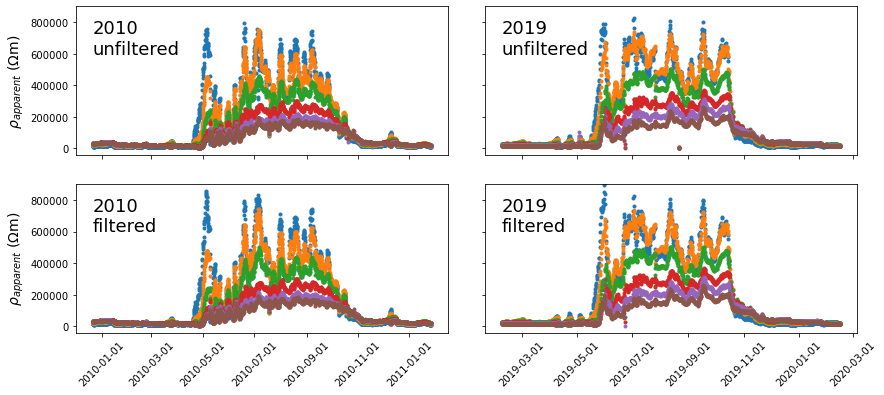

In [223]:
fs=14

fig, ax = plt.subplots(2,2,figsize=[14,6])
for i in range(len(nk)):
    ax[0,0].plot(nd[:n_surveys_proc_2010],rhoa_avg.T[i][:n_surveys_proc_2010],'.')
    ax[0,1].plot(nd[n_surveys_proc_2010:],rhoa_avg.T[i][n_surveys_proc_2010:],'.')
    ax[1,0].plot(nd[:n_surveys_proc_2010],rhoa_avg_filt.T[i][:n_surveys_proc_2010],'.')
    ax[1,1].plot(nd[n_surveys_proc_2010:],rhoa_avg_filt.T[i][n_surveys_proc_2010:],'.')
    
for a in ax.ravel():
    a.set_ylim([-40000,900000]);
#     a.set_yscale('log') # can comment this out to see plot with linear y-axis
    a.set_ylabel(r'$\rho$$_{apparent}$ ($\Omega$m)',fontsize=fs);
    date_format = mdates.DateFormatter('%Y-%m-%d') 
    a.xaxis.set_major_formatter(date_format)
    a.tick_params(axis='x',labelrotation=45)

ax[0,0].axes.get_xaxis().set_ticklabels([])
ax[0,1].axes.get_xaxis().set_ticklabels([])
ax[0,1].axes.get_yaxis().set_ticklabels([])
ax[1,1].axes.get_yaxis().set_ticklabels([])
ax[0,1].set_ylabel('')
ax[1,1].set_ylabel('')

ytxt = 600000
ax[0,0].text(nd[0],ytxt,'2010\nunfiltered',fontsize=18)
ax[1,0].text(nd[0],ytxt,'2010\nfiltered',fontsize=18)

ax[0,1].text(nd[n_surveys_proc_2010],ytxt,'2019\nunfiltered',fontsize=18)
ax[1,1].text(nd[n_surveys_proc_2010],ytxt,'2019\nfiltered',fontsize=18)

plt.subplots_adjust( wspace=0.1)

plt.savefig('data_raw_filt.png',format='png',dpi=500,bbox_inches='tight')

## Plot inversion results (right now just for one survey)

In [148]:
# import matplotlib as mpl

# fs=22 # title
# fs1=60 # subplots
# fs2=16 # ticks
# fs3=20 # labels

# data_filt_i = data_all[data_all['survey_name']=='21.12.2009 12:00:00']

# fig, ax = plt.subplots(1,3,figsize=[20,4])
# plt.subplots_adjust(wspace=0.1)

# cmin = np.sort(data_filt_i['rhoa'])[0]
# cmax = np.sort(data_filt_i['rhoa'])[-1]

# mgr = ert.ERTManager(data_filt)
# mgr.showData(
#     vals=data_filt_i['rhoa'],
#     ax=ax[0],
#     label=r'$\rho_{app}$ ($\Omega$m)',
#     cMap='turbo_r',
#     cMin=cmin,
#     cMax=cmax,
#     logScale=False
# );

# mgr.showData(
#     vals=mgr.inv.response,
#     ax=ax[1],
#     label=r'$\rho_{app}$ ($\Omega$m)',
#     cMap='turbo_r',
#     cMin=cmin,
#     cMax=cmax,
#     logScale=False
# );

# mgr.showData(
#     vals=((mgr.inv.response-data_filt['rhoa'])/data_filt['rhoa'])*100,
#     ax=ax[2],
#     label='Error (%)',
#     cMap='seismic',
#     cMin=-20,
#     cMax=20
# );

# ax[0].set_title('Observed data (filtered)',fontsize=fs)
# # ax[0].set_title('Observed data (filtered)\n%.0f data points removed'%(len(data_checked['rhoa'])-len(data_filt['rhoa'])),fontsize=fs)
# ax[0].text(7.,5.,'%.0f points \nremoved'%(len(data_checked['rhoa'])-len(data_filt['rhoa']),),fontsize=fs2)
# ax[1].set_title('Predicted data',fontsize=fs)
# ax[2].set_title('Data misfit',fontsize=fs);

# # ax[0].text(8,13,'b',fontsize=fs1)
# # ax[1].text(8,13,'c',fontsize=fs1)
# # ax[2].text(8,13,'d',fontsize=fs1)


# for a in ax:
#     a.tick_params(axis='both', which='major', labelsize=fs2)
#     a.set_yticks([])
#     a.set_xlabel('X (m)',fontsize=fs3)
#     a.__cBar__.remove()

# ax[0].set_ylabel('Depth level',fontsize=fs3)
    
# cax = fig.add_axes([0.125, 0.05, 0.51, 0.06])
# cmap = mpl.cm.turbo_r
# norm = mpl.colors.Normalize(vmin=cmin, vmax=cmax)

# cb1 = mpl.colorbar.ColorbarBase(cax, cmap=cmap,
#                                 norm=norm,
#                                 orientation='horizontal',
# #                                ticks=np.linspace(800,2000,7)
#                                )
# cb1.set_label(r'Apparent resistivity ($\Omega$m)',fontsize=fs3)
# cb1.ax.tick_params(labelsize=fs2) 
    
    
    
    
    
# cax = fig.add_axes([0.658, 0.05, 0.243, 0.06])
# cmap = mpl.cm.seismic
# norm = mpl.colors.Normalize(vmin=-20, vmax=20)

# cb1 = mpl.colorbar.ColorbarBase(cax, cmap=cmap,
#                                 norm=norm,
#                                 orientation='horizontal',
#                                )
# cb1.set_label('Misfit (%)',fontsize=fs3)
# cb1.ax.tick_params(labelsize=fs2)     
    
    
    
    
    
    
# cmin  =np.sort(mgr.paraModel())[int(len(mgr.paraModel())/100)]
# cmax = np.sort(mgr.paraModel())[-int(len(mgr.paraModel())/100)]
# # fig, ax = plt.subplots(1,1,figsize=[15,5])
# ax = fig.add_axes([0, 1.2, 1, 0.8])
# axs, cBar = mgr.showResult(
#    mod,
#     ax=ax,
#     cMap='turbo_r',
#     coverage=mgr.coverage(),
#     cMin=3500,
#     cMax=60000,
#     logScale=True,
#     orientation='vertical',

# );

# ax.tick_params(axis='both', which='major', labelsize=fs2)
# ax.set_ylim([-2,0.2])
# # ax.text(2,-35,'a',fontsize=fs1)

# ax.plot(np.array(data_raw.sensors()).T[0],np.array(data_raw.sensors()).T[2]+0.8,'kv')
# e_pad = min(abs(np.diff(np.array(data_raw.sensors()).T[0])))/2
# ax.set_xlim([min(np.array(data_raw.sensors()).T[0])-e_pad,max(np.array(data_raw.sensors()).T[0])+e_pad])

# ax.set_xlabel('X (m)',fontsize=fs3)
# ax.set_ylabel('Z (m)',fontsize=fs3)
# ax.set_title(r'$\chi$$^2$ = %.2f, rms error = %.1f%%'%(chi2,rms),fontsize=fs);
# cBar.set_label(r'Resistivity ($\Omega$m)',rotation=270,fontsize=fs3,labelpad=30)
# cBar.ax.tick_params(labelsize=fs2) 

# # plt.savefig('inversion_results.png',format='png',dpi=500,bbox_inches='tight')

## Extract information from  a virtual borehole

In [149]:
xborehole = 4.5
# zcells = np.unique(np.array(grid.cellCenters()).T[1])

# find all cells within region

cells_borehole  = np.where(abs(np.array(grid.cellCenters()).T[0]-xborehole)==min(abs(np.array(grid.cellCenters()).T[0]-xborehole)))[0]
zbh = np.array(grid.cellCenters()).T[1][cells_borehole]

dt = []
rho_borehole = []
sens_borehole = []
z_borehole = np.flipud(np.unique(np.array(grid.cellCenters()).T[1]))
rms = []

dates_sort = np.sort(np.unique(ert_all['survey_time']))
    
if len(cells_borehole) > len(z_borehole):
    print('Chosen x-coordinate is at a cell boundary. Taking average of cells on either side.')

# for i in range(0,2):
for i in range(n_surveys_proc):
    data_plt = ert_all[ert_all['survey_time']==dates_sort[i]]
    dt.append(data_plt['survey_time'].iloc[0])
    
    if len(cells_borehole) > len(z_borehole): # if borehole is at cell edge

        if data_plt['rho_s'].iloc[0]==-999: # if results were not inverted
            ph = np.empty(len(z_borehole))
            ph[:] = np.nan
            rho_borehole.append(ph)
            sens_borehole.append(ph)
            rms.append(np.nan)

        else: # if results were inverted, then take an average of cells on either side of borehole
            
            r_ph = np.array(data_plt['rho_s'].iloc[cells_borehole])
            s_ph = np.array(data_plt['sens'].iloc[cells_borehole])
            ph = []
            phs = []

            for i in range(len(z_borehole)):
                I = np.where(zbh == z_borehole[i])[0]
                ph.append(np.mean(r_ph[I]))
                phs.append(np.mean(s_ph[I]))

            rho_borehole.append(np.array(ph))
            sens_borehole.append(np.array(phs))
            rms.append(data_plt['rms'].iloc[0])     
            
    else: # if borehole is already near a cell centre
        
        if data_plt['rho_s'].iloc[0]==-999: # if results were note inverted
            
            ph[:] = np.nan
            rho_borehole.append(ph)
            sens_borehole.append(ph)
            rms.append(np.nan)
            
        else: # if results were inverted
            rho_borehole.append(np.array(data_plt['rho_s'].iloc[cells_borehole]))
            sens_borehole.append(np.array(data_plt['sens'].iloc[cells_borehole]))
            rms.append(data_plt['rms'].iloc[0])                    

      

Chosen x-coordinate is at a cell boundary. Taking average of cells on either side.


In [150]:
# scale coverage for plotting later (modified from pygimli)

C = np.hstack(sens_borehole)
C = C[~np.isnan(C)]
dropThreshold=0.4

if (np.min(C) < 0.) | (np.max(C) > 1.) | (np.max(C) < 0.5):

    nn, hh = np.histogram(C, 50)
    nnn = nn.cumsum(axis=0) / float(len(C))

    mi = hh[min(np.where(nnn > 0.02)[0])]

    if min(nnn) > dropThreshold:
        ma = max(C)
    else:
        ma = hh[max(np.where(nnn < dropThreshold)[0])]

    rho_alp = (sens_borehole - mi) / (ma - mi)
    rho_alp[np.where(rho_alp < 0.)] = 0.0
    rho_alp[np.where(rho_alp > 1.)] = 1.0

## Line plot

(17886.0, 18307.0)

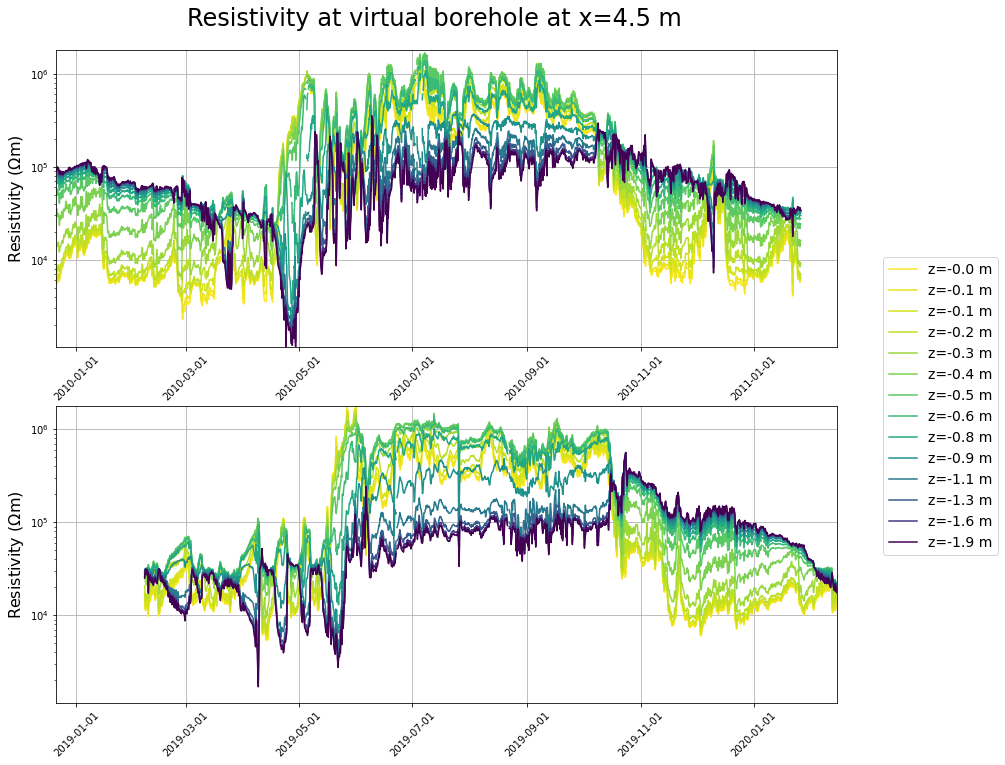

In [190]:

# plot the results

cmin = min(np.hstack(rho_borehole))
cmax = max(np.hstack(rho_borehole))

fs = 16

fig, ax = plt.subplots(2,1,figsize=[14,12])

norm = plt.Normalize(min(z_borehole), max(z_borehole))
cm = plt.cm.viridis
sm = plt.cm.ScalarMappable(cmap=cm, norm=norm)

for i in range(len(z_borehole)):
    ax[0].plot_date(dt[:n_surveys_proc_2010], np.array(rho_borehole).T[i][:n_surveys_proc_2010],'-',color=cm(norm(z_borehole[i])),label='z=%.1f m'%z_borehole[i])

for i in range(len(z_borehole)):
    ax[1].plot_date(dt[n_surveys_proc_2010:], np.array(rho_borehole).T[i][n_surveys_proc_2010:],'-',color=cm(norm(z_borehole[i])),label='z=%.1f m'%z_borehole[i])

    
plt.suptitle('Resistivity at virtual borehole at x=%.1f m'%(xborehole),fontsize=24,y=0.93);
plt.legend(loc='center left', bbox_to_anchor=(1.05, 1),fontsize=fs-2);

x_bh = np.array(grid.cellCenters()).T[0][cells_borehole][0] # true borehole location

for a in ax:
    a.set_ylim([cmin,cmax]);
    a.set_yscale('log') # can comment this out to see plot with linear y-axis
    a.set_ylabel(r'Resistivity ($\Omega$m)',fontsize=fs);
    
    date_format = mdates.DateFormatter('%Y-%m-%d') 
    a.xaxis.set_major_formatter(date_format)
    a.tick_params(axis='x',labelrotation=45)
    a.grid()

# ax[0].set_xlim([min(dt[:n_surveys_proc_2010]),max(dt[:n_surveys_proc_2010])]);
# ax[1].set_xlim([min(dt[n_surveys_proc_2010:]),max(dt[n_surveys_proc_2010:])]);

ax[0].set_xlim([datetime.date(2009, 12, 21), datetime.date(2011, 2, 15)])
ax[1].set_xlim([datetime.date(2018, 12, 21), datetime.date(2020, 2, 15)])

## Calculate maximum gradients and estimate active layer depth

Note: we will find the sharpest gradient where resistivity is increasing with depth (i.e., thawed active layer above permafrost, or ice-poor layer above ice-rich layer).

Here, we can set some thresholds to better identify sharp boundaries (e.g. frozen/unfrozen interface):
1. the gradient should be in the near surface somewhere 
2. the gradient should be fairly steep
3. the average resistivity of the top layer could be below some threshold (i.e. if we are looking for depth of thaw layer)

These thresholds are arbitrary and may need to be tweaked.

In [210]:
z_gmax = []
z_thaw = []

Gmax_all = []
Gmax_thaw = []

for i in range(len(dt)):
    if np.isnan(rho_borehole[i][0]): # if dataset was not inverted, don't calculate gradient
        z_gmax.append(np.nan)
        z_thaw.append(np.nan)
        Gmax_all.append(np.nan)
        Gmax_thaw.append(np.nan)
    else:
        G = np.gradient(np.log(np.array(rho_borehole)[i]), z_borehole) # calculate gradient
        G_val = G[np.where(G==min(G))[0][0]]
        Gmax_all.append(G_val)
        Gmax_thaw.append(G_val)
        
        z_gmax.append(z_borehole[np.where(G==min(G))[0][0]]) # depth of max gradient (going from low to high resistivity)
        z_thaw.append(z_borehole[np.where(G==min(G))[0][0]]) # depth of max gradient (going from low to high resistivity)
        
        if z_gmax[i] <- 1: # if we have physically unrealistic values, discard
            z_gmax[i] = np.nan
            z_thaw[i] = np.nan
            Gmax_thaw[i] = np.nan
            
        if G_val > -4: # if gradients are small, discard
            z_thaw[i] = np.nan
            Gmax_thaw[i] = np.nan
            
#         if np.mean(rho_borehole[i][:np.where(G==min(G))[0][0]])>10e4: # if active layer is frozen            
        if np.mean(rho_borehole[i][:np.where(G==min(G))[0][0]])>30000: # if active layer is frozen
            z_thaw[i] = np.nan
            Gmax_thaw[i] = np.nan
            
      



/Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


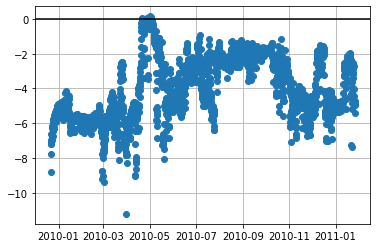

In [211]:
plt.plot_date(dt[:n_surveys_proc_2010],Gmax_all[:n_surveys_proc_2010])
plt.axhline(y=0, color='k', linestyle='-')
plt.grid()


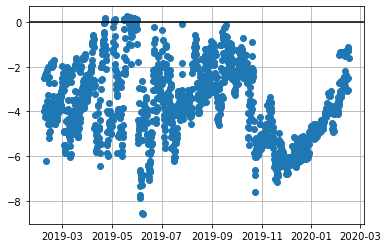

In [212]:
plt.plot_date(dt[n_surveys_proc_2010:],Gmax_all[n_surveys_proc_2010:])
plt.axhline(y=0, color='k', linestyle='-')
plt.grid()

## Static plot

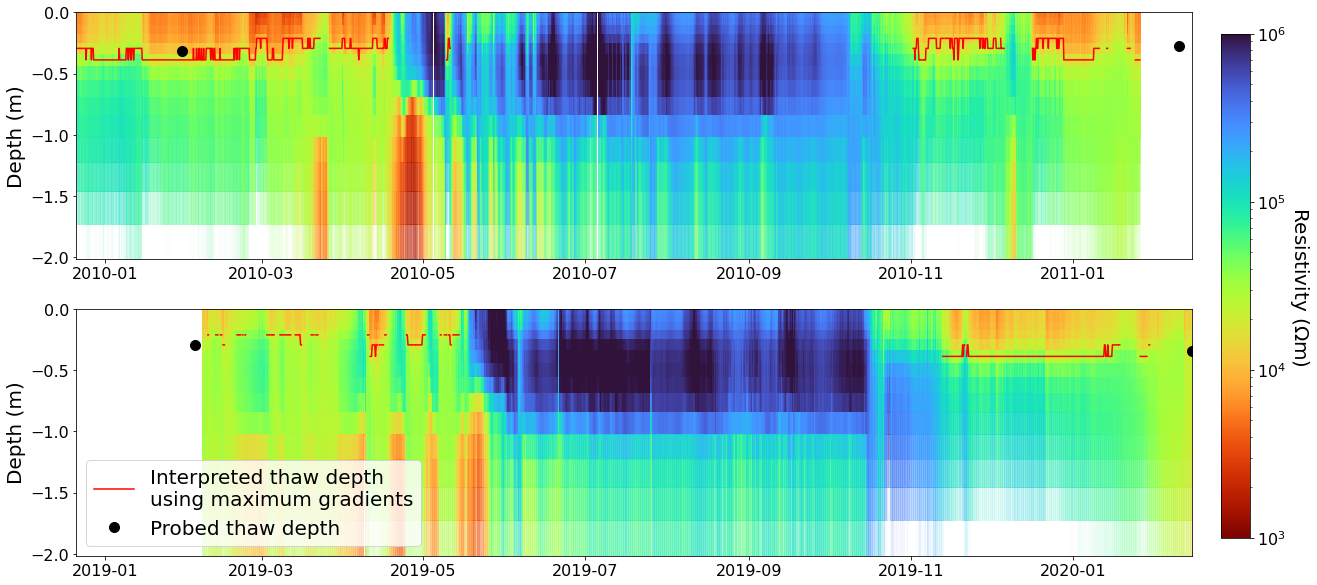

In [214]:
# cmin = min(np.hstack(rho_borehole))
# cmax = max(np.hstack(rho_borehole))

cmin = 1e3
cmax = 1e6

fs = 20
fs2 = 16 # tick labels

fig, ax = plt.subplots(2,1,figsize=[20,10])

X, Y = np.meshgrid(dt[:n_surveys_proc_2010],z_borehole)
C1 = ax[0].pcolormesh(
    X,
    Y,
    np.array(rho_borehole[:n_surveys_proc_2010]).T,
    cmap='turbo_r',
    shading='auto',
    norm=colors.LogNorm(vmin=cmin, vmax=cmax), # logarithmic scale
)

X, Y = np.meshgrid(dt[n_surveys_proc_2010:],z_borehole)
C2 = ax[1].pcolormesh(
    X,
    Y,
    np.array(rho_borehole[n_surveys_proc_2010:]).T,
    cmap='turbo_r',
    shading='auto',
    norm=colors.LogNorm(vmin=cmin, vmax=cmax), # logarithmic scale
)

# ax[0].plot(dt[:n_surveys_proc_2010],z_gmax[:n_surveys_proc_2010],'b')
ax[0].plot(dt[:n_surveys_proc_2010],z_thaw[:n_surveys_proc_2010],'r')

# ax[1].plot(dt[n_surveys_proc_2010:],z_gmax[n_surveys_proc_2010:],'b',label='max gradient')
ax[1].plot(dt[n_surveys_proc_2010:],z_thaw[n_surveys_proc_2010:],'r',label='Interpreted thaw depth\nusing maximum gradients')

# note that probing data is not publically available. If you do not have access, comment the following lines to avoid an error.
probedata = pd.read_csv('data_AERT/probing_data.txt',delimiter='\t')

for i in range(len(probedata)):
    if i==0:

        ax[0].plot(datetime.datetime.strptime(probedata['date'].iloc[i], '%Y-%m-%d'),-probedata['mean'].iloc[i]/100,'ko',markersize=10)
        ax[1].plot(datetime.datetime.strptime(probedata['date'].iloc[i], '%Y-%m-%d'),-probedata['mean'].iloc[i]/100,'ko',markersize=10,label='Probed thaw depth')

    else:
        ax[0].plot(datetime.datetime.strptime(probedata['date'].iloc[i], '%Y-%m-%d'),-probedata['mean'].iloc[i]/100,'ko',markersize=10)
        ax[1].plot(datetime.datetime.strptime(probedata['date'].iloc[i], '%Y-%m-%d'),-probedata['mean'].iloc[i]/100,'ko',markersize=10)

plt.legend(fontsize=fs)

for a in ax:
    a.set_ylabel('Depth (m)',fontsize=fs)

ax[0].set_xlim([datetime.date(2009, 12, 21), datetime.date(2011, 2, 15)])
ax[1].set_xlim([datetime.date(2018, 12, 21), datetime.date(2020, 2, 15)])

cax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
cbar = fig.colorbar(C1, cax=cax, )
cbar.ax.tick_params(labelsize=fs2) 
plt.ylabel(r'Resistivity ($\Omega$m)',fontsize=fs,rotation=270,labelpad=25);

# add opacity filter
fig.canvas.draw()

for i,j in zip(C1.get_facecolors(),rho_alp[:n_surveys_proc_2010].flatten(order='F')):
    i[3] = j 
    
for i,j in zip(C2.get_facecolors(),rho_alp[n_surveys_proc_2010:].flatten(order='F')):
    i[3] = j 
    
for a in ax: 
    a.tick_params(axis='both', which='major', labelsize=fs2)
    
plt.savefig('aert_2010_2019.png',format='png',dpi=500,bbox_inches='tight')

## Calculate saturation ratio and plot

In [ ]:
# date ranges where 2010 and 2019 datasets overlap

t_days_2010 = pd.date_range(start='2010-02-07',end='2011-01-25')
t_days_2019 = pd.date_range(start='2019-02-07',end='2020-01-25')

# take daily resistivity averages, since we are sampling at different temporal intervals in 2010 and 2019
# note that this will compute averages even if some of the data is missing

rho_bh_daily_2010 = []
rho_bh_daily_2019 = []

for i in range(0,len(t_days)):
    rho_bh_daily_2010.append(np.nanmean(rho_borehole[285 + i*6 : 285 + (i+1)*6],axis=0))
    rho_bh_daily_2019.append(np.nanmean(rho_borehole[2407 + i*4 : 2407 + (i+1)*4],axis=0))

    
# plot 

fig, ax = plt.subplots(2,1,figsize=[20,10])

X, Y = np.meshgrid(dt[:n_surveys_proc_2010],z_borehole)
C0 = ax[0].pcolormesh(
    X,
    Y,
    np.array(rho_borehole[:n_surveys_proc_2010]).T,
    cmap='turbo_r',
    shading='auto',
    norm=colors.LogNorm(vmin=cmin, vmax=cmax), # logarithmic scale
)

X, Y = np.meshgrid(dt[n_surveys_proc_2010:],z_borehole)
C1 = ax[1].pcolormesh(
    X,
    Y,
    np.array(rho_borehole[n_surveys_proc_2010:]).T,
    cmap='turbo_r',
    shading='auto',
    norm=colors.LogNorm(vmin=cmin, vmax=cmax), # logarithmic scale
)

cax = fig.add_axes([0.93, 0.2, 0.02, 0.6])
fig.colorbar(C1, cax=cax, )
plt.ylabel(r'Resistivity ($\Omega$m)',fontsize=fs,rotation=270,labelpad=20);

# add opacity filter
fig.canvas.draw()

for i,j in zip(C0.get_facecolors(),rho_alp[:n_surveys_proc_2010].flatten(order='F')):
    i[3] = j 
    
for i,j in zip(C1.get_facecolors(),rho_alp[n_surveys_proc_2010:].flatten(order='F')):
    i[3] = j 

ax[0].set_xlim([datetime.date(2009, 12, 21), datetime.date(2011, 2, 15)])
ax[1].set_xlim([datetime.date(2018, 12, 21), datetime.date(2020, 2, 15)])   
    
for a in ax:
    a.set_ylabel('Depth (m)',fontsize=fs)
    
date_format = mdates.DateFormatter('%Y-%m-%d') 
ax[0].xaxis.set_major_formatter(date_format)
ax[1].xaxis.set_major_formatter(date_format)




    
S_rat_n2 = 10** (np.log10(np.divide(rho_bh_daily_2019,rho_bh_daily_2010))/(1-2))
S_rat_n3 = 10** (np.log10(np.divide(rho_bh_daily_2019,rho_bh_daily_2010))/(1-3))

fig, ax = plt.subplots(3,1,figsize=[20,15])

X, Y = np.meshgrid(t_days_2019,z_borehole)
C0 = ax[0].pcolormesh(
    X,
    Y,
    S_rat_n2.T,
    cmap='seismic_r',
    shading='auto',
    norm=colors.LogNorm(vmin=1e-2, vmax=1e2), # logarithmic scale
)

C1 = ax[1].pcolormesh(
    X,
    Y,
    S_rat_n3.T,
    cmap='seismic_r',
    shading='auto',
    norm=colors.LogNorm(vmin=1e-2, vmax=1e2), # logarithmic scale
)

ax[0].text(t_days_2019[-35],-1.8,'n=2',fontsize=40)
ax[1].text(t_days_2019[-35],-1.8,'n=3',fontsize=40)

cax = fig.add_axes([0.93, 0.44, 0.02, 0.4])
fig.colorbar(C1, cax=cax, )
plt.ylabel(r'S2/S1',fontsize=fs,rotation=270,labelpad=20);

ax[0].set_xlim([datetime.date(2018, 12, 21), datetime.date(2020, 2, 15)])
ax[1].set_xlim([datetime.date(2018, 12, 21), datetime.date(2020, 2, 15)])

for a in ax:
    a.set_ylabel('Depth (m)',fontsize=fs)
    
date_format = mdates.DateFormatter('%m-%d') 
ax[0].xaxis.set_major_formatter(date_format)
ax[1].xaxis.set_major_formatter(date_format)

    
ax[2].plot(t_days_2019,S_rat_n2.T[0],'c',label='z=%.2f m, n=2'%z_borehole[0])
ax[2].plot(t_days_2019,S_rat_n3.T[0],'c--',label='z=%.2f m, n=3'%z_borehole[0])
ax[2].plot(t_days_2019,S_rat_n2.T[6],'m',label='z=%.2f m, n=2'%z_borehole[6])
ax[2].plot(t_days_2019,S_rat_n3.T[6],'m--',label='z=%.2f m, n=3'%z_borehole[6])
ax[2].axhline(y=1, color='k', linestyle='-')
ax[2].set_yscale('log')
ax[2].set_ylim([10**-2,10**2])
ax[2].set_ylabel('S2/S1',fontsize=fs)
ax[2].legend(fontsize=fs)
ax[2].xaxis.set_major_formatter(date_format)
ax[2].set_xlim([datetime.date(2018, 12, 21), datetime.date(2020, 2, 15)])


## Interactive comparison plot

In [71]:
t1 = pd.date_range(start='2009-12-21',
              end='2011-02-15'
              )

t2 = pd.date_range(start='2018-12-21',
                  end='2020-02-15'
                  )

c1 = 'darkorange'
c2 = 'darkorchid'

# TODO: this doesn't account for leap years yet...

# also note that this will just plot the dataset at 00:00 each day, since temporal sampling is different in 2010 vs 2019


from ipywidgets import Layout

@interact(i=(0,len(t1)-1))

def plot_m(i=20):
    
    cmin = min(np.hstack(rho_borehole))
    cmax = max(np.hstack(rho_borehole))

    fs = 16

    fig, ax = plt.subplots(2,1,figsize=[20,10])
    
    X, Y = np.meshgrid(dt[:n_surveys_proc_2010],z_borehole)
    C1 = ax[0].pcolormesh(
        X,
        Y,
        np.array(rho_borehole[:n_surveys_proc_2010]).T,
        cmap='turbo_r',
        shading='auto',
        norm=colors.LogNorm(vmin=cmin, vmax=cmax), # logarithmic scale
    )
        
    X, Y = np.meshgrid(dt[n_surveys_proc_2010:],z_borehole)
    C2 = ax[1].pcolormesh(
        X,
        Y,
        np.array(rho_borehole[n_surveys_proc_2010:]).T,
        cmap='turbo_r',
        shading='auto',
        norm=colors.LogNorm(vmin=cmin, vmax=cmax), # logarithmic scale
    )
    
    ax[0].plot(dt[:n_surveys_proc_2010],z_gmax[:n_surveys_proc_2010],'b')
    ax[0].plot(dt[:n_surveys_proc_2010],z_thaw[:n_surveys_proc_2010],'r')
    
    ax[1].plot(dt[n_surveys_proc_2010:],z_gmax[n_surveys_proc_2010:],'b',label='max gradient')
    ax[1].plot(dt[n_surveys_proc_2010:],z_thaw[n_surveys_proc_2010:],'r',label='interpreted\nthaw depth')
    
    plt.legend(fontsize=fs)
    
    if t1[i] in pd.DatetimeIndex(dt):
        i1 = np.where(pd.DatetimeIndex(dt)==t1[i])[0][0]
        ax[0].axvline(x = dt[i1], color = 'k',linewidth=2)
    else:
        i1 = np.nan
        
    if t2[i] in pd.DatetimeIndex(dt):
        i2 = np.where(pd.DatetimeIndex(dt)==t2[i])[0][0]
        ax[1].axvline(x = dt[i2], color = 'k',linewidth=2)
    else:
        i2 = np.nan


    for a in ax:
        a.set_ylabel('Depth (m)',fontsize=fs)
    plt.suptitle('Resistivity at virtual borehole at x=%.1f m'%(xborehole),fontsize=20);

    
    cax = fig.add_axes([0.95, 0.15, 0.02, 0.7])
    fig.colorbar(C1, cax=cax, )
    plt.ylabel(r'Resistivity ($\Omega$m)',fontsize=fs,rotation=270,labelpad=20);
    
    # add opacity filter
    fig.canvas.draw()

    for i,j in zip(C1.get_facecolors(),rho_alp[:n_surveys_proc_2010].flatten(order='F')):
        i[3] = j 

    for i,j in zip(C2.get_facecolors(),rho_alp[n_surveys_proc_2010:].flatten(order='F')):
        i[3] = j 
                
    ax[0].set_xlim([datetime.date(2009, 12, 21), datetime.date(2011, 2, 15)])
    ax[1].set_xlim([datetime.date(2018, 12, 21), datetime.date(2020, 2, 15)])
    
    fig, ax = plt.subplots(1,1,figsize=[14,2])
    
    ax.plot(dt[:n_surveys_proc_2010], rms[:n_surveys_proc_2010],'-',color=c1,linewidth=1,label='2010')
    ax.tick_params(axis='x', colors=c1) 
    ax.set_xlim([datetime.date(2009, 12, 21), datetime.date(2011, 2, 15)])
    ax.set_ylabel('rms error of\ninverted dataset (%)',fontsize=fs)
    
    ax2 = ax.twiny() 
    ax2.plot([], [], '-',color=c1,linewidth=1,label = '2010')
    ax2.plot(dt[n_surveys_proc_2010:], rms[n_surveys_proc_2010:],'-',color=c2,linewidth=1,label='2019')
    ax2.tick_params(axis='x', colors=c2)
    ax2.set_xlim([datetime.date(2018, 12, 21), datetime.date(2020, 2, 15)])
    
    if np.isnan(i1) and np.isnan(i2):
        pass
    elif np.isnan(i1):
        ax2.axvline(x = dt[i2], color = 'k',linewidth=1.5)
    else:
        ax.axvline(x = dt[i1], color = 'k',linewidth=1.5)
        
    
    plt.legend(fontsize=fs-2)


    fig, ax = plt.subplots(1,1,figsize=[6,6])
    
    if np.isnan(i1):
        pass
    else:
        plt.plot(rho_borehole[i1],z_borehole,color=c1,linewidth=2,label='2010')
        ax.hlines(y=z_gmax[i1], xmin=cmin, xmax=cmax, linewidth=2,color=c1,linestyles='dashed',label='Max gradient 2010')
        
    if np.isnan(i2):
        pass
    else:
        plt.plot(rho_borehole[i2],z_borehole,color=c2,linewidth=2,label='2019')
        ax.hlines(y=z_gmax[i2], xmin=cmin, xmax=cmax, linewidth=2, color=c2,linestyles='dashed',label='Max gradient 2019')


    ax.set_xlim([cmin,cmax])
    ax.set_xscale('log')
    plt.ylabel('Depth (m)',fontsize=fs)
    plt.xlabel(r'Resistivity ($\Omega$m)',fontsize=fs)
    plt.minorticks_on()
    plt.grid(b=True, which='major', color='#858585')
    plt.grid(b=True, which='minor', color='#cacbcc')
    plt.legend()

    
    # TODO: I'm sure this logic could be more pythonic
        
    if np.isnan(i1) and np.isnan(i2):
        pass
    elif np.isnan(i1):
        if np.isnan(z_thaw[i2]):
            s = 'No'
        else:
            s = 'Yes'
#         ax.text(1e7,-1,'Showing profile for: \n\n%s \nmax gradient at %.1f m\ninterpreted thaw depth? %s'%(dt[i2],z_gmax[i2],s),fontsize=fs,);
        ax.text(1e7,-0.6,'Showing profile for:',fontsize=fs)
        ax.text(1e7,-1,'%s \nmax gradient at %.1f m\ninterpreted as thaw depth? %s'%(dt[i2],z_gmax[i2],s),fontsize=fs,color=c2);
        
    elif np.isnan(i2):
        if np.isnan(z_thaw[i1]):
            s = 'No'
        else:
            s = 'Yes'
#         ax.text(1e7,-1,'Showing profile for: \n\n%s \nmax gradient at %.1f m\ninterpreted thaw depth? %s'%(dt[i1],z_gmax[i1],s),fontsize=fs);
        ax.text(1e7,-0.6,'Showing profile for:',fontsize=fs)
        ax.text(1e7,-1,'%s \nmax gradient at %.1f m\ninterpreted as thaw depth? %s'%(dt[i1],z_gmax[i1],s),fontsize=fs,color=c1);
    else:
        if np.isnan(z_thaw[i1]) and np.isnan(z_thaw[i2]):
            s1 = 'No'
            s2 = 'No'
        elif np.isnan(z_thaw[i1]):
            s1 = 'No'
            s2 = 'Yes'
        elif np.isnan(z_thaw[i2]):
            s1 = 'Yes'
            s2 = 'No'    
        else:
            s1 = 'Yes'
            s2 = 'Yes'                
        ax.text(1e7,-0.6,'Showing profiles for:',fontsize=fs)
        ax.text(1e7,-1,'%s \nmax gradient at %.1f m\ninterpreted as thaw depth? %s'%(dt[i1],z_gmax[i1],s1),fontsize=fs,color=c1);
        ax.text(1e7,-1.4,'%s \nmax gradient at %.1f m\ninterpreted as thaw depth? %s'%(dt[i2],z_gmax[i2],s2),fontsize=fs,color=c2);
        
#         ax.text(1e7,-1,'Showing profiles for: \n\n%s \nmax gradient at %.1f m\ninterpreted thaw depth? %s\n\n%s \nmax gradient at %.1f m\ninterpreted thaw depth? %s'%(dt[i1],z_gmax[i1],s1,dt[i2],z_gmax[i2],s2),fontsize=fs);
             
#     ax.text(1e7,-1.5,'Max gradient at %.1f m\n(note: resolution of this boundary is \nlimited by mesh discretization)'%(z_gmax[i]),fontsize=24);    
    
    plt.show()
    
    


interactive(children=(IntSlider(value=20, description='i', max=421), Output()), _dom_classes=('widget-interact…

## Save table with virtual borehole data

In [21]:
d = {
    'z': np.hstack([z_borehole]*len(rho_borehole)), 
    'rho': np.hstack(rho_borehole),
    't':np.repeat(dt,len(z_borehole)),
    'max_g':np.repeat(z_gmax,len(z_borehole)),
    

}

df = pd.DataFrame(data=d)

# fmt='%f.5, %f, %5s, %f'

# np.savetxt('vbh_full.txt', df, header="z rho t max_g",fmt='%5s')


# Load and plot results for individual years

In [ ]:
grid = pg.load('data_AERT/inverted_data/mesh_2010.vtk')
ert_all = pd.read_csv('data_AERT/inverted_data/ert_all_2010', sep=',',index_col=0)
data_all = pd.read_csv('data_AERT/inverted_data/data_all_2010', sep=',',index_col=0)

n_surveys_proc = len(np.unique(ert_all['survey_name']))

# grid = pg.load('data_AERT/inverted_data/mesh_2019.vtk')
# ert_all = pd.read_csv('data_AERT/inverted_data/ert_all_2019', sep=',',index_col=0)
# data_all = pd.read_csv('data_AERT/inverted_data/data_all_2019', sep=',',index_col=0)

# n_surveys_proc = len(np.unique(ert_all['survey_name']))

## First, make a new column with datetime dates

In [ ]:

survey_time = []
for i in range(len(ert_all)):
    survey_time.append(datetime.datetime.strptime(ert_all['survey_name'].iloc[i], '%d.%m.%Y %H:%M:%S'))
ert_all['survey_time'] = survey_time

survey_time = []
for i in range(len(data_all)):
    survey_time.append(datetime.datetime.strptime(data_all['survey_name'].iloc[i], '%d.%m.%Y %H:%M:%S'))
data_all['survey_time'] = survey_time

### Plot results as animation

In [ ]:
@interact(i=(0,n_surveys_proc-1))

def plot_m(i=0):
    
    cmin = 1e3
    cmax = 1e6
    
    
    #### retrieve data from table
    dates_sort = np.sort(np.unique(ert_all['survey_time']))
    data_plt = data_all[data_all['survey_time']==dates_sort[i]]
    data_in = pg.DataContainerERT()
    data_out = pg.DataContainerERT()

    for k in range(0,len(E)):
        data_in.createSensor([E[k], 0.0]) # 2D, no topography
        data_out.createSensor([E[k], 0.0]) # 2D, no topography

    cols = ['a','b','m','n','k','rhoa','k']

    for k in range(len(data_plt)):

        data_in.addFourPointData(
            [int(data_plt['a'].iloc[k]),
             int(data_plt['b'].iloc[k]),
             int(data_plt['m'].iloc[k]),
             int(data_plt['n'].iloc[k])],
            rhoa=data_plt['rhoa'].iloc[k],
            k=data_plt['k'].iloc[k],
        )

        if data_plt['used'].iloc[k] > 0:

            data_out.addFourPointData(
                [int(data_plt['a'].iloc[k]),
                 int(data_plt['b'].iloc[k]),
                 int(data_plt['m'].iloc[k]),
                 int(data_plt['n'].iloc[k])],
                rhoa=data_plt['rhoa'].iloc[k] ,
                k=data_plt['k'].iloc[k],
            )
    
    
    fig, ax = plt.subplots(1,2,figsize=[20,5])

    pg.physics.ert.showData(
        data_in, 
        vals=data_in['rhoa'],
        ax=ax[0],
        label=r'$\rho_{app}$ ($\Omega$m)',
        cMap='turbo_r',
        cMin=cmin,
        cMax=cmax,
        logScale=True
    );
    
    ax[0].set_title('Raw data',fontsize=24);

    if sum(data_plt['used'])/len(data_plt)<0.3:
        txt = 'Poor quality dataset - too many points filtered'
        ax[1].text(0.05,0.5,txt,fontsize=20)
        
    else:
        pg.physics.ert.showData(
            data_out, 
            vals=data_out['rhoa'],
            ax=ax[1],
            label=r'$\rho_{app}$ ($\Omega$m)',
            cMap='turbo_r',
            cMin=cmin,
            cMax=cmax,
            logScale=True
        );
        
        ax[1].set_title('Filtered data - %.0f data points removed (%.1f%% of the data)'%(data_in.size()-data_out.size(), float((data_in.size()-data_out.size())/data_in.size()*100)),fontsize=24);


    
    #### plot model
    
    dates_sort = np.sort(np.unique(ert_all['survey_time']))
    data_plt = ert_all[ert_all['survey_time']==dates_sort[i]]
    
    fig, ax = plt.subplots(1,1,figsize=[15,5])
    
    if data_plt['rho_s'].iloc[0]==-999:
        txt = 'Poor quality dataset - inversion not performed'
        ax.text(0.2,0.5,txt,fontsize=20)
        
    else:

        cax, cBar = pg.show(
            grid,
            pg.core.RVector(np.array(data_plt['rho_s'])),
            ax=ax,
            cMap='turbo_r',
            coverage=data_plt['sens'],
            cMin=cmin, # set the colorbar min/max here
            cMax=cmax,
            logScale=True

        );

        cBar.set_label(r'$\rho$ [$\Omega$m]')

        ax.set_xlim([min(E),max(E)])
        ax.set_ylim([ax.get_ylim()[0],0.3])
        ax.plot(E,np.zeros(len(E))+0.1,'kv')
        ax.set_xlabel('X (m)')
        ax.set_ylabel('Z (m)')
        ax.set_title(r'%s, rms error = %.2f%%'%(data_plt['survey_name'].iloc[0],data_plt['rms'].iloc[0]),fontsize=20);


    
    


## Plot resistivity at a virtual borehole

Chosen x-coordinate is at a cell boundary. Taking average of cells on either side.


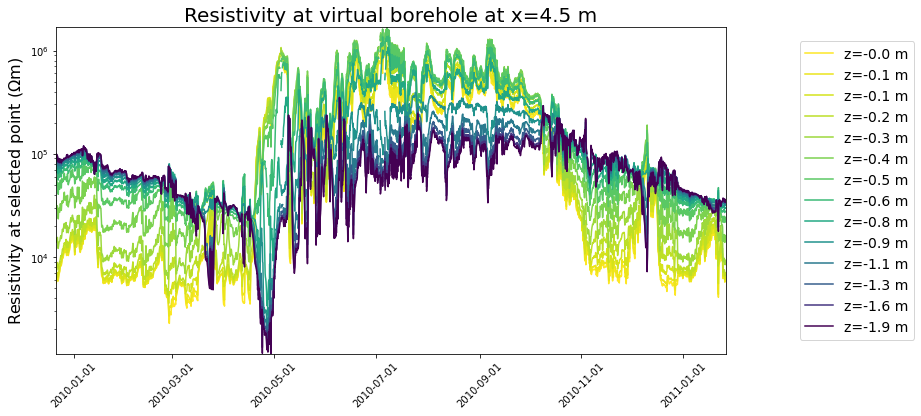

In [18]:
xborehole = 4.5
# zcells = np.unique(np.array(grid.cellCenters()).T[1])

# find all cells within region

cells_borehole  = np.where(abs(np.array(grid.cellCenters()).T[0]-xborehole)==min(abs(np.array(grid.cellCenters()).T[0]-xborehole)))[0]
zbh = np.array(grid.cellCenters()).T[1][cells_borehole]

dt = []
rho_borehole = []
z_borehole = np.flipud(np.unique(np.array(grid.cellCenters()).T[1]))
rms = []

dates_sort = np.sort(np.unique(ert_all['survey_time']))
    
if len(cells_borehole) > len(z_borehole):
    print('Chosen x-coordinate is at a cell boundary. Taking average of cells on either side.')

# for i in range(0,2):
for i in range(n_surveys_proc):
    data_plt = ert_all[ert_all['survey_time']==dates_sort[i]]
    dt.append(data_plt['survey_time'].iloc[0])
    
    if len(cells_borehole) > len(z_borehole): # if borehole is at cell edge

        if data_plt['rho_s'].iloc[0]==-999: # if results were not inverted
            ph = np.empty(len(z_borehole))
            ph[:] = np.nan
            rho_borehole.append(ph)
            rms.append(np.nan)

        else: # if results were inverted, then take an average of cells on either side of borehole
            
            r_ph = np.array(data_plt['rho_s'].iloc[cells_borehole])
            ph = []

            for i in range(len(z_borehole)):
                I = np.where(zbh == z_borehole[i])[0]
                ph.append(np.mean(r_ph[I]))

            rho_borehole.append(np.array(ph))
            rms.append(data_plt['rms'].iloc[0])     
            
    else: # if borehole is already near a cell centre
        
        if data_plt['rho_s'].iloc[0]==-999: # if results were note inverted
            
            ph[:] = np.nan
            rho_borehole.append(ph)
            rms.append(np.nan)
            
        else: # if results were inverted
            rho_borehole.append(np.array(data_plt['rho_s'].iloc[cells_borehole]))
            rms.append(data_plt['rms'].iloc[0])                    

 
# plot the results

cmin = min(np.hstack(rho_borehole))
cmax = max(np.hstack(rho_borehole))

fs = 16

fig, ax = plt.subplots(1,1,figsize=[12,6])

norm = plt.Normalize(min(z_borehole), max(z_borehole))
cm = plt.cm.viridis
sm = plt.cm.ScalarMappable(cmap=cm, norm=norm)

for i in range(len(z_borehole)):
    plt.plot_date(dt, np.array(rho_borehole).T[i],'-',color=cm(norm(z_borehole[i])),label='z=%.1f m'%z_borehole[i])

plt.ylabel(r'Resistivity at selected point ($\Omega$m)',fontsize=fs);
plt.title('Resistivity at virtual borehole at x=%.1f m'%(xborehole),fontsize=20);
plt.legend(loc='center left', bbox_to_anchor=(1.1, 0.5),fontsize=fs-2);

x_bh = np.array(grid.cellCenters()).T[0][cells_borehole][0] # true borehole location

## can uncoment these lines if you want to show rms on this plot
# ax2=ax.twinx()
# ax2.plot(dt, rms,'r-',linewidth=0.5)
# ax2.set_ylabel('RMS error of inverted dataset (%)',fontsize=fs,rotation=270,color='r',labelpad=20);
# ax2.set_ylim([-10,30])

date_format = mdates.DateFormatter('%Y-%m-%d') 
ax.xaxis.set_major_formatter(date_format)
ax.tick_params(axis='x',labelrotation=45)
ax.set_ylim([cmin,cmax]);
ax.set_yscale('log') # can comment this out to see plot with linear y-axis
ax.set_xlim([min(dt),max(dt)]);


## Calculate maximum gradients

In [19]:
z_gmax = []
z_thaw = []

for i in range(len(dt)):
    if np.isnan(rho_borehole[i][0]): # if dataset was not inverted, don't calculate gradient
        z_gmax.append(np.nan)
        z_thaw.append(np.nan)
    else:
        G = np.gradient(np.log(np.array(rho_borehole)[i]), z_borehole) # calculate gradient
        G_val = G[np.where(G==min(G))[0][0]]

        z_gmax.append(z_borehole[np.where(G==min(G))[0][0]]) # depth of max gradient (going from low to high resistivity)
        z_thaw.append(z_borehole[np.where(G==min(G))[0][0]]) # depth of max gradient (going from low to high resistivity)
        
        if z_gmax[i] <- 1: # if we have physically unrealistic values, discard
            z_gmax[i] = np.nan
            z_thaw[i] = np.nan
            
        if G_val > -4: # if gradients are small, discard
            z_thaw[i] = np.nan
            
        if np.mean(rho_borehole[i][:np.where(G==min(G))[0][0]])>10e4: # if active layer is frozen
            z_thaw[i] = np.nan
            
    


/Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


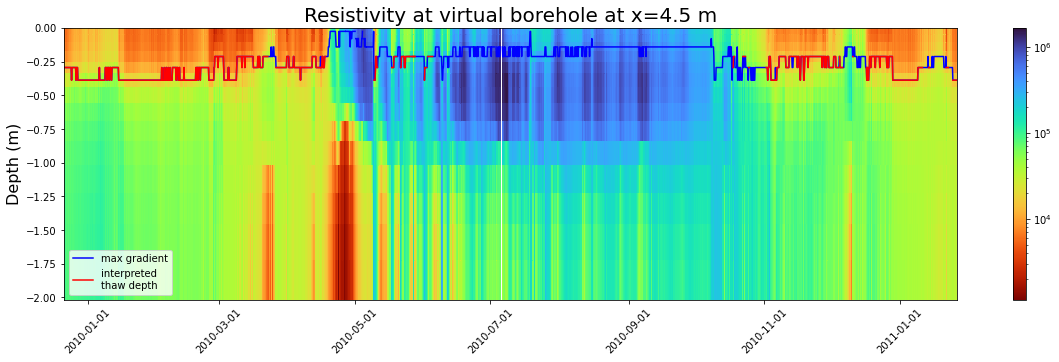

In [20]:

cmin = min(np.hstack(rho_borehole))
cmax = max(np.hstack(rho_borehole))

fs = 16

fig, ax = plt.subplots(1,1,figsize=[20,5])
X, Y = np.meshgrid(dt,z_borehole)
plt.pcolormesh(
    X,
    Y,
    np.array(rho_borehole).T,
    cmap='turbo_r',
    shading='auto',
#     vmin=cmin,
#     vmax=cmax,
    norm=colors.LogNorm(vmin=cmin, vmax=cmax), # logarithmic scale
)

ax.plot(dt,z_gmax,'b',label='max gradient')
ax.plot(dt,z_thaw,'r',label='interpreted\nthaw depth')

date_format = mdates.DateFormatter('%Y-%m-%d') 
ax.xaxis.set_major_formatter(date_format)
plt.xticks(rotation=45);
plt.colorbar()
plt.ylabel('Depth (m)',fontsize=fs)
plt.title('Resistivity at virtual borehole at x=%.1f m'%(xborehole),fontsize=20);
plt.legend()

In [21]:
from ipywidgets import Button, Layout

def reset_button(i):
    
    def on_button_clicked(_):
        df = pd.DataFrame(data={'z': z_borehole, 'rho': rho_borehole[i]})
        np.savetxt('vbh %s.txt' %dt[i].strftime('%Y-%m-%d %H_%M_%S'), df, header="z rho")
        print('Profile saved as "vbh %s.txt"' %dt[i].strftime('%Y-%m-%d %H_%M_%S'))
        
    button = Button(description='Save this resistivity profile',
                    layout=Layout(width='40%', height='80px'),
                    style=dict(button_color='lightgreen')
                   )
    button.on_click(on_button_clicked)
    display(button)

    
@interact(i=(0,n_surveys_proc-1))

def plot_m(i=20):
    
    cmin = min(np.hstack(rho_borehole))
    cmax = max(np.hstack(rho_borehole))

    fs = 16

    fig, ax = plt.subplots(1,1,figsize=[20,5])
    X, Y = np.meshgrid(dt,z_borehole)
    plt.pcolormesh(
        X,
        Y,
        np.array(rho_borehole).T,
        cmap='turbo_r',
        shading='auto',
    #     vmin=cmin,
    #     vmax=cmax,
        norm=colors.LogNorm(vmin=cmin, vmax=cmax), # logarithmic scale
    )

    ax.plot(dt,z_gmax,'b',label='max gradient')
    ax.plot(dt,z_thaw,'r',label='interpreted\nthaw depth')
    
    date_format = mdates.DateFormatter('%Y-%m-%d') 
    ax.xaxis.set_major_formatter(date_format)
    plt.xticks(rotation=45);
    plt.colorbar()
    plt.ylabel('Depth (m)',fontsize=fs)
    plt.title('Resistivity at virtual borehole at x=%.1f m'%(xborehole),fontsize=20);
    plt.legend()
    plt.axvline(x = dt[i], color = 'k',linewidth=2)
    
    fig, ax = plt.subplots(1,1,figsize=[14.6,2])
    
    plt.plot(dt, rms,'r-',linewidth=0.5)
    plt.xlim([min(dt),max(dt)])
    plt.ylabel('rms error of\ninverted dataset (%)',fontsize=fs)
    plt.axvline(x = dt[i], color = 'k',linewidth=2)
    ax.xaxis.set_major_formatter(date_format)
    plt.xticks(rotation=45);
    
    fig, ax = plt.subplots(1,1,figsize=[6,6])
    plt.plot(rho_borehole[i],z_borehole,'b',linewidth=2)
    if np.isnan(z_gmax[i]):
        pass
    else:
        ax.hlines(y=z_gmax[i], xmin=cmin, xmax=cmax, linewidth=2, color='m',label='Max gradient')
    ax.set_xlim([cmin,cmax])
    ax.set_xscale('log')
    plt.ylabel('Depth (m)',fontsize=fs)
    plt.xlabel(r'Resistivity ($\Omega$m)',fontsize=fs)
    plt.minorticks_on()
    plt.grid(b=True, which='major', color='#858585')
    plt.grid(b=True, which='minor', color='#cacbcc')
    plt.legend()
    
    ax.text(1e7,-0.5,'Showing profile for \n%s'%(dt[i]),fontsize=24);
     
    ax.text(1e7,-1.5,'Max gradient at %.1f m\n(note: resolution of this boundary is \nlimited by mesh discretization)'%(z_gmax[i]),fontsize=24);    
    
    plt.show()
    
    reset_button(i)
    


interactive(children=(IntSlider(value=20, description='i', max=2405), Output()), _dom_classes=('widget-interac…

In [22]:
@interact(i=(0,n_surveys_proc-1))

def plot_m(i=0):
    
    
    cmin = 1e3
    cmax = 1e6
    
    dates_sort = np.sort(np.unique(ert_all['survey_time']))
    data_plt = ert_all[ert_all['survey_time']==dates_sort[i]]
    
    fig, ax = plt.subplots(1,1,figsize=[15,5])

    if data_plt['rho_s'].iloc[0]==-999:
        txt = 'Poor quality dataset - inversion not performed'
        ax.text(0.2,0.5,txt,fontsize=20)
    else:
        
        cax, cBar = pg.show(
            grid,
            pg.core.RVector(np.array(data_plt['rho_s'])),
            ax=ax,
            cMap='turbo_r',
            coverage=data_plt['sens'],
            cMin=cmin,
            cMax=cmax,
            logScale=True

        );

        cBar.set_label(r'$\rho$ [$\Omega$m]')

        ax.set_xlim([min(E),max(E)])
        ax.set_ylim([ax.get_ylim()[0],0.3])
        ax.plot(E,np.zeros(len(E))+0.1,'kv')
        ax.set_xlabel('X (m)')
        ax.set_ylabel('Z (m)')
        ax.set_title(r'%s, rms error = %.2f%%'%(data_plt['survey_name'].iloc[0],data_plt['rms'].iloc[0]),fontsize=20);

        x_bh = np.array(grid.cellCenters()).T[0][cells_borehole][0] # true borehole location
        ax.plot([x_bh,x_bh],[0,-2],'k')



interactive(children=(IntSlider(value=0, description='i', max=2405), Output()), _dom_classes=('widget-interact…

## Plot resistivity from a specific point location over time

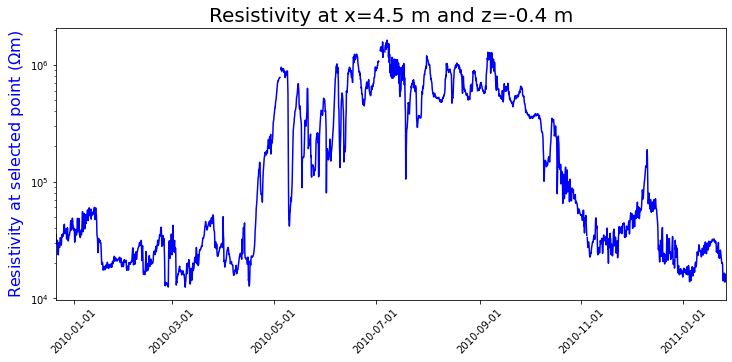

In [23]:
# enter the coordinates where you'd like to get resistivity from:

x_pos = 4.5
z_pos = -0.4

# find the closest model cell

xi = np.where(abs(np.array(grid.cellCenters()).T[0]-x_pos)==min(abs(np.array(grid.cellCenters()).T[0]-x_pos)))
zi = np.where(abs(np.array(grid.cellCenters()).T[1]-z_pos)==min(abs(np.array(grid.cellCenters()).T[1]-z_pos)))

cell_point = np.intersect1d(xi, zi)[0]

# for get date/resistivity pairs for plotting

dt = []
rho_point = []

dates_sort = np.sort(np.unique(ert_all['survey_time']))
    
for i in range(n_surveys_proc):
    
    data_plt = ert_all[ert_all['survey_time']==dates_sort[i]]
    dt.append(data_plt['survey_time'].iloc[0])
    if data_plt['rho_s'].iloc[0]==-999:
        rho_point.append(np.nan)
    else:
        rho_point.append(data_plt['rho_s'].iloc[cell_point])
    
    
    
# plot the results

fs = 16
fig, ax = plt.subplots(1,1,figsize=[12,5])
plt.plot_date(dt, rho_point,'b-')

plt.ylabel(r'Resistivity at selected point ($\Omega$m)',fontsize=fs,color='b')
plt.title('Resistivity at x=%.1f m and z=%.1f m'%(x_pos,z_pos),fontsize=20);

### show/hide rms 
# ax2=ax.twinx()
# ax2.plot(dt, rms,'r-',linewidth=0.5)
# ax2.set_ylabel('RMS error of inverted dataset (%)',fontsize=fs,rotation=270,color='r',labelpad=20);
# ax2.set_ylim([-0,30])

date_format = mdates.DateFormatter('%Y-%m-%d') 
ax.xaxis.set_major_formatter(date_format)
ax.tick_params(axis='x',labelrotation=45)
ax.set_yscale('log') # can comment this out to see plot with linear y-axis
ax.set_xlim([min(dt),max(dt)]);


### Show point on graph

In [24]:
@interact(i=(0,n_surveys_proc-1))

def plot_m(i=0):
    
    cmin = 1e3
    cmax = 1e6
    
    dates_sort = np.sort(np.unique(ert_all['survey_time']))
    data_plt = ert_all[ert_all['survey_time']==dates_sort[i]]
    
    fig, ax = plt.subplots(1,1,figsize=[15,5])

    if data_plt['rho_s'].iloc[0]==-999:
        txt = 'Poor quality dataset - inversion not performed'
        ax.text(0.2,0.5,txt,fontsize=20)
    else:
        cax, cBar = pg.show(
            grid,
            pg.core.RVector(np.array(data_plt['rho_s'])),
            ax=ax,
            cMap='turbo_r',
            coverage=data_plt['sens'],
            cMin=cmin,
            cMax=cmax,
            logScale=True

        );

        cBar.set_label(r'$\rho$ [$\Omega$m]')

        ax.set_xlim([min(E),max(E)])
        ax.set_ylim([ax.get_ylim()[0],0.3])
        ax.plot(E,np.zeros(len(E))+0.1,'kv')
        ax.set_xlabel('X (m)')
        ax.set_ylabel('Z (m)')
        ax.set_title(r'%s, rms error = %.2f%%'%(data_plt['survey_name'].iloc[0],data_plt['rms'].iloc[0]),fontsize=20);

        ax.plot(np.array(grid.cellCenters()).T[0][cell_point],np.array(grid.cellCenters()).T[1][cell_point],'kx',markersize=10)


interactive(children=(IntSlider(value=0, description='i', max=2405), Output()), _dom_classes=('widget-interact…

## Plot average* resistivity from a specific rectangular region over time

 Right now this is just an average.
 If you want to get fancy, you could try weighting the values by their respective cell volumes

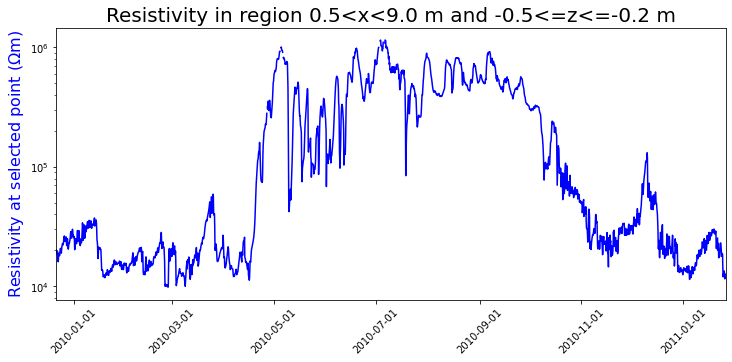

In [25]:
# enter the coordinates where you'd like to get resistivity from:

xmin = 0.5
xmax = 9
zmin = -0.5
zmax = -0.2

# find all cells within region

xi = np.where(np.logical_and(np.array(grid.cellCenters()).T[0]>=xmin,np.array(grid.cellCenters()).T[0]<=xmax))
zi = np.where(np.logical_and(np.array(grid.cellCenters()).T[1]>=zmin,np.array(grid.cellCenters()).T[1]<=zmax))

cells_region = np.intersect1d(xi, zi)

# for get date/resistivity pairs for plotting

dt = []
rho_region = []

dates_sort = np.sort(np.unique(ert_all['survey_time']))
    
for i in range(n_surveys_proc):
    
    data_plt = ert_all[ert_all['survey_time']==dates_sort[i]]
    dt.append(data_plt['survey_time'].iloc[0])
    
    if data_plt['rho_s'].iloc[0]==-999:
        rho_region.append(np.nan)
    else:   
        rho_region.append(np.mean(data_plt['rho_s'].iloc[cells_region]))
    
    
# plot the results

fs = 16

fig, ax = plt.subplots(1,1,figsize=[12,5])
plt.plot_date(dt, rho_region,'b-')

plt.ylabel(r'Resistivity at selected point ($\Omega$m)',fontsize=fs,color='b');
plt.title('Resistivity in region %.1f<x<%.1f m and %.1f<=z<=%.1f m'%(xmin,xmax,zmin,zmax),fontsize=20);

### show/hide rms 
# ax2=ax.twinx()
# ax2.plot(dt, rms,'r-',linewidth=0.5)
# ax2.set_ylabel('RMS error of inverted dataset (%)',fontsize=fs,rotation=270,color='r',labelpad=20);
# ax2.set_ylim([0,30])

date_format = mdates.DateFormatter('%Y-%m-%d') 
ax.xaxis.set_major_formatter(date_format)
ax.tick_params(axis='x',labelrotation=45)
ax.set_yscale('log') # can comment this out to see plot with linear y-axis
ax.set_xlim([min(dt),max(dt)]);

In [26]:
@interact(i=(0,n_surveys_proc-1))

def plot_m(i=0):
    
    
    cmin = 1e3
    cmax = 1e6
    
    dates_sort = np.sort(np.unique(ert_all['survey_time']))
    data_plt = ert_all[ert_all['survey_time']==dates_sort[i]]
    
    fig, ax = plt.subplots(1,1,figsize=[15,5])

    if data_plt['rho_s'].iloc[0]==-999:
        txt = 'Poor quality dataset - inversion not performed'
        ax.text(0.2,0.5,txt,fontsize=20)
    else:
        cax, cBar = pg.show(
            grid,
            pg.core.RVector(np.array(data_plt['rho_s'])),
            ax=ax,
            cMap='turbo_r',
            coverage=data_plt['sens'],
            cMin=cmin,
            cMax=cmax,
            logScale=True

        );

        cBar.set_label(r'$\rho$ [$\Omega$m]')

        ax.set_xlim([min(E),max(E)])
        ax.set_ylim([ax.get_ylim()[0],0.3])
        ax.plot(E,np.zeros(len(E))+0.1,'kv')
        ax.set_xlabel('X (m)')
        ax.set_ylabel('Z (m)')
        ax.set_title(r'%s, rms error = %.2f%%'%(data_plt['survey_name'].iloc[0],data_plt['rms'].iloc[0]),fontsize=20);

    #     ax.plot(np.array(grid.cellCenters()).T[0][cells_region],np.array(grid.cellCenters()).T[1][cells_region],'kx',markersize=10)
        rect = patches.Rectangle([xmin,zmin],xmax-xmin,zmax-zmin,edgecolor='k',fill=False)
        ax.add_patch(rect)

interactive(children=(IntSlider(value=0, description='i', max=2405), Output()), _dom_classes=('widget-interact…